<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/Historical_Put_Call_Ratio_Video_Actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install + Login to Polygon.io client

In [1]:
!pip install polygon-api-client
from google.colab import userdata
from polygon import RESTClient

MY_API_KEY = userdata.get('POLYGON_API_KEY')
client = RESTClient(MY_API_KEY)

### Part 4 of Polygon.io series
* https://www.youtube.com/playlist?list=PLCZZtBmmgxn-QlbbMb-g-89GjHiml_AtS
* If you have free tier I left lines commented that you can uncomment and it should work for you

## Video Goals

* Show you how to get historical OHLCV bar data for option contracts
* Show you how to get all active and expired contracts for a specific underlying stock (options chainish)
* Compute put/call ratio based on volume
  - Make sure it matches https://www.barchart.com/stocks/quotes/rivn
* Compare NVDA and TSLA
### Put Call Ratio
* Measure of market sentiment. Componenet of CNN's "Fear and Greed Index"
  - https://edition.cnn.com/markets/fear-and-greed
* Volume of Put Options/Volume of Call Options
* Note many use open interest also for the put call ratio
* When put call ratio
  -  is high => Stock traders Bearish
  -  is_low => Stock traders Bullish
* Some people use it as reversal signal when you get extreme values...

##### **Note** if you have the free tier of Polygon.io then you can only make up to 5 API calls a minute so in the functions below I have commented out sections with time.sleep(60) every 5 calls that you can uncomment.

### Polygon.io Python Documentation
* https://github.com/polygon-io/client-python
* See RESTAPI Examples



### Get Historical Options Bars using *client.list_aggs*
* Like in the historical stock bar videos you use *client.list_aggs*, but with option ticker
* Option ticker format example = O:TSLA240802C00170000
* Set limit to maximum possible especially if you have "Free-tier" due to API limits.

##### If you don't need to worry about API limits or you are trying to retrieve less records that limit you can just do

In [2]:
help(client.list_aggs)

Help on method list_aggs in module polygon.rest.aggs:

list_aggs(ticker: str, multiplier: int, timespan: str, from_: Union[str, int, datetime.datetime, datetime.date], to: Union[str, int, datetime.datetime, datetime.date], adjusted: Optional[bool] = None, sort: Union[str, polygon.rest.models.common.Sort, NoneType] = None, limit: Optional[int] = None, params: Optional[Dict[str, Any]] = None, raw: bool = False, options: Optional[polygon.rest.models.request.RequestOptionBuilder] = None) -> Union[Iterator[polygon.rest.models.aggs.Agg], urllib3.response.HTTPResponse] method of polygon.rest.RESTClient instance
    List aggregate bars for a ticker over a given date range in custom time window sizes.
    
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the a

In [3]:
import pandas as pd
MAX_BAR_LIMIT = 50_000
df = pd.DataFrame(client.list_aggs(ticker='O:TSLA240802C00170000',multiplier=5,timespan='minute',from_='2024-03-01',to='2025-01-01',limit=MAX_BAR_LIMIT))
df.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,25.72,25.72,25.72,25.72,2,25.7200,1718285700000,1,None
1,25.50,25.50,25.50,25.50,2,25.5000,1718288400000,1,None
2,22.88,22.88,22.88,22.88,5,22.8800,1718290200000,1,None
3,22.20,22.20,22.20,22.20,1,22.2000,1718290500000,1,None
4,22.39,23.20,22.39,23.20,8,22.6938,1718290800000,2,None


##### We make the timestamp into a pandas datetime for readability


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')
df.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,25.72,25.72,25.72,25.72,2,25.7200,2024-06-13 13:35:00,1,None
1,25.50,25.50,25.50,25.50,2,25.5000,2024-06-13 14:20:00,1,None
2,22.88,22.88,22.88,22.88,5,22.8800,2024-06-13 14:50:00,1,None
3,22.20,22.20,22.20,22.20,1,22.2000,2024-06-13 14:55:00,1,None
4,22.39,23.20,22.39,23.20,8,22.6938,2024-06-13 15:00:00,2,None


##### If you have "Free Tier" and you need more rows that 5*LIMIT you can do this...

In [6]:
import time
option_bars = []
for bar in client.list_aggs(ticker='O:TSLA240802C00170000',multiplier=1,timespan='minute',from_='2024-03-01',to='2025-01-01',limit=MAX_BAR_LIMIT):
  option_bars.append(bar)
  if len(option_bars) % (5*MAX_BAR_LIMIT) == 0:
    print("sleeping for 60 secs")
    time.sleep(60)
    print("done sleeping")

In [7]:
option_bars[0:3]

[Agg(open=25.72, high=25.72, low=25.72, close=25.72, volume=2, vwap=25.72, timestamp=1718285820000, transactions=1, otc=None),
 Agg(open=25.5, high=25.5, low=25.5, close=25.5, volume=2, vwap=25.5, timestamp=1718288520000, transactions=1, otc=None),
 Agg(open=22.88, high=22.88, low=22.88, close=22.88, volume=5, vwap=22.88, timestamp=1718290260000, transactions=1, otc=None)]

###### Can then set to a *dataframe*

In [8]:
pd.DataFrame(option_bars).head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,25.72,25.72,25.72,25.72,2,25.72,1718285820000,1,None
1,25.50,25.50,25.50,25.50,2,25.50,1718288520000,1,None
2,22.88,22.88,22.88,22.88,5,22.88,1718290260000,1,None
3,22.20,22.20,22.20,22.20,1,22.20,1718290620000,1,None
4,22.39,22.39,22.39,22.39,5,22.39,1718290800000,1,None


### Get List of Call Option Contracts using *client.list_options_contracts*
* For an Underlying Stock with expiry>=start_date we want to do out analysis on
  * Get Active Contracts
  * Get Expired Contracts
  * Combine Them




In [9]:
help(client.list_options_contracts)

Help on method list_options_contracts in module polygon.rest.reference:

list_options_contracts(underlying_ticker: Optional[str] = None, underlying_ticker_lt: Optional[str] = None, underlying_ticker_lte: Optional[str] = None, underlying_ticker_gt: Optional[str] = None, underlying_ticker_gte: Optional[str] = None, contract_type: Optional[str] = None, expiration_date: Union[str, datetime.date, NoneType] = None, expiration_date_lt: Union[str, datetime.date, NoneType] = None, expiration_date_lte: Union[str, datetime.date, NoneType] = None, expiration_date_gt: Union[str, datetime.date, NoneType] = None, expiration_date_gte: Union[str, datetime.date, NoneType] = None, as_of: Union[str, datetime.date, NoneType] = None, strike_price: Optional[float] = None, strike_price_lt: Optional[float] = None, strike_price_lte: Optional[float] = None, strike_price_gt: Optional[float] = None, strike_price_gte: Optional[float] = None, expired: Optional[bool] = None, limit: Optional[int] = None, sort: Union[s

#### Underlying Stock

In [10]:
underlying_stock = 'RIVN'

##### Start Date

In [11]:
start_date = '2024-06-01'

### Get Active Contracts

In [12]:
active_contracts = []
for option in client.list_options_contracts(underlying_ticker=underlying_stock,expiration_date_gte=start_date,limit=1000):
  active_contracts.append(option)
  # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
  #if len(active_contracts) % 5000 == 0:
  #    time.sleep(60)

In [13]:
active_contracts[0:3]

[OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-28', primary_exchange='BATO', shares_per_contract=100, strike_price=3, ticker='O:RIVN240628C00003000', underlying_ticker='RIVN'),
 OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-28', primary_exchange='BATO', shares_per_contract=100, strike_price=4, ticker='O:RIVN240628C00004000', underlying_ticker='RIVN'),
 OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-28', primary_exchange='BATO', shares_per_contract=100, strike_price=5, ticker='O:RIVN240628C00005000', underlying_ticker='RIVN')]

### Get Expired Contracts

In [14]:
expired_contracts = []
for option in client.list_options_contracts(underlying_ticker=underlying_stock,expiration_date_gte=start_date,limit=1000,expired=True):
  expired_contracts.append(option)
  # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
  #if len(active_contracts) % 5000 == 0:
  #    time.sleep(60)

In [15]:
expired_contracts[0:3]

[OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-07', primary_exchange='BATO', shares_per_contract=100, strike_price=2.5, ticker='O:RIVN240607C00002500', underlying_ticker='RIVN'),
 OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-07', primary_exchange='BATO', shares_per_contract=100, strike_price=3, ticker='O:RIVN240607C00003000', underlying_ticker='RIVN'),
 OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2024-06-07', primary_exchange='BATO', shares_per_contract=100, strike_price=4, ticker='O:RIVN240607C00004000', underlying_ticker='RIVN')]

* Note they have no overlap

In [16]:
set([contract.ticker for contract in active_contracts]).intersection(set([contract.ticker for contract in expired_contracts]))

set()

In [17]:
len(active_contracts),len(expired_contracts)

(740, 252)

### Combine the active and expired contracts into one list

In [19]:
options_contracts = expired_contracts + active_contracts

In [21]:
pd.DataFrame(options_contracts).assign(NEW_COL='MY NEW COL!')

,additional_underlyings,cfi,contract_type,correction,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,NEW_COL
0,None,OCASPS,call,None,american,2024-06-07,BATO,100,2.5,O:RIVN240607C00002500,RIVN,MY NEW COL!
1,None,OCASPS,call,None,american,2024-06-07,BATO,100,3.0,O:RIVN240607C00003000,RIVN,MY NEW COL!
2,None,OCASPS,call,None,american,2024-06-07,BATO,100,4.0,O:RIVN240607C00004000,RIVN,MY NEW COL!
3,None,OCASPS,call,None,american,2024-06-07,BATO,100,4.5,O:RIVN240607C00004500,RIVN,MY NEW COL!
4,None,OCASPS,call,None,american,2024-06-07,BATO,100,5.0,O:RIVN240607C00005000,RIVN,MY NEW COL!
...,...,...,...,...,...,...,...,...,...,...,...,...
987,None,OPASPS,put,None,american,2026-12-18,BATO,100,12.5,O:RIVN261218P00012500,RIVN,MY NEW COL!
988,None,OPASPS,put,None,american,2026-12-18,BATO,100,15.0,O:RIVN261218P00015000,RIVN,MY NEW COL!
989,None,OPASPS,put,None,american,2026-12-18,BATO,100,17.5,O:RIVN261218P00017500,RIVN,MY NEW COL!
990,None,OPASPS,put,None,american,2026-12-18,BATO,100,20.0,O:RIVN261218P00020000,RIVN,MY NEW COL!


### Get daily bar data for each contract using list_aggs
* Since we are using daily bars we don't need to worry about limits...
* Get a list of dataframes and contatenate at end
* If using free version sleep for 60 seconds every 5 API calls
* We get option ticker by doing contract.ticker
* Use Pandas .assing method to get the option ticker which we will need for a join later

In [22]:
df_list = []
for contract in options_contracts:
  df_list.append(pd.DataFrame(client.list_aggs(ticker=contract.ticker,multiplier=1,timespan='day',from_=start_date,to='2025-01-01',limit=50000)).assign(ticker=contract.ticker))
  # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
  #if len(df_list) % 5 == 0:
  #    time.sleep(60)

In [23]:
df_list[0].head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc,ticker
0,8.30,8.30,8.30,8.30,2,8.30,1717387200000,2,None,O:RIVN240607C00002500
1,8.79,8.79,8.79,8.79,4,8.79,1717646400000,4,None,O:RIVN240607C00002500
2,9.04,9.04,9.04,9.04,4,9.04,1717732800000,4,None,O:RIVN240607C00002500


In [24]:
len(df_list)

992

##### Concatenate dataframes together into 1 large one

In [25]:
df = pd.concat(df_list)

Since timestamp is in a non-friendly format lets convert it to a pandas datetime


In [26]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')

#### Combine the bars with the contracts to get contract type

In [28]:
pd.DataFrame(options_contracts)

,additional_underlyings,cfi,contract_type,correction,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker
0,None,OCASPS,call,None,american,2024-06-07,BATO,100,2.5,O:RIVN240607C00002500,RIVN
1,None,OCASPS,call,None,american,2024-06-07,BATO,100,3.0,O:RIVN240607C00003000,RIVN
2,None,OCASPS,call,None,american,2024-06-07,BATO,100,4.0,O:RIVN240607C00004000,RIVN
3,None,OCASPS,call,None,american,2024-06-07,BATO,100,4.5,O:RIVN240607C00004500,RIVN
4,None,OCASPS,call,None,american,2024-06-07,BATO,100,5.0,O:RIVN240607C00005000,RIVN
...,...,...,...,...,...,...,...,...,...,...,...
987,None,OPASPS,put,None,american,2026-12-18,BATO,100,12.5,O:RIVN261218P00012500,RIVN
988,None,OPASPS,put,None,american,2026-12-18,BATO,100,15.0,O:RIVN261218P00015000,RIVN
989,None,OPASPS,put,None,american,2026-12-18,BATO,100,17.5,O:RIVN261218P00017500,RIVN
990,None,OPASPS,put,None,american,2026-12-18,BATO,100,20.0,O:RIVN261218P00020000,RIVN


In [29]:
df=pd.DataFrame(options_contracts).merge(df,on='ticker')

In [30]:
df[['timestamp','contract_type','volume']]

,timestamp,contract_type,volume
0,2024-06-03 04:00:00,call,2.0
1,2024-06-06 04:00:00,call,4.0
2,2024-06-07 04:00:00,call,4.0
3,2024-06-03 04:00:00,call,8.0
4,2024-06-04 04:00:00,call,4.0
...,...,...,...
5836,2024-06-06 04:00:00,put,52.0
5837,2024-06-10 04:00:00,put,4.0
5838,2024-06-20 04:00:00,put,2.0
5839,2024-06-21 04:00:00,put,2.0


#### Now compute Put-Call Volume Ratio





In [31]:
import numpy as np
df['call_volume'] = np.where(df['contract_type'] == 'call',df['volume'],0)
df['put_volume'] = np.where(df['contract_type'] == 'put',df['volume'],0)
df_grouped = df.groupby('timestamp')[['put_volume','call_volume','volume']].sum()
df_grouped['put_call_ratio'] = df_grouped['put_volume']/df_grouped['call_volume']
df_grouped

,put_volume,call_volume,volume,put_call_ratio
timestamp,,,,
2024-06-03 04:00:00,64556.0,180884.0,245440.0,0.356892
2024-06-04 04:00:00,37287.0,125232.0,162519.0,0.297743
2024-06-05 04:00:00,54418.0,137406.0,191824.0,0.396038
2024-06-06 04:00:00,88692.0,194124.0,282816.0,0.456883
2024-06-07 04:00:00,60620.0,154211.0,214831.0,0.393098
2024-06-10 04:00:00,88278.0,176473.0,264751.0,0.500235
2024-06-11 04:00:00,38224.0,59719.0,97943.0,0.640064
2024-06-12 04:00:00,62443.0,176769.0,239212.0,0.353246
2024-06-13 04:00:00,46382.0,165226.0,211608.0,0.280719


#### Plot the Put-Call-Volume Ratio over Time with Plotly

In [32]:
import plotly.express as px
fig = px.line(df_grouped, y='put_call_ratio', height=720, width=1280)
fig

### Compare Put-Call Ratio of Option Volume of TSLA and NVDA Year to Date
* NOTE: This takes a long time to run even for paid account!
* First let's wrap all the above steps into a function of underlying_stock start_date='2024-01-01' by default
* I will try to make it self contained so will include imports

In [ ]:
import time
import numpy as np
import pandas as pd
from polygon import RESTClient

client = RESTClient(MY_API_KEY)

def get_put_call_ratio(underlying_stock,start_date='2024-01-01'):

  active_contracts = []
  for option in client.list_options_contracts(underlying_ticker=underlying_stock,expiration_date_gte=start_date,limit=1000):
    active_contracts.append(option)
    # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
    #if len(active_contracts) % 5000 == 0:
    #    time.sleep(60)
  expired_contracts = []
  for option in client.list_options_contracts(underlying_ticker=underlying_stock,expiration_date_gte=start_date,limit=1000,expired=True):
    expired_contracts.append(option)
    # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
    #if len(active_contracts) % 5000 == 0:
    #    time.sleep(60)

  # Combine the expired and active contracts
  options_contracts = expired_contracts + active_contracts

  print(f"Total Contracts: {len(options_contracts)}")
  # Get bar data for all the option contracts defined above
  df_list = []
  for i,contract in enumerate(options_contracts):
    df_list.append(pd.DataFrame(client.list_aggs(ticker=contract.ticker,multiplier=1,timespan='week',from_=start_date,to='2025-01-01',limit=50000)).assign(ticker=contract.ticker))
    if i%100==0:
      print(f"Getting data for contract {i} of {len(options_contracts)}")
  # Uncomment both lines belows if you hare using the "Free Tier" since there is max of 5 API calls per minute
  #if len(df_list) % 5 == 0:
  #    time.sleep(60)

  # Combine the list into of dataframes into 1 dataframe and clean up the timestamp format
  df = pd.concat(df_list)
  df['timestamp'] = pd.to_datetime(df['timestamp'],unit='ms')

  # Merge with the contracts to get the contract types
  df=pd.DataFrame(options_contracts).merge(df,on='ticker')

  # Calculate the Daily Put-Call Volume Ratio
  df['call_volume'] = np.where(df['contract_type'] == 'call',df['volume'],0)
  df['put_volume'] = np.where(df['contract_type'] == 'put',df['volume'],0)
  df_grouped = df.groupby('timestamp')[['put_volume','call_volume','volume']].sum()
  df_grouped['put_call_ratio'] = df_grouped['put_volume']/df_grouped['call_volume']
  return df_grouped

SyntaxError: unterminated string literal (detected at line 26) (<ipython-input-26-973acb160660>, line 26)

### Multithreading Version (NEED Premium Account)

In [ ]:
import time
import numpy as np
import pandas as pd
from polygon import RESTClient
import concurrent.futures
import requests
from requests.adapters import HTTPAdapter

# Pass this session to the RESTClient
client = RESTClient(MY_API_KEY)

def fetch_bar_data(contract, start_date):
    try:
        data = pd.DataFrame(client.list_aggs(
            ticker=contract.ticker,
            multiplier=1,
            timespan='week',
            from_=start_date,
            to='2025-01-01',
            limit=50000
        )).assign(ticker=contract.ticker)
        print("Got data for contract",contract.ticker,'\n')
        return data
    except Exception as e:
        print(f"Error fetching data for {contract.ticker}: {e}")
        return pd.DataFrame()

def get_put_call_ratio(underlying_stock, start_date='2024-01-01'):
    active_contracts = list(client.list_options_contracts(underlying_ticker=underlying_stock, expiration_date_gte=start_date, limit=1000))
    expired_contracts = list(client.list_options_contracts(underlying_ticker=underlying_stock, expiration_date_gte=start_date, limit=1000, expired=True))

    # Combine the expired and active contracts
    options_contracts = expired_contracts + active_contracts

    print(f"Total Contracts: {len(options_contracts)}")

    # Fetch bar data for all the option contracts concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        df_list = list(executor.map(lambda contract: fetch_bar_data(contract, start_date), options_contracts))

    # Filter out empty dataframes (in case of errors)
    df_list = [df for df in df_list if not df.empty]

    # Combine the list of dataframes into 1 dataframe and clean up the timestamp format
    df = pd.concat(df_list)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Merge with the contracts to get the contract types
    contracts_df = pd.DataFrame(options_contracts)
    df = contracts_df.merge(df, on='ticker')

    # Calculate the Daily Put-Call Volume Ratio
    df['call_volume'] = np.where(df['contract_type'] == 'call', df['volume'], 0)
    df['put_volume'] = np.where(df['contract_type'] == 'put', df['volume'], 0)
    df_grouped = df.groupby('timestamp')[['put_volume', 'call_volume', 'volume']].sum()
    df_grouped['put_call_ratio'] = df_grouped['put_volume'] / df_grouped['call_volume']

    return df_grouped

In [ ]:
df_put_call_nvda = get_put_call_ratio('NVDA')
df_put_call_tsla = get_put_call_ratio('NVDA')


Total Contracts: 19530
Got data for contract O:NVDA240105C00070000
Got data for contract O:NVDA240105C00150000
Got data for contract O:NVDA240105C00130000
Got data for contract O:NVDA240105C00160000


Got data for contract O:NVDA240105C00140000
Got data for contract O:NVDA240105C00110000
Got data for contract O:NVDA240105C00200000
Got data for contract O:NVDA240105C00220000
Got data for contract O:NVDA240105C00240000
Got data for contract O:NVDA240105C00230000
Got data for contract O:NVDA240105C00120000
Got data for contract O:NVDA240105C00270000
Got data for contract O:NVDA240105C00280000
Got data for contract O:NVDA240105C00180000
Got data for contract O:NVDA240105C00090000
Got data for contract O:NVDA240105C00300000
Got data for contract O:NVDA240105C00080000
Got data for contract O:NVDA240105C00210000
Got data for contract O:NVDA240105C00320000
Got data for contract O:NVDA240105C00170000
Got data for contract O:NVDA240105C00325000


Got data for contract O:NVDA240105C00340000
Got data for contract O:NVDA240105C00190000
Got data for contract O:NVDA240105C00335000
Got data for contract O:NVDA240105C00100000
Got data for contract O:NVDA240105C00250000
Got data for contract O:NVDA240105C00360000
Got data for contract O:NVDA240105C00370000
Got data for contract O:NVDA240105C00290000
Got data for contract O:NVDA240105C00350000
Got data for contract O:NVDA240105C00390000
Got data for contract O:NVDA240105C00260000
Got data for contract O:NVDA240105C00310000
Got data for contract O:NVDA240105C00395000
Got data for contract O:NVDA240105C00405000
Got data for contract O:NVDA240105C00330000
Got data for contract O:NVDA240105C00375000
Got data for contractGot data for contract O:NVDA240105C00355000
 O:NVDA240105C00385000
Got data for contract O:NVDA240105C00380000
Got data for contract O:NVDA240105C00410000
Got data for contract O:NVDA240105C00420000
Got data for contract O:NVDA240105C00435000
Got data for contract O:NVDA2401

Got data for contractGot data for contract O:NVDA240105C00475000
 O:NVDA240105C00460000
Got data for contract O:NVDA240105C00487500
Got data for contract O:NVDA240105C00490000
Got data for contractGot data for contract O:NVDA240105C00452500
Got data for contract O:NVDA240105C00465000
Got data for contract O:NVDA240105C00480000
Got data for contract O:NVDA240105C00495000
Got data for contractGot data for contract O:NVDA240105C00497500
Got data for contract O:NVDA240105C00477500
 O:NVDA240105C00472500
Got data for contract O:NVDA240105C00502500
 O:NVDA240105C00467500
Got data for contract O:NVDA240105C00485000
Got data for contract O:NVDA240105C00482500
Got data for contract O:NVDA240105C00517500
Got data for contract O:NVDA240105C00500000
Got data for contract O:NVDA240105C00462500
Got data for contractGot data for contract O:NVDA240105C00512500
 O:NVDA240105C00510000
Got data for contract O:NVDA240105C00507500
Got data for contract O:NVDA240105C00492500
Got data for contractGot data fo


Got data for contract O:NVDA240105C00525000
Got data for contractGot data for contract O:NVDA240105C00557500
 O:NVDA240105C00575000
Got data for contract O:NVDA240105C00585000
Got data for contract O:NVDA240105C00565000
Got data for contract O:NVDA240105C00570000
Got data for contract O:NVDA240105C00550000
Got data for contract O:NVDA240105C00595000
Got data for contract O:NVDA240105C00582500
Got data for contract O:NVDA240105C00577500
Got data for contract O:NVDA240105C00597500
Got data for contract O:NVDA240105C00572500
Got data for contract O:NVDA240105C00620000
Got data for contract O:NVDA240105C00640000
Got data for contract O:NVDA240105C00610000
Got data for contract O:NVDA240105C00660000
Got data for contract O:NVDA240105C00670000
Got data for contractGot data for contract O:NVDA240105C00580000
Got data for contract O:NVDA240105C00680000
Got data for contract O:NVDA240105C00552500Got data for contract O:NVDA240105C00650000
 O:NVDA240105C00590000
Got data for contract O:NVDA2401

Got data for contractGot data for contract O:NVDA240105P00130000
Got data for contract O:NVDA240105P00280000
Got data for contract O:NVDA240105C00800000
 O:NVDA240105P00250000
Got data for contract O:NVDA240105P00300000
Got data for contract O:NVDA240105P00100000
Got data for contract O:NVDA240105P00260000
Got data for contract O:NVDA240105P00240000
Got data for contract O:NVDA240105P00200000
Got data for contract O:NVDA240105C00780000
Got data for contract O:NVDA240105P00340000
Got data for contract O:NVDA240105P00270000
Got data for contract O:NVDA240105P00210000
Got data for contract O:NVDA240105P00320000
Got data for contract O:NVDA240105P00310000
Got data for contract O:NVDA240105P00345000
Got data for contract O:NVDA240105P00290000
Got data for contract O:NVDA240105P00350000
Got data for contractGot data for contract O:NVDA240105P00385000
 O:NVDA240105P00335000
Got data for contract O:NVDA240105P00360000
Got data for contract O:NVDA240105P00395000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240105P00457500
Got data for contract O:NVDA240105P00472500
Got data for contractGot data for contract O:NVDA240105P00410000
 O:NVDA240105P00460000
Got data for contract O:NVDA240105P00480000
Got data for contract O:NVDA240105P00482500
Got data for contract O:NVDA240105P00400000
Got data for contract O:NVDA240105P00485000
Got data for contract O:NVDA240105P00445000
Got data for contract O:NVDA240105P00492500
Got data for contract O:NVDA240105P00477500
Got data for contract O:NVDA240105P00502500
Got data for contractGot data for contract O:NVDA240105P00490000
Got data for contract O:NVDA240105P00465000
 O:NVDA240105P00497500
Got data for contractGot data for contract O:NVDA240105P00470000
 O:NVDA240105P00507500Got data for contract
Got data for contract O:NVDA240105P00475000
 O:NVDA240105P00512500
Got data for contract O:NVDA240105P00517500
Got data for contract O:NVDA240105P00495000
Got data for contract O:NVDA240105P00520000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240105P00565000
Got data for contract O:NVDA240105P00555000
Got data for contract O:NVDA240105P00567500
Got data for contract O:NVDA240105P00537500
Got data for contractGot data for contract O:NVDA240105P00552500
 O:NVDA240105P00525000
Got data for contract O:NVDA240105P00575000
Got data for contract O:NVDA240105P00562500
Got data for contract O:NVDA240105P00580000
Got data for contract O:NVDA240105P00577500
Got data for contract O:NVDA240105P00582500
Got data for contract O:NVDA240105P00560000
Got data for contract O:NVDA240105P00557500
Got data for contract O:NVDA240105P00597500
Got data for contract O:NVDA240105P00595000
Got data for contract O:NVDA240105P00587500
Got data for contract O:NVDA240105P00585000
Got data for contract O:NVDA240105P00610000
Got data for contract O:NVDA240105P00640000
Got data for contract O:NVDA240105P00590000
Got data for contract O:NVDA240105P00670000
Got data for contract O:NVDA240105P00572500
Got data for contract O:NVDA2401

Got data for contract O:NVDA240112C00150000
Got data for contractGot data for contract O:NVDA240105P00840000
Got data for contract Got data for contract O:NVDA240112C00080000
 O:NVDA240112C00190000
O:NVDA240112C00180000
Got data for contract O:NVDA240112C00170000
Got data for contractGot data for contract O:NVDA240112C00260000
 O:NVDA240112C00270000
Got data for contract O:NVDA240112C00210000
Got data for contract O:NVDA240112C00300000
Got data for contractGot data for contract O:NVDA240112C00280000
 O:NVDA240112C00130000
Got data for contract O:NVDA240112C00325000
Got data for contract O:NVDA240112C00290000
Got data for contract O:NVDA240112C00230000
Got data for contractGot data for contract O:NVDA240112C00335000
 O:NVDA240112C00240000
Got data for contract O:NVDA240112C00250000
Got data for contract O:NVDA240112C00355000
Got data for contract O:NVDA240112C00345000
Got data for contract O:NVDA240112C00370000
Got data for contract O:NVDA240112C00220000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240112C00447500
Got data for contract O:NVDA240112C00405000
Got data for contract O:NVDA240112C00430000
Got data for contract O:NVDA240112C00310000
Got data for contract O:NVDA240112C00425000
Got data for contract O:NVDA240112C00462500
Got data for contract O:NVDA240112C00390000Got data for contract O:NVDA240112C00455000

Got data for contract O:NVDA240112C00450000
Got data for contract O:NVDA240112C00457500
Got data for contract O:NVDA240112C00465000
Got data for contract O:NVDA240112C00440000
Got data for contract O:NVDA240112C00475000
Got data for contract O:NVDA240112C00452500
Got data for contract O:NVDA240112C00477500
Got data for contractGot data for contract O:NVDA240112C00445000
 O:NVDA240112C00482500Got data for contract O:NVDA240112C00490000

Got data for contract O:NVDA240112C00495000
Got data for contract O:NVDA240112C00467500
Got data for contractGot data for contract O:NVDA240112C00472500
 O:NVDA240112C00460000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240112C00515000
Got data for contract O:NVDA240112C00542500
Got data for contract O:NVDA240112C00547500
Got data for contract O:NVDA240112C00527500
Got data for contract O:NVDA240112C00530000
Got data for contract O:NVDA240112C00560000
Got data for contract O:NVDA240112C00557500
Got data for contract O:NVDA240112C00565000
Got data for contractGot data for contract O:NVDA240112C00552500
 O:NVDA240112C00535000
Got data for contract O:NVDA240112C00555000
Got data for contract O:NVDA240112C00550000
Got data for contract O:NVDA240112C00567500
Got data for contract O:NVDA240112C00562500
Got data for contract O:NVDA240112C00575000
Got data for contract O:NVDA240112C00572500
Got data for contract O:NVDA240112C00485000
Got data for contract O:NVDA240112C00585000
Got data for contract O:NVDA240112C00582500
Got data for contractGot data for contract O:NVDA240112C00570000
Got data for contract O:NVDA240112C00587500
Got data for contract O:NVDA240112C00540000
 O:NVDA2401

Got data for contract O:NVDA240112C00620000
Got data for contract O:NVDA240112C00840000
Got data for contract O:NVDA240112C00610000
Got data for contract O:NVDA240112C00670000
Got data for contract O:NVDA240112C00860000
Got data for contract O:NVDA240112C00820000Got data for contract O:NVDA240112C00850000
Got data for contract O:NVDA240112P00080000

Got data for contract O:NVDA240112C00680000
Got data for contract O:NVDA240112P00090000
Got data for contract O:NVDA240112P00100000
Got data for contract O:NVDA240112C00870000
Got data for contract O:NVDA240112P00130000
Got data for contract O:NVDA240112C00880000
Got data for contract O:NVDA240112P00140000
Got data for contract O:NVDA240112P00150000
Got data for contract O:NVDA240112P00070000
Got data for contract O:NVDA240112P00170000
Got data for contract O:NVDA240112P00190000
Got data for contract O:NVDA240112P00120000
Got data for contract O:NVDA240112P00210000
Got data for contract O:NVDA240112C00890000
Got data for contract O:NVDA2401

Got data for contractGot data for contract O:NVDA240112P00160000
 O:NVDA240112P00380000
Got data for contract Got data for contract O:NVDA240112P00350000
Got data for contract O:NVDA240112P00325000Got data for contract O:NVDA240112P00390000
O:NVDA240112P00310000

Got data for contract O:NVDA240112P00400000
Got data for contract O:NVDA240112P00405000
Got data for contract O:NVDA240112P00345000
Got data for contract O:NVDA240112P00320000
Got data for contract O:NVDA240112P00330000
Got data for contract O:NVDA240112P00395000
Got data for contract O:NVDA240112P00435000
Got data for contract O:NVDA240112P00370000
Got data for contract O:NVDA240112P00385000
Got data for contractGot data for contract O:NVDA240112P00360000
 O:NVDA240112P00440000
Got data for contract O:NVDA240112P00425000
Got data for contract O:NVDA240112P00452500
Got data for contract O:NVDA240112P00445000
Got data for contract O:NVDA240112P00450000
Got data for contractGot data for contract O:NVDA240112P00447500
 O:NVDA2401

Got data for contract O:NVDA240112P00460000
 O:NVDA240112P00375000
Got data for contract O:NVDA240112P00492500
Got data for contract O:NVDA240112P00477500
Got data for contract O:NVDA240112P00475000
Got data for contract O:NVDA240112P00485000
Got data for contract O:NVDA240112P00497500
Got data for contract O:NVDA240112P00487500
Got data for contract O:NVDA240112P00507500
Got data for contract O:NVDA240112P00512500
Got data for contract O:NVDA240112P00495000
Got data for contract O:NVDA240112P00490000Got data for contract O:NVDA240112P00480000

Got data for contract O:NVDA240112P00505000
Got data for contract O:NVDA240112P00462500
Got data for contract O:NVDA240112P00525000
Got data for contract O:NVDA240112P00517500
Got data for contract O:NVDA240112P00515000
Got data for contract O:NVDA240112P00535000
Got data for contract O:NVDA240112P00455000
Got data for contract O:NVDA240112P00537500
Got data for contract O:NVDA240112P00542500
Got data for contract O:NVDA240112P00545000
Got data 

Got data for contract O:NVDA240112P00555000
Got data for contract O:NVDA240112P00540000
Got data for contract O:NVDA240112P00567500
Got data for contract O:NVDA240112P00562500
Got data for contract O:NVDA240112P00587500
Got data for contract O:NVDA240112P00552500
Got data for contract O:NVDA240112P00565000
Got data for contract O:NVDA240112P00582500
Got data for contract Got data for contract O:NVDA240112P00597500O:NVDA240112P00585000

Got data for contract O:NVDA240112P00580000
Got data for contract O:NVDA240112P00570000
Got data for contract O:NVDA240112P00590000
Got data for contract O:NVDA240112P00595000
Got data for contract O:NVDA240112P00577500
Got data for contract O:NVDA240112P00660000
Got data for contract O:NVDA240112P00620000
Got data for contract O:NVDA240112P00640000Got data for contract O:NVDA240112P00592500

Got data for contract O:NVDA240112P00740000
Got data for contract O:NVDA240112P00600000
Got data for contract O:NVDA240112P00680000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240112P00900000
Got data for contract O:NVDA240119C00040000
Got data for contract O:NVDA240119C00055000
Got data for contractGot data for contract O:NVDA240119C00065000 O:NVDA240119C00005000

Got data for contract O:NVDA240119C00035000
Got data for contract O:NVDA240119C00075000
Got data for contract O:NVDA240119C00015000
Got data for contract O:NVDA240119C00070000
Got data for contract O:NVDA240119C00050000
Got data for contract O:NVDA240119C00095000
Got data for contract O:NVDA240119C00030000
Got data for contract O:NVDA240119C00090000
Got data for contract O:NVDA240119C00105000
Got data for contract O:NVDA240119C00045000
Got data for contract O:NVDA240119C00080000
Got data for contract O:NVDA240119C00085000
Got data for contract O:NVDA240119C00060000
Got data for contract O:NVDA240119C00100000
Got data for contract O:NVDA240119C00145000
Got data for contract O:NVDA240112P00760000
Got data for contract O:NVDA240119C00115000
Got data for contract O:NVDA2401

Got data for contractGot data for contract O:NVDA240119C00110000
 O:NVDA240119C00205000
Got data for contract O:NVDA240119C00200000
Got data for contract O:NVDA240119C00225000
Got data for contractGot data for contract O:NVDA240119C00215000
 Got data for contract O:NVDA240119C00275000
Got data for contract O:NVDA240119C00240000
O:NVDA240119C00250000
Got data for contract O:NVDA240119C00235000
Got data for contractGot data for contract O:NVDA240119C00260000
 O:NVDA240119C00285000
Got data for contract O:NVDA240119C00270000
Got data for contract O:NVDA240119C00220000
Got data for contract O:NVDA240119C00245000
Got data for contract O:NVDA240119C00310000
Got data for contract O:NVDA240119C00255000
Got data for contract O:NVDA240119C00290000
Got data for contract O:NVDA240119C00315000
Got data for contract O:NVDA240119C00300000
Got data for contract O:NVDA240119C00345000
Got data for contract O:NVDA240119C00320000
Got data for contract O:NVDA240119C00330000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119C00380000
Got data for contract O:NVDA240119C00395000
Got data for contract O:NVDA240119C00355000
Got data for contractGot data for contract O:NVDA240119C00390000
Got data for contract O:NVDA240119C00365000
 O:NVDA240119C00435000
Got data for contractGot data for contract O:NVDA240119C00442500
Got data for contract O:NVDA240119C00445000
Got data for contract O:NVDA240119C00430000
Got data for contract O:NVDA240119C00420000
 O:NVDA240119C00415000
Got data for contract O:NVDA240119C00452500
Got data for contract O:NVDA240119C00450000
Got data for contract O:NVDA240119C00440000
Got data for contract O:NVDA240119C00447500
Got data for contract O:NVDA240119C00465000
Got data for contract O:NVDA240119C00400000
Got data for contract O:NVDA240119C00455000
Got data for contractGot data for contract O:NVDA240119C00280000
Got data for contract O:NVDA240119C00470000
 O:NVDA240119C00472500
Got data for contract O:NVDA240119C00462500
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119C00517500
Got data for contract O:NVDA240119C00502500
Got data for contract O:NVDA240119C00522500
Got data for contract O:NVDA240119C00505000
Got data for contract O:NVDA240119C00527500
Got data for contract O:NVDA240119C00510000
Got data for contract O:NVDA240119C00530000
Got data for contract O:NVDA240119C00475000
Got data for contract O:NVDA240119C00525000
Got data for contract O:NVDA240119C00515000
Got data for contract O:NVDA240119C00507500
Got data for contract O:NVDA240119C00520000
Got data for contract O:NVDA240119C00535000
Got data for contract O:NVDA240119C00545000
Got data for contract O:NVDA240119C00550000
Got data for contract O:NVDA240119C00555000
Got data for contract O:NVDA240119C00532500
Got data for contract O:NVDA240119C00552500
Got data for contract O:NVDA240119C00540000
Got data for contract Got data for contract O:NVDA240119C00565000
Got data for contractO:NVDA240119C00557500
 O:NVDA240119C00560000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119C00605000
Got data for contractGot data for contract O:NVDA240119C00592500
 O:NVDA240119C00615000
Got data for contract O:NVDA240119C00490000
Got data for contract O:NVDA240119C00537500
Got data for contract O:NVDA240119C00620000Got data for contract O:NVDA240119C00600000

Got data for contract O:NVDA240119C00580000
Got data for contract O:NVDA240119C00640000Got data for contract O:NVDA240119C00587500

Got data for contract O:NVDA240119C00630000
Got data for contract O:NVDA240119C00625000
Got data for contract O:NVDA240119C00665000
Got data for contract O:NVDA240119C00610000
Got data for contract O:NVDA240119C00680000
Got data for contract O:NVDA240119C00650000
Got data for contract O:NVDA240119C00685000
Got data for contract O:NVDA240119C00595000
Got data for contract O:NVDA240119C00635000
Got data for contract O:NVDA240119C00705000
Got data for contract O:NVDA240119C00660000
Got data for contract O:NVDA240119C00590000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119C00690000
Got data for contractGot data for contract O:NVDA240119C00760000
Got data for contract O:NVDA240119C00710000
 O:NVDA240119C00780000
Got data for contract O:NVDA240119C00820000
Got data for contract O:NVDA240119C00810000
Got data for contract O:NVDA240119C00830000
Got data for contract O:NVDA240119C00840000
Got data for contract O:NVDA240119C00920000
Got data for contractGot data for contract O:NVDA240119C00930000
 O:NVDA240119C00850000
Got data for contract O:NVDA240119C00950000
Got data for contract O:NVDA240119C00890000
Got data for contract O:NVDA240119C00720000Got data for contract O:NVDA240119C00900000

Got data for contract O:NVDA240119C00980000
Got data for contract O:NVDA240119C00990000
Got data for contract O:NVDA240119C00940000
Got data for contract O:NVDA240119C00960000
Got data for contractGot data for contract O:NVDA240119P00015000
Got data for contract O:NVDA240119P00005000
 O:NVDA240119C00880000
Got data for contract O:NVDA2401

 O:NVDA240119P00130000
Got data for contract O:NVDA240119P00085000
Got data for contract O:NVDA240119P00040000
Got data for contract O:NVDA240119P00165000
Got data for contract O:NVDA240119P00110000
Got data for contract O:NVDA240119P00155000
Got data for contractGot data for contract O:NVDA240119P00160000
Got data for contract O:NVDA240119P00100000 
O:NVDA240119P00065000Got data for contract
 O:NVDA240119P00170000
Got data for contractGot data for contract O:NVDA240119P00185000
Got data for contract O:NVDA240119P00175000
 O:NVDA240119P00205000
Got data for contract O:NVDA240119P00135000
Got data for contract O:NVDA240119P00195000
Got data for contract O:NVDA240119P00215000
Got data for contract O:NVDA240119P00210000
Got data for contract O:NVDA240119P00180000
Got data for contract O:NVDA240119P00150000
Got data for contract O:NVDA240119P00245000
Got data for contract O:NVDA240119P00190000
Got data for contractGot data for contract O:NVDA240119P00200000 O:NVDA240119P00260000

Got data 

Got data for contract O:NVDA240119P00310000
Got data for contract O:NVDA240119P00320000
Got data for contractGot data for contractGot data for contract O:NVDA240119P00330000
 O:NVDA240119P00345000
Got data for contract O:NVDA240119P00350000
 O:NVDA240119P00325000
Got data for contract O:NVDA240119P00360000
Got data for contract O:NVDA240119P00240000
Got data for contract O:NVDA240119P00385000
Got data for contract O:NVDA240119P00365000
Got data for contractGot data for contract O:NVDA240119P00375000
Got data for contract O:NVDA240119P00390000
 O:NVDA240119P00370000
Got data for contract O:NVDA240119P00400000
Got data for contract O:NVDA240119P00295000
Got data for contract O:NVDA240119P00250000
Got data for contract O:NVDA240119P00335000
Got data for contract O:NVDA240119P00305000
Got data for contract O:NVDA240119P00415000Got data for contract
Got data for contract O:NVDA240119P00410000
 O:NVDA240119P00280000
Got data for contract O:NVDA240119P00420000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119P00460000
Got data for contract O:NVDA240119P00355000
Got data for contract O:NVDA240119P00445000
Got data for contract O:NVDA240119P00467500
Got data for contract O:NVDA240119P00457500
Got data for contract O:NVDA240119P00447500
Got data for contract O:NVDA240119P00462500
Got data for contract O:NVDA240119P00477500
Got data for contract O:NVDA240119P00455000
Got data for contract O:NVDA240119P00470000
Got data for contract O:NVDA240119P00487500
Got data for contract O:NVDA240119P00465000
Got data for contract Got data for contract O:NVDA240119P00472500
O:NVDA240119P00480000
Got data for contract O:NVDA240119P00475000
Got data for contract O:NVDA240119P00482500
Got data for contract O:NVDA240119P00492500
Got data for contract O:NVDA240119P00507500
Got data for contract O:NVDA240119P00500000
Got data for contract O:NVDA240119P00510000
Got data for contract O:NVDA240119P00502500
Got data for contract O:NVDA240119P00515000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119P00542500
Got data for contract O:NVDA240119P00340000
Got data for contract O:NVDA240119P00535000
Got data for contract O:NVDA240119P00545000
Got data for contract O:NVDA240119P00552500
Got data for contract O:NVDA240119P00555000
Got data for contract O:NVDA240119P00550000
Got data for contract O:NVDA240119P00557500
Got data for contract O:NVDA240119P00517500
Got data for contract O:NVDA240119P00560000
Got data for contract O:NVDA240119P00565000
Got data for contract O:NVDA240119P00570000
Got data for contract O:NVDA240119P00572500


Got data for contract O:NVDA240119P00547500
Got data for contract O:NVDA240119P00490000
Got data for contract O:NVDA240119P00512500
Got data for contract O:NVDA240119P00577500
Got data for contract O:NVDA240119P00580000
Got data for contract O:NVDA240119P00585000
Got data for contract O:NVDA240119P00587500
Got data for contract O:NVDA240119P00590000
Got data for contract O:NVDA240119P00582500
Got data for contract O:NVDA240119P00592500
Got data for contract O:NVDA240119P00595000
Got data for contract O:NVDA240119P00597500
Got data for contract O:NVDA240119P00605000
Got data for contract O:NVDA240119P00610000
Got data for contract O:NVDA240119P00615000
Got data for contract O:NVDA240119P00620000
Got data for contract O:NVDA240119P00625000
Got data for contract O:NVDA240119P00575000
Got data for contract O:NVDA240119P00452500
Got data for contract O:NVDA240119P00630000
Got data for contract O:NVDA240119P00635000
Got data for contract O:NVDA240119P00640000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119P00720000
Got data for contract O:NVDA240119P00562500
Got data for contract O:NVDA240119P00440000
Got data for contractGot data for contract O:NVDA240119P00740000
 O:NVDA240119P00600000
Got data for contract O:NVDA240119P00710000
Got data for contract O:NVDA240119P00735000
Got data for contract O:NVDA240119P00745000
Got data for contract O:NVDA240119P00810000
Got data for contract O:NVDA240119P00760000
Got data for contract O:NVDA240119P00780000
Got data for contract O:NVDA240119P00820000
Got data for contract O:NVDA240119P00830000
Got data for contract O:NVDA240119P00790000
Got data for contract O:NVDA240119P00505000
Got data for contract O:NVDA240119P00850000
Got data for contract O:NVDA240119P00730000
Got data for contract O:NVDA240119P00840000
Got data for contract O:NVDA240119P00497500
Got data for contract O:NVDA240119P00495000
Got data for contract O:NVDA240119P00900000
Got data for contract O:NVDA240119P00800000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240119P00870000Got data for contract O:NVDA240126C00150000
Got data for contract O:NVDA240126C00160000
Got data for contract O:NVDA240119P00860000

Got data for contract O:NVDA240126C00180000
Got data for contract O:NVDA240126C00140000
Got data for contract O:NVDA240126C00190000
Got data for contract O:NVDA240126C00170000
Got data for contract O:NVDA240119P00980000
Got data for contract O:NVDA240126C00120000
Got data for contract O:NVDA240119P00567500
Got data for contract O:NVDA240126C00130000
Got data for contract O:NVDA240126C00220000
Got data for contract Got data for contract O:NVDA240126C00210000
O:NVDA240126C00230000
Got data for contract O:NVDA240119P01000000
Got data for contract O:NVDA240126C00080000
Got data for contract O:NVDA240126C00280000
Got data for contract O:NVDA240126C00330000
Got data for contract O:NVDA240126C00200000
Got data for contract O:NVDA240126C00310000
Got data for contract O:NVDA240126C00335000
Got data for contract O:NVDA2401


Got data for contract O:NVDA240126C00410000
Got data for contract O:NVDA240126C00385000
Got data for contractGot data for contract O:NVDA240126C00375000
 O:NVDA240126C00400000
Got data for contract O:NVDA240126C00435000
Got data for contract O:NVDA240126C00415000
Got data for contract O:NVDA240126C00260000
Got data for contract O:NVDA240126C00340000
Got data for contract O:NVDA240126C00320000
Got data for contract O:NVDA240126C00455000
Got data for contract O:NVDA240126C00450000
Got data for contract O:NVDA240126C00465000
Got data for contract O:NVDA240126C00445000Got data for contract O:NVDA240126C00390000
Got data for contract O:NVDA240126C00425000
Got data for contract O:NVDA240126C00430000
Got data for contract 
O:NVDA240126C00462500
Got data for contract O:NVDA240126C00440000
Got data for contract O:NVDA240126C00460000
Got data for contractGot data for contract O:NVDA240126C00472500
 O:NVDA240126C00482500
Got data for contract O:NVDA240126C00470000
Got data for contract O:NVDA240

 O:NVDA240126C00505000
Got data for contract O:NVDA240126C00500000
Got data for contract O:NVDA240126C00290000
Got data for contract O:NVDA240126C00517500
Got data for contract O:NVDA240126C00512500
Got data for contract O:NVDA240126C00502500
Got data for contract O:NVDA240126C00495000
Got data for contract O:NVDA240126C00520000
Got data for contract O:NVDA240126C00515000
Got data for contract O:NVDA240126C00485000
Got data for contract O:NVDA240126C00537500
Got data for contract O:NVDA240126C00522500
Got data for contract O:NVDA240126C00532500
Got data for contract O:NVDA240126C00530000
Got data for contract O:NVDA240126C00535000
Got data for contract O:NVDA240126C00542500
Got data for contractGot data for contract O:NVDA240126C00550000
 O:NVDA240126C00497500
Got data for contract O:NVDA240126C00525000
Got data for contract Got data for contract O:NVDA240126C00545000
Got data for contract O:NVDA240126C00560000
O:NVDA240126C00492500
Got data for contract O:NVDA240126C00547500
Got data 

 O:NVDA240126C00557500
Got data for contractGot data for contract O:NVDA240126C00572500
 O:NVDA240126C00570000
Got data for contract O:NVDA240126C00580000
Got data for contract O:NVDA240126C00620000
Got data for contract O:NVDA240126C00585000
Got data for contract O:NVDA240126C00625000
Got data for contract O:NVDA240126C00670000
Got data for contract O:NVDA240126C00635000
Got data for contract O:NVDA240126C00645000
Got data for contract O:NVDA240126C00650000
Got data for contractGot data for contract  O:NVDA240126C00660000
O:NVDA240126C00640000
Got data for contract O:NVDA240126C00610000
Got data for contract O:NVDA240126C00630000
Got data for contract O:NVDA240126C00680000
Got data for contract O:NVDA240126C00780000
Got data for contract O:NVDA240126C00800000
Got data for contract O:NVDA240126C00690000
Got data for contract O:NVDA240126C00760000
Got data for contractGot data for contract O:NVDA240126C00740000
 O:NVDA240126C00870000
Got data for contract O:NVDA240126C00605000
Got data 

Got data for contract O:NVDA240126C00850000
Got data for contract O:NVDA240126C00910000
Got data for contract O:NVDA240126C00960000
Got data for contract O:NVDA240126C00880000
Got data for contract O:NVDA240126C01040000
Got data for contract O:NVDA240126C00990000
Got data for contract O:NVDA240126C01000000
Got data for contract O:NVDA240126C00930000
Got data for contract O:NVDA240126C00950000
Got data for contract O:NVDA240126C01080000
Got data for contract Got data for contract O:NVDA240126C01090000
O:NVDA240126C01010000
Got data for contract O:NVDA240126C01030000
Got data for contract O:NVDA240126C00970000
Got data for contract O:NVDA240126C01070000
Got data for contract O:NVDA240126C00980000
Got data for contract O:NVDA240126P00070000
Got data for contract O:NVDA240126C00940000
Got data for contract O:NVDA240126C01020000
Got data for contract O:NVDA240126P00110000
Got data for contract O:NVDA240126C01100000
Got data for contract O:NVDA240126P00130000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240126P00325000
Got data for contractGot data for contract O:NVDA240126P00150000
 O:NVDA240126P00320000
Got data for contract O:NVDA240126C01050000
Got data for contract O:NVDA240126P00250000
Got data for contract O:NVDA240126P00270000
Got data for contract O:NVDA240126P00335000
Got data for contract O:NVDA240126P00360000
Got data for contract O:NVDA240126P00260000
Got data for contract O:NVDA240126P00290000
Got data for contract O:NVDA240126P00330000
Got data for contract O:NVDA240126P00345000
Got data for contract O:NVDA240126P00380000
Got data for contractGot data for contract O:NVDA240126P00365000
Got data for contract O:NVDA240126P00310000
 O:NVDA240126P00390000
Got data for contract O:NVDA240126P00405000
Got data for contract O:NVDA240126P00395000
Got data for contract O:NVDA240126P00375000
Got data for contract Got data for contract O:NVDA240126P00355000Got data for contract O:NVDA240126P00400000
O:NVDA240126P00385000

Got data for contractGot data fo

Got data for contract O:NVDA240126P00450000
Got data for contract O:NVDA240126P00477500
Got data for contractGot data for contract O:NVDA240126P00467500
 O:NVDA240126P00470000
Got data for contract O:NVDA240126P00475000
Got data for contractGot data for contract O:NVDA240126P00472500
 O:NVDA240126P00480000
Got data for contract O:NVDA240126P00497500
Got data for contract O:NVDA240126P00465000
Got data for contract O:NVDA240126P00490000
Got data for contractGot data for contract O:NVDA240126P00492500
 O:NVDA240126P00482500
Got data for contractGot data for contractGot data for contract O:NVDA240126P00502500
Got data for contract O:NVDA240126P00487500
 O:NVDA240126P00500000
 O:NVDA240126P00485000
Got data for contract O:NVDA240126P00507500Got data for contractGot data for contract O:NVDA240126P00495000

 O:NVDA240126P00505000
Got data for contract O:NVDA240126P00510000
Got data for contract O:NVDA240126P00515000Got data for contract O:NVDA240126P00532500

Got data for contract O:NVDA2401

Got data for contract O:NVDA240126P00545000
Got data for contract O:NVDA240126P00547500
Got data for contract Got data for contract O:NVDA240126P00537500O:NVDA240126P00525000

Got data for contract O:NVDA240126P00565000
Got data for contract O:NVDA240126P00557500
Got data for contractGot data for contract  O:NVDA240126P00580000
O:NVDA240126P00567500
Got data for contract O:NVDA240126P00572500
Got data for contract Got data for contract O:NVDA240126P00600000
O:NVDA240126P00595000
Got data for contract O:NVDA240126P00550000
Got data for contractGot data for contract O:NVDA240126P00610000
 O:NVDA240126P00615000
Got data for contract O:NVDA240126P00625000
Got data for contract O:NVDA240126P00517500
Got data for contract O:NVDA240126P00570000
Got data for contract O:NVDA240126P00630000
Got data for contract O:NVDA240126P00590000
Got data for contract O:NVDA240126P00640000
Got data for contract O:NVDA240126P00575000
Got data for contract O:NVDA240126P00605000
Got data for contract O:NVDA2401

Got data for contract O:NVDA240126P00740000
Got data for contract O:NVDA240126P00900000
Got data for contract O:NVDA240126P00780000
Got data for contract O:NVDA240126P00940000
Got data for contract O:NVDA240126P00960000
Got data for contract O:NVDA240126P00840000
Got data for contract O:NVDA240126P00970000
Got data for contract O:NVDA240126P00920000
Got data for contract O:NVDA240126P00980000
Got data for contract O:NVDA240126P00990000
Got data for contract O:NVDA240126P01010000
Got data for contract O:NVDA240126P01000000
Got data for contract O:NVDA240126P01030000
Got data for contract O:NVDA240126P01050000
Got data for contract O:NVDA240126P01040000
Got data for contract O:NVDA240126P01060000
Got data for contract O:NVDA240126P01020000
Got data for contract O:NVDA240126P00910000
Got data for contract O:NVDA240126P00930000
Got data for contract O:NVDA240126P01070000
Got data for contract O:NVDA240202C00070000
Got data for contractGot data for contract O:NVDA240126P01100000
Got data fo

Got data for contract O:NVDA240202C00290000
Got data for contract O:NVDA240202C00260000
Got data for contract O:NVDA240126P00880000
Got data for contract O:NVDA240202C00220000
Got data for contract O:NVDA240202C00320000
Got data for contract O:NVDA240202C00080000
Got data for contract O:NVDA240126P00870000
Got data for contract O:NVDA240202C00270000
Got data for contract O:NVDA240202C00250000
Got data for contract O:NVDA240202C00340000
Got data for contract O:NVDA240202C00300000
Got data for contract O:NVDA240202C00310000
Got data for contractGot data for contract O:NVDA240202C00280000
Got data for contract O:NVDA240202C00365000
 O:NVDA240202C00345000
Got data for contract O:NVDA240202C00335000
Got data for contract O:NVDA240202C00330000
Got data for contractGot data for contract O:NVDA240202C00395000
 O:NVDA240202C00370000
Got data for contract O:NVDA240202C00385000
Got data for contract O:NVDA240202C00375000
Got data for contract O:NVDA240202C00360000
Got data for contractGot data fo

Got data for contract Got data for contract O:NVDA240202C00440000
Got data for contract O:NVDA240202C00400000
O:NVDA240202C00480000
Got data for contract O:NVDA240202C00350000
Got data for contractGot data for contract O:NVDA240202C00445000
Got data for contract O:NVDA240202C00495000
Got data for contract O:NVDA240202C00505000
 O:NVDA240202C00490000
Got data for contract O:NVDA240202C00465000
Got data for contract O:NVDA240202C00475000
Got data for contract O:NVDA240202C00515000
Got data for contract O:NVDA240202C00485000
Got data for contract O:NVDA240202C00525000
Got data for contractGot data for contract O:NVDA240202C00455000
 O:NVDA240202C00450000
Got data for contract O:NVDA240202C00510000
Got data for contract O:NVDA240202C00470000
Got data for contract O:NVDA240202C00527500
Got data for contract O:NVDA240202C00535000
Got data for contract O:NVDA240202C00522500
Got data for contract O:NVDA240202C00537500
Got data for contract O:NVDA240202C00542500
Got data for contract O:NVDA2402

Got data for contract O:NVDA240202C00595000
Got data for contract O:NVDA240202C00570000
Got data for contract O:NVDA240202C00600000
Got data for contract O:NVDA240202C00602500
Got data for contract O:NVDA240202C00582500
Got data for contract O:NVDA240202C00520000
Got data for contract O:NVDA240202C00610000
Got data for contract O:NVDA240202C00612500
Got data for contract O:NVDA240202C00615000
Got data for contractGot data for contract O:NVDA240202C00567500
Got data for contract O:NVDA240202C00620000
 O:NVDA240202C00585000
Got data for contract O:NVDA240202C00622500
Got data for contract O:NVDA240202C00627500
Got data for contract O:NVDA240202C00592500
Got data for contract O:NVDA240202C00500000
Got data for contract O:NVDA240202C00577500
Got data for contract O:NVDA240202C00607500
Got data for contract O:NVDA240202C00640000
Got data for contract O:NVDA240202C00630000
Got data for contract O:NVDA240202C00597500
Got data for contract O:NVDA240202C00632500
Got data for contract O:NVDA2402

Got data for contract O:NVDA240202C00740000
Got data for contract O:NVDA240202C00890000
Got data for contract O:NVDA240202C00690000
Got data for contract O:NVDA240202C00850000
Got data for contract O:NVDA240202C00720000
Got data for contract O:NVDA240202C00920000
Got data for contract O:NVDA240202C00870000
Got data for contract O:NVDA240202C00880000
Got data for contract O:NVDA240202C00695000
Got data for contract O:NVDA240202C00970000
Got data for contractGot data for contract O:NVDA240202C00930000
 O:NVDA240202C00960000
Got data for contract O:NVDA240202C01000000
Got data for contract O:NVDA240202C00940000
Got data for contract O:NVDA240202C01010000
Got data for contract O:NVDA240202C00910000
Got data for contract O:NVDA240202C00950000
Got data for contract O:NVDA240202C01030000
Got data for contract O:NVDA240202C00980000
Got data for contract O:NVDA240202C01040000
Got data for contract O:NVDA240202C01070000
Got data for contract O:NVDA240202C00820000
Got data for contract O:NVDA2402


Got data for contractGot data for contract O:NVDA240202P00240000
 O:NVDA240202P00210000
Got data for contractGot data for contract O:NVDA240202P00260000
 O:NVDA240202P00190000
Got data for contract O:NVDA240202P00290000
Got data for contract O:NVDA240202P00200000
Got data for contract O:NVDA240202P00170000
Got data for contract O:NVDA240202P00150000
Got data for contract O:NVDA240202P00300000
Got data for contract O:NVDA240202P00270000
Got data for contract O:NVDA240202P00325000
Got data for contract O:NVDA240202P00350000
Got data for contract O:NVDA240202P00335000
Got data for contract O:NVDA240202C01050000
Got data for contractGot data for contract O:NVDA240202P00355000
Got data for contract O:NVDA240202P00230000
 O:NVDA240202P00345000
Got data for contract O:NVDA240202P00310000
Got data for contractGot data for contract O:NVDA240202P00365000
Got data for contract O:NVDA240202P00250000
 Got data for contract O:NVDA240202P00360000
O:NVDA240202P00375000
Got data for contractGot data f

Got data for contract O:NVDA240202P00430000
Got data for contract O:NVDA240202P00450000
Got data for contract O:NVDA240202P00475000
Got data for contract O:NVDA240202P00460000
Got data for contract O:NVDA240202P00480000
Got data for contract O:NVDA240202P00470000
Got data for contract O:NVDA240202P00370000
Got data for contract O:NVDA240202P00490000
Got data for contract O:NVDA240202P00445000
Got data for contract O:NVDA240202P00500000
Got data for contract O:NVDA240202P00520000
Got data for contract O:NVDA240202P00485000
Got data for contract O:NVDA240202P00522500
Got data for contract O:NVDA240202P00527500
Got data for contract O:NVDA240202P00435000
Got data for contractGot data for contract O:NVDA240202P00517500
 O:NVDA240202P00495000
Got data for contract O:NVDA240202P00537500
Got data for contract O:NVDA240202P00532500
Got data for contract O:NVDA240202P00530000
Got data for contract O:NVDA240202P00510000
Got data for contract O:NVDA240202P00542500
Got data for contract O:NVDA2402

Got data for contract O:NVDA240202P00535000
Got data for contract O:NVDA240202P00580000
Got data for contract O:NVDA240202P00572500
Got data for contract O:NVDA240202P00405000
Got data for contract O:NVDA240202P00587500
Got data for contract O:NVDA240202P00577500
Got data for contract O:NVDA240202P00597500
Got data for contract O:NVDA240202P00602500
Got data for contractGot data for contract  O:NVDA240202P00582500
O:NVDA240202P00612500
Got data for contract O:NVDA240202P00610000
Got data for contract O:NVDA240202P00592500
Got data for contract O:NVDA240202P00617500Got data for contract O:NVDA240202P00585000

Got data for contract O:NVDA240202P00605000
Got data for contract O:NVDA240202P00600000
Got data for contract O:NVDA240202P00627500
Got data for contract O:NVDA240202P00632500
Got data for contract O:NVDA240202P00615000
Got data for contract O:NVDA240202P00625000
Got data for contract O:NVDA240202P00622500
Got data for contract O:NVDA240202P00595000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240202P00675000
Got data for contract O:NVDA240202P00760000
Got data for contract O:NVDA240202P00590000
Got data for contractO:NVDA240202P00650000
Got data for contract O:NVDA240202P00720000
 O:NVDA240202P00700000
Got data for contract Got data for contract O:NVDA240202P00680000
O:NVDA240202P00800000
Got data for contract O:NVDA240202P00660000
Got data for contractGot data for contract O:NVDA240202P00820000
Got data for contract O:NVDA240202P00695000
 O:NVDA240202P00637500
Got data for contract O:NVDA240202P00880000
Got data for contract O:NVDA240202P00740000
Got data for contract O:NVDA240202P00860000
Got data for contract O:NVDA240202P00900000
Got data for contract O:NVDA240202P00780000
Got data for contract O:NVDA240202P00840000
Got data for contract O:NVDA240202P00930000
Got data for contract O:NVDA240202P00920000
Got data for contract O:NVDA240202P00850000
Got data for contract O:NVDA240202P00910000
Got data for contract O:NVDA240202P00960000
Got data f

Got data for contract O:NVDA240209C00280000
Got data for contract O:NVDA240209C00270000
Got data for contractGot data for contract O:NVDA240202P01100000
Got data for contract O:NVDA240209C00300000
Got data for contract O:NVDA240209C00330000
Got data for contract O:NVDA240209C00345000
Got data for contract O:NVDA240209C00310000
 O:NVDA240209C00325000
Got data for contract O:NVDA240209C00355000
Got data for contractGot data for contract O:NVDA240209C00370000
Got data for contract O:NVDA240202P00890000
Got data for contract O:NVDA240209C00380000
 O:NVDA240209C00360000
Got data for contract O:NVDA240202P01000000
Got data for contract O:NVDA240209C00340000
Got data for contract O:NVDA240209C00385000
Got data for contract O:NVDA240209C00365000
Got data for contract O:NVDA240209C00320000
Got data for contract O:NVDA240209C00350000
Got data for contract O:NVDA240209C00390000
Got data for contract O:NVDA240209C00375000
Got data for contract O:NVDA240209C00405000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240209C00500000
Got data for contract O:NVDA240209C00470000
Got data for contract O:NVDA240209C00480000
Got data for contract O:NVDA240209C00505000
Got data for contractGot data for contract O:NVDA240209C00335000
 O:NVDA240209C00515000
Got data for contract O:NVDA240209C00510000
Got data for contract O:NVDA240209C00520000
Got data for contract O:NVDA240209C00535000
Got data for contract O:NVDA240209C00400000
Got data for contract O:NVDA240209C00545000
Got data for contractGot data for contract O:NVDA240209C00530000
 Got data for contract O:NVDA240209C00540000
O:NVDA240209C00465000
Got data for contractGot data for contract O:NVDA240209C00550000
 O:NVDA240209C00525000
Got data for contract O:NVDA240209C00560000
Got data for contract O:NVDA240209C00555000
Got data for contract O:NVDA240209C00557500
Got data for contract O:NVDA240209C00577500
Got data for contract O:NVDA240209C00572500
Got data for contract O:NVDA240209C00567500
Got data for contract O:NVDA2402

Got data for contract O:NVDA240209C00565000
Got data for contract O:NVDA240209C00610000
Got data for contract O:NVDA240209C00395000
Got data for contract O:NVDA240209C00460000
Got data for contract O:NVDA240209C00597500
Got data for contractGot data for contract O:NVDA240209C00602500
 O:NVDA240209C00620000
Got data for contract O:NVDA240209C00625000
Got data for contract O:NVDA240209C00607500
Got data for contract O:NVDA240209C00617500
Got data for contractGot data for contract O:NVDA240209C00605000
 O:NVDA240209C00622500
Got data for contract O:NVDA240209C00627500
Got data for contractGot data for contract O:NVDA240209C00635000
Got data for contract O:NVDA240209C00615000
 O:NVDA240209C00612500
Got data for contract O:NVDA240209C00495000
Got data for contract O:NVDA240209C00647500
Got data for contract O:NVDA240209C00637500
Got data for contract O:NVDA240209C00630000
Got data for contract O:NVDA240209C00640000
Got data for contract O:NVDA240209C00642500
Got data for contract O:NVDA2402

 O:NVDA240209C00667500
Got data for contract O:NVDA240209C00677500
Got data for contract O:NVDA240209C00680000
Got data for contract O:NVDA240209C00687500
Got data for contract O:NVDA240209C00710000
Got data for contract O:NVDA240209C00725000
Got data for contract O:NVDA240209C00730000
Got data for contractGot data for contract O:NVDA240209C00665000
 O:NVDA240209C00705000
Got data for contract O:NVDA240209C00700000
Got data for contractGot data for contract O:NVDA240209C00655000
 O:NVDA240209C00745000
Got data for contract O:NVDA240209C00780000
Got data for contract O:NVDA240209C00735000
Got data for contract O:NVDA240209C00800000
Got data for contract O:NVDA240209C00695000
Got data for contract O:NVDA240209C00740000
Got data for contract O:NVDA240209C00697500
Got data for contract O:NVDA240209C00870000
Got data for contract O:NVDA240209C00715000
Got data for contract O:NVDA240209C00750000
Got data for contract O:NVDA240209C00720000
Got data for contract O:NVDA240209C00820000
Got data 

Got data for contractGot data for contract O:NVDA240209C01090000
 O:NVDA240209C01080000
Got data for contract O:NVDA240209P00260000
Got data for contract O:NVDA240209C00920000
Got data for contract O:NVDA240209C01070000
Got data for contract O:NVDA240209P00270000
Got data for contract O:NVDA240209P00300000
Got data for contract O:NVDA240209C01030000
Got data for contract O:NVDA240209P00310000
Got data for contract O:NVDA240209P00280000
Got data for contract O:NVDA240209C00910000
Got data for contract O:NVDA240209P00290000
Got data for contractGot data for contract O:NVDA240209P00330000
 O:NVDA240209P00335000
Got data for contract O:NVDA240209P00345000
Got data for contractGot data for contract O:NVDA240209P00320000
 Got data for contract O:NVDA240209P00325000
Got data for contract O:NVDA240209C01100000
O:NVDA240209C00940000
Got data for contract O:NVDA240209P00365000
Got data for contract O:NVDA240209P00340000
Got data for contract O:NVDA240209P00350000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240209P00410000
Got data for contract O:NVDA240209P00470000
Got data for contract O:NVDA240209P00445000
Got data for contract O:NVDA240209P00425000
Got data for contract O:NVDA240209P00455000
Got data for contract O:NVDA240209P00480000
Got data for contract O:NVDA240209P00475000
Got data for contractGot data for contract O:NVDA240209P00440000
 O:NVDA240209P00465000
Got data for contract O:NVDA240209P00490000
Got data for contract O:NVDA240209P00420000
Got data for contract Got data for contract O:NVDA240209P00485000
O:NVDA240209P00520000
Got data for contract O:NVDA240209P00535000
Got data for contract O:NVDA240209P00515000
Got data for contract O:NVDA240209P00415000
Got data for contract O:NVDA240209P00510000
Got data for contract O:NVDA240209P00540000
Got data for contract O:NVDA240209P00525000
Got data for contractGot data for contract O:NVDA240209P00557500
 O:NVDA240209P00460000
Got data for contract O:NVDA240209P00562500
Got data for contract Got data f

Got data for contract O:NVDA240209P00570000
Got data for contract O:NVDA240209P00605000
Got data for contract O:NVDA240209P00582500
Got data for contract O:NVDA240209P00575000
Got data for contract O:NVDA240209P00600000
Got data for contractGot data for contract O:NVDA240209P00577500Got data for contract O:NVDA240209P00585000
Got data for contract O:NVDA240209P00620000
Got data for contract  O:NVDA240209P00617500
O:NVDA240209P00612500
Got data for contract O:NVDA240209P00587500
Got data for contract O:NVDA240209P00597500

Got data for contract O:NVDA240209P00625000
Got data for contract O:NVDA240209P00622500
Got data for contract O:NVDA240209P00602500
Got data for contract O:NVDA240209P00640000
Got data for contract O:NVDA240209P00607500
Got data for contractGot data for contract O:NVDA240209P00590000
Got data for contract O:NVDA240209P00632500
 Got data for contract O:NVDA240209P00635000
O:NVDA240209P00610000
Got data for contractGot data for contract O:NVDA240209P00630000
Got data fo

Got data for contract O:NVDA240209P00680000
Got data for contract O:NVDA240209P00672500
Got data for contract O:NVDA240209P00652500
Got data for contract O:NVDA240209P00667500
Got data for contract O:NVDA240209P00697500
Got data for contract O:NVDA240209P00682500
Got data for contract O:NVDA240209P00690000
Got data for contract O:NVDA240209P00710000
Got data for contractGot data for contract O:NVDA240209P00657500
 O:NVDA240209P00705000
Got data for contract O:NVDA240209P00687500
Got data for contract O:NVDA240209P00642500
Got data for contract O:NVDA240209P00715000
Got data for contract O:NVDA240209P00695000
Got data for contract O:NVDA240209P00692500
Got data for contract O:NVDA240209P00730000
Got data for contractGot data for contract O:NVDA240209P00760000
 O:NVDA240209P00735000
Got data for contract O:NVDA240209P00720000
Got data for contract O:NVDA240209P00745000
Got data for contract O:NVDA240209P00725000
Got data for contract O:NVDA240209P00740000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240209P01010000
Got data for contract O:NVDA240209P00950000
Got data for contract O:NVDA240209P00780000
Got data for contract O:NVDA240209P00960000
Got data for contract O:NVDA240209P01030000
Got data for contract O:NVDA240209P01050000
Got data for contract O:NVDA240209P00700000
Got data for contractGot data for contract O:NVDA240209P01100000
 O:NVDA240209P01070000
Got data for contract O:NVDA240209P01040000
Got data for contractGot data for contract O:NVDA240209P00990000
 O:NVDA240216C00005000
Got data for contract O:NVDA240209P01080000Got data for contract O:NVDA240209P00970000
Got data for contract O:NVDA240209P01000000

Got data for contract O:NVDA240216C00025000
Got data for contract O:NVDA240216C00030000
Got data for contract O:NVDA240209P01020000
Got data for contract O:NVDA240216C00015000
Got data for contract O:NVDA240216C00040000
Got data for contract O:NVDA240209P01060000
Got data for contract O:NVDA240216C00055000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216C00250000
Got data for contract O:NVDA240216C00210000
Got data for contract O:NVDA240216C00280000
Got data for contract O:NVDA240216C00260000
Got data for contract O:NVDA240216C00270000
Got data for contract O:NVDA240216C00295000
Got data for contract O:NVDA240216C00240000
Got data for contract O:NVDA240216C00285000
Got data for contract O:NVDA240216C00310000
Got data for contract O:NVDA240216C00290000
Got data for contract O:NVDA240216C00235000
Got data for contract O:NVDA240216C00265000
Got data for contract O:NVDA240216C00325000
Got data for contract O:NVDA240216C00340000
Got data for contract O:NVDA240216C00335000
Got data for contract O:NVDA240216C00300000
Got data for contract O:NVDA240216C00305000
Got data for contract Got data for contract O:NVDA240216C00320000
Got data for contract O:NVDA240216C00275000
O:NVDA240216C00365000
Got data for contract O:NVDA240216C00345000
Got data for contract O:NVDA240216C00315000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216C00465000
Got data for contract O:NVDA240216C00405000
Got data for contract Got data for contract O:NVDA240216C00455000
O:NVDA240216C00460000
Got data for contract O:NVDA240216C00435000
Got data for contract O:NVDA240216C00430000
Got data for contract O:NVDA240216C00475000
Got data for contract O:NVDA240216C00445000
Got data for contract O:NVDA240216C00470000
Got data for contract O:NVDA240216C00420000
Got data for contract O:NVDA240216C00495000
Got data for contract O:NVDA240216C00485000
Got data for contract O:NVDA240216C00490000
Got data for contract O:NVDA240216C00525000
Got data for contract O:NVDA240216C00500000
Got data for contract O:NVDA240216C00510000
Got data for contract O:NVDA240216C00505000
Got data for contract O:NVDA240216C00515000
Got data for contract O:NVDA240216C00530000
Got data for contract O:NVDA240216C00555000
Got data for contract O:NVDA240216C00520000
Got data for contract O:NVDA240216C00550000Got data for contract O:NVDA24021

Got data for contract O:NVDA240216C00625000
Got data for contract O:NVDA240216C00630000
Got data for contract O:NVDA240216C00572500
Got data for contract O:NVDA240216C00620000
Got data for contract O:NVDA240216C00635000
Got data for contractGot data for contract O:NVDA240216C00640000 O:NVDA240216C00560000

Got data for contract O:NVDA240216C00610000
Got data for contractGot data for contract O:NVDA240216C00615000
 O:NVDA240216C00655000
Got data for contract O:NVDA240216C00675000
Got data for contract O:NVDA240216C00680000
Got data for contract O:NVDA240216C00645000
Got data for contract O:NVDA240216C00690000
Got data for contract O:NVDA240216C00695000
Got data for contract O:NVDA240216C00670000
Got data for contract O:NVDA240216C00705000
Got data for contract O:NVDA240216C00685000
Got data for contract O:NVDA240216C00540000
Got data for contract O:NVDA240216C00660000
Got data for contract O:NVDA240216C00720000
Got data for contractGot data for contract O:NVDA240216C00710000
 O:NVDA2402

Got data for contract O:NVDA240216C00770000
Got data for contract O:NVDA240216C00725000
Got data for contract O:NVDA240216C00810000
Got data for contract O:NVDA240216C00815000
Got data for contract O:NVDA240216C00790000
Got data for contract O:NVDA240216C00775000
Got data for contract O:NVDA240216C00795000
Got data for contractGot data for contract O:NVDA240216C00780000
 Got data for contract O:NVDA240216C00825000
O:NVDA240216C00765000
Got data for contract O:NVDA240216C00845000
Got data for contract O:NVDA240216C00785000
Got data for contract O:NVDA240216C00800000
Got data for contract O:NVDA240216C00805000
Got data for contract O:NVDA240216C00820000
Got data for contract O:NVDA240216C00850000
Got data for contractGot data for contract O:NVDA240216C00840000
 O:NVDA240216C00865000
Got data for contract O:NVDA240216C00855000
Got data for contract O:NVDA240216C00880000
Got data for contract O:NVDA240216C00950000
Got data for contract O:NVDA240216C00930000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216C00910000
Got data for contract O:NVDA240216C01060000
Got data for contract O:NVDA240216C01050000
Got data for contract O:NVDA240216C00920000
Got data for contract O:NVDA240216C01090000
Got data for contract O:NVDA240216C01070000
Got data for contract O:NVDA240216C01080000
Got data for contractGot data for contract O:NVDA240216C01100000
 O:NVDA240216C01110000
Got data for contract O:NVDA240216C01140000
Got data for contract O:NVDA240216C01150000
Got data for contract O:NVDA240216C01180000
Got data for contract O:NVDA240216C00745000
Got data for contract O:NVDA240216C01160000
Got data for contract O:NVDA240216C01190000
Got data for contract O:NVDA240216C01210000
Got data for contract O:NVDA240216C01220000
Got data for contract O:NVDA240216C01230000
Got data for contract O:NVDA240216C01170000
Got data for contract O:NVDA240216C00835000
Got data for contract O:NVDA240216C01250000
Got data for contract O:NVDA240216C01260000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216C01010000
O:NVDA240216C00860000
Got data for contract O:NVDA240216C01290000
Got data for contract O:NVDA240216C00890000
Got data for contract O:NVDA240216P00025000
Got data for contract O:NVDA240216C00870000
Got data for contract O:NVDA240216P00020000
Got data for contract O:NVDA240216P00045000
Got data for contract O:NVDA240216C01300000
Got data for contract O:NVDA240216P00055000
Got data for contract O:NVDA240216P00070000
Got data for contract O:NVDA240216P00050000
Got data for contract O:NVDA240216P00075000
Got data for contract O:NVDA240216P00015000
Got data for contract O:NVDA240216P00085000
Got data for contract O:NVDA240216P00080000
Got data for contract O:NVDA240216P00090000
Got data for contract O:NVDA240216P00210000
Got data for contract O:NVDA240216P00030000
Got data for contract O:NVDA240216P00095000
Got data for contract O:NVDA240216P00230000
Got data for contract O:NVDA240216P00240000
Got data for contract O:NVDA240216P00235000
Got data f

Got data for contract O:NVDA240216P00040000
Got data for contract O:NVDA240216P00065000
Got data for contract O:NVDA240216P00270000
Got data for contract O:NVDA240216P00280000
Got data for contract O:NVDA240216C01130000
Got data for contract O:NVDA240216P00285000
Got data for contract O:NVDA240216P00295000
Got data for contract O:NVDA240216P00300000
Got data for contractGot data for contract O:NVDA240216P00290000
 O:NVDA240216C01240000
Got data for contract O:NVDA240216P00310000
Got data for contract O:NVDA240216P00320000
Got data for contract O:NVDA240216P00315000
Got data for contract O:NVDA240216P00325000
Got data for contract O:NVDA240216P00330000
Got data for contract O:NVDA240216P00335000
Got data for contract O:NVDA240216P00250000
Got data for contract O:NVDA240216P00245000
Got data for contract O:NVDA240216P00035000
Got data for contract O:NVDA240216P00340000
Got data for contract O:NVDA240216P00200000
Got data for contract O:NVDA240216P00275000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216C01200000
Got data for contract O:NVDA240216P00380000
Got data for contract O:NVDA240216P00265000
Got data for contract O:NVDA240216P00345000
Got data for contract O:NVDA240216P00350000
Got data for contract O:NVDA240216P00385000
Got data for contract O:NVDA240216P00400000
Got data for contract O:NVDA240216P00375000
Got data for contract O:NVDA240216P00425000
Got data for contract O:NVDA240216P00360000
Got data for contract O:NVDA240216P00420000
Got data for contract O:NVDA240216P00410000
Got data for contract O:NVDA240216P00440000
Got data for contract O:NVDA240216P00445000
Got data for contract O:NVDA240216P00455000
Got data for contract O:NVDA240216P00465000
Got data for contract O:NVDA240216P00470000
Got data for contract O:NVDA240216P00475000
Got data for contract O:NVDA240216P00480000
Got data for contract O:NVDA240216P00485000
Got data for contract O:NVDA240216P00405000
Got data for contract O:NVDA240216P00305000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216P00510000
Got data for contract O:NVDA240216P00525000
Got data for contract O:NVDA240216P00520000
Got data for contract O:NVDA240216P00530000
Got data for contract O:NVDA240216P00535000
Got data for contract O:NVDA240216P00562500
Got data for contract O:NVDA240216P00555000
Got data for contract O:NVDA240216P00545000
Got data for contract O:NVDA240216P00557500
Got data for contract O:NVDA240216P00500000
Got data for contract O:NVDA240216P00495000
Got data for contract O:NVDA240216P00565000
Got data for contract O:NVDA240216P00430000
Got data for contract O:NVDA240216P00540000
Got data for contract O:NVDA240216P00572500
Got data for contract O:NVDA240216P00580000
Got data for contract O:NVDA240216P00567500
Got data for contract O:NVDA240216P00585000
Got data for contract O:NVDA240216P00575000
Got data for contract O:NVDA240216P00570000
Got data for contract O:NVDA240216P00625000
Got data for contract O:NVDA240216P00595000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216P00660000
Got data for contract O:NVDA240216P00685000
Got data for contract O:NVDA240216P00640000
Got data for contract O:NVDA240216P00695000
Got data for contract O:NVDA240216P00515000
Got data for contract O:NVDA240216P00710000
Got data for contract O:NVDA240216P00655000
Got data for contract O:NVDA240216P00675000
Got data for contract O:NVDA240216P00560000
Got data for contract O:NVDA240216P00665000
Got data for contract O:NVDA240216P00690000
Got data for contract O:NVDA240216P00715000
Got data for contractGot data for contractGot data for contract O:NVDA240216P00725000
 O:NVDA240216P00720000
 O:NVDA240216P00735000
Got data for contract O:NVDA240216P00730000
Got data for contract O:NVDA240216P00765000
Got data for contract O:NVDA240216P00740000
Got data for contract O:NVDA240216P00745000
Got data for contractGot data for contract O:NVDA240216P00705000
 O:NVDA240216P00700000
Got data for contract O:NVDA240216P00790000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240216P00820000
Got data for contract O:NVDA240216P00825000
Got data for contract O:NVDA240216P00880000
Got data for contract O:NVDA240216P00840000
Got data for contract O:NVDA240216P00910000
Got data for contract O:NVDA240216P00815000
Got data for contract O:NVDA240216P00870000
Got data for contract O:NVDA240216P00860000
Got data for contract O:NVDA240216P00960000
Got data for contractGot data for contract O:NVDA240216P00900000
 O:NVDA240216P00835000
Got data for contract O:NVDA240216P00940000
Got data for contract O:NVDA240216P00980000
Got data for contract O:NVDA240216P00865000
Got data for contract O:NVDA240216P00970000
Got data for contract O:NVDA240216P00795000
Got data for contract O:NVDA240216P00920000
Got data for contract O:NVDA240216P00855000
Got data for contractGot data for contract O:NVDA240216P00930000Got data for contract O:NVDA240216P00950000
Got data for contract O:NVDA240216P01050000

 O:NVDA240216P00890000
Got data for contractGot data fo


Got data for contract O:NVDA240216P01200000
Got data for contract O:NVDA240216P01230000
Got data for contract O:NVDA240216P01260000
Got data for contract O:NVDA240216P01150000
Got data for contract O:NVDA240216P01210000
Got data for contract O:NVDA240216P01190000
Got data for contract O:NVDA240216P01070000
Got data for contract O:NVDA240216P01160000
Got data for contract O:NVDA240223C00260000
Got data for contract O:NVDA240223C00250000
Got data for contract O:NVDA240223C00270000
Got data for contract O:NVDA240216P01100000
Got data for contract O:NVDA240223C00290000
Got data for contract O:NVDA240223C00310000
Got data for contract O:NVDA240216P01220000
Got data for contract O:NVDA240223C00325000
Got data for contract O:NVDA240216P01290000
Got data for contract O:NVDA240216P01280000
Got data for contract O:NVDA240223C00320000
Got data for contract O:NVDA240216P01240000
Got data for contract O:NVDA240216P01250000
Got data for contract O:NVDA240216P01270000
Got data for contractGot data f

Got data for contract O:NVDA240223C00410000
Got data for contract O:NVDA240223C00435000
Got data for contract O:NVDA240223C00395000
Got data for contract O:NVDA240223C00400000
Got data for contract O:NVDA240223C00360000
Got data for contract O:NVDA240223C00445000
Got data for contractGot data for contract O:NVDA240223C00460000
Got data for contract O:NVDA240223C00475000
Got data for contract O:NVDA240223C00425000
Got data for contract O:NVDA240223C00440000
 O:NVDA240223C00390000
Got data for contract O:NVDA240223C00415000
Got data for contract O:NVDA240223C00490000
Got data for contract O:NVDA240223C00455000
Got data for contractGot data for contract O:NVDA240223C00470000
 O:NVDA240223C00450000
Got data for contract O:NVDA240223C00485000
Got data for contract O:NVDA240223C00515000
Got data for contract O:NVDA240223C00480000
Got data for contract O:NVDA240223C00465000
Got data for contract O:NVDA240223C00430000
Got data for contract O:NVDA240223C00535000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240223C00632500
Got data for contract O:NVDA240223C00590000
Got data for contract O:NVDA240223C00637500
Got data for contractGot data for contract O:NVDA240223C00645000
 O:NVDA240223C00635000
Got data for contract O:NVDA240223C00580000
Got data for contract O:NVDA240223C00610000
Got data for contract O:NVDA240223C00640000
Got data for contract O:NVDA240223C00655000
Got data for contract O:NVDA240223C00622500
Got data for contract O:NVDA240223C00642500
Got data for contract O:NVDA240223C00625000
Got data for contract O:NVDA240223C00647500
Got data for contract O:NVDA240223C00650000
Got data for contract O:NVDA240223C00687500
Got data for contract O:NVDA240223C00660000
Got data for contract O:NVDA240223C00670000
Got data for contract O:NVDA240223C00525000
Got data for contract O:NVDA240223C00690000
Got data for contract O:NVDA240223C00697500
Got data for contract O:NVDA240223C00550000
Got data for contract O:NVDA240223C00680000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240223C00785000
Got data for contract O:NVDA240223C00710000
Got data for contract O:NVDA240223C00725000
Got data for contract O:NVDA240223C00750000
Got data for contract O:NVDA240223C00815000
Got data for contract O:NVDA240223C00790000
Got data for contract O:NVDA240223C00780000
Got data for contract O:NVDA240223C00820000
Got data for contract O:NVDA240223C00770000
Got data for contract O:NVDA240223C00805000
Got data for contract O:NVDA240223C00830000
Got data for contract O:NVDA240223C00810000
Got data for contractGot data for contract O:NVDA240223C00795000
 O:NVDA240223C00745000
Got data for contract O:NVDA240223C00850000
Got data for contract O:NVDA240223C00800000
Got data for contract O:NVDA240223C00835000
Got data for contract O:NVDA240223C00860000
Got data for contract O:NVDA240223C00845000
Got data for contract O:NVDA240223C00825000
Got data for contract O:NVDA240223C00895000
Got data for contract O:NVDA240223C00870000
Got data for contract O:NVDA2402

Got data for contract O:NVDA240223C00885000
 O:NVDA240223C00980000
Got data for contractGot data for contract O:NVDA240223C00950000
 Got data for contract O:NVDA240223C01020000
Got data for contract O:NVDA240223C00905000
Got data for contract O:NVDA240223C01040000
Got data for contract O:NVDA240223C00970000
O:NVDA240223C00920000
Got data for contract O:NVDA240223C00990000
Got data for contract O:NVDA240223C00915000
Got data for contractGot data for contract O:NVDA240223C00940000
 O:NVDA240223C01060000
Got data for contract O:NVDA240223C01070000
Got data for contract O:NVDA240223C01030000
Got data for contract O:NVDA240223C01000000
Got data for contract O:NVDA240223C01140000
Got data for contract O:NVDA240223C01080000
Got data for contract O:NVDA240223C01050000
Got data for contract O:NVDA240223C00960000
Got data for contract O:NVDA240223C01180000
Got data for contract O:NVDA240223C01090000
Got data for contract O:NVDA240223C01210000
Got data for contract O:NVDA240223C01160000
Got data 

 O:NVDA240223P00290000
Got data for contract O:NVDA240223P00250000
Got data for contract O:NVDA240223P00320000
Got data for contract O:NVDA240223P00310000
Got data for contract O:NVDA240223P00300000
Got data for contract O:NVDA240223P00280000
Got data for contract O:NVDA240223P00345000
Got data for contract O:NVDA240223P00340000
Got data for contract O:NVDA240223C01200000
Got data for contract O:NVDA240223P00350000
Got data for contract O:NVDA240223C01120000
Got data for contract O:NVDA240223C01190000
Got data for contract O:NVDA240223P00365000
Got data for contract O:NVDA240223P00330000
Got data for contract O:NVDA240223P00375000
Got data for contract O:NVDA240223P00355000
Got data for contract O:NVDA240223P00385000
Got data for contract O:NVDA240223P00370000
Got data for contractGot data for contract O:NVDA240223P00390000
Got data for contract O:NVDA240223P00360000
 O:NVDA240223P00400000
Got data for contract O:NVDA240223P00405000
Got data for contract O:NVDA240223P00335000
Got data 

Got data for contract O:NVDA240223P00445000
Got data for contract Got data for contract O:NVDA240223P00485000
O:NVDA240223C01300000
Got data for contract O:NVDA240223P00495000
Got data for contract O:NVDA240223P00465000
Got data for contract O:NVDA240223P00460000
Got data for contract O:NVDA240223P00480000
Got data for contract O:NVDA240223P00410000
Got data for contract O:NVDA240223P00490000
Got data for contract O:NVDA240223P00515000
Got data for contract O:NVDA240223P00450000
Got data for contract O:NVDA240223P00520000
Got data for contract O:NVDA240223P00535000
Got data for contract O:NVDA240223P00545000
Got data for contract O:NVDA240223P00500000
Got data for contract O:NVDA240223P00550000
Got data for contractGot data for contract O:NVDA240223P00530000
Got data for contract O:NVDA240223P00475000
 O:NVDA240223P00560000
Got data for contract O:NVDA240223P00540000
Got data for contract O:NVDA240223P00505000
Got data for contract O:NVDA240223P00575000
Got data for contract O:NVDA2402

 O:NVDA240223P00642500
Got data for contract O:NVDA240223P00615000
Got data for contract O:NVDA240223P00585000
Got data for contract O:NVDA240223P00635000
Got data for contract O:NVDA240223P00660000
Got data for contract O:NVDA240223P00625000
Got data for contract O:NVDA240223P00647500
Got data for contract O:NVDA240223P00655000
Got data for contract O:NVDA240223P00645000
Got data for contract O:NVDA240223P00665000
Got data for contract O:NVDA240223P00687500
Got data for contract O:NVDA240223P00650000
Got data for contract O:NVDA240223P00640000
Got data for contract O:NVDA240223P00680000
Got data for contract O:NVDA240223P00630000
Got data for contract O:NVDA240223P00682500
Got data for contractGot data for contract O:NVDA240223P00697500
Got data for contract O:NVDA240223P00692500
 O:NVDA240223P00685000
Got data for contract O:NVDA240223P00705000
Got data for contract O:NVDA240223P00675000
Got data for contract O:NVDA240223P00690000
Got data for contractGot data for contract O:NVDA2402

Got data for contract O:NVDA240223P00800000
Got data for contract O:NVDA240223P00775000
Got data for contractGot data for contract O:NVDA240223P00810000
 O:NVDA240223P00785000
Got data for contract O:NVDA240223P00790000
Got data for contractGot data for contract O:NVDA240223P00825000
Got data for contract O:NVDA240223P00835000
 O:NVDA240223P00750000
Got data for contract O:NVDA240223P00770000
Got data for contract O:NVDA240223P00820000
Got data for contract O:NVDA240223P00795000
Got data for contract O:NVDA240223P00720000
Got data for contract O:NVDA240223P00805000
Got data for contractGot data for contract O:NVDA240223P00815000
 O:NVDA240223P00840000
Got data for contract O:NVDA240223P00830000
Got data for contract O:NVDA240223P00855000
Got data for contractGot data for contract O:NVDA240223P00890000
Got data for contract O:NVDA240223P00850000
 O:NVDA240223P00845000
Got data for contract O:NVDA240223P00875000
Got data for contract O:NVDA240223P00880000
Got data for contract O:NVDA2402

O:NVDA240223P00900000
Got data for contract O:NVDA240223P00970000
Got data for contractGot data for contract O:NVDA240223P00865000
Got data for contract O:NVDA240223P00990000
 O:NVDA240223P00925000
Got data for contract O:NVDA240223P01030000
Got data for contract O:NVDA240223P01010000
Got data for contract O:NVDA240223P01050000
Got data for contract O:NVDA240223P01080000
Got data for contractGot data for contract O:NVDA240223P00915000
 O:NVDA240223P00950000
Got data for contract O:NVDA240223P01020000
Got data for contract O:NVDA240223P01000000
Got data for contract O:NVDA240223P01070000
Got data for contract O:NVDA240223P01040000
Got data for contract O:NVDA240223P01140000
Got data for contract O:NVDA240223P01090000
Got data for contract O:NVDA240223P00980000
Got data for contract O:NVDA240223P01110000
Got data for contract O:NVDA240223P01130000
Got data for contract O:NVDA240223P01190000
Got data for contractGot data for contract O:NVDA240223P01100000
Got data for contract O:NVDA24022

 O:NVDA240301C00345000
Got data for contract O:NVDA240223P01260000
Got data for contract O:NVDA240301C00290000
Got data for contract O:NVDA240301C00250000
Got data for contract O:NVDA240301C00350000
Got data for contract O:NVDA240301C00330000
Got data for contract O:NVDA240301C00365000
Got data for contract O:NVDA240223P00960000
Got data for contract O:NVDA240301C00370000
Got data for contract O:NVDA240301C00300000
Got data for contract O:NVDA240301C00355000
Got data for contract O:NVDA240301C00390000
Got data for contract O:NVDA240301C00375000
Got data for contractGot data for contract O:NVDA240301C00415000
 O:NVDA240301C00310000
Got data for contractGot data for contract O:NVDA240301C00360000
Got data for contract O:NVDA240301C00320000
Got data for contract O:NVDA240301C00425000
 O:NVDA240301C00385000
Got data for contract O:NVDA240301C00410000Got data for contract O:NVDA240301C00395000
Got data for contract
Got data for contract O:NVDA240301C00440000
 O:NVDA240301C00435000
Got data 

Got data for contract O:NVDA240301C00430000
Got data for contract O:NVDA240301C00465000
Got data for contract O:NVDA240301C00545000
Got data for contract O:NVDA240301C00455000
Got data for contract Got data for contract O:NVDA240301C00445000
O:NVDA240301C00475000
Got data for contract O:NVDA240301C00520000
Got data for contract O:NVDA240301C00535000
Got data for contract O:NVDA240301C00570000
Got data for contract O:NVDA240301C00550000
Got data for contract O:NVDA240301C00565000
Got data for contract O:NVDA240301C00525000
Got data for contract O:NVDA240301C00495000
Got data for contract O:NVDA240301C00600000
Got data for contractGot data for contract O:NVDA240301C00590000
 O:NVDA240301C00585000
Got data for contract O:NVDA240301C00605000
Got data for contract O:NVDA240301C00560000
Got data for contract O:NVDA240301C00540000
Got data for contract O:NVDA240301C00625000
Got data for contract O:NVDA240301C00575000
Got data for contract O:NVDA240301C00515000
Got data for contract O:NVDA2403

O:NVDA240301C00555000
Got data for contractGot data for contract  O:NVDA240301C00672500
O:NVDA240301C00640000
Got data for contract O:NVDA240301C00662500
Got data for contract O:NVDA240301C00675000
Got data for contract O:NVDA240301C00667500
Got data for contract O:NVDA240301C00677500
Got data for contract O:NVDA240301C00670000
Got data for contract O:NVDA240301C00690000
Got data for contract O:NVDA240301C00665000
Got data for contract O:NVDA240301C00692500
Got data for contract O:NVDA240301C00680000
Got data for contract Got data for contract O:NVDA240301C00630000
O:NVDA240301C00700000
Got data for contract O:NVDA240301C00702500
Got data for contract O:NVDA240301C00682500
Got data for contract O:NVDA240301C00705000
Got data for contract O:NVDA240301C00620000
Got data for contract O:NVDA240301C00725000
Got data for contract O:NVDA240301C00615000
Got data for contract O:NVDA240301C00685000
Got data for contract O:NVDA240301C00745000
Got data for contract O:NVDA240301C00695000
Got data f

Got data for contract O:NVDA240301C00765000
Got data for contract O:NVDA240301C00795000
Got data for contractGot data for contract  O:NVDA240301C00785000
O:NVDA240301C00770000
Got data for contract O:NVDA240301C00750000
Got data for contract O:NVDA240301C00775000
Got data for contract O:NVDA240301C00830000
Got data for contractGot data for contract O:NVDA240301C00825000
 O:NVDA240301C00840000
Got data for contract O:NVDA240301C00805000
Got data for contract O:NVDA240301C00845000
Got data for contract O:NVDA240301C00800000
Got data for contract O:NVDA240301C00855000
Got data for contract O:NVDA240301C00870000
Got data for contract O:NVDA240301C00820000
Got data for contract O:NVDA240301C00885000
Got data for contract O:NVDA240301C00815000Got data for contract
Got data for contractGot data for contract  O:NVDA240301C00875000
O:NVDA240301C00810000
 O:NVDA240301C00860000
Got data for contract O:NVDA240301C00890000
Got data for contractGot data for contract O:NVDA240301C00900000
 O:NVDA2403

Got data for contract O:NVDA240301C00935000
Got data for contractGot data for contract O:NVDA240301C00970000
 O:NVDA240301C00850000
Got data for contract O:NVDA240301C00980000
Got data for contract O:NVDA240301C00930000
Got data for contract O:NVDA240301C01010000
Got data for contract O:NVDA240301C00990000
Got data for contract O:NVDA240301C00955000
Got data for contract O:NVDA240301C01040000
Got data for contractGot data for contract O:NVDA240301C00965000
 O:NVDA240301C00995000
Got data for contractGot data for contract O:NVDA240301C00985000
Got data for contract O:NVDA240301C01060000
Got data for contract O:NVDA240301C01090000
Got data for contract O:NVDA240301C01080000
Got data for contract O:NVDA240301C01030000
Got data for contract O:NVDA240301C01100000
 O:NVDA240301C01020000
Got data for contract O:NVDA240301C01000000
Got data for contract O:NVDA240301C01050000
Got data for contract O:NVDA240301C01150000
Got data for contract O:NVDA240301C01130000
Got data for contractGot data fo

Got data for contract O:NVDA240301C01230000
Got data for contract O:NVDA240301P00270000
Got data for contract O:NVDA240301C01110000
Got data for contract O:NVDA240301P00290000
Got data for contract O:NVDA240301C01270000
Got data for contract O:NVDA240301P00330000
Got data for contract O:NVDA240301C01180000
Got data for contract O:NVDA240301C01220000
Got data for contract Got data for contract O:NVDA240301C01300000O:NVDA240301P00310000

Got data for contract O:NVDA240301P00360000
Got data for contract O:NVDA240301P00350000
Got data for contract O:NVDA240301P00365000
Got data for contract O:NVDA240301P00300000
Got data for contract O:NVDA240301P00375000
Got data for contract O:NVDA240301P00380000
Got data for contract O:NVDA240301P00345000
Got data for contract O:NVDA240301P00340000
Got data for contract O:NVDA240301P00395000
Got data for contract O:NVDA240301P00280000
Got data for contract O:NVDA240301P00355000
Got data for contract O:NVDA240301P00410000
Got data for contractGot data fo

Got data for contract O:NVDA240301P00490000
Got data for contract O:NVDA240301P00495000
Got data for contract O:NVDA240301P00470000
Got data for contract O:NVDA240301P00515000
Got data for contract O:NVDA240301P00440000
Got data for contractGot data for contract O:NVDA240301P00450000
 Got data for contract O:NVDA240301P00520000
O:NVDA240301P00530000
Got data for contract O:NVDA240301P00500000
Got data for contract O:NVDA240301P00455000
Got data for contract O:NVDA240301P00510000
Got data for contract O:NVDA240301P00540000
Got data for contract O:NVDA240301P00485000
Got data for contract O:NVDA240301P00565000
Got data for contract O:NVDA240301P00525000
Got data for contract O:NVDA240301P00555000
Got data for contract O:NVDA240301P00545000
Got data for contract O:NVDA240301P00585000
Got data for contract O:NVDA240301P00580000
Got data for contract O:NVDA240301P00370000
Got data for contractGot data for contract O:NVDA240301P00535000
 O:NVDA240301P00575000
Got data for contract O:NVDA2403

O:NVDA240301P00665000
Got data for contract O:NVDA240301P00672500
Got data for contract O:NVDA240301P00655000
Got data for contract O:NVDA240301P00430000
Got data for contract O:NVDA240301P00677500
Got data for contract O:NVDA240301P00682500
Got data for contract O:NVDA240301P00610000
Got data for contract O:NVDA240301P00675000
Got data for contract O:NVDA240301P00692500
Got data for contractGot data for contract O:NVDA240301P00660000
Got data for contract O:NVDA240301P00690000
 O:NVDA240301P00697500
Got data for contract O:NVDA240301P00700000
Got data for contract O:NVDA240301P00680000
Got data for contract O:NVDA240301P00662500
Got data for contract O:NVDA240301P00630000
Got data for contractGot data for contract O:NVDA240301P00725000
 Got data for contract O:NVDA240301P00707500
Got data for contractO:NVDA240301P00705000
Got data for contract O:NVDA240301P00710000
 O:NVDA240301P00695000
Got data for contract O:NVDA240301P00735000
Got data for contract O:NVDA240301P00720000
Got data f

Got data for contract O:NVDA240301P00740000
Got data for contract O:NVDA240301P00810000
Got data for contract O:NVDA240301P00805000
Got data for contract O:NVDA240301P00815000
Got data for contract O:NVDA240301P00800000
Got data for contract O:NVDA240301P00775000
Got data for contract O:NVDA240301P00820000
Got data for contract O:NVDA240301P00860000
Got data for contract O:NVDA240301P00825000
Got data for contract O:NVDA240301P00870000
Got data for contract O:NVDA240301P00830000
Got data for contract O:NVDA240301P00845000
Got data for contract O:NVDA240301P00855000
Got data for contract O:NVDA240301P00850000
Got data for contract O:NVDA240301P00885000
Got data for contractGot data for contract O:NVDA240301P00785000 O:NVDA240301P00865000

Got data for contract O:NVDA240301P00835000
Got data for contract O:NVDA240301P00915000
Got data for contract O:NVDA240301P00840000
Got data for contract O:NVDA240301P00755000
Got data for contractGot data for contract O:NVDA240301P00925000
 O:NVDA2403

Got data for contract O:NVDA240301P00945000
Got data for contract O:NVDA240301P00930000
Got data for contractGot data for contract O:NVDA240301P00960000
 O:NVDA240301P00970000
Got data for contract O:NVDA240301P00990000
Got data for contract O:NVDA240301P00980000
Got data for contract O:NVDA240301P01030000
Got data for contractGot data for contract O:NVDA240301P01020000
Got data for contract O:NVDA240301P00985000
 O:NVDA240301P00950000
Got data for contract O:NVDA240301P01090000
Got data for contract O:NVDA240301P00995000
Got data for contract O:NVDA240301P01010000
Got data for contract O:NVDA240301P00975000
Got data for contract O:NVDA240301P01040000
Got data for contract O:NVDA240301P01080000
Got data for contract O:NVDA240301P01070000
Got data for contract O:NVDA240301P01000000
Got data for contractGot data for contract O:NVDA240301P00965000
 O:NVDA240301P01050000
Got data for contract O:NVDA240301P01120000
Got data for contract O:NVDA240301P01060000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240308C00260000
Got data for contract O:NVDA240301P01140000
 O:NVDA240308C00300000Got data for contract O:NVDA240308C00360000

Got data for contract O:NVDA240308C00380000
Got data for contract O:NVDA240308C00410000
Got data for contract O:NVDA240301P01300000
Got data for contract O:NVDA240301P01170000
Got data for contractGot data for contract O:NVDA240308C00425000
Got data for contract O:NVDA240301P01260000
 O:NVDA240308C00420000
Got data for contract O:NVDA240308C00320000
Got data for contract O:NVDA240308C00435000
Got data for contract O:NVDA240308C00340000
Got data for contract O:NVDA240308C00390000
Got data for contract O:NVDA240308C00370000
Got data for contract Got data for contract O:NVDA240308C00455000
Got data for contract O:NVDA240308C00440000
O:NVDA240308C00400000
Got data for contract O:NVDA240308C00470000
Got data for contractGot data for contract Got data for contractO:NVDA240308C00465000
 O:NVDA240308C00270000
Got data fo

Got data for contract O:NVDA240308C00520000
Got data for contract O:NVDA240308C00490000
Got data for contract O:NVDA240308C00460000
Got data for contractGot data for contract O:NVDA240308C00500000
Got data for contract O:NVDA240308C00545000
 O:NVDA240308C00515000
Got data for contractGot data for contractGot data for contract O:NVDA240308C00585000
 O:NVDA240308C00590000
 Got data for contract O:NVDA240308C00565000
O:NVDA240308C00525000
Got data for contract O:NVDA240308C00575000
Got data for contractGot data for contract O:NVDA240308C00555000
 O:NVDA240308C00595000
Got data for contract O:NVDA240308C00570000
Got data for contract O:NVDA240308C00600000
Got data for contract O:NVDA240308C00605000
Got data for contract O:NVDA240308C00640000
Got data for contract O:NVDA240308C00655000
Got data for contract O:NVDA240308C00610000
Got data for contract O:NVDA240308C00620000
Got data for contract O:NVDA240308C00615000
Got data for contract O:NVDA240308C00662500
Got data for contract Got data f

Got data for contract O:NVDA240308C00682500
Got data for contract O:NVDA240308C00710000
Got data for contractGot data for contract O:NVDA240308C00690000
 O:NVDA240308C00705000
Got data for contract O:NVDA240308C00700000
Got data for contract O:NVDA240308C00720000
Got data for contract O:NVDA240308C00680000
Got data for contract O:NVDA240308C00745000
Got data for contract O:NVDA240308C00707500
Got data for contract O:NVDA240308C00740000
Got data for contract O:NVDA240308C00735000
Got data for contractGot data for contract O:NVDA240308C00725000
 O:NVDA240308C00760000
Got data for contract Got data for contract O:NVDA240308C00775000
O:NVDA240308C00715000
Got data for contract O:NVDA240308C00730000
Got data for contract O:NVDA240308C00750000
Got data for contract O:NVDA240308C00772500
Got data for contract O:NVDA240308C00785000
Got data for contractGot data for contract O:NVDA240308C00780000
 O:NVDA240308C00770000Got data for contract O:NVDA240308C00792500
Got data for contractGot data for

Got data for contract O:NVDA240308C00765000
Got data for contract O:NVDA240308C00815000
Got data for contract O:NVDA240308C00830000
Got data for contract O:NVDA240308C00820000
Got data for contractGot data for contractGot data for contract O:NVDA240308C00870000
 O:NVDA240308C00845000
 O:NVDA240308C00800000
Got data for contract O:NVDA240308C00890000
Got data for contract O:NVDA240308C00850000
Got data for contract O:NVDA240308C00865000
Got data for contract O:NVDA240308C00910000
Got data for contract O:NVDA240308C00880000
Got data for contract O:NVDA240308C00920000
Got data for contractGot data for contract O:NVDA240308C00875000
 O:NVDA240308C00925000
Got data for contract O:NVDA240308C00900000
Got data for contract O:NVDA240308C00915000
Got data for contractGot data for contract O:NVDA240308C00940000
 Got data for contract O:NVDA240308C00860000
O:NVDA240308C00677500Got data for contract O:NVDA240308C00935000

Got data for contract O:NVDA240308C00905000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240308C00970000
Got data for contractGot data for contract O:NVDA240308C01040000
 O:NVDA240308C01030000
Got data for contract O:NVDA240308C01010000Got data for contract
Got data for contractGot data for contract  O:NVDA240308C01050000
Got data for contract O:NVDA240308C01070000
 O:NVDA240308C00985000
O:NVDA240308C01000000
Got data for contract O:NVDA240308C01080000
Got data for contract O:NVDA240308C01100000
Got data for contract O:NVDA240308C01020000
Got data for contractGot data for contract O:NVDA240308C01120000
 O:NVDA240308C00995000
Got data for contract O:NVDA240308C01110000
Got data for contract O:NVDA240308C01090000
Got data for contract O:NVDA240308C01170000
Got data for contract O:NVDA240308C01130000
Got data for contract O:NVDA240308C01200000
Got data for contract O:NVDA240308C01160000
Got data for contract O:NVDA240308C01220000
Got data for contract O:NVDA240308C01150000
Got data for contract O:NVDA240308C00950000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240308C01210000
Got data for contract O:NVDA240308C01340000
Got data for contract O:NVDA240308C01400000Got data for contractGot data for contract O:NVDA240308C01390000
 O:NVDA240308C01310000

Got data for contract O:NVDA240308C01450000
Got data for contract O:NVDA240308C01290000
Got data for contract O:NVDA240308C01350000
Got data for contract O:NVDA240308C01650000
Got data for contract O:NVDA240308C01700000
Got data for contract O:NVDA240308C01440000
Got data for contract O:NVDA240308C01750000
Got data for contract O:NVDA240308C01790000
Got data for contract O:NVDA240308P00250000
Got data for contract O:NVDA240308C01380000
Got data for contract O:NVDA240308P00280000
Got data for contract O:NVDA240308C01420000
Got data for contract O:NVDA240308C01500000
Got data for contractGot data for contract O:NVDA240308P00290000
Got data for contract O:NVDA240308C01430000
Got data for contract O:NVDA240308P00330000
 O:NVDA240308C01360000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240308P00455000
Got data for contract O:NVDA240308P00310000
Got data for contract O:NVDA240308P00420000
Got data for contract O:NVDA240308P00465000
Got data for contract O:NVDA240308P00480000
Got data for contract O:NVDA240308P00430000
Got data for contractGot data for contract O:NVDA240308P00410000
 Got data for contract O:NVDA240308P00500000
Got data for contract O:NVDA240308P00450000
O:NVDA240308P00470000
Got data for contract O:NVDA240308P00505000
Got data for contract O:NVDA240308P00510000
Got data for contract O:NVDA240308P00490000
Got data for contract O:NVDA240308P00460000
Got data for contract O:NVDA240308P00485000
Got data for contract O:NVDA240308P00475000
Got data for contract O:NVDA240308P00495000
Got data for contract O:NVDA240308P00535000
Got data for contractGot data for contract O:NVDA240308P00515000
 O:NVDA240308P00540000
Got data for contract O:NVDA240308P00445000Got data for contract O:NVDA240308P00530000

Got data for contract O:NVDA2403

Got data for contract O:NVDA240308P00575000
Got data for contractGot data for contract O:NVDA240308P00650000
Got data for contract O:NVDA240308P00585000
 O:NVDA240308P00635000Got data for contract
Got data for contractGot data for contract O:NVDA240308P00435000
 O:NVDA240308P00655000
 O:NVDA240308P00620000Got data for contract O:NVDA240308P00600000

Got data for contract O:NVDA240308P00630000
Got data for contract O:NVDA240308P00665000
Got data for contract O:NVDA240308P00605000
Got data for contract O:NVDA240308P00625000
Got data for contract O:NVDA240308P00667500
Got data for contract O:NVDA240308P00680000
Got data for contract O:NVDA240308P00677500
Got data for contract O:NVDA240308P00645000
Got data for contract O:NVDA240308P00672500
Got data for contractGot data for contract O:NVDA240308P00660000
 O:NVDA240308P00640000
Got data for contract O:NVDA240308P00662500
Got data for contract O:NVDA240308P00682500
Got data for contractGot data for contract  O:NVDA240308P00707500
O:NVDA2403

Got data for contractGot data for contract O:NVDA240308P00765000
 O:NVDA240308P00755000
 O:NVDA240308P00715000
Got data for contract O:NVDA240308P00745000
Got data for contract O:NVDA240308P00777500
Got data for contractGot data for contract O:NVDA240308P00730000
Got data for contractGot data for contract O:NVDA240308P00775000
 O:NVDA240308P00740000
Got data for contract O:NVDA240308P00772500
Got data for contract O:NVDA240308P00782500
 O:NVDA240308P00770000
Got data for contractGot data for contract O:NVDA240308P00795000
 O:NVDA240308P00800000
Got data for contractGot data for contract O:NVDA240308P00787500
 O:NVDA240308P00792500
Got data for contractGot data for contract O:NVDA240308P00815000
Got data for contract  O:NVDA240308P00805000
Got data for contract O:NVDA240308P00835000
O:NVDA240308P00830000
Got data for contractGot data for contract O:NVDA240308P00780000
 O:NVDA240308P00705000
Got data for contract O:NVDA240308P00820000
Got data for contract O:NVDA240308P00850000
Got data 

 O:NVDA240308P00920000
Got data for contract O:NVDA240308P00895000Got data for contract
 O:NVDA240308P00930000
Got data for contract O:NVDA240308P00885000
Got data for contractGot data for contractGot data for contract O:NVDA240308P00890000 O:NVDA240308P00950000
 
O:NVDA240308P00870000
Got data for contract O:NVDA240308P00935000
Got data for contract O:NVDA240308P00915000
Got data for contract O:NVDA240308P00940000
Got data for contract O:NVDA240308P00945000
Got data for contract O:NVDA240308P00925000
Got data for contract O:NVDA240308P00965000
Got data for contract O:NVDA240308P00905000
Got data for contractGot data for contract O:NVDA240308P01000000
Got data for contract O:NVDA240308P00960000
Got data for contract O:NVDA240308P00970000
 O:NVDA240308P00980000
Got data for contract O:NVDA240308P00975000
Got data for contract O:NVDA240308P01020000Got data for contract O:NVDA240308P00990000

Got data for contract O:NVDA240308P00985000
Got data for contract O:NVDA240308P00995000
Got data 

Got data for contract O:NVDA240308P01080000
Got data for contract O:NVDA240308P01240000
Got data for contract O:NVDA240308P01120000
Got data for contract O:NVDA240308P01150000
Got data for contract O:NVDA240308P01270000
Got data for contract O:NVDA240308P01220000
Got data for contractGot data for contract O:NVDA240308P01170000
Got data for contract O:NVDA240308P01260000
 O:NVDA240308P01290000
Got data for contract O:NVDA240308P01250000
Got data for contract O:NVDA240308P01210000
Got data for contract O:NVDA240308P01320000
Got data for contract O:NVDA240308P01330000
Got data for contract O:NVDA240308P01230000
Got data for contract O:NVDA240308P01370000
Got data for contract O:NVDA240308P01380000
Got data for contract O:NVDA240308P01160000Got data for contract O:NVDA240308P01310000
Got data for contract
 O:NVDA240308P01340000
Got data for contract O:NVDA240308P01350000
Got data for contract O:NVDA240308P01400000
Got data for contract O:NVDA240308P01430000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240315C00055000
Got data for contract O:NVDA240308P01600000
Got data for contract O:NVDA240315C00005000
Got data for contract O:NVDA240315C00045000
Got data for contract O:NVDA240315C00030000
Got data for contractGot data for contract O:NVDA240315C00015000
 Got data for contract O:NVDA240315C00035000
O:NVDA240315C00070000
Got data for contract Got data for contract O:NVDA240315C00060000
O:NVDA240315C00020000
Got data for contractGot data for contract O:NVDA240315C00095000
 O:NVDA240315C00090000Got data for contract O:NVDA240315C00100000

Got data for contract O:NVDA240315C00040000
Got data for contract O:NVDA240315C00125000
Got data for contract O:NVDA240315C00120000
Got data for contract O:NVDA240315C00080000
Got data for contract O:NVDA240315C00075000
Got data for contractGot data for contract O:NVDA240315C00135000
 O:NVDA240315C00085000
Got data for contract O:NVDA240315C00110000
Got data for contract O:NVDA240315C00065000
Got data for contract O:NVDA2403


Got data for contractGot data for contract O:NVDA240315C00210000
 O:NVDA240315C00170000
Got data for contract Got data for contract O:NVDA240315C00240000
Got data for contract O:NVDA240315C00260000
Got data for contract O:NVDA240315C00235000
O:NVDA240315C00215000
Got data for contract O:NVDA240315C00205000
Got data for contract O:NVDA240315C00270000
Got data for contract O:NVDA240315C00250000
Got data for contract O:NVDA240315C00255000
Got data for contract O:NVDA240315C00245000
Got data for contract O:NVDA240315C00230000
Got data for contract O:NVDA240315C00145000
Got data for contract O:NVDA240315C00165000
Got data for contract O:NVDA240315C00285000
Got data for contract O:NVDA240315C00300000
Got data for contract O:NVDA240315C00305000
Got data for contract O:NVDA240315C00330000
Got data for contract O:NVDA240315C00275000
Got data for contract O:NVDA240315C00295000
Got data for contract O:NVDA240315C00265000
Got data for contract O:NVDA240315C00325000
Got data for contract O:NVDA240

Got data for contract O:NVDA240315C00310000
Got data for contract O:NVDA240315C00395000
Got data for contract O:NVDA240315C00380000
Got data for contract O:NVDA240315C00350000
Got data for contract O:NVDA240315C00425000
Got data for contract O:NVDA240315C00365000
Got data for contractGot data for contract O:NVDA240315C00430000
 O:NVDA240315C00370000
Got data for contract O:NVDA240315C00440000
Got data for contract O:NVDA240315C00400000
Got data for contract O:NVDA240315C00450000
Got data for contractGot data for contract O:NVDA240315C00385000
 O:NVDA240315C00420000
Got data for contract O:NVDA240315C00410000
Got data for contract O:NVDA240315C00470000
Got data for contract O:NVDA240315C00455000
Got data for contract O:NVDA240315C00480000
Got data for contract O:NVDA240315C00475000
Got data for contract O:NVDA240315C00405000
Got data for contract O:NVDA240315C00435000
Got data for contract O:NVDA240315C00485000
Got data for contractGot data for contract O:NVDA240315C00415000
Got data fo


 O:NVDA240315C00505000
Got data for contractGot data for contract  O:NVDA240315C00575000
O:NVDA240315C00560000Got data for contract O:NVDA240315C00460000

Got data for contract O:NVDA240315C00585000
Got data for contract O:NVDA240315C00390000
Got data for contract O:NVDA240315C00570000
Got data for contract O:NVDA240315C00600000
Got data for contract O:NVDA240315C00545000
Got data for contract O:NVDA240315C00580000
Got data for contract O:NVDA240315C00630000
Got data for contract O:NVDA240315C00590000
Got data for contract O:NVDA240315C00645000
Got data for contract O:NVDA240315C00595000
Got data for contract O:NVDA240315C00615000
Got data for contract O:NVDA240315C00620000
Got data for contractGot data for contract O:NVDA240315C00605000
Got data for contract O:NVDA240315C00665000 O:NVDA240315C00625000
Got data for contract O:NVDA240315C00640000

Got data for contract O:NVDA240315C00565000
Got data for contract O:NVDA240315C00655000
Got data for contractGot data for contract O:NVDA240

Got data for contract O:NVDA240315C00650000
Got data for contract O:NVDA240315C00725000
Got data for contractGot data for contract O:NVDA240315C00740000
 O:NVDA240315C00720000
Got data for contract O:NVDA240315C00735000
Got data for contract O:NVDA240315C00705000Got data for contract O:NVDA240315C00710000

Got data for contract O:NVDA240315C00750000
Got data for contract O:NVDA240315C00730000
Got data for contract O:NVDA240315C00745000
Got data for contract O:NVDA240315C00775000
Got data for contract O:NVDA240315C00680000
Got data for contract O:NVDA240315C00715000
Got data for contractGot data for contract O:NVDA240315C00695000
 O:NVDA240315C00790000
Got data for contract O:NVDA240315C00765000
Got data for contract O:NVDA240315C00785000
Got data for contract O:NVDA240315C00760000
Got data for contract O:NVDA240315C00780000
Got data for contractGot data for contract O:NVDA240315C00830000
 O:NVDA240315C00755000
Got data for contract O:NVDA240315C00770000
Got data for contract O:NVDA2403

Got data for contractGot data for contract O:NVDA240315C00855000
 O:NVDA240315C00860000
Got data for contract O:NVDA240315C00875000
Got data for contract O:NVDA240315C00910000
Got data for contract O:NVDA240315C00900000
Got data for contract O:NVDA240315C00870000
Got data for contract O:NVDA240315C00890000
Got data for contract O:NVDA240315C00935000
Got data for contract O:NVDA240315C00885000
Got data for contract O:NVDA240315C00925000
Got data for contractGot data for contract O:NVDA240315C00940000
Got data for contract O:NVDA240315C00945000
 O:NVDA240315C00920000
Got data for contractGot data for contract O:NVDA240315C00950000
Got data for contract O:NVDA240315C00955000
 O:NVDA240315C00915000
Got data for contract O:NVDA240315C00895000
Got data for contract O:NVDA240315C00960000
Got data for contract O:NVDA240315C00930000
Got data for contract O:NVDA240315C00975000
Got data for contract O:NVDA240315C00990000
Got data for contract O:NVDA240315C01005000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240315C01120000Got data for contract O:NVDA240315C00985000

Got data for contract O:NVDA240315C01130000
Got data for contract O:NVDA240315C01070000Got data for contract O:NVDA240315C01040000

Got data for contract O:NVDA240315C01170000
Got data for contract O:NVDA240315C01190000
Got data for contract O:NVDA240315C00905000
Got data for contract O:NVDA240315C01180000
Got data for contract O:NVDA240315C01200000
Got data for contract Got data for contractGot data for contract O:NVDA240315C01090000
 O:NVDA240315C01250000
O:NVDA240315C01110000
Got data for contract O:NVDA240315C01160000
Got data for contract O:NVDA240315C01260000
Got data for contract O:NVDA240315C01220000
Got data for contract O:NVDA240315C01150000
Got data for contract O:NVDA240315C01240000
Got data for contractGot data for contract O:NVDA240315C01300000
 O:NVDA240315C01230000
Got data for contractGot data for contract O:NVDA240315C01270000 O:NVDA240315C00800000

Got data for contract O:NVDA2403

Got data for contract O:NVDA240315C01650000
Got data for contract O:NVDA240315C01410000
Got data for contract O:NVDA240315C01360000
Got data for contract O:NVDA240315C01440000
Got data for contractGot data for contract O:NVDA240315C01350000
 O:NVDA240315C01750000
Got data for contract O:NVDA240315C01330000
Got data for contract O:NVDA240315C01810000
Got data for contract O:NVDA240315C01600000
Got data for contract O:NVDA240315C01830000
Got data for contract O:NVDA240315C01820000
Got data for contract O:NVDA240315C01380000
Got data for contract O:NVDA240315C01500000
Got data for contract O:NVDA240315C01840000
Got data for contract O:NVDA240315C01790000
Got data for contract O:NVDA240315C01880000
Got data for contract O:NVDA240315C01910000
Got data for contract O:NVDA240315C01700000
Got data for contract O:NVDA240315C01870000
Got data for contract O:NVDA240315C01920000
Got data for contract O:NVDA240315C01850000
Got data for contractGot data for contract O:NVDA240315C01550000
 O:NVDA2403

Got data for contract O:NVDA240315P00030000
Got data for contractGot data for contract O:NVDA240315P00080000
 O:NVDA240315P00070000
Got data for contract Got data for contract O:NVDA240315C01860000
O:NVDA240315P00095000
Got data for contract O:NVDA240315P00100000
Got data for contract O:NVDA240315P00055000
Got data for contract O:NVDA240315P00110000
Got data for contract O:NVDA240315P00075000
Got data for contract O:NVDA240315P00090000
Got data for contractGot data for contract  O:NVDA240315P00130000
O:NVDA240315P00035000
Got data for contract O:NVDA240315P00005000
Got data for contract O:NVDA240315P00105000
Got data for contract O:NVDA240315C01460000
Got data for contract O:NVDA240315P00120000
Got data for contract O:NVDA240315P00145000
Got data for contract Got data for contract O:NVDA240315P00140000
Got data for contract O:NVDA240315P00125000
Got data for contractO:NVDA240315C01900000
 O:NVDA240315P00150000
Got data for contract O:NVDA240315P00160000
Got data for contractGot data fo

Got data for contract Got data for contractO:NVDA240315P00195000
 O:NVDA240315P00250000
Got data for contract Got data for contract O:NVDA240315P00215000
Got data for contract O:NVDA240315P00245000
Got data for contract O:NVDA240315P00235000
O:NVDA240315P00230000
Got data for contract O:NVDA240315P00265000
Got data for contract Got data for contract O:NVDA240315P00225000
O:NVDA240315P00280000
Got data for contract O:NVDA240315P00220000
Got data for contractGot data for contract O:NVDA240315P00255000
 O:NVDA240315P00260000
Got data for contract O:NVDA240315P00240000
Got data for contract O:NVDA240315P00085000
Got data for contract O:NVDA240315P00300000
Got data for contract O:NVDA240315P00310000
Got data for contractGot data for contract O:NVDA240315P00270000
 O:NVDA240315P00325000
Got data for contract O:NVDA240315P00335000
Got data for contract O:NVDA240315P00285000
Got data for contract O:NVDA240315P00340000
Got data for contractGot data for contract O:NVDA240315P00275000
 O:NVDA2403

Got data for contractGot data for contract  O:NVDA240315P00385000
O:NVDA240315P00295000
Got data for contract O:NVDA240315P00395000
Got data for contract O:NVDA240315P00390000
Got data for contract O:NVDA240315P00405000
Got data for contract O:NVDA240315P00430000
Got data for contract O:NVDA240315P00400000
Got data for contract O:NVDA240315P00415000
Got data for contract O:NVDA240315P00305000
Got data for contract O:NVDA240315P00440000
Got data for contractGot data for contract O:NVDA240315P00445000
 O:NVDA240315P00460000
Got data for contract O:NVDA240315P00450000
Got data for contract O:NVDA240315P00350000
Got data for contract O:NVDA240315P00435000
Got data for contract O:NVDA240315P00455000
Got data for contract O:NVDA240315P00480000
Got data for contract O:NVDA240315P00495000
Got data for contract O:NVDA240315P00475000
Got data for contract Got data for contractO:NVDA240315P00420000
 O:NVDA240315P00505000
Got data for contract O:NVDA240315P00465000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240315P00540000
Got data for contract O:NVDA240315P00535000
Got data for contract O:NVDA240315P00555000
Got data for contract O:NVDA240315P00530000
Got data for contract O:NVDA240315P00565000
Got data for contract O:NVDA240315P00580000
Got data for contractGot data for contract O:NVDA240315P00600000
 O:NVDA240315P00550000
Got data for contractGot data for contract O:NVDA240315P00570000
Got data for contract O:NVDA240315P00485000
 O:NVDA240315P00575000
Got data for contract O:NVDA240315P00620000
Got data for contract O:NVDA240315P00595000
Got data for contract O:NVDA240315P00585000
Got data for contract O:NVDA240315P00425000
Got data for contractGot data for contract O:NVDA240315P00635000
Got data for contract O:NVDA240315P00645000
 O:NVDA240315P00610000
Got data for contract O:NVDA240315P00605000
Got data for contract O:NVDA240315P00630000
Got data for contract O:NVDA240315P00615000
Got data for contract O:NVDA240315P00590000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240315P00740000
Got data for contract O:NVDA240315P00715000
 O:NVDA240315P00690000
Got data for contract O:NVDA240315P00735000
Got data for contractGot data for contract O:NVDA240315P00705000
 O:NVDA240315P00710000
Got data for contract O:NVDA240315P00730000
Got data for contract O:NVDA240315P00725000
Got data for contract O:NVDA240315P00765000Got data for contract O:NVDA240315P00775000

Got data for contract O:NVDA240315P00745000
Got data for contract O:NVDA240315P00780000
Got data for contractGot data for contract O:NVDA240315P00760000
Got data for contract O:NVDA240315P00750000
 O:NVDA240315P00790000
Got data for contract O:NVDA240315P00805000
Got data for contractGot data for contract O:NVDA240315P00795000
Got data for contract O:NVDA240315P00720000
 O:NVDA240315P00675000
Got data for contract O:NVDA240315P00815000
Got data for contract Got data for contract O:NVDA240315P00800000
O:NVDA240315P00820000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240315P00855000
Got data for contract O:NVDA240315P00920000
Got data for contract O:NVDA240315P00900000
Got data for contractGot data for contract O:NVDA240315P00890000
 O:NVDA240315P00910000
Got data for contract O:NVDA240315P00945000
Got data for contract O:NVDA240315P00940000
Got data for contract O:NVDA240315P00930000
Got data for contract O:NVDA240315P00935000
Got data for contract O:NVDA240315P00770000
Got data for contract O:NVDA240315P00905000
Got data for contract O:NVDA240315P00850000
Got data for contract O:NVDA240315P00880000
Got data for contractGot data for contract O:NVDA240315P00980000
 O:NVDA240315P00915000
Got data for contract O:NVDA240315P00965000
Got data for contract O:NVDA240315P00960000
Got data for contract O:NVDA240315P01000000
Got data for contract O:NVDA240315P00995000
Got data for contract O:NVDA240315P00985000
Got data for contract O:NVDA240315P01030000
Got data for contract O:NVDA240315P00975000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240315P01190000
Got data for contract O:NVDA240315P01040000
Got data for contract O:NVDA240315P01200000
Got data for contract O:NVDA240315P00955000Got data for contract O:NVDA240315P01160000

Got data for contract O:NVDA240315P01120000
Got data for contract O:NVDA240315P01220000
Got data for contract O:NVDA240315P01180000
Got data for contract O:NVDA240315P01260000
Got data for contract O:NVDA240315P01250000
Got data for contract O:NVDA240315P01290000
Got data for contractGot data for contract O:NVDA240315P01300000
 O:NVDA240315P01070000
Got data for contract O:NVDA240315P01130000
Got data for contract O:NVDA240315P01310000
Got data for contract O:NVDA240315P01240000
Got data for contract O:NVDA240315P01280000
Got data for contract O:NVDA240315P01230000
Got data for contract O:NVDA240315P01370000
Got data for contract O:NVDA240315P01390000
Got data for contract O:NVDA240315P01400000
Got data for contract O:NVDA240315P01140000
Got data for contractGot data fo

Got data for contract O:NVDA240315P01700000
Got data for contract O:NVDA240315P01870000
Got data for contract O:NVDA240315P01890000
Got data for contract O:NVDA240315P01820000
Got data for contract O:NVDA240315P01430000
Got data for contract O:NVDA240315P01810000
Got data for contract O:NVDA240315P01930000
Got data for contract O:NVDA240315P01920000
Got data for contract O:NVDA240315P01880000
Got data for contract O:NVDA240315P01800000
Got data for contract O:NVDA240315P01900000
Got data for contractGot data for contract O:NVDA240315P01650000
Got data for contract O:NVDA240322C00280000
 O:NVDA240322C00260000
Got data for contract Got data for contract O:NVDA240322C00300000
O:NVDA240315P01840000
Got data for contract O:NVDA240315P01830000
Got data for contract O:NVDA240322C00320000
Got data for contract O:NVDA240315P01940000
Got data for contract O:NVDA240322C00270000
Got data for contract O:NVDA240322C00290000
Got data for contract O:NVDA240322C00370000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240322C00425000
Got data for contract O:NVDA240322C00390000Got data for contract O:NVDA240322C00480000Got data for contract O:NVDA240322C00505000

Got data for contract O:NVDA240322C00435000

Got data for contract O:NVDA240322C00500000
Got data for contract O:NVDA240322C00515000
Got data for contract O:NVDA240322C00330000
Got data for contract O:NVDA240322C00460000
Got data for contract O:NVDA240322C00465000
Got data for contractGot data for contract O:NVDA240322C00495000
 O:NVDA240322C00540000
Got data for contract O:NVDA240322C00510000
Got data for contractGot data for contract O:NVDA240322C00520000
 Got data for contractGot data for contract O:NVDA240322C00555000
 O:NVDA240322C00535000
O:NVDA240322C00550000
Got data for contract O:NVDA240322C00575000
Got data for contract O:NVDA240322C00580000
Got data for contract O:NVDA240322C00545000
Got data for contract O:NVDA240322C00590000
Got data for contract O:NVDA240322C00525000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240322C00630000
Got data for contract O:NVDA240322C00615000
Got data for contract O:NVDA240322C00650000
Got data for contract O:NVDA240322C00625000
Got data for contractGot data for contract O:NVDA240322C00685000
 O:NVDA240322C00635000
Got data for contract O:NVDA240322C00645000
Got data for contract O:NVDA240322C00700000
Got data for contractGot data for contract O:NVDA240322C00680000
Got data for contract O:NVDA240322C00695000
 O:NVDA240322C00655000
Got data for contract O:NVDA240322C00705000
Got data for contract O:NVDA240322C00660000
Got data for contract O:NVDA240322C00730000
Got data for contract O:NVDA240322C00670000
Got data for contract O:NVDA240322C00690000
Got data for contract O:NVDA240322C00745000
Got data for contract O:NVDA240322C00720000
Got data for contract Got data for contract O:NVDA240322C00755000
O:NVDA240322C00725000Got data for contract O:NVDA240322C00675000

Got data for contract O:NVDA240322C00770000
Got data for contract O:NVDA2403

Got data for contractGot data for contract O:NVDA240322C00775000
Got data for contract O:NVDA240322C00865000
Got data for contract O:NVDA240322C00825000
 O:NVDA240322C00855000
Got data for contract O:NVDA240322C00840000
Got data for contract O:NVDA240322C00877500
Got data for contract O:NVDA240322C00875000
Got data for contract O:NVDA240322C00830000
Got data for contract O:NVDA240322C00845000
Got data for contract O:NVDA240322C00850000
Got data for contractGot data for contract O:NVDA240322C00890000
 Got data for contract O:NVDA240322C00815000
O:NVDA240322C00887500
Got data for contract O:NVDA240322C00897500
Got data for contract O:NVDA240322C00860000
Got data for contract O:NVDA240322C00900000
Got data for contract O:NVDA240322C00870000
Got data for contract O:NVDA240322C00880000
Got data for contract O:NVDA240322C00882500
Got data for contract Got data for contract O:NVDA240322C00905000
Got data for contract O:NVDA240322C00885000
Got data for contract O:NVDA240322C00892500
O:NVDA2403

Got data for contract O:NVDA240322C01005000Got data for contract O:NVDA240322C00995000
Got data for contract O:NVDA240322C00990000
Got data for contract O:NVDA240322C01030000

Got data for contract O:NVDA240322C00965000
Got data for contractGot data for contract O:NVDA240322C01000000
 O:NVDA240322C01020000
Got data for contract O:NVDA240322C01010000
Got data for contract O:NVDA240322C00985000
Got data for contract O:NVDA240322C01050000
Got data for contract O:NVDA240322C01100000
Got data for contractGot data for contractGot data for contract  O:NVDA240322C01060000
 O:NVDA240322C01040000
Got data for contract O:NVDA240322C01110000
O:NVDA240322C01080000
Got data for contract O:NVDA240322C01140000
Got data for contract O:NVDA240322C01170000
Got data for contract O:NVDA240322C01090000
Got data for contract O:NVDA240322C01130000
Got data for contract O:NVDA240322C01220000
Got data for contract O:NVDA240322C01150000
Got data for contract O:NVDA240322C01160000
Got data for contract O:NVDA2403

 O:NVDA240322C01240000
Got data for contract O:NVDA240322C01380000
Got data for contract O:NVDA240322C01310000Got data for contract O:NVDA240322C01410000

Got data for contract O:NVDA240322C01360000
Got data for contract O:NVDA240322C01370000
Got data for contract O:NVDA240322C01280000
Got data for contract O:NVDA240322C01400000
Got data for contract O:NVDA240322C01450000
Got data for contract O:NVDA240322C01270000
Got data for contract O:NVDA240322C01200000Got data for contract O:NVDA240322C01600000

Got data for contract O:NVDA240322C01650000
Got data for contract Got data for contractO:NVDA240322C01700000
 O:NVDA240322C01440000
Got data for contract O:NVDA240322C01120000
Got data for contract O:NVDA240322C01500000
Got data for contract O:NVDA240322C01790000
Got data for contract O:NVDA240322C01840000
Got data for contract O:NVDA240322C01550000Got data for contract O:NVDA240322C01430000
Got data for contract O:NVDA240322C01860000

Got data for contract O:NVDA240322C01390000
Got data 

Got data for contract O:NVDA240322P00310000
Got data for contractGot data for contract Got data for contract O:NVDA240322C01900000
Got data for contract O:NVDA240322P00250000
O:NVDA240322P00270000
 O:NVDA240322C01820000
Got data for contract O:NVDA240322C01850000
Got data for contract O:NVDA240322C01940000
Got data for contract O:NVDA240322P00290000
Got data for contract O:NVDA240322P00260000
Got data for contract O:NVDA240322P00400000
Got data for contractGot data for contract  O:NVDA240322P00340000
O:NVDA240322P00330000
Got data for contract O:NVDA240322P00380000
Got data for contract O:NVDA240322P00320000
Got data for contract O:NVDA240322P00430000
Got data for contract O:NVDA240322P00445000
Got data for contract O:NVDA240322P00350000
Got data for contract Got data for contract O:NVDA240322P00425000
O:NVDA240322P00420000
Got data for contract O:NVDA240322P00460000
Got data for contract O:NVDA240322P00450000
Got data for contract O:NVDA240322P00360000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240322P00555000
Got data for contract O:NVDA240322P00545000
Got data for contract O:NVDA240322P00515000
Got data for contract O:NVDA240322P00565000
 O:NVDA240322P00510000Got data for contractGot data for contract
 O:NVDA240322P00370000
Got data for contract O:NVDA240322P00475000
Got data for contract O:NVDA240322P00520000
 O:NVDA240322P00560000
Got data for contract O:NVDA240322P00530000
Got data for contract O:NVDA240322P00595000
Got data for contract O:NVDA240322P00580000
Got data for contractGot data for contract O:NVDA240322P00570000
 Got data for contract O:NVDA240322P00575000
O:NVDA240322P00540000
Got data for contract O:NVDA240322P00620000
Got data for contract O:NVDA240322P00625000
Got data for contract O:NVDA240322P00550000
Got data for contractGot data for contract O:NVDA240322P00585000
 O:NVDA240322P00645000
Got data for contract Got data for contractO:NVDA240322P00605000
Got data for contract O:NVDA240322P00590000
 O:NVDA2403

Got data for contract O:NVDA240322P00695000
Got data for contract O:NVDA240322P00730000
Got data for contract O:NVDA240322P00740000
Got data for contract O:NVDA240322P00725000
Got data for contract O:NVDA240322P00690000
Got data for contract O:NVDA240322P00715000Got data for contract O:NVDA240322P00750000
Got data for contract
Got data for contract  O:NVDA240322P00685000
O:NVDA240322P00775000
Got data for contract O:NVDA240322P00755000
Got data for contract O:NVDA240322P00635000
Got data for contract O:NVDA240322P00700000
Got data for contract O:NVDA240322P00765000
Got data for contract O:NVDA240322P00800000
Got data for contract O:NVDA240322P00810000
Got data for contract O:NVDA240322P00770000
Got data for contract O:NVDA240322P00745000
Got data for contract O:NVDA240322P00815000
Got data for contract O:NVDA240322P00830000
Got data for contract O:NVDA240322P00785000Got data for contract O:NVDA240322P00780000
Got data for contract O:NVDA240322P00795000

Got data for contract O:NVDA2403

Got data for contract O:NVDA240322P00897500
Got data for contract O:NVDA240322P00900000
Got data for contract O:NVDA240322P00910000
Got data for contractGot data for contract O:NVDA240322P00895000
 O:NVDA240322P00877500
Got data for contract O:NVDA240322P00820000
Got data for contract O:NVDA240322P00885000
Got data for contract O:NVDA240322P00920000
Got data for contract O:NVDA240322P00915000
Got data for contract O:NVDA240322P00935000
Got data for contract O:NVDA240322P00887500Got data for contract O:NVDA240322P00925000
Got data for contract O:NVDA240322P00945000

Got data for contract O:NVDA240322P00950000
Got data for contractGot data for contract O:NVDA240322P00902500
 O:NVDA240322P00930000
Got data for contract O:NVDA240322P00960000
Got data for contractGot data for contract O:NVDA240322P00870000
 O:NVDA240322P00850000
Got data for contract O:NVDA240322P00905000
Got data for contract O:NVDA240322P00980000
Got data for contract O:NVDA240322P00995000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240322P01120000
Got data for contract O:NVDA240322P01140000
Got data for contract O:NVDA240322P01100000
Got data for contract O:NVDA240322P01090000
Got data for contract O:NVDA240322P00975000
Got data for contractGot data for contract O:NVDA240322P01020000
 O:NVDA240322P01060000
Got data for contract O:NVDA240322P01190000
Got data for contract O:NVDA240322P01160000
Got data for contract O:NVDA240322P01180000
Got data for contract O:NVDA240322P01230000
Got data for contract O:NVDA240322P01220000
Got data for contract O:NVDA240322P01110000
Got data for contract O:NVDA240322P01130000
Got data for contract O:NVDA240322P01260000
Got data for contract O:NVDA240322P01270000
Got data for contract O:NVDA240322P01290000
Got data for contract O:NVDA240322P01240000
Got data for contract O:NVDA240322P01250000
Got data for contract O:NVDA240322P01320000
Got data for contract O:NVDA240322P01210000Got data for contract O:NVDA240322P00990000

Got data for contract O:NVDA2403

Got data for contract O:NVDA240322P01150000
Got data for contractGot data for contract O:NVDA240322P01410000
 O:NVDA240322P01170000
Got data for contract O:NVDA240322P01700000
Got data for contract O:NVDA240322P01330000
Got data for contractGot data for contract O:NVDA240322P01340000
Got data for contract O:NVDA240322P01810000
 O:NVDA240322P01430000
Got data for contract O:NVDA240322P01820000
Got data for contract O:NVDA240322P01790000
Got data for contract O:NVDA240322P01840000
Got data for contract O:NVDA240322P01500000
Got data for contract O:NVDA240322P01880000
Got data for contract O:NVDA240322P01800000
Got data for contract O:NVDA240322P01900000
Got data for contract O:NVDA240322P01850000
Got data for contract O:NVDA240322P01830000
Got data for contract O:NVDA240322P01920000
Got data for contract O:NVDA240322P01910000
Got data for contract O:NVDA240322P01940000
Got data for contract O:NVDA240328C00250000
Got data for contract O:NVDA240322P01930000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240328C00300000
Got data for contract O:NVDA240328C00440000
Got data for contract O:NVDA240328C00310000
Got data for contract O:NVDA240328C00290000
Got data for contract O:NVDA240328C00460000
Got data for contract O:NVDA240328C00350000
Got data for contract O:NVDA240328C00480000
Got data for contract O:NVDA240328C00400000
Got data for contract O:NVDA240328C00420000
Got data for contract O:NVDA240328C00430000Got data for contractGot data for contract O:NVDA240328C00370000
 O:NVDA240328C00510000

Got data for contract O:NVDA240328C00515000
Got data for contractGot data for contract O:NVDA240328C00525000
 O:NVDA240328C00380000
Got data for contract O:NVDA240328C00505000
Got data for contractGot data for contract O:NVDA240328C00450000
 O:NVDA240328C00545000
Got data for contract O:NVDA240328C00520000
Got data for contract O:NVDA240328C00540000
Got data for contractGot data for contract O:NVDA240328C00530000
 O:NVDA240328C00470000
Got data for contract O:NVDA2403

Got data for contractGot data for contract O:NVDA240328C00610000
 O:NVDA240328C00605000
Got data for contract O:NVDA240328C00645000
Got data for contractGot data for contract O:NVDA240328C00595000
Got data for contract O:NVDA240328C00650000
Got data for contract O:NVDA240328C00665000
Got data for contract O:NVDA240328C00625000
Got data for contract O:NVDA240328C00660000
Got data for contract O:NVDA240328C00685000
 Got data for contract O:NVDA240328C00655000
O:NVDA240328C00410000
Got data for contract O:NVDA240328C00705000
Got data for contract O:NVDA240328C00620000
Got data for contract O:NVDA240328C00675000
Got data for contract O:NVDA240328C00725000
Got data for contract O:NVDA240328C00700000
Got data for contract O:NVDA240328C00670000
Got data for contract O:NVDA240328C00640000
Got data for contract O:NVDA240328C00680000
Got data for contract O:NVDA240328C00735000
Got data for contract O:NVDA240328C00695000
Got data for contract O:NVDA240328C00690000
Got data for contract O:NVDA2403

Got data for contractGot data for contract O:NVDA240328C00825000
 O:NVDA240328C00750000
Got data for contract O:NVDA240328C00785000
Got data for contract O:NVDA240328C00815000
Got data for contractGot data for contractGot data for contract O:NVDA240328C00820000
 O:NVDA240328C00805000
 O:NVDA240328C00800000
Got data for contract O:NVDA240328C00835000
Got data for contract O:NVDA240328C00755000
Got data for contract O:NVDA240328C00780000
Got data for contract O:NVDA240328C00877500
Got data for contractGot data for contract O:NVDA240328C00860000
 O:NVDA240328C00840000
Got data for contractGot data for contract O:NVDA240328C00830000
 O:NVDA240328C00885000
Got data for contract O:NVDA240328C00875000
Got data for contract O:NVDA240328C00887500
Got data for contract O:NVDA240328C00865000
Got data for contract O:NVDA240328C00897500
Got data for contract O:NVDA240328C00900000
Got data for contractGot data for contract O:NVDA240328C00850000
 O:NVDA240328C00855000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240328C00970000
 O:NVDA240328C00915000
Got data for contract O:NVDA240328C00920000
Got data for contract O:NVDA240328C00980000
Got data for contract O:NVDA240328C00950000
Got data for contract O:NVDA240328C00975000
Got data for contract O:NVDA240328C00940000
Got data for contract O:NVDA240328C00995000
Got data for contract O:NVDA240328C00955000
Got data for contractGot data for contract Got data for contract O:NVDA240328C00990000
O:NVDA240328C00985000
 O:NVDA240328C00960000
Got data for contract O:NVDA240328C01000000
Got data for contractGot data for contract O:NVDA240328C01005000
Got data for contract O:NVDA240328C01040000
 Got data for contractGot data for contract O:NVDA240328C01080000
O:NVDA240328C00965000
 O:NVDA240328C01010000
Got data for contract O:NVDA240328C01020000
Got data for contract O:NVDA240328C01015000
Got data for contract O:NVDA240328C01070000
Got data for contract O:NVDA240328C01025000
Got data for contractGot data fo

Got data for contract O:NVDA240328C01280000
Got data for contract O:NVDA240328C01180000
Got data for contract Got data for contract O:NVDA240328C01050000O:NVDA240328C01300000

Got data for contract O:NVDA240328C01240000
Got data for contract O:NVDA240328C01270000Got data for contract O:NVDA240328C01200000

Got data for contract O:NVDA240328C01340000
Got data for contract O:NVDA240328C01230000
Got data for contract O:NVDA240328C01320000
Got data for contract O:NVDA240328C01310000
Got data for contract O:NVDA240328C01360000
Got data for contract O:NVDA240328C01260000
Got data for contract O:NVDA240328C01290000
Got data for contract O:NVDA240328C01350000
Got data for contract O:NVDA240328C01330000
Got data for contract O:NVDA240328C01410000
Got data for contract O:NVDA240328C01380000
Got data for contract O:NVDA240328C01370000
Got data for contract O:NVDA240328C01550000
Got data for contract O:NVDA240328C01220000
Got data for contract O:NVDA240328C01400000
Got data for contract O:NVDA2403

 O:NVDA240328C01500000
Got data for contract O:NVDA240328P00250000
Got data for contract O:NVDA240328C01850000
Got data for contract O:NVDA240328C01870000
Got data for contract O:NVDA240328C01880000
Got data for contract O:NVDA240328P00270000
Got data for contract Got data for contract O:NVDA240328C01840000
O:NVDA240328P00280000
Got data for contract O:NVDA240328C01940000
Got data for contract O:NVDA240328P00330000
Got data for contract O:NVDA240328P00310000
Got data for contract O:NVDA240328C01920000
Got data for contractGot data for contract O:NVDA240328P00360000
Got data for contract O:NVDA240328C01930000
 O:NVDA240328C01900000
Got data for contract O:NVDA240328P00380000
Got data for contract O:NVDA240328P00290000
Got data for contract O:NVDA240328P00300000
Got data for contract O:NVDA240328P00260000
Got data for contract O:NVDA240328P00420000
Got data for contract O:NVDA240328P00340000
Got data for contract O:NVDA240328P00350000
Got data for contract O:NVDA240328P00320000
Got data 

Got data for contract O:NVDA240328P00555000
Got data for contract O:NVDA240328P00510000
Got data for contract O:NVDA240328P00535000
Got data for contract O:NVDA240328P00550000
Got data for contract O:NVDA240328P00570000
Got data for contract O:NVDA240328P00575000
Got data for contract O:NVDA240328P00580000
Got data for contract O:NVDA240328C01910000
Got data for contract O:NVDA240328P00590000
Got data for contractGot data for contract O:NVDA240328P00565000
 O:NVDA240328P00585000Got data for contract O:NVDA240328P00600000

Got data for contract O:NVDA240328P00605000
Got data for contract O:NVDA240328P00520000
Got data for contract O:NVDA240328P00610000
Got data for contract O:NVDA240328P00410000
Got data for contract Got data for contract O:NVDA240328P00625000
O:NVDA240328P00620000
Got data for contract O:NVDA240328P00635000
Got data for contract O:NVDA240328P00645000
Got data for contract O:NVDA240328P00615000
Got data for contract O:NVDA240328P00650000
Got data for contract O:NVDA2403

 O:NVDA240328P00725000
Got data for contract O:NVDA240328P00660000
Got data for contractGot data for contract O:NVDA240328P00655000
 O:NVDA240328P00705000
Got data for contract O:NVDA240328P00735000
Got data for contractGot data for contract O:NVDA240328P00670000
 O:NVDA240328P00730000Got data for contract O:NVDA240328P00720000
Got data for contractGot data for contract  O:NVDA240328P00755000
O:NVDA240328P00505000
Got data for contract O:NVDA240328P00770000

Got data for contract O:NVDA240328P00710000
Got data for contract O:NVDA240328P00765000
Got data for contract O:NVDA240328P00745000
Got data for contract O:NVDA240328P00795000
Got data for contractGot data for contract O:NVDA240328P00750000
Got data for contract O:NVDA240328P00810000
 O:NVDA240328P00740000
Got data for contract O:NVDA240328P00805000
Got data for contract O:NVDA240328P00775000
Got data for contract O:NVDA240328P00780000
Got data for contract O:NVDA240328P00785000
Got data for contractGot data for contract O:NVDA2403

Got data for contract O:NVDA240328P00855000
Got data for contract O:NVDA240328P00820000
Got data for contract O:NVDA240328P00892500
Got data for contract O:NVDA240328P00875000
Got data for contractGot data for contract O:NVDA240328P00895000
Got data for contract O:NVDA240328P00900000
 O:NVDA240328P00897500
Got data for contractGot data for contract O:NVDA240328P00905000
 O:NVDA240328P00860000
Got data for contractGot data for contract O:NVDA240328P00885000
 O:NVDA240328P00877500
Got data for contract O:NVDA240328P00915000
Got data for contract O:NVDA240328P00925000
Got data for contract O:NVDA240328P00902500
Got data for contract O:NVDA240328P00865000
Got data for contract O:NVDA240328P00935000
Got data for contract O:NVDA240328P00880000
Got data for contract O:NVDA240328P00910000
Got data for contract O:NVDA240328P00920000
Got data for contract O:NVDA240328P00945000
Got data for contract O:NVDA240328P00930000
Got data for contract O:NVDA240328P00975000
Got data for contract O:NVDA2403

Got data for contract O:NVDA240328P01040000
Got data for contract O:NVDA240328P01140000
Got data for contract O:NVDA240328P00955000
Got data for contract O:NVDA240328P01050000
Got data for contract O:NVDA240328P01100000
Got data for contract O:NVDA240328P00887500
Got data for contract O:NVDA240328P01160000
Got data for contract O:NVDA240328P01170000
Got data for contract O:NVDA240328P00890000
Got data for contract O:NVDA240328P01190000
Got data for contract O:NVDA240328P01200000
Got data for contract O:NVDA240328P01210000
Got data for contract O:NVDA240328P01180000
Got data for contract O:NVDA240328P01220000
Got data for contract O:NVDA240328P01280000
Got data for contract O:NVDA240328P01250000
Got data for contract O:NVDA240328P01260000
Got data for contract O:NVDA240328P01080000
Got data for contract O:NVDA240328P01290000Got data for contract O:NVDA240328P00970000

Got data for contract O:NVDA240328P01270000
Got data for contractGot data for contract O:NVDA240328P01310000
Got data fo

Got data for contract O:NVDA240328P01600000
Got data for contract O:NVDA240328P01650000
Got data for contract O:NVDA240328P01420000
Got data for contract O:NVDA240328P01700000Got data for contract O:NVDA240328P01070000

Got data for contractGot data for contractGot data for contract O:NVDA240328P01750000 O:NVDA240328P01440000
Got data for contract O:NVDA240328P01550000
 O:NVDA240328P01800000
Got data for contract
Got data for contract O:NVDA240328P01810000
 O:NVDA240328P01370000
Got data for contract O:NVDA240328P01840000
Got data for contract O:NVDA240328P01860000Got data for contract O:NVDA240328P01790000

Got data for contract O:NVDA240328P01870000
Got data for contract O:NVDA240328P01890000
Got data for contract O:NVDA240328P01830000
Got data for contract O:NVDA240328P01900000
Got data for contract O:NVDA240328P01400000
Got data for contract O:NVDA240328P01920000
Got data for contract O:NVDA240328P01360000
Got data for contract O:NVDA240328P01820000
Got data for contract O:NVDA2404

 O:NVDA240405C00430000
Got data for contract O:NVDA240405C00350000
Got data for contract O:NVDA240328P01880000
Got data for contract O:NVDA240405C00530000
Got data for contract O:NVDA240405C00550000
Got data for contract O:NVDA240405C00580000
Got data for contract O:NVDA240405C00390000
Got data for contract O:NVDA240405C00420000
Got data for contract O:NVDA240405C00520000
Got data for contract O:NVDA240405C00570000
Got data for contract O:NVDA240405C00595000
Got data for contractGot data for contract O:NVDA240405C00460000
Got data for contract O:NVDA240405C00510000
Got data for contract O:NVDA240405C00560000
Got data for contract O:NVDA240405C00600000
Got data for contract O:NVDA240405C00620000
Got data for contractGot data for contract  O:NVDA240405C00490000
O:NVDA240405C00630000
 O:NVDA240405C00585000
Got data for contract O:NVDA240405C00635000
Got data for contract O:NVDA240405C00590000
Got data for contract O:NVDA240405C00615000
Got data for contract O:NVDA240405C00665000
Got data 

Got data for contract O:NVDA240405C00540000
Got data for contract O:NVDA240405C00685000
Got data for contractGot data for contract O:NVDA240405C00650000
Got data for contract  O:NVDA240405C00700000
O:NVDA240405C00660000
Got data for contract O:NVDA240405C00715000
Got data for contract O:NVDA240405C00730000
Got data for contract O:NVDA240405C00695000
Got data for contract O:NVDA240405C00740000
Got data for contract O:NVDA240405C00720000
Got data for contract O:NVDA240405C00725000
Got data for contractGot data for contract O:NVDA240405C00750000
 O:NVDA240405C00745000
Got data for contract O:NVDA240405C00770000
Got data for contract O:NVDA240405C00735000
Got data for contract O:NVDA240405C00765000
Got data for contract O:NVDA240405C00605000Got data for contract O:NVDA240405C00775000
Got data for contract O:NVDA240405C00760000
Got data for contract
Got data for contract O:NVDA240405C00800000
 O:NVDA240405C00755000
Got data for contract O:NVDA240405C00810000
Got data for contractGot data fo

Got data for contract O:NVDA240405C00880000
Got data for contract O:NVDA240405C00885000
Got data for contract O:NVDA240405C00887500
Got data for contract O:NVDA240405C00890000
Got data for contract O:NVDA240405C00892500
Got data for contract O:NVDA240405C00895000
Got data for contract O:NVDA240405C00865000
Got data for contract O:NVDA240405C00875000
Got data for contract O:NVDA240405C00855000
Got data for contract O:NVDA240405C00905000
Got data for contract O:NVDA240405C00870000
Got data for contract O:NVDA240405C00902500
Got data for contract O:NVDA240405C00882500
Got data for contract O:NVDA240405C00907500
Got data for contract O:NVDA240405C00900000
Got data for contract O:NVDA240405C00910000
Got data for contract O:NVDA240405C00915000
Got data for contract O:NVDA240405C00922500
Got data for contract O:NVDA240405C00925000
Got data for contract O:NVDA240405C00935000
Got data for contract Got data for contract O:NVDA240405C00940000
Got data for contract O:NVDA240405C00917500
O:NVDA2404

Got data for contract O:NVDA240405C00980000
Got data for contract O:NVDA240405C00990000
Got data for contract O:NVDA240405C00995000
Got data for contract O:NVDA240405C01010000
Got data for contract O:NVDA240405C01020000
Got data for contract O:NVDA240405C00840000
Got data for contract Got data for contract O:NVDA240405C01000000
O:NVDA240405C00965000
Got data for contract O:NVDA240405C01050000
Got data for contract O:NVDA240405C00860000
Got data for contract O:NVDA240405C01090000
Got data for contract O:NVDA240405C01040000
Got data for contract O:NVDA240405C01100000
Got data for contract O:NVDA240405C01120000
Got data for contract O:NVDA240405C01130000
Got data for contract O:NVDA240405C01060000
Got data for contract O:NVDA240405C01140000
Got data for contract O:NVDA240405C01150000
Got data for contract O:NVDA240405C00912500
Got data for contract O:NVDA240405C01110000
Got data for contract O:NVDA240405C01160000


Got data for contract O:NVDA240405C01170000
Got data for contract O:NVDA240405C01030000
Got data for contract O:NVDA240405C01210000
Got data for contract O:NVDA240405C01220000
Got data for contract O:NVDA240405C01230000
Got data for contract O:NVDA240405C00930000
Got data for contract O:NVDA240405C00960000
Got data for contract O:NVDA240405C00975000
Got data for contract O:NVDA240405C01250000
Got data for contractGot data for contract O:NVDA240405C01260000
 O:NVDA240405C01070000
Got data for contract O:NVDA240405C01280000
Got data for contract O:NVDA240405C00780000
Got data for contract O:NVDA240405C01080000
Got data for contract O:NVDA240405C01240000
Got data for contract O:NVDA240405C01340000
Got data for contract O:NVDA240405C01290000
Got data for contract O:NVDA240405C00985000
Got data for contract O:NVDA240405C01270000
Got data for contract O:NVDA240405C01500000
Got data for contractGot data for contract O:NVDA240405C01300000
 O:NVDA240405C01320000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240405C01800000
Got data for contract O:NVDA240405C01830000
Got data for contract O:NVDA240405C01200000
Got data for contract O:NVDA240405C01700000
Got data for contract O:NVDA240405C01650000
Got data for contractGot data for contract O:NVDA240405C01750000
 O:NVDA240405C01850000
Got data for contract O:NVDA240405C01820000
Got data for contract O:NVDA240405C01840000
Got data for contract O:NVDA240405C01810000
Got data for contract O:NVDA240405C01910000
Got data for contract O:NVDA240405C01550000
Got data for contractGot data for contract O:NVDA240405C01450000
Got data for contract O:NVDA240405C01400000
 O:NVDA240405C01890000
Got data for contract O:NVDA240405C01880000
Got data for contract Got data for contractO:NVDA240405C01360000
 O:NVDA240405C01940000
Got data for contract O:NVDA240405C01920000
Got data for contractGot data for contract O:NVDA240405P00320000
Got data for contract O:NVDA240405P00340000
 O:NVDA240405P00260000
Got data for contract O:NVDA2404

Got data for contractGot data for contract O:NVDA240405P00360000
 O:NVDA240405P00390000
Got data for contract O:NVDA240405P00330000
Got data for contract O:NVDA240405P00430000
Got data for contract O:NVDA240405P00510000
Got data for contractGot data for contract O:NVDA240405P00480000
 O:NVDA240405P00400000
Got data for contract O:NVDA240405P00460000
Got data for contract O:NVDA240405P00440000
Got data for contract O:NVDA240405P00570000
Got data for contract O:NVDA240405P00500000
Got data for contract O:NVDA240405P00470000
Got data for contract O:NVDA240405P00595000
Got data for contract O:NVDA240405P00530000
Got data for contract O:NVDA240405P00580000
Got data for contract O:NVDA240405P00560000
Got data for contract Got data for contract O:NVDA240405P00490000
O:NVDA240405P00605000
Got data for contract O:NVDA240405P00615000
Got data for contractGot data for contract O:NVDA240405P00540000
 O:NVDA240405P00625000
Got data for contract O:NVDA240405P00520000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240405P00705000
Got data for contract O:NVDA240405P00655000
Got data for contractGot data for contract O:NVDA240405P00660000
 O:NVDA240405P00715000
Got data for contractGot data for contract O:NVDA240405P00635000
 O:NVDA240405P00680000
Got data for contract O:NVDA240405P00725000
Got data for contract O:NVDA240405P00600000
Got data for contract O:NVDA240405P00735000
Got data for contract O:NVDA240405P00670000Got data for contract O:NVDA240405P00745000
Got data for contract O:NVDA240405P00720000
Got data for contract O:NVDA240405P00690000

Got data for contract O:NVDA240405P00770000
Got data for contract O:NVDA240405P00755000
Got data for contract O:NVDA240405P00710000
Got data for contract O:NVDA240405P00750000
Got data for contractGot data for contract O:NVDA240405P00740000
 O:NVDA240405P00775000
Got data for contractGot data for contract O:NVDA240405P00700000
 O:NVDA240405P00765000
Got data for contract O:NVDA240405P00730000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240405P00845000
Got data for contract O:NVDA240405P00885000
Got data for contract O:NVDA240405P00870000
Got data for contract O:NVDA240405P00880000
Got data for contract O:NVDA240405P00887500
Got data for contract O:NVDA240405P00897500
Got data for contractGot data for contract O:NVDA240405P00860000
 O:NVDA240405P00890000
Got data for contract O:NVDA240405P00910000
Got data for contract O:NVDA240405P00912500
Got data for contract O:NVDA240405P00895000
Got data for contract O:NVDA240405P00907500
Got data for contract O:NVDA240405P00882500
Got data for contract O:NVDA240405P00917500
Got data for contract O:NVDA240405P00900000
Got data for contract O:NVDA240405P00905000
Got data for contract O:NVDA240405P00892500
Got data for contract O:NVDA240405P00902500
Got data for contract O:NVDA240405P00800000
Got data for contract O:NVDA240405P00935000
Got data for contract O:NVDA240405P00945000
Got data for contract O:NVDA240405P00960000
Got data for contract O:NVDA2404

Got data for contract Got data for contract O:NVDA240405P01040000
O:NVDA240405P01000000
Got data for contract O:NVDA240405P01030000
Got data for contract O:NVDA240405P01050000
Got data for contract O:NVDA240405P00930000
Got data for contract O:NVDA240405P01110000
Got data for contract O:NVDA240405P01090000
Got data for contract O:NVDA240405P01130000
Got data for contract O:NVDA240405P01080000
Got data for contractGot data for contract O:NVDA240405P00965000
 O:NVDA240405P00925000
Got data for contract O:NVDA240405P01120000
Got data for contract O:NVDA240405P01200000
Got data for contract O:NVDA240405P01160000
Got data for contract O:NVDA240405P01140000
Got data for contract O:NVDA240405P01170000
Got data for contract O:NVDA240405P01150000
Got data for contract O:NVDA240405P01220000
Got data for contract O:NVDA240405P01230000
Got data for contract O:NVDA240405P01240000
Got data for contract O:NVDA240405P01270000
Got data for contract O:NVDA240405P01070000
Got data for contract O:NVDA2404

O:NVDA240405P01360000
Got data for contract O:NVDA240405P01190000
Got data for contract O:NVDA240405P01860000
Got data for contract O:NVDA240405P01880000
Got data for contract O:NVDA240405P01700000
Got data for contract O:NVDA240405P01850000
Got data for contract O:NVDA240405P01280000
Got data for contract O:NVDA240405P01890000
Got data for contract O:NVDA240405P01900000
Got data for contract O:NVDA240405P01810000
Got data for contract O:NVDA240405P01930000
Got data for contract O:NVDA240405P01840000
Got data for contract O:NVDA240405P01940000
Got data for contract O:NVDA240405P01830000
Got data for contract O:NVDA240412C00260000
Got data for contract O:NVDA240405P00920000
Got data for contract O:NVDA240412C00290000
Got data for contract O:NVDA240405P01920000
Got data for contract O:NVDA240412C00330000
Got data for contract O:NVDA240405P01910000
Got data for contract O:NVDA240405P01870000
Got data for contract O:NVDA240412C00360000
Got data for contractGot data for contract O:NVDA24041

Got data for contract Got data for contract O:NVDA240412C00440000
Got data for contract O:NVDA240412C00540000
Got data for contract O:NVDA240412C00550000
 O:NVDA240412C00420000
O:NVDA240412C00500000
Got data for contract O:NVDA240405P01380000
Got data for contract O:NVDA240412C00570000
Got data for contract O:NVDA240412C00590000
Got data for contract O:NVDA240412C00560000
Got data for contract O:NVDA240412C00595000
Got data for contract O:NVDA240412C00580000Got data for contract O:NVDA240412C00620000
Got data for contract
 O:NVDA240412C00470000
Got data for contract O:NVDA240412C00610000
Got data for contract O:NVDA240412C00630000


Got data for contract O:NVDA240412C00615000
Got data for contract O:NVDA240412C00645000
Got data for contract O:NVDA240412C00520000
Got data for contract O:NVDA240412C00625000
Got data for contract O:NVDA240412C00665000
Got data for contract O:NVDA240412C00670000
Got data for contract O:NVDA240412C00605000
Got data for contract O:NVDA240412C00635000
Got data for contract O:NVDA240412C00675000
Got data for contract O:NVDA240412C00680000
Got data for contract O:NVDA240412C00600000
Got data for contractGot data for contract O:NVDA240412C00690000
 O:NVDA240412C00650000
Got data for contract O:NVDA240412C00640000
Got data for contractGot data for contractGot data for contract O:NVDA240412C00700000
 O:NVDA240412C00715000
 O:NVDA240405P01650000
Got data for contract O:NVDA240412C00710000
Got data for contractGot data for contract O:NVDA240412C00725000
 O:NVDA240412C00735000
Got data for contract O:NVDA240412C00740000
Got data for contract O:NVDA240412C00705000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240412C00860000Got data for contract
 O:NVDA240412C00845000
Got data for contract O:NVDA240412C00835000
Got data for contract O:NVDA240412C00790000
Got data for contract O:NVDA240412C00870000
Got data for contract O:NVDA240412C00885000
Got data for contract O:NVDA240412C00865000
Got data for contract O:NVDA240412C00855000
Got data for contract O:NVDA240412C00890000
Got data for contract O:NVDA240412C00887500
Got data for contractGot data for contract O:NVDA240412C00882500
 O:NVDA240412C00820000
Got data for contract O:NVDA240412C00900000
Got data for contract O:NVDA240412C00897500
Got data for contract O:NVDA240412C00895000
Got data for contract O:NVDA240412C00892500
Got data for contract O:NVDA240412C00905000
Got data for contract O:NVDA240412C00912500
Got data for contract O:NVDA240412C00840000
Got data for contract O:NVDA240412C00917500
Got data for contract O:NVDA240412C00910000
Got data for contract O:NVDA240412C00915000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240412C00960000
 O:NVDA240412C01000000
Got data for contract O:NVDA240412C00990000
Got data for contract O:NVDA240412C00995000
Got data for contract O:NVDA240412C01030000
Got data for contract O:NVDA240412C00970000
Got data for contract O:NVDA240412C00980000
Got data for contract O:NVDA240412C00902500
Got data for contractGot data for contract O:NVDA240412C01010000
 O:NVDA240412C01020000
Got data for contract O:NVDA240412C01040000
Got data for contract O:NVDA240412C01060000
Got data for contract O:NVDA240412C00930000
Got data for contract O:NVDA240412C01080000
Got data for contract O:NVDA240412C01130000
Got data for contract O:NVDA240412C01070000
Got data for contractGot data for contractGot data for contract O:NVDA240412C01100000
Got data for contract O:NVDA240412C01170000
 O:NVDA240412C01110000
 O:NVDA240412C01160000
Got data for contract O:NVDA240412C01140000
Got data for contract O:NVDA240412C01090000
Got data for contract O:NVDA2404

O:NVDA240412C01340000
Got data for contract O:NVDA240412C01400000
Got data for contract O:NVDA240412C01210000
Got data for contract O:NVDA240412C01050000
Got data for contract O:NVDA240412C01380000
Got data for contract O:NVDA240412C01550000
Got data for contractGot data for contract O:NVDA240412C01750000
 O:NVDA240412C01250000
Got data for contract O:NVDA240412C01500000
Got data for contract O:NVDA240412C01450000
Got data for contract O:NVDA240412C01810000
Got data for contract O:NVDA240412C01650000
Got data for contract O:NVDA240412C01840000
Got data for contract O:NVDA240412C01360000
Got data for contract O:NVDA240412C01850000
Got data for contract O:NVDA240412C01700000
Got data for contract O:NVDA240412C01790000
Got data for contractGot data for contract O:NVDA240412C01870000
 O:NVDA240412C01880000
Got data for contract O:NVDA240412C01900000
Got data for contract O:NVDA240412C01860000
Got data for contractGot data for contract O:NVDA240412C01940000
 O:NVDA240412C01820000
Got data f

Got data for contract O:NVDA240412P00360000
Got data for contract O:NVDA240412P00290000
Got data for contract O:NVDA240412P00380000
Got data for contract O:NVDA240412P00410000
Got data for contract O:NVDA240412P00480000
Got data for contract O:NVDA240412P00430000
Got data for contract O:NVDA240412P00440000
Got data for contract O:NVDA240412P00510000
Got data for contract O:NVDA240412P00450000
Got data for contract O:NVDA240412P00500000
Got data for contractGot data for contract O:NVDA240412P00470000
Got data for contract O:NVDA240412P00520000
 O:NVDA240412P00390000
Got data for contract O:NVDA240412P00560000
Got data for contract O:NVDA240412P00490000
Got data for contract O:NVDA240412P00580000
Got data for contractGot data for contract O:NVDA240412P00530000
 O:NVDA240412P00460000
Got data for contract O:NVDA240412P00605000
Got data for contract O:NVDA240412P00540000
Got data for contract O:NVDA240412P00570000
Got data for contract O:NVDA240412P00600000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240412P00640000
Got data for contract O:NVDA240412P00655000
Got data for contract O:NVDA240412P00705000
Got data for contract O:NVDA240412P00675000
Got data for contract O:NVDA240412P00650000
Got data for contract O:NVDA240412P00550000
Got data for contract O:NVDA240412P00665000
Got data for contractGot data for contract O:NVDA240412P00725000
Got data for contract O:NVDA240412P00740000
 O:NVDA240412P00700000
Got data for contract O:NVDA240412P00630000
Got data for contract O:NVDA240412P00755000
Got data for contract O:NVDA240412P00745000
Got data for contract O:NVDA240412P00730000
Got data for contract O:NVDA240412P00695000
Got data for contract O:NVDA240412P00720000
Got data for contract O:NVDA240412P00735000
Got data for contract O:NVDA240412P00685000
Got data for contract O:NVDA240412P00715000
Got data for contractGot data for contract O:NVDA240412P00785000
 O:NVDA240412P00775000
Got data for contract O:NVDA240412P00780000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240412P00855000
Got data for contract O:NVDA240412P00870000
Got data for contract O:NVDA240412P00840000
Got data for contract O:NVDA240412P00845000
Got data for contract O:NVDA240412P00850000
Got data for contract O:NVDA240412P00765000
Got data for contract O:NVDA240412P00860000
Got data for contract O:NVDA240412P00825000
Got data for contract O:NVDA240412P00865000
Got data for contract O:NVDA240412P00892500
Got data for contract O:NVDA240412P00882500
Got data for contract O:NVDA240412P00885000
Got data for contract O:NVDA240412P00890000
Got data for contract O:NVDA240412P00875000
Got data for contract O:NVDA240412P00907500
Got data for contractGot data for contract O:NVDA240412P00897500
 O:NVDA240412P00880000
Got data for contract O:NVDA240412P00910000
Got data for contract O:NVDA240412P00917500
Got data for contract O:NVDA240412P00895000
Got data for contract O:NVDA240412P00900000
Got data for contractGot data for contract O:NVDA240412P00905000
 O:NVDA2404

Got data for contract Got data for contractO:NVDA240412P00980000
 Got data for contract O:NVDA240412P00975000
O:NVDA240412P00820000
Got data for contractGot data for contract O:NVDA240412P00887500
Got data for contract O:NVDA240412P01030000
 O:NVDA240412P00990000
Got data for contractGot data for contract O:NVDA240412P00960000 O:NVDA240412P00995000

Got data for contract O:NVDA240412P00985000
Got data for contract O:NVDA240412P01060000
Got data for contract O:NVDA240412P01080000
Got data for contract O:NVDA240412P01000000
Got data for contract O:NVDA240412P01040000
Got data for contract O:NVDA240412P01020000
Got data for contract O:NVDA240412P00935000
Got data for contract O:NVDA240412P01110000
Got data for contract O:NVDA240412P01050000
Got data for contract O:NVDA240412P01100000
Got data for contract O:NVDA240412P01010000
Got data for contract O:NVDA240412P01140000
Got data for contract O:NVDA240412P01130000
Got data for contract O:NVDA240412P01180000
Got data for contract O:NVDA2404

O:NVDA240412P01300000
Got data for contract O:NVDA240412P01360000
Got data for contract O:NVDA240412P01280000
Got data for contract O:NVDA240412P01230000
Got data for contract O:NVDA240412P01380000
Got data for contract O:NVDA240412P01320000
Got data for contract O:NVDA240412P01250000
Got data for contract O:NVDA240412P01240000
Got data for contract O:NVDA240412P01270000
Got data for contract O:NVDA240412P01340000
Got data for contract O:NVDA240412P01650000
Got data for contract O:NVDA240412P01190000
Got data for contract O:NVDA240412P01400000
Got data for contract O:NVDA240412P01810000
Got data for contract O:NVDA240412P01600000
Got data for contract O:NVDA240412P01450000
Got data for contract Got data for contract O:NVDA240412P01550000
O:NVDA240412P01850000
Got data for contract O:NVDA240412P01860000
Got data for contract Got data for contract O:NVDA240412P01210000
O:NVDA240412P01500000
Got data for contract O:NVDA240412P01800000
Got data for contract O:NVDA240412P01790000
Got data f

Got data for contract O:NVDA240419C00035000
Got data for contract O:NVDA240419C00005000
Got data for contract O:NVDA240419C00080000
Got data for contractGot data for contract O:NVDA240419C00075000
Got data for contract  O:NVDA240419C00060000
Got data for contractO:NVDA240419C00055000 O:NVDA240419C00065000

Got data for contract O:NVDA240419C00010000
Got data for contract O:NVDA240419C00095000
Got data for contractGot data for contract O:NVDA240419C00150000
Got data for contract O:NVDA240419C00045000Got data for contract O:NVDA240419C00085000
Got data for contract O:NVDA240419C00170000
 O:NVDA240419C00165000

Got data for contract O:NVDA240419C00070000
Got data for contract O:NVDA240419C00175000
Got data for contract O:NVDA240419C00090000
Got data for contract O:NVDA240419C00160000
Got data for contract O:NVDA240412P01700000
Got data for contract O:NVDA240419C00205000
Got data for contract O:NVDA240419C00180000
Got data for contract O:NVDA240419C00215000
Got data for contract O:NVDA2404

 O:NVDA240419C00195000
Got data for contract O:NVDA240419C00015000
Got data for contract O:NVDA240419C00305000
Got data for contract O:NVDA240419C00295000
Got data for contract O:NVDA240419C00280000
Got data for contract O:NVDA240419C00290000
Got data for contract O:NVDA240419C00325000
Got data for contract O:NVDA240419C00330000
Got data for contract O:NVDA240419C00265000
Got data for contract O:NVDA240419C00315000
Got data for contract O:NVDA240419C00355000
Got data for contract O:NVDA240419C00275000
Got data for contract O:NVDA240419C00300000
Got data for contract O:NVDA240419C00335000
Got data for contract O:NVDA240419C00365000
Got data for contractGot data for contract O:NVDA240419C00320000
 O:NVDA240419C00370000
Got data for contractGot data for contract O:NVDA240419C00310000
 O:NVDA240419C00345000
Got data for contract O:NVDA240419C00340000
Got data for contract O:NVDA240419C00385000
Got data for contract O:NVDA240419C00405000
Got data for contract O:NVDA240419C00260000
Got data 

Got data for contractGot data for contract O:NVDA240419C00460000
 O:NVDA240419C00350000
Got data for contractGot data for contract O:NVDA240419C00465000
 O:NVDA240419C00450000
Got data for contract O:NVDA240419C00475000
Got data for contract O:NVDA240419C00415000
Got data for contract O:NVDA240419C00445000
Got data for contract O:NVDA240419C00485000
Got data for contractGot data for contract O:NVDA240419C00435000 O:NVDA240419C00470000

Got data for contract O:NVDA240419C00360000
Got data for contract O:NVDA240419C00495000
Got data for contract O:NVDA240419C00500000
Got data for contract O:NVDA240419C00490000
Got data for contract O:NVDA240419C00375000
Got data for contract O:NVDA240419C00520000
Got data for contract O:NVDA240419C00510000
Got data for contract O:NVDA240419C00455000
Got data for contract O:NVDA240419C00515000Got data for contract O:NVDA240419C00540000
Got data for contract O:NVDA240419C00550000

Got data for contract O:NVDA240419C00505000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419C00595000
Got data for contract O:NVDA240419C00620000
Got data for contract O:NVDA240419C00600000
Got data for contract O:NVDA240419C00630000
Got data for contract O:NVDA240419C00655000
Got data for contract O:NVDA240419C00635000
Got data for contract Got data for contract O:NVDA240419C00640000
O:NVDA240419C00660000Got data for contract O:NVDA240419C00670000
Got data for contract O:NVDA240419C00625000

Got data for contract O:NVDA240419C00650000
Got data for contractGot data for contract O:NVDA240419C00560000
 O:NVDA240419C00685000
Got data for contract O:NVDA240419C00700000
Got data for contract O:NVDA240419C00665000
Got data for contract O:NVDA240419C00610000
Got data for contract O:NVDA240419C00695000
Got data for contract O:NVDA240419C00725000
Got data for contract O:NVDA240419C00730000
Got data for contract O:NVDA240419C00715000
Got data for contract O:NVDA240419C00735000
Got data for contract O:NVDA240419C00710000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419C00805000
Got data for contract O:NVDA240419C00680000
Got data for contract O:NVDA240419C00810000
Got data for contract O:NVDA240419C00800000
Got data for contract O:NVDA240419C00815000
Got data for contract O:NVDA240419C00825000
Got data for contract O:NVDA240419C00835000
Got data for contract O:NVDA240419C00775000
Got data for contract O:NVDA240419C00690000
Got data for contract O:NVDA240419C00605000
Got data for contract O:NVDA240419C00820000
Got data for contract O:NVDA240419C00795000
Got data for contract O:NVDA240419C00857500
Got data for contract Got data for contract O:NVDA240419C00862500O:NVDA240419C00830000

Got data for contract O:NVDA240419C00845000
Got data for contract O:NVDA240419C00872500
Got data for contract O:NVDA240419C00865000
Got data for contract O:NVDA240419C00850000
Got data for contract O:NVDA240419C00840000
Got data for contract O:NVDA240419C00785000
Got data for contract O:NVDA240419C00855000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419C00860000
Got data for contract O:NVDA240419C00902500
Got data for contract O:NVDA240419C00887500
Got data for contract O:NVDA240419C00910000
Got data for contract O:NVDA240419C00917500
Got data for contract O:NVDA240419C00895000
Got data for contract O:NVDA240419C00922500
Got data for contract O:NVDA240419C00892500
Got data for contract O:NVDA240419C00912500
Got data for contract O:NVDA240419C00867500
Got data for contract O:NVDA240419C00907500
Got data for contract Got data for contract O:NVDA240419C00925000
Got data for contract O:NVDA240419C00930000
O:NVDA240419C00915000
Got data for contract O:NVDA240419C00905000
Got data for contract O:NVDA240419C00900000
Got data for contractGot data for contract O:NVDA240419C00965000
 O:NVDA240419C00920000
Got data for contract O:NVDA240419C00950000
Got data for contractGot data for contract O:NVDA240419C00975000
 O:NVDA240419C00960000
Got data for contract O:NVDA240419C00970000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419C00985000
Got data for contract O:NVDA240419C01070000
Got data for contract O:NVDA240419C00990000
Got data for contract O:NVDA240419C01090000
Got data for contract O:NVDA240419C01120000
Got data for contract Got data for contract O:NVDA240419C01160000
Got data for contract O:NVDA240419C01180000
Got data for contract O:NVDA240419C01100000
O:NVDA240419C01040000
Got data for contract O:NVDA240419C01140000
Got data for contract O:NVDA240419C01080000
Got data for contract O:NVDA240419C01110000
Got data for contract O:NVDA240419C01130000
Got data for contract O:NVDA240419C01150000
Got data for contract O:NVDA240419C01170000
Got data for contract O:NVDA240419C01280000
Got data for contract O:NVDA240419C01190000
Got data for contract O:NVDA240419C01030000
Got data for contract O:NVDA240419C01230000
Got data for contractGot data for contract O:NVDA240419C01220000
Got data for contract O:NVDA240419C01210000
 O:NVDA240419C01240000
Got data for contract O:NVDA2404

 O:NVDA240419C01200000
Got data for contract O:NVDA240419C01420000
Got data for contract O:NVDA240419C01360000
Got data for contract O:NVDA240419C01450000
Got data for contract O:NVDA240419C01430000
Got data for contract O:NVDA240419C01390000
Got data for contract O:NVDA240419C01460000
Got data for contractGot data for contract O:NVDA240419C01470000
 O:NVDA240419C01370000
Got data for contract O:NVDA240419C01540000
Got data for contract O:NVDA240419C01440000
Got data for contractGot data for contract O:NVDA240419C01580000
 O:NVDA240419C01480000
Got data for contract O:NVDA240419C01600000
Got data for contract O:NVDA240419C01550000
Got data for contract O:NVDA240419C01410000
Got data for contract O:NVDA240419C01490000
Got data for contract O:NVDA240419C01680000
Got data for contract O:NVDA240419C01670000
Got data for contract O:NVDA240419C01380000
Got data for contract O:NVDA240419C01710000
Got data for contractGot data for contract O:NVDA240419C01650000 Got data for contract O:NVDA2404

Got data for contractGot data for contract O:NVDA240419C01810000
Got data for contract O:NVDA240419C01870000
 O:NVDA240419C01620000
Got data for contract O:NVDA240419C01890000
Got data for contract O:NVDA240419C01900000
Got data for contract O:NVDA240419C01910000
Got data for contract O:NVDA240419C01820000
Got data for contract O:NVDA240419C01780000
Got data for contractGot data for contract O:NVDA240419C01840000
 Got data for contract O:NVDA240419C01850000
O:NVDA240419C01520000
Got data for contract O:NVDA240419C01920000
Got data for contract O:NVDA240419P00030000
Got data for contract O:NVDA240419C01880000
Got data for contract O:NVDA240419P00020000
Got data for contract O:NVDA240419C01940000
Got data for contract Got data for contract O:NVDA240419P00005000
O:NVDA240419P00035000
Got data for contract O:NVDA240419P00015000
Got data for contract O:NVDA240419C01930000
Got data for contract O:NVDA240419C01560000
Got data for contract O:NVDA240419P00045000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419P00190000
O:NVDA240419P00195000Got data for contract O:NVDA240419P00210000

Got data for contract O:NVDA240419P00155000
Got data for contract O:NVDA240419P00200000Got data for contract O:NVDA240419P00215000

Got data for contractGot data for contract O:NVDA240419P00225000
 O:NVDA240419P00040000
Got data for contract O:NVDA240419P00205000
Got data for contract O:NVDA240419P00240000
Got data for contract O:NVDA240419P00250000
Got data for contract O:NVDA240419P00220000
Got data for contract O:NVDA240419P00230000
Got data for contractGot data for contract O:NVDA240419P00265000
 O:NVDA240419P00185000
Got data for contract O:NVDA240419P00175000
Got data for contract O:NVDA240419P00075000
Got data for contractGot data for contract O:NVDA240419P00285000
Got data for contract O:NVDA240419P00260000
 O:NVDA240419P00270000
Got data for contract O:NVDA240419P00295000
Got data for contract O:NVDA240419P00305000
Got data for contract O:NVDA240419P00235000
Got data f

Got data for contract O:NVDA240419P00375000Got data for contractGot data for contract O:NVDA240419P00060000
 O:NVDA240419P00245000
Got data for contract O:NVDA240419P00355000

Got data for contract O:NVDA240419P00395000
Got data for contract O:NVDA240419P00330000
Got data for contract O:NVDA240419P00340000
Got data for contractGot data for contract O:NVDA240419P00410000
 O:NVDA240419P00370000
Got data for contract O:NVDA240419P00425000
Got data for contract O:NVDA240419P00405000
Got data for contract O:NVDA240419P00380000
Got data for contract O:NVDA240419P00435000
Got data for contract O:NVDA240419P00445000
Got data for contract O:NVDA240419P00310000
Got data for contract O:NVDA240419P00450000
Got data for contractGot data for contract O:NVDA240419P00390000
 O:NVDA240419P00400000
Got data for contractGot data for contract O:NVDA240419P00455000
 O:NVDA240419P00440000
Got data for contract O:NVDA240419P00475000
Got data for contract O:NVDA240419P00485000
Got data for contractGot data fo

Got data for contract O:NVDA240419P00490000
Got data for contract O:NVDA240419P00515000
Got data for contract O:NVDA240419P00555000
Got data for contract O:NVDA240419P00525000
Got data for contract O:NVDA240419P00415000
Got data for contract O:NVDA240419P00560000
Got data for contract O:NVDA240419P00520000
Got data for contract O:NVDA240419P00545000
Got data for contract O:NVDA240419P00575000
Got data for contractGot data for contract O:NVDA240419P00585000
 O:NVDA240419P00580000
Got data for contract O:NVDA240419P00605000
Got data for contract O:NVDA240419P00610000
Got data for contract O:NVDA240419P00420000
Got data for contract O:NVDA240419P00595000
Got data for contract O:NVDA240419P00590000
Got data for contract O:NVDA240419P00470000
Got data for contract O:NVDA240419P00645000
Got data for contract O:NVDA240419P00570000
Got data for contract O:NVDA240419P00565000
Got data for contract O:NVDA240419P00600000
Got data for contract O:NVDA240419P00625000
Got data for contract O:NVDA2404

 O:NVDA240419P00695000
Got data for contract O:NVDA240419P00615000
Got data for contract O:NVDA240419P00755000
Got data for contractGot data for contract O:NVDA240419P00730000
Got data for contract O:NVDA240419P00710000
 O:NVDA240419P00765000
Got data for contract O:NVDA240419P00740000
Got data for contract O:NVDA240419P00775000
Got data for contract O:NVDA240419P00725000
Got data for contract O:NVDA240419P00780000
Got data for contractGot data for contract O:NVDA240419P00720000
Got data for contract O:NVDA240419P00800000
Got data for contract O:NVDA240419P00805000
Got data for contract O:NVDA240419P00745000
 O:NVDA240419P00785000
Got data for contractGot data for contract O:NVDA240419P00760000
 O:NVDA240419P00750000
Got data for contractGot data for contract O:NVDA240419P00795000
 O:NVDA240419P00825000
Got data for contract O:NVDA240419P00770000
Got data for contract O:NVDA240419P00820000
Got data for contract O:NVDA240419P00855000
Got data for contract O:NVDA240419P00815000
Got data 

Got data for contract O:NVDA240419P00790000
O:NVDA240419P00885000Got data for contract
 Got data for contract O:NVDA240419P00872500
O:NVDA240419P00867500
Got data for contract O:NVDA240419P00877500
Got data for contract O:NVDA240419P00880000
Got data for contract O:NVDA240419P00892500
Got data for contract O:NVDA240419P00895000
Got data for contract O:NVDA240419P00882500
Got data for contract O:NVDA240419P00905000
Got data for contract O:NVDA240419P00890000
Got data for contract O:NVDA240419P00900000
Got data for contract O:NVDA240419P00887500Got data for contract O:NVDA240419P00902500

Got data for contract O:NVDA240419P00897500
Got data for contract O:NVDA240419P00922500
Got data for contract O:NVDA240419P00857500
Got data for contract Got data for contractO:NVDA240419P00870000
 O:NVDA240419P00907500
Got data for contract O:NVDA240419P00875000
Got data for contract O:NVDA240419P00910000
Got data for contract Got data for contract O:NVDA240419P00935000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419P00915000
Got data for contract O:NVDA240419P00975000
Got data for contractGot data for contract O:NVDA240419P00917500
Got data for contract O:NVDA240419P00995000
 O:NVDA240419P00965000
Got data for contract O:NVDA240419P01000000
Got data for contract O:NVDA240419P00985000
Got data for contract O:NVDA240419P01030000
Got data for contract O:NVDA240419P01090000
Got data for contract O:NVDA240419P01070000
Got data for contractGot data for contract O:NVDA240419P01050000
 O:NVDA240419P01040000
Got data for contract O:NVDA240419P01110000
Got data for contract O:NVDA240419P01120000
Got data for contract O:NVDA240419P01140000
Got data for contract O:NVDA240419P01150000
Got data for contract O:NVDA240419P01080000
Got data for contract O:NVDA240419P01180000
Got data for contract O:NVDA240419P01100000
Got data for contract O:NVDA240419P01130000
Got data for contract O:NVDA240419P01060000
Got data for contract Got data for contract O:NVDA240419P01160000
O:NVDA2404

Got data for contract O:NVDA240419P01230000
Got data for contract O:NVDA240419P01340000Got data for contract O:NVDA240419P01260000
Got data for contract O:NVDA240419P01350000

Got data for contract O:NVDA240419P01370000
Got data for contract O:NVDA240419P01300000
Got data for contract O:NVDA240419P01280000
Got data for contract O:NVDA240419P01310000
Got data for contract O:NVDA240419P01400000
Got data for contract O:NVDA240419P01190000
Got data for contract O:NVDA240419P01220000
Got data for contract O:NVDA240419P01440000
Got data for contract O:NVDA240419P01270000
Got data for contract O:NVDA240419P01360000
Got data for contract O:NVDA240419P01390000
Got data for contract O:NVDA240419P01490000
Got data for contract O:NVDA240419P01320000
Got data for contract O:NVDA240419P01500000
Got data for contract O:NVDA240419P01540000
Got data for contract O:NVDA240419P01410000Got data for contract O:NVDA240419P01460000

Got data for contract O:NVDA240419P01470000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240419P01420000
Got data for contract O:NVDA240419P01740000
Got data for contract O:NVDA240419P01840000
Got data for contract O:NVDA240419P01790000
Got data for contract O:NVDA240419P01850000
Got data for contract O:NVDA240419P01870000
Got data for contract O:NVDA240419P01780000
Got data for contract O:NVDA240419P01880000
Got data for contract O:NVDA240419P01810000
Got data for contract O:NVDA240419P01760000
Got data for contract O:NVDA240419P01900000
Got data for contract O:NVDA240419P01890000
Got data for contract O:NVDA240419P01930000
Got data for contract O:NVDA240419P01940000
Got data for contract O:NVDA240426C00260000
Got data for contract O:NVDA240419P01820000
Got data for contract O:NVDA240426C00300000
Got data for contract O:NVDA240419P01580000
Got data for contract O:NVDA240419P01830000
Got data for contract O:NVDA240426C00310000
Got data for contract O:NVDA240419P01770000
Got data for contract O:NVDA240426C00330000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426C00490000
Got data for contract O:NVDA240426C00390000
Got data for contract O:NVDA240426C00450000
Got data for contract O:NVDA240426C00430000
Got data for contract O:NVDA240426C00500000
Got data for contract O:NVDA240426C00410000Got data for contract O:NVDA240426C00530000

Got data for contract O:NVDA240426C00570000
Got data for contractGot data for contractGot data for contract O:NVDA240426C00510000
 O:NVDA240426C00460000
 O:NVDA240426C00480000
Got data for contract O:NVDA240426C00590000
Got data for contract O:NVDA240426C00470000
Got data for contract O:NVDA240426C00585000
Got data for contract O:NVDA240426C00540000
Got data for contract O:NVDA240426C00620000
Got data for contract O:NVDA240426C00600000
Got data for contract O:NVDA240426C00560000
Got data for contract O:NVDA240426C00605000
Got data for contract O:NVDA240426C00520000
Got data for contract O:NVDA240426C00630000
Got data for contract O:NVDA240426C00550000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426C00730000
Got data for contract O:NVDA240426C00670000
Got data for contract O:NVDA240426C00650000
Got data for contract O:NVDA240426C00745000
Got data for contract O:NVDA240426C00725000
Got data for contract O:NVDA240426C00735000
Got data for contract O:NVDA240426C00705000
Got data for contract O:NVDA240426C00760000
Got data for contractGot data for contract O:NVDA240426C00695000
 Got data for contract O:NVDA240426C00790000
O:NVDA240426C00770000
Got data for contract O:NVDA240426C00715000
Got data for contract O:NVDA240426C00780000
Got data for contract O:NVDA240426C00680000
Got data for contract O:NVDA240426C00775000
Got data for contract O:NVDA240426C00750000
Got data for contract O:NVDA240426C00785000
Got data for contract O:NVDA240426C00755000
Got data for contract O:NVDA240426C00825000
Got data for contract O:NVDA240426C00820000
Got data for contract O:NVDA240426C00830000
Got data for contract O:NVDA240426C00805000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426C00872500
Got data for contract Got data for contract O:NVDA240426C00892500
Got data for contract O:NVDA240426C00887500
O:NVDA240426C00880000
Got data for contract O:NVDA240426C00877500
Got data for contract O:NVDA240426C00860000
Got data for contract O:NVDA240426C00867500
Got data for contract O:NVDA240426C00900000
Got data for contract O:NVDA240426C00895000
Got data for contract O:NVDA240426C00875000
Got data for contract Got data for contract O:NVDA240426C00912500
O:NVDA240426C00885000
Got data for contract O:NVDA240426C00920000
Got data for contract O:NVDA240426C00907500
Got data for contract O:NVDA240426C00897500
Got data for contract O:NVDA240426C00930000
Got data for contract O:NVDA240426C00905000
Got data for contract O:NVDA240426C00945000
Got data for contract O:NVDA240426C00940000
Got data for contract O:NVDA240426C00955000
Got data for contract O:NVDA240426C00935000
Got data for contract O:NVDA240426C00960000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426C01060000
Got data for contract O:NVDA240426C01090000
Got data for contractGot data for contract O:NVDA240426C01050000
 O:NVDA240426C01070000
Got data for contract O:NVDA240426C01120000
Got data for contractGot data for contract O:NVDA240426C01140000
Got data for contractGot data for contract O:NVDA240426C00950000
Got data for contract O:NVDA240426C01150000
 O:NVDA240426C01160000
 O:NVDA240426C01110000
Got data for contract O:NVDA240426C01190000
Got data for contract O:NVDA240426C01210000
Got data for contract O:NVDA240426C01170000
Got data for contract O:NVDA240426C01040000
Got data for contractGot data for contract O:NVDA240426C01100000
 O:NVDA240426C01180000
Got data for contract O:NVDA240426C01240000
Got data for contractGot data for contract O:NVDA240426C01200000
 Got data for contract O:NVDA240426C00902500
O:NVDA240426C01230000
Got data for contract O:NVDA240426C01300000
Got data for contract O:NVDA240426C01260000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426C01380000
Got data for contract O:NVDA240426C01370000
Got data for contract O:NVDA240426C01390000
Got data for contract O:NVDA240426C01450000
Got data for contract O:NVDA240426C01650000
Got data for contract O:NVDA240426C01810000
Got data for contract O:NVDA240426C01350000
Got data for contract O:NVDA240426C01500000
Got data for contract O:NVDA240426C01750000
Got data for contract O:NVDA240426C01840000
Got data for contract Got data for contractO:NVDA240426C01700000
 O:NVDA240426C01800000
Got data for contract Got data for contractGot data for contract O:NVDA240426C01880000
O:NVDA240426C01270000
Got data for contract O:NVDA240426C01890000
Got data for contract O:NVDA240426C01910000
 O:NVDA240426C01830000
Got data for contract O:NVDA240426C01870000
Got data for contractGot data for contract O:NVDA240426C01600000
Got data for contract O:NVDA240426C01820000
Got data for contract O:NVDA240426C01900000
 O:NVDA240426C01850000
Got data for contract O:NVDA2404

 O:NVDA240426P00310000
Got data for contract O:NVDA240426P00420000
Got data for contract O:NVDA240426P00380000
Got data for contractGot data for contract O:NVDA240426P00440000
Got data for contract O:NVDA240426P00340000
 O:NVDA240426P00330000
Got data for contract O:NVDA240426P00480000
Got data for contractGot data for contract O:NVDA240426P00490000
 O:NVDA240426P00400000
Got data for contract Got data for contract O:NVDA240426P00280000
Got data for contract O:NVDA240426P00470000
O:NVDA240426P00520000
Got data for contract O:NVDA240426P00360000
Got data for contract O:NVDA240426P00550000
Got data for contract O:NVDA240426P00510000
Got data for contract O:NVDA240426P00390000
Got data for contract O:NVDA240426P00580000
Got data for contract O:NVDA240426P00460000
Got data for contract O:NVDA240426P00585000
Got data for contractGot data for contract O:NVDA240426P00450000
 O:NVDA240426P00560000
Got data for contract O:NVDA240426P00430000
Got data for contract O:NVDA240426P00610000
Got data 

Got data for contract O:NVDA240426P00590000
Got data for contract O:NVDA240426P00670000
Got data for contractGot data for contract O:NVDA240426P00605000
Got data for contract O:NVDA240426P00690000
Got data for contract O:NVDA240426P00650000
 O:NVDA240426P00640000
Got data for contractGot data for contractGot data for contract O:NVDA240426P00620000
  O:NVDA240426P00675000
O:NVDA240426P00705000
Got data for contractGot data for contract O:NVDA240426P00660000
 O:NVDA240426P00680000
Got data for contract Got data for contract O:NVDA240426P00700000
Got data for contractO:NVDA240426P00710000
Got data for contract O:NVDA240426P00695000
 O:NVDA240426P00685000
Got data for contract Got data for contract O:NVDA240426P00720000Got data for contract
Got data for contract O:NVDA240426P00750000
O:NVDA240426P00715000
Got data for contract O:NVDA240426P00760000
 O:NVDA240426P00740000
Got data for contract O:NVDA240426P00730000
Got data for contract O:NVDA240426P00770000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426P00785000
Got data for contractGot data for contract O:NVDA240426P00815000
 O:NVDA240426P00855000
Got data for contract O:NVDA240426P00790000
Got data for contract O:NVDA240426P00860000
Got data for contract O:NVDA240426P00867500
Got data for contract O:NVDA240426P00840000
Got data for contract O:NVDA240426P00845000
Got data for contract O:NVDA240426P00850000
Got data for contract O:NVDA240426P00825000
Got data for contract O:NVDA240426P00857500
Got data for contract O:NVDA240426P00880000
Got data for contract O:NVDA240426P00872500
Got data for contractGot data for contract  O:NVDA240426P00892500
O:NVDA240426P00755000
Got data for contract O:NVDA240426P00862500
Got data for contract O:NVDA240426P00875000
Got data for contract O:NVDA240426P00897500
Got data for contract O:NVDA240426P00877500
Got data for contract O:NVDA240426P00887500
Got data for contract O:NVDA240426P00882500
Got data for contract O:NVDA240426P00885000
Got data for contract O:NVDA2404

Got data for contract O:NVDA240426P00945000
Got data for contract O:NVDA240426P00912500
Got data for contract O:NVDA240426P00915000
Got data for contract O:NVDA240426P00980000
Got data for contract O:NVDA240426P00960000
Got data for contract O:NVDA240426P00870000
Got data for contract O:NVDA240426P01000000Got data for contract O:NVDA240426P00975000
Got data for contract O:NVDA240426P01020000

Got data for contract O:NVDA240426P00965000
Got data for contract O:NVDA240426P00970000
Got data for contract O:NVDA240426P00995000
Got data for contract O:NVDA240426P01040000
Got data for contract O:NVDA240426P00985000
Got data for contract O:NVDA240426P01080000
Got data for contract O:NVDA240426P00990000
Got data for contract O:NVDA240426P01070000
Got data for contract O:NVDA240426P01110000
Got data for contract O:NVDA240426P01030000
Got data for contract Got data for contract O:NVDA240426P01090000
Got data for contract O:NVDA240426P01140000
Got data for contract O:NVDA240426P01150000
O:NVDA2404

 O:NVDA240426P01160000
Got data for contract O:NVDA240426P01300000
Got data for contract O:NVDA240426P01010000
Got data for contract O:NVDA240426P01240000
Got data for contract O:NVDA240426P01230000
Got data for contract O:NVDA240426P01310000
Got data for contract O:NVDA240426P01260000
Got data for contract O:NVDA240426P01360000
Got data for contract O:NVDA240426P00950000
Got data for contract O:NVDA240426P01290000
Got data for contract O:NVDA240426P01280000
Got data for contract O:NVDA240426P01320000
Got data for contract O:NVDA240426P01400000Got data for contract
 O:NVDA240426P01340000
Got data for contract O:NVDA240426P01550000
Got data for contract O:NVDA240426P01350000
Got data for contract O:NVDA240426P01390000
Got data for contract O:NVDA240426P01190000
Got data for contract O:NVDA240426P01700000
Got data for contract O:NVDA240426P01250000
Got data for contract O:NVDA240426P01370000
Got data for contract O:NVDA240426P01810000
Got data for contract O:NVDA240426P01500000
Got data 

Got data for contract O:NVDA240426P01930000
Got data for contract O:NVDA240503C00280000
Got data for contract O:NVDA240503C00340000
Got data for contract O:NVDA240503C00300000
Got data for contract O:NVDA240426P01890000
Got data for contract O:NVDA240503C00380000
Got data for contract O:NVDA240503C00290000Got data for contract O:NVDA240503C00260000
Got data for contract O:NVDA240426P01940000

Got data for contract O:NVDA240503C00390000
Got data for contract O:NVDA240503C00410000
Got data for contract O:NVDA240503C00360000
Got data for contract O:NVDA240503C00330000
Got data for contractGot data for contract  O:NVDA240503C00440000
O:NVDA240503C00350000Got data for contract O:NVDA240503C00320000

Got data for contract O:NVDA240503C00460000
Got data for contract O:NVDA240503C00420000
Got data for contractGot data for contract O:NVDA240503C00500000
 O:NVDA240503C00490000
Got data for contractGot data for contract O:NVDA240503C00370000
Got data for contract O:NVDA240426P01880000
Got data fo

 O:NVDA240503C00600000
Got data for contract O:NVDA240503C00570000
Got data for contract O:NVDA240503C00540000Got data for contract O:NVDA240503C00615000

Got data for contract O:NVDA240503C00555000
Got data for contract O:NVDA240503C00580000Got data for contract
Got data for contract O:NVDA240503C00585000
 O:NVDA240503C00470000
Got data for contractGot data for contract O:NVDA240503C00565000
Got data for contract O:NVDA240503C00605000
 Got data for contract O:NVDA240503C00610000
Got data for contract O:NVDA240503C00595000
Got data for contractO:NVDA240503C00625000
Got data for contract O:NVDA240503C00655000
 O:NVDA240503C00640000
Got data for contract Got data for contractO:NVDA240503C00590000
Got data for contract O:NVDA240503C00650000
 O:NVDA240503C00620000
Got data for contract O:NVDA240503C00675000
Got data for contract O:NVDA240503C00685000
Got data for contract O:NVDA240503C00705000
Got data for contract O:NVDA240503C00635000
Got data for contract O:NVDA240503C00660000
Got data 

Got data for contract O:NVDA240503C00695000
Got data for contract O:NVDA240503C00727500
Got data for contract O:NVDA240503C00700000
Got data for contract O:NVDA240503C00735000
Got data for contract O:NVDA240503C00745000
Got data for contractGot data for contract O:NVDA240503C00725000 O:NVDA240503C00750000
Got data for contract O:NVDA240503C00742500

Got data for contract O:NVDA240503C00730000
Got data for contract O:NVDA240503C00737500
Got data for contract O:NVDA240503C00717500
Got data for contract O:NVDA240503C00775000
Got data for contract O:NVDA240503C00755000
Got data for contract O:NVDA240503C00740000
Got data for contractGot data for contract O:NVDA240503C00760000
 O:NVDA240503C00792500
Got data for contract O:NVDA240503C00780000
Got data for contractGot data for contract O:NVDA240503C00802500
Got data for contract O:NVDA240503C00797500
Got data for contract O:NVDA240503C00770000
 O:NVDA240503C00747500
Got data for contract O:NVDA240503C00795000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240503C00817500
Got data for contract O:NVDA240503C00845000
Got data for contract O:NVDA240503C00882500
Got data for contractGot data for contract O:NVDA240503C00807500
 O:NVDA240503C00875000
Got data for contractGot data for contract O:NVDA240503C00870000
Got data for contract O:NVDA240503C00887500
 O:NVDA240503C00880000
Got data for contract O:NVDA240503C00812500
Got data for contract O:NVDA240503C00885000
Got data for contract O:NVDA240503C00902500
Got data for contract O:NVDA240503C00855000
Got data for contract O:NVDA240503C00890000
Got data for contractGot data for contract O:NVDA240503C00860000
 O:NVDA240503C00900000
Got data for contract O:NVDA240503C00895000
Got data for contract O:NVDA240503C00907500
Got data for contract O:NVDA240503C00892500
Got data for contract O:NVDA240503C00915000
Got data for contract O:NVDA240503C00945000
Got data for contract O:NVDA240503C00950000
Got data for contractGot data for contract O:NVDA240503C00905000
 O:NVDA2405

Got data for contract O:NVDA240503C00930000
Got data for contract O:NVDA240503C00985000
Got data for contractGot data for contract O:NVDA240503C01020000
 O:NVDA240503C01000000
Got data for contract O:NVDA240503C00897500
Got data for contract O:NVDA240503C01040000
Got data for contract O:NVDA240503C01100000
Got data for contract O:NVDA240503C00970000
Got data for contract O:NVDA240503C01050000
Got data for contract O:NVDA240503C01030000
Got data for contractGot data for contract O:NVDA240503C00975000
 O:NVDA240503C01070000
Got data for contract O:NVDA240503C01080000
Got data for contractGot data for contract O:NVDA240503C01060000
Got data for contract O:NVDA240503C01160000
 O:NVDA240503C01090000
Got data for contract O:NVDA240503C00990000
Got data for contract O:NVDA240503C01150000
Got data for contract O:NVDA240503C01210000
Got data for contract O:NVDA240503C01110000Got data for contract O:NVDA240503C01170000
Got data for contract O:NVDA240503C01130000
Got data for contract O:NVDA24050

 O:NVDA240503C01320000
Got data for contract O:NVDA240503C01310000
Got data for contract O:NVDA240503C01230000
Got data for contract O:NVDA240503C01330000
Got data for contract O:NVDA240503C01350000
Got data for contract O:NVDA240503C01400000
Got data for contractGot data for contractGot data for contract O:NVDA240503C01220000 O:NVDA240503C01340000
 O:NVDA240503C01450000

Got data for contract O:NVDA240503C01360000
Got data for contract O:NVDA240503C01700000
Got data for contract O:NVDA240503C01500000
Got data for contract O:NVDA240503C01370000
Got data for contract O:NVDA240503C01820000
Got data for contract O:NVDA240503C01380000
Got data for contractGot data for contract O:NVDA240503C01650000
 O:NVDA240503C01800000
Got data for contractGot data for contractGot data for contract O:NVDA240503P00280000
 O:NVDA240503C01750000
Got data for contract O:NVDA240503C01810000
 O:NVDA240503C01600000
Got data for contract O:NVDA240503C01390000
Got data for contractGot data for contract O:NVDA2405

Got data for contract O:NVDA240503P00460000
Got data for contract O:NVDA240503P00490000
Got data for contract O:NVDA240503P00450000
Got data for contract O:NVDA240503P00370000
Got data for contractGot data for contract O:NVDA240503P00470000
 O:NVDA240503C01850000
Got data for contract O:NVDA240503P00515000
Got data for contract O:NVDA240503C01550000
Got data for contractGot data for contract O:NVDA240503P00480000
 O:NVDA240503P00510000
Got data for contract O:NVDA240503P00525000
Got data for contract Got data for contract O:NVDA240503C01790000
Got data for contract O:NVDA240503P00545000
O:NVDA240503P00530000
Got data for contract O:NVDA240503P00520000
Got data for contractGot data for contract O:NVDA240503P00560000
Got data for contract  O:NVDA240503P00535000
O:NVDA240503P00575000
Got data for contract O:NVDA240503P00555000
Got data for contractGot data for contract O:NVDA240503P00500000
Got data for contract O:NVDA240503P00540000
 O:NVDA240503P00580000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240503P00660000
Got data for contract O:NVDA240503P00670000
Got data for contract O:NVDA240503P00655000
Got data for contract O:NVDA240503P00675000
Got data for contract O:NVDA240503P00330000
Got data for contract O:NVDA240503P00625000
Got data for contract O:NVDA240503P00645000
Got data for contract O:NVDA240503P00695000
Got data for contract O:NVDA240503P00650000
Got data for contract O:NVDA240503P00630000
Got data for contract O:NVDA240503P00685000
Got data for contract O:NVDA240503P00690000
Got data for contract O:NVDA240503P00550000
Got data for contract O:NVDA240503P00700000
Got data for contract O:NVDA240503P00665000
Got data for contract O:NVDA240503P00715000
Got data for contract Got data for contract O:NVDA240503P00712500
O:NVDA240503P00705000
Got data for contract O:NVDA240503P00680000
Got data for contract O:NVDA240503P00710000Got data for contract O:NVDA240503P00717500

Got data for contract O:NVDA240503P00737500
Got data for contract O:NVDA2405

Got data for contract O:NVDA240503P00802500
 O:NVDA240503P00792500
Got data for contractGot data for contract O:NVDA240503P00765000
Got data for contract O:NVDA240503P00770000
 O:NVDA240503P00795000
Got data for contractGot data for contract O:NVDA240503P00805000
Got data for contract O:NVDA240503P00812500
 O:NVDA240503P00797500
Got data for contract O:NVDA240503P00785000
Got data for contract O:NVDA240503P00825000
Got data for contract O:NVDA240503P00800000
Got data for contract O:NVDA240503P00807500
Got data for contract O:NVDA240503P00830000
Got data for contract O:NVDA240503P00810000
Got data for contract O:NVDA240503P00815000
Got data for contractGot data for contract O:NVDA240503P00775000
 O:NVDA240503P00855000
Got data for contract O:NVDA240503P00817500
Got data for contract O:NVDA240503P00840000
Got data for contract O:NVDA240503P00845000
Got data for contract O:NVDA240503P00875000
Got data for contract O:NVDA240503P00835000
Got data for contract O:NVDA240503P00860000
Got data 

Got data for contract O:NVDA240503P00935000
 O:NVDA240503P00892500
Got data for contract O:NVDA240503P00725000
Got data for contract O:NVDA240503P00940000
Got data for contract O:NVDA240503P00910000
Got data for contract O:NVDA240503P00907500
Got data for contract O:NVDA240503P00955000
Got data for contract O:NVDA240503P00925000
Got data for contract O:NVDA240503P00900000
Got data for contract O:NVDA240503P00975000
Got data for contract O:NVDA240503P00915000
Got data for contractGot data for contract O:NVDA240503P00950000
 O:NVDA240503P00945000
Got data for contract O:NVDA240503P00990000
Got data for contract O:NVDA240503P00930000
Got data for contract O:NVDA240503P00980000
Got data for contract O:NVDA240503P00970000
Got data for contract O:NVDA240503P00965000
Got data for contract O:NVDA240503P01010000
Got data for contract O:NVDA240503P00985000
Got data for contract O:NVDA240503P00995000
Got data for contract O:NVDA240503P01000000
Got data for contract O:NVDA240503P01090000
Got data 

Got data for contract O:NVDA240503P01260000
Got data for contract O:NVDA240503P01210000
Got data for contract O:NVDA240503P01120000
O:NVDA240503P01270000
Got data for contract O:NVDA240503P01300000
Got data for contract O:NVDA240503P01310000
Got data for contract O:NVDA240503P01160000
Got data for contract O:NVDA240503P01320000
Got data for contract O:NVDA240503P01330000
Got data for contract O:NVDA240503P01170000
Got data for contract O:NVDA240503P01380000
Got data for contract O:NVDA240503P01250000
Got data for contract O:NVDA240503P01450000
Got data for contract O:NVDA240503P01360000
Got data for contract O:NVDA240503P01390000
Got data for contract O:NVDA240503P01500000
Got data for contract O:NVDA240503P01400000
Got data for contract O:NVDA240503P01700000
Got data for contract O:NVDA240503P01550000
Got data for contract O:NVDA240503P01750000
Got data for contract O:NVDA240503P01650000
Got data for contract O:NVDA240503P01340000
Got data for contract O:NVDA240503P01600000
Got data f

Got data for contract O:NVDA240510C00420000
Got data for contract O:NVDA240503P01280000
Got data for contract O:NVDA240510C00310000
Got data for contract O:NVDA240510C00440000
Got data for contract O:NVDA240510C00390000
Got data for contract O:NVDA240510C00450000
Got data for contract O:NVDA240510C00410000
Got data for contract O:NVDA240510C00470000
Got data for contract O:NVDA240510C00490000
Got data for contract O:NVDA240503P01290000
Got data for contract O:NVDA240510C00480000Got data for contract
 O:NVDA240503P01350000
Got data for contract Got data for contractGot data for contract O:NVDA240503P01240000
 O:NVDA240510C00500000
O:NVDA240510C00530000
Got data for contract O:NVDA240510C00550000
Got data for contract O:NVDA240510C00540000
Got data for contractGot data for contract O:NVDA240510C00510000
 O:NVDA240503P01790000
Got data for contract O:NVDA240510C00580000
Got data for contractGot data for contractGot data for contract O:NVDA240510C00560000
 O:NVDA240510C00520000
 O:NVDA2405

Got data for contract O:NVDA240510C00657500
Got data for contract O:NVDA240510C00650000
Got data for contract O:NVDA240510C00682500
Got data for contract O:NVDA240510C00685000
Got data for contractGot data for contract O:NVDA240510C00675000
 O:NVDA240510C00645000
Got data for contract O:NVDA240510C00690000
Got data for contract O:NVDA240510C00695000
Got data for contract O:NVDA240510C00692500
Got data for contractGot data for contract O:NVDA240510C00687500
Got data for contract O:NVDA240510C00677500
 O:NVDA240510C00700000
Got data for contract O:NVDA240510C00702500Got data for contract O:NVDA240510C00665000

Got data for contract O:NVDA240510C00705000
Got data for contract O:NVDA240510C00715000
Got data for contract O:NVDA240510C00570000
Got data for contract O:NVDA240503P01800000
Got data for contract O:NVDA240510C00722500
Got data for contract O:NVDA240510C00697500
Got data for contract O:NVDA240510C00712500
Got data for contract O:NVDA240510C00720000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240510C00785000
Got data for contract O:NVDA240510C00765000
Got data for contract O:NVDA240510C00710000
Got data for contract O:NVDA240510C00792500
Got data for contract Got data for contract O:NVDA240510C00795000
Got data for contract O:NVDA240510C00797500
O:NVDA240510C00770000
Got data for contractGot data for contract O:NVDA240510C00790000
 O:NVDA240510C00760000
Got data for contract O:NVDA240510C00730000
Got data for contract O:NVDA240510C00807500
Got data for contract O:NVDA240510C00775000
Got data for contract O:NVDA240510C00800000
Got data for contract O:NVDA240510C00802500
Got data for contract O:NVDA240510C00820000
Got data for contract O:NVDA240510C00825000
Got data for contract O:NVDA240510C00812500
Got data for contract O:NVDA240510C00810000
Got data for contractGot data for contract O:NVDA240510C00832500
 O:NVDA240510C00822500
Got data for contract O:NVDA240510C00830000
Got data for contract O:NVDA240510C00837500
Got data for contract O:NVDA2405

Got data for contract O:NVDA240510C00925000
Got data for contract O:NVDA240510C00870000
Got data for contract O:NVDA240510C00930000
Got data for contract O:NVDA240510C00885000
Got data for contract O:NVDA240510C00935000
Got data for contract O:NVDA240510C00955000
Got data for contract O:NVDA240510C00895000
Got data for contract O:NVDA240510C00920000
Got data for contract O:NVDA240510C00905000
Got data for contractGot data for contract O:NVDA240510C00970000
 O:NVDA240510C00880000
Got data for contract O:NVDA240510C00960000Got data for contract O:NVDA240510C00940000

Got data for contract O:NVDA240510C00945000
Got data for contract O:NVDA240510C00915000
Got data for contract O:NVDA240510C00990000
Got data for contract O:NVDA240510C00985000
Got data for contract O:NVDA240510C01020000
Got data for contractGot data for contract O:NVDA240510C00980000
 O:NVDA240510C01030000
Got data for contractGot data for contract O:NVDA240510C00950000
 O:NVDA240510C01000000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240510C01170000
Got data for contractGot data for contract O:NVDA240510C01210000
Got data for contract O:NVDA240510C00875000
 O:NVDA240510C01160000
Got data for contract Got data for contractO:NVDA240510C01190000
 O:NVDA240510C01200000
Got data for contract O:NVDA240510C01220000
Got data for contract O:NVDA240510C01240000
Got data for contract O:NVDA240510C01250000
Got data for contract O:NVDA240510C01080000
Got data for contract O:NVDA240510C01180000
Got data for contract O:NVDA240510C01310000
Got data for contract O:NVDA240510C01260000
Got data for contract Got data for contract O:NVDA240510C01270000
O:NVDA240510C01340000
Got data for contract O:NVDA240510C01290000
Got data for contract O:NVDA240510C01150000
Got data for contract O:NVDA240510C01380000
Got data for contract O:NVDA240510C01280000
Got data for contract O:NVDA240510C01400000
Got data for contract O:NVDA240510C01450000Got data for contract
 Got data for contractO:NVDA240510C01230000
 Got data f

Got data for contract O:NVDA240510C01790000
Got data for contract O:NVDA240510P00290000
Got data for contract O:NVDA240510P00280000
Got data for contract O:NVDA240510P00360000Got data for contract O:NVDA240510P00350000
Got data for contract O:NVDA240510P00330000
Got data for contract O:NVDA240510P00390000

Got data for contract O:NVDA240510P00410000
Got data for contract O:NVDA240510P00320000
Got data for contract Got data for contract O:NVDA240510P00380000
O:NVDA240510C01600000
Got data for contract Got data for contract O:NVDA240510P00340000
O:NVDA240510P00420000Got data for contract
Got data for contract O:NVDA240510P00470000
Got data for contract O:NVDA240510P00370000
 O:NVDA240510P00450000
Got data for contract O:NVDA240510P00490000
Got data for contract O:NVDA240510P00440000
Got data for contract O:NVDA240510C01800000
Got data for contract O:NVDA240510P00430000
Got data for contractGot data for contract O:NVDA240510P00540000
 O:NVDA240510P00460000
Got data for contract O:NVDA2405

Got data for contractGot data for contract O:NVDA240510P00630000
 O:NVDA240510P00645000
Got data for contractGot data for contract O:NVDA240510P00590000
Got data for contract Got data for contract O:NVDA240510P00647500
Got data for contract O:NVDA240510P00652500
 O:NVDA240510P00660000
Got data for contract O:NVDA240510P00675000
Got data for contract O:NVDA240510P00655000
O:NVDA240510P00667500
Got data for contract O:NVDA240510P00677500
Got data for contract O:NVDA240510P00682500
Got data for contract O:NVDA240510P00672500
Got data for contractGot data for contract O:NVDA240510P00670000
 O:NVDA240510P00662500
Got data for contract O:NVDA240510P00685000
Got data for contractGot data for contract O:NVDA240510P00680000
 O:NVDA240510P00687500
Got data for contract O:NVDA240510P00657500
Got data for contract O:NVDA240510P00400000
Got data for contractGot data for contract O:NVDA240510P00697500
 O:NVDA240510P00705000
Got data for contract O:NVDA240510P00710000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240510P00720000
Got data for contract Got data for contract O:NVDA240510P00732500
O:NVDA240510P00742500
Got data for contract O:NVDA240510P00765000
Got data for contractGot data for contract O:NVDA240510P00775000
Got data for contract O:NVDA240510P00745000
 O:NVDA240510P00737500
Got data for contractGot data for contract O:NVDA240510P00722500
 O:NVDA240510P00755000
Got data for contract O:NVDA240510P00785000
Got data for contract O:NVDA240510P00760000
Got data for contract O:NVDA240510P00795000
Got data for contract O:NVDA240510P00790000
Got data for contractGot data for contract O:NVDA240510P00747500
Got data for contract O:NVDA240510P00750000
 O:NVDA240510P00807500
Got data for contract O:NVDA240510P00810000
Got data for contract O:NVDA240510P00310000
Got data for contract O:NVDA240510P00792500
Got data for contract O:NVDA240510P00815000
Got data for contract O:NVDA240510P00812500
Got data for contract O:NVDA240510P00770000
Got data for contract O:NVDA2405

Got data for contractGot data for contract O:NVDA240510P00870000
 O:NVDA240510P00860000
Got data for contract O:NVDA240510P00875000
Got data for contractGot data for contract O:NVDA240510P00890000
Got data for contract O:NVDA240510P00895000
 O:NVDA240510P00800000
Got data for contract O:NVDA240510P00885000
Got data for contract O:NVDA240510P00842500
Got data for contract O:NVDA240510P00865000
Got data for contract O:NVDA240510P00910000
Got data for contract O:NVDA240510P00905000
Got data for contract O:NVDA240510P00880000
Got data for contract Got data for contractO:NVDA240510P00915000
 O:NVDA240510P00900000
Got data for contract Got data for contractO:NVDA240510P00780000
Got data for contract O:NVDA240510P00930000
 O:NVDA240510P00925000
Got data for contract O:NVDA240510P00920000Got data for contract O:NVDA240510P00832500

Got data for contract O:NVDA240510P00945000
Got data for contract O:NVDA240510P00850000
Got data for contract O:NVDA240510P00955000
Got data for contract Got data f

Got data for contract O:NVDA240510P01120000
Got data for contract O:NVDA240510P01030000
Got data for contract O:NVDA240510P01130000
Got data for contract O:NVDA240510P01070000
Got data for contract O:NVDA240510P01090000
Got data for contract O:NVDA240510P01020000
Got data for contract O:NVDA240510P01180000
Got data for contract O:NVDA240510P01140000
Got data for contract O:NVDA240510P01100000
Got data for contract Got data for contract O:NVDA240510P00935000
Got data for contract O:NVDA240510P00965000
O:NVDA240510P01150000
Got data for contract O:NVDA240510P01200000
Got data for contractGot data for contract O:NVDA240510P01010000
 O:NVDA240510P01110000
Got data for contract O:NVDA240510P01160000
Got data for contract O:NVDA240510P01270000
Got data for contract O:NVDA240510P01220000
Got data for contract O:NVDA240510P01190000
Got data for contract O:NVDA240510P01250000
Got data for contract O:NVDA240510P00975000
Got data for contract O:NVDA240510P01290000
Got data for contract O:NVDA2405

Got data for contractGot data for contract O:NVDA240510P01240000
Got data for contract O:NVDA240510P01750000
Got data for contract  O:NVDA240510P01550000Got data for contract O:NVDA240510P01790000

Got data for contract O:NVDA240510P01820000
O:NVDA240510P01400000
Got data for contract O:NVDA240510P01810000
Got data for contract O:NVDA240510P01800000
Got data for contract O:NVDA240517C00020000
Got data for contract O:NVDA240510P01650000
Got data for contract O:NVDA240510P01390000
Got data for contract O:NVDA240510P01450000
Got data for contract O:NVDA240517C00040000
Got data for contract O:NVDA240517C00045000
Got data for contract O:NVDA240517C00055000
Got data for contract O:NVDA240510P01700000
Got data for contractGot data for contract O:NVDA240510P01320000
 O:NVDA240517C00060000
Got data for contract O:NVDA240517C00070000
Got data for contractGot data for contract O:NVDA240517C00025000
 O:NVDA240517C00065000
Got data for contract O:NVDA240517C00080000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C00180000
Got data for contract O:NVDA240517C00225000
Got data for contract O:NVDA240517C00230000
Got data for contract O:NVDA240517C00205000
Got data for contract O:NVDA240517C00215000
Got data for contract O:NVDA240517C00210000
Got data for contract O:NVDA240517C00245000
Got data for contract O:NVDA240517C00250000
Got data for contractGot data for contract O:NVDA240517C00255000
Got data for contract O:NVDA240517C00270000
 O:NVDA240517C00220000
Got data for contract O:NVDA240517C00200000
Got data for contract O:NVDA240517C00275000
Got data for contract O:NVDA240517C00235000
Got data for contract O:NVDA240517C00165000
Got data for contract O:NVDA240517C00280000
Got data for contract O:NVDA240517C00295000
Got data for contractGot data for contract O:NVDA240517C00300000
 O:NVDA240517C00195000
Got data for contract O:NVDA240517C00315000
Got data for contract O:NVDA240517C00265000
Got data for contract O:NVDA240517C00240000
Got data for contractGot data fo

Got data for contract O:NVDA240517C00345000
Got data for contract O:NVDA240517C00370000
Got data for contract O:NVDA240517C00405000
Got data for contract O:NVDA240517C00350000
Got data for contract O:NVDA240517C00385000
Got data for contract O:NVDA240517C00365000
Got data for contract O:NVDA240517C00410000
Got data for contract O:NVDA240517C00190000
Got data for contract O:NVDA240517C00420000
Got data for contract O:NVDA240517C00395000
Got data for contractGot data for contract O:NVDA240517C00415000
Got data for contract O:NVDA240517C00375000
 O:NVDA240517C00435000
Got data for contract O:NVDA240517C00450000
Got data for contract O:NVDA240517C00400000
Got data for contract O:NVDA240517C00390000
Got data for contract O:NVDA240517C00425000
Got data for contract O:NVDA240517C00440000
Got data for contract O:NVDA240517C00445000
Got data for contract O:NVDA240517C00485000
Got data for contract O:NVDA240517C00465000
Got data for contract O:NVDA240517C00470000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C00570000
Got data for contractGot data for contract O:NVDA240517C00575000
 O:NVDA240517C00545000
Got data for contract O:NVDA240517C00580000Got data for contract O:NVDA240517C00560000

Got data for contract O:NVDA240517C00495000
Got data for contractGot data for contract O:NVDA240517C00590000
 O:NVDA240517C00595000
Got data for contractGot data for contract O:NVDA240517C00615000
 Got data for contract O:NVDA240517C00475000
Got data for contractO:NVDA240517C00600000 
Got data for contract O:NVDA240517C00620000
O:NVDA240517C00430000
Got data for contract O:NVDA240517C00500000
Got data for contractGot data for contract O:NVDA240517C00625000
 O:NVDA240517C00630000
Got data for contractGot data for contract O:NVDA240517C00585000
Got data for contract O:NVDA240517C00480000
 O:NVDA240517C00610000
Got data for contract O:NVDA240517C00645000
Got data for contract O:NVDA240517C00605000
Got data for contract O:NVDA240517C00660000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C00675000
Got data for contract O:NVDA240517C00715000
Got data for contract O:NVDA240517C00725000
Got data for contract O:NVDA240517C00730000
Got data for contract O:NVDA240517C00732500
Got data for contract O:NVDA240517C00742500
Got data for contract O:NVDA240517C00685000
Got data for contract O:NVDA240517C00747500
Got data for contract O:NVDA240517C00710000
Got data for contract O:NVDA240517C00720000
Got data for contract O:NVDA240517C00635000
Got data for contract O:NVDA240517C00737500
Got data for contract O:NVDA240517C00745000
Got data for contract O:NVDA240517C00705000
Got data for contract O:NVDA240517C00740000
Got data for contract O:NVDA240517C00765000
Got data for contractGot data for contract O:NVDA240517C00760000 
O:NVDA240517C00780000
Got data for contract O:NVDA240517C00770000
Got data for contract O:NVDA240517C00750000
Got data for contract O:NVDA240517C00735000
Got data for contract O:NVDA240517C00805000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C00845000
Got data for contract O:NVDA240517C00870000
Got data for contract O:NVDA240517C00775000
Got data for contract O:NVDA240517C00865000
Got data for contract O:NVDA240517C00885000
Got data for contract O:NVDA240517C00785000
Got data for contract Got data for contract O:NVDA240517C00900000
Got data for contract O:NVDA240517C00755000
Got data for contract O:NVDA240517C00890000
Got data for contract O:NVDA240517C00910000
O:NVDA240517C00880000
Got data for contract O:NVDA240517C00920000
Got data for contract O:NVDA240517C00930000
Got data for contract O:NVDA240517C00875000
Got data for contract O:NVDA240517C00905000
Got data for contract O:NVDA240517C00950000
Got data for contract O:NVDA240517C00945000
Got data for contractGot data for contract O:NVDA240517C00835000
 O:NVDA240517C00960000
Got data for contract O:NVDA240517C00915000
Got data for contract O:NVDA240517C00975000
Got data for contract O:NVDA240517C00895000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C01070000
Got data for contractGot data for contract O:NVDA240517C01000000
Got data for contract O:NVDA240517C01020000
 O:NVDA240517C01090000
Got data for contract O:NVDA240517C01080000
Got data for contract O:NVDA240517C01060000
Got data for contract O:NVDA240517C01110000
Got data for contract Got data for contract O:NVDA240517C01130000
O:NVDA240517C01100000
Got data for contract O:NVDA240517C01040000
Got data for contractGot data for contract O:NVDA240517C00995000
 O:NVDA240517C01050000
Got data for contract O:NVDA240517C01170000
Got data for contract O:NVDA240517C01150000
Got data for contract O:NVDA240517C01120000
Got data for contractGot data for contract O:NVDA240517C01220000
 O:NVDA240517C01140000
Got data for contract O:NVDA240517C01190000
Got data for contract O:NVDA240517C01180000
Got data for contractGot data for contract O:NVDA240517C01250000
 O:NVDA240517C01200000
Got data for contract O:NVDA240517C01160000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517C01370000
Got data for contract O:NVDA240517C01260000
Got data for contract O:NVDA240517C01320000
Got data for contract O:NVDA240517C01280000
Got data for contract O:NVDA240517C01410000
Got data for contract O:NVDA240517C01310000
Got data for contract O:NVDA240517C01420000Got data for contract O:NVDA240517C01380000
Got data for contract O:NVDA240517C01440000

Got data for contract Got data for contract O:NVDA240517C01390000
O:NVDA240517C01340000
Got data for contract O:NVDA240517C01490000
Got data for contractGot data for contract O:NVDA240517C01430000
 O:NVDA240517C01480000
Got data for contract O:NVDA240517C01460000
Got data for contractGot data for contract O:NVDA240517C01520000
Got data for contract O:NVDA240517C01400000
Got data for contract O:NVDA240517C01470000
 O:NVDA240517C01560000
Got data for contract O:NVDA240517C01620000
Got data for contract O:NVDA240517C01600000
Got data for contract O:NVDA240517C01640000
Got data for contract O:NVDA2405

Got data for contractGot data for contract O:NVDA240517C01700000
 O:NVDA240517C01580000
Got data for contract O:NVDA240517C01810000
Got data for contract O:NVDA240517C01730000
Got data for contract O:NVDA240517C01770000
Got data for contract O:NVDA240517C01750000
Got data for contract O:NVDA240517C01880000
Got data for contract O:NVDA240517C01890000
Got data for contract O:NVDA240517C01860000
Got data for contract O:NVDA240517C01900000
Got data for contract O:NVDA240517C01760000
Got data for contract O:NVDA240517C01790000
Got data for contract O:NVDA240517C01840000
Got data for contractGot data for contract O:NVDA240517P00005000
 O:NVDA240517C01940000
Got data for contract O:NVDA240517C01850000
Got data for contract O:NVDA240517C01820000
Got data for contract O:NVDA240517P00015000
Got data for contract O:NVDA240517P00025000
Got data for contract O:NVDA240517C01870000
Got data for contract O:NVDA240517P00040000
Got data for contract O:NVDA240517C01830000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00170000
Got data for contract O:NVDA240517P00060000
Got data for contract O:NVDA240517P00160000
Got data for contract O:NVDA240517P00155000
Got data for contractGot data for contract O:NVDA240517P00195000
 O:NVDA240517P00085000
Got data for contract O:NVDA240517P00205000
Got data for contract O:NVDA240517P00165000
Got data for contract O:NVDA240517P00190000
Got data for contract O:NVDA240517P00215000
Got data for contract O:NVDA240517P00095000
Got data for contract Got data for contract O:NVDA240517P00225000
O:NVDA240517P00180000
Got data for contractGot data for contract O:NVDA240517P00200000
Got data for contract O:NVDA240517P00220000Got data for contract O:NVDA240517P00245000
Got data for contract O:NVDA240517P00230000
Got data for contract O:NVDA240517P00185000

Got data for contract O:NVDA240517P00210000
 O:NVDA240517P00235000
Got data for contract O:NVDA240517P00255000
Got data for contract O:NVDA240517P00175000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00315000
Got data for contractGot data for contract O:NVDA240517P00325000
Got data for contract  O:NVDA240517P00305000
O:NVDA240517P00345000
Got data for contract O:NVDA240517P00330000
Got data for contract O:NVDA240517P00335000
Got data for contract O:NVDA240517P00350000
Got data for contract O:NVDA240517P00360000
Got data for contractGot data for contract O:NVDA240517P00370000
 O:NVDA240517P00365000
Got data for contract O:NVDA240517P00355000
Got data for contract O:NVDA240517P00390000
Got data for contractGot data for contract O:NVDA240517P00340000
Got data for contract O:NVDA240517P00320000 O:NVDA240517P00395000

Got data for contract O:NVDA240517P00410000
Got data for contract O:NVDA240517P00385000
Got data for contract O:NVDA240517P00420000
Got data for contract O:NVDA240517P00380000
Got data for contract O:NVDA240517P00375000
Got data for contract O:NVDA240517P00405000
Got data for contract O:NVDA240517P00430000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00465000
Got data for contract O:NVDA240517P00530000
Got data for contract O:NVDA240517P00505000
Got data for contract O:NVDA240517P00545000
Got data for contract O:NVDA240517P00540000
Got data for contract O:NVDA240517P00520000
Got data for contract O:NVDA240517P00490000
Got data for contract O:NVDA240517P00560000
Got data for contractGot data for contract O:NVDA240517P00555000
Got data for contract O:NVDA240517P00425000
Got data for contract O:NVDA240517P00565000
 O:NVDA240517P00550000
Got data for contract O:NVDA240517P00585000
Got data for contract O:NVDA240517P00595000
Got data for contract O:NVDA240517P00580000
Got data for contract O:NVDA240517P00600000
Got data for contract O:NVDA240517P00590000
Got data for contract O:NVDA240517P00620000
Got data for contract O:NVDA240517P00625000
Got data for contractGot data for contract O:NVDA240517P00610000
 O:NVDA240517P00535000
Got data for contract O:NVDA240517P00630000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00670000
Got data for contract O:NVDA240517P00685000
Got data for contract O:NVDA240517P00575000
Got data for contract O:NVDA240517P00710000
Got data for contract O:NVDA240517P00695000
Got data for contract O:NVDA240517P00715000
Got data for contract O:NVDA240517P00700000
Got data for contract O:NVDA240517P00655000
Got data for contract Got data for contract O:NVDA240517P00645000
O:NVDA240517P00722500
Got data for contract O:NVDA240517P00690000
Got data for contract O:NVDA240517P00570000
Got data for contract O:NVDA240517P00725000
Got data for contract O:NVDA240517P00732500
Got data for contractGot data for contract O:NVDA240517P00727500
 O:NVDA240517P00730000
Got data for contract O:NVDA240517P00742500
Got data for contract O:NVDA240517P00747500
Got data for contract O:NVDA240517P00740000
Got data for contract O:NVDA240517P00737500
Got data for contract O:NVDA240517P00745000
Got data for contract O:NVDA240517P00765000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00800000
Got data for contract O:NVDA240517P00795000
Got data for contract O:NVDA240517P00815000
Got data for contract O:NVDA240517P00760000
Got data for contract O:NVDA240517P00820000
Got data for contract Got data for contract O:NVDA240517P00805000
O:NVDA240517P00825000
Got data for contract O:NVDA240517P00790000
Got data for contract O:NVDA240517P00840000
Got data for contract O:NVDA240517P00845000
Got data for contract O:NVDA240517P00850000
Got data for contract O:NVDA240517P00830000
Got data for contract O:NVDA240517P00770000
Got data for contractGot data for contract O:NVDA240517P00525000
Got data for contract O:NVDA240517P00810000
 O:NVDA240517P00835000
Got data for contract O:NVDA240517P00880000
Got data for contract O:NVDA240517P00855000
Got data for contract O:NVDA240517P00705000
Got data for contractGot data for contract O:NVDA240517P00750000
 O:NVDA240517P00860000
Got data for contract O:NVDA240517P00875000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P00950000
Got data for contract O:NVDA240517P00930000
Got data for contract O:NVDA240517P00965000
Got data for contract Got data for contract O:NVDA240517P00920000
O:NVDA240517P00945000
Got data for contract Got data for contract O:NVDA240517P00960000
Got data for contract O:NVDA240517P00995000
O:NVDA240517P00955000
Got data for contract O:NVDA240517P00970000
Got data for contractGot data for contractGot data for contractGot data for contract O:NVDA240517P00980000
 O:NVDA240517P00905000
 O:NVDA240517P00935000
 O:NVDA240517P00985000
Got data for contract O:NVDA240517P00990000
Got data for contract O:NVDA240517P00975000
Got data for contract O:NVDA240517P01040000
Got data for contract O:NVDA240517P01080000
Got data for contract O:NVDA240517P01050000
Got data for contract O:NVDA240517P01060000
Got data for contract O:NVDA240517P01005000
Got data for contract O:NVDA240517P01020000
Got data for contract O:NVDA240517P01000000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P01200000
Got data for contract O:NVDA240517P01260000
Got data for contract O:NVDA240517P01130000
Got data for contract O:NVDA240517P01320000
Got data for contract O:NVDA240517P01160000Got data for contract O:NVDA240517P01140000

Got data for contract O:NVDA240517P01300000
Got data for contract O:NVDA240517P01250000
Got data for contract O:NVDA240517P01270000
Got data for contract O:NVDA240517P01340000
Got data for contract O:NVDA240517P01240000
Got data for contract O:NVDA240517P01350000
Got data for contract O:NVDA240517P01190000
Got data for contract O:NVDA240517P01280000
Got data for contract O:NVDA240517P01310000
Got data for contract O:NVDA240517P01410000
Got data for contract O:NVDA240517P01330000
Got data for contract O:NVDA240517P01440000
Got data for contract O:NVDA240517P01470000
Got data for contract O:NVDA240517P01360000
Got data for contract O:NVDA240517P01290000
Got data for contract O:NVDA240517P01380000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240517P01450000
Got data for contract O:NVDA240517P01580000
Got data for contract O:NVDA240517P01690000
Got data for contract O:NVDA240517P01660000
Got data for contract O:NVDA240517P01560000
Got data for contract O:NVDA240517P01710000
Got data for contract O:NVDA240517P01680000
Got data for contract O:NVDA240517P01750000
Got data for contract O:NVDA240517P01600000
Got data for contract O:NVDA240517P01540000Got data for contract O:NVDA240517P01770000
Got data for contract O:NVDA240517P01760000
Got data for contract O:NVDA240517P01730000

Got data for contract O:NVDA240517P01700000
Got data for contract O:NVDA240517P01810000
Got data for contract O:NVDA240517P01640000
Got data for contract O:NVDA240517P01830000
Got data for contract O:NVDA240517P01790000
Got data for contract O:NVDA240517P01620000
Got data for contract O:NVDA240517P01850000
Got data for contract O:NVDA240517P01720000
Got data for contractGot data for contract O:NVDA240517P01890000
 Got data f

Got data for contract O:NVDA240524C00400000
Got data for contract O:NVDA240524C00370000
Got data for contract O:NVDA240524C00430000
Got data for contract O:NVDA240524C00440000
Got data for contract O:NVDA240524C00450000
Got data for contract O:NVDA240524C00420000
Got data for contract O:NVDA240524C00470000
Got data for contract O:NVDA240524C00460000
Got data for contract O:NVDA240517P01670000
Got data for contract O:NVDA240524C00490000
Got data for contract O:NVDA240524C00500000
Got data for contract O:NVDA240524C00510000
Got data for contract O:NVDA240524C00530000
Got data for contract O:NVDA240524C00540000
Got data for contract O:NVDA240524C00550000
Got data for contract O:NVDA240524C00280000
Got data for contract O:NVDA240524C00560000
Got data for contract O:NVDA240524C00570000


Got data for contract O:NVDA240524C00410000
Got data for contract O:NVDA240517P01880000
Got data for contract O:NVDA240517P01930000
Got data for contract O:NVDA240524C00590000
Got data for contract O:NVDA240524C00592500
Got data for contract O:NVDA240524C00595000
Got data for contract O:NVDA240524C00605000
Got data for contract O:NVDA240524C00607500
Got data for contract O:NVDA240524C00580000
Got data for contract O:NVDA240524C00620000
Got data for contract O:NVDA240524C00600000
Got data for contract O:NVDA240524C00610000
Got data for contract O:NVDA240524C00635000
Got data for contract O:NVDA240524C00630000
Got data for contract O:NVDA240517P01650000
Got data for contract O:NVDA240524C00350000
Got data for contract O:NVDA240517P01800000
Got data for contract O:NVDA240517P01820000
Got data for contractGot data for contract O:NVDA240524C00615000
 O:NVDA240524C00645000
Got data for contract O:NVDA240524C00625000
Got data for contract O:NVDA240524C00650000
Got data for contract O:NVDA2405

Got data for contract
Got data for contract O:NVDA240524C00732500
 O:NVDA240524C00700000
Got data for contract O:NVDA240524C00720000
Got data for contract O:NVDA240524C00737500
Got data for contract O:NVDA240524C00690000
Got data for contract O:NVDA240524C00725000
Got data for contract O:NVDA240524C00727500
Got data for contract O:NVDA240524C00745000
Got data for contract O:NVDA240524C00715000
Got data for contract O:NVDA240524C00750000
Got data for contract O:NVDA240524C00640000
Got data for contract O:NVDA240524C00740000
Got data for contract O:NVDA240524C00730000
Got data for contract O:NVDA240524C00742500
Got data for contract O:NVDA240524C00695000
Got data for contractGot data for contract O:NVDA240524C00780000
 O:NVDA240524C00760000
Got data for contract O:NVDA240524C00770000
Got data for contract O:NVDA240524C00765000
Got data for contract O:NVDA240524C00755000
Got data for contractGot data for contract O:NVDA240524C00805000
 O:NVDA240524C00775000
Got data for contract Got data 

 O:NVDA240524C00865000
Got data for contract O:NVDA240524C00840000
Got data for contract O:NVDA240524C00825000
Got data for contract O:NVDA240524C00870000
Got data for contractGot data for contract O:NVDA240524C00830000
Got data for contract O:NVDA240524C00850000
 O:NVDA240524C00880000
Got data for contract O:NVDA240524C00890000
Got data for contractGot data for contract O:NVDA240524C00855000
 O:NVDA240524C00902500
Got data for contract O:NVDA240524C00897500
Got data for contract O:NVDA240524C00910000
Got data for contract O:NVDA240524C00892500
Got data for contract O:NVDA240524C00920000
Got data for contract O:NVDA240524C00907500
Got data for contract O:NVDA240524C00925000
Got data for contract O:NVDA240524C00905000
Got data for contract O:NVDA240524C00930000
Got data for contract O:NVDA240524C00912500
Got data for contract O:NVDA240524C00935000
Got data for contract O:NVDA240524C00915000
Got data for contract O:NVDA240524C00940000
Got data for contract O:NVDA240524C00945000
Got data 

Got data for contract O:NVDA240524C00975000
Got data for contract O:NVDA240524C01000000
Got data for contract O:NVDA240524C01035000
Got data for contract O:NVDA240524C01005000
Got data for contract O:NVDA240524C00990000
Got data for contract O:NVDA240524C01010000
Got data for contract O:NVDA240524C01060000
Got data for contract O:NVDA240524C01055000
Got data for contract O:NVDA240524C01065000
Got data for contractGot data for contract O:NVDA240524C00950000
 O:NVDA240524C01030000
Got data for contract O:NVDA240524C01025000
Got data for contract O:NVDA240524C01085000
Got data for contract O:NVDA240524C01050000
Got data for contract O:NVDA240524C01045000
Got data for contract O:NVDA240524C01075000
Got data for contract O:NVDA240524C01080000
Got data for contract O:NVDA240524C01095000
Got data for contract O:NVDA240524C01040000
Got data for contract O:NVDA240524C00875000
Got data for contract O:NVDA240524C01105000
Got data for contract O:NVDA240524C01110000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240524C01280000
Got data for contract O:NVDA240524C01070000
Got data for contract O:NVDA240524C01120000
Got data for contract O:NVDA240524C01340000
Got data for contract O:NVDA240524C01200000
Got data for contract O:NVDA240524C01115000
Got data for contract O:NVDA240524C01310000
Got data for contract O:NVDA240524C01370000
Got data for contract O:NVDA240524C01390000
Got data for contract O:NVDA240524C01220000
Got data for contract O:NVDA240524C01360000
Got data for contract O:NVDA240524C01350000
Got data for contract O:NVDA240524C01210000
Got data for contract O:NVDA240524C01500000
Got data for contractGot data for contract O:NVDA240524C01600000
 O:NVDA240524C01550000
Got data for contract O:NVDA240524C01380000
Got data for contract O:NVDA240524C01700000
Got data for contract O:NVDA240524C01750000
Got data for contract O:NVDA240524C01790000
Got data for contract O:NVDA240524P00260000
Got data for contract O:NVDA240524C01810000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240524P00390000
Got data for contract O:NVDA240524P00400000
Got data for contract O:NVDA240524P00460000
Got data for contract O:NVDA240524P00380000
Got data for contract O:NVDA240524P00450000
Got data for contract O:NVDA240524P00480000
Got data for contractGot data for contract O:NVDA240524P00410000
 O:NVDA240524P00500000
Got data for contract O:NVDA240524P00430000
Got data for contract O:NVDA240524P00470000
Got data for contractGot data for contract O:NVDA240524C01800000
 O:NVDA240524P00360000
Got data for contractGot data for contract O:NVDA240524P00440000
 O:NVDA240524C01400000
Got data for contract O:NVDA240524P00520000
Got data for contract O:NVDA240524P00540000
Got data for contract Got data for contractO:NVDA240524P00570000
 O:NVDA240524P00595000
Got data for contract O:NVDA240524P00580000
Got data for contract O:NVDA240524P00605000
Got data for contract O:NVDA240524P00560000
Got data for contract O:NVDA240524C01320000
Got data for contract O:NVDA2405


Got data for contract O:NVDA240524P00590000
Got data for contract O:NVDA240524P00680000
Got data for contract O:NVDA240524P00690000
Got data for contract O:NVDA240524P00670000
Got data for contract O:NVDA240524P00530000
Got data for contract O:NVDA240524P00700000
Got data for contractGot data for contract O:NVDA240524P00630000 
O:NVDA240524P00650000
Got data for contract O:NVDA240524P00665000Got data for contract O:NVDA240524P00720000
Got data for contract O:NVDA240524P00685000

Got data for contract O:NVDA240524P00660000
Got data for contract Got data for contractO:NVDA240524P00715000
 Got data for contractGot data for contract O:NVDA240524P00635000
Got data for contract O:NVDA240524P00727500
O:NVDA240524P00725000
 O:NVDA240524P00732500
Got data for contract O:NVDA240524P00735000
Got data for contract O:NVDA240524P00705000
Got data for contract O:NVDA240524P00737500
Got data for contract O:NVDA240524P00695000
Got data for contract O:NVDA240524P00740000
Got data for contract O:NVDA240

Got data for contract O:NVDA240524P00765000
Got data for contract O:NVDA240524P00780000
Got data for contract O:NVDA240524P00785000
Got data for contract O:NVDA240524P00795000
Got data for contract O:NVDA240524P00790000
Got data for contract O:NVDA240524P00722500
Got data for contract O:NVDA240524P00810000
Got data for contract O:NVDA240524P00845000
Got data for contract O:NVDA240524P00820000
Got data for contract O:NVDA240524P00825000
Got data for contract Got data for contract O:NVDA240524P00875000
Got data for contract O:NVDA240524P00830000
O:NVDA240524P00835000
Got data for contract O:NVDA240524P00850000
Got data for contract O:NVDA240524P00885000
Got data for contract O:NVDA240524P00855000
Got data for contract O:NVDA240524P00805000
Got data for contract O:NVDA240524P00892500
Got data for contract O:NVDA240524P00870000
Got data for contract O:NVDA240524P00880000
Got data for contract O:NVDA240524P00907500
Got data for contract O:NVDA240524P00910000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240524P00970000
Got data for contract O:NVDA240524P00912500
Got data for contract O:NVDA240524P00955000
Got data for contract O:NVDA240524P00925000
Got data for contract O:NVDA240524P01000000
Got data for contract O:NVDA240524P00960000
Got data for contract O:NVDA240524P01015000
Got data for contract O:NVDA240524P00965000
Got data for contract O:NVDA240524P01010000
Got data for contract O:NVDA240524P00935000
Got data for contract O:NVDA240524P00990000
Got data for contract O:NVDA240524P00980000
Got data for contract O:NVDA240524P00985000
Got data for contract O:NVDA240524P01040000
Got data for contract O:NVDA240524P01020000
Got data for contract O:NVDA240524P01030000
Got data for contract O:NVDA240524P01005000
Got data for contract O:NVDA240524P00995000
Got data for contract O:NVDA240524P01070000
Got data for contract O:NVDA240524P01080000
Got data for contract O:NVDA240524P00975000
Got data for contract O:NVDA240524P01025000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240524P01125000
Got data for contract O:NVDA240524P01140000
Got data for contract O:NVDA240524P01170000
Got data for contract O:NVDA240524P01100000
Got data for contract O:NVDA240524P01240000
Got data for contract O:NVDA240524P01250000
Got data for contract O:NVDA240524P01105000
Got data for contract O:NVDA240524P01150000
Got data for contract O:NVDA240524P01220000
Got data for contractGot data for contract O:NVDA240524P01190000
Got data for contract O:NVDA240524P01300000
 Got data for contract O:NVDA240524P01180000
O:NVDA240524P01230000Got data for contract O:NVDA240524P01290000

Got data for contract O:NVDA240524P01260000Got data for contract O:NVDA240524P01350000

Got data for contractGot data for contract O:NVDA240524P01370000
 O:NVDA240524P01280000
Got data for contract O:NVDA240524P01330000
Got data for contract O:NVDA240524P01320000
Got data for contract O:NVDA240524P01360000
Got data for contract O:NVDA240524P01310000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240531C00290000
 O:NVDA240531C00350000

Got data for contractGot data for contract O:NVDA240524P01600000
Got data for contract O:NVDA240531C00380000
 O:NVDA240531C00370000
Got data for contract O:NVDA240531C00310000
Got data for contract O:NVDA240531C00320000
Got data for contract O:NVDA240531C00430000
Got data for contract O:NVDA240531C00440000
Got data for contractGot data for contract O:NVDA240531C00260000
Got data for contract O:NVDA240531C00360000
Got data for contract O:NVDA240531C00450000
Got data for contract O:NVDA240531C00280000
Got data for contract O:NVDA240531C00470000
 O:NVDA240531C00390000
Got data for contract O:NVDA240531C00490000
Got data for contract O:NVDA240531C00400000
Got data for contract O:NVDA240531C00330000
Got data for contract O:NVDA240531C00500000
Got data for contract O:NVDA240531C00520000
Got data for contract O:NVDA240531C00340000
Got data for contract O:NVDA240531C00460000
Got data for contract O:NVDA240531C00530000
Got data

Got data for contract O:NVDA240531C00667500
Got data for contract O:NVDA240531C00670000
Got data for contract O:NVDA240531C00672500
Got data for contract O:NVDA240531C00420000
Got data for contract O:NVDA240531C00650000
Got data for contract O:NVDA240531C00682500
Got data for contract O:NVDA240531C00685000
Got data for contract O:NVDA240531C00570000
Got data for contract O:NVDA240531C00580000
Got data for contract O:NVDA240531C00540000
Got data for contract O:NVDA240531C00692500
Got data for contractGot data for contract O:NVDA240531C00675000
 O:NVDA240531C00695000
Got data for contract O:NVDA240531C00620000Got data for contract O:NVDA240531C00687500

Got data for contract O:NVDA240531C00705000
Got data for contract O:NVDA240531C00560000
Got data for contract O:NVDA240531C00677500
Got data for contract O:NVDA240531C00690000
Got data for contract O:NVDA240531C00710000
Got data for contract O:NVDA240531C00697500
Got data for contract O:NVDA240531C00712500
Got data for contractGot data fo


Got data for contract O:NVDA240531C00745000
Got data for contract O:NVDA240531C00785000
Got data for contractGot data for contract O:NVDA240531C00775000
 O:NVDA240531C00765000
Got data for contract O:NVDA240531C00770000
Got data for contract O:NVDA240531C00810000
Got data for contract O:NVDA240531C00835000
Got data for contract O:NVDA240531C00815000Got data for contract
Got data for contract O:NVDA240531C00825000
Got data for contract O:NVDA240531C00850000
 O:NVDA240531C00830000
Got data for contractGot data for contract O:NVDA240531C00840000
 O:NVDA240531C00860000
Got data for contract O:NVDA240531C00735000
Got data for contract O:NVDA240531C00875000
Got data for contract O:NVDA240531C00885000
Got data for contract O:NVDA240531C00892500
Got data for contract O:NVDA240531C00855000
Got data for contract O:NVDA240531C00895000
Got data for contract O:NVDA240531C00870000
Got data for contract O:NVDA240531C00845000
Got data for contract O:NVDA240531C00900000
Got data for contract O:NVDA240

Got data for contract O:NVDA240531C00920000Got data for contract
 Got data for contract O:NVDA240531C00930000
O:NVDA240531C00947500
Got data for contract O:NVDA240531C00940000
Got data for contract O:NVDA240531C00932500
Got data for contract O:NVDA240531C00960000
Got data for contract O:NVDA240531C00950000
Got data for contract O:NVDA240531C00952500
Got data for contract O:NVDA240531C00975000
Got data for contract O:NVDA240531C00985000
Got data for contract O:NVDA240531C00970000
Got data for contract O:NVDA240531C00805000
Got data for contract O:NVDA240531C00965000
Got data for contract O:NVDA240531C01000000
Got data for contract O:NVDA240531C00980000
Got data for contract O:NVDA240531C01015000
Got data for contract O:NVDA240531C01030000
Got data for contract O:NVDA240531C00995000
Got data for contract O:NVDA240531C01005000
Got data for contract Got data for contract O:NVDA240531C01035000
O:NVDA240531C01020000
Got data for contract O:NVDA240531C01045000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240531C01010000
Got data for contract O:NVDA240531C01130000
Got data for contract O:NVDA240531C01150000
Got data for contract O:NVDA240531C01105000
Got data for contract O:NVDA240531C01135000
Got data for contract O:NVDA240531C01170000
Got data for contract O:NVDA240531C01075000
Got data for contract O:NVDA240531C01025000
Got data for contract O:NVDA240531C01145000
Got data for contractGot data for contractGot data for contract O:NVDA240531C01115000
Got data for contract O:NVDA240531C01160000
 O:NVDA240531C01165000
 O:NVDA240531C01190000
Got data for contract O:NVDA240531C01220000
Got data for contract O:NVDA240531C01175000
Got data for contractGot data for contract O:NVDA240531C01230000
 O:NVDA240531C01200000
Got data for contract O:NVDA240531C01270000
Got data for contract O:NVDA240531C01210000
Got data for contract O:NVDA240531C01180000
Got data for contract Got data for contract O:NVDA240531C01240000
O:NVDA240531C01155000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240531C01550000
Got data for contract O:NVDA240531C01700000
Got data for contract O:NVDA240531C01750000
Got data for contractGot data for contract O:NVDA240531C01900000
Got data for contract O:NVDA240531C01370000
 O:NVDA240531C01400000
Got data for contract O:NVDA240531C01950000
Got data for contract O:NVDA240531C01500000
Got data for contract O:NVDA240531C01600000
Got data for contract O:NVDA240531C01450000
Got data for contract O:NVDA240531C01320000
Got data for contract O:NVDA240531P00260000
Got data for contract O:NVDA240531P00300000
Got data for contract O:NVDA240531P00320000
Got data for contract O:NVDA240531C01650000
Got data for contract O:NVDA240531P00340000
Got data for contract O:NVDA240531C01850000
Got data for contract O:NVDA240531P00350000
Got data for contract O:NVDA240531P00290000
Got data for contract O:NVDA240531P00370000
Got data for contractGot data for contract O:NVDA240531P00410000
Got data for contract O:NVDA240531P00360000
 O:NVDA2405

Got data for contract O:NVDA240531P00510000
Got data for contract O:NVDA240531P00560000
Got data for contractGot data for contract O:NVDA240531P00620000
 O:NVDA240531P00570000
Got data for contract O:NVDA240531P00540000
Got data for contractGot data for contract O:NVDA240531P00580000
 O:NVDA240531P00590000Got data for contractGot data for contract O:NVDA240531P00640000
 O:NVDA240531P00635000

Got data for contractGot data for contract O:NVDA240531P00610000
Got data for contract O:NVDA240531P00490000
 O:NVDA240531P00665000
Got data for contract Got data for contract O:NVDA240531P00630000
O:NVDA240531P00645000
Got data for contract O:NVDA240531P00655000
Got data for contract O:NVDA240531P00672500
Got data for contract O:NVDA240531P00675000
Got data for contract O:NVDA240531P00680000
Got data for contract O:NVDA240531P00670000
Got data for contract O:NVDA240531P00677500
Got data for contract O:NVDA240531P00660000
Got data for contract O:NVDA240531P00695000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240531P00722500
Got data for contract O:NVDA240531P00727500
Got data for contract O:NVDA240531P00720000
Got data for contract O:NVDA240531P00725000
Got data for contractGot data for contract O:NVDA240531P00737500
 O:NVDA240531P00717500
Got data for contract O:NVDA240531P00730000
Got data for contract O:NVDA240531P00707500
Got data for contract O:NVDA240531P00735000
Got data for contract O:NVDA240531P00715000
Got data for contract O:NVDA240531P00732500
Got data for contract O:NVDA240531P00650000
Got data for contract O:NVDA240531P00657500
Got data for contract O:NVDA240531P00742500
Got data for contract O:NVDA240531P00740000
Got data for contract O:NVDA240531P00775000
Got data for contract O:NVDA240531P00780000
Got data for contract O:NVDA240531P00765000
Got data for contractGot data for contract O:NVDA240531P00760000
 O:NVDA240531P00755000
Got data for contract O:NVDA240531P00810000
Got data for contract O:NVDA240531P00825000
Got data for contract O:NVDA2405

Got data for contract O:NVDA240531P00800000
Got data for contract O:NVDA240531P00875000
Got data for contract O:NVDA240531P00880000
Got data for contract O:NVDA240531P00885000
Got data for contract O:NVDA240531P00890000
Got data for contract O:NVDA240531P00892500
Got data for contract O:NVDA240531P00895000
Got data for contract O:NVDA240531P00897500
Got data for contract O:NVDA240531P00900000
Got data for contract O:NVDA240531P00902500
Got data for contract O:NVDA240531P00820000
Got data for contract O:NVDA240531P00770000Got data for contract O:NVDA240531P00835000

Got data for contract O:NVDA240531P00907500
Got data for contract O:NVDA240531P00912500
Got data for contract O:NVDA240531P00795000
Got data for contract O:NVDA240531P00905000
Got data for contract O:NVDA240531P00915000
Got data for contract O:NVDA240531P00920000
Got data for contract O:NVDA240531P00932500
Got data for contract O:NVDA240531P00747500
Got data for contract O:NVDA240531P00937500
Got data for contract O:NVDA2405

Got data for contractGot data for contract O:NVDA240531P00975000
Got data for contract O:NVDA240531P00930000
 O:NVDA240531P00980000
Got data for contract O:NVDA240531P01015000
Got data for contract O:NVDA240531P00955000
Got data for contract O:NVDA240531P00960000
Got data for contract O:NVDA240531P00990000
Got data for contract O:NVDA240531P00995000
Got data for contract O:NVDA240531P00965000
Got data for contract O:NVDA240531P01035000
Got data for contract O:NVDA240531P00815000
Got data for contract O:NVDA240531P01025000
Got data for contract Got data for contract O:NVDA240531P01065000
O:NVDA240531P01005000
Got data for contract O:NVDA240531P01000000
Got data for contract O:NVDA240531P01070000
Got data for contract Got data for contract O:NVDA240531P01010000
O:NVDA240531P01075000
Got data for contract O:NVDA240531P01045000
Got data for contract O:NVDA240531P01090000
Got data for contract O:NVDA240531P01020000
Got data for contract O:NVDA240531P01095000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240531P01105000
Got data for contract O:NVDA240531P01100000
 Got data for contract O:NVDA240531P01115000
O:NVDA240531P01125000
Got data for contract O:NVDA240531P01030000
Got data for contractGot data for contract  O:NVDA240531P01145000
Got data for contract O:NVDA240531P01050000
Got data for contract O:NVDA240531P01130000
Got data for contract O:NVDA240531P01135000
O:NVDA240531P01150000
Got data for contract Got data for contract O:NVDA240531P01120000
O:NVDA240531P01175000
Got data for contractGot data for contract O:NVDA240531P01140000
Got data for contract O:NVDA240531P01155000
Got data for contract O:NVDA240531P01170000
Got data for contract O:NVDA240531P01055000
Got data for contract O:NVDA240531P01210000
Got data for contract O:NVDA240531P01250000
Got data for contract O:NVDA240531P01165000
Got data for contract O:NVDA240531P01180000
 O:NVDA240531P01110000
Got data for contract O:NVDA240531P01260000
Got data for contractGot data fo

 O:NVDA240531P01310000
Got data for contract Got data for contract O:NVDA240531P01400000
O:NVDA240531P01290000
Got data for contract O:NVDA240531P01370000
Got data for contract O:NVDA240531P01380000
Got data for contract O:NVDA240531P01600000
Got data for contract O:NVDA240531P01350000
Got data for contract O:NVDA240531P01700000Got data for contract O:NVDA240531P01330000

Got data for contract O:NVDA240531P01450000
Got data for contract O:NVDA240531P01300000
Got data for contract O:NVDA240531P01360000
Got data for contract O:NVDA240531P01390000
Got data for contract O:NVDA240531P01800000
Got data for contract O:NVDA240531P01500000
Got data for contract O:NVDA240531P01850000
Got data for contract O:NVDA240531P01750000
Got data for contract O:NVDA240531P01550000
Got data for contract O:NVDA240607C00280000
Got data for contract O:NVDA240607C00320000
Got data for contract O:NVDA240607C00290000
Got data for contract O:NVDA240531P01900000
Got data for contract O:NVDA240531P01650000
Got data 

O:NVDA240607C00400000
 O:NVDA240607C00390000
Got data for contract O:NVDA240607C00430000
Got data for contract O:NVDA240607C00450000Got data for contract O:NVDA240607C00500000

Got data for contract O:NVDA240607C00460000
Got data for contract O:NVDA240607C00550000
Got data for contract O:NVDA240607C00470000
Got data for contract O:NVDA240607C00580000
Got data for contractGot data for contract O:NVDA240607C00510000
Got data for contractGot data for contract O:NVDA240607C00480000
 O:NVDA240607C00340000
 O:NVDA240607C00595000
Got data for contract O:NVDA240607C00560000
Got data for contract O:NVDA240607C00585000
Got data for contractGot data for contract  O:NVDA240607C00590000
Got data for contractO:NVDA240607C00530000
Got data for contract  O:NVDA240607C00540000
O:NVDA240607C00625000
Got data for contractGot data for contract O:NVDA240607C00520000
Got data for contract O:NVDA240607C00615000
Got data for contractGot data for contract O:NVDA240607C00610000
 O:NVDA240607C00640000
 O:NVDA240

 O:NVDA240607C00705000
Got data for contract O:NVDA240607C00650000
Got data for contract O:NVDA240607C00720000
Got data for contract O:NVDA240607C00665000
Got data for contractGot data for contract O:NVDA240607C00700000
 O:NVDA240607C00710000
Got data for contract O:NVDA240607C00735000
Got data for contract O:NVDA240607C00690000
Got data for contract O:NVDA240607C00685000
Got data for contract Got data for contractO:NVDA240607C00715000
 O:NVDA240607C00680000
Got data for contract O:NVDA240607C00750000
Got data for contract O:NVDA240607C00740000
Got data for contract O:NVDA240607C00730000
Got data for contractGot data for contract O:NVDA240607C00775000
 O:NVDA240607C00745000
Got data for contract O:NVDA240607C00790000
Got data for contractGot data for contract O:NVDA240607C00725000
 O:NVDA240607C00785000
Got data for contract O:NVDA240607C00670000
Got data for contract O:NVDA240607C00805000
Got data for contract O:NVDA240607C00765000
Got data for contract O:NVDA240607C00760000
Got data 

Got data for contractGot data for contract  O:NVDA240607C00815000
O:NVDA240607C00845000
Got data for contract O:NVDA240607C00880000
Got data for contract O:NVDA240607C00860000
Got data for contract O:NVDA240607C00885000
Got data for contract O:NVDA240607C00870000
Got data for contract O:NVDA240607C00910000
Got data for contract O:NVDA240607C00755000
Got data for contract O:NVDA240607C00895000
Got data for contract O:NVDA240607C00830000
Got data for contract O:NVDA240607C00917500
Got data for contract O:NVDA240607C00912500
Got data for contract O:NVDA240607C00915000
Got data for contract O:NVDA240607C00875000
Got data for contract Got data for contract O:NVDA240607C00905000
O:NVDA240607C00890000
Got data for contract O:NVDA240607C00900000
Got data for contract O:NVDA240607C00935000
Got data for contract O:NVDA240607C00932500
Got data for contract O:NVDA240607C00930000
Got data for contract O:NVDA240607C00937500
Got data for contract Got data for contractO:NVDA240607C00920000
 O:NVDA2406

Got data for contract O:NVDA240607C01025000
Got data for contract O:NVDA240607C00960000
Got data for contract O:NVDA240607C01030000
Got data for contract O:NVDA240607C00975000
Got data for contract O:NVDA240607C01035000
Got data for contract O:NVDA240607C00980000
Got data for contract O:NVDA240607C01050000
Got data for contract O:NVDA240607C01000000
Got data for contract O:NVDA240607C01060000
Got data for contract O:NVDA240607C01015000
Got data for contract O:NVDA240607C01020000
Got data for contract O:NVDA240607C01070000
Got data for contract O:NVDA240607C01055000
Got data for contract O:NVDA240607C00825000
Got data for contract O:NVDA240607C01090000
Got data for contract O:NVDA240607C01010000
Got data for contract O:NVDA240607C01095000
Got data for contract O:NVDA240607C01080000
Got data for contract O:NVDA240607C01110000
Got data for contract O:NVDA240607C01115000
Got data for contract O:NVDA240607C01105000
Got data for contract O:NVDA240607C01100000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240607C01160000
Got data for contract O:NVDA240607C01185000
Got data for contract O:NVDA240607C01175000
Got data for contract O:NVDA240607C01195000
Got data for contract O:NVDA240607C01205000
Got data for contract O:NVDA240607C01210000
Got data for contract O:NVDA240607C01180000
Got data for contractGot data for contract O:NVDA240607C01165000
 O:NVDA240607C01215000
Got data for contract O:NVDA240607C01220000
Got data for contractGot data for contract O:NVDA240607C01235000 O:NVDA240607C01200000
Got data for contract O:NVDA240607C01190000

Got data for contract O:NVDA240607C01245000
Got data for contract O:NVDA240607C01255000
Got data for contract O:NVDA240607C01225000
Got data for contract O:NVDA240607C01250000
Got data for contract O:NVDA240607C01275000
Got data for contract O:NVDA240607C01270000
Got data for contract O:NVDA240607C01280000
Got data for contract O:NVDA240607C01290000
Got data for contract O:NVDA240607C01265000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240607C01450000
Got data for contract O:NVDA240607C01420000
Got data for contractGot data for contract O:NVDA240607C01470000

Got data for contract O:NVDA240607C01430000
 O:NVDA240607C01460000Got data for contract O:NVDA240607C01490000
Got data for contract O:NVDA240607C01260000
Got data for contract O:NVDA240607C01540000

Got data for contract O:NVDA240607C01520000
Got data for contract O:NVDA240607C01550000
Got data for contract O:NVDA240607C01570000
Got data for contract O:NVDA240607C01590000
Got data for contract O:NVDA240607C01500000
Got data for contract O:NVDA240607C01600000
Got data for contract O:NVDA240607C01650000
Got data for contract O:NVDA240607C01510000
Got data for contract O:NVDA240607C01800000
Got data for contract O:NVDA240607C01560000
Got data for contract O:NVDA240607C01700000
Got data for contract O:NVDA240607C01480000
Got data for contract O:NVDA240607C01530000
Got data for contract O:NVDA240607C01900000
Got data for contract O:NVDA240


Got data for contract O:NVDA240607P00370000
Got data for contract O:NVDA240607P00280000
Got data for contract O:NVDA240607P00410000
Got data for contract O:NVDA240607P00480000
Got data for contract O:NVDA240607P00490000
Got data for contractGot data for contract O:NVDA240607P00520000
 O:NVDA240607P00420000
Got data for contract O:NVDA240607P00400000
Got data for contract Got data for contract O:NVDA240607P00450000
Got data for contract O:NVDA240607P00440000O:NVDA240607C01750000
Got data for contract O:NVDA240607P00540000
Got data for contract O:NVDA240607P00560000
Got data for contract O:NVDA240607P00510000

Got data for contractGot data for contract O:NVDA240607P00570000
 O:NVDA240607P00460000
Got data for contract O:NVDA240607P00590000
Got data for contract O:NVDA240607P00530000
Got data for contract O:NVDA240607P00605000
Got data for contract O:NVDA240607P00470000
Got data for contract O:NVDA240607P00550000
Got data for contract O:NVDA240607P00600000Got data for contract O:NVDA2406

Got data for contract O:NVDA240607P00610000
Got data for contract O:NVDA240607P00665000
O:NVDA240607P00635000
Got data for contract O:NVDA240607P00715000
Got data for contract O:NVDA240607P00695000
Got data for contract O:NVDA240607P00670000Got data for contract O:NVDA240607P00720000

Got data for contract O:NVDA240607P00675000
Got data for contract O:NVDA240607P00725000
Got data for contract O:NVDA240607P00730000
Got data for contract O:NVDA240607P00690000
Got data for contract O:NVDA240607P00750000
Got data for contract O:NVDA240607P00745000
Got data for contract O:NVDA240607P00700000
Got data for contractGot data for contract O:NVDA240607P00680000
 O:NVDA240607P00735000
Got data for contract O:NVDA240607P00775000
Got data for contract O:NVDA240607P00710000
Got data for contract O:NVDA240607P00790000
Got data for contract Got data for contract O:NVDA240607P00740000
O:NVDA240607P00705000
Got data for contract O:NVDA240607P00785000
Got data for contract O:NVDA240607P00805000
Got data f

Got data for contract O:NVDA240607P00885000
Got data for contract O:NVDA240607P00760000
Got data for contract O:NVDA240607P00835000
Got data for contract O:NVDA240607P00860000
Got data for contract O:NVDA240607P00905000
Got data for contract O:NVDA240607P00910000
Got data for contract O:NVDA240607P00865000
Got data for contract O:NVDA240607P00875000
Got data for contractGot data for contractGot data for contract O:NVDA240607P00880000
 O:NVDA240607P00890000
 O:NVDA240607P00917500
Got data for contract O:NVDA240607P00900000
Got data for contract O:NVDA240607P00870000
Got data for contractGot data for contract O:NVDA240607P00920000
 O:NVDA240607P00895000
Got data for contract O:NVDA240607P00925000
Got data for contract O:NVDA240607P00855000
Got data for contract O:NVDA240607P00915000
Got data for contract O:NVDA240607P00930000
Got data for contract O:NVDA240607P00940000
Got data for contract O:NVDA240607P00912500
Got data for contract O:NVDA240607P00932500
Got data for contractGot data fo

Got data for contract O:NVDA240607P01040000
Got data for contract O:NVDA240607P01010000
Got data for contract O:NVDA240607P01015000
Got data for contract O:NVDA240607P00985000
Got data for contract O:NVDA240607P01020000
Got data for contract O:NVDA240607P01060000
Got data for contract O:NVDA240607P01065000
Got data for contract O:NVDA240607P01005000
Got data for contract O:NVDA240607P01000000
Got data for contract O:NVDA240607P01050000
Got data for contract O:NVDA240607P01055000
Got data for contract O:NVDA240607P01085000
Got data for contract O:NVDA240607P01090000
Got data for contract O:NVDA240607P01035000
Got data for contract O:NVDA240607P01045000
Got data for contract O:NVDA240607P01120000
Got data for contract O:NVDA240607P01075000
Got data for contract O:NVDA240607P01100000
Got data for contract O:NVDA240607P01110000
Got data for contract O:NVDA240607P01070000
Got data for contract O:NVDA240607P01125000
Got data for contract O:NVDA240607P01115000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240607P01180000
Got data for contractGot data for contract O:NVDA240607P01175000
 O:NVDA240607P01160000
Got data for contractGot data for contract O:NVDA240607P01170000
 O:NVDA240607P01185000
Got data for contract O:NVDA240607P01162500
Got data for contract O:NVDA240607P01200000
Got data for contract O:NVDA240607P01230000
Got data for contract O:NVDA240607P01210000
Got data for contract O:NVDA240607P01215000
Got data for contract O:NVDA240607P01205000
Got data for contractGot data for contract O:NVDA240607P01225000
 O:NVDA240607P01250000
Got data for contract O:NVDA240607P01190000
Got data for contract O:NVDA240607P01265000
Got data for contractGot data for contract O:NVDA240607P01255000
 O:NVDA240607P01275000
Got data for contract O:NVDA240607P01165000
Got data for contract O:NVDA240607P01260000
Got data for contract O:NVDA240607P01290000
Got data for contract O:NVDA240607P01235000
Got data for contractGot data for contract O:NVDA240607P01300000
 O:NVDA2406

O:NVDA240607P01380000
 O:NVDA240607P01280000
Got data for contract O:NVDA240607P01340000
Got data for contract O:NVDA240607P01460000
Got data for contract O:NVDA240607P01370000
Got data for contract O:NVDA240607P01400000
Got data for contract O:NVDA240607P01420000
Got data for contract O:NVDA240607P01450000
Got data for contractGot data for contract O:NVDA240607P01500000 O:NVDA240607P01490000

Got data for contract O:NVDA240607P01530000
Got data for contract O:NVDA240607P01540000
Got data for contract O:NVDA240607P01440000
Got data for contract O:NVDA240607P01560000
Got data for contract O:NVDA240607P01470000
Got data for contract O:NVDA240607P01220000
Got data for contract O:NVDA240607P01570000
Got data for contract O:NVDA240607P01590000
Got data for contract O:NVDA240607P01520000
Got data for contract Got data for contract O:NVDA240607P01700000
O:NVDA240607P01750000
Got data for contract O:NVDA240607P01550000
Got data for contract O:NVDA240607P01850000
Got data for contract O:NVDA240

Got data for contract O:NVDA240614C00033000
Got data for contract O:NVDA240614C00030000
Got data for contract O:NVDA240614C00041000
Got data for contract O:NVDA240614C00042000
Got data for contract O:NVDA240607P01430000
Got data for contract O:NVDA240614C00045000Got data for contract 
Got data for contract O:NVDA240614C00038000
O:NVDA240614C00036000
Got data for contract O:NVDA240614C00046000
Got data for contract O:NVDA240614C00040000Got data for contract O:NVDA240614C00047000

Got data for contract O:NVDA240614C00051000
Got data for contractGot data for contract O:NVDA240607P01480000
Got data for contract O:NVDA240614C00050000
 O:NVDA240607P01360000
Got data for contract O:NVDA240614C00054000
Got data for contract O:NVDA240614C00048000
Got data for contract O:NVDA240614C00058000
Got data for contract O:NVDA240614C00058500
Got data for contract O:NVDA240614C00055000
Got data for contract O:NVDA240614C00059000
Got data for contract O:NVDA240614C00043000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614C00067500
Got data for contract O:NVDA240614C00061500
Got data for contract O:NVDA240614C00065000
Got data for contract O:NVDA240614C00066000
Got data for contractGot data for contract O:NVDA240614C00069000
 O:NVDA240614C00061000
Got data for contract O:NVDA240614C00044000
Got data for contract O:NVDA240614C00049000
Got data for contract O:NVDA240614C00072000
Got data for contract O:NVDA240614C00052000
Got data for contractGot data for contract O:NVDA240614C00069500
 O:NVDA240614C00068000
Got data for contract O:NVDA240614C00072500
Got data for contract O:NVDA240614C00070500
Got data for contract O:NVDA240614C00068500
Got data for contract O:NVDA240614C00074000
Got data for contract O:NVDA240614C00075000
Got data for contract O:NVDA240614C00071000
Got data for contract O:NVDA240614C00063500
Got data for contract O:NVDA240614C00076500
Got data for contract O:NVDA240614C00076000
Got data for contract O:NVDA240614C00071500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614C00085000
Got data for contract O:NVDA240614C00086500
Got data for contractGot data for contract O:NVDA240614C00082500
 O:NVDA240614C00078000
Got data for contract O:NVDA240614C00084000
Got data for contract O:NVDA240614C00088000
Got data for contract O:NVDA240614C00088500
Got data for contract O:NVDA240614C00090500
Got data for contract O:NVDA240614C00082000
Got data for contract O:NVDA240614C00091000
Got data for contract O:NVDA240614C00087500
Got data for contract O:NVDA240614C00089000
Got data for contract O:NVDA240614C00086000
Got data for contract O:NVDA240614C00089500
Got data for contract O:NVDA240614C00091500
Got data for contract O:NVDA240614C00081000
Got data for contract O:NVDA240614C00092500
Got data for contract O:NVDA240614C00087000
Got data for contract O:NVDA240614C00095000
Got data for contract O:NVDA240614C00095500
Got data for contract O:NVDA240614C00094500
Got data for contractGot data for contract O:NVDA240614C00093500
 O:NVDA2406

Got data for contractGot data for contract O:NVDA240614C00106000
 O:NVDA240614C00102500
 O:NVDA240614C00105000
Got data for contract O:NVDA240614C00097500
Got data for contract O:NVDA240614C00101500
Got data for contract O:NVDA240614C00107000
Got data for contract O:NVDA240614C00103000
Got data for contract O:NVDA240614C00104000
Got data for contractGot data for contract O:NVDA240614C00105500
 O:NVDA240614C00104500
Got data for contract Got data for contract O:NVDA240614C00107500
Got data for contract O:NVDA240614C00110500
O:NVDA240614C00103500
Got data for contract O:NVDA240614C00106500
Got data for contract O:NVDA240614C00109500
Got data for contract O:NVDA240614C00108000
Got data for contract O:NVDA240614C00111000
Got data for contract O:NVDA240614C00111500
Got data for contractGot data for contract O:NVDA240614C00114500
 O:NVDA240614C00112500
Got data for contract O:NVDA240614C00109000
Got data for contract O:NVDA240614C00114250
Got data for contract O:NVDA240614C00115000
Got data 

Got data for contract O:NVDA240614C00119000
Got data for contract O:NVDA240614C00116250
Got data for contract O:NVDA240614C00117500
Got data for contract O:NVDA240614C00116500
Got data for contract O:NVDA240614C00121000
Got data for contract O:NVDA240614C00119500
Got data for contract O:NVDA240614C00112000Got data for contract O:NVDA240614C00118000

Got data for contract O:NVDA240614C00122000
Got data for contract O:NVDA240614C00123500
Got data for contractGot data for contract O:NVDA240614C00122500
 O:NVDA240614C00118500
Got data for contract O:NVDA240614C00121500
Got data for contract O:NVDA240614C00123000
Got data for contract O:NVDA240614C00126000
Got data for contract O:NVDA240614C00124000
Got data for contract O:NVDA240614C00124500
Got data for contractGot data for contract O:NVDA240614C00126500
 O:NVDA240614C00128000
Got data for contractGot data for contract O:NVDA240614C00128500
Got data for contract O:NVDA240614C00108500
 O:NVDA240614C00129000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614C00120500
 O:NVDA240614C00135000Got data for contract O:NVDA240614C00134000

Got data for contract O:NVDA240614C00137500
Got data for contract O:NVDA240614C00134500
Got data for contract O:NVDA240614C00135500
Got data for contract O:NVDA240614C00120000
Got data for contract O:NVDA240614C00138000
Got data for contract O:NVDA240614C00132500
Got data for contract O:NVDA240614C00136000
Got data for contract O:NVDA240614C00137000
Got data for contract O:NVDA240614C00138500
Got data for contract O:NVDA240614C00139500
Got data for contract O:NVDA240614C00141000
Got data for contract O:NVDA240614C00139000
Got data for contract O:NVDA240614C00141500
Got data for contract O:NVDA240614C00143000
Got data for contract O:NVDA240614C00140000
Got data for contractGot data for contract O:NVDA240614C00125000
 O:NVDA240614C00142000
Got data for contract O:NVDA240614C00146000
Got data for contract O:NVDA240614C00140500
Got data for contract O:NVDA240614C00143500
Got data 

Got data for contract O:NVDA240614C00157000
Got data for contract O:NVDA240614C00195000
Got data for contractGot data for contract  O:NVDA240614C00159000
O:NVDA240614C00153000
Got data for contract O:NVDA240614C00290000
Got data for contractGot data for contract  O:NVDA240614C00152000
O:NVDA240614C00190000
Got data for contract O:NVDA240614C00150000
Got data for contract O:NVDA240614C00260000
Got data for contract O:NVDA240614C00310000
Got data for contract O:NVDA240614C00170000
Got data for contract O:NVDA240614C00280000
Got data for contractGot data for contractGot data for contract O:NVDA240614C00300000
 O:NVDA240614C00200000
 O:NVDA240614C00180000
Got data for contract O:NVDA240614C00390000
Got data for contractGot data for contract O:NVDA240614C00400000
Got data for contract O:NVDA240614C00340000
 Got data for contractGot data for contract O:NVDA240614C00430000
Got data for contract O:NVDA240614C00380000
O:NVDA240614C00175000
 O:NVDA240614C00370000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614C00520000
Got data for contract O:NVDA240614C00595000
Got data for contract O:NVDA240614C00510000
Got data for contract O:NVDA240614C00600000
Got data for contract O:NVDA240614C00605000
Got data for contract O:NVDA240614C00585000
Got data for contract O:NVDA240614C00610000
Got data for contract O:NVDA240614C00620000
Got data for contract O:NVDA240614C00460000
Got data for contract O:NVDA240614C00630000
Got data for contract O:NVDA240614C00640000
Got data for contract O:NVDA240614C00590000
Got data for contract O:NVDA240614C00570000
Got data for contract O:NVDA240614C00550000
Got data for contract O:NVDA240614C00655000
Got data for contract O:NVDA240614C00580000
Got data for contract O:NVDA240614C00625000
Got data for contract O:NVDA240614C00635000
Got data for contract O:NVDA240614C00645000
Got data for contract O:NVDA240614C00675000
Got data for contract O:NVDA240614C00660000
Got data for contractGot data for contract O:NVDA240614C00615000
 O:NVDA2406

Got data for contractGot data for contract O:NVDA240614C00690000
Got data for contract O:NVDA240614C00720000
 O:NVDA240614C00735000
Got data for contract O:NVDA240614C00755000
Got data for contract O:NVDA240614C00745000
Got data for contract O:NVDA240614C00775000
Got data for contract O:NVDA240614C00705000
Got data for contract O:NVDA240614C00795000
Got data for contract O:NVDA240614C00715000
Got data for contract O:NVDA240614C00540000Got data for contract O:NVDA240614C00805000
Got data for contract O:NVDA240614C00800000

Got data for contract O:NVDA240614C00810000
Got data for contract O:NVDA240614C00725000Got data for contract O:NVDA240614C00770000

Got data for contract O:NVDA240614C00815000
Got data for contract O:NVDA240614C00830000
Got data for contract O:NVDA240614C00790000
Got data for contract O:NVDA240614C00760000
Got data for contract O:NVDA240614C00840000
Got data for contract O:NVDA240614C00765000
Got data for contract O:NVDA240614C00835000
Got data for contract O:NVDA2406


Got data for contract O:NVDA240614C00855000
Got data for contract O:NVDA240614C00930000
Got data for contract O:NVDA240614C00940000
 O:NVDA240614C00905000
Got data for contract O:NVDA240614C00915000
Got data for contract O:NVDA240614C00950000
Got data for contract O:NVDA240614C00970000
Got data for contract O:NVDA240614C00925000
Got data for contractGot data for contract O:NVDA240614C00825000
 O:NVDA240614C00955000
Got data for contractGot data for contract  O:NVDA240614C00965000
O:NVDA240614C00935000
Got data for contract O:NVDA240614C01000000
Got data for contract O:NVDA240614C00960000
Got data for contract O:NVDA240614C00995000
Got data for contract O:NVDA240614C00980000
Got data for contract O:NVDA240614C01010000
Got data for contract O:NVDA240614C01015000
Got data for contract O:NVDA240614C00985000
Got data for contract O:NVDA240614C01025000
Got data for contract O:NVDA240614C01030000
Got data for contract O:NVDA240614C00990000
Got data for contract O:NVDA240614C01020000
Got data

Got data for contract O:NVDA240614C01135000
Got data for contract O:NVDA240614C01100000
Got data for contract O:NVDA240614C01110000
Got data for contract O:NVDA240614C01142500
Got data for contract O:NVDA240614C01115000
Got data for contract O:NVDA240614C01095000
Got data for contract O:NVDA240614C01150000
Got data for contract Got data for contract O:NVDA240614C01080000
O:NVDA240614C01152500
Got data for contract O:NVDA240614C00945000
Got data for contract O:NVDA240614C01155000
Got data for contractGot data for contract O:NVDA240614C01160000
Got data for contract O:NVDA240614C01120000
 O:NVDA240614C01145000
Got data for contractGot data for contract O:NVDA240614C01147500
 Got data for contract O:NVDA240614C01140000
Got data for contract O:NVDA240614C01170000
Got data for contract O:NVDA240614C01175000
Got data for contractGot data for contract O:NVDA240614C01157500
Got data for contractO:NVDA240614C01130000
 O:NVDA240614C01125000
 O:NVDA240614C01190000
Got data for contract O:NVDA2406

Got data for contract
 O:NVDA240614C01285000
Got data for contract O:NVDA240614C01265000
Got data for contract O:NVDA240614C01205000
Got data for contract O:NVDA240614C01270000
Got data for contract O:NVDA240614C01260000
Got data for contract O:NVDA240614C01240000
Got data for contract O:NVDA240614C01295000
Got data for contract O:NVDA240614C01320000
Got data for contract O:NVDA240614C01340000
Got data for contract O:NVDA240614C01290000
Got data for contract O:NVDA240614C01305000
Got data for contractGot data for contract O:NVDA240614C01325000
 O:NVDA240614C01310000
Got data for contract Got data for contract O:NVDA240614C01210000
O:NVDA240614C01350000
Got data for contract O:NVDA240614C01355000
Got data for contract O:NVDA240614C01365000
Got data for contract O:NVDA240614C01345000Got data for contract O:NVDA240614C01330000

Got data for contract O:NVDA240614C01390000
Got data for contractGot data for contract O:NVDA240614C01250000
Got data for contract O:NVDA240614C01370000
 O:NVDA240

Got data for contract O:NVDA240614C01300000
Got data for contract O:NVDA240614C01455000
Got data for contract O:NVDA240614C01485000
Got data for contract O:NVDA240614C01435000
Got data for contract O:NVDA240614C01475000
Got data for contract O:NVDA240614C01520000
Got data for contract O:NVDA240614C01470000
Got data for contract O:NVDA240614C01490000
Got data for contract O:NVDA240614C01510000
Got data for contract O:NVDA240614C01480000
Got data for contract Got data for contractO:NVDA240614C01500000 Got data for contract O:NVDA240614C01570000
O:NVDA240614C01420000

Got data for contract O:NVDA240614C01530000
Got data for contract O:NVDA240614C01550000
Got data for contract O:NVDA240614C01540000
Got data for contract O:NVDA240614C01560000
Got data for contract O:NVDA240614C01465000
Got data for contract O:NVDA240614C01800000
Got data for contract O:NVDA240614C01580000
Got data for contract O:NVDA240614C01650000
Got data for contractGot data for contract O:NVDA240614C01600000
 Got data f

Got data for contract O:NVDA240614C01445000
Got data for contract O:NVDA240614P00038000
Got data for contract O:NVDA240614P00037000
Got data for contract O:NVDA240614P00041000
Got data for contractGot data for contract O:NVDA240614P00043000
Got data for contract O:NVDA240614P00045000
Got data for contract O:NVDA240614C01850000
 Got data for contract O:NVDA240614P00030000
Got data for contractO:NVDA240614P00039000
Got data for contract O:NVDA240614P00046000
 O:NVDA240614P00047000
Got data for contract O:NVDA240614P00049000
Got data for contract O:NVDA240614P00040000
Got data for contract O:NVDA240614P00051000
Got data for contract O:NVDA240614P00050000
Got data for contract O:NVDA240614P00048000
Got data for contract O:NVDA240614P00055000
Got data for contractGot data for contractGot data for contract O:NVDA240614C01900000
 O:NVDA240614C01700000
Got data for contract O:NVDA240614P00054000
 O:NVDA240614P00044000
Got data for contract O:NVDA240614P00058000
Got data for contract O:NVDA2406

O:NVDA240614P00065500
Got data for contract O:NVDA240614P00070000
Got data for contract O:NVDA240614P00063500Got data for contract O:NVDA240614P00068500

Got data for contractGot data for contract O:NVDA240614P00057000
 O:NVDA240614P00061000
Got data for contract O:NVDA240614P00072500
Got data for contract O:NVDA240614P00069000
Got data for contract O:NVDA240614P00074000
Got data for contract O:NVDA240614P00072000
Got data for contractGot data for contract O:NVDA240614P00075500
 O:NVDA240614P00071000
Got data for contract O:NVDA240614P00031000
Got data for contract O:NVDA240614P00074500
Got data for contract O:NVDA240614P00077500
Got data for contract O:NVDA240614P00076500
Got data for contract O:NVDA240614P00073000
Got data for contract O:NVDA240614P00076000
Got data for contract O:NVDA240614P00071500
Got data for contract O:NVDA240614P00077000
Got data for contract O:NVDA240614P00073500
Got data for contract O:NVDA240614P00080500
Got data for contract O:NVDA240614P00070500
Got data f

Got data for contract O:NVDA240614P00087000
Got data for contract O:NVDA240614P00086500
Got data for contract O:NVDA240614P00087500
Got data for contract O:NVDA240614P00089000
Got data for contract O:NVDA240614P00083500
Got data for contract O:NVDA240614P00084500
Got data for contract O:NVDA240614P00085000
Got data for contract O:NVDA240614P00091000
Got data for contract O:NVDA240614P00086000
Got data for contract O:NVDA240614P00084000
Got data for contract O:NVDA240614P00078500
Got data for contract O:NVDA240614P00090500
Got data for contract O:NVDA240614P00088000
Got data for contract O:NVDA240614P00088500
Got data for contract O:NVDA240614P00090000
Got data for contract O:NVDA240614P00095500
Got data for contract O:NVDA240614P00093000
Got data for contract O:NVDA240614P00089500
Got data for contractGot data for contract O:NVDA240614P00096000
 O:NVDA240614P00091500
Got data for contract O:NVDA240614P00093500
Got data for contract O:NVDA240614P00092500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614P00098500
Got data for contract O:NVDA240614P00101500
Got data for contractGot data for contract O:NVDA240614P00107500
 Got data for contract O:NVDA240614P00108000
O:NVDA240614P00104000
Got data for contract O:NVDA240614P00100500
Got data for contract O:NVDA240614P00108500
Got data for contract O:NVDA240614P00105000
Got data for contract O:NVDA240614P00109500
Got data for contract Got data for contract O:NVDA240614P00106500
O:NVDA240614P00099000
Got data for contract O:NVDA240614P00107000
Got data for contract O:NVDA240614P00112500
Got data for contract O:NVDA240614P00109000
Got data for contract O:NVDA240614P00111000
Got data for contractGot data for contract O:NVDA240614P00106000
Got data for contract O:NVDA240614P00114000
Got data for contract O:NVDA240614P00112000
 O:NVDA240614P00110000
Got data for contract O:NVDA240614P00114750
Got data for contract O:NVDA240614P00097500
Got data for contract O:NVDA240614P00115250
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614P00115750
Got data for contract O:NVDA240614P00120500
Got data for contract O:NVDA240614P00114500
Got data for contract O:NVDA240614P00123500
Got data for contract O:NVDA240614P00120000
Got data for contract O:NVDA240614P00116250
Got data for contract O:NVDA240614P00119000
Got data for contract O:NVDA240614P00118500
Got data for contractGot data for contract O:NVDA240614P00126500
Got data for contract O:NVDA240614P00127000
Got data for contract Got data for contract O:NVDA240614P00123000
O:NVDA240614P00124000
Got data for contract O:NVDA240614P00125500
Got data for contract O:NVDA240614P00124500
 O:NVDA240614P00125000
Got data for contract O:NVDA240614P00127500
Got data for contractGot data for contract O:NVDA240614P00129000
 O:NVDA240614P00130000
Got data for contract O:NVDA240614P00126000
Got data for contractGot data for contract O:NVDA240614P00132000
 Got data for contractO:NVDA240614P00133000
 O:NVDA240614P00128000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614P00137000
Got data for contract O:NVDA240614P00136000
Got data for contract O:NVDA240614P00138000
Got data for contract O:NVDA240614P00142500
Got data for contract O:NVDA240614P00139500
Got data for contract O:NVDA240614P00121500
Got data for contract O:NVDA240614P00136500
Got data for contractGot data for contract O:NVDA240614P00145000
 O:NVDA240614P00139000
Got data for contract O:NVDA240614P00145500
Got data for contract O:NVDA240614P00146500
Got data for contract O:NVDA240614P00141000
Got data for contractGot data for contract O:NVDA240614P00144500
 O:NVDA240614P00143000
Got data for contract O:NVDA240614P00146000
Got data for contract O:NVDA240614P00148500
Got data for contract O:NVDA240614P00140000
Got data for contract O:NVDA240614P00151000
Got data for contract O:NVDA240614P00141500
Got data for contract O:NVDA240614P00147000
Got data for contractGot data for contract O:NVDA240614P00152000 
O:NVDA240614P00143500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240614P00142000
Got data for contract O:NVDA240614P00290000
Got data for contract O:NVDA240614P00185000
Got data for contract O:NVDA240614P00165000
Got data for contract O:NVDA240614P00190000
Got data for contract O:NVDA240614P00340000
Got data for contract O:NVDA240614P00350000
Got data for contract O:NVDA240614P00180000
Got data for contract O:NVDA240614P00370000
Got data for contract O:NVDA240614P00320000
Got data for contract O:NVDA240614P00330000
Got data for contract O:NVDA240614P00410000
Got data for contractGot data for contract O:NVDA240614P00400000
 O:NVDA240614P00160000
Got data for contract O:NVDA240614P00200000
Got data for contractGot data for contract O:NVDA240614P00380000
 O:NVDA240614P00310000
Got data for contract O:NVDA240614P00300000
Got data for contract O:NVDA240614P00450000
Got data for contract O:NVDA240614P00470000
Got data for contract O:NVDA240614P00480000Got data for contract O:NVDA240614P00280000
Got data for contract O:NVDA24061

Got data for contract O:NVDA240614P00430000
Got data for contract O:NVDA240614P00620000
Got data for contract O:NVDA240614P00500000
Got data for contract O:NVDA240614P00585000
Got data for contractGot data for contract O:NVDA240614P00490000
Got data for contract O:NVDA240614P00630000
 O:NVDA240614P00540000
Got data for contract O:NVDA240614P00650000
Got data for contractGot data for contract O:NVDA240614P00610000
 O:NVDA240614P00600000
Got data for contract O:NVDA240614P00670000
Got data for contractGot data for contract O:NVDA240614P00635000
 O:NVDA240614P00645000
Got data for contract O:NVDA240614P00615000
Got data for contract O:NVDA240614P00690000
Got data for contract O:NVDA240614P00625000
Got data for contract O:NVDA240614P00640000
Got data for contractGot data for contract O:NVDA240614P00665000
 O:NVDA240614P00655000
Got data for contract O:NVDA240614P00685000
Got data for contract O:NVDA240614P00710000
Got data for contract O:NVDA240614P00715000
Got data for contractGot data fo

Got data for contract O:NVDA240614P00820000

Got data for contract O:NVDA240614P00795000
Got data for contract O:NVDA240614P00800000
Got data for contract O:NVDA240614P00845000
Got data for contract O:NVDA240614P00855000
Got data for contract O:NVDA240614P00810000
Got data for contract O:NVDA240614P00815000
Got data for contractGot data for contract O:NVDA240614P00825000
 O:NVDA240614P00860000
Got data for contract O:NVDA240614P00770000Got data for contract O:NVDA240614P00865000

Got data for contract O:NVDA240614P00870000
Got data for contract Got data for contract O:NVDA240614P00835000
O:NVDA240614P00885000
Got data for contract O:NVDA240614P00830000
Got data for contract O:NVDA240614P00890000
Got data for contractGot data for contract O:NVDA240614P00875000
Got data for contract O:NVDA240614P00900000
 O:NVDA240614P00905000Got data for contract
 O:NVDA240614P00850000
Got data for contract O:NVDA240614P00880000
Got data for contract O:NVDA240614P00935000
Got data for contract O:NVDA240

Got data for contract O:NVDA240614P00965000
Got data for contract O:NVDA240614P00980000
Got data for contract O:NVDA240614P00925000
Got data for contract O:NVDA240614P01015000
Got data for contract O:NVDA240614P00950000Got data for contract O:NVDA240614P01010000

Got data for contractGot data for contract O:NVDA240614P01040000
 O:NVDA240614P01000000
Got data for contract O:NVDA240614P00840000
Got data for contractGot data for contract O:NVDA240614P01025000
 O:NVDA240614P01030000
Got data for contract O:NVDA240614P00995000
Got data for contract O:NVDA240614P01055000
Got data for contract O:NVDA240614P01045000
Got data for contract O:NVDA240614P01090000
Got data for contractGot data for contract O:NVDA240614P01035000
 Got data for contractGot data for contract O:NVDA240614P01050000
Got data for contract O:NVDA240614P01075000
Got data for contract O:NVDA240614P01095000
 O:NVDA240614P01110000
Got data for contract O:NVDA240614P01060000
Got data for contract O:NVDA240614P01065000
O:NVDA2406

Got data for contract O:NVDA240614P01142500
 O:NVDA240614P01157500
Got data for contract O:NVDA240614P01160000
Got data for contract O:NVDA240614P01145000
Got data for contract O:NVDA240614P01170000
Got data for contract O:NVDA240614P01190000
Got data for contract O:NVDA240614P01150000
Got data for contract O:NVDA240614P01147500
Got data for contract O:NVDA240614P01152500
Got data for contract O:NVDA240614P01175000
Got data for contract O:NVDA240614P01162500
Got data for contract O:NVDA240614P01215000
Got data for contract O:NVDA240614P01185000
Got data for contract O:NVDA240614P01225000
Got data for contract O:NVDA240614P01155000
Got data for contract O:NVDA240614P01165000
Got data for contract O:NVDA240614P01195000
Got data for contract O:NVDA240614P01245000
Got data for contractGot data for contract O:NVDA240614P01200000
 O:NVDA240614P01210000
Got data for contract O:NVDA240614P01205000
Got data for contract O:NVDA240614P01260000
Got data for contract O:NVDA240614P01220000
Got data 

 Got data for contract O:NVDA240614P01255000O:NVDA240614P01345000
Got data for contract O:NVDA240614P01330000

Got data for contract O:NVDA240614P01350000
Got data for contract O:NVDA240614P01360000
Got data for contract O:NVDA240614P01365000
Got data for contract O:NVDA240614P01375000
Got data for contract O:NVDA240614P01335000
Got data for contract O:NVDA240614P01380000
Got data for contract O:NVDA240614P01370000
Got data for contract O:NVDA240614P01275000
Got data for contractGot data for contract O:NVDA240614P01405000
 O:NVDA240614P01295000
Got data for contract O:NVDA240614P01385000
Got data for contract O:NVDA240614P01390000
Got data for contract O:NVDA240614P01395000
Got data for contract O:NVDA240614P01425000
Got data for contract Got data for contractO:NVDA240614P01410000
 O:NVDA240614P01270000
Got data for contract O:NVDA240614P01415000Got data for contract O:NVDA240614P01450000
Got data for contract O:NVDA240614P01420000
Got data for contract O:NVDA240614P01435000

Got data 

Got data for contract O:NVDA240614P01460000
Got data for contract O:NVDA240614P01560000
Got data for contract O:NVDA240614P01700000
Got data for contract O:NVDA240614P01650000
Got data for contract O:NVDA240614P02000000
Got data for contract O:NVDA240614P01540000
Got data for contract O:NVDA240614P01800000
Got data for contract O:NVDA240614P01570000
Got data for contract O:NVDA240621C00001500
Got data for contract O:NVDA240614P01580000
Got data for contract O:NVDA240614P01950000
Got data for contract O:NVDA240614P01750000
Got data for contract O:NVDA240621C00004500
Got data for contract O:NVDA240614P01850000
Got data for contract O:NVDA240614P01900000
Got data for contract O:NVDA240614P01475000
Got data for contract O:NVDA240621C00003500
Got data for contract O:NVDA240621C00004000
Got data for contract O:NVDA240621C00002500
Got data for contract O:NVDA240621C00001000
Got data for contract O:NVDA240621C00002000
Got data for contract O:NVDA240621C00003000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00006000
Got data for contract O:NVDA240621C00013500
Got data for contract O:NVDA240621C00017500
Got data for contract O:NVDA240621C00018500
Got data for contract O:NVDA240621C00016000
Got data for contract O:NVDA240621C00019500
Got data for contract O:NVDA240621C00014500
Got data for contract O:NVDA240621C00017000Got data for contract O:NVDA240621C00007000

Got data for contract O:NVDA240621C00016500
Got data for contractGot data for contract O:NVDA240621C00020000
Got data for contract O:NVDA240621C00009000
 O:NVDA240621C00018000
Got data for contract O:NVDA240621C00022500
Got data for contract O:NVDA240621C00020500
Got data for contractGot data for contract O:NVDA240621C00019000
 O:NVDA240621C00021000
Got data for contract O:NVDA240621C00022000
Got data for contract O:NVDA240621C00023000
Got data for contract O:NVDA240621C00025500
Got data for contract O:NVDA240621C00027500
Got data for contract O:NVDA240621C00012000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00035500
Got data for contract O:NVDA240621C00032500
Got data for contract O:NVDA240621C00033000
Got data for contract O:NVDA240621C00030000
Got data for contract O:NVDA240621C00030500
Got data for contract O:NVDA240621C00034500
Got data for contract O:NVDA240621C00034000
Got data for contract O:NVDA240621C00036500
Got data for contract O:NVDA240621C00038500
Got data for contract O:NVDA240621C00009500
Got data for contract O:NVDA240621C00036000
Got data for contract O:NVDA240621C00037000
Got data for contract O:NVDA240621C00040000
Got data for contract O:NVDA240621C00035000
Got data for contract O:NVDA240621C00037500
Got data for contract O:NVDA240621C00039500
Got data for contract O:NVDA240621C00042500
Got data for contract O:NVDA240621C00041000
Got data for contract O:NVDA240621C00041500
Got data for contractGot data for contract O:NVDA240621C00029000
 O:NVDA240621C00038000
Got data for contract O:NVDA240621C00045500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00048000
Got data for contract O:NVDA240621C00047000
Got data for contract O:NVDA240621C00050000
Got data for contract O:NVDA240621C00052000
Got data for contract O:NVDA240621C00054000
Got data for contract O:NVDA240621C00055000
Got data for contract O:NVDA240621C00051500
Got data for contract O:NVDA240621C00047500
Got data for contract O:NVDA240621C00049000
Got data for contract O:NVDA240621C00056000
Got data for contract O:NVDA240621C00052500
Got data for contract O:NVDA240621C00053500
Got data for contract O:NVDA240621C00058000
Got data for contract O:NVDA240621C00059000
Got data for contract O:NVDA240621C00053000
Got data for contract O:NVDA240621C00059500
Got data for contract O:NVDA240621C00051000
Got data for contract O:NVDA240621C00057000
Got data for contract O:NVDA240621C00061000
Got data for contract O:NVDA240621C00055500
Got data for contract O:NVDA240621C00056500
Got data for contract O:NVDA240621C00062000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00063500
Got data for contract O:NVDA240621C00070500
Got data for contractGot data for contract O:NVDA240621C00072000
Got data for contract O:NVDA240621C00067000
 Got data for contract O:NVDA240621C00068500
O:NVDA240621C00067500
Got data for contract O:NVDA240621C00073500
Got data for contract O:NVDA240621C00074000
Got data for contract O:NVDA240621C00066500
Got data for contract O:NVDA240621C00069000
Got data for contract O:NVDA240621C00075500
Got data for contract O:NVDA240621C00050500
Got data for contract O:NVDA240621C00071000
Got data for contract O:NVDA240621C00075000Got data for contract O:NVDA240621C00072500

Got data for contract O:NVDA240621C00077500
Got data for contractGot data for contract O:NVDA240621C00076500
 O:NVDA240621C00076000
Got data for contract O:NVDA240621C00071500
Got data for contract O:NVDA240621C00069500
Got data for contract O:NVDA240621C00074500
Got data for contract O:NVDA240621C00080500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00078000 O:NVDA240621C00083000

Got data for contract O:NVDA240621C00089500
Got data for contract O:NVDA240621C00083500
Got data for contract O:NVDA240621C00087500
Got data for contractGot data for contract O:NVDA240621C00084000
 O:NVDA240621C00091250Got data for contract O:NVDA240621C00088000

Got data for contractGot data for contract O:NVDA240621C00090500 O:NVDA240621C00090000

Got data for contract O:NVDA240621C00088500
Got data for contract O:NVDA240621C00092500
Got data for contract O:NVDA240621C00091000
Got data for contract O:NVDA240621C00089000
Got data for contract O:NVDA240621C00094000
Got data for contract O:NVDA240621C00092000
Got data for contract O:NVDA240621C00091750
Got data for contract O:NVDA240621C00096000
Got data for contract O:NVDA240621C00091500
Got data for contract O:NVDA240621C00086500
Got data for contract O:NVDA240621C00093500
Got data for contract O:NVDA240621C00098000
Got data for contract O:NVDA240621C00095500
Got data 

 O:NVDA240621C00107000
Got data for contract O:NVDA240621C00111000
Got data for contract O:NVDA240621C00106000
Got data for contract O:NVDA240621C00108000
Got data for contract O:NVDA240621C00095000
Got data for contract O:NVDA240621C00112500
Got data for contract O:NVDA240621C00113000
Got data for contractGot data for contract O:NVDA240621C00098500
 O:NVDA240621C00109000
Got data for contract O:NVDA240621C00110000
Got data for contract O:NVDA240621C00117000
Got data for contract O:NVDA240621C00116000
Got data for contract O:NVDA240621C00118000
Got data for contract O:NVDA240621C00114000
Got data for contract O:NVDA240621C00104000
Got data for contract O:NVDA240621C00114500
Got data for contract O:NVDA240621C00111500
Got data for contract O:NVDA240621C00115000
Got data for contract O:NVDA240621C00122000
Got data for contract O:NVDA240621C00113500
Got data for contract O:NVDA240621C00112000
Got data for contract O:NVDA240621C00120000
Got data for contractGot data for contract O:NVDA2406

Got data for contract O:NVDA240621C00142000
Got data for contract O:NVDA240621C00145000
Got data for contract O:NVDA240621C00125000
Got data for contractGot data for contract O:NVDA240621C00147000
 O:NVDA240621C00143000
Got data for contract O:NVDA240621C00149000
Got data for contract O:NVDA240621C00151000
Got data for contract O:NVDA240621C00144000
Got data for contractGot data for contract O:NVDA240621C00152000
 O:NVDA240621C00134000
Got data for contract O:NVDA240621C00155000
Got data for contract O:NVDA240621C00141000
Got data for contract O:NVDA240621C00146000
Got data for contract O:NVDA240621C00148000
Got data for contract O:NVDA240621C00154000
Got data for contract O:NVDA240621C00156000
Got data for contractGot data for contract O:NVDA240621C00159000
Got data for contract  O:NVDA240621C00123000
O:NVDA240621C00139000
Got data for contract O:NVDA240621C00157000
Got data for contract O:NVDA240621C00158000
Got data for contract O:NVDA240621C00160000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00162000
Got data for contract O:NVDA240621C00168000
Got data for contract O:NVDA240621C00179000
Got data for contract O:NVDA240621C00185000
Got data for contract O:NVDA240621C00189000
Got data for contractGot data for contract O:NVDA240621C00187000
 O:NVDA240621C00171000
Got data for contract O:NVDA240621C00191000
Got data for contract O:NVDA240621C00192000
Got data for contract O:NVDA240621C00188000
Got data for contract O:NVDA240621C00186000
Got data for contract O:NVDA240621C00193000
Got data for contract O:NVDA240621C00195000
Got data for contract O:NVDA240621C00180000
Got data for contract O:NVDA240621C00182000
Got data for contract O:NVDA240621C00214000
Got data for contract O:NVDA240621C00190000
Got data for contract O:NVDA240621C00184000
Got data for contract O:NVDA240621C00217000
Got data for contract O:NVDA240621C00194000
Got data for contract O:NVDA240621C00205000
Got data for contract O:NVDA240621C00200000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00270000
Got data for contract O:NVDA240621C00235000
Got data for contract O:NVDA240621C00275000
Got data for contract O:NVDA240621C00255000
Got data for contract O:NVDA240621C00290000
Got data for contract O:NVDA240621C00260000
Got data for contract O:NVDA240621C00250000
Got data for contract O:NVDA240621C00285000
Got data for contract O:NVDA240621C00215000
Got data for contractGot data for contract O:NVDA240621C00265000
Got data for contract O:NVDA240621C00325000
 Got data for contract O:NVDA240621C00305000
O:NVDA240621C00280000
Got data for contract O:NVDA240621C00295000
Got data for contractGot data for contract O:NVDA240621C00335000
Got data for contract O:NVDA240621C00340000Got data for contract O:NVDA240621C00220000

 O:NVDA240621C00300000
Got data for contract O:NVDA240621C00315000
Got data for contract O:NVDA240621C00320000
Got data for contract O:NVDA240621C00365000
Got data for contract O:NVDA240621C00310000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00430000
Got data for contract O:NVDA240621C00440000
Got data for contract O:NVDA240621C00360000
Got data for contract O:NVDA240621C00395000
Got data for contract O:NVDA240621C00445000
Got data for contract O:NVDA240621C00460000
Got data for contract O:NVDA240621C00465000
Got data for contract O:NVDA240621C00225000
Got data for contract O:NVDA240621C00470000
Got data for contract O:NVDA240621C00475000
Got data for contract O:NVDA240621C00400000
Got data for contract O:NVDA240621C00385000
Got data for contract O:NVDA240621C00425000
Got data for contractGot data for contract O:NVDA240621C00355000
 O:NVDA240621C00490000
Got data for contract O:NVDA240621C00435000
Got data for contract O:NVDA240621C00455000
Got data for contract O:NVDA240621C00485000
Got data for contract O:NVDA240621C00500000
Got data for contract O:NVDA240621C00510000
Got data for contract O:NVDA240621C00480000
Got data for contract O:NVDA240621C00370000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00495000
Got data for contract O:NVDA240621C00525000
Got data for contract O:NVDA240621C00580000
Got data for contract O:NVDA240621C00565000
Got data for contractGot data for contract O:NVDA240621C00585000
 O:NVDA240621C00570000Got data for contract O:NVDA240621C00590000

Got data for contract O:NVDA240621C00600000Got data for contract O:NVDA240621C00560000

Got data for contract O:NVDA240621C00610000Got data for contract O:NVDA240621C00605000

Got data for contract O:NVDA240621C00520000
Got data for contract O:NVDA240621C00615000
Got data for contractGot data for contract O:NVDA240621C00625000
Got data for contract O:NVDA240621C00630000
 O:NVDA240621C00515000
Got data for contract O:NVDA240621C00450000
Got data for contract O:NVDA240621C00650000Got data for contract 
O:NVDA240621C00595000
Got data for contract O:NVDA240621C00635000
Got data for contract O:NVDA240621C00620000
Got data for contract O:NVDA240621C00655000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C00685000
Got data for contract O:NVDA240621C00640000
Got data for contract O:NVDA240621C00710000Got data for contract O:NVDA240621C00695000

Got data for contract O:NVDA240621C00740000
Got data for contract O:NVDA240621C00645000
Got data for contract O:NVDA240621C00725000
Got data for contract O:NVDA240621C00775000
Got data for contract O:NVDA240621C00780000
Got data for contract O:NVDA240621C00755000
Got data for contractGot data for contract O:NVDA240621C00730000
Got data for contract O:NVDA240621C00735000
 O:NVDA240621C00750000
Got data for contract O:NVDA240621C00795000
Got data for contract O:NVDA240621C00700000
Got data for contractGot data for contract O:NVDA240621C00800000
Got data for contract O:NVDA240621C00765000
 O:NVDA240621C00805000
Got data for contract O:NVDA240621C00815000
Got data for contract O:NVDA240621C00810000
Got data for contract O:NVDA240621C00790000
Got data for contractGot data for contract O:NVDA240621C00830000
 O:NVDA2406

O:NVDA240621C00865000
Got data for contract O:NVDA240621C00870000
Got data for contract O:NVDA240621C00840000
Got data for contract O:NVDA240621C00880000
Got data for contract O:NVDA240621C00890000
Got data for contract O:NVDA240621C00860000
Got data for contract O:NVDA240621C00900000
Got data for contract O:NVDA240621C00912500
Got data for contract O:NVDA240621C00875000
Got data for contract O:NVDA240621C00915000
Got data for contract O:NVDA240621C00885000
Got data for contract O:NVDA240621C00925000
Got data for contract O:NVDA240621C00920000
Got data for contract O:NVDA240621C00935000
Got data for contract O:NVDA240621C00895000
Got data for contract O:NVDA240621C00917500
Got data for contractGot data for contract O:NVDA240621C00955000
 O:NVDA240621C00945000
Got data for contractGot data for contract O:NVDA240621C00950000
 O:NVDA240621C00855000
Got data for contract O:NVDA240621C00820000
Got data for contract O:NVDA240621C00940000
Got data for contract O:NVDA240621C00965000
Got data f

Got data for contract O:NVDA240621C01060000
Got data for contract Got data for contract O:NVDA240621C01080000
Got data for contract O:NVDA240621C01030000
Got data for contract O:NVDA240621C01110000
O:NVDA240621C01070000
Got data for contractGot data for contract O:NVDA240621C01135000
 O:NVDA240621C01020000
Got data for contract O:NVDA240621C01090000
Got data for contract O:NVDA240621C01115000
Got data for contract O:NVDA240621C01130000
Got data for contractGot data for contractGot data for contract O:NVDA240621C01125000
 O:NVDA240621C01120000
 O:NVDA240621C01160000
Got data for contract O:NVDA240621C00745000
Got data for contract O:NVDA240621C01145000
Got data for contract O:NVDA240621C01210000
Got data for contract O:NVDA240621C01140000
Got data for contract O:NVDA240621C01150000
Got data for contract O:NVDA240621C01100000
Got data for contractGot data for contract O:NVDA240621C01260000
Got data for contract O:NVDA240621C01190000
 O:NVDA240621C01240000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C01370000
Got data for contract O:NVDA240621C01360000
Got data for contract O:NVDA240621C01420000
Got data for contractGot data for contract O:NVDA240621C01440000
Got data for contract O:NVDA240621C01400000
 O:NVDA240621C01380000
Got data for contract O:NVDA240621C01410000
Got data for contract O:NVDA240621C01510000
Got data for contract O:NVDA240621C01520000
Got data for contract O:NVDA240621C01500000
Got data for contract O:NVDA240621C01530000
Got data for contract O:NVDA240621C01480000
Got data for contract O:NVDA240621C01550000
Got data for contract O:NVDA240621C01570000
Got data for contract O:NVDA240621C01330000
Got data for contractGot data for contract O:NVDA240621C01490000
 O:NVDA240621C01320000
Got data for contract Got data for contract O:NVDA240621C01470000O:NVDA240621C01580000

Got data for contract O:NVDA240621C01280000
Got data for contract O:NVDA240621C01560000
Got data for contract O:NVDA240621C01620000


Got data for contract O:NVDA240621C01590000
Got data for contract O:NVDA240621C01610000
Got data for contract O:NVDA240621C01650000
Got data for contract O:NVDA240621C01660000
Got data for contract O:NVDA240621C01630000
Got data for contract O:NVDA240621C01680000
Got data for contract O:NVDA240621C01690000
Got data for contractGot data for contract O:NVDA240621C01460000
 O:NVDA240621C01700000
Got data for contract O:NVDA240621C01220000
Got data for contract O:NVDA240621C01720000
Got data for contract O:NVDA240621C01730000
Got data for contract O:NVDA240621C01760000
Got data for contract O:NVDA240621C01770000
Got data for contract O:NVDA240621C01750000
Got data for contract O:NVDA240621C01640000
Got data for contract O:NVDA240621C01800000
Got data for contract O:NVDA240621C01830000
Got data for contract O:NVDA240621C01840000
Got data for contract O:NVDA240621C01740000
Got data for contract O:NVDA240621C01790000
Got data for contract O:NVDA240621C01600000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621C01820000
Got data for contract O:NVDA240621C01900000Got data for contract O:NVDA240621C01910000
Got data for contract O:NVDA240621C01940000

Got data for contract O:NVDA240621C02000000
Got data for contract O:NVDA240621C02130000
Got data for contract O:NVDA240621C01930000
Got data for contract O:NVDA240621C01950000
Got data for contract O:NVDA240621C01780000
Got data for contract O:NVDA240621C02180000
Got data for contract O:NVDA240621C02190000
Got data for contract O:NVDA240621C01450000
Got data for contract O:NVDA240621C01710000
Got data for contract O:NVDA240621C01810000
Got data for contract O:NVDA240621C02150000
Got data for contract O:NVDA240621C02210000
Got data for contract O:NVDA240621C02230000
Got data for contract O:NVDA240621C02170000
Got data for contract O:NVDA240621C02140000
Got data for contract O:NVDA240621C02270000
Got data for contract O:NVDA240621C02160000
Got data for contract O:NVDA240621C02200000
Got data for contractGot data fo

Got data for contract O:NVDA240621P00002500
Got data for contract O:NVDA240621P00007000
Got data for contract O:NVDA240621P00006000
Got data for contract O:NVDA240621P00009500
Got data for contract O:NVDA240621P00002000
Got data for contract O:NVDA240621P00004500
Got data for contract O:NVDA240621P00005500
Got data for contract O:NVDA240621P00008000
Got data for contract O:NVDA240621P00013000
Got data for contract O:NVDA240621P00008500
Got data for contract O:NVDA240621P00010000
Got data for contract O:NVDA240621P00009000
Got data for contract O:NVDA240621P00014500
Got data for contract O:NVDA240621P00011500
Got data for contract O:NVDA240621P00015000
Got data for contract O:NVDA240621P00016500
Got data for contract O:NVDA240621P00014000
Got data for contract O:NVDA240621P00010500
Got data for contract O:NVDA240621P00012000
Got data for contract O:NVDA240621P00017500
Got data for contract O:NVDA240621P00016000
Got data for contract O:NVDA240621P00007500
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00027500
Got data for contract O:NVDA240621P00032000Got data for contract O:NVDA240621P00019000
Got data for contract O:NVDA240621P00032500

Got data for contract O:NVDA240621P00028000
Got data for contract O:NVDA240621P00023000
Got data for contract O:NVDA240621P00034500
Got data for contract O:NVDA240621P00035500
Got data for contract O:NVDA240621P00031500
Got data for contract O:NVDA240621P00033500
Got data for contract O:NVDA240621P00037000
Got data for contract O:NVDA240621P00029000
Got data for contract O:NVDA240621P00024000
Got data for contractGot data for contract O:NVDA240621P00037500
 Got data for contract O:NVDA240621P00039000
Got data for contract O:NVDA240621P00035000
O:NVDA240621P00033000
Got data for contract O:NVDA240621P00040000
Got data for contract O:NVDA240621P00024500
Got data for contract O:NVDA240621P00040500
Got data for contract O:NVDA240621P00041000
Got data for contract O:NVDA240621P00036000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00049500
Got data for contractGot data for contract O:NVDA240621P00050000
 O:NVDA240621P00049000
Got data for contract O:NVDA240621P00052000
Got data for contractGot data for contract O:NVDA240621P00052500
 O:NVDA240621P00050500
Got data for contract O:NVDA240621P00054000
Got data for contract O:NVDA240621P00036500
Got data for contract O:NVDA240621P00048500
Got data for contract O:NVDA240621P00051000
Got data for contract O:NVDA240621P00054500
Got data for contract O:NVDA240621P00055000
Got data for contract O:NVDA240621P00057500
Got data for contract O:NVDA240621P00051500
Got data for contract O:NVDA240621P00059000
Got data for contract O:NVDA240621P00056000
Got data for contract O:NVDA240621P00058000
Got data for contract O:NVDA240621P00060000
Got data for contract O:NVDA240621P00058500
Got data for contract O:NVDA240621P00060500
Got data for contract O:NVDA240621P00057000
Got data for contractGot data for contract O:NVDA240621P00053000
 O:NVDA2406

 O:NVDA240621P00065500
Got data for contract O:NVDA240621P00069000
Got data for contract O:NVDA240621P00068500
Got data for contractGot data for contract O:NVDA240621P00064000
 O:NVDA240621P00072000
Got data for contractGot data for contract Got data for contract O:NVDA240621P00071500
Got data for contract O:NVDA240621P00070000
Got data for contract O:NVDA240621P00071000
O:NVDA240621P00070500
Got data for contract O:NVDA240621P00073000
 O:NVDA240621P00075000
Got data for contract O:NVDA240621P00074500
Got data for contractGot data for contract O:NVDA240621P00056500
 O:NVDA240621P00074000
Got data for contract O:NVDA240621P00078500
Got data for contract O:NVDA240621P00077000Got data for contract O:NVDA240621P00079000
Got data for contract
 O:NVDA240621P00055500
Got data for contract O:NVDA240621P00080000
Got data for contract O:NVDA240621P00073500
Got data for contractGot data for contract O:NVDA240621P00078000
 O:NVDA240621P00080500
Got data for contract O:NVDA240621P00076000
Got data 

Got data for contractGot data for contract O:NVDA240621P00088000
Got data for contract O:NVDA240621P00091250
 O:NVDA240621P00072500
Got data for contract O:NVDA240621P00090500
Got data for contract O:NVDA240621P00093000
Got data for contract O:NVDA240621P00091500
Got data for contract O:NVDA240621P00093500
Got data for contract O:NVDA240621P00081500
Got data for contract O:NVDA240621P00089500
Got data for contract O:NVDA240621P00089000
Got data for contractGot data for contract O:NVDA240621P00094500
Got data for contract O:NVDA240621P00095000
 O:NVDA240621P00094000
Got data for contract O:NVDA240621P00092000
Got data for contract O:NVDA240621P00096500
Got data for contract O:NVDA240621P00096000
Got data for contractGot data for contract O:NVDA240621P00097000
 O:NVDA240621P00092500Got data for contract O:NVDA240621P00095500
Got data for contract O:NVDA240621P00098500
Got data for contract O:NVDA240621P00091750

Got data for contract O:NVDA240621P00098000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00109000
Got data for contract O:NVDA240621P00112000
Got data for contract O:NVDA240621P00111000
Got data for contract O:NVDA240621P00107000
Got data for contractGot data for contract O:NVDA240621P00111500
 O:NVDA240621P00114000
Got data for contract O:NVDA240621P00113500
Got data for contract O:NVDA240621P00114500
Got data for contract O:NVDA240621P00091000
Got data for contract O:NVDA240621P00099500
Got data for contract O:NVDA240621P00090000
Got data for contract O:NVDA240621P00118000
Got data for contract O:NVDA240621P00119000
Got data for contract O:NVDA240621P00113000
Got data for contract O:NVDA240621P00121000
Got data for contract O:NVDA240621P00116000
Got data for contract O:NVDA240621P00115000
Got data for contract O:NVDA240621P00112500
Got data for contract O:NVDA240621P00117000
Got data for contract O:NVDA240621P00126000
Got data for contractGot data for contract O:NVDA240621P00120000
 O:NVDA240621P00123000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00138000
Got data for contractGot data for contract O:NVDA240621P00139000
Got data for contract O:NVDA240621P00145000
Got data for contract O:NVDA240621P00141000
 O:NVDA240621P00134000
Got data for contract O:NVDA240621P00147000
Got data for contractGot data for contract Got data for contract O:NVDA240621P00128000
 O:NVDA240621P00142000
O:NVDA240621P00148000
Got data for contract O:NVDA240621P00149000
Got data for contract O:NVDA240621P00144000
Got data for contract O:NVDA240621P00153000
Got data for contract O:NVDA240621P00150000
Got data for contract O:NVDA240621P00146000
Got data for contract O:NVDA240621P00155000
Got data for contract O:NVDA240621P00151000Got data for contract O:NVDA240621P00154000

Got data for contract O:NVDA240621P00159000
Got data for contract O:NVDA240621P00161000
Got data for contract O:NVDA240621P00162000
Got data for contract O:NVDA240621P00165000
Got data for contract Got data for contract O:NVDA240621P00166000
O:NVDA2406

Got data for contract O:NVDA240621P00177000
Got data for contract O:NVDA240621P00178000
Got data for contract O:NVDA240621P00183000
Got data for contractGot data for contract O:NVDA240621P00180000
Got data for contract O:NVDA240621P00181000
 O:NVDA240621P00182000
Got data for contract O:NVDA240621P00167000
Got data for contract O:NVDA240621P00143000Got data for contract O:NVDA240621P00187000

Got data for contract O:NVDA240621P00186000
Got data for contract O:NVDA240621P00175000
Got data for contract O:NVDA240621P00190000
Got data for contract O:NVDA240621P00193000
Got data for contract O:NVDA240621P00188000
Got data for contract O:NVDA240621P00191000
Got data for contract O:NVDA240621P00189000
Got data for contract O:NVDA240621P00135000
Got data for contract O:NVDA240621P00194000
Got data for contract O:NVDA240621P00205000
Got data for contractGot data for contract O:NVDA240621P00192000
 O:NVDA240621P00185000
Got data for contract O:NVDA240621P00200000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00240000
Got data for contract O:NVDA240621P00245000
Got data for contract O:NVDA240621P00195000
Got data for contract O:NVDA240621P00228000
Got data for contract O:NVDA240621P00219000
Got data for contract O:NVDA240621P00265000
Got data for contract O:NVDA240621P00255000
Got data for contract O:NVDA240621P00250000
Got data for contract O:NVDA240621P00285000
Got data for contractGot data for contract O:NVDA240621P00270000
 O:NVDA240621P00275000
Got data for contract O:NVDA240621P00315000
Got data for contractGot data for contract O:NVDA240621P00295000
Got data for contract O:NVDA240621P00290000
 O:NVDA240621P00220000
Got data for contract O:NVDA240621P00300000
Got data for contractGot data for contract O:NVDA240621P00305000
 O:NVDA240621P00310000
Got data for contract O:NVDA240621P00335000
Got data for contract O:NVDA240621P00340000
Got data for contractGot data for contract  O:NVDA240621P00320000
O:NVDA240621P00210000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00420000
Got data for contract O:NVDA240621P00395000
Got data for contract O:NVDA240621P00435000
Got data for contract O:NVDA240621P00450000
Got data for contract O:NVDA240621P00445000
Got data for contract O:NVDA240621P00465000
Got data for contract O:NVDA240621P00455000
Got data for contract O:NVDA240621P00405000
Got data for contractGot data for contract O:NVDA240621P00380000
Got data for contract O:NVDA240621P00470000
 O:NVDA240621P00460000
Got data for contract O:NVDA240621P00425000
Got data for contract O:NVDA240621P00430000
Got data for contract O:NVDA240621P00260000
Got data for contract O:NVDA240621P00495000
Got data for contract O:NVDA240621P00280000
Got data for contract O:NVDA240621P00480000
Got data for contract O:NVDA240621P00500000
Got data for contractGot data for contract O:NVDA240621P00475000
 Got data for contract O:NVDA240621P00485000
Got data for contract O:NVDA240621P00490000
O:NVDA240621P00510000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00575000
Got data for contract O:NVDA240621P00540000
Got data for contract O:NVDA240621P00505000
Got data for contract Got data for contract O:NVDA240621P00440000
O:NVDA240621P00560000Got data for contract O:NVDA240621P00590000

Got data for contract O:NVDA240621P00565000
Got data for contract O:NVDA240621P00615000
Got data for contract O:NVDA240621P00625000
Got data for contractGot data for contract O:NVDA240621P00610000
 O:NVDA240621P00640000
Got data for contractGot data for contract O:NVDA240621P00620000
 O:NVDA240621P00535000
Got data for contract O:NVDA240621P00605000
Got data for contractGot data for contract  O:NVDA240621P00650000
O:NVDA240621P00585000
Got data for contract O:NVDA240621P00600000
Got data for contract O:NVDA240621P00655000
Got data for contract O:NVDA240621P00630000
Got data for contract O:NVDA240621P00635000
Got data for contract O:NVDA240621P00675000
Got data for contract O:NVDA240621P00595000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00670000
Got data for contract O:NVDA240621P00705000
Got data for contract O:NVDA240621P00580000
Got data for contract O:NVDA240621P00730000
Got data for contract O:NVDA240621P00695000
Got data for contract O:NVDA240621P00690000
Got data for contract O:NVDA240621P00700000
Got data for contract O:NVDA240621P00735000
Got data for contract O:NVDA240621P00720000
Got data for contract O:NVDA240621P00645000
Got data for contract O:NVDA240621P00775000
Got data for contract O:NVDA240621P00725000
Got data for contract O:NVDA240621P00780000
Got data for contract O:NVDA240621P00755000
Got data for contract O:NVDA240621P00790000
Got data for contract O:NVDA240621P00805000
Got data for contract O:NVDA240621P00765000
Got data for contract O:NVDA240621P00745000
Got data for contract O:NVDA240621P00770000
Got data for contract O:NVDA240621P00785000
Got data for contract O:NVDA240621P00795000
Got data for contract O:NVDA240621P00815000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P00900000
Got data for contract O:NVDA240621P00865000
Got data for contract O:NVDA240621P00912500
Got data for contract O:NVDA240621P00910000
Got data for contract O:NVDA240621P00845000
Got data for contract O:NVDA240621P00905000
Got data for contract O:NVDA240621P00750000
Got data for contract O:NVDA240621P00915000
Got data for contract O:NVDA240621P00825000
Got data for contract O:NVDA240621P00880000
Got data for contract O:NVDA240621P00920000
Got data for contract O:NVDA240621P00895000
Got data for contractGot data for contract O:NVDA240621P00925000
 O:NVDA240621P00945000
Got data for contract O:NVDA240621P00917500
Got data for contractGot data for contractGot data for contract O:NVDA240621P00955000
 O:NVDA240621P00935000
Got data for contractGot data for contract O:NVDA240621P00975000
 Got data for contract O:NVDA240621P00970000
Got data for contract O:NVDA240621P00985000
 O:NVDA240621P00950000
O:NVDA240621P00930000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P01080000
Got data for contract O:NVDA240621P01050000
Got data for contract O:NVDA240621P01040000
Got data for contract O:NVDA240621P01095000
Got data for contract O:NVDA240621P01010000
Got data for contract O:NVDA240621P01100000
Got data for contractGot data for contract O:NVDA240621P01085000
Got data for contract O:NVDA240621P01145000
Got data for contract Got data for contractO:NVDA240621P01130000
 O:NVDA240621P01140000
Got data for contract O:NVDA240621P01105000
Got data for contract O:NVDA240621P01110000 O:NVDA240621P01115000
Got data for contract O:NVDA240621P01120000

Got data for contract O:NVDA240621P01125000
Got data for contractGot data for contract O:NVDA240621P01160000
 O:NVDA240621P01180000
Got data for contract O:NVDA240621P01135000
Got data for contract O:NVDA240621P01170000
Got data for contract O:NVDA240621P01240000
Got data for contract O:NVDA240621P01230000
Got data for contract O:NVDA240621P01200000
Got data for contractGot data fo

Got data for contract O:NVDA240621P01340000
Got data for contract O:NVDA240621P01250000
Got data for contract O:NVDA240621P01360000
Got data for contract O:NVDA240621P01450000
Got data for contract Got data for contract Got data for contract O:NVDA240621P01400000
O:NVDA240621P01280000
O:NVDA240621P01330000
Got data for contract O:NVDA240621P01440000
Got data for contract O:NVDA240621P01430000
Got data for contract O:NVDA240621P01420000
Got data for contract O:NVDA240621P01510000
Got data for contract O:NVDA240621P01480000
Got data for contract O:NVDA240621P01380000
Got data for contract O:NVDA240621P01520000
Got data for contract O:NVDA240621P01370000
Got data for contract O:NVDA240621P01570000
Got data for contract O:NVDA240621P01550000
Got data for contract O:NVDA240621P01490000
Got data for contract O:NVDA240621P01470000
Got data for contract O:NVDA240621P01600000
Got data for contract O:NVDA240621P01540000
Got data for contract O:NVDA240621P01560000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240621P01670000
 O:NVDA240621P01760000
Got data for contract O:NVDA240621P01460000
Got data for contract O:NVDA240621P01710000
Got data for contract O:NVDA240621P01660000
Got data for contract O:NVDA240621P01810000
Got data for contractGot data for contractGot data for contract O:NVDA240621P01770000
 O:NVDA240621P01850000 O:NVDA240621P01840000
Got data for contract Got data for contract O:NVDA240621P01580000
O:NVDA240621P01780000

Got data for contract O:NVDA240621P01870000
Got data for contract O:NVDA240621P01860000
Got data for contractGot data for contract O:NVDA240621P01880000
 O:NVDA240621P01790000
Got data for contract O:NVDA240621P01700000
Got data for contract O:NVDA240621P01820000
Got data for contractGot data for contract  O:NVDA240621P01750000
Got data for contract O:NVDA240621P01830000
O:NVDA240621P01940000Got data for contract O:NVDA240621P01930000

Got data for contract O:NVDA240621P02140000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240621P02180000
Got data for contract O:NVDA240621P02240000
Got data for contract O:NVDA240628C00028000
Got data for contract O:NVDA240621P02280000
Got data for contract O:NVDA240621P02230000
Got data for contract O:NVDA240628C00029000
Got data for contract O:NVDA240621P01800000
Got data for contract O:NVDA240628C00031000
Got data for contract O:NVDA240621P02260000
Got data for contract O:NVDA240628C00034000
Got data for contract O:NVDA240628C00035000
Got data for contractGot data for contract O:NVDA240628C00037000
Got data for contract O:NVDA240628C00030000
Got data for contract  O:NVDA240628C00033000
Got data for contract O:NVDA240628C00036000
O:NVDA240628C00026000
Got data for contract O:NVDA240628C00039000
Got data for contractGot data for contract O:NVDA240628C00032000
Got data for contract O:NVDA240628C00042000


 O:NVDA240628C00040000
Got data for contract O:NVDA240628C00041000
Got data for contract O:NVDA240621P02170000
Got data for contract O:NVDA240621P01920000
Got data for contract O:NVDA240628C00043000
Got data for contract O:NVDA240621P02270000
Got data for contract O:NVDA240628C00047000Got data for contract O:NVDA240628C00038000

Got data for contract O:NVDA240628C00053000
Got data for contract O:NVDA240621P02200000
Got data for contract O:NVDA240628C00045000
Got data for contract O:NVDA240628C00056000
Got data for contract O:NVDA240628C00046000
Got data for contract O:NVDA240628C00044000
Got data for contract O:NVDA240628C00059000
Got data for contract O:NVDA240628C00050000
Got data for contract O:NVDA240628C00060000
Got data for contract O:NVDA240628C00049000
Got data for contract O:NVDA240628C00062000
Got data for contract O:NVDA240628C00051000
Got data for contractGot data for contract O:NVDA240628C00054000
 O:NVDA240628C00048000
Got data for contract O:NVDA240628C00066000
Got data 

Got data for contract O:NVDA240628C00064000
Got data for contract O:NVDA240628C00076500
Got data for contract O:NVDA240628C00079000
Got data for contract O:NVDA240628C00063000
Got data for contract O:NVDA240628C00077000
Got data for contract O:NVDA240628C00080000
Got data for contract O:NVDA240628C00083000
Got data for contract O:NVDA240628C00078000
Got data for contract O:NVDA240628C00081500Got data for contract
Got data for contract  O:NVDA240628C00081000
Got data for contract O:NVDA240628C00082500
O:NVDA240628C00082000
Got data for contractGot data for contract O:NVDA240628C00080500
Got data for contract O:NVDA240628C00084000
 O:NVDA240628C00086000
Got data for contract O:NVDA240628C00084500
Got data for contract O:NVDA240628C00087500
Got data for contract O:NVDA240628C00086500
Got data for contract O:NVDA240628C00085500
Got data for contract O:NVDA240628C00089000
Got data for contract O:NVDA240628C00087000
Got data for contract O:NVDA240628C00091000
Got data for contract O:NVDA2406

Got data for contractGot data for contract O:NVDA240628C00095000
 O:NVDA240628C00094500

Got data for contractGot data for contract O:NVDA240628C00092000
Got data for contract O:NVDA240628C00096000 O:NVDA240628C00065000

Got data for contract O:NVDA240628C00097500
Got data for contract O:NVDA240628C00100500
Got data for contract O:NVDA240628C00095500
Got data for contract O:NVDA240628C00099000
Got data for contract O:NVDA240628C00098000
Got data for contractGot data for contractGot data for contract O:NVDA240628C00102500
Got data for contractGot data for contract O:NVDA240628C00104000
 O:NVDA240628C00097000
 O:NVDA240628C00098500
Got data for contract O:NVDA240628C00100000
Got data for contract O:NVDA240628C00102000 O:NVDA240628C00103500

Got data for contract O:NVDA240628C00106000
Got data for contract O:NVDA240628C00088500
Got data for contract O:NVDA240628C00099500
Got data for contract O:NVDA240628C00103000
Got data for contract O:NVDA240628C00105000
Got data for contract O:NVDA240

Got data for contract O:NVDA240628C00118000
Got data for contract O:NVDA240628C00122000
Got data for contractGot data for contract O:NVDA240628C00128000
 O:NVDA240628C00125000
Got data for contract O:NVDA240628C00116000
Got data for contract O:NVDA240628C00109000
Got data for contract O:NVDA240628C00121000
Got data for contract O:NVDA240628C00117000
Got data for contract O:NVDA240628C00127000
Got data for contract O:NVDA240628C00133000
Got data for contract O:NVDA240628C00130000
Got data for contract O:NVDA240628C00136000
Got data for contract O:NVDA240628C00134000
Got data for contract O:NVDA240628C00124000
Got data for contract O:NVDA240628C00126000
Got data for contract O:NVDA240628C00129000
Got data for contract O:NVDA240628C00137000
Got data for contract O:NVDA240628C00140000
Got data for contract O:NVDA240628C00138000
Got data for contract O:NVDA240628C00145000
Got data for contract O:NVDA240628C00131000
Got data for contract O:NVDA240628C00132000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240628C00165000
Got data for contract O:NVDA240628C00135000
Got data for contract O:NVDA240628C00195000
Got data for contractGot data for contract O:NVDA240628C00220000
 Got data for contractGot data for contract O:NVDA240628C00180000
O:NVDA240628C00210000
 O:NVDA240628C00200000
Got data for contract O:NVDA240628C00205000
Got data for contract O:NVDA240628C00215000
Got data for contractGot data for contract O:NVDA240628P00031000
 O:NVDA240628C00139000
Got data for contract O:NVDA240628P00026000
Got data for contract O:NVDA240628P00036000
Got data for contract O:NVDA240628P00029000
Got data for contract Got data for contract O:NVDA240628P00040000
Got data for contract O:NVDA240628P00030000
O:NVDA240628P00037000
Got data for contract O:NVDA240628P00035000
Got data for contract O:NVDA240628P00033000
Got data for contract O:NVDA240628P00042000
Got data for contract O:NVDA240628P00039000
Got data for contract O:NVDA240628P00034000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240628P00060000
Got data for contract O:NVDA240628P00062000
Got data for contract O:NVDA240628P00061000
Got data for contract Got data for contract O:NVDA240628P00071000
Got data for contract O:NVDA240628P00065000
O:NVDA240628P00064000
Got data for contract O:NVDA240628P00068000
Got data for contract O:NVDA240628P00059000
Got data for contract O:NVDA240628P00067000
Got data for contract O:NVDA240628P00057000
Got data for contract O:NVDA240628P00074000
Got data for contract O:NVDA240628P00073000
Got data for contract O:NVDA240628P00070000
Got data for contractGot data for contract O:NVDA240628P00072000
 O:NVDA240628P00058000
Got data for contract O:NVDA240628P00078500
Got data for contract O:NVDA240628P00075000
Got data for contract O:NVDA240628P00076500
Got data for contract O:NVDA240628P00076000
Got data for contractGot data for contract O:NVDA240628P00075500
Got data for contract O:NVDA240628P00080500
 O:NVDA240628P00080000
Got data for contract O:NVDA2406

Got data for contractGot data for contract O:NVDA240628P00086000
 O:NVDA240628P00087500
Got data for contract O:NVDA240628P00082500
Got data for contract O:NVDA240628P00090500Got data for contractGot data for contract O:NVDA240628P00086500
 O:NVDA240628P00088500

Got data for contractGot data for contract O:NVDA240628P00085500
 Got data for contract O:NVDA240628P00093000
O:NVDA240628P00092000
Got data for contract O:NVDA240628P00089000
Got data for contract O:NVDA240628P00091000
Got data for contract O:NVDA240628P00091500
Got data for contract O:NVDA240628P00087000
Got data for contract O:NVDA240628P00090000
Got data for contract O:NVDA240628P00095000
Got data for contract Got data for contractGot data for contractO:NVDA240628P00094000
  O:NVDA240628P00096000O:NVDA240628P00094500

Got data for contract O:NVDA240628P00097000
Got data for contract O:NVDA240628P00092500
Got data for contract O:NVDA240628P00093500
Got data for contract Got data for contract O:NVDA240628P00100500
O:NVDA2406

Got data for contract O:NVDA240628P00102500
O:NVDA240628P00108000
Got data for contract O:NVDA240628P00109000
Got data for contract O:NVDA240628P00113000
Got data for contract O:NVDA240628P00098500
Got data for contract O:NVDA240628P00103500
Got data for contract O:NVDA240628P00114000
Got data for contract O:NVDA240628P00106000
Got data for contract O:NVDA240628P00099500
Got data for contract O:NVDA240628P00110000
Got data for contract O:NVDA240628P00117000Got data for contract
 O:NVDA240628P00121000
Got data for contract O:NVDA240628P00118000
Got data for contract O:NVDA240628P00111000Got data for contract
 O:NVDA240628P00115000
Got data for contract O:NVDA240628P00120000
Got data for contract O:NVDA240628P00116500
Got data for contract O:NVDA240628P00124000
Got data for contract O:NVDA240628P00125000
Got data for contract O:NVDA240628P00112000
Got data for contract O:NVDA240628P00122000
Got data for contract O:NVDA240628P00131000
Got data for contract O:NVDA240628P00127000
Got data f

Got data for contract O:NVDA240628P00132000
Got data for contract O:NVDA240628P00136000
Got data for contract O:NVDA240628P00139000
Got data for contract O:NVDA240628P00150000
Got data for contract O:NVDA240628P00145000
Got data for contract O:NVDA240628P00143000
Got data for contract O:NVDA240628P00146000
Got data for contract O:NVDA240628P00149000
Got data for contract O:NVDA240628P00190000
Got data for contract O:NVDA240628P00148000
Got data for contractGot data for contract O:NVDA240628P00144000
Got data for contract O:NVDA240628P00180000
 O:NVDA240628P00175000
Got data for contract O:NVDA240628P00205000
Got data for contract O:NVDA240628P00200000
Got data for contract O:NVDA240628P00170000
Got data for contract O:NVDA240628P00155000
Got data for contract O:NVDA240628P00165000
Got data for contract O:NVDA240628P00185000
Got data for contract O:NVDA240628P00220000
Got data for contract O:NVDA240705C00053000
Got data for contract O:NVDA240628P00210000
Got data for contract O:NVDA2406

Got data for contract O:NVDA240705C00073000
Got data for contract O:NVDA240705C00074000
Got data for contract O:NVDA240705C00069000
Got data for contract O:NVDA240705C00059000
Got data for contract O:NVDA240705C00072000
Got data for contract O:NVDA240705C00070000
Got data for contractGot data for contract O:NVDA240705C00079000
 O:NVDA240705C00076000
Got data for contract O:NVDA240705C00081000
Got data for contract O:NVDA240628P00142000
Got data for contract O:NVDA240705C00082000
Got data for contract O:NVDA240705C00083000
Got data for contract O:NVDA240705C00077000
Got data for contract O:NVDA240705C00084000
Got data for contract O:NVDA240705C00080000
Got data for contract O:NVDA240705C00087000
Got data for contract O:NVDA240705C00063000
Got data for contract Got data for contract O:NVDA240705C00078000
Got data for contract O:NVDA240705C00088500
O:NVDA240628P00160000
Got data for contract O:NVDA240705C00089500
Got data for contract O:NVDA240705C00086000
Got data for contract O:NVDA2407

Got data for contract Got data for contract O:NVDA240705C00098000
O:NVDA240705C00096000
Got data for contract O:NVDA240705C00099500
Got data for contract O:NVDA240705C00097000
Got data for contract O:NVDA240705C00098500
Got data for contract O:NVDA240705C00101000
Got data for contract O:NVDA240705C00099000
Got data for contract O:NVDA240705C00100000
Got data for contract O:NVDA240705C00094500
Got data for contract O:NVDA240705C00102000
Got data for contract O:NVDA240705C00100500
Got data for contract O:NVDA240705C00103500
Got data for contract O:NVDA240705C00104500
Got data for contract O:NVDA240705C00102500
Got data for contract O:NVDA240705C00085000
Got data for contract O:NVDA240705C00106500
Got data for contractGot data for contractGot data for contract  O:NVDA240705C00104000
Got data for contract O:NVDA240705C00094000
O:NVDA240705C00105500
Got data for contract O:NVDA240705C00107500
Got data for contract O:NVDA240705C00068000
 O:NVDA240705C00067000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240705C00110000
Got data for contract O:NVDA240705C00117000
Got data for contract O:NVDA240705C00116500
Got data for contract O:NVDA240705C00109000
Got data for contract O:NVDA240705C00118000
Got data for contract O:NVDA240705C00114500
Got data for contract O:NVDA240705C00118500
Got data for contract O:NVDA240705C00120000
Got data for contract O:NVDA240705C00117500
Got data for contract O:NVDA240705C00119500
Got data for contract O:NVDA240705C00119000
Got data for contract O:NVDA240705C00113000
Got data for contract O:NVDA240705C00115000
Got data for contract O:NVDA240705C00121500
Got data for contract O:NVDA240705C00125000
Got data for contract O:NVDA240705C00121000
Got data for contractGot data for contract O:NVDA240705C00123000
Got data for contract O:NVDA240705C00129000
 O:NVDA240705C00126000
Got data for contract O:NVDA240705C00130000
Got data for contractGot data for contract O:NVDA240705C00124000
 O:NVDA240705C00116000
Got data for contract O:NVDA2407

 O:NVDA240705C00134000
Got data for contract O:NVDA240705C00145000
Got data for contractGot data for contract O:NVDA240705C00142000
 O:NVDA240705C00137000
Got data for contract O:NVDA240705C00148000
Got data for contractGot data for contract O:NVDA240705C00143000
 O:NVDA240705C00150000
Got data for contract O:NVDA240705C00133000
Got data for contract O:NVDA240705C00160000
Got data for contract O:NVDA240705C00114000
Got data for contract O:NVDA240705C00152000
Got data for contract O:NVDA240705C00155000
Got data for contract O:NVDA240705C00147000
Got data for contract O:NVDA240705C00180000
Got data for contract O:NVDA240705C00190000
Got data for contract O:NVDA240705C00140000
Got data for contract O:NVDA240705C00185000
Got data for contract O:NVDA240705C00210000
Got data for contractGot data for contract O:NVDA240705C00165000
 O:NVDA240705C00146000
Got data for contract O:NVDA240705C00149000
Got data for contract O:NVDA240705C00144000
Got data for contract O:NVDA240705C00220000
Got data 

Got data for contract O:NVDA240705P00053000
Got data for contract O:NVDA240705P00052000
Got data for contract O:NVDA240705P00066000
Got data for contract O:NVDA240705P00070000
Got data for contract O:NVDA240705P00067000
Got data for contract O:NVDA240705P00069000
Got data for contract O:NVDA240705P00073000
Got data for contract O:NVDA240705C00175000
Got data for contract O:NVDA240705P00072000
Got data for contract O:NVDA240705P00065000
Got data for contractGot data for contract O:NVDA240705P00064000
 O:NVDA240705P00054000
Got data for contract O:NVDA240705P00071000
Got data for contract O:NVDA240705P00075000
Got data for contract O:NVDA240705P00068000
Got data for contract O:NVDA240705P00080000
Got data for contract O:NVDA240705P00077000
Got data for contract O:NVDA240705P00082000
Got data for contract O:NVDA240705P00074000
Got data for contract O:NVDA240705P00079000
Got data for contractGot data for contract O:NVDA240705P00081000
 O:NVDA240705P00087000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240705P00090500
Got data for contract O:NVDA240705P00091000
Got data for contract O:NVDA240705P00090000
 O:NVDA240705P00093000
Got data for contract O:NVDA240705P00096500
Got data for contract O:NVDA240705P00091500
Got data for contractGot data for contract O:NVDA240705P00095000
 O:NVDA240705P00094500
Got data for contract O:NVDA240705P00098000
Got data for contract O:NVDA240705P00095500
Got data for contract O:NVDA240705P00098500
Got data for contract O:NVDA240705P00100500
Got data for contract O:NVDA240705P00096000
Got data for contract O:NVDA240705P00093500
Got data for contract Got data for contract O:NVDA240705P00102000
O:NVDA240705P00097000
Got data for contract O:NVDA240705P00094000
Got data for contract O:NVDA240705P00102500
Got data for contractGot data for contract O:NVDA240705P00103500
 O:NVDA240705P00099500
Got data for contract O:NVDA240705P00062000
Got data for contract O:NVDA240705P00100000
Got data for contract O:NVDA240705P00101000
Got data 

Got data for contract O:NVDA240705P00114000
Got data for contract O:NVDA240705P00115000
Got data for contract O:NVDA240705P00110000
Got data for contract O:NVDA240705P00112500
Got data for contract O:NVDA240705P00112000
Got data for contract O:NVDA240705P00110500
Got data for contract O:NVDA240705P00113500
Got data for contract O:NVDA240705P00114500
Got data for contract O:NVDA240705P00118000
Got data for contract O:NVDA240705P00118500
Got data for contract O:NVDA240705P00113000
Got data for contract O:NVDA240705P00111000
Got data for contract O:NVDA240705P00121000
Got data for contract O:NVDA240705P00115500
Got data for contract O:NVDA240705P00120000
Got data for contract O:NVDA240705P00116500
Got data for contract O:NVDA240705P00116000
Got data for contractGot data for contract O:NVDA240705P00123000
 O:NVDA240705P00125000
Got data for contract O:NVDA240705P00119500
Got data for contract O:NVDA240705P00117500
Got data for contract O:NVDA240705P00119000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240705P00137000
Got data for contract O:NVDA240705P00135000
Got data for contract O:NVDA240705P00132000
Got data for contract O:NVDA240705P00141000
Got data for contract O:NVDA240705P00127000
Got data for contract O:NVDA240705P00143000
Got data for contract O:NVDA240705P00140000
Got data for contract O:NVDA240705P00145000
Got data for contract O:NVDA240705P00152000
Got data for contract O:NVDA240705P00142000
Got data for contract O:NVDA240705P00148000
Got data for contract O:NVDA240705P00136000
Got data for contract O:NVDA240705P00160000
Got data for contract O:NVDA240705P00144000
Got data for contract O:NVDA240705P00147000
Got data for contract O:NVDA240705P00150000
Got data for contract O:NVDA240705P00165000
Got data for contract O:NVDA240705P00149000
Got data for contractGot data for contract O:NVDA240705P00185000
 Got data for contract O:NVDA240705P00205000
Got data for contract O:NVDA240705P00215000
Got data for contract O:NVDA240705P00195000
O:NVDA2407

Got data for contract O:NVDA240705P00170000
Got data for contract O:NVDA240712C00069000
Got data for contract O:NVDA240712C00058000
Got data for contract O:NVDA240712C00065000
Got data for contract O:NVDA240712C00070000
Got data for contract O:NVDA240712C00073000
Got data for contract O:NVDA240712C00066000
Got data for contract O:NVDA240712C00067000
Got data for contract O:NVDA240712C00074000
Got data for contract O:NVDA240712C00071000
Got data for contract O:NVDA240712C00054000
Got data for contract O:NVDA240712C00068000
Got data for contract O:NVDA240712C00050000
Got data for contract O:NVDA240712C00072000
Got data for contract O:NVDA240712C00079000
Got data for contract O:NVDA240712C00082000
Got data for contractGot data for contract O:NVDA240712C00059000
 O:NVDA240712C00083000
Got data for contract O:NVDA240712C00060000
Got data for contract Got data for contractO:NVDA240712C00076000
Got data for contract O:NVDA240712C00075000
Got data for contract O:NVDA240712C00084000 O:NVDA24071

Got data for contract Got data for contract O:NVDA240712C00095500
O:NVDA240712C00091000
Got data for contractGot data for contractGot data for contract O:NVDA240712C00098000 O:NVDA240712C00096500

 O:NVDA240712C00099500Got data for contract
 O:NVDA240712C00093000
Got data for contract O:NVDA240712C00095000
Got data for contract O:NVDA240712C00101000
Got data for contract O:NVDA240712C00077000
Got data for contract O:NVDA240712C00099000
Got data for contractGot data for contract O:NVDA240712C00081000
 O:NVDA240712C00100000
Got data for contract O:NVDA240712C00103000
Got data for contract O:NVDA240712C00102000
Got data for contract O:NVDA240712C00088000
Got data for contract O:NVDA240712C00102500
Got data for contract O:NVDA240712C00105000
Got data for contract O:NVDA240712C00101500
Got data for contractGot data for contract O:NVDA240712C00104500
Got data for contract O:NVDA240712C00108000
 Got data for contract O:NVDA240712C00106000
O:NVDA240712C00098500
Got data for contract O:NVDA2407

Got data for contract O:NVDA240712C00112500
Got data for contract
 O:NVDA240712C00110500
Got data for contract O:NVDA240712C00116000
Got data for contract O:NVDA240712C00109500
Got data for contract O:NVDA240712C00113500
Got data for contractGot data for contract O:NVDA240712C00116500
 O:NVDA240712C00108500
Got data for contract O:NVDA240712C00113000
Got data for contract O:NVDA240712C00112000
Got data for contractGot data for contract O:NVDA240712C00118000
 O:NVDA240712C00115000Got data for contract
Got data for contract O:NVDA240712C00117000
 O:NVDA240712C00121000
Got data for contract O:NVDA240712C00117500
Got data for contract O:NVDA240712C00120000
Got data for contractGot data for contract O:NVDA240712C00120500
 O:NVDA240712C00119500
Got data for contract O:NVDA240712C00115500
Got data for contract O:NVDA240712C00126000
Got data for contract O:NVDA240712C00127000
Got data for contract O:NVDA240712C00119000
Got data for contractGot data for contract O:NVDA240712C00122000
 O:NVDA240

Got data for contractGot data for contract O:NVDA240712C00140000
 O:NVDA240712C00136000
Got data for contractGot data for contract O:NVDA240712C00138000
 O:NVDA240712C00137000
Got data for contract O:NVDA240712C00144000
Got data for contract O:NVDA240712C00139000
Got data for contract O:NVDA240712C00146000
Got data for contract O:NVDA240712C00141000
Got data for contract O:NVDA240712C00149000
Got data for contract O:NVDA240712C00148000
Got data for contract O:NVDA240712C00125000
Got data for contract O:NVDA240712C00143000
Got data for contract O:NVDA240712C00142000
Got data for contract O:NVDA240712C00152000
Got data for contract O:NVDA240712C00130000
Got data for contract O:NVDA240712C00145000
Got data for contract O:NVDA240712C00150000
Got data for contract O:NVDA240712C00185000
Got data for contract O:NVDA240712C00170000
Got data for contract O:NVDA240712C00165000
Got data for contract O:NVDA240712C00155000
Got data for contractGot data for contract O:NVDA240712C00147000
Got data fo

Got data for contract O:NVDA240712P00058000
Got data for contract O:NVDA240712P00051000
Got data for contract O:NVDA240712C00205000
Got data for contract O:NVDA240712C00215000
Got data for contract O:NVDA240712P00063000
Got data for contract O:NVDA240712P00064000
Got data for contract O:NVDA240712C00210000
Got data for contractGot data for contract O:NVDA240712P00052000
 O:NVDA240712P00056000
Got data for contract O:NVDA240712P00069000
Got data for contract O:NVDA240712P00070000
Got data for contract O:NVDA240712P00059000
Got data for contract O:NVDA240712P00067000
Got data for contract O:NVDA240712P00061000
Got data for contract O:NVDA240712P00073000
Got data for contract O:NVDA240712P00066000Got data for contract O:NVDA240712P00071000

Got data for contractGot data for contract O:NVDA240712P00068000
 O:NVDA240712P00077000
Got data for contract O:NVDA240712P00075000
Got data for contract O:NVDA240712P00060000
Got data for contract O:NVDA240712P00065000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240712P00089000
 O:NVDA240712P00086000
Got data for contract O:NVDA240712P00095500
Got data for contract O:NVDA240712P00087000
Got data for contract O:NVDA240712P00093000
Got data for contract O:NVDA240712P00098000
Got data for contract O:NVDA240712P00094000
Got data for contractGot data for contract O:NVDA240712P00091000
Got data for contractGot data for contract O:NVDA240712P00090000
  O:NVDA240712P00095000
O:NVDA240712P00099000
Got data for contract O:NVDA240712P00097000
Got data for contract O:NVDA240712P00098500
Got data for contract O:NVDA240712P00099500
Got data for contract O:NVDA240712P00101000
Got data for contract O:NVDA240712P00101500
Got data for contract O:NVDA240712P00096500
Got data for contract O:NVDA240712P00096000
Got data for contract O:NVDA240712P00100500
Got data for contract O:NVDA240712P00102500
Got data for contractGot data for contract O:NVDA240712P00104500
 O:NVDA240712P00097500
Got data for contract O:NVDA240712P00103000Got data f

Got data for contract O:NVDA240712P00111500
Got data for contract O:NVDA240712P00113500
Got data for contract O:NVDA240712P00114000
Got data for contract O:NVDA240712P00111000
Got data for contract O:NVDA240712P00110000
Got data for contract O:NVDA240712P00109500
Got data for contract O:NVDA240712P00114500Got data for contract O:NVDA240712P00113000

Got data for contractGot data for contract O:NVDA240712P00112500
Got data for contract  O:NVDA240712P00115500
Got data for contract O:NVDA240712P00102000
O:NVDA240712P00118000Got data for contractGot data for contract O:NVDA240712P00116500
Got data for contract 
Got data for contract O:NVDA240712P00116000
 O:NVDA240712P00115000
O:NVDA240712P00112000
Got data for contract O:NVDA240712P00120000
Got data for contract O:NVDA240712P00120500Got data for contract
 O:NVDA240712P00110500
Got data for contract O:NVDA240712P00119000
Got data for contract Got data for contract O:NVDA240712P00117500
O:NVDA240712P00124000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240712P00128000
Got data for contract O:NVDA240712P00139000
 O:NVDA240712P00122000
Got data for contract O:NVDA240712P00140000
Got data for contract O:NVDA240712P00136000
Got data for contractGot data for contract O:NVDA240712P00133000
 O:NVDA240712P00137000
Got data for contract O:NVDA240712P00144000
Got data for contract Got data for contract O:NVDA240712P00145000
O:NVDA240712P00118500
Got data for contract O:NVDA240712P00135000
Got data for contractGot data for contract O:NVDA240712P00134000
 O:NVDA240712P00147000
Got data for contract O:NVDA240712P00152000
Got data for contract O:NVDA240712P00141000
Got data for contract O:NVDA240712P00149000
Got data for contract O:NVDA240712P00148000
Got data for contract O:NVDA240712P00146000Got data for contract O:NVDA240712P00180000

Got data for contract O:NVDA240712P00185000
Got data for contractGot data for contract O:NVDA240712P00142000
 O:NVDA240712P00155000
Got data for contract O:NVDA240712P00190000
Got data 


Got data for contract O:NVDA240719C00018000
Got data for contract O:NVDA240719C00017000
Got data for contract O:NVDA240719C00002000
Got data for contractGot data for contract O:NVDA240719C00018500
 O:NVDA240719C00001500
Got data for contract O:NVDA240719C00016000
Got data for contract Got data for contract O:NVDA240719C00016500
O:NVDA240719C00005000
Got data for contract O:NVDA240719C00021000
Got data for contract O:NVDA240719C00022000
Got data for contract O:NVDA240719C00022500
Got data for contract Got data for contract O:NVDA240719C00019500
O:NVDA240719C00020500
Got data for contract O:NVDA240719C00021500
Got data for contract O:NVDA240719C00020000
Got data for contract O:NVDA240712P00175000
Got data for contract O:NVDA240719C00025000Got data for contract O:NVDA240719C00017500

Got data for contract O:NVDA240719C00025500
Got data for contract O:NVDA240719C00026500
Got data for contract O:NVDA240719C00028500
Got data for contract O:NVDA240719C00003000
Got data for contract O:NVDA240

Got data for contract O:NVDA240719C00034000
Got data for contract O:NVDA240719C00030500
Got data for contract O:NVDA240719C00031000
Got data for contract O:NVDA240719C00036500
Got data for contract O:NVDA240719C00037000
Got data for contract O:NVDA240719C00039500
Got data for contractGot data for contract O:NVDA240719C00023000
Got data for contractGot data for contract O:NVDA240719C00041000 O:NVDA240719C00038500
 
O:NVDA240719C00035500
Got data for contract O:NVDA240719C00041500
Got data for contract O:NVDA240719C00035000
Got data for contract O:NVDA240719C00033500
Got data for contract O:NVDA240719C00037500
Got data for contract O:NVDA240719C00043500
Got data for contract O:NVDA240719C00019000
Got data for contract O:NVDA240719C00039000
Got data for contract O:NVDA240719C00040500
Got data for contract Got data for contract O:NVDA240719C00038000
O:NVDA240719C00042500
Got data for contract O:NVDA240719C00043000
Got data for contract O:NVDA240719C00047500
Got data for contract O:NVDA2407

Got data for contract O:NVDA240719C00051000
Got data for contract O:NVDA240719C00050500
Got data for contract O:NVDA240719C00049000
Got data for contract O:NVDA240719C00054500
Got data for contract O:NVDA240719C00053000
Got data for contract O:NVDA240719C00056000
Got data for contract O:NVDA240719C00053500
Got data for contractGot data for contract O:NVDA240719C00057000
 O:NVDA240719C00054000
Got data for contract O:NVDA240719C00055000
Got data for contract Got data for contract O:NVDA240719C00056500
O:NVDA240719C00057500
Got data for contract O:NVDA240719C00058500
Got data for contract O:NVDA240719C00060000
Got data for contract O:NVDA240719C00048000
Got data for contract O:NVDA240719C00061500
Got data for contract O:NVDA240719C00059000
Got data for contract O:NVDA240719C00052000
Got data for contract O:NVDA240719C00062000
Got data for contract O:NVDA240719C00059500
Got data for contract O:NVDA240719C00060500
Got data for contractGot data for contract Got data for contract O:NVDA24071

Got data for contract O:NVDA240719C00067500
Got data for contract O:NVDA240719C00073000
Got data for contract O:NVDA240719C00051500
Got data for contract O:NVDA240719C00065000
Got data for contract O:NVDA240719C00069000
Got data for contract O:NVDA240719C00067000
Got data for contract O:NVDA240719C00072000
Got data for contract O:NVDA240719C00071500
Got data for contract O:NVDA240719C00072500
Got data for contract O:NVDA240719C00069500
Got data for contract O:NVDA240719C00074500
Got data for contractGot data for contract O:NVDA240719C00078000
 O:NVDA240719C00077000
Got data for contract O:NVDA240719C00074000
Got data for contract O:NVDA240719C00066500
Got data for contract O:NVDA240719C00076500
Got data for contractGot data for contract O:NVDA240719C00075500
 Got data for contract O:NVDA240719C00077500
Got data for contract O:NVDA240719C00073500
Got data for contract O:NVDA240719C00081500
Got data for contract O:NVDA240719C00076000
Got data for contract O:NVDA240719C00075000
O:NVDA2407

Got data for contract O:NVDA240719C00086000
Got data for contract O:NVDA240719C00087500
Got data for contract O:NVDA240719C00091000
Got data for contract O:NVDA240719C00083000Got data for contract O:NVDA240719C00087000

Got data for contract O:NVDA240719C00093000Got data for contract O:NVDA240719C00090500

Got data for contract O:NVDA240719C00088500Got data for contract O:NVDA240719C00085000
Got data for contract O:NVDA240719C00089000

Got data for contract O:NVDA240719C00091500
Got data for contract O:NVDA240719C00094500
Got data for contract O:NVDA240719C00088000
Got data for contract O:NVDA240719C00090000
Got data for contract O:NVDA240719C00092500
Got data for contract O:NVDA240719C00096500
Got data for contract O:NVDA240719C00098000
Got data for contract O:NVDA240719C00092000
Got data for contract O:NVDA240719C00093500
Got data for contract O:NVDA240719C00095000
Got data for contract O:NVDA240719C00100000
Got data for contract O:NVDA240719C00094000
Got data for contract O:NVDA2407

 Got data for contract O:NVDA240719C00117000
O:NVDA240719C00112000
Got data for contract O:NVDA240719C00111000
Got data for contract O:NVDA240719C00114000
Got data for contract O:NVDA240719C00113000
Got data for contract O:NVDA240719C00118000
Got data for contractGot data for contract O:NVDA240719C00116000
 O:NVDA240719C00115000
Got data for contract O:NVDA240719C00127000
Got data for contract O:NVDA240719C00128000
Got data for contract O:NVDA240719C00110000
Got data for contract O:NVDA240719C00122000
Got data for contractGot data for contract O:NVDA240719C00130000
 O:NVDA240719C00119000
Got data for contract O:NVDA240719C00125000
Got data for contract O:NVDA240719C00123000
Got data for contract O:NVDA240719C00126000
Got data for contract O:NVDA240719C00124000
Got data for contract O:NVDA240719C00121000
Got data for contract O:NVDA240719C00129000
Got data for contract O:NVDA240719C00120000Got data for contract
Got data for contract O:NVDA240719C00136000
 O:NVDA240719C00139000
Got data 

Got data for contract O:NVDA240719C00152000
O:NVDA240719C00161000
Got data for contract O:NVDA240719C00162000
Got data for contractGot data for contract O:NVDA240719C00147000
 O:NVDA240719C00155000
Got data for contract O:NVDA240719C00160000
Got data for contract O:NVDA240719C00166000
Got data for contract O:NVDA240719C00159000
Got data for contract O:NVDA240719C00169000
Got data for contract O:NVDA240719C00157000
Got data for contract O:NVDA240719C00149000
Got data for contractGot data for contract O:NVDA240719C00173000 O:NVDA240719C00163000

Got data for contractGot data for contract O:NVDA240719C00164000
 O:NVDA240719C00171000
Got data for contract O:NVDA240719C00177000Got data for contract O:NVDA240719C00167000

Got data for contract O:NVDA240719C00165000
Got data for contractGot data for contract O:NVDA240719C00181000 O:NVDA240719C00174000

Got data for contract O:NVDA240719C00183000
Got data for contract O:NVDA240719C00179000
Got data for contract O:NVDA240719C00178000
Got data f

Got data for contract O:NVDA240719C00192000
Got data for contract O:NVDA240719C00212000
Got data for contract O:NVDA240719C00214000
Got data for contractGot data for contract O:NVDA240719C00188000
Got data for contract Got data for contractO:NVDA240719C00200000
Got data for contract O:NVDA240719C00195000
 O:NVDA240719C00216000
Got data for contract O:NVDA240719C00210000
 O:NVDA240719C00193000
Got data for contract O:NVDA240719C00217000
Got data for contract O:NVDA240719C00215000
Got data for contract O:NVDA240719C00218000
Got data for contract O:NVDA240719C00221000
Got data for contract O:NVDA240719C00191000Got data for contract O:NVDA240719C00223000

Got data for contract O:NVDA240719C00225000
Got data for contract O:NVDA240719C00219000
Got data for contract O:NVDA240719C00172000
Got data for contract O:NVDA240719C00235000
Got data for contract O:NVDA240719C00222000
Got data for contract O:NVDA240719C00213000
Got data for contract O:NVDA240719C00224000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240719P00015500
Got data for contract O:NVDA240719C00245000
Got data for contract O:NVDA240719P00002000
Got data for contract O:NVDA240719P00017000
Got data for contract O:NVDA240719C00228000
Got data for contractGot data for contract O:NVDA240719P00003500
 O:NVDA240719C00280000
Got data for contract O:NVDA240719P00018000
Got data for contract O:NVDA240719P00016000
Got data for contract O:NVDA240719P00019500
Got data for contract O:NVDA240719P00018500
Got data for contract O:NVDA240719P00016500
Got data for contract O:NVDA240719P00019000
Got data for contract O:NVDA240719P00017500
Got data for contract O:NVDA240719P00002500
Got data for contract O:NVDA240719P00021500
Got data for contract O:NVDA240719P00023000
Got data for contract O:NVDA240719P00020000
Got data for contract O:NVDA240719P00005000
Got data for contract O:NVDA240719P00025000
Got data for contractGot data for contract O:NVDA240719P00025500
 O:NVDA240719P00015000
Got data for contract O:NVDA2407

Got data for contract Got data for contract O:NVDA240719P00036500
O:NVDA240719P00031500
Got data for contractGot data for contract O:NVDA240719P00020500
 O:NVDA240719P00037000
Got data for contract O:NVDA240719P00038500
Got data for contract O:NVDA240719P00022000
Got data for contract O:NVDA240719P00038000
Got data for contract O:NVDA240719P00033000
Got data for contract O:NVDA240719P00035000
Got data for contract O:NVDA240719P00035500
Got data for contract O:NVDA240719P00034000
Got data for contract O:NVDA240719P00033500
Got data for contractGot data for contractGot data for contract O:NVDA240719P00037500
 O:NVDA240719P00042500
 O:NVDA240719P00039500
Got data for contract O:NVDA240719P00036000
Got data for contract O:NVDA240719P00041500
Got data for contract O:NVDA240719P00044000
Got data for contract O:NVDA240719P00039000
Got data for contract O:NVDA240719P00042000
Got data for contract O:NVDA240719P00043000
Got data for contract O:NVDA240719P00046000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240719P00054500

Got data for contract O:NVDA240719P00053000
Got data for contract O:NVDA240719P00049000
 O:NVDA240719P00050500
Got data for contract O:NVDA240719P00053500
Got data for contract O:NVDA240719P00051500
Got data for contractGot data for contract  O:NVDA240719P00051000
O:NVDA240719P00055500
Got data for contract O:NVDA240719P00055000
Got data for contract O:NVDA240719P00052500
Got data for contract O:NVDA240719P00058000
Got data for contract Got data for contractO:NVDA240719P00056500
 O:NVDA240719P00043500
Got data for contract O:NVDA240719P00057500
Got data for contract O:NVDA240719P00058500
Got data for contract O:NVDA240719P00062000
Got data for contract O:NVDA240719P00059000
Got data for contract O:NVDA240719P00054000
Got data for contract Got data for contract O:NVDA240719P00063000
O:NVDA240719P00061000Got data for contract O:NVDA240719P00063500

Got data for contract Got data for contractGot data for contract O:NVDA240719P00056000
 O:NVDA24

Got data for contract O:NVDA240719P00072000
Got data for contract O:NVDA240719P00071500
Got data for contract O:NVDA240719P00067000
Got data for contractGot data for contract O:NVDA240719P00069500
 O:NVDA240719P00073000
Got data for contract O:NVDA240719P00073500
Got data for contractGot data for contract Got data for contract O:NVDA240719P00070500 
O:NVDA240719P00066000
Got data for contractO:NVDA240719P00057000
 O:NVDA240719P00072500
Got data for contract O:NVDA240719P00076500
Got data for contract O:NVDA240719P00074000
Got data for contract O:NVDA240719P00067500
Got data for contract O:NVDA240719P00074500
Got data for contractGot data for contract O:NVDA240719P00080000
Got data for contract O:NVDA240719P00077000
 O:NVDA240719P00068500
Got data for contract O:NVDA240719P00078000
Got data for contract O:NVDA240719P00080500
Got data for contract O:NVDA240719P00081000
Got data for contractGot data for contractGot data for contract O:NVDA240719P00078500
 O:NVDA240719P00079500
 O:NVDA2407


Got data for contract O:NVDA240719P00089000
Got data for contract O:NVDA240719P00087000
Got data for contract O:NVDA240719P00076000
Got data for contract O:NVDA240719P00090000
Got data for contract O:NVDA240719P00091000
Got data for contract O:NVDA240719P00094000Got data for contract
 O:NVDA240719P00092500
Got data for contract O:NVDA240719P00086500
Got data for contract O:NVDA240719P00094500
Got data for contract O:NVDA240719P00088000
Got data for contract O:NVDA240719P00090500
Got data for contract O:NVDA240719P00093000
Got data for contract O:NVDA240719P00096500
Got data for contract O:NVDA240719P00092000
Got data for contract O:NVDA240719P00089500
Got data for contract O:NVDA240719P00099000
Got data for contractGot data for contract O:NVDA240719P00096000
 Got data for contract O:NVDA240719P00097000
Got data for contract O:NVDA240719P00095000
Got data for contract O:NVDA240719P00100500
O:NVDA240719P00098000
Got data for contract O:NVDA240719P00098500
Got data for contract O:NVDA240

Got data for contract O:NVDA240719P00111000
Got data for contract O:NVDA240719P00114000
Got data for contract O:NVDA240719P00112000
Got data for contractGot data for contract O:NVDA240719P00116000
 O:NVDA240719P00107000
Got data for contract O:NVDA240719P00119000
Got data for contract O:NVDA240719P00122000
Got data for contract O:NVDA240719P00097500
Got data for contract O:NVDA240719P00105000
Got data for contract O:NVDA240719P00125000
Got data for contract O:NVDA240719P00118000
Got data for contractGot data for contract O:NVDA240719P00120000
 O:NVDA240719P00126000
Got data for contract O:NVDA240719P00131000
Got data for contract O:NVDA240719P00127000
Got data for contract O:NVDA240719P00124000
Got data for contract O:NVDA240719P00132000
Got data for contract O:NVDA240719P00134000
Got data for contract O:NVDA240719P00121000
Got data for contract O:NVDA240719P00138000
Got data for contract O:NVDA240719P00123000
Got data for contract O:NVDA240719P00115000
Got data for contract O:NVDA2407

Got data for contract O:NVDA240719P00133000
Got data for contract O:NVDA240719P00150000
Got data for contract O:NVDA240719P00145000
Got data for contract O:NVDA240719P00142000
Got data for contract O:NVDA240719P00149000
Got data for contract O:NVDA240719P00157000
Got data for contract O:NVDA240719P00158000
Got data for contract O:NVDA240719P00161000
Got data for contract O:NVDA240719P00153000
Got data for contract O:NVDA240719P00163000
Got data for contract O:NVDA240719P00152000
Got data for contract O:NVDA240719P00160000
Got data for contract O:NVDA240719P00165000
Got data for contract O:NVDA240719P00143000
Got data for contract O:NVDA240719P00167000
Got data for contract O:NVDA240719P00156000
Got data for contract O:NVDA240719P00162000
Got data for contract O:NVDA240719P00170000
Got data for contractGot data for contract O:NVDA240719P00166000
Got data for contract O:NVDA240719P00154000
 O:NVDA240719P00164000
Got data for contractGot data for contract O:NVDA240719P00174000
Got data fo


Got data for contract O:NVDA240719P00180000
Got data for contract O:NVDA240719P00190000
Got data for contract O:NVDA240719P00179000
Got data for contract O:NVDA240719P00181000
Got data for contract O:NVDA240719P00185000
Got data for contract O:NVDA240719P00182000
Got data for contract O:NVDA240719P00210000
Got data for contract O:NVDA240719P00187000
Got data for contract O:NVDA240719P00186000
Got data for contract O:NVDA240719P00194000
Got data for contract O:NVDA240719P00205000
Got data for contractGot data for contract O:NVDA240719P00195000
 O:NVDA240719P00193000
Got data for contract O:NVDA240719P00216000
Got data for contract O:NVDA240719P00200000
Got data for contract O:NVDA240719P00212000
Got data for contract O:NVDA240719P00192000
Got data for contract O:NVDA240719P00218000
Got data for contract O:NVDA240719P00214000
Got data for contract O:NVDA240719P00217000
Got data for contract O:NVDA240719P00191000
Got data for contract O:NVDA240719P00223000
Got data for contract O:NVDA240

 O:NVDA240719P00275000
Got data for contract O:NVDA240726C00081000
Got data for contract O:NVDA240719P00260000
Got data for contract O:NVDA240726C00084000
Got data for contract O:NVDA240719P00245000
Got data for contract O:NVDA240719P00255000
Got data for contract O:NVDA240726C00086000
Got data for contract O:NVDA240726C00082000
Got data for contractGot data for contract O:NVDA240719P00265000
 O:NVDA240726C00090000
Got data for contract O:NVDA240726C00083000
Got data for contract O:NVDA240726C00092000
Got data for contractGot data for contract O:NVDA240726C00093000
 O:NVDA240719P00219000
Got data for contract O:NVDA240719P00228000
Got data for contract O:NVDA240726C00085000
Got data for contract O:NVDA240726C00097000
Got data for contract O:NVDA240726C00088000
Got data for contract O:NVDA240726C00087000
Got data for contract O:NVDA240726C00091000
Got data for contractGot data for contract O:NVDA240726C00095000
 Got data for contract O:NVDA240726C00103000
O:NVDA240726C00080000Got data f

Got data for contract O:NVDA240726C00120000
 O:NVDA240726C00113000
Got data for contract Got data for contract O:NVDA240726C00115000
Got data for contract O:NVDA240726C00110000
O:NVDA240726C00123000
Got data for contract Got data for contract O:NVDA240726C00125000
O:NVDA240726C00104000
Got data for contract O:NVDA240726C00126000
Got data for contract O:NVDA240726C00121000
Got data for contractGot data for contract O:NVDA240726C00122000
Got data for contractGot data for contract O:NVDA240726C00116000
 O:NVDA240726C00111000
 O:NVDA240726C00131000Got data for contract O:NVDA240726C00114000

Got data for contract O:NVDA240726C00124000
Got data for contract O:NVDA240726C00133000
Got data for contractGot data for contractGot data for contractGot data for contract O:NVDA240726C00128000
  O:NVDA240726C00127000
O:NVDA240726C00134000
 O:NVDA240726C00119000
Got data for contractGot data for contract O:NVDA240726C00137000
 O:NVDA240726C00139000
Got data for contract O:NVDA240726C00136000
Got data 

Got data for contract O:NVDA240726C00170000
 O:NVDA240726C00175000
Got data for contractGot data for contract O:NVDA240726C00149000
 O:NVDA240726C00195000
Got data for contract O:NVDA240726C00190000
Got data for contract O:NVDA240726C00150000
Got data for contract O:NVDA240726C00147000
Got data for contract O:NVDA240726C00215000
Got data for contract O:NVDA240726C00152000
Got data for contract O:NVDA240726P00081000
Got data for contract O:NVDA240726C00160000
Got data for contract O:NVDA240726C00210000
Got data for contract O:NVDA240726P00085000
Got data for contractGot data for contract O:NVDA240726C00200000
Got data for contract O:NVDA240726C00180000
 O:NVDA240726P00087000
Got data for contract O:NVDA240726P00083000
Got data for contract O:NVDA240726C00185000
Got data for contract O:NVDA240726P00089000
Got data for contract O:NVDA240726P00084000
Got data for contract O:NVDA240726P00092000
Got data for contract O:NVDA240726C00220000
Got data for contract O:NVDA240726P00094000
Got data 

Got data for contractGot data for contract O:NVDA240726C00205000
Got data for contract O:NVDA240726P00100000
 O:NVDA240726P00099000
Got data for contract O:NVDA240726P00105000
Got data for contract O:NVDA240726P00112000
Got data for contract O:NVDA240726P00104000
Got data for contract O:NVDA240726P00108000
Got data for contract O:NVDA240726P00103000
Got data for contract O:NVDA240726P00109000
Got data for contract O:NVDA240726P00102000
Got data for contract O:NVDA240726P00113000
Got data for contract O:NVDA240726P00111000
Got data for contractGot data for contract  O:NVDA240726P00090000
O:NVDA240726P00116000
Got data for contract O:NVDA240726P00121000
Got data for contract O:NVDA240726P00123000
Got data for contract O:NVDA240726P00115000Got data for contractGot data for contract O:NVDA240726P00110000
Got data for contract O:NVDA240726P00125000

Got data for contract O:NVDA240726P00124000
 O:NVDA240726P00120000Got data for contract O:NVDA240726P00127000

Got data for contract O:NVDA2407

Got data for contract O:NVDA240726P00131000
Got data for contractGot data for contract O:NVDA240726P00149000
 Got data for contract O:NVDA240726P00140000O:NVDA240726P00133000

Got data for contractGot data for contract O:NVDA240726P00146000
Got data for contract O:NVDA240726P00150000
Got data for contract O:NVDA240726P00139000
Got data for contract O:NVDA240726P00144000
Got data for contract O:NVDA240726P00148000
 O:NVDA240726P00141000
Got data for contractGot data for contract O:NVDA240726P00145000
 O:NVDA240726P00147000
Got data for contract O:NVDA240726P00180000
Got data for contract O:NVDA240726P00143000
Got data for contract O:NVDA240726P00195000
Got data for contract O:NVDA240726P00170000Got data for contract O:NVDA240726P00152000

Got data for contract O:NVDA240726P00210000
Got data for contract O:NVDA240726P00220000
Got data for contract O:NVDA240726P00165000
Got data for contract O:NVDA240726P00200000
Got data for contractGot data for contract O:NVDA240726P00190000
 O:NVDA2408

Got data for contract O:NVDA240802C00100000
 O:NVDA240802C00095000
Got data for contract O:NVDA240802C00104000
Got data for contract Got data for contract O:NVDA240726P00205000
O:NVDA240802C00098000
Got data for contract O:NVDA240802C00105000
Got data for contract O:NVDA240802C00110000
Got data for contract O:NVDA240802C00091000
Got data for contract O:NVDA240802C00107000
Got data for contract O:NVDA240802C00103000
Got data for contractGot data for contract O:NVDA240802C00106000
Got data for contract O:NVDA240802C00116000
Got data for contract O:NVDA240802C00101000
 O:NVDA240726P00185000
Got data for contract O:NVDA240802C00117000
Got data for contract O:NVDA240726P00155000
Got data for contract O:NVDA240802C00119000
Got data for contract O:NVDA240802C00109000
Got data for contract O:NVDA240802C00122000
Got data for contract O:NVDA240802C00108000
Got data for contract O:NVDA240802C00118000
Got data for contract O:NVDA240802C00111000
Got data for contract O:NVDA240802C00112000
Got data 

Got data for contract O:NVDA240802C00130000
Got data for contract O:NVDA240802C00121000
Got data for contract O:NVDA240802C00139000
Got data for contract O:NVDA240802C00140000
Got data for contract O:NVDA240802C00143000
Got data for contract O:NVDA240802C00131000
Got data for contract O:NVDA240802C00128000
Got data for contract O:NVDA240802C00144000
Got data for contract O:NVDA240802C00141000
Got data for contract O:NVDA240802C00113000
Got data for contractGot data for contractGot data for contract O:NVDA240802C00147000
Got data for contract O:NVDA240802C00142000
 Got data for contract O:NVDA240802C00135000
O:NVDA240802C00146000
 O:NVDA240802C00126000
Got data for contract O:NVDA240802C00150000
Got data for contractGot data for contractGot data for contract O:NVDA240802C00155000
Got data for contract O:NVDA240802C00132000
 O:NVDA240802C00134000
Got data for contract O:NVDA240802C00152000
 O:NVDA240802C00165000
Got data for contractGot data for contract O:NVDA240802C00145000
Got data fo

O:NVDA240802P00095000
Got data for contract O:NVDA240802P00092000
Got data for contract O:NVDA240802P00094000
Got data for contract O:NVDA240802P00080000
Got data for contract O:NVDA240802P00101000
Got data for contract O:NVDA240802P00099000
Got data for contract O:NVDA240802P00103000
Got data for contract O:NVDA240802P00102000
Got data for contract O:NVDA240802P00096000
Got data for contract O:NVDA240802P00106000
Got data for contract O:NVDA240802P00097000
Got data for contractGot data for contract O:NVDA240802P00098000
 O:NVDA240802P00093000
Got data for contractGot data for contract O:NVDA240802P00105000
 O:NVDA240802P00109000
Got data for contract O:NVDA240802C00180000
Got data for contract O:NVDA240802P00113000
Got data for contract O:NVDA240802P00110000
Got data for contract O:NVDA240802P00117000
Got data for contract O:NVDA240802P00111000
Got data for contract O:NVDA240802P00118000
Got data for contract O:NVDA240802P00112000Got data for contract O:NVDA240802P00104000

Got data f


Got data for contract O:NVDA240802P00137000
Got data for contract O:NVDA240802P00125000
Got data for contract O:NVDA240802P00090000
Got data for contract O:NVDA240802P00107000
Got data for contract O:NVDA240802P00134000
Got data for contract O:NVDA240802P00131000
Got data for contract O:NVDA240802P00138000
Got data for contract O:NVDA240802P00135000
Got data for contract O:NVDA240802P00145000
Got data for contract O:NVDA240802P00147000
Got data for contract O:NVDA240802P00140000
Got data for contract O:NVDA240802P00142000
Got data for contract O:NVDA240802P00143000
Got data for contract O:NVDA240802P00139000
Got data for contract Got data for contract O:NVDA240802P00136000
O:NVDA240802P00146000Got data for contract O:NVDA240802P00144000
Got data for contract O:NVDA240802P00141000

Got data for contract O:NVDA240802P00130000
Got data for contractGot data for contract O:NVDA240802P00149000
Got data for contract O:NVDA240802P00150000
 O:NVDA240802P00152000
Got data for contract Got data 

Got data for contract O:NVDA240802P00185000
Got data for contract O:NVDA240816C00000500Got data for contract O:NVDA240802P00165000

Got data for contract O:NVDA240816C00003000
Got data for contract O:NVDA240816C00001000
Got data for contract O:NVDA240816C00004500
Got data for contract O:NVDA240816C00001500
Got data for contract O:NVDA240802P00195000
Got data for contract O:NVDA240816C00006000
Got data for contract O:NVDA240802P00215000
Got data for contract O:NVDA240802P00220000
Got data for contract O:NVDA240816C00004000
Got data for contract O:NVDA240816C00002500
Got data for contract O:NVDA240816C00005000
Got data for contract O:NVDA240816C00009000
Got data for contract O:NVDA240816C00009500
Got data for contract O:NVDA240816C00002000
Got data for contract O:NVDA240816C00011000
Got data for contract Got data for contract O:NVDA240816C00010000
O:NVDA240816C00003500
Got data for contract O:NVDA240816C00012000
Got data for contract O:NVDA240816C00015000
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816C00035000
Got data for contract O:NVDA240816C00028000
Got data for contract O:NVDA240816C00032000
Got data for contract O:NVDA240816C00034000
Got data for contract O:NVDA240816C00037000
Got data for contract O:NVDA240816C00023000
Got data for contract O:NVDA240816C00039000
Got data for contract O:NVDA240816C00024000
Got data for contract O:NVDA240816C00040000
Got data for contract O:NVDA240816C00042000
Got data for contract O:NVDA240816C00026000
Got data for contract O:NVDA240816C00038000
Got data for contract O:NVDA240816C00041000
Got data for contract O:NVDA240816C00025000
Got data for contract O:NVDA240816C00022000
Got data for contractGot data for contract O:NVDA240816C00047500
 O:NVDA240816C00046000
Got data for contract O:NVDA240816C00048000
Got data for contract O:NVDA240816C00049000
Got data for contract O:NVDA240816C00049500
Got data for contract O:NVDA240816C00045000
Got data for contract O:NVDA240816C00050500
Got data for contract O:NVDA2408

Got data for contractGot data for contract O:NVDA240816C00058500
 O:NVDA240816C00055500
Got data for contract O:NVDA240816C00056500
Got data for contract O:NVDA240816C00054000
Got data for contract O:NVDA240816C00056000
Got data for contractGot data for contract O:NVDA240816C00057000
Got data for contract O:NVDA240816C00059500
Got data for contract O:NVDA240816C00016000
 O:NVDA240816C00058000
Got data for contract O:NVDA240816C00057500
Got data for contract O:NVDA240816C00061000
Got data for contract O:NVDA240816C00062000
Got data for contract O:NVDA240816C00059000
Got data for contract O:NVDA240816C00064500Got data for contract O:NVDA240816C00062500

Got data for contract O:NVDA240816C00044000
Got data for contractGot data for contract O:NVDA240816C00065000
 O:NVDA240816C00061500
Got data for contract O:NVDA240816C00067000
Got data for contract O:NVDA240816C00066000
Got data for contract O:NVDA240816C00060500
Got data for contractGot data for contract O:NVDA240816C00060000
 O:NVDA2408

Got data for contract O:NVDA240816C00076000
Got data for contract O:NVDA240816C00075500
Got data for contract O:NVDA240816C00066500Got data for contract O:NVDA240816C00073000

Got data for contract O:NVDA240816C00076500
Got data for contract O:NVDA240816C00078500
Got data for contract Got data for contract O:NVDA240816C00074000
Got data for contract O:NVDA240816C00072500
O:NVDA240816C00071000
Got data for contract O:NVDA240816C00077500
Got data for contract O:NVDA240816C00077000
Got data for contract O:NVDA240816C00074500
Got data for contractGot data for contract O:NVDA240816C00080000
Got data for contract O:NVDA240816C00083500 O:NVDA240816C00081500
Got data for contract O:NVDA240816C00079500

Got data for contract O:NVDA240816C00081000
Got data for contract O:NVDA240816C00084500
Got data for contract O:NVDA240816C00083000
Got data for contractGot data for contract O:NVDA240816C00086000
Got data for contract O:NVDA240816C00079000
Got data for contract O:NVDA240816C00080500 O:NVDA24081

Got data for contract O:NVDA240816C00091500
Got data for contract O:NVDA240816C00089000
Got data for contract O:NVDA240816C00095500
Got data for contract O:NVDA240816C00093500
Got data for contract O:NVDA240816C00097500Got data for contract O:NVDA240816C00094500

Got data for contractGot data for contract O:NVDA240816C00089500
 O:NVDA240816C00096000
Got data for contract O:NVDA240816C00078000
Got data for contract O:NVDA240816C00088000
Got data for contract O:NVDA240816C00097000
Got data for contract O:NVDA240816C00091000Got data for contract
 O:NVDA240816C00101000Got data for contract O:NVDA240816C00095000

Got data for contract O:NVDA240816C00098000
Got data for contract O:NVDA240816C00104000
Got data for contract O:NVDA240816C00098500
Got data for contract O:NVDA240816C00096500
Got data for contract O:NVDA240816C00100000
Got data for contract O:NVDA240816C00102000
Got data for contract O:NVDA240816C00099000
Got data for contract O:NVDA240816C00108000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA240816C00113000
 O:NVDA240816C00116000
Got data for contract O:NVDA240816C00118000
Got data for contract O:NVDA240816C00119000
Got data for contract O:NVDA240816C00122500
Got data for contract O:NVDA240816C00110000
Got data for contract O:NVDA240816C00119500
Got data for contract O:NVDA240816C00124500
Got data for contractGot data for contract O:NVDA240816C00117000
 Got data for contract O:NVDA240816C00123000
O:NVDA240816C00120500
Got data for contract O:NVDA240816C00121000
Got data for contract O:NVDA240816C00123500
Got data for contract O:NVDA240816C00127000
Got data for contract Got data for contractO:NVDA240816C00125500
 O:NVDA240816C00125000
Got data for contract O:NVDA240816C00124000
Got data for contract O:NVDA240816C00126000
Got data for contractGot data for contract O:NVDA240816C00118500
 Got data for contract O:NVDA240816C00129000
O:NVDA240816C00130000
Got data for contract O:NVDA240816C00134000
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816C00150000
Got data for contract O:NVDA240816C00155000
Got data for contract O:NVDA240816C00151000
Got data for contract O:NVDA240816C00157000
Got data for contractGot data for contract O:NVDA240816C00149000
 O:NVDA240816C00152000
Got data for contractGot data for contractGot data for contract O:NVDA240816C00132000
 O:NVDA240816C00153000
 O:NVDA240816C00156000
Got data for contract O:NVDA240816C00142000
Got data for contract O:NVDA240816C00162000
Got data for contract O:NVDA240816C00160000
Got data for contract O:NVDA240816C00167000
Got data for contract O:NVDA240816C00161000
Got data for contract O:NVDA240816C00154000
Got data for contract O:NVDA240816C00163000
Got data for contract O:NVDA240816C00158000
Got data for contract O:NVDA240816C00159000
Got data for contract O:NVDA240816C00164000
Got data for contract O:NVDA240816C00165000
Got data for contract O:NVDA240816C00143000
Got data for contractGot data for contract O:NVDA240816C00175000
Got data fo

 O:NVDA240816C00166000
Got data for contract O:NVDA240816C00184000
Got data for contract O:NVDA240816C00186000
Got data for contract O:NVDA240816C00181000
Got data for contract O:NVDA240816C00182000
Got data for contract Got data for contract O:NVDA240816C00188000
O:NVDA240816C00191000
Got data for contract O:NVDA240816C00192000
Got data for contract O:NVDA240816C00194000
Got data for contractGot data for contract O:NVDA240816C00205000
 O:NVDA240816C00189000
Got data for contract O:NVDA240816C00195000
Got data for contract Got data for contract O:NVDA240816C00200000
O:NVDA240816C00177000
Got data for contract O:NVDA240816C00216000
Got data for contract O:NVDA240816C00193000
Got data for contract O:NVDA240816C00168000
Got data for contract O:NVDA240816C00190000
Got data for contract O:NVDA240816C00214000
Got data for contract O:NVDA240816C00218000
Got data for contract O:NVDA240816C00210000
Got data for contract O:NVDA240816C00221000
Got data for contract O:NVDA240816C00220000
Got data 

Got data for contract O:NVDA240816P00001500
Got data for contract O:NVDA240816C00240000
Got data for contract O:NVDA240816C00270000
Got data for contract O:NVDA240816C00250000
Got data for contract O:NVDA240816P00002500
Got data for contract O:NVDA240816C00228000
Got data for contract O:NVDA240816P00004000
Got data for contract O:NVDA240816P00005500
Got data for contract O:NVDA240816P00004500
Got data for contract O:NVDA240816P00002000
Got data for contract O:NVDA240816P00007500
Got data for contract O:NVDA240816P00003500
Got data for contractGot data for contract O:NVDA240816P00003000
 O:NVDA240816P00005000
Got data for contract O:NVDA240816P00009000
Got data for contract O:NVDA240816P00006000
Got data for contract O:NVDA240816P00009500
Got data for contract O:NVDA240816P00006500
Got data for contract O:NVDA240816P00013000
Got data for contract O:NVDA240816P00012000
Got data for contract O:NVDA240816P00014000
Got data for contract O:NVDA240816P00010000
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816P00029000
Got data for contract O:NVDA240816P00028000
 O:NVDA240816P00027000
Got data for contract O:NVDA240816P00032000
Got data for contract O:NVDA240816P00038000
Got data for contract O:NVDA240816P00034000
Got data for contract O:NVDA240816P00036000Got data for contract O:NVDA240816P00030000

Got data for contract O:NVDA240816P00037000
Got data for contract O:NVDA240816P00017000
Got data for contract O:NVDA240816P00033000
Got data for contract O:NVDA240816P00042000
Got data for contractGot data for contract O:NVDA240816P00043000
 Got data for contract O:NVDA240816P00039000
O:NVDA240816P00040000
Got data for contract O:NVDA240816P00047500
Got data for contract O:NVDA240816P00046000
Got data for contract O:NVDA240816P00044000
Got data for contract O:NVDA240816P00023000
Got data for contract O:NVDA240816P00049500
Got data for contract O:NVDA240816P00050000
Got data for contract O:NVDA240816P00051000Got data for contract O:NVDA240816P00047000

Got data 

Got data for contract O:NVDA240816P00056500
Got data for contract O:NVDA240816P00059500
Got data for contract O:NVDA240816P00058500
Got data for contract O:NVDA240816P00053500
Got data for contract O:NVDA240816P00058000Got data for contract O:NVDA240816P00060000

Got data for contract O:NVDA240816P00056000
Got data for contract O:NVDA240816P00061000
Got data for contract O:NVDA240816P00049000
Got data for contract O:NVDA240816P00063500
Got data for contract O:NVDA240816P00055500
Got data for contract O:NVDA240816P00057500
Got data for contractGot data for contract O:NVDA240816P00064000
Got data for contract O:NVDA240816P00065000
 O:NVDA240816P00061500
Got data for contract O:NVDA240816P00048000
Got data for contract O:NVDA240816P00063000
Got data for contract O:NVDA240816P00062000
Got data for contract O:NVDA240816P00066000
Got data for contract O:NVDA240816P00064500
Got data for contract O:NVDA240816P00062500
Got data for contract O:NVDA240816P00060500
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816P00076000
Got data for contract O:NVDA240816P00072500
Got data for contract O:NVDA240816P00076500
Got data for contract O:NVDA240816P00075000
Got data for contractGot data for contract O:NVDA240816P00079000
 O:NVDA240816P00071500
Got data for contract O:NVDA240816P00074500
Got data for contract O:NVDA240816P00068500
Got data for contract Got data for contract O:NVDA240816P00079500
O:NVDA240816P00068000
Got data for contract O:NVDA240816P00080500
Got data for contract O:NVDA240816P00080000
Got data for contract O:NVDA240816P00078000Got data for contract O:NVDA240816P00082000

Got data for contract O:NVDA240816P00077000
Got data for contract O:NVDA240816P00083000
Got data for contract O:NVDA240816P00073500
Got data for contract O:NVDA240816P00084000
Got data for contract O:NVDA240816P00078500
Got data for contract O:NVDA240816P00085000
Got data for contract O:NVDA240816P00075500
Got data for contractGot data for contract O:NVDA240816P00081500
 O:NVDA2408

Got data for contract O:NVDA240816P00092000
Got data for contract O:NVDA240816P00087500Got data for contract O:NVDA240816P00086500

Got data for contract O:NVDA240816P00087000Got data for contract O:NVDA240816P00091000

Got data for contract O:NVDA240816P00094500
Got data for contractGot data for contract O:NVDA240816P00098000
 O:NVDA240816P00096500
Got data for contractGot data for contract O:NVDA240816P00093500
 O:NVDA240816P00099000
Got data for contract O:NVDA240816P00089000
Got data for contract O:NVDA240816P00100000
Got data for contract O:NVDA240816P00091500
Got data for contractGot data for contractGot data for contract O:NVDA240816P00095000
 O:NVDA240816P00098500
 O:NVDA240816P00097500
Got data for contract O:NVDA240816P00105000
Got data for contract O:NVDA240816P00102000
Got data for contract O:NVDA240816P00101000
Got data for contract O:NVDA240816P00095500
Got data for contractGot data for contractGot data for contract Got data for contract O:NVDA240816P00109000
O:NVDA240816

Got data for contract O:NVDA240816P00099500
Got data for contract O:NVDA240816P00113000
Got data for contract O:NVDA240816P00119000
Got data for contract O:NVDA240816P00118000
Got data for contractGot data for contract O:NVDA240816P00121500
 O:NVDA240816P00118500
Got data for contract O:NVDA240816P00117500
Got data for contract O:NVDA240816P00119500
Got data for contractGot data for contract O:NVDA240816P00114500
Got data for contract  O:NVDA240816P00124500
O:NVDA240816P00123500
Got data for contract O:NVDA240816P00125000Got data for contract O:NVDA240816P00121000

Got data for contract O:NVDA240816P00117000
Got data for contract O:NVDA240816P00125500
Got data for contract O:NVDA240816P00120500
Got data for contract O:NVDA240816P00128000
Got data for contract O:NVDA240816P00124000
Got data for contract O:NVDA240816P00122000
Got data for contract O:NVDA240816P00135000
Got data for contract O:NVDA240816P00120000
Got data for contract O:NVDA240816P00122500
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816P00154000
Got data for contract O:NVDA240816P00144000
Got data for contract O:NVDA240816P00153000Got data for contract O:NVDA240816P00129000

Got data for contract O:NVDA240816P00157000
Got data for contract O:NVDA240816P00155000
Got data for contract O:NVDA240816P00146000
Got data for contractGot data for contract O:NVDA240816P00152000
Got data for contract O:NVDA240816P00141000
 O:NVDA240816P00159000
Got data for contractGot data for contract O:NVDA240816P00145000
 O:NVDA240816P00164000
Got data for contract O:NVDA240816P00160000
Got data for contract O:NVDA240816P00149000
Got data for contract O:NVDA240816P00166000
Got data for contractGot data for contract O:NVDA240816P00168000
 O:NVDA240816P00151000
Got data for contract O:NVDA240816P00161000
Got data for contract Got data for contract O:NVDA240816P00171000
O:NVDA240816P00165000
Got data for contract O:NVDA240816P00172000
Got data for contract O:NVDA240816P00158000
Got data for contract O:NVDA2408

Got data for contract O:NVDA240816P00176000
Got data for contract O:NVDA240816P00195000
Got data for contract O:NVDA240816P00181000
Got data for contractGot data for contract O:NVDA240816P00190000
 O:NVDA240816P00210000
Got data for contract O:NVDA240816P00214000
Got data for contract O:NVDA240816P00173000
Got data for contract O:NVDA240816P00194000
Got data for contract O:NVDA240816P00217000
Got data for contract O:NVDA240816P00191000
Got data for contract O:NVDA240816P00219000
Got data for contract O:NVDA240816P00213000
Got data for contract O:NVDA240816P00215000
Got data for contract O:NVDA240816P00205000
Got data for contract O:NVDA240816P00212000
Got data for contract O:NVDA240816P00183000
Got data for contract O:NVDA240816P00224000
Got data for contract O:NVDA240816P00187000
Got data for contract O:NVDA240816P00220000
Got data for contract O:NVDA240816P00225000
Got data for contract O:NVDA240816P00200000
Got data for contractGot data for contract O:NVDA240816P00221000
 O:NVDA2408

Got data for contract O:NVDA240920C00002000
Got data for contract O:NVDA240920C00004500
Got data for contract O:NVDA240920C00005500
Got data for contract O:NVDA240920C00006000
Got data for contract O:NVDA240920C00001000
Got data for contract O:NVDA240816P00216000
Got data for contract O:NVDA240920C00007500
Got data for contract O:NVDA240920C00008000
Got data for contract O:NVDA240920C00001500
Got data for contract O:NVDA240920C00009500
Got data for contract O:NVDA240920C00003000
Got data for contract O:NVDA240920C00009000
Got data for contract O:NVDA240920C00002500
Got data for contract O:NVDA240920C00012000
Got data for contract O:NVDA240920C00003500Got data for contract O:NVDA240816P00280000
Got data for contract O:NVDA240920C00014000

Got data for contract O:NVDA240920C00016000
Got data for contract O:NVDA240920C00011000
Got data for contract O:NVDA240920C00007000
Got data for contractGot data for contract O:NVDA240920C00006500 O:NVDA240920C00013000

Got data for contract O:NVDA2409

Got data for contract O:NVDA240920C00017000Got data for contract O:NVDA240920C00036000
Got data for contract O:NVDA240920C00037000
Got data for contract O:NVDA240920C00038000
Got data for contractGot data for contract O:NVDA240920C00030000

 O:NVDA240920C00025000
Got data for contract O:NVDA240920C00032000
Got data for contract O:NVDA240920C00042000Got data for contract
Got data for contract O:NVDA240920C00041000Got data for contract O:NVDA240920C00044000
 O:NVDA240920C00034000
Got data for contract O:NVDA240920C00046500

Got data for contract O:NVDA240920C00039000Got data for contract O:NVDA240920C00035000

Got data for contract O:NVDA240920C00031000
Got data for contract O:NVDA240920C00040000
Got data for contract O:NVDA240920C00049500
Got data for contract O:NVDA240920C00046000
Got data for contract O:NVDA240920C00047000
Got data for contract O:NVDA240920C00051000
Got data for contract O:NVDA240920C00047500
Got data for contract O:NVDA240920C00045000
Got data for contract O:NVDA2409

Got data for contract O:NVDA240920C00058500
Got data for contract O:NVDA240920C00057500
Got data for contract O:NVDA240920C00052000
Got data for contract O:NVDA240920C00055000
Got data for contract O:NVDA240920C00055500
Got data for contract O:NVDA240920C00060000
Got data for contractGot data for contract O:NVDA240920C00057000
 O:NVDA240920C00053500
Got data for contract O:NVDA240920C00059000
Got data for contract O:NVDA240920C00056000
Got data for contract O:NVDA240920C00059500
Got data for contract O:NVDA240920C00060500
Got data for contract O:NVDA240920C00064500
Got data for contract O:NVDA240920C00063500
Got data for contract O:NVDA240920C00062500
Got data for contractGot data for contract O:NVDA240920C00064000
Got data for contract O:NVDA240920C00066000
 O:NVDA240920C00058000
Got data for contract O:NVDA240920C00063000
Got data for contractGot data for contract O:NVDA240920C00061500
Got data for contract O:NVDA240920C00073000
 Got data for contractO:NVDA240920C00068000
 Got data f

 O:NVDA240920C00078000
Got data for contract O:NVDA240920C00097000
Got data for contract O:NVDA240920C00093000
Got data for contract O:NVDA240920C00099000
Got data for contract O:NVDA240920C00095000
Got data for contractGot data for contract O:NVDA240920C00061000
 O:NVDA240920C00103000
Got data for contract O:NVDA240920C00084000
Got data for contract O:NVDA240920C00098000
Got data for contract O:NVDA240920C00092000
Got data for contractGot data for contract O:NVDA240920C00106000
 O:NVDA240920C00101000Got data for contract
Got data for contract O:NVDA240920C00105000
Got data for contract  O:NVDA240920C00107000
Got data for contract O:NVDA240920C00102000
Got data for contract O:NVDA240920C00110000
O:NVDA240920C00113000
Got data for contract O:NVDA240920C00104000
Got data for contract Got data for contract O:NVDA240920C00114000
O:NVDA240920C00096000
Got data for contract O:NVDA240920C00100000
Got data for contract O:NVDA240920C00119000
Got data for contract O:NVDA240920C00115000
Got data 

Got data for contract O:NVDA240920C00136000
Got data for contract O:NVDA240920C00123000
 O:NVDA240920C00127000
Got data for contract O:NVDA240920C00130000
Got data for contract O:NVDA240920C00126000
Got data for contract O:NVDA240920C00129000
Got data for contract O:NVDA240920C00144000
Got data for contract O:NVDA240920C00134000
Got data for contract Got data for contract O:NVDA240920C00146000O:NVDA240920C00140000Got data for contract O:NVDA240920C00138000

Got data for contract O:NVDA240920C00143000
Got data for contract O:NVDA240920C00141000

Got data for contractGot data for contract O:NVDA240920C00147000
 O:NVDA240920C00148000Got data for contract O:NVDA240920C00145000

Got data for contract O:NVDA240920C00150000
Got data for contract O:NVDA240920C00149000
Got data for contract O:NVDA240920C00155000
Got data for contract O:NVDA240920C00142000
Got data for contract Got data for contractO:NVDA240920C00152000
 O:NVDA240920C00156000
Got data for contract O:NVDA240920C00164000
Got data 

Got data for contractGot data for contract O:NVDA240920C00184000
Got data for contract O:NVDA240920C00169000
 O:NVDA240920C00167000
Got data for contract O:NVDA240920C00182000
Got data for contract O:NVDA240920C00183000
Got data for contract O:NVDA240920C00122000
Got data for contract O:NVDA240920C00175000
Got data for contract O:NVDA240920C00187000
Got data for contract O:NVDA240920C00186000
Got data for contract O:NVDA240920C00192000
Got data for contract O:NVDA240920C00180000
Got data for contract O:NVDA240920C00178000
Got data for contract O:NVDA240920C00193000
Got data for contract O:NVDA240920C00200000
Got data for contract O:NVDA240920C00188000
Got data for contract O:NVDA240920C00205000
Got data for contract O:NVDA240920C00212000
Got data for contract O:NVDA240920C00189000
Got data for contractGot data for contract O:NVDA240920C00214000 O:NVDA240920C00191000

Got data for contract O:NVDA240920C00194000
Got data for contract O:NVDA240920C00190000
Got data for contract O:NVDA2409

Got data for contract O:NVDA240920C00255000Got data for contract O:NVDA240920C00217000

Got data for contract O:NVDA240920C00260000
Got data for contract O:NVDA240920C00235000
Got data for contract O:NVDA240920C00265000
Got data for contract O:NVDA240920C00230000
Got data for contract O:NVDA240920C00245000
Got data for contract O:NVDA240920P00000500
Got data for contract O:NVDA240920C00226000Got data for contract 
O:NVDA240920C00220000
Got data for contract O:NVDA240920P00002500
Got data for contract O:NVDA240920P00003000
Got data for contractGot data for contract O:NVDA240920C00250000
 Got data for contract O:NVDA240920P00001000
Got data for contract O:NVDA240920P00004500Got data for contract O:NVDA240920P00001500

O:NVDA240920C00270000
Got data for contract O:NVDA240920C00172000
Got data for contract O:NVDA240920P00006500
Got data for contract O:NVDA240920C00275000
Got data for contract O:NVDA240920P00008500
Got data for contract O:NVDA240920P00007000
Got data for contract O:NVDA2409

Got data for contract O:NVDA240920P00016000Got data for contract O:NVDA240920P00013000

Got data for contract O:NVDA240920P00019000
Got data for contract O:NVDA240920P00026000
Got data for contract O:NVDA240920P00022000
Got data for contractGot data for contract  O:NVDA240920P00003500
O:NVDA240920P00024000
Got data for contract O:NVDA240920P00025000
Got data for contract O:NVDA240920P00027000
Got data for contract O:NVDA240920P00030000
Got data for contract O:NVDA240920P00028000
Got data for contract O:NVDA240920P00020000
Got data for contract O:NVDA240920P00034000Got data for contract O:NVDA240920P00037000

Got data for contract O:NVDA240920P00023000
Got data for contract O:NVDA240920P00031000
Got data for contract O:NVDA240920P00039000
Got data for contract O:NVDA240920P00035000
Got data for contract O:NVDA240920P00032000
Got data for contract O:NVDA240920P00041000
Got data for contractGot data for contract O:NVDA240920P00015000
 O:NVDA240920P00033000
Got data for contractGot data fo

Got data for contract O:NVDA240920P00051000

Got data for contract O:NVDA240920P00038000
Got data for contract O:NVDA240920P00050000
Got data for contract O:NVDA240920P00049500
Got data for contract O:NVDA240920P00054000
Got data for contractGot data for contract  O:NVDA240920P00040000
O:NVDA240920P00057000
Got data for contract O:NVDA240920P00053000
Got data for contractGot data for contract O:NVDA240920P00053500
Got data for contract O:NVDA240920P00052500
 Got data for contract O:NVDA240920P00056000
O:NVDA240920P00054500
Got data for contract O:NVDA240920P00058500
Got data for contract O:NVDA240920P00055500
Got data for contract O:NVDA240920P00060000
Got data for contract O:NVDA240920P00057500
Got data for contract O:NVDA240920P00055000
Got data for contract O:NVDA240920P00062000
Got data for contract O:NVDA240920P00063000
Got data for contract O:NVDA240920P00058000
Got data for contract O:NVDA240920P00063500
Got data for contract O:NVDA240920P00059000
Got data for contract O:NVDA240

Got data for contract O:NVDA240920P00060500
Got data for contract O:NVDA240920P00071000
Got data for contract O:NVDA240920P00068000
Got data for contract O:NVDA240920P00056500
Got data for contract O:NVDA240920P00082000
Got data for contract O:NVDA240920P00074000
Got data for contract O:NVDA240920P00088000
Got data for contract O:NVDA240920P00084000
Got data for contractGot data for contract O:NVDA240920P00078000
 O:NVDA240920P00090000
Got data for contract O:NVDA240920P00094000
Got data for contract O:NVDA240920P00079000
Got data for contractGot data for contract O:NVDA240920P00095000
 O:NVDA240920P00086000
Got data for contract O:NVDA240920P00093000
Got data for contract O:NVDA240920P00099000
Got data for contract O:NVDA240920P00092000
Got data for contract O:NVDA240920P00077000
Got data for contract O:NVDA240920P00096000
Got data for contract O:NVDA240920P00102000
Got data for contract O:NVDA240920P00103000
Got data for contract O:NVDA240920P00106000
Got data for contract O:NVDA2409

Got data for contract O:NVDA240920P00107000
Got data for contract O:NVDA240920P00116000
Got data for contract O:NVDA240920P00110000
Got data for contract O:NVDA240920P00122000Got data for contract
 O:NVDA240920P00111000
Got data for contract O:NVDA240920P00115000
Got data for contract O:NVDA240920P00121000
Got data for contract O:NVDA240920P00125000
Got data for contractGot data for contract O:NVDA240920P00112000 O:NVDA240920P00108000

Got data for contract O:NVDA240920P00119000
Got data for contract O:NVDA240920P00132000
Got data for contractGot data for contract O:NVDA240920P00123000
 O:NVDA240920P00124000
Got data for contractGot data for contract O:NVDA240920P00126000
 O:NVDA240920P00138000
Got data for contract O:NVDA240920P00127000
Got data for contract O:NVDA240920P00120000
Got data for contract O:NVDA240920P00130000
Got data for contract O:NVDA240920P00128000
Got data for contract O:NVDA240920P00145000
Got data for contractGot data for contract O:NVDA240920P00129000
 O:NVDA2409

Got data for contract O:NVDA240920P00155000
Got data for contract O:NVDA240920P00160000
Got data for contract O:NVDA240920P00153000
Got data for contract O:NVDA240920P00162000
Got data for contract O:NVDA240920P00164000
Got data for contract O:NVDA240920P00165000
Got data for contract O:NVDA240920P00152000
Got data for contract O:NVDA240920P00171000
Got data for contract O:NVDA240920P00172000
Got data for contract O:NVDA240920P00173000
Got data for contract O:NVDA240920P00170000
Got data for contract O:NVDA240920P00174000
Got data for contract O:NVDA240920P00175000
Got data for contract O:NVDA240920P00176000
Got data for contract O:NVDA240920P00178000
Got data for contract O:NVDA240920P00166000
Got data for contract O:NVDA240920P00179000
Got data for contract Got data for contract O:NVDA240920P00168000
O:NVDA240920P00181000
Got data for contract O:NVDA240920P00182000
Got data for contract O:NVDA240920P00167000
Got data for contract O:NVDA240920P00184000
Got data for contract O:NVDA2409

Got data for contract O:NVDA240920P00215000
Got data for contract O:NVDA240920P00177000
Got data for contract O:NVDA240920P00200000
Got data for contract O:NVDA240920P00219000
Got data for contract O:NVDA240920P00150000
Got data for contract O:NVDA240920P00205000
Got data for contract O:NVDA240920P00218000
Got data for contract O:NVDA240920P00212000
Got data for contract O:NVDA240920P00216000
Got data for contract O:NVDA240920P00217000
Got data for contract O:NVDA240920P00221000
Got data for contract O:NVDA240920P00210000
Got data for contract O:NVDA240920P00214000Got data for contract O:NVDA240920P00227000

Got data for contract O:NVDA240920P00223000
Got data for contract O:NVDA240920P00230000
Got data for contract O:NVDA240920P00245000
Got data for contract O:NVDA240920P00228000
Got data for contract O:NVDA240920P00235000
Got data for contract O:NVDA240920P00255000
Got data for contract O:NVDA240920P00250000
Got data for contract O:NVDA240920P00265000
Got data for contract O:NVDA2409

Got data for contract O:NVDA241018C00033000
Got data for contract O:NVDA241018C00026000
Got data for contract O:NVDA241018C00022000
Got data for contract O:NVDA240920P00213000
Got data for contract O:NVDA241018C00029000
Got data for contract O:NVDA241018C00035000
Got data for contract Got data for contract O:NVDA241018C00039000
O:NVDA241018C00032000
Got data for contract O:NVDA241018C00036000
Got data for contract O:NVDA241018C00034000
Got data for contract O:NVDA241018C00042000
Got data for contract O:NVDA241018C00024000
Got data for contract O:NVDA241018C00028000
Got data for contract O:NVDA241018C00037000
Got data for contract O:NVDA241018C00046000
Got data for contract O:NVDA241018C00031000
Got data for contract O:NVDA241018C00038000
Got data for contract O:NVDA241018C00043000
Got data for contract O:NVDA241018C00045000
Got data for contractGot data for contract O:NVDA241018C00047000
 O:NVDA241018C00053000
Got data for contract O:NVDA241018C00040000
Got data for contract O:NVDA2410

Got data for contractGot data for contract O:NVDA241018C00066000
 O:NVDA241018C00065000
Got data for contract O:NVDA241018C00062000
Got data for contract O:NVDA241018C00064000
Got data for contract O:NVDA241018C00072000
Got data for contractGot data for contract O:NVDA241018C00063000
 O:NVDA240920P00270000
Got data for contract O:NVDA241018C00070000
Got data for contract O:NVDA241018C00071000
Got data for contract O:NVDA241018C00075000
Got data for contract O:NVDA241018C00079000
Got data for contract O:NVDA241018C00048000
Got data for contract O:NVDA241018C00067000
Got data for contract O:NVDA241018C00073000
Got data for contract O:NVDA241018C00081000
Got data for contract O:NVDA241018C00076000Got data for contract O:NVDA241018C00078000

Got data for contract O:NVDA241018C00080000
Got data for contract O:NVDA241018C00087000
Got data for contract O:NVDA241018C00089000
Got data for contract O:NVDA241018C00084000
Got data for contract O:NVDA241018C00090000
Got data for contract O:NVDA2410

Got data for contract O:NVDA241018C00100000
Got data for contract O:NVDA241018C00105000
Got data for contract O:NVDA241018C00107000
Got data for contract O:NVDA241018C00102000
Got data for contract O:NVDA241018C00103000
Got data for contract O:NVDA241018C00108000
Got data for contract O:NVDA241018C00077000
Got data for contract O:NVDA241018C00109000
Got data for contract O:NVDA241018C00098000
Got data for contract O:NVDA241018C00110000
Got data for contract O:NVDA241018C00099000
Got data for contract O:NVDA241018C00116000
Got data for contract O:NVDA241018C00114000
Got data for contract O:NVDA241018C00115000
Got data for contract O:NVDA241018C00118000
Got data for contract O:NVDA241018C00120000
Got data for contract O:NVDA241018C00122000
Got data for contract O:NVDA241018C00095000
Got data for contract O:NVDA241018C00112000
Got data for contract O:NVDA241018C00119000
Got data for contract O:NVDA241018C00082000
Got data for contract O:NVDA241018C00106000
Got data for contractGot data fo

Got data for contractGot data for contract O:NVDA241018C00134000
 O:NVDA241018C00146000
Got data for contract O:NVDA241018C00092000
Got data for contract O:NVDA241018C00140000
Got data for contract O:NVDA241018C00104000
Got data for contract O:NVDA241018C00144000
Got data for contract O:NVDA241018C00148000
Got data for contractGot data for contract O:NVDA241018C00117000
 O:NVDA241018C00154000
Got data for contract O:NVDA241018C00142000
Got data for contract O:NVDA241018C00156000
Got data for contract O:NVDA241018C00126000
Got data for contract O:NVDA241018C00162000
Got data for contract Got data for contract O:NVDA241018C00160000
O:NVDA241018C00150000
Got data for contractGot data for contract O:NVDA241018C00152000
 O:NVDA241018C00168000
Got data for contract Got data for contract O:NVDA241018C00169000
Got data for contract O:NVDA241018C00171000
O:NVDA241018C00124000
Got data for contract O:NVDA241018C00164000
Got data for contractGot data for contract O:NVDA241018C00174000
 O:NVDA2410

Got data for contract O:NVDA241018C00175000
Got data for contract O:NVDA241018C00194000
Got data for contractGot data for contract  O:NVDA241018C00195000
O:NVDA241018C00192000
Got data for contract O:NVDA241018C00210000
Got data for contractGot data for contract O:NVDA241018C00213000
 O:NVDA241018C00181000
Got data for contract O:NVDA241018C00212000
Got data for contract O:NVDA241018C00215000
Got data for contractGot data for contract O:NVDA241018C00216000
Got data for contract O:NVDA241018C00218000
 O:NVDA241018C00187000
Got data for contract O:NVDA241018C00190000
Got data for contract O:NVDA241018C00193000
Got data for contract O:NVDA241018C00200000
Got data for contract O:NVDA241018C00221000
Got data for contract O:NVDA241018C00214000
Got data for contract O:NVDA241018C00205000
Got data for contract O:NVDA241018C00217000
Got data for contract O:NVDA241018C00186000
Got data for contract O:NVDA241018C00220000
Got data for contract O:NVDA241018C00219000
Got data for contract O:NVDA2410

Got data for contract O:NVDA241018C00260000
Got data for contract Got data for contract O:NVDA241018C00240000
O:NVDA241018P00025000
Got data for contract O:NVDA241018C00270000
Got data for contract O:NVDA241018P00024000
Got data for contract O:NVDA241018P00022000
Got data for contract O:NVDA241018P00029000
Got data for contract O:NVDA241018P00021000
Got data for contract O:NVDA241018P00027000
Got data for contract O:NVDA241018P00023000
Got data for contract O:NVDA241018P00032000
Got data for contract O:NVDA241018P00026000
Got data for contract O:NVDA241018P00034000
Got data for contractGot data for contract O:NVDA241018P00030000
 O:NVDA241018P00028000
Got data for contract O:NVDA241018P00037000
Got data for contract O:NVDA241018C00280000
Got data for contract O:NVDA241018P00040000
Got data for contract O:NVDA241018P00033000
Got data for contractGot data for contract O:NVDA241018P00036000
 O:NVDA241018P00043000
Got data for contract O:NVDA241018P00039000
Got data for contract O:NVDA2410

Got data for contractGot data for contract O:NVDA241018P00053000
 O:NVDA241018P00048000
Got data for contract O:NVDA241018P00056000
Got data for contract O:NVDA241018P00052000
Got data for contract O:NVDA241018P00058000
Got data for contract O:NVDA241018C00250000
Got data for contractGot data for contract O:NVDA241018P00059000
Got data for contract O:NVDA241018P00057000
 O:NVDA241018P00051000
Got data for contract O:NVDA241018P00060000
Got data for contract O:NVDA241018P00065000
Got data for contract O:NVDA241018P00067000
Got data for contract O:NVDA241018P00070000
Got data for contract O:NVDA241018P00062000
Got data for contract O:NVDA241018P00047000
Got data for contract O:NVDA241018P00044000
Got data for contract O:NVDA241018P00074000
Got data for contract O:NVDA241018P00073000
Got data for contract O:NVDA241018P00063000
Got data for contract O:NVDA241018P00068000
Got data for contractGot data for contract O:NVDA241018P00071000
 O:NVDA241018P00077000
Got data for contractGot data fo

Got data for contract O:NVDA241018P00094000
Got data for contract O:NVDA241018P00078000
Got data for contract O:NVDA241018P00087000
Got data for contract O:NVDA241018P00089000
Got data for contract O:NVDA241018P00083000
Got data for contract O:NVDA241018P00090000
Got data for contract O:NVDA241018P00079000
Got data for contractGot data for contract O:NVDA241018P00084000
 O:NVDA241018P00100000
Got data for contract O:NVDA241018P00102000
Got data for contract O:NVDA241018P00103000
Got data for contract O:NVDA241018P00095000
Got data for contractGot data for contractGot data for contract O:NVDA241018P00092000
Got data for contract O:NVDA241018P00099000
 O:NVDA241018P00101000
 O:NVDA241018P00093000
Got data for contractGot data for contractGot data for contract O:NVDA241018P00096000
 O:NVDA241018P00108000
 O:NVDA241018P00109000
Got data for contract O:NVDA241018P00111000
Got data for contractGot data for contract O:NVDA241018P00098000
 O:NVDA241018P00106000
Got data for contract O:NVDA2410

Got data for contract O:NVDA241018P00128000
Got data for contract O:NVDA241018P00113000
Got data for contract O:NVDA241018P00142000
Got data for contract O:NVDA241018P00132000
Got data for contract O:NVDA241018P00119000
Got data for contractGot data for contract O:NVDA241018P00120000 O:NVDA241018P00148000

Got data for contractGot data for contract  O:NVDA241018P00144000
O:NVDA241018P00156000
Got data for contract O:NVDA241018P00150000
Got data for contract O:NVDA241018P00162000
Got data for contract O:NVDA241018P00118000
Got data for contract O:NVDA241018P00140000
Got data for contract O:NVDA241018P00138000
Got data for contract O:NVDA241018P00136000
Got data for contract O:NVDA241018P00158000
Got data for contract O:NVDA241018P00146000
Got data for contract O:NVDA241018P00164000
Got data for contract O:NVDA241018P00160000
Got data for contract O:NVDA241018P00152000
Got data for contract O:NVDA241018P00167000
Got data for contract O:NVDA241018P00168000
Got data for contract O:NVDA2410

Got data for contract O:NVDA241018P00187000
Got data for contract O:NVDA241018P00176000
Got data for contract O:NVDA241018P00177000
Got data for contract O:NVDA241018P00170000
Got data for contract O:NVDA241018P00172000
Got data for contract O:NVDA241018P00186000
Got data for contract O:NVDA241018P00190000
Got data for contract O:NVDA241018P00188000
Got data for contract O:NVDA241018P00184000
Got data for contract O:NVDA241018P00193000
Got data for contract O:NVDA241018P00178000
Got data for contract O:NVDA241018P00194000
Got data for contract O:NVDA241018P00192000Got data for contract
 O:NVDA241018P00200000
Got data for contract O:NVDA241018P00189000
Got data for contract O:NVDA241018P00195000
Got data for contract O:NVDA241018P00214000
Got data for contract O:NVDA241018P00173000
Got data for contract Got data for contract O:NVDA241018P00191000
O:NVDA241018P00210000
Got data for contract O:NVDA241018P00218000
Got data for contract O:NVDA241018P00180000
Got data for contract O:NVDA2410

Got data for contractGot data for contract O:NVDA241018P00270000
Got data for contract O:NVDA241018P00260000
Got data for contract O:NVDA241115C00001000
 O:NVDA241018P00235000
Got data for contract O:NVDA241018P00221000
Got data for contract O:NVDA241115C00002500
Got data for contract Got data for contract O:NVDA241115C00004000
O:NVDA241115C00002000
Got data for contract O:NVDA241018P00240000
Got data for contract O:NVDA241115C00004500
Got data for contract O:NVDA241115C00005000
Got data for contract O:NVDA241018P00265000
Got data for contract O:NVDA241115C00006500
Got data for contract O:NVDA241018P00230000
Got data for contract O:NVDA241115C00003000
Got data for contract O:NVDA241115C00008000
Got data for contractGot data for contract O:NVDA241115C00006000
Got data for contract O:NVDA241115C00009500
Got data for contract O:NVDA241115C00003500
 O:NVDA241018P00280000
Got data for contract O:NVDA241115C00005500
Got data for contract O:NVDA241115C00011000
Got data for contract O:NVDA2411


Got data for contract O:NVDA241115C00010000
Got data for contract O:NVDA241115C00033000
Got data for contract O:NVDA241115C00038000
Got data for contract O:NVDA241115C00039000
Got data for contract O:NVDA241115C00016000
Got data for contract O:NVDA241115C00031000
Got data for contract O:NVDA241115C00041000
Got data for contract O:NVDA241115C00035000
Got data for contract O:NVDA241115C00044000
Got data for contract O:NVDA241115C00045000
Got data for contract O:NVDA241115C00037000
Got data for contract O:NVDA241115C00046000
Got data for contract O:NVDA241115C00048000
Got data for contract O:NVDA241115C00050000
Got data for contract O:NVDA241115C00043000
Got data for contractGot data for contract O:NVDA241115C00029000
 O:NVDA241115C00040000
Got data for contract O:NVDA241115C00053000
Got data for contract O:NVDA241115C00047000
Got data for contract O:NVDA241115C00049000
Got data for contract O:NVDA241115C00030000
Got data for contractGot data for contract O:NVDA241115C00034000
 O:NVDA241

Got data for contract O:NVDA241115C00068000
Got data for contract O:NVDA241115C00076000
Got data for contract O:NVDA241115C00061000
Got data for contract O:NVDA241115C00073000
Got data for contract O:NVDA241115C00072000
Got data for contract O:NVDA241115C00059000
Got data for contract O:NVDA241115C00070000
Got data for contract Got data for contract O:NVDA241115C00042000
O:NVDA241115C00082000
Got data for contract O:NVDA241115C00075000
Got data for contract O:NVDA241115C00084000
Got data for contract O:NVDA241115C00079000
Got data for contract O:NVDA241115C00078000
Got data for contract O:NVDA241115C00074000
Got data for contract O:NVDA241115C00089000
Got data for contract O:NVDA241115C00080000
Got data for contract O:NVDA241115C00083000
Got data for contract O:NVDA241115C00077000
Got data for contract O:NVDA241115C00088000
Got data for contract O:NVDA241115C00086000
Got data for contract O:NVDA241115C00090000
Got data for contract O:NVDA241115C00092000
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115C00099000
Got data for contract O:NVDA241115C00087000
Got data for contract O:NVDA241115C00110000
Got data for contract O:NVDA241115C00111000
Got data for contract Got data for contract O:NVDA241115C00096000
O:NVDA241115C00112000
Got data for contractGot data for contract O:NVDA241115C00098000
 O:NVDA241115C00117000
Got data for contract O:NVDA241115C00104000
Got data for contract O:NVDA241115C00106000
Got data for contractGot data for contract O:NVDA241115C00113000
 O:NVDA241115C00116000
Got data for contract O:NVDA241115C00115000
Got data for contractGot data for contract O:NVDA241115C00124000
 O:NVDA241115C00101000
Got data for contract O:NVDA241115C00103000
Got data for contract O:NVDA241115C00127000
Got data for contract O:NVDA241115C00120000
Got data for contract O:NVDA241115C00122000
Got data for contract O:NVDA241115C00114000
Got data for contract O:NVDA241115C00118000
Got data for contract O:NVDA241115C00130000
Got data for contractGot data fo

Got data for contract O:NVDA241115C00150000
Got data for contract O:NVDA241115C00147000
Got data for contract O:NVDA241115C00134000
Got data for contract Got data for contract O:NVDA241115C00140000
O:NVDA241115C00148000
Got data for contract O:NVDA241115C00149000
Got data for contract O:NVDA241115C00142000
Got data for contract O:NVDA241115C00152000
Got data for contract O:NVDA241115C00162000
Got data for contract O:NVDA241115C00156000
Got data for contract O:NVDA241115C00145000
Got data for contractGot data for contract O:NVDA241115C00143000 O:NVDA241115C00160000

Got data for contract O:NVDA241115C00154000
Got data for contractGot data for contract O:NVDA241115C00171000
 O:NVDA241115C00158000
Got data for contract O:NVDA241115C00164000
Got data for contract O:NVDA241115C00173000
Got data for contract O:NVDA241115C00174000
Got data for contract O:NVDA241115C00170000Got data for contract O:NVDA241115C00169000
Got data for contract O:NVDA241115C00168000
Got data for contract O:NVDA24111

Got data for contract Got data for contractGot data for contract O:NVDA241115C00183000
 O:NVDA241115C00126000
O:NVDA241115C00186000
Got data for contract O:NVDA241115C00194000
Got data for contract O:NVDA241115C00188000
Got data for contract O:NVDA241115C00189000
Got data for contract O:NVDA241115C00195000Got data for contract O:NVDA241115C00192000
Got data for contract O:NVDA241115C00200000

Got data for contract O:NVDA241115C00193000
Got data for contract O:NVDA241115C00215000
Got data for contract O:NVDA241115C00213000
Got data for contract O:NVDA241115C00205000
Got data for contract O:NVDA241115C00219000
Got data for contractGot data for contract O:NVDA241115C00210000
 O:NVDA241115C00165000
Got data for contract O:NVDA241115C00216000
Got data for contract O:NVDA241115C00179000
Got data for contract O:NVDA241115C00222000
Got data for contract O:NVDA241115C00185000
Got data for contract O:NVDA241115C00225000
Got data for contract O:NVDA241115C00224000
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115P00001000
Got data for contract O:NVDA241115P00003000
Got data for contract O:NVDA241115C00245000
Got data for contract O:NVDA241115P00003500
Got data for contract O:NVDA241115P00004500
Got data for contract O:NVDA241115C00226000
Got data for contract O:NVDA241115P00002500
Got data for contract O:NVDA241115P00000500
Got data for contract O:NVDA241115P00005500
Got data for contract O:NVDA241115P00006000
Got data for contractGot data for contract O:NVDA241115C00280000
 O:NVDA241115C00214000
Got data for contract O:NVDA241115P00008000
Got data for contract O:NVDA241115P00004000
Got data for contract O:NVDA241115P00008500
Got data for contractGot data for contract O:NVDA241115P00007000
 O:NVDA241115P00010000
Got data for contractGot data for contract O:NVDA241115P00002000Got data for contract O:NVDA241115P00013000
 O:NVDA241115P00005000

Got data for contract O:NVDA241115P00009500
Got data for contract O:NVDA241115P00006500
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115P00031000
Got data for contract O:NVDA241115P00030000
Got data for contract O:NVDA241115P00033000
Got data for contract O:NVDA241115P00027000
Got data for contract O:NVDA241115P00036000
Got data for contract O:NVDA241115P00037000
Got data for contract O:NVDA241115P00021000
Got data for contract O:NVDA241115P00038000
Got data for contract Got data for contract O:NVDA241115P00019000
O:NVDA241115P00032000
Got data for contract O:NVDA241115P00023000
Got data for contract O:NVDA241115P00043000Got data for contract O:NVDA241115P00034000
Got data for contract
 O:NVDA241115P00026000
Got data for contract O:NVDA241115P00028000
Got data for contract O:NVDA241115P00046000
Got data for contract O:NVDA241115P00039000
Got data for contract O:NVDA241115P00035000
Got data for contractGot data for contract O:NVDA241115P00041000
 O:NVDA241115P00044000
Got data for contract O:NVDA241115P00029000
Got data for contract O:NVDA241115P00049000
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115P00067000
Got data for contract O:NVDA241115P00048000
Got data for contract O:NVDA241115P00068000
Got data for contract O:NVDA241115P00050000
Got data for contract O:NVDA241115P00054000
Got data for contract O:NVDA241115P00066000
Got data for contract O:NVDA241115P00065000
Got data for contract O:NVDA241115P00059000
Got data for contract O:NVDA241115P00070000
Got data for contract O:NVDA241115P00071000
Got data for contract O:NVDA241115P00073000
Got data for contract O:NVDA241115P00069000
Got data for contract O:NVDA241115P00074000
Got data for contract O:NVDA241115P00077000Got data for contract O:NVDA241115P00060000

Got data for contract O:NVDA241115P00083000
Got data for contract O:NVDA241115P00075000
Got data for contract O:NVDA241115P00078000
Got data for contract O:NVDA241115P00079000
Got data for contractGot data for contractGot data for contract O:NVDA241115P00082000
 O:NVDA241115P00088000
Got data for contractGot data for contractGot data for 

Got data for contract O:NVDA241115P00087000
Got data for contract O:NVDA241115P00100000
Got data for contract O:NVDA241115P00094000
Got data for contract O:NVDA241115P00072000
Got data for contract O:NVDA241115P00096000
Got data for contract O:NVDA241115P00093000
Got data for contract O:NVDA241115P00097000
Got data for contract O:NVDA241115P00091000
Got data for contract O:NVDA241115P00101000
Got data for contract O:NVDA241115P00103000
Got data for contract O:NVDA241115P00099000
Got data for contract O:NVDA241115P00095000
Got data for contract O:NVDA241115P00104000
Got data for contract O:NVDA241115P00106000
Got data for contract Got data for contract O:NVDA241115P00112000
Got data for contract O:NVDA241115P00113000
O:NVDA241115P00108000
Got data for contract O:NVDA241115P00107000
Got data for contractGot data for contract O:NVDA241115P00110000
 O:NVDA241115P00109000
Got data for contract O:NVDA241115P00102000
Got data for contract O:NVDA241115P00105000
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115P00128000
Got data for contract O:NVDA241115P00132000
Got data for contract O:NVDA241115P00126000
Got data for contract O:NVDA241115P00136000
Got data for contract O:NVDA241115P00121000
Got data for contract O:NVDA241115P00143000
Got data for contract O:NVDA241115P00118000
Got data for contract O:NVDA241115P00147000Got data for contract O:NVDA241115P00148000

Got data for contract O:NVDA241115P00144000
Got data for contract O:NVDA241115P00141000
Got data for contract O:NVDA241115P00150000
Got data for contract O:NVDA241115P00138000
Got data for contract O:NVDA241115P00120000
Got data for contract O:NVDA241115P00158000
Got data for contract O:NVDA241115P00145000
Got data for contract O:NVDA241115P00164000
Got data for contract O:NVDA241115P00156000
Got data for contract O:NVDA241115P00162000
Got data for contract O:NVDA241115P00165000
Got data for contract O:NVDA241115P00160000
Got data for contract O:NVDA241115P00167000
Got data for contract O:NVDA2411

Got data for contract O:NVDA241115P00184000 
Got data for contract O:NVDA241115P00170000
O:NVDA241115P00178000
Got data for contract O:NVDA241115P00185000
Got data for contract O:NVDA241115P00173000
Got data for contract O:NVDA241115P00186000
Got data for contract O:NVDA241115P00174000
Got data for contract O:NVDA241115P00168000
Got data for contract O:NVDA241115P00189000
Got data for contract O:NVDA241115P00177000
Got data for contract O:NVDA241115P00194000
Got data for contract O:NVDA241115P00183000
Got data for contract O:NVDA241115P00187000
Got data for contract O:NVDA241115P00182000
Got data for contract O:NVDA241115P00188000
Got data for contract O:NVDA241115P00192000
Got data for contractGot data for contract O:NVDA241115P00179000
Got data for contract O:NVDA241115P00214000
Got data for contract O:NVDA241115P00200000
 O:NVDA241115P00180000
Got data for contract O:NVDA241115P00205000
Got data for contract O:NVDA241115P00216000
Got data for contract O:NVDA241115P00217000
Got data 

Got data for contract O:NVDA241115P00222000
Got data for contract O:NVDA241115P00228000
Got data for contract O:NVDA241115P00226000
Got data for contract O:NVDA241115P00223000
Got data for contract O:NVDA241115P00270000
Got data for contract O:NVDA241115P00260000
Got data for contract O:NVDA241115P00230000
Got data for contract O:NVDA241115P00235000
Got data for contract O:NVDA241115P00255000
Got data for contract O:NVDA241115P00245000
Got data for contract O:NVDA241115P00280000
Got data for contract O:NVDA241115P00191000
Got data for contract O:NVDA241115P00265000
Got data for contract O:NVDA241220C00001000
Got data for contract O:NVDA241220C00003000
Got data for contract O:NVDA241115P00195000
Got data for contract Got data for contract O:NVDA241115P00240000
O:NVDA241220C00004500Got data for contract O:NVDA241220C00002500
Got data for contract O:NVDA241220C00000500

Got data for contract O:NVDA241220C00003500
Got data for contract O:NVDA241220C00005500
Got data for contract O:NVDA2412

O:NVDA241220C00018000
Got data for contract O:NVDA241220C00010000
Got data for contract O:NVDA241220C00017000
Got data for contractGot data for contract O:NVDA241220C00022000
 O:NVDA241220C00020000
Got data for contract O:NVDA241220C00023000
Got data for contract O:NVDA241220C00012000
Got data for contract O:NVDA241220C00021000
Got data for contract O:NVDA241220C00002000
Got data for contract O:NVDA241220C00028000
Got data for contract O:NVDA241220C00019000
Got data for contract O:NVDA241220C00024000
Got data for contract O:NVDA241220C00026000
Got data for contract O:NVDA241220C00004000
Got data for contract O:NVDA241220C00029000
Got data for contract O:NVDA241220C00008000
Got data for contract O:NVDA241220C00033000
Got data for contract O:NVDA241220C00034000
Got data for contract O:NVDA241220C00030000Got data for contract O:NVDA241220C00039000

Got data for contract O:NVDA241220C00041000
Got data for contract Got data for contract O:NVDA241220C00025000O:NVDA241220C00042000

Got data f

Got data for contractGot data for contractGot data for contract O:NVDA241220C00051000
Got data for contract O:NVDA241220C00050500 O:NVDA241220C00044000

Got data for contract O:NVDA241220C00048000
Got data for contract O:NVDA241220C00027000
 O:NVDA241220C00046000
Got data for contract O:NVDA241220C00053000
Got data for contract O:NVDA241220C00053500
Got data for contract O:NVDA241220C00054000
Got data for contract O:NVDA241220C00052500
Got data for contract O:NVDA241220C00031000
Got data for contract O:NVDA241220C00056500
Got data for contract O:NVDA241220C00055500
Got data for contract O:NVDA241220C00057000Got data for contract O:NVDA241220C00059000

Got data for contract O:NVDA241220C00058000
Got data for contract O:NVDA241220C00055000Got data for contractGot data for contract  
O:NVDA241220C00056000
O:NVDA241220C00061000Got data for contract O:NVDA241220C00058500

Got data for contract O:NVDA241220C00054500
Got data for contract O:NVDA241220C00059500
Got data for contract O:NVDA2412

Got data for contract O:NVDA241220C00062000
Got data for contract O:NVDA241220C00066000
Got data for contract O:NVDA241220C00064000
Got data for contract O:NVDA241220C00036000
Got data for contract O:NVDA241220C00073000
Got data for contract O:NVDA241220C00076000
Got data for contract O:NVDA241220C00074000Got data for contract O:NVDA241220C00063000

Got data for contract O:NVDA241220C00070000
Got data for contract O:NVDA241220C00080000
Got data for contract O:NVDA241220C00079000
Got data for contract O:NVDA241220C00078500
Got data for contract O:NVDA241220C00065000
Got data for contract O:NVDA241220C00081500
Got data for contract O:NVDA241220C00075000
Got data for contract O:NVDA241220C00071000
Got data for contract O:NVDA241220C00078000
Got data for contract O:NVDA241220C00077500
Got data for contract O:NVDA241220C00080500
Got data for contract O:NVDA241220C00081000
Got data for contract O:NVDA241220C00084500
Got data for contract O:NVDA241220C00077000
Got data for contract O:NVDA2412

Got data for contractGot data for contract O:NVDA241220C00093000
Got data for contract O:NVDA241220C00089000
 O:NVDA241220C00088500
Got data for contract Got data for contract O:NVDA241220C00091500
Got data for contract Got data for contract O:NVDA241220C00089500O:NVDA241220C00090000
Got data for contract O:NVDA241220C00095000
O:NVDA241220C00094000Got data for contract O:NVDA241220C00093500


Got data for contract O:NVDA241220C00090500
Got data for contract O:NVDA241220C00094500
Got data for contract O:NVDA241220C00098000
Got data for contract O:NVDA241220C00097000
Got data for contract O:NVDA241220C00092000
Got data for contract Got data for contract O:NVDA241220C00096000
O:NVDA241220C00092500
Got data for contract O:NVDA241220C00103000
Got data for contract O:NVDA241220C00100000
Got data for contract O:NVDA241220C00096500
Got data for contractGot data for contract O:NVDA241220C00104000
 O:NVDA241220C00102000
Got data for contract O:NVDA241220C00097500
Got data for contract O:NVDA2412

Got data for contract O:NVDA241220C00110000
Got data for contract O:NVDA241220C00116000
Got data for contractGot data for contract O:NVDA241220C00123000
 O:NVDA241220C00114000
Got data for contract O:NVDA241220C00122000
Got data for contract O:NVDA241220C00118000
Got data for contract O:NVDA241220C00117000
Got data for contract O:NVDA241220C00121000
Got data for contractGot data for contract O:NVDA241220C00125000
 O:NVDA241220C00124000
Got data for contract O:NVDA241220C00126000
Got data for contract O:NVDA241220C00132000
Got data for contract O:NVDA241220C00115000
Got data for contract O:NVDA241220C00130000
Got data for contract O:NVDA241220C00142000
Got data for contractGot data for contract O:NVDA241220C00143000
 O:NVDA241220C00129000
Got data for contract O:NVDA241220C00127000
Got data for contract O:NVDA241220C00134000
Got data for contract O:NVDA241220C00136000
Got data for contract O:NVDA241220C00138000
Got data for contract O:NVDA241220C00141000
Got data for contract O:NVDA2412

 O:NVDA241220C00167000
Got data for contract O:NVDA241220C00152000
Got data for contract O:NVDA241220C00173000
Got data for contract O:NVDA241220C00170000
Got data for contract O:NVDA241220C00166000
Got data for contractGot data for contract O:NVDA241220C00172000
 O:NVDA241220C00146000
Got data for contract O:NVDA241220C00175000
Got data for contract O:NVDA241220C00181000
Got data for contract O:NVDA241220C00176000
Got data for contract O:NVDA241220C00178000
Got data for contract O:NVDA241220C00183000
Got data for contract O:NVDA241220C00185000
Got data for contract O:NVDA241220C00165000Got data for contract O:NVDA241220C00169000

Got data for contract O:NVDA241220C00182000
Got data for contractGot data for contract O:NVDA241220C00171000
 O:NVDA241220C00186000
Got data for contractGot data for contract O:NVDA241220C00189000
 O:NVDA241220C00184000
Got data for contract O:NVDA241220C00180000
Got data for contract O:NVDA241220C00192000
Got data for contract O:NVDA241220C00179000
Got data 

Got data for contract O:NVDA241220C00215000
Got data for contract O:NVDA241220C00195000
Got data for contract O:NVDA241220C00217000
Got data for contract O:NVDA241220C00225000
Got data for contract Got data for contract O:NVDA241220C00222000
O:NVDA241220C00218000
Got data for contract O:NVDA241220C00224000
Got data for contract O:NVDA241220C00228000
Got data for contract O:NVDA241220C00213000
Got data for contract O:NVDA241220C00221000
Got data for contract O:NVDA241220C00245000
Got data for contractGot data for contract O:NVDA241220C00240000
 O:NVDA241220C00210000
Got data for contract O:NVDA241220C00219000
Got data for contractGot data for contract O:NVDA241220C00188000
 Got data for contract O:NVDA241220C00265000
O:NVDA241220C00227000
Got data for contract O:NVDA241220C00260000
Got data for contractGot data for contract O:NVDA241220C00235000
 O:NVDA241220C00280000
Got data for contract O:NVDA241220C00255000
Got data for contract O:NVDA241220P00002000
Got data for contract O:NVDA2412

Got data for contract O:NVDA241220P00007500
Got data for contract O:NVDA241220P00013000Got data for contract
 O:NVDA241220C00250000
Got data for contract O:NVDA241220P00006500
Got data for contractGot data for contract O:NVDA241220P00009500
 O:NVDA241220P00008000
Got data for contract O:NVDA241220P00008500
Got data for contract O:NVDA241220P00010000
Got data for contract O:NVDA241220P00018000
Got data for contract O:NVDA241220P00011000
Got data for contract O:NVDA241220P00020000
Got data for contract O:NVDA241220P00021000
Got data for contract O:NVDA241220P00022000
Got data for contract O:NVDA241220P00016000
Got data for contract O:NVDA241220P00019000
Got data for contract O:NVDA241220P00024000
Got data for contractGot data for contract O:NVDA241220P00028000
 Got data for contract O:NVDA241220P00023000
O:NVDA241220P00025000
Got data for contractGot data for contract O:NVDA241220P00026000
 Got data for contract O:NVDA241220P00004000
Got data for contract O:NVDA241220P00012000
Got data f

O:NVDA241220P00017000
Got data for contract O:NVDA241220P00038000
Got data for contract O:NVDA241220P00037000
Got data for contract O:NVDA241220P00046000
Got data for contractGot data for contract O:NVDA241220P00043000
Got data for contractGot data for contract O:NVDA241220P00050000
 O:NVDA241220P00047000
Got data for contract O:NVDA241220P00048000
 O:NVDA241220P00040000Got data for contractGot data for contract O:NVDA241220P00052500Got data for contract O:NVDA241220P00045000


 O:NVDA241220P00042000
Got data for contract O:NVDA241220P00049000
Got data for contract O:NVDA241220P00054000
Got data for contract O:NVDA241220P00053500
Got data for contract O:NVDA241220P00051500
Got data for contract O:NVDA241220P00050500
Got data for contract O:NVDA241220P00052000
Got data for contract O:NVDA241220P00053000
Got data for contract O:NVDA241220P00044000
Got data for contract O:NVDA241220P00051000
Got data for contractGot data for contract O:NVDA241220P00056000
 O:NVDA241220P00055500
Got data f

Got data for contractGot data for contract O:NVDA241220P00071000
 O:NVDA241220P00060500
Got data for contract O:NVDA241220P00061000
Got data for contract O:NVDA241220P00068000
Got data for contract O:NVDA241220P00063000
Got data for contract O:NVDA241220P00073000
Got data for contract O:NVDA241220P00074000
Got data for contract O:NVDA241220P00055000
Got data for contract O:NVDA241220P00077500
Got data for contract O:NVDA241220P00066000
Got data for contract O:NVDA241220P00078500
Got data for contract O:NVDA241220P00061500
Got data for contract O:NVDA241220P00076000
Got data for contract O:NVDA241220P00075000
Got data for contract O:NVDA241220P00080500
Got data for contract O:NVDA241220P00077000
Got data for contract O:NVDA241220P00062500
Got data for contract O:NVDA241220P00082500
Got data for contract O:NVDA241220P00083000
Got data for contract O:NVDA241220P00072000
Got data for contract O:NVDA241220P00081000
Got data for contract O:NVDA241220P00079500
Got data for contract O:NVDA2412

Got data for contract O:NVDA241220P00088500
Got data for contractGot data for contract O:NVDA241220P00092000
 O:NVDA241220P00087000
Got data for contract O:NVDA241220P00094500
Got data for contract O:NVDA241220P00093500
Got data for contract O:NVDA241220P00091500
Got data for contract O:NVDA241220P00094000
Got data for contract O:NVDA241220P00097500
Got data for contract O:NVDA241220P00095500
Got data for contract O:NVDA241220P00096000
Got data for contract O:NVDA241220P00093000
Got data for contract O:NVDA241220P00095000
Got data for contract O:NVDA241220P00096500
Got data for contract O:NVDA241220P00102000
Got data for contractGot data for contract O:NVDA241220P00101000
Got data for contract O:NVDA241220P00097000
 O:NVDA241220P00091000Got data for contract O:NVDA241220P00105000
Got data for contract O:NVDA241220P00107000
Got data for contract O:NVDA241220P00100000
Got data for contract O:NVDA241220P00103000
Got data for contract O:NVDA241220P00111000
Got data for contract O:NVDA24122

Got data for contract O:NVDA241220P00116000
Got data for contractGot data for contract O:NVDA241220P00125000
 O:NVDA241220P00127000
Got data for contract O:NVDA241220P00119000
Got data for contractGot data for contract O:NVDA241220P00124000
Got data for contract O:NVDA241220P00126000
 Got data for contractO:NVDA241220P00110000Got data for contract O:NVDA241220P00122000
 O:NVDA241220P00136000

Got data for contract O:NVDA241220P00106000
Got data for contract O:NVDA241220P00128000
Got data for contract O:NVDA241220P00129000Got data for contract
 O:NVDA241220P00117000
Got data for contract O:NVDA241220P00130000
Got data for contract O:NVDA241220P00138000
Got data for contract O:NVDA241220P00134000
Got data for contract O:NVDA241220P00142000
Got data for contract Got data for contract O:NVDA241220P00143000
O:NVDA241220P00123000
Got data for contract O:NVDA241220P00146000
Got data for contract Got data for contract O:NVDA241220P00140000
Got data for contract O:NVDA241220P00148000
Got data f

Got data for contract O:NVDA241220P00173000
Got data for contract O:NVDA241220P00144000
Got data for contract O:NVDA241220P00167000
Got data for contract O:NVDA241220P00168000
Got data for contract O:NVDA241220P00169000
Got data for contract O:NVDA241220P00171000
Got data for contract O:NVDA241220P00178000
Got data for contract O:NVDA241220P00175000
Got data for contract O:NVDA241220P00170000
Got data for contract O:NVDA241220P00179000
Got data for contract O:NVDA241220P00172000Got data for contract O:NVDA241220P00181000

Got data for contract O:NVDA241220P00152000
Got data for contract O:NVDA241220P00184000
Got data for contract O:NVDA241220P00180000
Got data for contract Got data for contract O:NVDA241220P00174000
Got data for contract O:NVDA241220P00188000
O:NVDA241220P00186000
Got data for contract O:NVDA241220P00185000
Got data for contract O:NVDA241220P00162000
Got data for contract Got data for contract O:NVDA241220P00191000
Got data for contract O:NVDA241220P00193000
Got data f

Got data for contract O:NVDA241220P00218000
Got data for contract O:NVDA241220P00160000
Got data for contract O:NVDA241220P00228000
Got data for contract O:NVDA241220P00226000
Got data for contract O:NVDA241220P00227000
Got data for contract Got data for contract O:NVDA241220P00230000
O:NVDA241220P00235000
Got data for contract O:NVDA241220P00255000
Got data for contract O:NVDA241220P00222000
Got data for contract O:NVDA241220P00177000
Got data for contract O:NVDA241220P00225000
Got data for contract O:NVDA241220P00220000
Got data for contract O:NVDA241220P00240000
Got data for contract O:NVDA241220P00214000
Got data for contract O:NVDA250117C00001000
Got data for contractGot data for contract O:NVDA250117C00001500
 O:NVDA241220P00280000
Got data for contract O:NVDA241220P00265000
Got data for contract O:NVDA241220P00270000
Got data for contract O:NVDA250117C00003000
Got data for contract O:NVDA250117C00003500
Got data for contract O:NVDA250117C00000500
Got data for contractGot data fo

Got data for contract O:NVDA250117C00012500
Got data for contract O:NVDA250117C00002500
Got data for contract O:NVDA250117C00013500
Got data for contract O:NVDA250117C00011000
Got data for contract O:NVDA250117C00015500
Got data for contract O:NVDA250117C00014000
Got data for contract O:NVDA250117C00010500
Got data for contract O:NVDA250117C00017000
Got data for contract O:NVDA250117C00014500
Got data for contract O:NVDA250117C00018500
Got data for contract O:NVDA250117C00005000
Got data for contractGot data for contract O:NVDA250117C00016000
Got data for contract O:NVDA250117C00016500
 O:NVDA250117C00015000
Got data for contract O:NVDA250117C00018000
Got data for contract Got data for contract O:NVDA250117C00011500
O:NVDA250117C00022000
Got data for contract O:NVDA250117C00009500
Got data for contractGot data for contract O:NVDA250117C00023000 O:NVDA250117C00017500

Got data for contract O:NVDA250117C00025000
Got data for contract O:NVDA250117C00026500
Got data for contract O:NVDA2501

Got data for contract O:NVDA250117C00033500
Got data for contractGot data for contract O:NVDA250117C00034000
 O:NVDA250117C00020000
Got data for contract O:NVDA250117C00031500
Got data for contract O:NVDA250117C00027000Got data for contract O:NVDA250117C00026000
Got data for contract O:NVDA250117C00034500
Got data for contract O:NVDA250117C00036500

Got data for contract O:NVDA250117C00032500
Got data for contract O:NVDA250117C00036000
Got data for contract O:NVDA250117C00037000
Got data for contract O:NVDA250117C00040000
Got data for contract O:NVDA250117C00035000
Got data for contract O:NVDA250117C00033000
Got data for contract O:NVDA250117C00041500
Got data for contract O:NVDA250117C00040500
Got data for contract O:NVDA250117C00039500Got data for contract O:NVDA250117C00035500

Got data for contract O:NVDA250117C00038000
Got data for contract O:NVDA250117C00038500
Got data for contract O:NVDA250117C00039000
Got data for contractGot data for contract O:NVDA250117C00043000
Got data fo

Got data for contract O:NVDA250117C00028500
Got data for contract O:NVDA250117C00048000
Got data for contract O:NVDA250117C00051500
Got data for contract O:NVDA250117C00050000
Got data for contract O:NVDA250117C00050500
Got data for contract O:NVDA250117C00052000
Got data for contract O:NVDA250117C00054000
Got data for contract O:NVDA250117C00053500
Got data for contractGot data for contract O:NVDA250117C00052500
Got data for contract O:NVDA250117C00055000
 O:NVDA250117C00048500
Got data for contract O:NVDA250117C00053000
Got data for contract O:NVDA250117C00057000
Got data for contract O:NVDA250117C00055500
Got data for contract O:NVDA250117C00043500
Got data for contract O:NVDA250117C00059500
Got data for contractGot data for contract O:NVDA250117C00057500
 O:NVDA250117C00056500
Got data for contract O:NVDA250117C00058500
Got data for contract O:NVDA250117C00059000
Got data for contract O:NVDA250117C00058000
Got data for contract O:NVDA250117C00060000
Got data for contract O:NVDA2501

Got data for contract O:NVDA250117C00069000
Got data for contract O:NVDA250117C00062000
Got data for contract O:NVDA250117C00066000
Got data for contract O:NVDA250117C00069500
Got data for contract O:NVDA250117C00070500
Got data for contract O:NVDA250117C00070000
Got data for contract O:NVDA250117C00066500
Got data for contract O:NVDA250117C00071000
Got data for contract O:NVDA250117C00077000
Got data for contract O:NVDA250117C00072000
Got data for contract O:NVDA250117C00073000
Got data for contract O:NVDA250117C00056000
Got data for contract O:NVDA250117C00080000
Got data for contract O:NVDA250117C00075000
Got data for contract O:NVDA250117C00083000
Got data for contractGot data for contract Got data for contract O:NVDA250117C00068000
Got data for contract O:NVDA250117C00078000 O:NVDA250117C00074000
O:NVDA250117C00082000

Got data for contractGot data for contract O:NVDA250117C00086000
 O:NVDA250117C00076000
Got data for contract O:NVDA250117C00092000
Got data for contract O:NVDA2501

 O:NVDA250117C00105000
Got data for contract O:NVDA250117C00101000
Got data for contract O:NVDA250117C00096000
Got data for contract O:NVDA250117C00111000
 O:NVDA250117C00100000
Got data for contract O:NVDA250117C00108000
Got data for contract O:NVDA250117C00110000
Got data for contract O:NVDA250117C00107000
Got data for contract O:NVDA250117C00112000
Got data for contract O:NVDA250117C00113000
Got data for contract O:NVDA250117C00116000
Got data for contract O:NVDA250117C00118000
Got data for contractGot data for contract O:NVDA250117C00115000
 O:NVDA250117C00104000
Got data for contract O:NVDA250117C00122000
Got data for contract O:NVDA250117C00109000
Got data for contractGot data for contract O:NVDA250117C00124000
Got data for contract O:NVDA250117C00127000
Got data for contract O:NVDA250117C00128000
 Got data for contract O:NVDA250117C00117000
Got data for contractGot data for contractO:NVDA250117C00114000
 Got data for contract O:NVDA250117C00129000
Got data for contract O:NVDA250

Got data for contractGot data for contract O:NVDA250117C00155000
 O:NVDA250117C00130000
Got data for contract O:NVDA250117C00140000
Got data for contractGot data for contractGot data for contract O:NVDA250117C00160000
Got data for contract O:NVDA250117C00142000Got data for contract O:NVDA250117C00154000

 O:NVDA250117C00152000
Got data for contract O:NVDA250117C00153000
 O:NVDA250117C00151000
Got data for contractGot data for contract O:NVDA250117C00149000
 O:NVDA250117C00165000
Got data for contract O:NVDA250117C00158000
Got data for contract O:NVDA250117C00164000
Got data for contract O:NVDA250117C00169000
Got data for contract O:NVDA250117C00167000
Got data for contract O:NVDA250117C00168000
Got data for contractGot data for contract O:NVDA250117C00170000
Got data for contract O:NVDA250117C00166000
 O:NVDA250117C00176000
Got data for contract O:NVDA250117C00148000
Got data for contract O:NVDA250117C00175000
Got data for contract O:NVDA250117C00172000
Got data for contract O:NVDA2501

Got data for contract O:NVDA250117C00162000
Got data for contract O:NVDA250117C00189000
Got data for contract O:NVDA250117C00195000
Got data for contract O:NVDA250117C00190000
Got data for contract O:NVDA250117C00191000
Got data for contract O:NVDA250117C00213000
Got data for contract O:NVDA250117C00192000
Got data for contract O:NVDA250117C00215000
Got data for contract O:NVDA250117C00205000
Got data for contract O:NVDA250117C00214000
Got data for contract O:NVDA250117C00218000
Got data for contract O:NVDA250117C00194000
Got data for contractGot data for contract O:NVDA250117C00212000
 O:NVDA250117C00216000
Got data for contract O:NVDA250117C00210000
Got data for contract O:NVDA250117C00217000
Got data for contractGot data for contract O:NVDA250117C00156000
 O:NVDA250117C00221000
Got data for contract O:NVDA250117C00226000
Got data for contract O:NVDA250117C00200000
Got data for contract O:NVDA250117C00227000
Got data for contract O:NVDA250117C00219000
Got data for contract O:NVDA2501

Got data for contract O:NVDA250117C00245000
Got data for contract O:NVDA250117P00000500
Got data for contract Got data for contract O:NVDA250117C00280000
Got data for contract O:NVDA250117C00265000
O:NVDA250117C00240000
Got data for contract O:NVDA250117C00255000
Got data for contractGot data for contract O:NVDA250117P00002500
 O:NVDA250117P00001500
Got data for contract O:NVDA250117P00003500
Got data for contractGot data for contract O:NVDA250117P00005000
Got data for contract O:NVDA250117P00006500
 Got data for contract O:NVDA250117P00005500
Got data for contract O:NVDA250117P00004500
Got data for contract O:NVDA250117P00004000
Got data for contract O:NVDA250117C00193000
O:NVDA250117P00002000
Got data for contract O:NVDA250117P00001000
Got data for contract O:NVDA250117P00007000
Got data for contract O:NVDA250117P00007500
Got data for contractGot data for contract O:NVDA250117P00008000
 Got data for contract O:NVDA250117P00006000O:NVDA250117P00011000

Got data for contract O:NVDA2501

 O:NVDA250117P00014000
Got data for contract O:NVDA250117P00014500
Got data for contract O:NVDA250117P00021000
Got data for contract O:NVDA250117P00017000
Got data for contract O:NVDA250117P00022000
Got data for contract O:NVDA250117P00019000
Got data for contract O:NVDA250117P00013000
Got data for contract O:NVDA250117P00025000
Got data for contract O:NVDA250117P00027000
Got data for contract O:NVDA250117P00025500
Got data for contract O:NVDA250117P00020000
Got data for contract O:NVDA250117P00028000
Got data for contract O:NVDA250117P00016500
Got data for contract O:NVDA250117P00028500
Got data for contract O:NVDA250117P00026000
Got data for contract O:NVDA250117P00027500
Got data for contract O:NVDA250117P00018500
Got data for contract O:NVDA250117P00019500
Got data for contract O:NVDA250117P00030500
Got data for contract O:NVDA250117P00029000Got data for contract O:NVDA250117P00026500

Got data for contract O:NVDA250117P00033000
Got data for contract O:NVDA250117P00034000
Got data 

Got data for contract O:NVDA250117P00035000
Got data for contract O:NVDA250117P00041500
Got data for contractGot data for contract O:NVDA250117P00032000 O:NVDA250117P00039500

Got data for contract O:NVDA250117P00043500
Got data for contract O:NVDA250117P00044500
Got data for contract O:NVDA250117P00039000
Got data for contract O:NVDA250117P00045500
Got data for contract O:NVDA250117P00046000
Got data for contract O:NVDA250117P00047500
Got data for contract O:NVDA250117P00041000
Got data for contract O:NVDA250117P00032500
Got data for contract O:NVDA250117P00048000
Got data for contract O:NVDA250117P00043000
Got data for contract O:NVDA250117P00049500
Got data for contract O:NVDA250117P00044000
Got data for contract O:NVDA250117P00042000
Got data for contractGot data for contract O:NVDA250117P00042500
 O:NVDA250117P00047000
Got data for contract O:NVDA250117P00049000
Got data for contract O:NVDA250117P00045000
Got data for contract O:NVDA250117P00051000Got data for contract
 O:NVDA2501

Got data for contract O:NVDA250117P00058000
Got data for contract O:NVDA250117P00060000
Got data for contract O:NVDA250117P00054000
Got data for contract O:NVDA250117P00059000
Got data for contract O:NVDA250117P00059500
Got data for contractGot data for contract O:NVDA250117P00061500
 O:NVDA250117P00062500
Got data for contract O:NVDA250117P00063500
Got data for contract O:NVDA250117P00061000
Got data for contract O:NVDA250117P00054500
Got data for contractGot data for contractGot data for contract O:NVDA250117P00062000
  O:NVDA250117P00063000
O:NVDA250117P00055500
Got data for contract O:NVDA250117P00064000
Got data for contract O:NVDA250117P00066000
Got data for contract O:NVDA250117P00066500
Got data for contract O:NVDA250117P00065500
Got data for contract O:NVDA250117P00068000
Got data for contract O:NVDA250117P00064500
Got data for contract O:NVDA250117P00067500
Got data for contract O:NVDA250117P00060500
Got data for contract O:NVDA250117P00067000
Got data for contract O:NVDA2501

Got data for contractGot data for contract O:NVDA250117P00076000
 O:NVDA250117P00069500
Got data for contract O:NVDA250117P00065000
Got data for contract O:NVDA250117P00083000
Got data for contractGot data for contract O:NVDA250117P00082000
Got data for contract O:NVDA250117P00073000
 O:NVDA250117P00078000
Got data for contract O:NVDA250117P00080000
Got data for contract O:NVDA250117P00094000
Got data for contract O:NVDA250117P00085000
Got data for contractGot data for contract  O:NVDA250117P00057500
Got data for contract O:NVDA250117P00093000
O:NVDA250117P00092000
Got data for contract O:NVDA250117P00098000
Got data for contract O:NVDA250117P00099000
Got data for contract O:NVDA250117P00101000
Got data for contract O:NVDA250117P00096000
Got data for contract O:NVDA250117P00097000
Got data for contract O:NVDA250117P00095000
Got data for contract O:NVDA250117P00106000
Got data for contract O:NVDA250117P00100000
Got data for contractGot data for contract O:NVDA250117P00102000
 O:NVDA2501

Got data for contract O:NVDA250117P00116000
Got data for contract O:NVDA250117P00108000
Got data for contractGot data for contract O:NVDA250117P00117000
 O:NVDA250117P00119000Got data for contract O:NVDA250117P00124000

Got data for contract O:NVDA250117P00121000
Got data for contract O:NVDA250117P00118000
Got data for contract O:NVDA250117P00126000
Got data for contract O:NVDA250117P00120000
Got data for contractGot data for contract O:NVDA250117P00088000
 O:NVDA250117P00123000Got data for contract O:NVDA250117P00130000

Got data for contract O:NVDA250117P00122000
Got data for contractGot data for contract O:NVDA250117P00125000
 O:NVDA250117P00086000
Got data for contract O:NVDA250117P00140000
Got data for contract O:NVDA250117P00134000
Got data for contract O:NVDA250117P00127000
Got data for contract O:NVDA250117P00129000
Got data for contract O:NVDA250117P00115000
Got data for contract O:NVDA250117P00138000
Got data for contract O:NVDA250117P00151000Got data for contract O:NVDA25011

Got data for contract O:NVDA250117P00155000
 O:NVDA250117P00167000
Got data for contract O:NVDA250117P00168000
Got data for contract O:NVDA250117P00169000
Got data for contract O:NVDA250117P00146000
Got data for contract O:NVDA250117P00150000
Got data for contract O:NVDA250117P00160000
Got data for contract O:NVDA250117P00173000
Got data for contract O:NVDA250117P00172000
Got data for contractGot data for contract O:NVDA250117P00175000
Got data for contract O:NVDA250117P00179000
 Got data for contract O:NVDA250117P00176000
O:NVDA250117P00165000
Got data for contractGot data for contract O:NVDA250117P00178000
Got data for contract O:NVDA250117P00182000
 O:NVDA250117P00128000
Got data for contract O:NVDA250117P00170000
Got data for contract O:NVDA250117P00177000
Got data for contract O:NVDA250117P00156000
Got data for contract O:NVDA250117P00184000
Got data for contract O:NVDA250117P00174000
Got data for contract O:NVDA250117P00185000
Got data for contract O:NVDA250117P00188000
Got data 

Got data for contract O:NVDA250117P00217000
Got data for contract O:NVDA250117P00221000
Got data for contract O:NVDA250117P00215000
Got data for contract O:NVDA250117P00220000
Got data for contract O:NVDA250117P00226000
Got data for contract O:NVDA250117P00223000
Got data for contract O:NVDA250117P00228000
Got data for contract O:NVDA250117P00212000
Got data for contractGot data for contract O:NVDA250117P00216000 O:NVDA250117P00222000

Got data for contract O:NVDA250117P00181000
Got data for contract O:NVDA250117P00245000
Got data for contract O:NVDA250117P00240000
Got data for contract O:NVDA250117P00224000
Got data for contract O:NVDA250117P00260000
Got data for contract O:NVDA250117P00200000
Got data for contract O:NVDA250117P00235000
Got data for contract O:NVDA250117P00275000
Got data for contract O:NVDA250117P00255000
Got data for contract O:NVDA250117P00227000
Got data for contract O:NVDA250117P00250000
Got data for contract O:NVDA250117P00230000
Got data for contract O:NVDA2502

Got data for contract O:NVDA250221C00033000
Got data for contractGot data for contract O:NVDA250221C00035000Got data for contract O:NVDA250221C00005000

 O:NVDA250221C00025000
Got data for contract O:NVDA250221C00037000
Got data for contract O:NVDA250221C00038000
Got data for contract O:NVDA250221C00003500
Got data for contract O:NVDA250221C00030000
Got data for contract O:NVDA250221C00029000
Got data for contract O:NVDA250221C00042000
Got data for contract O:NVDA250117P00265000
Got data for contract O:NVDA250221C00046000
Got data for contract O:NVDA250221C00027000
Got data for contract O:NVDA250221C00048000
Got data for contract O:NVDA250221C00045000
Got data for contractGot data for contract O:NVDA250117P00225000
Got data for contract O:NVDA250221C00047000
 O:NVDA250221C00043000
Got data for contract O:NVDA250221C00044000
Got data for contract O:NVDA250221C00051000
Got data for contract O:NVDA250221C00053000
Got data for contract O:NVDA250221C00050000
Got data for contract O:NVDA2502

Got data for contractGot data for contract O:NVDA250221C00061000
 O:NVDA250221C00064500
Got data for contract O:NVDA250221C00062000
Got data for contract O:NVDA250221C00049000
Got data for contract O:NVDA250221C00039000
Got data for contract O:NVDA250221C00060500
Got data for contractGot data for contract O:NVDA250221C00064000
 O:NVDA250221C00066500
Got data for contractGot data for contract O:NVDA250221C00058000
 Got data for contractO:NVDA250221C00068000
 O:NVDA250221C00066000Got data for contract O:NVDA250221C00069000

Got data for contract O:NVDA250221C00067500
Got data for contract O:NVDA250221C00065000
Got data for contractGot data for contract O:NVDA250221C00070500 
O:NVDA250221C00069500
Got data for contract O:NVDA250221C00065500
Got data for contract O:NVDA250221C00072000
Got data for contract O:NVDA250221C00073000
Got data for contract O:NVDA250221C00074000
Got data for contract O:NVDA250221C00071000
Got data for contract O:NVDA250221C00070000
Got data for contract O:NVDA2502

Got data for contract O:NVDA250221C00086000
Got data for contract O:NVDA250221C00087000
Got data for contract O:NVDA250221C00081000
Got data for contract O:NVDA250221C00063000
Got data for contractGot data for contract  O:NVDA250221C00082000
Got data for contract O:NVDA250221C00071500O:NVDA250221C00088000

Got data for contract O:NVDA250221C00092000
Got data for contract O:NVDA250221C00076000
Got data for contract O:NVDA250221C00085000
Got data for contract O:NVDA250221C00093000
Got data for contract O:NVDA250221C00079500
Got data for contract O:NVDA250221C00090000
Got data for contract O:NVDA250221C00094000
Got data for contract O:NVDA250221C00091000
Got data for contractGot data for contract O:NVDA250221C00101000
 O:NVDA250221C00097000
Got data for contract O:NVDA250221C00102000
Got data for contract Got data for contract O:NVDA250221C00098000
O:NVDA250221C00083000
Got data for contractGot data for contract O:NVDA250221C00089000
 O:NVDA250221C00095000
Got data for contract O:NVDA2502

Got data for contract O:NVDA250221C00109000
 O:NVDA250221C00117000
Got data for contract O:NVDA250221C00100000
Got data for contract O:NVDA250221C00114000
Got data for contract O:NVDA250221C00116000
Got data for contract O:NVDA250221C00119000
Got data for contract O:NVDA250221C00123000
Got data for contract O:NVDA250221C00115000Got data for contract O:NVDA250221C00113000

Got data for contract O:NVDA250221C00120000
Got data for contract O:NVDA250221C00125000
Got data for contract O:NVDA250221C00127000
Got data for contract O:NVDA250221C00128000
Got data for contract O:NVDA250221C00131000
Got data for contractGot data for contract O:NVDA250221C00126000
 O:NVDA250221C00121000
Got data for contract O:NVDA250221C00118000
Got data for contractGot data for contract O:NVDA250221C00122000
 O:NVDA250221C00134000
Got data for contract Got data for contract O:NVDA250221C00130000
O:NVDA250221C00129000
Got data for contract O:NVDA250221C00132000
Got data for contract Got data for contract O:NVDA250

Got data for contract O:NVDA250221C00152000
Got data for contract O:NVDA250221C00143000
Got data for contract O:NVDA250221C00153000
Got data for contract O:NVDA250221C00154000
Got data for contractGot data for contract O:NVDA250221C00137000
Got data for contract O:NVDA250221C00151000
 O:NVDA250221C00155000
Got data for contract O:NVDA250221C00145000
Got data for contract O:NVDA250221C00157000
Got data for contract O:NVDA250221C00160000
Got data for contract O:NVDA250221C00146000
Got data for contract O:NVDA250221C00163000
Got data for contract O:NVDA250221C00136000
Got data for contract O:NVDA250221C00164000
Got data for contract O:NVDA250221C00124000
Got data for contract O:NVDA250221C00147000
Got data for contract O:NVDA250221C00167000
Got data for contract O:NVDA250221C00161000
Got data for contract O:NVDA250221C00159000
Got data for contractGot data for contract O:NVDA250221C00170000
Got data for contract  O:NVDA250221C00156000
Got data for contract O:NVDA250221C00166000
O:NVDA2502

Got data for contract O:NVDA250221C00165000
Got data for contract O:NVDA250221C00180000
Got data for contract O:NVDA250221C00185000
Got data for contract O:NVDA250221C00172000
Got data for contract O:NVDA250221C00192000
Got data for contract O:NVDA250221C00191000
Got data for contractGot data for contract O:NVDA250221C00194000
 O:NVDA250221C00178000
Got data for contract O:NVDA250221C00189000
Got data for contract O:NVDA250221C00181000
Got data for contract O:NVDA250221C00190000
Got data for contract O:NVDA250221C00210000
Got data for contract O:NVDA250221C00212000
Got data for contract O:NVDA250221C00184000
Got data for contract O:NVDA250221C00215000
Got data for contract O:NVDA250221C00188000
Got data for contract O:NVDA250221C00219000
Got data for contract Got data for contract O:NVDA250221C00200000
Got data for contract O:NVDA250221C00193000
Got data for contract O:NVDA250221C00205000
Got data for contract O:NVDA250221C00220000
O:NVDA250221C00216000
Got data for contractGot data fo

 O:NVDA250221C00260000
Got data for contract O:NVDA250221P00000500
Got data for contract O:NVDA250221P00004500
Got data for contract O:NVDA250221C00226000
Got data for contract O:NVDA250221P00002000
Got data for contract O:NVDA250221P00004000
Got data for contract O:NVDA250221P00003500
Got data for contract O:NVDA250221P00020000
Got data for contract O:NVDA250221P00022000
Got data for contract O:NVDA250221P00024000
Got data for contract O:NVDA250221P00023000
Got data for contract O:NVDA250221P00002500
Got data for contract O:NVDA250221C00270000
Got data for contract O:NVDA250221P00027000
Got data for contract O:NVDA250221P00021000
Got data for contract O:NVDA250221P00031000
Got data for contract O:NVDA250221P00032000
Got data for contract O:NVDA250221P00033000
Got data for contract O:NVDA250221P00034000
Got data for contract O:NVDA250221P00030000
Got data for contract O:NVDA250221P00028000
Got data for contract O:NVDA250221P00029000
Got data for contract O:NVDA250221P00035000
Got data 

Got data for contract O:NVDA250221P00052000
Got data for contract O:NVDA250221P00046000
Got data for contract O:NVDA250221P00025000
Got data for contract O:NVDA250221P00055000
Got data for contract O:NVDA250221P00045000
Got data for contract O:NVDA250221P00053000
Got data for contract O:NVDA250221P00050000
Got data for contract O:NVDA250221P00054000
Got data for contractGot data for contract O:NVDA250221P00059000
 O:NVDA250221P00049000
Got data for contract O:NVDA250221P00056000
Got data for contract O:NVDA250221P00061000
Got data for contract O:NVDA250221P00060000
Got data for contract O:NVDA250221P00051000
Got data for contract O:NVDA250221P00062500
Got data for contract O:NVDA250221P00057000
Got data for contract O:NVDA250221P00063500
Got data for contract O:NVDA250221P00044000
Got data for contract O:NVDA250221P00061500
Got data for contract O:NVDA250221P00065500
Got data for contract O:NVDA250221P00003000
Got data for contract O:NVDA250221P00047000
Got data for contract O:NVDA2502

Got data for contract O:NVDA250221P00066000
Got data for contractGot data for contract O:NVDA250221P00068500
 O:NVDA250221P00074500
Got data for contract O:NVDA250221P00068000
Got data for contract O:NVDA250221P00075500
Got data for contract O:NVDA250221P00070000
Got data for contract O:NVDA250221P00074000
Got data for contract O:NVDA250221P00073000
Got data for contract O:NVDA250221P00072000
Got data for contract O:NVDA250221P00069000
Got data for contract O:NVDA250221P00072500
Got data for contract O:NVDA250221P00078500
Got data for contract O:NVDA250221P00076500
Got data for contract O:NVDA250221P00077000
Got data for contract O:NVDA250221P00073500
Got data for contract O:NVDA250221P00067500
Got data for contract O:NVDA250221P00079500
Got data for contractGot data for contract O:NVDA250221P00077500
 O:NVDA250221P00075000
Got data for contract O:NVDA250221P00079000
Got data for contract O:NVDA250221P00086000
Got data for contract O:NVDA250221P00082000
Got data for contractGot data fo

Got data for contract O:NVDA250221P00092000
Got data for contract O:NVDA250221P00080000
 O:NVDA250221P00094000
Got data for contract O:NVDA250221P00088000
Got data for contract O:NVDA250221P00100000
Got data for contract O:NVDA250221P00103000
Got data for contract O:NVDA250221P00098000
Got data for contract O:NVDA250221P00093000
Got data for contract O:NVDA250221P00108000
Got data for contract O:NVDA250221P00096000
Got data for contract O:NVDA250221P00109000
Got data for contractGot data for contract O:NVDA250221P00097000
Got data for contract O:NVDA250221P00104000
 O:NVDA250221P00111000
Got data for contract O:NVDA250221P00099000
Got data for contract O:NVDA250221P00107000
Got data for contract O:NVDA250221P00114000
Got data for contract O:NVDA250221P00110000
Got data for contract O:NVDA250221P00113000
Got data for contract O:NVDA250221P00101000
Got data for contract O:NVDA250221P00118000
Got data for contract O:NVDA250221P00102000
Got data for contract O:NVDA250221P00120000
Got data 

Got data for contractGot data for contract O:NVDA250221P00121000Got data for contract O:NVDA250221P00134000
 O:NVDA250221P00133000
Got data for contract O:NVDA250221P00139000

Got data for contract O:NVDA250221P00142000
Got data for contractGot data for contract O:NVDA250221P00140000
 O:NVDA250221P00137000
Got data for contract O:NVDA250221P00129000
Got data for contract O:NVDA250221P00131000
Got data for contract O:NVDA250221P00146000
Got data for contract O:NVDA250221P00147000
Got data for contract O:NVDA250221P00130000
Got data for contract O:NVDA250221P00150000
Got data for contractGot data for contract O:NVDA250221P00143000
 O:NVDA250221P00141000
Got data for contract O:NVDA250221P00149000
Got data for contract O:NVDA250221P00154000
Got data for contract O:NVDA250221P00151000
Got data for contract O:NVDA250221P00124000
Got data for contract O:NVDA250221P00145000
Got data for contractGot data for contract O:NVDA250221P00159000
 O:NVDA250221P00153000
Got data for contract O:NVDA2502

Got data for contract O:NVDA250221P00152000
Got data for contract O:NVDA250221P00179000
Got data for contract O:NVDA250221P00172000
Got data for contract O:NVDA250221P00156000
Got data for contract O:NVDA250221P00180000
Got data for contract O:NVDA250221P00144000
Got data for contract O:NVDA250221P00170000
Got data for contract O:NVDA250221P00183000
Got data for contract O:NVDA250221P00175000
Got data for contract O:NVDA250221P00186000
Got data for contract O:NVDA250221P00188000
Got data for contract O:NVDA250221P00178000
Got data for contract O:NVDA250221P00191000
Got data for contract Got data for contract O:NVDA250221P00177000
Got data for contract O:NVDA250221P00192000
Got data for contractO:NVDA250221P00189000
 O:NVDA250221P00184000
Got data for contract O:NVDA250221P00182000
Got data for contract O:NVDA250221P00190000
Got data for contract O:NVDA250221P00200000
Got data for contract Got data for contract O:NVDA250221P00213000
Got data for contract O:NVDA250221P00187000
O:NVDA2502

Got data for contract O:NVDA250221P00218000
Got data for contract O:NVDA250221P00219000
Got data for contract O:NVDA250221P00265000
Got data for contract O:NVDA250221P00270000
Got data for contract O:NVDA250221P00245000
Got data for contract O:NVDA250221P00216000
Got data for contract O:NVDA250221P00240000
Got data for contract O:NVDA250221P00223000
Got data for contract O:NVDA250321C00033000
Got data for contract O:NVDA250321C00032000
Got data for contract O:NVDA250221P00275000
Got data for contractGot data for contract O:NVDA250221P00227000
 O:NVDA250221P00255000
Got data for contract O:NVDA250221P00230000
Got data for contractGot data for contract O:NVDA250321C00039000
 O:NVDA250321C00040000
Got data for contract O:NVDA250221P00280000
Got data for contract O:NVDA250221P00260000
Got data for contract O:NVDA250221P00228000
Got data for contract O:NVDA250321C00042000
Got data for contract O:NVDA250321C00035000
Got data for contract O:NVDA250321C00037000
Got data for contract O:NVDA2503

Got data for contract O:NVDA250321C00062000
Got data for contract O:NVDA250321C00060000
Got data for contract O:NVDA250321C00049000
Got data for contract O:NVDA250321C00054000
Got data for contract O:NVDA250321C00068000
Got data for contract O:NVDA250321C00066000
Got data for contract O:NVDA250321C00073000
Got data for contract O:NVDA250321C00074000
Got data for contract O:NVDA250321C00072000
Got data for contractGot data for contract O:NVDA250321C00075000
 O:NVDA250321C00077000
Got data for contract O:NVDA250321C00078000
Got data for contractGot data for contract O:NVDA250321C00084000
 O:NVDA250321C00070000
Got data for contract O:NVDA250321C00079000
Got data for contract O:NVDA250321C00076000
Got data for contract O:NVDA250321C00092000
Got data for contract O:NVDA250321C00080000
Got data for contract O:NVDA250321C00094000
Got data for contract O:NVDA250321C00082000
Got data for contract O:NVDA250321C00071000
Got data for contract O:NVDA250321C00090000
Got data for contract O:NVDA2503

Got data for contract 
O:NVDA250321C00137000Got data for contract O:NVDA250321C00136000

Got data for contract Got data for contractGot data for contract O:NVDA250321C00104000
Got data for contract O:NVDA250321C00139000
Got data for contract O:NVDA250321C00132000O:NVDA250321C00083000
Got data for contract O:NVDA250321C00134000

Got data for contract O:NVDA250321C00122000
 O:NVDA250321C00128000
Got data for contract O:NVDA250321C00143000
Got data for contract O:NVDA250321C00138000
Got data for contract O:NVDA250321C00144000
Got data for contract O:NVDA250321C00141000
Got data for contract O:NVDA250321C00149000
Got data for contract O:NVDA250321C00151000
Got data for contract O:NVDA250321C00145000
Got data for contract Got data for contract O:NVDA250321C00154000
O:NVDA250321C00148000
Got data for contract O:NVDA250321C00147000
Got data for contract O:NVDA250321C00146000
Got data for contract O:NVDA250321C00130000
Got data for contract O:NVDA250321C00156000
Got data for contract O:NVDA250

Got data for contract O:NVDA250321C00171000
Got data for contract O:NVDA250321C00152000
Got data for contract O:NVDA250321C00164000
Got data for contract O:NVDA250321C00176000
Got data for contract O:NVDA250321C00174000
Got data for contract O:NVDA250321C00150000
Got data for contract O:NVDA250321C00173000
Got data for contract O:NVDA250321C00179000
Got data for contract Got data for contract O:NVDA250321C00172000
O:NVDA250321C00177000
Got data for contract O:NVDA250321C00169000
Got data for contract O:NVDA250321C00183000
Got data for contract O:NVDA250321C00142000
Got data for contract O:NVDA250321C00178000
Got data for contract O:NVDA250321C00175000
Got data for contract O:NVDA250321C00181000
Got data for contract O:NVDA250321C00182000
Got data for contract O:NVDA250321C00180000
Got data for contract O:NVDA250321C00186000
Got data for contract O:NVDA250321C00192000
Got data for contract O:NVDA250321C00188000
Got data for contract O:NVDA250321C00184000
Got data for contract O:NVDA2503

Got data for contract O:NVDA250321C00212000
Got data for contract O:NVDA250321C00213000
Got data for contract O:NVDA250321C00210000
Got data for contract O:NVDA250321C00214000
Got data for contractGot data for contract O:NVDA250321C00190000
 O:NVDA250321C00220000
Got data for contract O:NVDA250321C00222000
Got data for contractGot data for contract O:NVDA250321C00217000
 O:NVDA250321C00227000
Got data for contract O:NVDA250321C00223000
Got data for contract O:NVDA250321C00219000
Got data for contract O:NVDA250321C00235000
Got data for contract O:NVDA250321C00224000
Got data for contract O:NVDA250321C00216000
Got data for contract O:NVDA250321C00170000
Got data for contractGot data for contract O:NVDA250321C00255000Got data for contract O:NVDA250321C00228000

 O:NVDA250321C00221000
Got data for contract O:NVDA250321C00226000
Got data for contractGot data for contract O:NVDA250321C00245000
 O:NVDA250321C00250000
Got data for contract O:NVDA250321C00260000
Got data for contract O:NVDA2503

Got data for contractGot data for contract O:NVDA250321P00035000
 O:NVDA250321P00043000
Got data for contract O:NVDA250321C00230000
Got data for contract O:NVDA250321P00033000
Got data for contract O:NVDA250321P00042000
Got data for contract O:NVDA250321P00052000
Got data for contract O:NVDA250321P00048000
Got data for contract O:NVDA250321P00060000
Got data for contract O:NVDA250321P00044000
Got data for contract O:NVDA250321P00058000
Got data for contract O:NVDA250321P00050000
Got data for contractGot data for contract O:NVDA250321P00039000
Got data for contract O:NVDA250321P00046000
Got data for contract O:NVDA250321P00054000
Got data for contract O:NVDA250321P00071000
Got data for contract O:NVDA250321P00068000
Got data for contractGot data for contract O:NVDA250321P00066000 O:NVDA250321P00056000

 O:NVDA250321P00049000
Got data for contract O:NVDA250321P00062000
Got data for contract O:NVDA250321P00072000
Got data for contract O:NVDA250321P00047000
Got data for contractGot data fo

Got data for contract O:NVDA250321P00098000
Got data for contract O:NVDA250321P00085000
Got data for contractGot data for contract O:NVDA250321P00102000
 O:NVDA250321P00094000
Got data for contract O:NVDA250321P00076000
Got data for contract O:NVDA250321P00108000
Got data for contract O:NVDA250321P00106000
Got data for contract O:NVDA250321P00090000
Got data for contract O:NVDA250321P00096000Got data for contract O:NVDA250321P00116000
Got data for contract O:NVDA250321P00120000

Got data for contract O:NVDA250321P00086000
Got data for contract O:NVDA250321P00104000
Got data for contract O:NVDA250321P00110000
Got data for contractGot data for contract O:NVDA250321P00126000
 O:NVDA250321P00118000
Got data for contract O:NVDA250321P00100000
Got data for contract O:NVDA250321P00122000
Got data for contract O:NVDA250321P00136000
Got data for contract O:NVDA250321P00112000
Got data for contract O:NVDA250321P00138000
Got data for contract O:NVDA250321P00140000
Got data for contract O:NVDA2503

Got data for contractGot data for contract O:NVDA250321P00153000
 Got data for contract O:NVDA250321P00152000
O:NVDA250321P00150000Got data for contract O:NVDA250321P00156000
Got data for contract O:NVDA250321P00157000

Got data for contract O:NVDA250321P00158000
Got data for contract O:NVDA250321P00166000
Got data for contract O:NVDA250321P00165000
Got data for contract O:NVDA250321P00141000
Got data for contract O:NVDA250321P00161000
Got data for contract O:NVDA250321P00154000
Got data for contract O:NVDA250321P00163000
Got data for contract O:NVDA250321P00169000
Got data for contract O:NVDA250321P00170000
Got data for contract O:NVDA250321P00172000
Got data for contract O:NVDA250321P00164000
Got data for contract O:NVDA250321P00175000
Got data for contract O:NVDA250321P00173000
Got data for contract O:NVDA250321P00176000
Got data for contract O:NVDA250321P00177000
Got data for contract O:NVDA250321P00179000
Got data for contract O:NVDA250321P00159000
Got data for contract O:NVDA2503

Got data for contract O:NVDA250321P00168000
Got data for contractGot data for contract O:NVDA250321P00220000
 O:NVDA250321P00215000
Got data for contract O:NVDA250321P00162000
Got data for contract O:NVDA250321P00217000
Got data for contract O:NVDA250321P00221000
Got data for contract O:NVDA250321P00193000
Got data for contractGot data for contract O:NVDA250321P00219000 O:NVDA250321P00225000Got data for contract O:NVDA250321P00218000


Got data for contractGot data for contract O:NVDA250321P00223000
Got data for contract O:NVDA250321P00230000
 O:NVDA250321P00226000
Got data for contract O:NVDA250321P00222000
Got data for contractGot data for contract O:NVDA250321P00224000
 O:NVDA250321P00216000
Got data for contract O:NVDA250321P00227000
Got data for contract O:NVDA250321P00260000
Got data for contract O:NVDA250321P00265000
Got data for contract O:NVDA250321P00280000
Got data for contract O:NVDA250321P00192000
Got data for contract O:NVDA250321P00255000
Got data for contractGot data fo

Got data for contract O:NVDA250620C00004500
Got data for contract O:NVDA250620C00009000
Got data for contract O:NVDA250620C00005500
Got data for contract O:NVDA250620C00011500
Got data for contract O:NVDA250620C00005000
Got data for contract O:NVDA250620C00012500
Got data for contract O:NVDA250620C00009500
Got data for contract O:NVDA250620C00008000
Got data for contract O:NVDA250620C00013000
Got data for contract O:NVDA250620C00006000
Got data for contract O:NVDA250620C00014500
Got data for contract O:NVDA250620C00015500
Got data for contractGot data for contract  O:NVDA250620C00012000
O:NVDA250620C00003500Got data for contract O:NVDA250620C00016500
Got data for contract O:NVDA250620C00010500

Got data for contract O:NVDA250620C00017000
Got data for contract O:NVDA250620C00013500
Got data for contract O:NVDA250620C00010000
Got data for contract O:NVDA250620C00019000
Got data for contract O:NVDA250620C00019500
Got data for contract O:NVDA250620C00015000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620C00026500
Got data for contract O:NVDA250620C00023000
Got data for contract O:NVDA250620C00029500
Got data for contract O:NVDA250620C00025000
Got data for contract O:NVDA250620C00029000
Got data for contract O:NVDA250620C00031500
Got data for contract O:NVDA250620C00028500
Got data for contract O:NVDA250620C00025500
Got data for contract O:NVDA250620C00028000
Got data for contract O:NVDA250620C00023500
Got data for contract O:NVDA250620C00033000
Got data for contractGot data for contract O:NVDA250620C00032000
Got data for contract O:NVDA250620C00034500
 O:NVDA250620C00030000
Got data for contract O:NVDA250620C00027000
Got data for contract O:NVDA250620C00035500
Got data for contract O:NVDA250620C00036000
Got data for contract O:NVDA250620C00033500
Got data for contract O:NVDA250620C00034000
Got data for contractGot data for contract O:NVDA250620C00035000
 O:NVDA250620C00030500
Got data for contract O:NVDA250620C00037500
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620C00049000Got data for contract O:NVDA250620C00047000

Got data for contract O:NVDA250620C00050000Got data for contract O:NVDA250620C00044000
Got data for contract O:NVDA250620C00050500

Got data for contract O:NVDA250620C00045500
Got data for contract O:NVDA250620C00048000
Got data for contract O:NVDA250620C00042000
Got data for contract Got data for contract O:NVDA250620C00051000
O:NVDA250620C00049500
Got data for contract O:NVDA250620C00052500
Got data for contract O:NVDA250620C00052000
Got data for contract O:NVDA250620C00053500
Got data for contract O:NVDA250620C00044500
Got data for contract O:NVDA250620C00056000
Got data for contract O:NVDA250620C00055000
Got data for contract O:NVDA250620C00057000
Got data for contract O:NVDA250620C00054500
Got data for contract O:NVDA250620C00051500
Got data for contract O:NVDA250620C00057500
Got data for contract O:NVDA250620C00053000
Got data for contract Got data for contract O:NVDA250620C00059000
Got data f

Got data for contract O:NVDA250620C00065500
Got data for contract O:NVDA250620C00054000
Got data for contract O:NVDA250620C00070000
Got data for contract O:NVDA250620C00064000
Got data for contract O:NVDA250620C00067000
Got data for contract O:NVDA250620C00070500
Got data for contract O:NVDA250620C00068000
Got data for contract O:NVDA250620C00069000
Got data for contract O:NVDA250620C00069500
Got data for contract O:NVDA250620C00075000
Got data for contract O:NVDA250620C00064500
Got data for contractGot data for contract O:NVDA250620C00062000
 O:NVDA250620C00072000
Got data for contract O:NVDA250620C00071000
Got data for contract O:NVDA250620C00077000
Got data for contract O:NVDA250620C00078000
Got data for contract O:NVDA250620C00079000
Got data for contract O:NVDA250620C00082000
Got data for contract O:NVDA250620C00081000
Got data for contract O:NVDA250620C00074000
Got data for contract O:NVDA250620C00086000
Got data for contract O:NVDA250620C00076000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620C00096000
Got data for contract O:NVDA250620C00103000
Got data for contractGot data for contract O:NVDA250620C00100000
 O:NVDA250620C00105000
Got data for contract O:NVDA250620C00104000
Got data for contract O:NVDA250620C00106000
Got data for contractGot data for contract O:NVDA250620C00102000
 O:NVDA250620C00110000
Got data for contract O:NVDA250620C00112000
Got data for contract O:NVDA250620C00107000
Got data for contract O:NVDA250620C00098000
Got data for contract O:NVDA250620C00114000
Got data for contract O:NVDA250620C00116000
Got data for contract O:NVDA250620C00108000
Got data for contractGot data for contract O:NVDA250620C00120000
 O:NVDA250620C00109000
Got data for contract O:NVDA250620C00117000
Got data for contract O:NVDA250620C00111000
Got data for contract O:NVDA250620C00101000
Got data for contract O:NVDA250620C00122000Got data for contract O:NVDA250620C00113000

Got data for contract O:NVDA250620C00094000
Got data for contractGot data fo

Got data for contract O:NVDA250620C00123000
Got data for contract O:NVDA250620C00138000
Got data for contract O:NVDA250620C00127000
Got data for contract O:NVDA250620C00141000
Got data for contract O:NVDA250620C00143000
Got data for contractGot data for contract O:NVDA250620C00152000
 O:NVDA250620C00139000
Got data for contract O:NVDA250620C00147000
Got data for contract O:NVDA250620C00146000
Got data for contract O:NVDA250620C00145000
Got data for contract O:NVDA250620C00144000
Got data for contract O:NVDA250620C00151000
Got data for contract O:NVDA250620C00136000Got data for contract O:NVDA250620C00150000
Got data for contract O:NVDA250620C00159000

Got data for contract O:NVDA250620C00148000
Got data for contractGot data for contract O:NVDA250620C00162000 O:NVDA250620C00155000

Got data for contract Got data for contract O:NVDA250620C00156000
O:NVDA250620C00149000Got data for contract O:NVDA250620C00161000

Got data for contract O:NVDA250620C00160000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620C00158000
Got data for contract O:NVDA250620C00176000
Got data for contract O:NVDA250620C00177000
Got data for contractGot data for contract O:NVDA250620C00185000
 O:NVDA250620C00175000
Got data for contract O:NVDA250620C00173000
Got data for contractGot data for contract O:NVDA250620C00187000
 O:NVDA250620C00180000
Got data for contract O:NVDA250620C00179000
Got data for contract O:NVDA250620C00184000
Got data for contract O:NVDA250620C00190000
Got data for contract O:NVDA250620C00188000
Got data for contract O:NVDA250620C00189000
Got data for contract O:NVDA250620C00194000
Got data for contract O:NVDA250620C00191000
Got data for contract O:NVDA250620C00192000
Got data for contract O:NVDA250620C00210000
Got data for contract O:NVDA250620C00212000
Got data for contract O:NVDA250620C00213000
Got data for contract O:NVDA250620C00170000
Got data for contract O:NVDA250620C00181000
Got data for contract O:NVDA250620C00169000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620C00186000
Got data for contractGot data for contract O:NVDA250620C00227000
 O:NVDA250620C00200000
Got data for contract O:NVDA250620C00224000
Got data for contract O:NVDA250620C00240000
Got data for contract O:NVDA250620C00220000
Got data for contract O:NVDA250620C00225000
Got data for contract O:NVDA250620C00245000
Got data for contract O:NVDA250620C00230000
Got data for contract O:NVDA250620C00265000
Got data for contract O:NVDA250620C00195000
Got data for contract O:NVDA250620C00255000
Got data for contract O:NVDA250620C00182000
Got data for contract O:NVDA250620C00260000
Got data for contract O:NVDA250620C00250000
Got data for contract O:NVDA250620C00275000Got data for contract O:NVDA250620C00235000

Got data for contract O:NVDA250620P00000500
Got data for contractGot data for contract O:NVDA250620P00001500
 O:NVDA250620P00002500
Got data for contract O:NVDA250620P00003500
Got data for contract O:NVDA250620C00280000
Got data for contractGot data fo

 O:NVDA250620P00009000
Got data for contract O:NVDA250620P00011000
Got data for contract O:NVDA250620P00012500
Got data for contract O:NVDA250620P00011500
Got data for contract O:NVDA250620P00008000
Got data for contractGot data for contract O:NVDA250620P00014500 O:NVDA250620P00013000

Got data for contract O:NVDA250620C00228000
Got data for contract O:NVDA250620P00010000
Got data for contract O:NVDA250620P00013500
Got data for contract O:NVDA250620P00016000
Got data for contract O:NVDA250620P00012000
Got data for contract O:NVDA250620P00015500Got data for contract O:NVDA250620P00017500

Got data for contract O:NVDA250620P00014000
Got data for contractGot data for contract O:NVDA250620P00016500
 O:NVDA250620P00018500
Got data for contract O:NVDA250620P00020000
Got data for contract O:NVDA250620P00015000
Got data for contract O:NVDA250620P00018000
Got data for contract O:NVDA250620P00021000
Got data for contract O:NVDA250620P00022500
Got data for contract O:NVDA250620P00019500
Got data 

Got data for contract O:NVDA250620P00027500
Got data for contract O:NVDA250620P00028000
Got data for contract O:NVDA250620P00032000
Got data for contract O:NVDA250620P00023000
Got data for contract O:NVDA250620P00032500
Got data for contract O:NVDA250620P00024500
Got data for contract O:NVDA250620P00030000
Got data for contract O:NVDA250620P00033500
Got data for contract O:NVDA250620P00028500
Got data for contract O:NVDA250620P00035000
Got data for contract O:NVDA250620P00036000
Got data for contractGot data for contract O:NVDA250620P00031000
 O:NVDA250620P00033000
Got data for contract O:NVDA250620P00027000
Got data for contract Got data for contract O:NVDA250620P00034000
O:NVDA250620P00037000
Got data for contract O:NVDA250620P00030500
Got data for contract O:NVDA250620P00035500
Got data for contract O:NVDA250620P00039000
Got data for contract O:NVDA250620P00029000
Got data for contract O:NVDA250620P00039500
Got data for contract O:NVDA250620P00034500
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620P00042000
Got data for contractGot data for contract O:NVDA250620P00049500
 O:NVDA250620P00046500
Got data for contract O:NVDA250620P00048000
Got data for contract O:NVDA250620P00052000
Got data for contract O:NVDA250620P00050500
Got data for contract O:NVDA250620P00045500
Got data for contract O:NVDA250620P00047000
Got data for contract O:NVDA250620P00050000
Got data for contract O:NVDA250620P00053000
Got data for contract O:NVDA250620P00049000
Got data for contract O:NVDA250620P00045000
Got data for contract O:NVDA250620P00055500
Got data for contract O:NVDA250620P00051500
Got data for contract Got data for contractO:NVDA250620P00047500
Got data for contract O:NVDA250620P00052500
 O:NVDA250620P00056000
Got data for contract O:NVDA250620P00051000
Got data for contractGot data for contract O:NVDA250620P00058500
Got data for contract O:NVDA250620P00053500
 O:NVDA250620P00054500
Got data for contract O:NVDA250620P00060000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620P00068500
Got data for contract O:NVDA250620P00064500
Got data for contract O:NVDA250620P00067500Got data for contract O:NVDA250620P00066000
Got data for contract O:NVDA250620P00065500
Got data for contract
 O:NVDA250620P00066500
Got data for contract O:NVDA250620P00071000
Got data for contract O:NVDA250620P00069000
Got data for contract O:NVDA250620P00073000
Got data for contract O:NVDA250620P00068000
Got data for contract O:NVDA250620P00070500
Got data for contract O:NVDA250620P00057500
Got data for contract O:NVDA250620P00069500
Got data for contract O:NVDA250620P00072000
Got data for contract O:NVDA250620P00075000
Got data for contractGot data for contract O:NVDA250620P00076000
 O:NVDA250620P00078000
Got data for contract O:NVDA250620P00079000
Got data for contract O:NVDA250620P00082000
Got data for contract O:NVDA250620P00080000
Got data for contract O:NVDA250620P00086000
Got data for contract O:NVDA250620P00077000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620P00102000
Got data for contract O:NVDA250620P00088000
Got data for contract O:NVDA250620P00098000
Got data for contract O:NVDA250620P00111000
Got data for contract O:NVDA250620P00104000
Got data for contract O:NVDA250620P00113000
Got data for contract O:NVDA250620P00099000
Got data for contract O:NVDA250620P00110000
Got data for contract O:NVDA250620P00114000
Got data for contract O:NVDA250620P00117000
Got data for contract O:NVDA250620P00108000
Got data for contract O:NVDA250620P00112000
Got data for contract O:NVDA250620P00101000
Got data for contract O:NVDA250620P00120000
Got data for contract Got data for contract O:NVDA250620P00103000
O:NVDA250620P00115000
Got data for contract O:NVDA250620P00118000
Got data for contract O:NVDA250620P00109000
Got data for contract O:NVDA250620P00107000
Got data for contractGot data for contract O:NVDA250620P00123000
 O:NVDA250620P00125000
Got data for contract O:NVDA250620P00119000
Got data for contract O:NVDA2506

Got data for contract O:NVDA250620P00132000
Got data for contract O:NVDA250620P00124000
Got data for contractGot data for contract O:NVDA250620P00139000
 O:NVDA250620P00122000
Got data for contract O:NVDA250620P00148000
Got data for contract O:NVDA250620P00143000
Got data for contract O:NVDA250620P00145000
Got data for contract O:NVDA250620P00151000
Got data for contract O:NVDA250620P00146000
Got data for contract O:NVDA250620P00147000
Got data for contract O:NVDA250620P00150000
Got data for contract O:NVDA250620P00149000
Got data for contract O:NVDA250620P00155000
Got data for contractGot data for contract O:NVDA250620P00152000
 O:NVDA250620P00159000
Got data for contract O:NVDA250620P00157000
Got data for contract O:NVDA250620P00158000
Got data for contract O:NVDA250620P00130000
Got data for contract O:NVDA250620P00154000
Got data for contractGot data for contract O:NVDA250620P00160000
 O:NVDA250620P00129000
Got data for contractGot data for contract O:NVDA250620P00165000
 Got data f

Got data for contract O:NVDA250620P00163000
Got data for contract O:NVDA250620P00168000
Got data for contract O:NVDA250620P00180000
Got data for contract O:NVDA250620P00189000
Got data for contract O:NVDA250620P00184000
Got data for contract O:NVDA250620P00191000
Got data for contract O:NVDA250620P00193000
Got data for contract O:NVDA250620P00183000
Got data for contract O:NVDA250620P00194000
Got data for contract O:NVDA250620P00174000
Got data for contract O:NVDA250620P00188000
Got data for contract O:NVDA250620P00195000
Got data for contract O:NVDA250620P00187000
Got data for contract O:NVDA250620P00205000
Got data for contract O:NVDA250620P00178000
Got data for contract Got data for contract O:NVDA250620P00166000Got data for contract
 O:NVDA250620P00210000
Got data for contract O:NVDA250620P00216000
Got data for contract O:NVDA250620P00217000
O:NVDA250620P00190000
Got data for contract O:NVDA250620P00212000
Got data for contract O:NVDA250620P00186000
Got data for contract O:NVDA2506

 O:NVDA250620P00240000
O:NVDA250620P00226000
Got data for contract O:NVDA250620P00280000
Got data for contract O:NVDA250620P00270000
Got data for contract Got data for contract O:NVDA250620P00275000
O:NVDA250620P00227000
Got data for contract O:NVDA250620P00250000
Got data for contract O:NVDA250919C00044000
Got data for contractGot data for contract O:NVDA250620P00265000
 O:NVDA250620P00260000
Got data for contract O:NVDA250919C00039000
Got data for contract O:NVDA250919C00045000
Got data for contract O:NVDA250919C00049000
Got data for contract O:NVDA250919C00046000
Got data for contract O:NVDA250919C00043000
Got data for contract O:NVDA250620P00245000
Got data for contract O:NVDA250919C00040000
Got data for contract O:NVDA250919C00052000
Got data for contractGot data for contract O:NVDA250919C00048000
Got data for contract O:NVDA250919C00064000
Got data for contract O:NVDA250919C00042000
 O:NVDA250919C00056000
Got data for contract O:NVDA250919C00047000
Got data for contract O:NVDA250

Got data for contract O:NVDA250919C00094000Got data for contract O:NVDA250919C00074000

Got data for contract O:NVDA250919C00098000
Got data for contract O:NVDA250919C00108000
Got data for contract O:NVDA250919C00106000
Got data for contract O:NVDA250919C00116000
Got data for contract O:NVDA250919C00084000
Got data for contract O:NVDA250919C00114000
Got data for contract O:NVDA250919C00092000
Got data for contract Got data for contract O:NVDA250919C00120000
Got data for contract O:NVDA250919C00070000
O:NVDA250919C00122000
Got data for contract O:NVDA250919C00100000
Got data for contract O:NVDA250919C00102000
Got data for contract O:NVDA250919C00128000
Got data for contract O:NVDA250919C00104000
Got data for contractGot data for contract O:NVDA250919C00134000 O:NVDA250919C00130000
Got data for contract O:NVDA250919C00110000
Got data for contract
Got data for contract O:NVDA250919C00112000
 O:NVDA250919C00138000
Got data for contractGot data for contract O:NVDA250919C00118000
 O:NVDA2509

Got data for contractGot data for contract O:NVDA250919C00168000
Got data for contract O:NVDA250919C00152000
 O:NVDA250919C00166000
Got data for contract O:NVDA250919C00200000
Got data for contract O:NVDA250919C00216000
Got data for contract O:NVDA250919C00217000
Got data for contract O:NVDA250919C00214000
Got data for contractGot data for contract O:NVDA250919C00215000
 O:NVDA250919C00222000
Got data for contract O:NVDA250919C00162000
Got data for contract O:NVDA250919C00160000
Got data for contract O:NVDA250919C00213000
Got data for contract O:NVDA250919C00220000Got data for contract O:NVDA250919C00224000

Got data for contract O:NVDA250919C00219000
Got data for contract O:NVDA250919C00227000
Got data for contract O:NVDA250919C00225000
Got data for contract O:NVDA250919C00221000
Got data for contract O:NVDA250919C00250000
Got data for contract O:NVDA250919C00228000
Got data for contract O:NVDA250919C00260000
Got data for contract O:NVDA250919C00235000
Got data for contract O:NVDA2509

Got data for contract O:NVDA250919P00047000
Got data for contract O:NVDA250919P00050000
Got data for contract O:NVDA250919P00052000
Got data for contract O:NVDA250919P00045000
Got data for contract O:NVDA250919P00054000
Got data for contract O:NVDA250919P00056000
Got data for contract O:NVDA250919P00049000
Got data for contract O:NVDA250919P00044000
Got data for contract O:NVDA250919C00240000
Got data for contract O:NVDA250919P00062000
Got data for contractGot data for contract O:NVDA250919P00046000
 O:NVDA250919P00048000
Got data for contract O:NVDA250919P00040000
Got data for contract O:NVDA250919P00060000
Got data for contract O:NVDA250919P00064000
Got data for contract O:NVDA250919C00275000
Got data for contract O:NVDA250919P00070000
Got data for contract O:NVDA250919P00068000
Got data for contract O:NVDA250919P00082000
Got data for contract O:NVDA250919P00074000
Got data for contract O:NVDA250919P00088000
Got data for contractGot data for contract O:NVDA250919P00090000
 Got data f

Got data for contract O:NVDA250919P00106000
Got data for contract O:NVDA250919P00118000
Got data for contract O:NVDA250919P00110000
Got data for contract O:NVDA250919P00112000
Got data for contractGot data for contract O:NVDA250919P00122000
 O:NVDA250919P00108000
Got data for contractGot data for contract O:NVDA250919P00116000
 O:NVDA250919P00126000
Got data for contract O:NVDA250919P00120000
Got data for contract O:NVDA250919P00128000
Got data for contract O:NVDA250919P00132000Got data for contract O:NVDA250919P00078000

Got data for contract O:NVDA250919P00096000
Got data for contractGot data for contract O:NVDA250919P00058000
Got data for contract O:NVDA250919P00137000
 O:NVDA250919P00138000
Got data for contract O:NVDA250919P00139000Got data for contract O:NVDA250919P00130000

Got data for contract O:NVDA250919P00141000
Got data for contract O:NVDA250919P00136000
Got data for contract O:NVDA250919P00134000
Got data for contract O:NVDA250919P00146000
Got data for contract O:NVDA2509

Got data for contract O:NVDA250919P00215000
Got data for contractGot data for contract O:NVDA250919P00210000
 O:NVDA250919P00217000
Got data for contract O:NVDA250919P00214000
Got data for contract O:NVDA250919P00195000
Got data for contract O:NVDA250919P00205000
Got data for contract O:NVDA250919P00212000
Got data for contract O:NVDA250919P00175000
Got data for contract O:NVDA250919P00216000
Got data for contract O:NVDA250919P00220000
Got data for contract O:NVDA250919P00218000
Got data for contract O:NVDA250919P00227000
Got data for contract O:NVDA250919P00219000
Got data for contract O:NVDA250919P00114000
Got data for contract O:NVDA250919P00124000Got data for contract
 O:NVDA250919P00235000
Got data for contract O:NVDA250919P00245000
Got data for contract O:NVDA250919P00230000
Got data for contract O:NVDA250919P00223000
Got data for contract O:NVDA250919P00250000
Got data for contract O:NVDA250919P00228000
Got data for contractGot data for contract O:NVDA250919P00222000 O:NVDA25091

Got data for contract O:NVDA251219C00009500
Got data for contract O:NVDA251219C00008000
Got data for contract O:NVDA251219C00001000
Got data for contract O:NVDA251219C00011000
Got data for contract O:NVDA251219C00010000
Got data for contract O:NVDA251219C00011500
Got data for contract O:NVDA251219C00001500
Got data for contract O:NVDA251219C00007500
Got data for contract O:NVDA251219C00013500
Got data for contract O:NVDA250919P00270000
Got data for contract O:NVDA251219C00010500
Got data for contract O:NVDA251219C00006500
Got data for contractGot data for contract O:NVDA251219C00012500
Got data for contract O:NVDA251219C00005500
Got data for contract O:NVDA251219C00012000
 O:NVDA251219C00009000
Got data for contract O:NVDA251219C00015500
Got data for contract O:NVDA251219C00013000
Got data for contract O:NVDA251219C00003500
Got data for contract O:NVDA251219C00017500
Got data for contract O:NVDA251219C00018000
Got data for contract O:NVDA251219C00015000
Got data for contract O:NVDA2512

O:NVDA251219C00028000
Got data for contract O:NVDA251219C00026500
Got data for contract O:NVDA251219C00026000
Got data for contract O:NVDA251219C00031500
Got data for contract O:NVDA251219C00029000
Got data for contract O:NVDA251219C00028500
Got data for contract O:NVDA251219C00033000
Got data for contract O:NVDA251219C00032500
Got data for contract O:NVDA251219C00034000
Got data for contract O:NVDA251219C00031000
Got data for contractGot data for contract O:NVDA251219C00017000 
O:NVDA251219C00034500
Got data for contractGot data for contract O:NVDA251219C00027000
 O:NVDA251219C00029500
Got data for contract O:NVDA251219C00030000
Got data for contract O:NVDA251219C00037000
Got data for contract O:NVDA251219C00032000
Got data for contract O:NVDA251219C00036000
Got data for contract O:NVDA251219C00039500
Got data for contractGot data for contract O:NVDA251219C00033500
Got data for contract O:NVDA251219C00041000Got data for contract Got data for contract O:NVDA251219C00036500
O:NVDA251219


Got data for contract O:NVDA251219C00047000
Got data for contract O:NVDA251219C00037500Got data for contract O:NVDA251219C00046500
Got data for contract O:NVDA251219C00035000
Got data for contract O:NVDA251219C00049000
Got data for contract
Got data for contract O:NVDA251219C00047500
 O:NVDA251219C00048000
Got data for contract O:NVDA251219C00048500
Got data for contract O:NVDA251219C00051000
Got data for contract O:NVDA251219C00052500
Got data for contractGot data for contract O:NVDA251219C00052000
Got data for contract O:NVDA251219C00054000 O:NVDA251219C00043500

Got data for contract O:NVDA251219C00043000
Got data for contract O:NVDA251219C00055000
Got data for contract O:NVDA251219C00055500
Got data for contract O:NVDA251219C00049500
Got data for contract O:NVDA251219C00057000
Got data for contract O:NVDA251219C00058000
Got data for contract Got data for contract O:NVDA251219C00050500O:NVDA251219C00050000

Got data for contractGot data for contract O:NVDA251219C00051500
Got data f

Got data for contract O:NVDA251219C00066000
Got data for contract O:NVDA251219C00064500
Got data for contract O:NVDA251219C00062500
Got data for contract O:NVDA251219C00065500
Got data for contract O:NVDA251219C00068000
Got data for contract O:NVDA251219C00069500
Got data for contract O:NVDA251219C00067000
Got data for contract O:NVDA251219C00062000
Got data for contract O:NVDA251219C00070000
Got data for contract O:NVDA251219C00068500
Got data for contract O:NVDA251219C00070500
Got data for contract O:NVDA251219C00065000
Got data for contract O:NVDA251219C00073000
Got data for contract O:NVDA251219C00066500
Got data for contractGot data for contract O:NVDA251219C00076000
 O:NVDA251219C00069000
Got data for contract O:NVDA251219C00075000
Got data for contract O:NVDA251219C00077000
Got data for contract O:NVDA251219C00074000
Got data for contract O:NVDA251219C00078000
Got data for contract O:NVDA251219C00080000
Got data for contract O:NVDA251219C00084000
Got data for contract O:NVDA2512

 O:NVDA251219C00101000
Got data for contract O:NVDA251219C00102000
Got data for contract O:NVDA251219C00110000
Got data for contract O:NVDA251219C00109000
Got data for contract O:NVDA251219C00104000Got data for contract O:NVDA251219C00088000
Got data for contract O:NVDA251219C00106000

Got data for contract O:NVDA251219C00090000
Got data for contract O:NVDA251219C00115000
Got data for contract O:NVDA251219C00105000
Got data for contract O:NVDA251219C00111000
Got data for contract O:NVDA251219C00119000
Got data for contract O:NVDA251219C00112000
Got data for contract O:NVDA251219C00100000
Got data for contract O:NVDA251219C00113000
Got data for contract O:NVDA251219C00114000
Got data for contract O:NVDA251219C00122000
Got data for contract O:NVDA251219C00117000
Got data for contract O:NVDA251219C00103000
Got data for contract O:NVDA251219C00121000
Got data for contract O:NVDA251219C00127000
Got data for contract O:NVDA251219C00120000
Got data for contract O:NVDA251219C00123000
Got data 

Got data for contract O:NVDA251219C00156000
Got data for contract O:NVDA251219C00158000
Got data for contract O:NVDA251219C00136000
Got data for contract O:NVDA251219C00154000
Got data for contract O:NVDA251219C00160000
Got data for contract O:NVDA251219C00164000
Got data for contract O:NVDA251219C00165000
Got data for contract O:NVDA251219C00167000
Got data for contract O:NVDA251219C00138000
Got data for contract O:NVDA251219C00169000
Got data for contract O:NVDA251219C00170000
Got data for contract O:NVDA251219C00126000
Got data for contract O:NVDA251219C00171000
Got data for contract O:NVDA251219C00118000
Got data for contract O:NVDA251219C00172000
Got data for contract O:NVDA251219C00173000
Got data for contract O:NVDA251219C00162000
Got data for contract O:NVDA251219C00174000
Got data for contract O:NVDA251219C00175000
Got data for contract O:NVDA251219C00180000
Got data for contract O:NVDA251219C00177000
Got data for contract O:NVDA251219C00179000
Got data for contract O:NVDA2512

Got data for contract O:NVDA251219C00107000
Got data for contract O:NVDA251219C00129000
Got data for contract O:NVDA251219C00150000
Got data for contract O:NVDA251219C00128000
Got data for contractGot data for contract O:NVDA251219C00168000
 Got data for contract O:NVDA251219C00192000
O:NVDA251219C00166000
Got data for contract O:NVDA251219C00190000
Got data for contract O:NVDA251219C00191000
Got data for contract O:NVDA251219C00194000
Got data for contract O:NVDA251219C00193000
Got data for contract O:NVDA251219C00195000
Got data for contract O:NVDA251219C00184000
Got data for contract O:NVDA251219C00205000
Got data for contract O:NVDA251219C00213000
Got data for contract O:NVDA251219C00212000
Got data for contract O:NVDA251219C00214000
Got data for contract O:NVDA251219C00215000
Got data for contract O:NVDA251219C00217000
Got data for contract O:NVDA251219C00218000
Got data for contract O:NVDA251219C00189000
Got data for contract O:NVDA251219C00178000
Got data for contract O:NVDA2512

Got data for contract O:NVDA251219C00226000
Got data for contract O:NVDA251219C00221000
Got data for contract O:NVDA251219C00230000Got data for contractGot data for contract
 O:NVDA251219C00235000
 O:NVDA251219C00222000
Got data for contract O:NVDA251219C00227000
Got data for contract O:NVDA251219C00245000
Got data for contract O:NVDA251219C00255000
Got data for contractGot data for contract O:NVDA251219C00216000 O:NVDA251219C00181000

Got data for contract O:NVDA251219C00265000
Got data for contract O:NVDA251219C00270000
Got data for contract O:NVDA251219C00275000
Got data for contract O:NVDA251219P00000500
Got data for contract O:NVDA251219P00001000
Got data for contractGot data for contractGot data for contract O:NVDA251219P00002000
  Got data for contract O:NVDA251219P00002500
O:NVDA251219C00210000
O:NVDA251219C00250000
Got data for contract O:NVDA251219C00260000
Got data for contract O:NVDA251219P00003500
Got data for contract O:NVDA251219P00003000
Got data for contract O:NVDA2512

 O:NVDA251219P00011500
Got data for contractGot data for contract O:NVDA251219P00014000
 O:NVDA251219P00010500
Got data for contract O:NVDA251219P00009500
Got data for contract O:NVDA251219P00009000
Got data for contract O:NVDA251219P00011000
Got data for contract O:NVDA251219P00012000
Got data for contract O:NVDA251219P00013500
Got data for contract O:NVDA251219P00014500
Got data for contract O:NVDA251219P00015500
Got data for contract O:NVDA251219P00017000
Got data for contract O:NVDA251219P00016000
Got data for contract Got data for contract O:NVDA251219P00018000
O:NVDA251219P00017500
Got data for contract O:NVDA251219P00020500
Got data for contract O:NVDA251219P00018500
Got data for contract O:NVDA251219P00008000
Got data for contractGot data for contract Got data for contract O:NVDA251219P00022000
O:NVDA251219P00019000
 Got data for contract O:NVDA251219P00020000
Got data for contract O:NVDA251219P00016500
Got data for contract O:NVDA251219P00024000
Got data for contract O:NVDA251

Got data for contract O:NVDA251219P00033000
Got data for contract Got data for contract O:NVDA251219P00030500
O:NVDA251219P00032000Got data for contract O:NVDA251219P00028500
Got data for contract O:NVDA251219P00036000

Got data for contract O:NVDA251219P00023500
Got data for contract O:NVDA251219P00037000
Got data for contract O:NVDA251219P00036500
Got data for contractGot data for contract O:NVDA251219P00038500
 O:NVDA251219P00031500
Got data for contract O:NVDA251219P00039000
Got data for contract O:NVDA251219P00034000
Got data for contract O:NVDA251219P00040000
Got data for contract O:NVDA251219P00033500
Got data for contract O:NVDA251219P00041500
Got data for contract O:NVDA251219P00042500
Got data for contract O:NVDA251219P00043000
Got data for contract O:NVDA251219P00038000
Got data for contract O:NVDA251219P00037500Got data for contract O:NVDA251219P00043500

Got data for contract O:NVDA251219P00044000
Got data for contract O:NVDA251219P00035000
Got data for contract O:NVDA2512

Got data for contract O:NVDA251219P00055000
Got data for contract O:NVDA251219P00053000
Got data for contract O:NVDA251219P00047500
Got data for contract O:NVDA251219P00056000
Got data for contract O:NVDA251219P00054500
Got data for contract O:NVDA251219P00056500
Got data for contract O:NVDA251219P00057000
Got data for contract O:NVDA251219P00055500
Got data for contract O:NVDA251219P00060000
Got data for contractGot data for contract O:NVDA251219P00059500
 O:NVDA251219P00060500
Got data for contract O:NVDA251219P00058500
Got data for contract O:NVDA251219P00039500
Got data for contract O:NVDA251219P00061000
Got data for contract O:NVDA251219P00062500
Got data for contract O:NVDA251219P00034500
Got data for contract O:NVDA251219P00058000
Got data for contract O:NVDA251219P00028000
Got data for contract O:NVDA251219P00059000
Got data for contract O:NVDA251219P00064500
Got data for contract O:NVDA251219P00061500
Got data for contract O:NVDA251219P00065000
Got data for contract O:NVDA2512


 O:NVDA251219P00065500
Got data for contract O:NVDA251219P00077000
Got data for contractGot data for contract O:NVDA251219P00080000
 O:NVDA251219P00075000
Got data for contract O:NVDA251219P00079000
Got data for contract O:NVDA251219P00085000
Got data for contract O:NVDA251219P00074000
Got data for contractGot data for contract O:NVDA251219P00082000
 O:NVDA251219P00081000
Got data for contract O:NVDA251219P00084000
Got data for contract O:NVDA251219P00090000
Got data for contract O:NVDA251219P00071000
Got data for contract O:NVDA251219P00083000
Got data for contract O:NVDA251219P00088000
Got data for contract O:NVDA251219P00072000
Got data for contractGot data for contract O:NVDA251219P00097000 O:NVDA251219P00092000
Got data for contract
 O:NVDA251219P00093000
Got data for contract O:NVDA251219P00086000
Got data for contract O:NVDA251219P00094000
Got data for contract O:NVDA251219P00099000
Got data for contractGot data for contract O:NVDA251219P00104000
 O:NVDA251219P00101000
Got data

Got data for contract O:NVDA251219P00098000
Got data for contract O:NVDA251219P00112000
Got data for contract O:NVDA251219P00114000
Got data for contract O:NVDA251219P00113000
Got data for contract O:NVDA251219P00115000
Got data for contract O:NVDA251219P00095000
Got data for contract O:NVDA251219P00110000
Got data for contract O:NVDA251219P00106000
Got data for contract O:NVDA251219P00121000
Got data for contractGot data for contract O:NVDA251219P00111000
 O:NVDA251219P00125000
Got data for contract O:NVDA251219P00116000
Got data for contract O:NVDA251219P00123000
Got data for contract O:NVDA251219P00119000
Got data for contract O:NVDA251219P00124000
Got data for contractGot data for contract O:NVDA251219P00120000
Got data for contract O:NVDA251219P00118000
 O:NVDA251219P00126000Got data for contract O:NVDA251219P00127000

Got data for contract O:NVDA251219P00128000
Got data for contract O:NVDA251219P00122000
Got data for contract O:NVDA251219P00117000
Got data for contract O:NVDA2512

Got data for contract O:NVDA251219P00166000
 O:NVDA251219P00138000Got data for contract
 Got data for contract O:NVDA251219P00154000
Got data for contract O:NVDA251219P00156000
Got data for contract O:NVDA251219P00171000
Got data for contract O:NVDA251219P00173000
O:NVDA251219P00148000
Got data for contract O:NVDA251219P00174000
Got data for contract O:NVDA251219P00169000
Got data for contract O:NVDA251219P00176000
Got data for contract O:NVDA251219P00162000
Got data for contract O:NVDA251219P00175000
Got data for contract O:NVDA251219P00179000
Got data for contract O:NVDA251219P00165000
Got data for contractGot data for contract O:NVDA251219P00170000
Got data for contract O:NVDA251219P00183000Got data for contract O:NVDA251219P00180000

Got data for contract O:NVDA251219P00184000
 Got data for contract O:NVDA251219P00178000
Got data for contract O:NVDA251219P00186000
Got data for contract O:NVDA251219P00182000
O:NVDA251219P00152000
Got data for contract O:NVDA251219P00189000
Got data 

Got data for contract O:NVDA251219P00219000
Got data for contract O:NVDA251219P00200000
Got data for contract O:NVDA251219P00177000
Got data for contract O:NVDA251219P00221000
Got data for contract O:NVDA251219P00224000
Got data for contract O:NVDA251219P00210000
Got data for contract O:NVDA251219P00226000
Got data for contract O:NVDA251219P00216000
Got data for contract O:NVDA251219P00228000
Got data for contract O:NVDA251219P00223000
Got data for contract O:NVDA251219P00235000
Got data for contract O:NVDA251219P00220000
Got data for contract O:NVDA251219P00245000
Got data for contract O:NVDA251219P00260000
Got data for contract O:NVDA251219P00265000
Got data for contract O:NVDA251219P00255000
Got data for contract O:NVDA251219P00275000
Got data for contract O:NVDA251219P00230000
Got data for contract O:NVDA251219P00250000
Got data for contract O:NVDA251219P00280000
Got data for contract O:NVDA251219P00222000
Got data for contract O:NVDA251219P00240000Got data for contract O:NVDA25121

Got data for contract O:NVDA251219P00225000
Got data for contractGot data for contract O:NVDA260116C00006000
 O:NVDA260116C00020000
Got data for contract O:NVDA260116C00014000
Got data for contract O:NVDA260116C00019000
Got data for contract O:NVDA260116C00010000
Got data for contract O:NVDA260116C00015000
Got data for contract O:NVDA260116C00021000Got data for contract O:NVDA260116C00026000
Got data for contract O:NVDA260116C00028000
Got data for contract O:NVDA260116C00011000
Got data for contract O:NVDA260116C00029000
Got data for contract
 Got data for contract O:NVDA260116C00030000
O:NVDA260116C00025000
Got data for contract O:NVDA260116C00017000
Got data for contract O:NVDA260116C00027000
Got data for contractGot data for contract O:NVDA260116C00022000 
O:NVDA260116C00032500
Got data for contract O:NVDA260116C00024000
Got data for contract O:NVDA260116C00023000
Got data for contract O:NVDA260116C00034500
Got data for contract O:NVDA260116C00036000
Got data for contract O:NVDA2601

Got data for contract O:NVDA260116C00040000
Got data for contract O:NVDA260116C00046500
Got data for contract O:NVDA260116C00043000
Got data for contract O:NVDA260116C00043500
Got data for contract O:NVDA260116C00047000
Got data for contract O:NVDA260116C00048500
Got data for contract O:NVDA260116C00049500
Got data for contract O:NVDA260116C00050000
Got data for contract O:NVDA260116C00051000
Got data for contract O:NVDA260116C00051500
Got data for contract O:NVDA260116C00044000
Got data for contract O:NVDA260116C00040500
Got data for contractGot data for contract O:NVDA260116C00046000
 O:NVDA260116C00052000
Got data for contract O:NVDA260116C00053500
Got data for contractGot data for contract O:NVDA260116C00050500
 O:NVDA260116C00048000
Got data for contractGot data for contract O:NVDA260116C00047500
Got data for contract O:NVDA260116C00044500
Got data for contractGot data for contract  O:NVDA260116C00055000
 O:NVDA260116C00049000
Got data for contract O:NVDA260116C00056000
Got data f

Got data for contract O:NVDA260116C00060500
Got data for contract O:NVDA260116C00071000
Got data for contract O:NVDA260116C00068000
Got data for contract O:NVDA260116C00067000
Got data for contract O:NVDA260116C00076000
Got data for contract O:NVDA260116C00069000
Got data for contract O:NVDA260116C00079000
Got data for contract O:NVDA260116C00074000
Got data for contract O:NVDA260116C00075000
Got data for contract O:NVDA260116C00082000
Got data for contract O:NVDA260116C00073000
Got data for contract O:NVDA260116C00084000
Got data for contract O:NVDA260116C00085000
Got data for contract O:NVDA260116C00072000
Got data for contract O:NVDA260116C00016000
Got data for contract O:NVDA260116C00078000
Got data for contract O:NVDA260116C00088000
Got data for contract O:NVDA260116C00083000
Got data for contract O:NVDA260116C00090000
Got data for contract O:NVDA260116C00070000
Got data for contract O:NVDA260116C00077000
Got data for contract O:NVDA260116C00092000
Got data for contract O:NVDA2601

Got data for contract O:NVDA260116C00062000
Got data for contract O:NVDA260116C00081000
Got data for contract O:NVDA260116C00108000
Got data for contract O:NVDA260116C00104000
Got data for contract O:NVDA260116C00107000
Got data for contract O:NVDA260116C00113000Got data for contract
 O:NVDA260116C00101000
Got data for contract O:NVDA260116C00111000
Got data for contract O:NVDA260116C00109000
Got data for contract O:NVDA260116C00110000
Got data for contractGot data for contract O:NVDA260116C00116000
 O:NVDA260116C00103000
Got data for contract O:NVDA260116C00119000
Got data for contract O:NVDA260116C00086000
Got data for contract O:NVDA260116C00121000
Got data for contract O:NVDA260116C00115000
Got data for contract O:NVDA260116C00114000
Got data for contract O:NVDA260116C00123000
Got data for contract O:NVDA260116C00117000
Got data for contract O:NVDA260116C00100000
Got data for contractGot data for contract O:NVDA260116C00120000
 O:NVDA260116C00122000
Got data for contract O:NVDA2601

Got data for contract O:NVDA260116C00138000
Got data for contract O:NVDA260116C00134000
Got data for contract O:NVDA260116C00144000
Got data for contract O:NVDA260116C00142000
Got data for contract O:NVDA260116C00162000
Got data for contractGot data for contract O:NVDA260116C00156000
 O:NVDA260116C00166000
Got data for contract O:NVDA260116C00146000
Got data for contract O:NVDA260116C00152000
Got data for contract O:NVDA260116C00165000
Got data for contract O:NVDA260116C00158000
Got data for contract O:NVDA260116C00169000
Got data for contractGot data for contract O:NVDA260116C00168000
Got data for contract O:NVDA260116C00160000
 O:NVDA260116C00167000
Got data for contract O:NVDA260116C00170000
Got data for contract O:NVDA260116C00175000
Got data for contract O:NVDA260116C00176000
Got data for contractGot data for contract O:NVDA260116C00179000
 O:NVDA260116C00173000
Got data for contract O:NVDA260116C00181000
Got data for contract O:NVDA260116C00171000
Got data for contract O:NVDA2601

 O:NVDA260116C00105000
Got data for contractGot data for contract O:NVDA260116C00193000
Got data for contract O:NVDA260116C00205000 O:NVDA260116C00184000

Got data for contract O:NVDA260116C00213000
Got data for contract O:NVDA260116C00191000
Got data for contract O:NVDA260116C00215000
Got data for contract O:NVDA260116C00210000
Got data for contract O:NVDA260116C00189000
Got data for contract O:NVDA260116C00220000
Got data for contract O:NVDA260116C00200000
Got data for contract O:NVDA260116C00212000
Got data for contract O:NVDA260116C00218000
Got data for contract O:NVDA260116C00221000
Got data for contractGot data for contract O:NVDA260116C00219000
Got data for contractGot data for contract O:NVDA260116C00216000
 O:NVDA260116C00222000
 O:NVDA260116C00223000
Got data for contract O:NVDA260116C00224000
Got data for contract O:NVDA260116C00217000Got data for contract O:NVDA260116C00192000

Got data for contract O:NVDA260116C00183000
Got data for contract O:NVDA260116C00228000
Got data 

Got data for contract O:NVDA260116C00245000
Got data for contract O:NVDA260116P00004000
Got data for contract O:NVDA260116C00270000
Got data for contract O:NVDA260116C00235000
Got data for contractGot data for contract O:NVDA260116P00001000
Got data for contract O:NVDA260116P00006000
 O:NVDA260116P00000500
Got data for contract O:NVDA260116P00005000
Got data for contract O:NVDA260116C00260000
Got data for contract O:NVDA260116P00005500
Got data for contract

Got data for contract O:NVDA260116P00003000
 O:NVDA260116P00004500
Got data for contract O:NVDA260116P00003500
Got data for contract O:NVDA260116P00009000
Got data for contract O:NVDA260116P00014000
Got data for contract O:NVDA260116P00011000
Got data for contract O:NVDA260116P00002500
Got data for contract O:NVDA260116P00018000
Got data for contract O:NVDA260116P00013000
Got data for contract O:NVDA260116P00008000
Got data for contract O:NVDA260116P00016000
Got data for contract O:NVDA260116P00022000
Got data for contract O:NVDA260116P00007000
Got data for contract O:NVDA260116P00017000
Got data for contract O:NVDA260116P00026000
Got data for contract O:NVDA260116P00020000
Got data for contract O:NVDA260116P00023000
Got data for contractGot data for contract O:NVDA260116P00024000
 O:NVDA260116P00021000
Got data for contractGot data for contract O:NVDA260116P00031000
 O:NVDA260116P00012000
Got data for contract O:NVDA260116P00028000
Got data for contract O:NVDA260116P00032000
Got data 

Got data for contract Got data for contract O:NVDA260116P00040500
O:NVDA260116P00038000
Got data for contract O:NVDA260116P00039000
Got data for contract O:NVDA260116P00038500
Got data for contract O:NVDA260116P00041500
Got data for contract O:NVDA260116P00040000
Got data for contract O:NVDA260116P00043000
Got data for contractGot data for contract O:NVDA260116P00025000
 Got data for contract O:NVDA260116P00044500
O:NVDA260116P00036500
Got data for contractGot data for contract O:NVDA260116P00045000
Got data for contract O:NVDA260116P00041000
Got data for contract O:NVDA260116P00043500
Got data for contract O:NVDA260116P00044000
 O:NVDA260116P00029000
Got data for contract O:NVDA260116P00046000Got data for contract O:NVDA260116P00042500

Got data for contract O:NVDA260116P00048500
Got data for contractGot data for contract O:NVDA260116P00049000
 O:NVDA260116P00037500
Got data for contract O:NVDA260116P00050500
Got data for contract O:NVDA260116P00052000
Got data for contract O:NVDA2601

Got data for contract O:NVDA260116P00046500
Got data for contract O:NVDA260116P00057500
Got data for contract O:NVDA260116P00062000
Got data for contract O:NVDA260116P00059500
Got data for contract O:NVDA260116P00060500
Got data for contract O:NVDA260116P00061000
Got data for contract O:NVDA260116P00065000
Got data for contract O:NVDA260116P00066000
Got data for contract O:NVDA260116P00067000
Got data for contract O:NVDA260116P00058500
Got data for contractGot data for contract O:NVDA260116P00068000
 O:NVDA260116P00055000
Got data for contract O:NVDA260116P00069000
Got data for contract O:NVDA260116P00060000
Got data for contract O:NVDA260116P00071000
Got data for contract O:NVDA260116P00070000
Got data for contract O:NVDA260116P00073000
Got data for contract O:NVDA260116P00072000
Got data for contract O:NVDA260116P00076000
Got data for contractGot data for contract O:NVDA260116P00059000
Got data for contract O:NVDA260116P00080000
Got data for contract O:NVDA260116P00063000
 O:NVDA2601

Got data for contract O:NVDA260116P00095000
Got data for contract O:NVDA260116P00078000
Got data for contract O:NVDA260116P00084000
Got data for contract O:NVDA260116P00091000
Got data for contractGot data for contract O:NVDA260116P00094000
Got data for contract O:NVDA260116P00083000
 O:NVDA260116P00101000
Got data for contract O:NVDA260116P00087000
Got data for contractGot data for contract O:NVDA260116P00097000
Got data for contract O:NVDA260116P00090000
 O:NVDA260116P00096000
Got data for contractGot data for contractGot data for contract O:NVDA260116P00105000
 O:NVDA260116P00099000
Got data for contract O:NVDA260116P00104000
 O:NVDA260116P00108000
Got data for contract O:NVDA260116P00106000
Got data for contractGot data for contract O:NVDA260116P00100000
Got data for contract O:NVDA260116P00098000
 O:NVDA260116P00102000
Got data for contractGot data for contract O:NVDA260116P00110000
 O:NVDA260116P00107000
Got data for contract O:NVDA260116P00111000
Got data for contract O:NVDA2601

Got data for contractGot data for contract O:NVDA260116P00125000
 Got data for contract Got data for contract O:NVDA260116P00134000
O:NVDA260116P00114000
O:NVDA260116P00103000
Got data for contractGot data for contract O:NVDA260116P00118000
 O:NVDA260116P00127000
Got data for contractGot data for contract O:NVDA260116P00132000
Got data for contract O:NVDA260116P00146000
Got data for contract O:NVDA260116P00140000
Got data for contract O:NVDA260116P00126000
 O:NVDA260116P00120000
Got data for contractGot data for contract O:NVDA260116P00128000
 O:NVDA260116P00152000
Got data for contract O:NVDA260116P00138000
Got data for contract O:NVDA260116P00136000
Got data for contractGot data for contract O:NVDA260116P00130000
 O:NVDA260116P00160000
Got data for contract O:NVDA260116P00154000
Got data for contract O:NVDA260116P00148000
Got data for contract O:NVDA260116P00162000
Got data for contract O:NVDA260116P00164000
Got data for contract O:NVDA260116P00150000
Got data for contractGot data fo


Got data for contract O:NVDA260116P00176000

Got data for contract O:NVDA260116P00190000
Got data for contract O:NVDA260116P00193000
Got data for contract O:NVDA260116P00186000
Got data for contract O:NVDA260116P00192000
Got data for contract Got data for contract O:NVDA260116P00205000
Got data for contract O:NVDA260116P00174000
Got data for contract O:NVDA260116P00200000
Got data for contract O:NVDA260116P00195000
Got data for contract O:NVDA260116P00189000
O:NVDA260116P00180000
Got data for contract O:NVDA260116P00171000
Got data for contract O:NVDA260116P00216000
Got data for contract O:NVDA260116P00217000
Got data for contract O:NVDA260116P00219000
Got data for contract O:NVDA260116P00178000
Got data for contract O:NVDA260116P00212000
Got data for contract O:NVDA260116P00221000
Got data for contract O:NVDA260116P00213000
Got data for contract O:NVDA260116P00191000
Got data for contract O:NVDA260116P00214000
Got data for contract O:NVDA260116P00215000
Got data for contract O:NVDA26

O:NVDA260116P00275000
 O:NVDA260116P00270000
Got data for contract O:NVDA260618C00004500

Got data for contract O:NVDA260618C00003000
Got data for contract O:NVDA260618C00003500
Got data for contract O:NVDA260618C00001500
Got data for contract O:NVDA260116P00260000
Got data for contract O:NVDA260618C00008000
Got data for contract O:NVDA260618C00002500
Got data for contract O:NVDA260618C00014000
Got data for contractGot data for contract O:NVDA260618C00011000
Got data for contract O:NVDA260618C00016000
Got data for contract O:NVDA260618C00009000
 Got data for contract O:NVDA260618C00004000
O:NVDA260618C00000500
Got data for contract O:NVDA260618C00017000
Got data for contract O:NVDA260618C00005000
Got data for contract O:NVDA260618C00018000
Got data for contract O:NVDA260618C00021000
Got data for contract O:NVDA260618C00006000
Got data for contract O:NVDA260618C00013000
Got data for contract O:NVDA260618C00015000
Got data for contract O:NVDA260618C00007000
Got data for contract O:NVDA26

Got data for contract O:NVDA260618C00038000
Got data for contract O:NVDA260618C00031000
Got data for contract O:NVDA260618C00040000
Got data for contract O:NVDA260618C00047000
Got data for contract O:NVDA260618C00048000
Got data for contract O:NVDA260618C00043000
Got data for contract O:NVDA260618C00049000
Got data for contract O:NVDA260618C00050000
Got data for contract O:NVDA260618C00051000
Got data for contract O:NVDA260618C00045000
Got data for contract O:NVDA260618C00042000
Got data for contract O:NVDA260618C00055000
Got data for contract O:NVDA260618C00052000
Got data for contractGot data for contract O:NVDA260618C00028000
 O:NVDA260618C00053000
Got data for contract O:NVDA260618C00046000
Got data for contract O:NVDA260618C00058000
Got data for contract O:NVDA260618C00035000
Got data for contract Got data for contractO:NVDA260618C00057000
 O:NVDA260618C00056000
Got data for contract O:NVDA260618C00060000
Got data for contract Got data for contract O:NVDA260618C00064000
O:NVDA2606

Got data for contract O:NVDA260618C00075000

Got data for contract O:NVDA260618C00030000
Got data for contract O:NVDA260618C00081000
Got data for contract O:NVDA260618C00082000
Got data for contract O:NVDA260618C00067000
Got data for contract O:NVDA260618C00079000
Got data for contract O:NVDA260618C00086000
Got data for contract O:NVDA260618C00078000
Got data for contract O:NVDA260618C00089000
Got data for contract O:NVDA260618C00090000
Got data for contract O:NVDA260618C00054000
Got data for contract O:NVDA260618C00085000
Got data for contract O:NVDA260618C00083000
Got data for contract O:NVDA260618C00039000
Got data for contract O:NVDA260618C00094000
Got data for contract O:NVDA260618C00080000
Got data for contract Got data for contract O:NVDA260618C00091000
Got data for contract O:NVDA260618C00092000
Got data for contract O:NVDA260618C00088000
O:NVDA260618C00084000
Got data for contract O:NVDA260618C00087000
Got data for contract O:NVDA260618C00096000
Got data for contract O:NVDA260

Got data for contract O:NVDA260618C00118000
Got data for contract O:NVDA260618C00119000
Got data for contractGot data for contract O:NVDA260618C00095000
 O:NVDA260618C00112000
Got data for contract O:NVDA260618C00122000
Got data for contract O:NVDA260618C00123000
Got data for contract O:NVDA260618C00124000
Got data for contract O:NVDA260618C00117000
Got data for contract O:NVDA260618C00111000
Got data for contract O:NVDA260618C00126000
Got data for contract O:NVDA260618C00128000
Got data for contractGot data for contract O:NVDA260618C00132000
 O:NVDA260618C00100000
Got data for contractGot data for contract O:NVDA260618C00116000
 O:NVDA260618C00134000
Got data for contract O:NVDA260618C00136000
Got data for contractGot data for contract  O:NVDA260618C00120000
O:NVDA260618C00140000
Got data for contract O:NVDA260618C00127000
Got data for contract O:NVDA260618C00121000
Got data for contract O:NVDA260618C00146000
Got data for contract O:NVDA260618C00125000
Got data for contract O:NVDA2606

Got data for contract O:NVDA260618C00162000 O:NVDA260618C00166000

Got data for contract O:NVDA260618C00174000
Got data for contractGot data for contract O:NVDA260618C00168000
 O:NVDA260618C00167000
Got data for contractGot data for contract O:NVDA260618C00175000
 O:NVDA260618C00170000
Got data for contract O:NVDA260618C00172000
Got data for contract O:NVDA260618C00177000
Got data for contract O:NVDA260618C00178000
Got data for contract O:NVDA260618C00176000
Got data for contract O:NVDA260618C00173000
Got data for contract O:NVDA260618C00181000
Got data for contract O:NVDA260618C00169000
Got data for contract O:NVDA260618C00179000
Got data for contractGot data for contract  Got data for contract O:NVDA260618C00189000
O:NVDA260618C00180000
O:NVDA260618C00182000
Got data for contract O:NVDA260618C00164000
Got data for contract O:NVDA260618C00186000
Got data for contract O:NVDA260618C00184000
Got data for contract O:NVDA260618C00190000
Got data for contractGot data for contract O:NVDA2606

Got data for contract O:NVDA260618C00210000
Got data for contract O:NVDA260618C00221000
Got data for contractGot data for contract O:NVDA260618C00216000
 O:NVDA260618C00219000
Got data for contract O:NVDA260618C00214000
Got data for contract O:NVDA260618C00225000
Got data for contract O:NVDA260618C00226000
Got data for contract O:NVDA260618C00213000
Got data for contract O:NVDA260618C00222000
Got data for contract Got data for contract O:NVDA260618C00228000O:NVDA260618C00223000
Got data for contract O:NVDA260618C00235000

Got data for contract O:NVDA260618C00192000
Got data for contractGot data for contract O:NVDA260618C00227000Got data for contract O:NVDA260618C00220000 O:NVDA260618C00230000


Got data for contract O:NVDA260618C00250000
Got data for contract O:NVDA260618C00217000
Got data for contract O:NVDA260618C00240000
Got data for contract O:NVDA260618C00270000
Got data for contract O:NVDA260618C00280000
Got data for contract O:NVDA260618C00255000
Got data for contract O:NVDA2606

Got data for contract O:NVDA260618P00006000
Got data for contract O:NVDA260618P00003500Got data for contract 
O:NVDA260618P00009000
Got data for contract O:NVDA260618P00016000
Got data for contract O:NVDA260618P00007000
Got data for contractGot data for contract O:NVDA260618P00000500
 O:NVDA260618P00008000
Got data for contract O:NVDA260618P00013000
Got data for contract O:NVDA260618P00021000
Got data for contract O:NVDA260618P00011000
Got data for contract O:NVDA260618P00022000
Got data for contract O:NVDA260618P00024000
Got data for contract O:NVDA260618P00014000
Got data for contract O:NVDA260618P00020000
Got data for contract O:NVDA260618P00019000
Got data for contract O:NVDA260618P00027000
Got data for contract O:NVDA260618P00015000
Got data for contract O:NVDA260618P00025000
Got data for contract O:NVDA260618P00029000
Got data for contract O:NVDA260618P00028000
Got data for contract O:NVDA260618P00017000
Got data for contract O:NVDA260618P00004000
Got data for contract O:NVDA2606

 O:NVDA260618P00048000
Got data for contractGot data for contract O:NVDA260618P00049000
 O:NVDA260618P00031000
Got data for contract O:NVDA260618P00046000
Got data for contract O:NVDA260618P00051000
Got data for contract O:NVDA260618P00044000
Got data for contract O:NVDA260618P00052000
Got data for contract O:NVDA260618P00055000
Got data for contract O:NVDA260618P00054000
Got data for contract O:NVDA260618P00042000
Got data for contract O:NVDA260618P00059000
Got data for contract O:NVDA260618P00041000
Got data for contract O:NVDA260618P00050000
Got data for contract O:NVDA260618P00053000
Got data for contract O:NVDA260618P00063000
Got data for contract O:NVDA260618P00061000
Got data for contract O:NVDA260618P00058000
Got data for contract Got data for contractGot data for contract O:NVDA260618P00018000
 O:NVDA260618P00062000
Got data for contract O:NVDA260618P00064000
O:NVDA260618P00035000
Got data for contract O:NVDA260618P00056000
Got data for contract O:NVDA260618P00069000
Got data 

Got data for contract O:NVDA260618P00085000
Got data for contract O:NVDA260618P00084000
Got data for contract O:NVDA260618P00080000
Got data for contract O:NVDA260618P00057000
Got data for contract O:NVDA260618P00083000Got data for contract
 O:NVDA260618P00088000
Got data for contract O:NVDA260618P00068000
Got data for contract O:NVDA260618P00086000
Got data for contract O:NVDA260618P00093000
Got data for contract O:NVDA260618P00072000
Got data for contract O:NVDA260618P00091000
Got data for contract O:NVDA260618P00095000
Got data for contract O:NVDA260618P00067000
Got data for contract O:NVDA260618P00079000
Got data for contract O:NVDA260618P00096000
Got data for contract O:NVDA260618P00092000
Got data for contract O:NVDA260618P00087000
Got data for contract O:NVDA260618P00097000
Got data for contract O:NVDA260618P00103000
Got data for contract Got data for contract O:NVDA260618P00100000
O:NVDA260618P00089000
Got data for contract O:NVDA260618P00099000
Got data for contractGot data fo

Got data for contract O:NVDA260618P00114000
Got data for contract O:NVDA260618P00108000
Got data for contract O:NVDA260618P00122000
Got data for contract O:NVDA260618P00121000
Got data for contract O:NVDA260618P00109000
Got data for contract O:NVDA260618P00125000
Got data for contract O:NVDA260618P00111000
Got data for contract O:NVDA260618P00120000
Got data for contract O:NVDA260618P00128000
Got data for contract O:NVDA260618P00129000
Got data for contract O:NVDA260618P00112000
Got data for contract O:NVDA260618P00127000
Got data for contract O:NVDA260618P00134000
Got data for contractGot data for contract O:NVDA260618P00115000
Got data for contract O:NVDA260618P00140000
 O:NVDA260618P00117000
Got data for contract O:NVDA260618P00118000
Got data for contract O:NVDA260618P00130000
Got data for contract O:NVDA260618P00124000
Got data for contractGot data for contract O:NVDA260618P00126000
 O:NVDA260618P00136000
Got data for contract O:NVDA260618P00132000
Got data for contract O:NVDA2606

Got data for contract O:NVDA260618P00144000
Got data for contract Got data for contract O:NVDA260618P00177000
O:NVDA260618P00174000
Got data for contract O:NVDA260618P00178000
Got data for contract O:NVDA260618P00179000
Got data for contract O:NVDA260618P00168000
Got data for contract O:NVDA260618P00181000
Got data for contract O:NVDA260618P00162000
Got data for contract O:NVDA260618P00184000
Got data for contract O:NVDA260618P00186000
Got data for contract O:NVDA260618P00169000
Got data for contract O:NVDA260618P00171000Got data for contract
 O:NVDA260618P00188000
Got data for contract O:NVDA260618P00173000
Got data for contract O:NVDA260618P00182000
Got data for contract O:NVDA260618P00176000
Got data for contract O:NVDA260618P00180000
Got data for contract O:NVDA260618P00194000Got data for contract O:NVDA260618P00175000

Got data for contract O:NVDA260618P00187000
Got data for contract O:NVDA260618P00185000
Got data for contract O:NVDA260618P00205000
Got data for contract O:NVDA2606

Got data for contract O:NVDA260618P00275000
Got data for contract O:NVDA260618P00235000
Got data for contract O:NVDA260618P00255000
Got data for contract O:NVDA260618P00224000
Got data for contractGot data for contract O:NVDA260618P00280000
 O:NVDA260618P00270000
Got data for contract O:NVDA261218C00001500
Got data for contract O:NVDA260618P00250000
Got data for contract O:NVDA261218C00000500
Got data for contract O:NVDA261218C00002000
Got data for contract O:NVDA261218C00003000
Got data for contract O:NVDA261218C00001000
Got data for contract O:NVDA260618P00225000
Got data for contract O:NVDA260618P00260000
Got data for contract O:NVDA260618P00220000
Got data for contract O:NVDA261218C00005000
Got data for contract O:NVDA261218C00002500
Got data for contract O:NVDA261218C00007000
Got data for contract O:NVDA261218C00004000
Got data for contractGot data for contract O:NVDA260618P00183000
Got data for contract O:NVDA260618P00245000
 O:NVDA261218C00003500
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218C00023000
Got data for contract O:NVDA261218C00032000
Got data for contractGot data for contract O:NVDA261218C00030000
 O:NVDA261218C00021000
Got data for contractGot data for contract O:NVDA261218C00033000
 O:NVDA261218C00029000
Got data for contract O:NVDA261218C00034000
Got data for contract O:NVDA261218C00015000Got data for contract O:NVDA261218C00036000

Got data for contract O:NVDA261218C00035000
Got data for contract Got data for contractO:NVDA261218C00020000
 O:NVDA261218C00038000
Got data for contract O:NVDA261218C00041000
Got data for contract O:NVDA261218C00044000
Got data for contract O:NVDA261218C00048000
Got data for contract O:NVDA261218C00047000
Got data for contract O:NVDA261218C00049000
Got data for contractGot data for contract O:NVDA261218C00043000 O:NVDA261218C00051000
Got data for contract O:NVDA261218C00042000

Got data for contract O:NVDA261218C00039000
Got data for contract O:NVDA261218C00050000
Got data for contractGot data fo

Got data for contract O:NVDA261218C00070000
Got data for contractGot data for contract O:NVDA261218C00071000
Got data for contract O:NVDA261218C00066000
 O:NVDA261218C00064000
Got data for contractGot data for contract  O:NVDA261218C00053000
O:NVDA261218C00067000
Got data for contract O:NVDA261218C00068000
Got data for contract O:NVDA261218C00069000
Got data for contract O:NVDA261218C00077000
Got data for contract O:NVDA261218C00079000
Got data for contract O:NVDA261218C00072000
Got data for contract O:NVDA261218C00080000
Got data for contract O:NVDA261218C00075000
Got data for contract O:NVDA261218C00076000
Got data for contract O:NVDA261218C00078000
Got data for contractGot data for contract O:NVDA261218C00084000
 O:NVDA261218C00065000
Got data for contract O:NVDA261218C00074000
Got data for contract O:NVDA261218C00082000
Got data for contract Got data for contract O:NVDA261218C00081000
O:NVDA261218C00085000
Got data for contract O:NVDA261218C00083000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218C00102000
Got data for contract O:NVDA261218C00103000Got data for contract O:NVDA261218C00104000
Got data for contract O:NVDA261218C00086000

Got data for contract O:NVDA261218C00061000
Got data for contract O:NVDA261218C00073000
Got data for contractGot data for contract O:NVDA261218C00110000
Got data for contract O:NVDA261218C00109000
 O:NVDA261218C00111000
Got data for contract O:NVDA261218C00108000
Got data for contract O:NVDA261218C00115000
Got data for contract O:NVDA261218C00116000
Got data for contract O:NVDA261218C00106000
Got data for contract O:NVDA261218C00120000
Got data for contract O:NVDA261218C00117000
Got data for contractGot data for contract O:NVDA261218C00119000
Got data for contract O:NVDA261218C00114000
 O:NVDA261218C00112000
Got data for contract O:NVDA261218C00123000
Got data for contract O:NVDA261218C00113000
Got data for contractGot data for contract O:NVDA261218C00107000
 O:NVDA261218C00118000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218C00125000
Got data for contract O:NVDA261218C00144000
Got data for contract O:NVDA261218C00140000
Got data for contract O:NVDA261218C00146000
Got data for contractGot data for contract O:NVDA261218C00160000
 O:NVDA261218C00129000
Got data for contract O:NVDA261218C00164000
Got data for contract O:NVDA261218C00154000
Got data for contract O:NVDA261218C00162000
Got data for contract O:NVDA261218C00165000
Got data for contract O:NVDA261218C00158000
Got data for contractGot data for contract O:NVDA261218C00152000
 O:NVDA261218C00169000
Got data for contract O:NVDA261218C00170000
Got data for contract Got data for contract O:NVDA261218C00166000
O:NVDA261218C00101000
Got data for contract O:NVDA261218C00171000
Got data for contract O:NVDA261218C00156000Got data for contractGot data for contract O:NVDA261218C00172000
 Got data for contract O:NVDA261218C00176000

Got data for contract O:NVDA261218C00167000
O:NVDA261218C00148000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218C00188000
Got data for contract O:NVDA261218C00184000
Got data for contractGot data for contract O:NVDA261218C00186000
 O:NVDA261218C00192000
Got data for contract O:NVDA261218C00191000
Got data for contract O:NVDA261218C00179000
Got data for contract O:NVDA261218C00185000
Got data for contract O:NVDA261218C00205000
Got data for contractGot data for contract O:NVDA261218C00190000
 O:NVDA261218C00194000
Got data for contract O:NVDA261218C00182000
Got data for contract O:NVDA261218C00216000
Got data for contract O:NVDA261218C00195000
Got data for contract O:NVDA261218C00212000
Got data for contract O:NVDA261218C00210000
Got data for contract O:NVDA261218C00215000
Got data for contract O:NVDA261218C00217000
Got data for contract O:NVDA261218C00218000
Got data for contract O:NVDA261218C00214000
Got data for contract O:NVDA261218C00224000
Got data for contract O:NVDA261218C00226000
Got data for contract O:NVDA261218C00193000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218C00200000
 O:NVDA261218C00222000
Got data for contract O:NVDA261218P00000500
Got data for contractGot data for contract O:NVDA261218P00001000
 O:NVDA261218C00280000
Got data for contract O:NVDA261218P00002500
Got data for contract O:NVDA261218C00228000
Got data for contract O:NVDA261218C00270000
Got data for contract O:NVDA261218C00250000
Got data for contract O:NVDA261218P00001500
Got data for contract O:NVDA261218C00240000
Got data for contract O:NVDA261218P00004500
Got data for contract O:NVDA261218P00003000
Got data for contract O:NVDA261218C00275000
Got data for contract O:NVDA261218P00008000
Got data for contract O:NVDA261218P00003500
Got data for contract O:NVDA261218P00009000
Got data for contractGot data for contract O:NVDA261218P00010000
 O:NVDA261218C00220000
Got data for contractGot data for contract O:NVDA261218P00002000
 O:NVDA261218P00014000
Got data for contractGot data for contract O:NVDA261218P00016000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218P00032000
Got data for contract O:NVDA261218P00024000
Got data for contractGot data for contract O:NVDA261218P00034000
 O:NVDA261218P00027000
Got data for contract O:NVDA261218P00036000
Got data for contract O:NVDA261218P00028000
Got data for contract O:NVDA261218P00038000
Got data for contract O:NVDA261218P00031000
Got data for contract O:NVDA261218P00040000
Got data for contract O:NVDA261218P00035000
Got data for contract O:NVDA261218P00033000
Got data for contract O:NVDA261218P00037000
Got data for contract O:NVDA261218P00012000
Got data for contract O:NVDA261218P00039000
Got data for contract O:NVDA261218P00029000
Got data for contract O:NVDA261218P00025000
Got data for contract O:NVDA261218P00045000
Got data for contract O:NVDA261218P00049000
Got data for contract O:NVDA261218P00041000
Got data for contract O:NVDA261218P00044000
Got data for contract O:NVDA261218P00047000
Got data for contract Got data for contract O:NVDA261218P00053000
O:NVDA2612

 O:NVDA261218P00058000
Got data for contract O:NVDA261218P00050000
Got data for contract O:NVDA261218P00052000
Got data for contract O:NVDA261218P00062000
Got data for contract O:NVDA261218P00065000
Got data for contract O:NVDA261218P00059000
Got data for contract O:NVDA261218P00068000Got data for contract O:NVDA261218P00061000

Got data for contract O:NVDA261218P00066000
Got data for contractGot data for contract O:NVDA261218P00064000
 O:NVDA261218P00069000
Got data for contract O:NVDA261218P00067000
Got data for contract O:NVDA261218P00070000
Got data for contract O:NVDA261218P00073000
Got data for contract O:NVDA261218P00072000
Got data for contract O:NVDA261218P00079000
Got data for contract O:NVDA261218P00075000
Got data for contractGot data for contract O:NVDA261218P00074000
 O:NVDA261218P00071000
Got data for contract O:NVDA261218P00063000
Got data for contract O:NVDA261218P00078000
Got data for contract O:NVDA261218P00080000
Got data for contractGot data for contract O:NVDA2612

Got data for contract O:NVDA261218P00083000
Got data for contract O:NVDA261218P00093000
Got data for contract O:NVDA261218P00098000
Got data for contract O:NVDA261218P00090000
Got data for contract Got data for contract O:NVDA261218P00101000
O:NVDA261218P00086000Got data for contract O:NVDA261218P00104000
Got data for contract O:NVDA261218P00095000

Got data for contract O:NVDA261218P00105000
Got data for contract O:NVDA261218P00106000
Got data for contractGot data for contract O:NVDA261218P00102000
 O:NVDA261218P00099000
Got data for contract O:NVDA261218P00109000
Got data for contract O:NVDA261218P00100000
Got data for contract O:NVDA261218P00111000
Got data for contractGot data for contract O:NVDA261218P00103000
 O:NVDA261218P00096000
Got data for contract O:NVDA261218P00110000
Got data for contract O:NVDA261218P00114000
Got data for contract O:NVDA261218P00115000
Got data for contractGot data for contract O:NVDA261218P00112000
 O:NVDA261218P00107000
Got data for contract O:NVDA2612

Got data for contract O:NVDA261218P00134000
Got data for contractGot data for contract O:NVDA261218P00094000
Got data for contract O:NVDA261218P00108000
 O:NVDA261218P00136000
Got data for contract O:NVDA261218P00154000Got data for contract O:NVDA261218P00142000

Got data for contract O:NVDA261218P00158000
Got data for contract O:NVDA261218P00130000
Got data for contract O:NVDA261218P00160000
Got data for contract O:NVDA261218P00162000
Got data for contract O:NVDA261218P00138000
Got data for contract O:NVDA261218P00166000
Got data for contract O:NVDA261218P00168000
Got data for contract O:NVDA261218P00148000
Got data for contract O:NVDA261218P00152000
Got data for contract O:NVDA261218P00169000
Got data for contract O:NVDA261218P00171000
Got data for contract O:NVDA261218P00126000
Got data for contract O:NVDA261218P00150000
Got data for contract O:NVDA261218P00165000
Got data for contract O:NVDA261218P00176000
Got data for contractGot data for contract O:NVDA261218P00177000
Got data fo


Got data for contract O:NVDA261218P00192000
Got data for contract O:NVDA261218P00188000
Got data for contract O:NVDA261218P00180000
Got data for contract O:NVDA261218P00190000
Got data for contract O:NVDA261218P00187000
Got data for contract O:NVDA261218P00185000
Got data for contract O:NVDA261218P00173000
Got data for contract O:NVDA261218P00179000
Got data for contractGot data for contract O:NVDA261218P00191000
Got data for contract O:NVDA261218P00213000
Got data for contract O:NVDA261218P00205000
 O:NVDA261218P00186000
Got data for contract O:NVDA261218P00193000
Got data for contract O:NVDA261218P00216000
Got data for contract O:NVDA261218P00215000
Got data for contract O:NVDA261218P00217000
Got data for contract O:NVDA261218P00219000
Got data for contract O:NVDA261218P00183000
Got data for contract O:NVDA261218P00222000
Got data for contract O:NVDA261218P00214000
Got data for contract O:NVDA261218P00210000
Got data for contract O:NVDA261218P00225000
Got data for contract O:NVDA261

Got data for contract O:NVDA261218P00280000
Got data for contract O:NVDA261218P00260000
Got data for contract O:NVDA261218P00275000


Got data for contract O:NVDA261218P00230000


Total Contracts: 8720
Got data for contract O:TSLA240105C00020000
Got data for contract O:TSLA240105C00080000
Got data for contract O:TSLA240105C00115000
Got data for contract O:TSLA240105C00060000
Got data for contract O:TSLA240105C00100000
Got data for contract O:TSLA240105C00050000
Got data for contract O:TSLA240105C00130000
Got data for contract O:TSLA240105C00140000
Got data for contract O:TSLA240105C00030000
Got data for contract O:TSLA240105C00070000
Got data for contract O:TSLA240105C00110000
Got data for contract O:TSLA240105C00160000

Got data for contract O:TSLA240105C00125000

Got data for contract O:TSLA240105C00090000
Got data for contract O:TSLA240105C00170000
Got data for contract O:TSLA240105C00175000
Got data for contractGot data for contract O:TSLA240105C00150000
Got data for contract O:TSLA240105C00135000
 O:TSLA240105C00180000
Got data for contract O:TSLA240105C00190000
Got data for contract O:TSLA240105C00120000Got data for contract O:TSLA240105C00040000

Got data for contract O:TSLA240105C00215000
Got data for contract Got data for contract O:TSLA240105C00155000
O:TSLA240105C00200000
Got data for contract O:TSLA240105C00145000
Got data for contract O:TSLA240105C00205000
Got data for contract O:TSLA240105C00105000
Got data for contract O:TSLA240105C00210000
Got data for contract O:TSLA240105C00230000Got data for contract O:TSLA240105C00165000

Got data for contract O:TSLA240105C00185000
Got data for contract O:TSLA240105C00217500
Got data for contract O:TSLA240105C00212500
Got data for contractGot data f

Got data for contract O:TSLA240105C00247500
Got data for contract O:TSLA240105C00240000
Got data for contract O:TSLA240105C00242500
Got data for contract O:TSLA240105C00262500
Got data for contract O:TSLA240105C00232500
Got data for contractGot data for contract O:TSLA240105C00245000
Got data for contract O:TSLA240105C00250000
 O:TSLA240105C00272500
Got data for contract O:TSLA240105C00255000
Got data for contract O:TSLA240105C00270000
Got data for contract O:TSLA240105C00277500
Got data for contract O:TSLA240105C00252500
Got data for contract O:TSLA240105C00275000
Got data for contract O:TSLA240105C00257500
Got data for contract O:TSLA240105C00265000
Got data for contract O:TSLA240105C00220000
Got data for contract O:TSLA240105C00267500
Got data for contract O:TSLA240105C00295000
Got data for contract O:TSLA240105C00260000
Got data for contract O:TSLA240105C00285000
Got data for contract O:TSLA240105C00290000
Got data for contract O:TSLA240105C00307500
Got data for contract O:TSLA2401

Got data for contract O:TSLA240105C00390000
Got data for contractGot data for contract O:TSLA240105C00355000
 O:TSLA240105C00330000
Got data for contract O:TSLA240105C00315000
Got data for contract Got data for contractGot data for contract O:TSLA240105C00400000
 O:TSLA240105C00385000
O:TSLA240105C00305000
Got data for contract O:TSLA240105C00335000
Got data for contract O:TSLA240105C00425000
Got data for contract O:TSLA240105C00405000
Got data for contract O:TSLA240105C00345000
Got data for contract O:TSLA240105C00395000
Got data for contract O:TSLA240105C00380000
Got data for contract O:TSLA240105P00040000
Got data for contractGot data for contract O:TSLA240105P00050000
 O:TSLA240105P00020000
Got data for contract O:TSLA240105P00060000
Got data for contract O:TSLA240105P00080000
Got data for contract O:TSLA240105C00325000
Got data for contract O:TSLA240105P00070000
Got data for contract O:TSLA240105C00430000
Got data for contract O:TSLA240105C00440000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240105P00170000
Got data for contract O:TSLA240105P00145000
Got data for contract O:TSLA240105P00210000
Got data for contract O:TSLA240105P00125000
Got data for contract O:TSLA240105P00212500
Got data for contract O:TSLA240105P00110000
Got data for contract O:TSLA240105P00200000
Got data for contract O:TSLA240105P00225000
Got data for contract O:TSLA240105P00227500
Got data for contract O:TSLA240105P00160000
Got data for contract O:TSLA240105P00195000
Got data for contractGot data for contract O:TSLA240105P00232500
 O:TSLA240105P00235000
Got data for contract O:TSLA240105P00217500
Got data for contract O:TSLA240105P00222500
Got data for contract O:TSLA240105P00205000
Got data for contract O:TSLA240105P00242500
Got data for contract O:TSLA240105P00230000
Got data for contract O:TSLA240105P00185000
Got data for contract O:TSLA240105P00247500
Got data for contract O:TSLA240105P00250000Got data for contractGot data for contract O:TSLA240105P00252500
Got data for

 O:TSLA240105P00282500
Got data for contract O:TSLA240105P00270000
Got data for contract O:TSLA240105P00302500
Got data for contract O:TSLA240105P00305000
Got data for contractGot data for contract O:TSLA240105P00300000
Got data for contract O:TSLA240105P00262500
Got data for contract O:TSLA240105P00295000
 O:TSLA240105P00292500
Got data for contract O:TSLA240105P00320000
Got data for contract O:TSLA240105P00290000
Got data for contract O:TSLA240105P00297500
Got data for contract O:TSLA240105P00325000
Got data for contract O:TSLA240105P00345000
Got data for contract O:TSLA240105P00310000
Got data for contract O:TSLA240105P00287500
Got data for contract O:TSLA240105P00340000
Got data for contract O:TSLA240105P00330000
Got data for contract O:TSLA240105P00365000
Got data for contract O:TSLA240105P00380000
Got data for contract O:TSLA240105P00335000
Got data for contract O:TSLA240105P00360000
Got data for contract O:TSLA240105P00355000
Got data for contract Got data for contract O:TSLA240

Got data for contract O:TSLA240105P00440000
Got data for contract O:TSLA240105P00410000
Got data for contractGot data for contract O:TSLA240105P00425000
Got data for contract O:TSLA240112C00110000
 O:TSLA240105P00430000
Got data for contract O:TSLA240105P00405000
Got data for contractGot data for contract O:TSLA240112C00105000
 O:TSLA240112C00090000
Got data for contractGot data for contract O:TSLA240112C00060000
 Got data for contract O:TSLA240112C00135000
O:TSLA240112C00030000
Got data for contract O:TSLA240112C00115000
Got data for contract O:TSLA240112C00120000
Got data for contract O:TSLA240112C00140000
Got data for contract O:TSLA240112C00130000
Got data for contract O:TSLA240112C00100000Got data for contract O:TSLA240112C00170000
Got data for contract O:TSLA240112C00165000

Got data for contractGot data for contract O:TSLA240105P00435000
Got data for contract O:TSLA240112C00125000
 O:TSLA240112C00145000
Got data for contract O:TSLA240112C00185000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240112C00222500
Got data for contract O:TSLA240112C00217500
Got data for contract O:TSLA240112C00207500
Got data for contract O:TSLA240112C00227500
Got data for contract O:TSLA240112C00202500
Got data for contract O:TSLA240112C00190000
Got data for contract O:TSLA240112C00200000
Got data for contract O:TSLA240112C00205000
Got data for contract O:TSLA240112C00215000
Got data for contract O:TSLA240112C00230000
Got data for contract O:TSLA240112C00240000
Got data for contract O:TSLA240112C00232500
Got data for contract O:TSLA240112C00242500
Got data for contract O:TSLA240112C00220000
Got data for contract O:TSLA240112C00247500
Got data for contract O:TSLA240112C00262500
Got data for contract O:TSLA240112C00237500
Got data for contract O:TSLA240112C00257500
Got data for contract O:TSLA240112C00250000
Got data for contract O:TSLA240112C00252500
Got data for contract O:TSLA240112C00275000
Got data for contract O:TSLA240112C00225000
Got data for contract O:TSLA2401


 Got data for contract O:TSLA240112C00282500Got data for contract
O:TSLA240112C00290000
 O:TSLA240112C00310000
Got data for contract O:TSLA240112C00285000
Got data for contract O:TSLA240112C00302500
Got data for contract O:TSLA240112C00305000
Got data for contract O:TSLA240112C00315000
Got data for contractGot data for contract O:TSLA240112C00295000 
Got data for contract O:TSLA240112C00307500
O:TSLA240112C00335000
Got data for contract O:TSLA240112C00345000
Got data for contract O:TSLA240112C00320000
Got data for contract O:TSLA240112C00330000
Got data for contract O:TSLA240112C00267500
Got data for contractGot data for contract O:TSLA240112C00317500 O:TSLA240112C00370000
Got data for contract O:TSLA240112C00350000

Got data for contract O:TSLA240112C00325000
Got data for contract Got data for contract O:TSLA240112C00355000
O:TSLA240112C00390000
Got data for contract O:TSLA240112C00340000
Got data for contract O:TSLA240112C00385000
Got data for contractGot data for contract O:TSLA240

Got data for contract O:TSLA240112C00360000
Got data for contract O:TSLA240112P00050000
Got data for contract O:TSLA240112P00060000
Got data for contract O:TSLA240112C00430000
Got data for contract O:TSLA240112P00030000
Got data for contract O:TSLA240112P00070000
Got data for contract O:TSLA240112P00110000
Got data for contract O:TSLA240112C00415000
Got data for contract O:TSLA240112P00080000
Got data for contract O:TSLA240112P00040000
Got data for contract O:TSLA240112P00115000
Got data for contract O:TSLA240112P00130000
Got data for contract O:TSLA240112P00125000
Got data for contract O:TSLA240112P00145000
Got data for contractGot data for contract O:TSLA240112P00160000
 O:TSLA240112P00120000
Got data for contract O:TSLA240112P00170000
Got data for contract O:TSLA240112P00105000
Got data for contractGot data for contract O:TSLA240112P00100000
Got data for contract O:TSLA240112P00190000
Got data for contract O:TSLA240112P00155000
Got data for contract O:TSLA240112P00135000
Got data fo

Got data for contract O:TSLA240112P00165000
Got data for contract O:TSLA240112P00230000
Got data for contract O:TSLA240112P00242500
Got data for contract O:TSLA240112P00227500
Got data for contract O:TSLA240112P00237500
Got data for contract O:TSLA240112P00240000
Got data for contract O:TSLA240112P00235000
Got data for contract O:TSLA240112P00255000
Got data for contractGot data for contract O:TSLA240112P00262500 O:TSLA240112P00232500
Got data for contract O:TSLA240112P00247500

Got data for contract O:TSLA240112P00252500Got data for contract O:TSLA240112P00265000

Got data for contractGot data for contract O:TSLA240112P00260000
 O:TSLA240112P00270000
Got data for contract O:TSLA240112P00257500
Got data for contract O:TSLA240112P00225000
Got data for contract O:TSLA240112P00220000
Got data for contract Got data for contract O:TSLA240112P00277500
Got data for contract O:TSLA240112P00250000
O:TSLA240112P00280000
Got data for contract O:TSLA240112P00282500
Got data for contract O:TSLA2401

Got data for contract O:TSLA240112P00330000
Got data for contract O:TSLA240112P00325000
Got data for contract O:TSLA240112P00317500
Got data for contract O:TSLA240112P00307500
Got data for contract O:TSLA240112P00312500
Got data for contract O:TSLA240112P00305000
Got data for contract O:TSLA240112P00315000
Got data for contract O:TSLA240112P00350000
Got data for contract O:TSLA240112P00340000
Got data for contract O:TSLA240112P00375000
Got data for contract O:TSLA240112P00285000
Got data for contract O:TSLA240112P00380000
Got data for contract O:TSLA240112P00385000
Got data for contract O:TSLA240112P00395000
Got data for contract O:TSLA240112P00410000
Got data for contract O:TSLA240112P00390000
Got data for contract O:TSLA240112P00320000
Got data for contract O:TSLA240112P00335000
Got data for contract O:TSLA240112P00415000
Got data for contract O:TSLA240112P00420000
Got data for contract O:TSLA240112P00405000
Got data for contract O:TSLA240112P00425000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240112P00355000
Got data for contract O:TSLA240119C00021670
Got data for contract O:TSLA240112P00400000
Got data for contract O:TSLA240119C00023330
Got data for contract O:TSLA240119C00025000
Got data for contract O:TSLA240119C00028330
Got data for contract O:TSLA240119C00030000
Got data for contract O:TSLA240119C00020000
Got data for contract O:TSLA240119C00031670
Got data for contract O:TSLA240119C00033330
Got data for contract O:TSLA240119C00035000
Got data for contract O:TSLA240119C00045000
Got data for contract O:TSLA240112P00430000
Got data for contract O:TSLA240112P00345000
Got data for contract O:TSLA240112P00435000
Got data for contract O:TSLA240119C00010000
Got data for contract O:TSLA240112P00360000
Got data for contract O:TSLA240119C00065000
Got data for contract O:TSLA240119C00060000
Got data for contract O:TSLA240119C00075000
Got data for contract O:TSLA240119C00050000
Got data for contract O:TSLA240119C00070000
Got data for contractGot data fo

Got data for contract O:TSLA240119C00123330
Got data for contract O:TSLA240119C00126670
Got data for contract O:TSLA240119C00130000
Got data for contract O:TSLA240119C00133330
Got data for contract O:TSLA240119C00135000
Got data for contract O:TSLA240119C00136670
Got data for contract O:TSLA240119C00116670
Got data for contract O:TSLA240119C00015000
Got data for contract O:TSLA240119C00003330
Got data for contract O:TSLA240119C00143330
Got data for contract O:TSLA240119C00145000
Got data for contract O:TSLA240119C00146670
Got data for contract O:TSLA240119C00155000


Got data for contract O:TSLA240119C00066670
Got data for contract O:TSLA240119C00095000
Got data for contract O:TSLA240119C00115000
Got data for contractGot data for contract O:TSLA240119C00083330
 O:TSLA240119C00160000
Got data for contract O:TSLA240119C00085000
Got data for contract O:TSLA240119C00018330
Got data for contract O:TSLA240119C00166670
Got data for contract O:TSLA240119C00163330
Got data for contract O:TSLA240119C00176670
Got data for contract O:TSLA240119C00165000
Got data for contract Got data for contract O:TSLA240119C00175000
O:TSLA240119C00170000
Got data for contract O:TSLA240119C00180000
Got data for contract O:TSLA240119C00183330
Got data for contract O:TSLA240119C00140000
Got data for contract O:TSLA240119C00192500
Got data for contract O:TSLA240119C00185000
Got data for contract O:TSLA240119C00197500
Got data for contract O:TSLA240119C00173330
Got data for contract O:TSLA240119C00190000
Got data for contract O:TSLA240119C00202500
Got data for contractGot data fo

Got data for contract O:TSLA240119C00186670
Got data for contract O:TSLA240119C00210000
Got data for contract O:TSLA240119C00215000
Got data for contract O:TSLA240119C00222500
Got data for contract O:TSLA240119C00223330
Got data for contractGot data for contract O:TSLA240119C00203330
 O:TSLA240119C00195000
Got data for contract O:TSLA240119C00026670
Got data for contract O:TSLA240119C00227500
Got data for contractGot data for contract O:TSLA240119C00216670
 Got data for contract O:TSLA240119C00235000
O:TSLA240119C00217500
Got data for contract O:TSLA240119C00236670
Got data for contract O:TSLA240119C00226670
Got data for contract O:TSLA240119C00230000
Got data for contractGot data for contract O:TSLA240119C00212500
 O:TSLA240119C00220000
Got data for contract O:TSLA240119C00243330
Got data for contractGot data for contract O:TSLA240119C00233330
 Got data for contract O:TSLA240119C00240000
O:TSLA240119C00213330
Got data for contract O:TSLA240119C00252500
Got data for contract O:TSLA2401

O:TSLA240119C00247500
Got data for contractGot data for contract O:TSLA240119C00270000
 O:TSLA240119C00262500
Got data for contract O:TSLA240119C00257500
Got data for contractGot data for contract O:TSLA240119C00267500
 O:TSLA240119C00256670
Got data for contract O:TSLA240119C00276670
Got data for contract O:TSLA240119C00277500
Got data for contract O:TSLA240119C00263330
Got data for contract O:TSLA240119C00285000
Got data for contract O:TSLA240119C00282500Got data for contractGot data for contract O:TSLA240119C00266670

Got data for contract O:TSLA240119C00272500
 O:TSLA240119C00290000
Got data for contract Got data for contract O:TSLA240119C00286670
Got data for contractO:TSLA240119C00273330
 O:TSLA240119C00275000
Got data for contract O:TSLA240119C00237500
Got data for contract O:TSLA240119C00280000
Got data for contract Got data for contract O:TSLA240119C00293330
Got data for contract O:TSLA240119C00283330
O:TSLA240119C00287500
Got data for contract O:TSLA240119C00300000
Got data f

Got data for contract Got data for contract O:TSLA240119C00340000
O:TSLA240119C00316670
Got data for contract O:TSLA240119C00310000
Got data for contract O:TSLA240119C00350000
Got data for contract O:TSLA240119C00346670
Got data for contract O:TSLA240119C00313330
Got data for contractGot data for contract O:TSLA240119C00326670
 O:TSLA240119C00343330
Got data for contract O:TSLA240119C00355000
Got data for contractGot data for contract O:TSLA240119C00323330
 O:TSLA240119C00325000
Got data for contract O:TSLA240119C00360000
Got data for contract O:TSLA240119C00336670
Got data for contract O:TSLA240119C00353330
Got data for contractGot data for contract O:TSLA240119C00366670
 Got data for contract O:TSLA240119C00376670
Got data for contractO:TSLA240119C00356670
 Got data for contract O:TSLA240119C00383330
Got data for contract O:TSLA240119C00345000
O:TSLA240119C00341670Got data for contract O:TSLA240119C00363330
Got data for contract O:TSLA240119C00370000
Got data for contract O:TSLA24011

Got data for contract O:TSLA240119C00450000
Got data for contract O:TSLA240119C00458330
Got data for contract O:TSLA240119C00425000
Got data for contractGot data for contract O:TSLA240119C00391670
Got data for contract O:TSLA240119C00480000
Got data for contract O:TSLA240119C00460000
Got data for contract O:TSLA240119C00416670
 O:TSLA240119C00475000
Got data for contract O:TSLA240119C00483330
Got data for contract O:TSLA240119C00490000
Got data for contract O:TSLA240119C00396670
Got data for contract O:TSLA240119C00500000
Got data for contract O:TSLA240119C00516670
Got data for contract O:TSLA240119C00466670
Got data for contractGot data for contract O:TSLA240119C00440000
 O:TSLA240119C00441670
Got data for contract O:TSLA240119C00520000
Got data for contract O:TSLA240119C00530000
Got data for contract O:TSLA240119C00470000
Got data for contract O:TSLA240119C00575000
Got data for contract O:TSLA240119C00540000
Got data for contract O:TSLA240119C00375000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119C00691670
Got data for contract O:TSLA240119C00690000
Got data for contract O:TSLA240119C00660000
Got data for contract O:TSLA240119C00710000
Got data for contract O:TSLA240119C00716670
Got data for contract O:TSLA240119C00720000
Got data for contract O:TSLA240119C00680000
Got data for contract O:TSLA240119C00730000
Got data for contract O:TSLA240119C00620000
Got data for contract Got data for contract O:TSLA240119C00410000
O:TSLA240119C00725000
Got data for contract O:TSLA240119C00741670
Got data for contract O:TSLA240119C00733330
Got data for contractGot data for contract O:TSLA240119C00758330
 O:TSLA240119C00700000
Got data for contract O:TSLA240119C00766670
Got data for contract O:TSLA240119C00775000
Got data for contract O:TSLA240119C00783330
Got data for contract O:TSLA240119C00790000
Got data for contract O:TSLA240119C00750000
Got data for contract O:TSLA240119C00791670
Got data for contract O:TSLA240119C00760000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119C00940000
Got data for contract O:TSLA240119C00990000
Got data for contract O:TSLA240119C01000000
Got data for contract O:TSLA240119C00770000Got data for contract O:TSLA240119C00970000
Got data for contract O:TSLA240119C01030000

Got data for contract O:TSLA240119C01040000
Got data for contract O:TSLA240119C00708330
Got data for contract Got data for contract O:TSLA240119C00810000
Got data for contract O:TSLA240119C01025000
Got data for contract O:TSLA240119C01050000
O:TSLA240119C00910000
Got data for contract O:TSLA240119C01080000
Got data for contract O:TSLA240119C01090000
Got data for contract O:TSLA240119C01075000
Got data for contract O:TSLA240119C01100000
Got data for contractGot data for contract  O:TSLA240119C01110000
O:TSLA240119C01010000
Got data for contract O:TSLA240119C01150000
Got data for contract O:TSLA240119C01070000
Got data for contract O:TSLA240119C01160000
Got data for contract O:TSLA240119C01175000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119C01375000
O:TSLA240119C01200000Got data for contract O:TSLA240119C01875000

Got data for contract O:TSLA240119C01550000
Got data for contract O:TSLA240119C01950000
Got data for contract O:TSLA240119C01500000
Got data for contract O:TSLA240119C01900000
Got data for contract O:TSLA240119C02000000
Got data for contract O:TSLA240119C02100000
Got data for contractGot data for contract O:TSLA240119C01250000
Got data for contract O:TSLA240119C01800000 O:TSLA240119C01925000

Got data for contract O:TSLA240119C01675000
Got data for contract O:TSLA240119C02125000
Got data for contract O:TSLA240119C02225000
Got data for contract O:TSLA240119C02325000
Got data for contract O:TSLA240119C02175000
Got data for contract O:TSLA240119C02150000
Got data for contract O:TSLA240119C02350000
Got data for contract O:TSLA240119C02400000
Got data for contract O:TSLA240119C02450000
Got data for contract O:TSLA240119C02025000
Got data for contract O:TSLA240119C02200000
Got data f

Got data for contract O:TSLA240119P00020000
Got data for contract O:TSLA240119P00050000
Got data for contract O:TSLA240119P00021670
Got data for contractGot data for contract O:TSLA240119P00065000
 O:TSLA240119P00060000
Got data for contract O:TSLA240119P00055000
Got data for contract O:TSLA240119P00033330
Got data for contract O:TSLA240119P00066670
Got data for contract O:TSLA240119P00075000
Got data for contract O:TSLA240119P00080000
Got data for contract O:TSLA240119P00070000Got data for contract O:TSLA240119P00031670

Got data for contract O:TSLA240119P00045000
Got data for contract O:TSLA240119P00083330
Got data for contract O:TSLA240119P00026670
Got data for contract O:TSLA240119P00105000
Got data for contract O:TSLA240119P00030000
Got data for contract O:TSLA240119P00116670
Got data for contract O:TSLA240119P00090000
Got data for contract O:TSLA240119P00095000
Got data for contract O:TSLA240119P00126670
Got data for contract O:TSLA240119P00110000
Got data for contract O:TSLA2401

Got data for contractGot data for contract O:TSLA240119P00143330
Got data for contract O:TSLA240119P00163330
 O:TSLA240119P00133330
Got data for contract O:TSLA240119P00165000
Got data for contract O:TSLA240119P00125000
Got data for contract O:TSLA240119P00156670
Got data for contract O:TSLA240119P00150000
Got data for contract O:TSLA240119P00166670
Got data for contract O:TSLA240119P00140000
Got data for contract O:TSLA240119P00160000
Got data for contract Got data for contract O:TSLA240119P00190000
O:TSLA240119P00183330
Got data for contract O:TSLA240119P00180000
Got data for contract O:TSLA240119P00175000
Got data for contractGot data for contract O:TSLA240119P00197500
Got data for contract O:TSLA240119P00170000
 O:TSLA240119P00192500
Got data for contract O:TSLA240119P00173330
Got data for contract O:TSLA240119P00023330
Got data for contract O:TSLA240119P00200000
Got data for contractGot data for contract O:TSLA240119P00205000
 O:TSLA240119P00193330
Got data for contractGot data fo

Got data for contract O:TSLA240119P00217500
Got data for contract O:TSLA240119P00237500
Got data for contract O:TSLA240119P00242500
Got data for contractGot data for contract O:TSLA240119P00243330
 O:TSLA240119P00203330
Got data for contractGot data for contract O:TSLA240119P00232500
 O:TSLA240119P00233330
Got data for contract O:TSLA240119P00246670
Got data for contract O:TSLA240119P00236670
Got data for contractGot data for contract O:TSLA240119P00252500
 Got data for contract O:TSLA240119P00235000
O:TSLA240119P00240000Got data for contract O:TSLA240119P00216670
Got data for contract
Got data for contract O:TSLA240119P00253330
Got data for contract O:TSLA240119P00257500
 Got data for contract O:TSLA240119P00262500
Got data for contractO:TSLA240119P00220000 O:TSLA240119P00230000
Got data for contract O:TSLA240119P00250000

Got data for contract O:TSLA240119P00247500
Got data for contract O:TSLA240119P00263330
Got data for contract O:TSLA240119P00272500
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P00313330
Got data for contract O:TSLA240119P00296670Got data for contract O:TSLA240119P00315000
Got data for contract O:TSLA240119P00320000

Got data for contract O:TSLA240119P00323330
Got data for contract O:TSLA240119P00287500
Got data for contract O:TSLA240119P00310000
Got data for contract O:TSLA240119P00326670
Got data for contract O:TSLA240119P00295000
Got data for contractGot data for contract O:TSLA240119P00300000
 O:TSLA240119P00293330
Got data for contract O:TSLA240119P00316670
Got data for contract O:TSLA240119P00341670
Got data for contract O:TSLA240119P00345000
Got data for contract O:TSLA240119P00335000
Got data for contract O:TSLA240119P00336670
Got data for contract O:TSLA240119P00350000
Got data for contractGot data for contract O:TSLA240119P00325000
Got data for contract O:TSLA240119P00330000
 O:TSLA240119P00306670
Got data for contract O:TSLA240119P00340000
Got data for contract O:TSLA240119P00346670
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P00425000
Got data for contract O:TSLA240119P00430000
Got data for contract O:TSLA240119P00433330
Got data for contract O:TSLA240119P00440000
Got data for contract O:TSLA240119P00410000
Got data for contract O:TSLA240119P00441670
Got data for contract O:TSLA240119P00396670
Got data for contract O:TSLA240119P00450000
Got data for contract O:TSLA240119P00460000
Got data for contract O:TSLA240119P00355000
Got data for contract O:TSLA240119P00393330
Got data for contract O:TSLA240119P00360000
Got data for contract O:TSLA240119P00466670Got data for contract O:TSLA240119P00470000
Got data for contractGot data for contract
Got data for contract O:TSLA240119P00480000
Got data for contract O:TSLA240119P00385000
 O:TSLA240119P00358330 O:TSLA240119P00483330

Got data for contract O:TSLA240119P00370000
Got data for contract O:TSLA240119P00490000
Got data for contract O:TSLA240119P00516670
Got data for contract O:TSLA240119P00491670
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P00680000
Got data for contract O:TSLA240119P00675000
Got data for contract O:TSLA240119P00683330
Got data for contract O:TSLA240119P00540000
Got data for contract O:TSLA240119P00591670
Got data for contract O:TSLA240119P00708330
Got data for contract O:TSLA240119P00666670
Got data for contract O:TSLA240119P00691670
Got data for contractGot data for contract  O:TSLA240119P00725000
O:TSLA240119P00670000
Got data for contract O:TSLA240119P00641670
Got data for contract O:TSLA240119P00710000
Got data for contractGot data for contract O:TSLA240119P00700000
 Got data for contract O:TSLA240119P00740000
Got data for contract O:TSLA240119P00758330
Got data for contract O:TSLA240119P00720000
O:TSLA240119P00733330Got data for contract O:TSLA240119P00750000

Got data for contract O:TSLA240119P00775000
Got data for contract O:TSLA240119P00716670
Got data for contract O:TSLA240119P00608330
Got data for contract O:TSLA240119P00690000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P00870000
Got data for contract O:TSLA240119P00816670
Got data for contract O:TSLA240119P01000000
Got data for contract O:TSLA240119P01010000
Got data for contract O:TSLA240119P00930000
Got data for contract O:TSLA240119P01040000
Got data for contract O:TSLA240119P00890000
Got data for contract O:TSLA240119P00910000
Got data for contract O:TSLA240119P00975000
Got data for contract O:TSLA240119P00960000
Got data for contract O:TSLA240119P01020000
Got data for contract O:TSLA240119P01030000
Got data for contract O:TSLA240119P00880000
Got data for contract O:TSLA240119P01100000
Got data for contract O:TSLA240119P00940000
Got data for contract O:TSLA240119P01120000
Got data for contract O:TSLA240119P01025000
Got data for contract O:TSLA240119P01125000
Got data for contract O:TSLA240119P01140000
Got data for contract O:TSLA240119P01060000
Got data for contract O:TSLA240119P01050000
Got data for contract O:TSLA240119P00840000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P01800000
Got data for contract O:TSLA240119P01675000
Got data for contract O:TSLA240119P01825000
Got data for contract O:TSLA240119P01875000
Got data for contract O:TSLA240119P01650000
Got data for contract O:TSLA240119P01925000
Got data for contractGot data for contract  O:TSLA240119P02000000
O:TSLA240119P01750000
Got data for contract O:TSLA240119P01425000
Got data for contract O:TSLA240119P02050000
Got data for contract O:TSLA240119P02075000
Got data for contract O:TSLA240119P01175000
Got data for contract O:TSLA240119P01900000
Got data for contractGot data for contract O:TSLA240119P01080000
 O:TSLA240119P02175000
Got data for contract O:TSLA240119P01850000
Got data for contract O:TSLA240119P02100000
Got data for contract O:TSLA240119P02250000
Got data for contract O:TSLA240119P02025000
Got data for contractGot data for contract O:TSLA240119P02125000
 O:TSLA240119P01950000
Got data for contract O:TSLA240119P02225000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240119P02150000
Got data for contractGot data for contract O:TSLA240119P02400000
 O:TSLA240126C00105000
Got data for contract O:TSLA240119P02350000
Got data for contract O:TSLA240126C00125000
Got data for contract O:TSLA240126C00090000
Got data for contract O:TSLA240126C00110000
Got data for contract O:TSLA240126C00140000
Got data for contract O:TSLA240126C00157500
Got data for contract O:TSLA240126C00135000
Got data for contract O:TSLA240119P02450000
Got data for contract O:TSLA240126C00162500
Got data for contract O:TSLA240126C00165000
Got data for contract O:TSLA240126C00150000
Got data for contract O:TSLA240126C00080000
Got data for contract O:TSLA240126C00170000
Got data for contract O:TSLA240126C00020000
Got data for contractGot data for contract O:TSLA240126C00177500
 O:TSLA240126C00115000
Got data for contract O:TSLA240126C00180000
Got data for contract O:TSLA240126C00145000
Got data for contract O:TSLA240126C00187500
Got data for contract O:TSLA2401

Got data for contract O:TSLA240126C00130000
Got data for contractGot data for contract O:TSLA240126C00185000
Got data for contract O:TSLA240126C00210000
Got data for contract O:TSLA240126C00202500
Got data for contract O:TSLA240126C00172500
 O:TSLA240126C00205000
Got data for contract O:TSLA240126C00215000
Got data for contract O:TSLA240126C00217500
Got data for contract O:TSLA240126C00175000
Got data for contract O:TSLA240126C00207500
Got data for contract O:TSLA240126C00120000
Got data for contractGot data for contract O:TSLA240126C00230000
 O:TSLA240126C00195000
Got data for contract O:TSLA240126C00237500
Got data for contract O:TSLA240126C00212500
Got data for contract O:TSLA240126C00232500
Got data for contract O:TSLA240126C00192500
Got data for contract O:TSLA240126C00235000
Got data for contract O:TSLA240126C00242500
Got data for contract O:TSLA240126C00247500
Got data for contract O:TSLA240126C00252500
Got data for contract O:TSLA240126C00255000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240126C00280000
Got data for contract O:TSLA240126C00262500
Got data for contract O:TSLA240126C00290000
Got data for contract O:TSLA240126C00225000
Got data for contract O:TSLA240126C00220000
Got data for contract O:TSLA240126C00267500
Got data for contract O:TSLA240126C00245000
Got data for contract O:TSLA240126C00285000
Got data for contract O:TSLA240126C00227500
Got data for contract O:TSLA240126C00325000
Got data for contract O:TSLA240126C00275000
Got data for contract O:TSLA240126C00295000
Got data for contract O:TSLA240126C00300000
Got data for contractGot data for contract O:TSLA240126C00350000
 O:TSLA240126C00310000
Got data for contract O:TSLA240126C00330000
Got data for contractGot data for contract O:TSLA240126C00340000
 O:TSLA240126C00335000
Got data for contract O:TSLA240126C00355000
Got data for contract O:TSLA240126C00370000
Got data for contract O:TSLA240126C00360000
Got data for contract O:TSLA240126C00345000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240126C00425000
Got data for contract O:TSLA240126P00020000
Got data for contract O:TSLA240126C00380000
Got data for contractGot data for contract O:TSLA240126P00030000
 O:TSLA240126P00090000
Got data for contract O:TSLA240126C00320000
Got data for contract O:TSLA240126P00070000Got data for contract O:TSLA240126P00050000

Got data for contract O:TSLA240126P00105000
Got data for contractGot data for contract O:TSLA240126P00080000
 O:TSLA240126P00115000
Got data for contract O:TSLA240126P00060000
Got data for contract O:TSLA240126P00130000
Got data for contract O:TSLA240126P00040000
Got data for contract O:TSLA240126P00135000
Got data for contract O:TSLA240126P00125000
Got data for contractGot data for contract O:TSLA240126C00415000
 O:TSLA240126P00100000
Got data for contract O:TSLA240126C00365000
Got data for contract O:TSLA240126P00160000
Got data for contract O:TSLA240126P00140000
Got data for contract O:TSLA240126P00165000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240126P00192500
Got data for contract O:TSLA240126P00162500
Got data for contract O:TSLA240126P00197500
Got data for contract O:TSLA240126P00175000
Got data for contract O:TSLA240126P00182500
Got data for contract O:TSLA240126P00195000Got data for contract
Got data for contract O:TSLA240126P00172500
 O:TSLA240126P00217500
Got data for contract O:TSLA240126P00157500
Got data for contract O:TSLA240126P00205000Got data for contract
 O:TSLA240126P00202500
Got data for contract O:TSLA240126P00215000
Got data for contractGot data for contract O:TSLA240126P00207500
 O:TSLA240126P00212500
Got data for contract O:TSLA240126P00220000
Got data for contractGot data for contract O:TSLA240126P00222500
 O:TSLA240126P00232500
Got data for contract O:TSLA240126P00227500
Got data for contract O:TSLA240126P00225000
Got data for contract O:TSLA240126P00237500
Got data for contract O:TSLA240126P00242500
Got data for contract O:TSLA240126P00200000
Got data for contractGot data fo

Got data for contract O:TSLA240126P00285000
Got data for contract O:TSLA240126P00290000
Got data for contract O:TSLA240126P00210000
Got data for contract O:TSLA240126P00325000
Got data for contract O:TSLA240126P00310000
Got data for contract O:TSLA240126P00340000
Got data for contract O:TSLA240126P00255000
Got data for contract O:TSLA240126P00345000
Got data for contract O:TSLA240126P00295000
Got data for contract O:TSLA240126P00360000
Got data for contract O:TSLA240126P00320000
Got data for contract O:TSLA240126P00330000
Got data for contract O:TSLA240126P00365000
Got data for contract O:TSLA240126P00370000
Got data for contract O:TSLA240126P00385000
Got data for contract O:TSLA240126P00380000
Got data for contract O:TSLA240126P00335000
Got data for contract O:TSLA240126P00395000
Got data for contract O:TSLA240126P00315000
Got data for contract O:TSLA240126P00400000
Got data for contract O:TSLA240126P00267500
Got data for contract O:TSLA240126P00390000
Got data for contract O:TSLA2401

Got data for contract O:TSLA240202C00110000
Got data for contract O:TSLA240126P00235000
Got data for contract O:TSLA240202C00120000
Got data for contract O:TSLA240202C00100000
Got data for contract O:TSLA240202C00105000
Got data for contract O:TSLA240202C00125000
Got data for contract O:TSLA240202C00130000
Got data for contract O:TSLA240202C00138000
Got data for contract O:TSLA240126P00440000
Got data for contract O:TSLA240202C00137000
Got data for contract O:TSLA240202C00135000Got data for contract
 O:TSLA240202C00070000
Got data for contract O:TSLA240202C00115000
Got data for contract O:TSLA240126P00435000
Got data for contract O:TSLA240202C00080000
Got data for contract O:TSLA240202C00142000
Got data for contract O:TSLA240126P00300000
Got data for contract O:TSLA240202C00143000
Got data for contract O:TSLA240202C00147000
Got data for contract O:TSLA240202C00141000
Got data for contract O:TSLA240202C00140000
Got data for contract O:TSLA240202C00144000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240202C00145000
Got data for contract O:TSLA240202C00195000
Got data for contract O:TSLA240202C00155000
Got data for contract O:TSLA240202C00185000
Got data for contract O:TSLA240202C00162500
Got data for contract O:TSLA240202C00172500
Got data for contract O:TSLA240202C00200000
Got data for contract O:TSLA240202C00180000
Got data for contract O:TSLA240202C00205000
Got data for contract O:TSLA240202C00187500
Got data for contract O:TSLA240202C00210000
Got data for contract O:TSLA240202C00197500
Got data for contract O:TSLA240202C00202500
Got data for contract O:TSLA240202C00177500
Got data for contract O:TSLA240202C00207500
Got data for contractGot data for contract O:TSLA240202C00212500
 O:TSLA240202C00227500
Got data for contractGot data for contract O:TSLA240202C00215000
 O:TSLA240202C00192500
Got data for contract O:TSLA240202C00190000
Got data for contract O:TSLA240202C00232500
Got data for contract O:TSLA240202C00235000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240202C00237500
Got data for contract O:TSLA240202C00260000
Got data for contract O:TSLA240202C00245000
Got data for contract O:TSLA240202C00247500
Got data for contract O:TSLA240202C00282500
Got data for contract O:TSLA240202C00257500
Got data for contractGot data for contract O:TSLA240202C00265000
 O:TSLA240202C00277500
Got data for contract O:TSLA240202C00300000
Got data for contract O:TSLA240202C00275000
Got data for contract O:TSLA240202C00267500
Got data for contract O:TSLA240202C00320000
Got data for contract O:TSLA240202C00310000Got data for contract O:TSLA240202C00290000

Got data for contractGot data for contract O:TSLA240202C00285000
 O:TSLA240202C00325000
Got data for contract O:TSLA240202C00272500
Got data for contract O:TSLA240202C00315000
Got data for contract Got data for contract O:TSLA240202C00330000
Got data for contract O:TSLA240202C00305000
O:TSLA240202C00295000
Got data for contract O:TSLA240202C00355000
Got data for contractGot data fo

 O:TSLA240202C00420000
Got data for contract O:TSLA240202C00395000
Got data for contract O:TSLA240202C00435000
Got data for contract O:TSLA240202C00440000
Got data for contract O:TSLA240202P00030000
Got data for contract O:TSLA240202C00365000
Got data for contract O:TSLA240202P00070000
Got data for contract O:TSLA240202P00060000
Got data for contract O:TSLA240202C00345000
Got data for contract O:TSLA240202P00020000
Got data for contract O:TSLA240202P00040000
Got data for contract O:TSLA240202P00100000
Got data for contract O:TSLA240202P00110000
Got data for contract O:TSLA240202C00410000
Got data for contract O:TSLA240202P00105000
Got data for contractGot data for contract O:TSLA240202C00280000
 Got data for contract O:TSLA240202P00137000
Got data for contractO:TSLA240202P00125000
 O:TSLA240202P00130000
Got data for contractGot data for contract O:TSLA240202P00139000 O:TSLA240202P00090000

Got data for contract O:TSLA240202P00138000Got data for contract O:TSLA240202P00140000

Got data 

Got data for contract O:TSLA240202P00148000
Got data for contract O:TSLA240202P00135000
Got data for contract O:TSLA240202P00142000
Got data for contract O:TSLA240202P00165000
Got data for contract O:TSLA240202P00155000
Got data for contract O:TSLA240202P00152500
Got data for contractGot data for contract O:TSLA240202P00160000
 O:TSLA240202P00167500
Got data for contract O:TSLA240202P00141000
Got data for contractGot data for contract O:TSLA240202P00180000
Got data for contract O:TSLA240202P00170000
Got data for contract O:TSLA240202P00172500
 O:TSLA240202P00150000
Got data for contract O:TSLA240202P00187500
Got data for contract O:TSLA240202P00175000
Got data for contractGot data for contract O:TSLA240202P00185000
 Got data for contract O:TSLA240202P00182500
O:TSLA240202P00190000
Got data for contract O:TSLA240202P00205000
Got data for contract O:TSLA240202P00207500
Got data for contract O:TSLA240202P00192500
Got data for contract O:TSLA240202P00149000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240202P00225000
Got data for contract O:TSLA240202P00245000
Got data for contract O:TSLA240202P00250000
Got data for contract O:TSLA240202P00222500
Got data for contract O:TSLA240202P00230000
Got data for contract O:TSLA240202P00247500
Got data for contract O:TSLA240202P00235000
Got data for contract O:TSLA240202P00237500
Got data for contract O:TSLA240202P00232500
Got data for contractGot data for contract O:TSLA240202P00257500
Got data for contract O:TSLA240202P00262500
 O:TSLA240202P00270000
Got data for contract O:TSLA240202P00242500
Got data for contract O:TSLA240202P00265000
Got data for contract O:TSLA240202P00277500
Got data for contract O:TSLA240202P00295000
Got data for contract O:TSLA240202P00260000
Got data for contract O:TSLA240202P00280000
Got data for contractGot data for contract O:TSLA240202P00275000
Got data for contract O:TSLA240202P00290000
Got data for contract O:TSLA240202P00255000
 O:TSLA240202P00285000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240202P00415000
Got data for contract O:TSLA240202P00355000
Got data for contract O:TSLA240202P00400000
Got data for contract O:TSLA240202P00420000
Got data for contract O:TSLA240202P00425000
Got data for contract O:TSLA240202P00390000
Got data for contract O:TSLA240202P00365000
Got data for contract O:TSLA240202P00440000
Got data for contract O:TSLA240209C00100000
Got data for contract O:TSLA240209C00110000
Got data for contract O:TSLA240209C00105000
Got data for contract O:TSLA240209C00115000
Got data for contract O:TSLA240202P00435000
Got data for contract O:TSLA240209C00125000
Got data for contract O:TSLA240202P00405000
Got data for contract O:TSLA240209C00135000
Got data for contract O:TSLA240209C00140000
Got data for contract O:TSLA240202P00320000
Got data for contract O:TSLA240209C00120000
Got data for contract O:TSLA240202P00430000Got data for contract O:TSLA240209C00150000
Got data for contract O:TSLA240209C00130000

Got data for contract O:TSLA2402

Got data for contract O:TSLA240209C00200000
Got data for contract O:TSLA240209C00145000
Got data for contractGot data for contract O:TSLA240209C00207500
 O:TSLA240209C00162500
Got data for contract O:TSLA240209C00212500
Got data for contract O:TSLA240209C00202500Got data for contract
 O:TSLA240209C00172500
Got data for contractGot data for contract O:TSLA240209C00220000
Got data for contract O:TSLA240209C00215000
Got data for contract O:TSLA240209C00197500
Got data for contract O:TSLA240209C00227500
Got data for contract O:TSLA240209C00222500
 Got data for contract O:TSLA240209C00192500
O:TSLA240209C00195000
Got data for contract O:TSLA240209C00217500
Got data for contract O:TSLA240209C00237500
Got data for contract O:TSLA240209C00240000
Got data for contract O:TSLA240209C00225000
Got data for contract O:TSLA240209C00160000
Got data for contract O:TSLA240209C00182500
Got data for contract O:TSLA240209C00205000
Got data for contract O:TSLA240209C00265000
Got data for contract Got data f

 O:TSLA240209C00335000

Got data for contract O:TSLA240209C00270000
Got data for contract O:TSLA240209C00360000
Got data for contract O:TSLA240209C00320000
Got data for contract O:TSLA240209C00300000
Got data for contract O:TSLA240209C00325000
Got data for contract O:TSLA240209C00310000
Got data for contractGot data for contract O:TSLA240209C00385000
 O:TSLA240209C00370000
Got data for contract O:TSLA240209C00350000
Got data for contract O:TSLA240209C00395000
Got data for contract O:TSLA240209C00340000
Got data for contract O:TSLA240209C00400000
Got data for contract O:TSLA240209C00375000
Got data for contract O:TSLA240209C00345000
Got data for contractGot data for contract O:TSLA240209C00330000
 Got data for contract O:TSLA240209C00410000
Got data for contract O:TSLA240209C00365000
Got data for contract O:TSLA240209C00435000
O:TSLA240209C00355000
Got data for contract O:TSLA240209C00405000
Got data for contractGot data for contract O:TSLA240209P00105000
Got data for contract O:TSLA240

 O:TSLA240209C00440000
Got data for contract O:TSLA240209P00155000
Got data for contract O:TSLA240209C00420000Got data for contract O:TSLA240209P00130000

Got data for contract O:TSLA240209C00430000
Got data for contract O:TSLA240209P00152500
Got data for contract O:TSLA240209P00125000
Got data for contract O:TSLA240209P00149000
Got data for contract O:TSLA240209P00175000
Got data for contract O:TSLA240209P00157500
Got data for contract Got data for contractO:TSLA240209P00140000
 O:TSLA240209P00162500
Got data for contract O:TSLA240209P00167500
Got data for contract O:TSLA240209P00182500
Got data for contractGot data for contract O:TSLA240209P00165000
 O:TSLA240209P00170000
Got data for contract O:TSLA240209P00177500
Got data for contract O:TSLA240209P00190000
Got data for contract O:TSLA240209P00172500
Got data for contract O:TSLA240209P00195000
Got data for contract O:TSLA240209P00150000
Got data for contract O:TSLA240209P00180000
Got data for contract O:TSLA240209P00207500
Got data 

Got data for contract O:TSLA240209P00225000
Got data for contractGot data for contract O:TSLA240209P00202500
 O:TSLA240209P00220000
Got data for contractGot data for contract O:TSLA240209P00232500
 O:TSLA240209P00227500
Got data for contract O:TSLA240209P00160000
Got data for contract O:TSLA240209P00265000
Got data for contract O:TSLA240209P00230000
Got data for contract O:TSLA240209P00240000Got data for contract O:TSLA240209P00245000

Got data for contract O:TSLA240209P00250000
Got data for contract O:TSLA240209P00285000
Got data for contract O:TSLA240209P00255000
Got data for contract O:TSLA240209P00235000
Got data for contract O:TSLA240209P00300000
Got data for contract O:TSLA240209P00310000
Got data for contract O:TSLA240209P00320000
Got data for contract O:TSLA240209P00237500
Got data for contract O:TSLA240209P00215000
Got data for contract O:TSLA240209P00260000
Got data for contract O:TSLA240209P00290000Got data for contract O:TSLA240209P00295000

Got data for contract O:TSLA2402

Got data for contract O:TSLA240209P00385000
Got data for contract O:TSLA240209P00395000
Got data for contract O:TSLA240209P00400000
Got data for contract O:TSLA240209P00440000
Got data for contract O:TSLA240209P00405000
Got data for contractGot data for contract O:TSLA240216C00005000
 O:TSLA240216C00010000
Got data for contractGot data for contract O:TSLA240216C00015000
Got data for contract O:TSLA240209P00425000
Got data for contract O:TSLA240209P00380000
Got data for contract O:TSLA240216C00040000
 O:TSLA240216C00020000
Got data for contract O:TSLA240209P00435000
Got data for contract O:TSLA240209P00365000
Got data for contract O:TSLA240216C00025000Got data for contract O:TSLA240216C00035000

Got data for contract O:TSLA240209P00410000
Got data for contract O:TSLA240216C00075000
Got data for contract O:TSLA240216C00060000
Got data for contract Got data for contractO:TSLA240216C00030000
 Got data for contract O:TSLA240216C00080000
O:TSLA240209P00430000
Got data for contractGot data fo

Got data for contract O:TSLA240216C00120000
Got data for contract O:TSLA240216C00130000
Got data for contract O:TSLA240216C00100000
Got data for contract O:TSLA240216C00152500
Got data for contract O:TSLA240216C00140000
Got data for contract O:TSLA240216C00145000
Got data for contractGot data for contract O:TSLA240216C00115000
 O:TSLA240216C00172500
Got data for contract O:TSLA240216C00167500
Got data for contract O:TSLA240216C00125000
Got data for contract O:TSLA240216C00175000
Got data for contractGot data for contract O:TSLA240216C00165000
 O:TSLA240216C00162500
Got data for contract O:TSLA240216C00157500
Got data for contract O:TSLA240216C00185000
Got data for contractGot data for contract O:TSLA240216C00090000
Got data for contract O:TSLA240216C00170000
Got data for contract O:TSLA240216C00155000
 O:TSLA240216C00187500
Got data for contract O:TSLA240216C00197500
Got data for contractGot data for contract O:TSLA240216C00180000
Got data for contract O:TSLA240216C00195000
 O:TSLA2402

Got data for contract O:TSLA240216C00260000
Got data for contract O:TSLA240216C00240000
Got data for contract O:TSLA240216C00237500
Got data for contract O:TSLA240216C00275000
Got data for contract O:TSLA240216C00280000Got data for contract O:TSLA240216C00235000

Got data for contract O:TSLA240216C00290000
Got data for contract O:TSLA240216C00270000
Got data for contract O:TSLA240216C00225000
Got data for contract O:TSLA240216C00295000
Got data for contract O:TSLA240216C00250000
Got data for contract O:TSLA240216C00220000
Got data for contract O:TSLA240216C00265000
Got data for contract O:TSLA240216C00255000
Got data for contractGot data for contract O:TSLA240216C00300000
Got data for contract O:TSLA240216C00335000 O:TSLA240216C00315000
Got data for contract O:TSLA240216C00310000

Got data for contract O:TSLA240216C00285000
Got data for contract O:TSLA240216C00345000
Got data for contract O:TSLA240216C00330000
Got data for contract O:TSLA240216C00320000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240216C00380000
Got data for contract O:TSLA240216C00435000
Got data for contract O:TSLA240216C00385000Got data for contract O:TSLA240216C00410000

Got data for contract O:TSLA240216C00405000
Got data for contract O:TSLA240216C00400000
Got data for contract O:TSLA240216C00420000
Got data for contract O:TSLA240216C00415000
Got data for contract O:TSLA240216C00465000
Got data for contract O:TSLA240216C00470000
Got data for contract O:TSLA240216C00395000
Got data for contract O:TSLA240216C00425000
Got data for contract Got data for contract O:TSLA240216C00440000
Got data for contractGot data for contract O:TSLA240216P00010000
O:TSLA240216C00475000
 O:TSLA240216C00430000
Got data for contract O:TSLA240216C00455000
Got data for contractGot data for contract O:TSLA240216P00020000
Got data for contract O:TSLA240216C00445000
 O:TSLA240216P00005000
Got data for contractGot data for contract O:TSLA240216P00015000
Got data for contract O:TSLA240216C00480000
Got data fo

Got data for contract O:TSLA240216P00060000
Got data for contract O:TSLA240216P00125000
Got data for contract O:TSLA240216P00115000
Got data for contract O:TSLA240216P00040000
Got data for contract O:TSLA240216P00070000
Got data for contract O:TSLA240216P00110000
Got data for contract O:TSLA240216P00090000
Got data for contract O:TSLA240216P00135000
Got data for contract O:TSLA240216P00152500
Got data for contract O:TSLA240216P00100000Got data for contract O:TSLA240216P00095000

Got data for contract O:TSLA240216P00085000
Got data for contract O:TSLA240216P00120000
Got data for contract O:TSLA240216P00162500
Got data for contract O:TSLA240216P00140000
Got data for contract O:TSLA240216P00130000
Got data for contract O:TSLA240216P00157500
Got data for contract O:TSLA240216P00165000
Got data for contract O:TSLA240216P00155000
Got data for contract O:TSLA240216P00182500
Got data for contract O:TSLA240216P00170000
Got data for contractGot data for contract O:TSLA240216P00145000
 O:TSLA2402

Got data for contractGot data for contract O:TSLA240216P00210000
 O:TSLA240216P00150000
Got data for contract O:TSLA240216P00167500
Got data for contract O:TSLA240216P00217500
Got data for contract O:TSLA240216P00212500
Got data for contract O:TSLA240216P00197500
Got data for contract O:TSLA240216P00230000
Got data for contractGot data for contract O:TSLA240216P00177500
 O:TSLA240216P00205000
Got data for contract O:TSLA240216P00237500
Got data for contract O:TSLA240216P00215000
Got data for contract O:TSLA240216P00227500
Got data for contract O:TSLA240216P00222500
Got data for contract O:TSLA240216P00245000
Got data for contract O:TSLA240216P00260000
Got data for contract O:TSLA240216P00187500
Got data for contract O:TSLA240216P00250000
Got data for contract O:TSLA240216P00265000
Got data for contractGot data for contract O:TSLA240216P00220000 O:TSLA240216P00225000

Got data for contract O:TSLA240216P00295000
Got data for contract O:TSLA240216P00255000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240216P00300000
Got data for contract O:TSLA240216P00345000
Got data for contract O:TSLA240216P00355000
Got data for contract O:TSLA240216P00350000
Got data for contract O:TSLA240216P00232500
Got data for contract O:TSLA240216P00385000
Got data for contract O:TSLA240216P00320000
Got data for contract O:TSLA240216P00400000
Got data for contract O:TSLA240216P00365000
Got data for contract O:TSLA240216P00360000
Got data for contractGot data for contract O:TSLA240216P00380000
Got data for contract O:TSLA240216P00425000
 O:TSLA240216P00375000
Got data for contract O:TSLA240216P00370000
Got data for contract O:TSLA240216P00430000
Got data for contract O:TSLA240216P00390000
Got data for contract O:TSLA240216P00415000
Got data for contract O:TSLA240216P00410000
Got data for contract O:TSLA240216P00405000
Got data for contract O:TSLA240216P00455000
Got data for contract O:TSLA240216P00465000
Got data for contract O:TSLA240216P00420000
Got data for contractGot data fo

Got data for contract O:TSLA240223C00130000
Got data for contract O:TSLA240223C00135000
Got data for contract O:TSLA240223C00155000
Got data for contract O:TSLA240223C00149000
Got data for contract O:TSLA240223C00140000
Got data for contractGot data for contract O:TSLA240216P00470000
 O:TSLA240223C00167500
Got data for contract O:TSLA240223C00165000
Got data for contractGot data for contract O:TSLA240223C00150000
 O:TSLA240223C00145000
Got data for contract O:TSLA240216P00310000
Got data for contractGot data for contract O:TSLA240223C00157500
 O:TSLA240223C00177500
Got data for contract O:TSLA240223C00162500
Got data for contract O:TSLA240223C00160000
Got data for contract O:TSLA240223C00170000
Got data for contract O:TSLA240223C00175000
Got data for contract O:TSLA240223C00172500
Got data for contract O:TSLA240223C00180000
Got data for contract O:TSLA240223C00200000
Got data for contractGot data for contract O:TSLA240223C00190000
 O:TSLA240223C00185000
Got data for contract O:TSLA2402

Got data for contract O:TSLA240223C00217500
Got data for contract O:TSLA240223C00240000
Got data for contract O:TSLA240223C00195000
Got data for contract O:TSLA240223C00215000
Got data for contract O:TSLA240223C00235000
Got data for contract O:TSLA240223C00187500
Got data for contract Got data for contract O:TSLA240223C00250000
Got data for contract O:TSLA240223C00270000
Got data for contract O:TSLA240223C00255000
O:TSLA240223C00260000
Got data for contract O:TSLA240223C00225000
Got data for contract O:TSLA240223C00227500
Got data for contractGot data for contract O:TSLA240223C00230000
 O:TSLA240223C00285000
Got data for contract O:TSLA240223C00222500
Got data for contract O:TSLA240223C00265000
Got data for contract O:TSLA240223C00315000
Got data for contract O:TSLA240223C00275000
Got data for contract O:TSLA240223C00245000
Got data for contractGot data for contract O:TSLA240223C00295000
 O:TSLA240223C00290000
Got data for contract O:TSLA240223C00280000
Got data for contract O:TSLA2402

 O:TSLA240223C00390000
Got data for contract O:TSLA240223C00300000
Got data for contract O:TSLA240223C00410000
Got data for contract O:TSLA240223C00430000
Got data for contract O:TSLA240223C00415000
Got data for contract O:TSLA240223C00420000
Got data for contract O:TSLA240223C00345000
Got data for contract O:TSLA240223P00115000
Got data for contract O:TSLA240223C00440000
Got data for contract O:TSLA240223P00100000
Got data for contract O:TSLA240223C00425000
Got data for contractGot data for contract O:TSLA240223P00125000
 O:TSLA240223C00435000
Got data for contract O:TSLA240223P00105000
Got data for contract O:TSLA240223P00149000
Got data for contract O:TSLA240223C00335000
Got data for contract O:TSLA240223P00150000
Got data for contract O:TSLA240223P00110000
Got data for contract O:TSLA240223P00130000
Got data for contract O:TSLA240223P00135000
Got data for contract O:TSLA240223C00320000
Got data for contractGot data for contract O:TSLA240223P00140000
 O:TSLA240223P00120000
Got data 

Got data for contract O:TSLA240223P00200000
Got data for contract Got data for contract O:TSLA240223P00170000
O:TSLA240223P00207500
Got data for contractGot data for contract O:TSLA240223P00197500
 O:TSLA240223P00190000
Got data for contract O:TSLA240223P00192500
Got data for contract O:TSLA240223P00205000
Got data for contractGot data for contract O:TSLA240223P00167500
 O:TSLA240223P00220000
Got data for contract O:TSLA240223P00227500
Got data for contract O:TSLA240223P00172500
Got data for contract O:TSLA240223P00182500
Got data for contract O:TSLA240223P00240000
Got data for contract O:TSLA240223P00230000
Got data for contract O:TSLA240223P00225000
Got data for contract O:TSLA240223P00250000
Got data for contract O:TSLA240223P00210000
Got data for contract O:TSLA240223P00215000
Got data for contract O:TSLA240223P00222500
Got data for contract O:TSLA240223P00275000
Got data for contract O:TSLA240223P00260000
Got data for contractGot data for contract O:TSLA240223P00235000
 O:TSLA2402

Got data for contract O:TSLA240223P00285000
Got data for contract O:TSLA240223P00330000
Got data for contract O:TSLA240223P00315000
Got data for contract O:TSLA240223P00365000
Got data for contract Got data for contract Got data for contract O:TSLA240223P00202500
Got data for contract O:TSLA240223P00345000
Got data for contract O:TSLA240223P00350000
O:TSLA240223P00300000O:TSLA240223P00370000

Got data for contract O:TSLA240223P00385000
Got data for contract O:TSLA240223P00380000
Got data for contract O:TSLA240223P00360000
Got data for contractGot data for contract O:TSLA240223P00390000
 O:TSLA240223P00410000
Got data for contract O:TSLA240223P00375000
Got data for contract O:TSLA240223P00420000
Got data for contract O:TSLA240223P00395000
Got data for contract O:TSLA240223P00435000
Got data for contract O:TSLA240223P00270000
Got data for contractGot data for contract O:TSLA240223P00405000
Got data for contract O:TSLA240223P00335000
 O:TSLA240223P00425000
Got data for contract O:TSLA2402

 O:TSLA240301C00145000
Got data for contract O:TSLA240301C00155000
Got data for contract O:TSLA240301C00125000
Got data for contract O:TSLA240301C00157500
Got data for contract O:TSLA240301C00167500
Got data for contract O:TSLA240301C00150000
Got data for contract O:TSLA240301C00160000
Got data for contract O:TSLA240301C00175000
Got data for contract O:TSLA240301C00162500
Got data for contract O:TSLA240223P00355000Got data for contract O:TSLA240301C00165000
Got data for contract O:TSLA240301C00170000

Got data for contract O:TSLA240301C00140000
Got data for contract O:TSLA240301C00182500
Got data for contract O:TSLA240301C00185000
Got data for contractGot data for contract O:TSLA240301C00187500
Got data for contract O:TSLA240301C00105000
 O:TSLA240301C00190000
Got data for contract O:TSLA240301C00197500
Got data for contractGot data for contract O:TSLA240301C00177500
 O:TSLA240301C00195000
Got data for contract O:TSLA240301C00192500
Got data for contract Got data for contract O:TSLA240

Got data for contract O:TSLA240301C00210000
Got data for contract O:TSLA240301C00235000
 Got data for contract O:TSLA240301C00227500
Got data for contract O:TSLA240301C00230000
O:TSLA240301C00237500
Got data for contract O:TSLA240301C00240000
Got data for contract O:TSLA240301C00255000
Got data for contract O:TSLA240301C00250000
Got data for contract O:TSLA240301C00207500
Got data for contract O:TSLA240301C00285000
Got data for contract O:TSLA240301C00242500
Got data for contract O:TSLA240301C00275000
Got data for contractGot data for contract O:TSLA240301C00232500
 O:TSLA240301C00295000
Got data for contract O:TSLA240301C00305000
Got data for contract O:TSLA240301C00265000
Got data for contractGot data for contract O:TSLA240301C00270000
 O:TSLA240301C00260000
Got data for contract O:TSLA240301C00325000
Got data for contract O:TSLA240301C00245000
Got data for contract O:TSLA240301C00202500
Got data for contract O:TSLA240301C00290000
Got data for contract O:TSLA240301C00300000
Got data 

Got data for contract O:TSLA240301C00430000
Got data for contract O:TSLA240301P00100000
Got data for contract O:TSLA240301C00350000
Got data for contract O:TSLA240301C00440000
Got data for contract O:TSLA240301P00110000
Got data for contract O:TSLA240301P00115000
Got data for contract O:TSLA240301C00400000
Got data for contractGot data for contract O:TSLA240301P00105000
 O:TSLA240301P00125000
Got data for contract O:TSLA240301P00135000
Got data for contract O:TSLA240301P00140000
Got data for contract O:TSLA240301C00425000
Got data for contractGot data for contract O:TSLA240301P00130000
 O:TSLA240301C00310000
Got data for contractGot data for contract O:TSLA240301P00155000 O:TSLA240301C00385000

Got data for contract O:TSLA240301P00145000
Got data for contractGot data for contract O:TSLA240301P00150000
 O:TSLA240301P00152500
Got data for contract O:TSLA240301P00170000
Got data for contract O:TSLA240301P00120000
Got data for contract O:TSLA240301P00162500
Got data for contract O:TSLA2403

 O:TSLA240301P00180000Got data for contract O:TSLA240301P00172500

Got data for contract O:TSLA240301P00200000
Got data for contract O:TSLA240301P00175000
Got data for contract O:TSLA240301P00182500
Got data for contract O:TSLA240301C00415000
Got data for contract O:TSLA240301P00195000
Got data for contract O:TSLA240301P00205000
Got data for contractGot data for contract O:TSLA240301P00215000
 O:TSLA240301P00185000
Got data for contract O:TSLA240301P00210000
Got data for contract O:TSLA240301P00192500
Got data for contract O:TSLA240301P00197500
Got data for contract O:TSLA240301P00232500
Got data for contract O:TSLA240301P00202500
Got data for contract O:TSLA240301P00207500
Got data for contractGot data for contract O:TSLA240301P00212500 O:TSLA240301P00222500

Got data for contract O:TSLA240301P00217500
Got data for contract O:TSLA240301P00235000
Got data for contract O:TSLA240301P00240000
Got data for contract O:TSLA240301P00237500
Got data for contract O:TSLA240301P00242500
Got data 

Got data for contract O:TSLA240301P00225000
Got data for contract O:TSLA240301P00320000
Got data for contract O:TSLA240301P00340000
Got data for contract O:TSLA240301P00360000
Got data for contract O:TSLA240301P00335000
Got data for contract O:TSLA240301P00365000
Got data for contract O:TSLA240301P00370000
Got data for contract O:TSLA240301P00375000
Got data for contract O:TSLA240301P00385000
Got data for contract O:TSLA240301P00390000
Got data for contract O:TSLA240301P00395000
Got data for contract O:TSLA240301P00330000
Got data for contract O:TSLA240301P00300000
Got data for contract O:TSLA240301P00380000
Got data for contract O:TSLA240301P00410000
Got data for contractGot data for contract O:TSLA240301P00405000
 Got data for contractO:TSLA240301P00420000
 O:TSLA240301P00310000
Got data for contract O:TSLA240301P00350000
Got data for contract O:TSLA240301P00415000
Got data for contract O:TSLA240301P00425000
Got data for contract O:TSLA240308C00105000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240308C00150000
Got data for contract O:TSLA240308C00135000
Got data for contract O:TSLA240308C00157500
Got data for contract O:TSLA240301P00440000
Got data for contract O:TSLA240308C00160000
Got data for contract O:TSLA240301P00355000
Got data for contract O:TSLA240308C00170000
Got data for contract O:TSLA240308C00110000
Got data for contract O:TSLA240308C00175000
Got data for contract O:TSLA240308C00172500
Got data for contract O:TSLA240308C00180000
Got data for contract O:TSLA240308C00182500
Got data for contract O:TSLA240308C00185000
Got data for contract O:TSLA240308C00187500
Got data for contract O:TSLA240308C00190000
Got data for contract O:TSLA240301P00325000
Got data for contract O:TSLA240308C00192500
Got data for contract O:TSLA240308C00197500
Got data for contract O:TSLA240308C00200000
Got data for contract O:TSLA240308C00202500
Got data for contract O:TSLA240308C00205000


Got data for contract O:TSLA240308C00207500
Got data for contract O:TSLA240308C00195000
Got data for contract O:TSLA240308C00210000
Got data for contract O:TSLA240301P00345000
Got data for contract O:TSLA240308C00212500
Got data for contractGot data for contract O:TSLA240308C00215000
 O:TSLA240308C00217500
Got data for contract Got data for contract O:TSLA240308C00222500
O:TSLA240308C00220000
Got data for contract O:TSLA240308C00227500
Got data for contract O:TSLA240308C00225000
Got data for contract O:TSLA240308C00232500
Got data for contract O:TSLA240308C00230000
Got data for contract O:TSLA240308C00235000
Got data for contract O:TSLA240308C00240000
Got data for contract O:TSLA240301P00295000
Got data for contract O:TSLA240308C00242500
Got data for contract O:TSLA240308C00245000
Got data for contract O:TSLA240308C00255000


Got data for contract O:TSLA240308C00237500
Got data for contract O:TSLA240308C00265000
Got data for contract O:TSLA240308C00260000
Got data for contract O:TSLA240308C00162500
Got data for contract O:TSLA240308C00165000
Got data for contract O:TSLA240308C00270000
Got data for contract O:TSLA240308C00177500
Got data for contract O:TSLA240308C00280000Got data for contract O:TSLA240308C00285000

Got data for contract O:TSLA240308C00290000
Got data for contract O:TSLA240301P00305000
Got data for contractGot data for contract O:TSLA240308C00305000
Got data for contract O:TSLA240308C00275000
 O:TSLA240308C00295000
Got data for contract O:TSLA240308C00310000
Got data for contract O:TSLA240308C00320000
Got data for contract O:TSLA240308C00300000
Got data for contract O:TSLA240308C00335000
Got data for contractGot data for contract O:TSLA240308C00330000
 O:TSLA240308C00345000
Got data for contract O:TSLA240308C00355000
Got data for contract O:TSLA240308C00360000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240308P00105000
Got data for contract O:TSLA240308P00110000
Got data for contract O:TSLA240308C00250000
Got data for contract O:TSLA240308C00167500
Got data for contract O:TSLA240308P00115000
Got data for contract O:TSLA240308C00340000
Got data for contract O:TSLA240308P00125000
Got data for contractGot data for contract O:TSLA240308P00120000
 O:TSLA240308P00135000
Got data for contract O:TSLA240308P00145000
Got data for contract O:TSLA240308C00350000
Got data for contract O:TSLA240308P00150000
Got data for contract O:TSLA240308P00140000
Got data for contract O:TSLA240308P00157500
Got data for contract O:TSLA240308P00162500
Got data for contract O:TSLA240308C00325000
Got data for contract O:TSLA240308P00167500
Got data for contract O:TSLA240308P00170000
Got data for contract O:TSLA240308P00100000
Got data for contract O:TSLA240308P00172500
Got data for contract O:TSLA240308P00155000
Got data for contract O:TSLA240308P00177500
Got data for contract O:TSLA2403

O:TSLA240308C00155000
Got data for contract O:TSLA240308P00215000
Got data for contractGot data for contract O:TSLA240308P00210000
 O:TSLA240308P00220000
Got data for contract O:TSLA240308P00202500
Got data for contract O:TSLA240308P00222500
Got data for contract O:TSLA240308P00227500
Got data for contract O:TSLA240308P00225000
Got data for contract O:TSLA240308P00187500
Got data for contract O:TSLA240308P00230000
Got data for contract O:TSLA240308P00192500
Got data for contract O:TSLA240308P00197500
Got data for contractGot data for contract O:TSLA240308P00200000
 O:TSLA240308P00242500
Got data for contract O:TSLA240308P00217500
Got data for contract O:TSLA240308P00237500
Got data for contractGot data for contract O:TSLA240308P00235000
Got data for contract O:TSLA240308P00260000
Got data for contract  O:TSLA240308P00205000
O:TSLA240308P00232500
Got data for contract Got data for contract O:TSLA240308P00212500
O:TSLA240308P00275000
Got data for contract O:TSLA240308P00265000
Got data f

Got data for contract O:TSLA240308P00315000
Got data for contract O:TSLA240308P00355000
Got data for contract O:TSLA240308P00320000
Got data for contractGot data for contract O:TSLA240308P00380000
Got data for contract O:TSLA240308P00365000
 Got data for contract O:TSLA240308P00350000
O:TSLA240308P00335000Got data for contract O:TSLA240308P00345000
Got data for contract O:TSLA240308P00305000

Got data for contract O:TSLA240308P00240000
Got data for contract O:TSLA240308P00390000
Got data for contract O:TSLA240315C00003330
Got data for contract O:TSLA240308P00340000
Got data for contract O:TSLA240315C00005000
Got data for contract O:TSLA240308P00370000
Got data for contract O:TSLA240308P00385000
Got data for contract O:TSLA240308P00395000
Got data for contractGot data for contract O:TSLA240315C00015000
 O:TSLA240315C00010000
Got data for contract O:TSLA240315C00008330
Got data for contract O:TSLA240315C00001670
Got data for contract O:TSLA240315C00013330
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315C00090000
Got data for contract O:TSLA240315C00070000
Got data for contract O:TSLA240315C00045000
Got data for contract O:TSLA240315C00085000
Got data for contract O:TSLA240315C00050000
Got data for contract O:TSLA240315C00033330
Got data for contract O:TSLA240315C00016670
Got data for contract O:TSLA240315C00110000
Got data for contract O:TSLA240315C00080000
Got data for contract O:TSLA240315C00115000
Got data for contractGot data for contract O:TSLA240315C00095000
Got data for contractGot data for contract O:TSLA240315C00100000
Got data for contract O:TSLA240315C00105000
 O:TSLA240315C00065000
 O:TSLA240315C00125000
Got data for contract O:TSLA240315C00140000Got data for contract
 O:TSLA240315C00130000
Got data for contract O:TSLA240315C00133330
Got data for contract Got data for contractO:TSLA240315C00143000
 O:TSLA240315C00083330
Got data for contract O:TSLA240315C00116670
Got data for contract O:TSLA240315C00146000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315C00160000
Got data for contract O:TSLA240315C00172500
Got data for contract O:TSLA240315C00162500
Got data for contract O:TSLA240315C00177500
Got data for contract O:TSLA240315C00166670
Got data for contract O:TSLA240315C00187500
Got data for contract O:TSLA240315C00152500
Got data for contract O:TSLA240315C00165000
Got data for contract O:TSLA240315C00182500
Got data for contract O:TSLA240315C00175000
Got data for contract O:TSLA240315C00180000
Got data for contract O:TSLA240315C00195000
Got data for contract O:TSLA240315C00191670
Got data for contract O:TSLA240315C00205000
Got data for contract O:TSLA240315C00200000Got data for contract O:TSLA240315C00202500
Got data for contract O:TSLA240315C00190000
Got data for contract O:TSLA240315C00185000

Got data for contract O:TSLA240315C00192500
Got data for contract O:TSLA240315C00210000
Got data for contract O:TSLA240315C00183330
Got data for contract O:TSLA240315C00207500
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315C00255000
Got data for contract O:TSLA240315C00227500
Got data for contract O:TSLA240315C00230000
Got data for contract O:TSLA240315C00250000
Got data for contract O:TSLA240315C00215000
Got data for contract O:TSLA240315C00258330Got data for contract O:TSLA240315C00240000

Got data for contract O:TSLA240315C00275000
Got data for contract O:TSLA240315C00283330
Got data for contract O:TSLA240315C00270000
Got data for contract O:TSLA240315C00265000
Got data for contractGot data for contract O:TSLA240315C00245000
 O:TSLA240315C00291670
Got data for contract O:TSLA240315C00260000
Got data for contractGot data for contractGot data for contract O:TSLA240315C00241670
  O:TSLA240315C00295000Got data for contract O:TSLA240315C00266670
O:TSLA240315C00308330

Got data for contract O:TSLA240315C00285000
Got data for contract O:TSLA240315C00290000
Got data for contract O:TSLA240315C00280000
Got data for contract O:TSLA240315C00300000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315C00341670Got data for contractGot data for contract O:TSLA240315C00383330

 O:TSLA240315C00385000
Got data for contract O:TSLA240315C00391670
Got data for contract O:TSLA240315C00366670
Got data for contract O:TSLA240315C00375000
Got data for contractGot data for contract O:TSLA240315C00380000
 O:TSLA240315C00400000
Got data for contract O:TSLA240315C00395000
Got data for contract O:TSLA240315C00420000
Got data for contract O:TSLA240315C00408330
Got data for contract Got data for contract O:TSLA240315C00390000
O:TSLA240315C00416670
Got data for contract O:TSLA240315C00440000Got data for contractGot data for contract O:TSLA240315C00475000

Got data for contract O:TSLA240315C00433330
Got data for contract O:TSLA240315C00425000
Got data for contract O:TSLA240315C00450000
 O:TSLA240315C00458330
Got data for contract O:TSLA240315C00500000
Got data for contract O:TSLA240315C00466670
Got data for contract O:TSLA240315C00441670
Got data for contractGot data fo

Got data for contract O:TSLA240315C00520000
 O:TSLA240315C00540000Got data for contractGot data for contract
Got data for contract O:TSLA240315C00600000
Got data for contract O:TSLA240315C00700000
 O:TSLA240315C00675000
Got data for contract O:TSLA240315C00491670
 Got data for contract O:TSLA240315C00625000
O:TSLA240315C00533330Got data for contract O:TSLA240315C00750000

Got data for contract O:TSLA240315C00575000
Got data for contract O:TSLA240315C00725000
Got data for contract O:TSLA240315C00850000
Got data for contract O:TSLA240315C00560000
Got data for contract O:TSLA240315C00950000
Got data for contract O:TSLA240315C00650000
Got data for contract O:TSLA240315C00875000
Got data for contract O:TSLA240315C00975000
Got data for contract O:TSLA240315C00800000
Got data for contract O:TSLA240315C01050000
Got data for contract O:TSLA240315C01025000
Got data for contract O:TSLA240315C01100000
Got data for contract O:TSLA240315C00825000
Got data for contract O:TSLA240315C01175000
Got data 

Got data for contract O:TSLA240315C00925000
Got data for contract O:TSLA240315P00005000
Got data for contract O:TSLA240315C01575000
Got data for contract O:TSLA240315C00516670
Got data for contract O:TSLA240315P00010000
Got data for contract O:TSLA240315C01625000
Got data for contract O:TSLA240315P00006670
Got data for contract O:TSLA240315P00003330
Got data for contract O:TSLA240315C01275000
Got data for contract O:TSLA240315P00020000
Got data for contract O:TSLA240315P00008330
Got data for contract O:TSLA240315P00025000
Got data for contract O:TSLA240315C01725000
Got data for contract O:TSLA240315P00013330
Got data for contract O:TSLA240315P00033330
Got data for contractGot data for contract O:TSLA240315P00045000
 O:TSLA240315P00035000
Got data for contract O:TSLA240315P00055000
Got data for contract O:TSLA240315P00066670
Got data for contract O:TSLA240315P00030000
Got data for contract O:TSLA240315P00040000
Got data for contract Got data for contract O:TSLA240315P00016670
O:TSLA2403

 O:TSLA240315P00095000
Got data for contract O:TSLA240315P00135000
Got data for contract O:TSLA240315P00116670
Got data for contract O:TSLA240315P00141670
Got data for contract O:TSLA240315P00144000
Got data for contract O:TSLA240315P00065000
Got data for contract O:TSLA240315P00147000
Got data for contract O:TSLA240315P00130000
Got data for contract O:TSLA240315P00133330
Got data for contract O:TSLA240315P00148000
Got data for contract O:TSLA240315P00146000
Got data for contract O:TSLA240315P00150000
Got data for contract O:TSLA240315P00152500
Got data for contract O:TSLA240315P00050000
Got data for contract O:TSLA240315P00157500
Got data for contract O:TSLA240315P00001670
Got data for contract O:TSLA240315P00140000
Got data for contractGot data for contract O:TSLA240315P00080000
 O:TSLA240315P00149000
Got data for contract O:TSLA240315P00162500
Got data for contract O:TSLA240315P00155000
Got data for contract O:TSLA240315P00143000
Got data for contract O:TSLA240315P00158330
Got data 

Got data for contract Got data for contractGot data for contract O:TSLA240315P00182500
Got data for contractO:TSLA240315P00197500
 O:TSLA240315P00160000
 O:TSLA240315P00202500
Got data for contract O:TSLA240315P00165000
Got data for contract O:TSLA240315P00207500
Got data for contract O:TSLA240315P00200000
Got data for contractGot data for contract O:TSLA240315P00217500
Got data for contract O:TSLA240315P00205000
 O:TSLA240315P00195000
Got data for contract O:TSLA240315P00208330
Got data for contract O:TSLA240315P00187500
Got data for contract O:TSLA240315P00225000
Got data for contract O:TSLA240315P00220000
Got data for contract O:TSLA240315P00210000
Got data for contract O:TSLA240315P00222500
Got data for contract O:TSLA240315P00216670
Got data for contract O:TSLA240315P00235000
Got data for contract O:TSLA240315P00245000
Got data for contract O:TSLA240315P00227500Got data for contract O:TSLA240315P00255000

Got data for contract O:TSLA240315P00250000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315P00191670
Got data for contract O:TSLA240315P00295000
Got data for contract O:TSLA240315P00310000
Got data for contract O:TSLA240315P00291670
Got data for contract O:TSLA240315P00300000
Got data for contract O:TSLA240315P00320000
Got data for contract O:TSLA240315P00280000
Got data for contract O:TSLA240315P00315000Got data for contract
 O:TSLA240315P00305000
Got data for contract O:TSLA240315P00308330
Got data for contract O:TSLA240315P00333330
Got data for contract O:TSLA240315P00316670
Got data for contract O:TSLA240315P00335000
Got data for contract O:TSLA240315P00325000
Got data for contract O:TSLA240315P00360000
Got data for contract O:TSLA240315P00258330
Got data for contract O:TSLA240315P00345000
Got data for contract Got data for contract O:TSLA240315P00285000
O:TSLA240315P00350000
Got data for contract O:TSLA240315P00355000
Got data for contract O:TSLA240315P00366670
Got data for contract O:TSLA240315P00266670
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315P00375000
Got data for contract O:TSLA240315P00450000
Got data for contract O:TSLA240315P00483330
Got data for contract O:TSLA240315P00475000
Got data for contract O:TSLA240315P00380000
Got data for contract O:TSLA240315P00410000
Got data for contract O:TSLA240315P00365000
Got data for contract O:TSLA240315P00500000
Got data for contractGot data for contract O:TSLA240315P00466670
Got data for contract O:TSLA240315P00530000
Got data for contract O:TSLA240315P00425000
 O:TSLA240315P00508330
Got data for contract O:TSLA240315P00510000
Got data for contract O:TSLA240315P00540000
Got data for contract O:TSLA240315P00533330
Got data for contract O:TSLA240315P00516670
Got data for contract O:TSLA240315P00520000
Got data for contract O:TSLA240315P00441670
Got data for contract O:TSLA240315P00558330
Got data for contract O:TSLA240315P00525000
Got data for contract O:TSLA240315P00566670
Got data for contract O:TSLA240315P00600000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315P00950000
Got data for contract O:TSLA240315P01125000
Got data for contract O:TSLA240315P01175000
Got data for contract O:TSLA240315P01000000
Got data for contract O:TSLA240315P01150000
Got data for contract O:TSLA240315P01275000
Got data for contract O:TSLA240315P01200000
Got data for contract O:TSLA240315P01350000
Got data for contract O:TSLA240315P00491670
Got data for contract O:TSLA240315P01425000
Got data for contract O:TSLA240315P01450000
Got data for contract O:TSLA240315P01375000
Got data for contract O:TSLA240315P01075000
Got data for contract O:TSLA240315P01475000
Got data for contract O:TSLA240315P01050000
Got data for contract O:TSLA240315P01400000
Got data for contract O:TSLA240315P01500000
Got data for contract O:TSLA240315P01100000
Got data for contract O:TSLA240315P01325000
Got data for contract O:TSLA240315P01575000
Got data for contract O:TSLA240315P01625000
Got data for contract O:TSLA240315P01600000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240315P01650000
Got data for contract O:TSLA240322C00130000
Got data for contract O:TSLA240322C00105000
Got data for contract O:TSLA240322C00135000
Got data for contract O:TSLA240322C00138000
Got data for contract O:TSLA240322C00115000
Got data for contract O:TSLA240322C00146000
Got data for contract O:TSLA240322C00143000
Got data for contract Got data for contract O:TSLA240322C00148000
O:TSLA240322C00142000
Got data for contract O:TSLA240322C00149000
Got data for contract O:TSLA240322C00145000
Got data for contract O:TSLA240322C00150000
Got data for contract O:TSLA240322C00141000
Got data for contract O:TSLA240322C00132000
Got data for contractGot data for contract O:TSLA240322C00160000
 O:TSLA240322C00137000
Got data for contract O:TSLA240322C00152500
Got data for contract O:TSLA240322C00162500
Got data for contract O:TSLA240322C00165000
Got data for contract O:TSLA240322C00144000
Got data for contract O:TSLA240322C00172500
Got data for contractGot data fo

Got data for contract O:TSLA240322C00205000
Got data for contract O:TSLA240322C00197500
Got data for contractGot data for contract O:TSLA240322C00180000
 O:TSLA240322C00185000
Got data for contract O:TSLA240322C00220000
Got data for contract O:TSLA240322C00200000
Got data for contract O:TSLA240322C00190000Got data for contract O:TSLA240322C00210000

Got data for contract O:TSLA240322C00230000
Got data for contract O:TSLA240322C00215000
Got data for contract O:TSLA240322C00212500
Got data for contract O:TSLA240322C00225000
Got data for contract O:TSLA240322C00207500
Got data for contract O:TSLA240322C00175000Got data for contract O:TSLA240322C00222500
Got data for contract O:TSLA240322C00250000

Got data for contract O:TSLA240322C00235000
Got data for contract O:TSLA240322C00260000
Got data for contract O:TSLA240322C00245000
Got data for contract O:TSLA240322C00275000
Got data for contract O:TSLA240322C00217500
Got data for contract O:TSLA240322C00285000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240322C00227500Got data for contract O:TSLA240322C00350000

Got data for contractGot data for contract O:TSLA240322C00305000 
Got data for contract Got data for contract O:TSLA240322C00345000
O:TSLA240322C00355000
O:TSLA240322C00375000
Got data for contract O:TSLA240322C00390000
Got data for contractGot data for contract O:TSLA240322C00385000
 O:TSLA240322C00365000Got data for contract O:TSLA240322C00370000
Got data for contract
 O:TSLA240322P00115000
Got data for contract O:TSLA240322P00120000
Got data for contract O:TSLA240322C00360000
Got data for contract O:TSLA240322C00270000
Got data for contract O:TSLA240322P00105000
Got data for contract O:TSLA240322P00130000
Got data for contractGot data for contract Got data for contract O:TSLA240322P00133000
 O:TSLA240322P00134000
Got data for contract O:TSLA240322P00136000
O:TSLA240322C00330000
Got data for contract O:TSLA240322C00395000
Got data for contract O:TSLA240322P00132000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240322P00142000
Got data for contract O:TSLA240322P00141000
Got data for contract O:TSLA240322P00162500
Got data for contract O:TSLA240322P00135000
Got data for contract O:TSLA240322P00170000
Got data for contract O:TSLA240322P00144000
Got data for contract O:TSLA240322P00157500
Got data for contractGot data for contract O:TSLA240322P00155000
 O:TSLA240322P00180000
Got data for contract O:TSLA240322P00160000
Got data for contract O:TSLA240322P00185000
Got data for contract O:TSLA240322P00187500
Got data for contract O:TSLA240322P00165000
Got data for contract O:TSLA240322P00147000
Got data for contract O:TSLA240322P00175000
Got data for contract O:TSLA240322P00197500
Got data for contract O:TSLA240322P00182500
Got data for contract O:TSLA240322P00190000
Got data for contract O:TSLA240322P00172500
Got data for contract O:TSLA240322P00200000Got data for contract O:TSLA240322P00177500
Got data for contract O:TSLA240322P00207500

Got data for contract O:TSLA2403

Got data for contract O:TSLA240322P00285000
 O:TSLA240322P00235000
Got data for contract O:TSLA240322P00210000
Got data for contract O:TSLA240322P00275000
Got data for contract O:TSLA240322P00220000
Got data for contract O:TSLA240322P00260000
Got data for contractGot data for contract O:TSLA240322P00300000
Got data for contract O:TSLA240322P00310000
 O:TSLA240322P00230000
Got data for contract O:TSLA240322P00290000
Got data for contract O:TSLA240322P00320000
Got data for contract O:TSLA240322P00295000
Got data for contract O:TSLA240322P00315000
Got data for contract O:TSLA240322P00340000
Got data for contract O:TSLA240322P00345000
Got data for contract O:TSLA240322P00215000
Got data for contract O:TSLA240322P00330000
Got data for contractGot data for contract O:TSLA240322P00355000
 O:TSLA240322P00227500
Got data for contract O:TSLA240322P00370000
Got data for contract O:TSLA240322P00350000
Got data for contract O:TSLA240322P00335000
Got data for contractGot data for contract O:TSLA2403

Got data for contract
 O:TSLA240328C00126000
Got data for contract O:TSLA240328C00135000
Got data for contract O:TSLA240328C00127000
Got data for contract O:TSLA240328C00105000
Got data for contract O:TSLA240328C00136000
Got data for contract O:TSLA240322P00360000
Got data for contract O:TSLA240328C00120000
Got data for contract O:TSLA240328C00132000
Got data for contract O:TSLA240322P00280000
Got data for contract O:TSLA240328C00134000
Got data for contract O:TSLA240328C00133000
Got data for contract O:TSLA240328C00130000
Got data for contract O:TSLA240328C00142000
Got data for contract O:TSLA240328C00141000
Got data for contract Got data for contract O:TSLA240328C00137000
O:TSLA240328C00147000
Got data for contract O:TSLA240328C00144000
Got data for contract O:TSLA240328C00138000
Got data for contract O:TSLA240328C00150000
Got data for contract O:TSLA240328C00143000
Got data for contract O:TSLA240328C00149000
Got data for contract O:TSLA240328C00157500
Got data for contract O:TSLA240

Got data for contract O:TSLA240328C00197500
Got data for contract O:TSLA240328C00177500
Got data for contract O:TSLA240328C00190000
Got data for contract O:TSLA240328C00185000Got data for contract O:TSLA240328C00160000

Got data for contract O:TSLA240328C00195000
Got data for contract O:TSLA240328C00200000
Got data for contract O:TSLA240328C00212500
Got data for contract O:TSLA240328C00225000
Got data for contract O:TSLA240328C00192500
Got data for contract O:TSLA240328C00187500
Got data for contract O:TSLA240328C00235000
Got data for contract O:TSLA240328C00240000
Got data for contract O:TSLA240328C00205000
Got data for contract O:TSLA240328C00245000
Got data for contractGot data for contract O:TSLA240328C00207500
 O:TSLA240328C00210000
Got data for contract O:TSLA240328C00202500
Got data for contract O:TSLA240328C00220000
Got data for contract O:TSLA240328C00230000
Got data for contractGot data for contract O:TSLA240328C00280000
 O:TSLA240328C00250000
Got data for contract O:TSLA2403

Got data for contractGot data for contract O:TSLA240328C00335000
 O:TSLA240328C00330000
Got data for contractGot data for contractGot data for contract O:TSLA240328C00320000
Got data for contract O:TSLA240328C00350000
  O:TSLA240328C00325000Got data for contract O:TSLA240328C00375000

O:TSLA240328C00355000
Got data for contractGot data for contract O:TSLA240328C00345000
 O:TSLA240328C00385000
Got data for contract O:TSLA240328C00390000
Got data for contract O:TSLA240328C00365000
Got data for contract O:TSLA240328C00215000
Got data for contract O:TSLA240328C00360000
Got data for contractGot data for contract O:TSLA240328C00340000
Got data for contract O:TSLA240328C00380000
 Got data for contract O:TSLA240328P00110000
O:TSLA240328C00395000
Got data for contractGot data for contract O:TSLA240328P00127000
Got data for contract O:TSLA240328P00115000
 O:TSLA240328P00120000
Got data for contract O:TSLA240328P00105000
Got data for contractGot data for contract O:TSLA240328P00130000 
Got data f

Got data for contract O:TSLA240328P00141000
Got data for contract O:TSLA240328P00137000
Got data for contract O:TSLA240328P00147000
Got data for contractGot data for contract O:TSLA240328P00146000
 O:TSLA240328P00149000
Got data for contract O:TSLA240328P00145000
Got data for contract O:TSLA240328P00155000
Got data for contract O:TSLA240328P00152500
Got data for contractGot data for contract O:TSLA240328P00157500
 O:TSLA240328P00144000
Got data for contract O:TSLA240328P00165000
Got data for contract O:TSLA240328P00126000
Got data for contract O:TSLA240328P00136000
Got data for contract O:TSLA240328P00142000
Got data for contract O:TSLA240328P00170000
Got data for contract O:TSLA240328P00177500
Got data for contract O:TSLA240328P00160000
Got data for contract O:TSLA240328P00167500
Got data for contract O:TSLA240328P00187500
Got data for contractGot data for contract O:TSLA240328P00172500
 O:TSLA240328P00190000
Got data for contract O:TSLA240328P00192500
Got data for contract O:TSLA2403

Got data for contract O:TSLA240328P00265000
Got data for contract O:TSLA240328P00225000Got data for contract O:TSLA240328P00162500

Got data for contract O:TSLA240328P00270000
Got data for contract O:TSLA240328P00280000
Got data for contract O:TSLA240328P00290000
Got data for contract O:TSLA240328P00175000
Got data for contract O:TSLA240328P00255000
Got data for contract O:TSLA240328P00250000
Got data for contract O:TSLA240328P00310000
Got data for contract O:TSLA240328P00320000
Got data for contract O:TSLA240328P00295000
Got data for contract O:TSLA240328P00325000
Got data for contractGot data for contract O:TSLA240328P00335000
Got data for contract O:TSLA240328P00285000
Got data for contract O:TSLA240328P00300000
 O:TSLA240328P00182500
Got data for contract O:TSLA240328P00340000
Got data for contract O:TSLA240328P00330000Got data for contract O:TSLA240328P00360000

Got data for contract O:TSLA240328P00350000
Got data for contract O:TSLA240328P00375000
Got data for contract O:TSLA2403

Got data for contract O:TSLA240405C00128000
Got data for contract O:TSLA240405C00133000
Got data for contract O:TSLA240328P00315000
Got data for contract O:TSLA240328P00345000
Got data for contract O:TSLA240405C00135000
Got data for contractGot data for contract O:TSLA240405C00137000
Got data for contract O:TSLA240405C00134000
 O:TSLA240405C00138000
Got data for contract O:TSLA240405C00136000
Got data for contract O:TSLA240405C00132000
Got data for contractGot data for contract O:TSLA240405C00140000
 O:TSLA240405C00139000
Got data for contract O:TSLA240405C00144000
Got data for contract O:TSLA240405C00142000
Got data for contract O:TSLA240405C00146000
Got data for contract O:TSLA240405C00143000
Got data for contract O:TSLA240405C00148000
Got data for contract O:TSLA240405C00149000
Got data for contract O:TSLA240405C00152500
Got data for contractGot data for contract O:TSLA240405C00147000
 O:TSLA240405C00155000
Got data for contractGot data for contract O:TSLA240405C00157500
 O:TSLA2404

Got data for contract O:TSLA240405C00185000
Got data for contract O:TSLA240405C00190000
Got data for contract O:TSLA240405C00195000
Got data for contract O:TSLA240405C00197500
Got data for contract O:TSLA240405C00182500
Got data for contract O:TSLA240405C00200000
Got data for contract O:TSLA240405C00202500
Got data for contract O:TSLA240405C00207500
Got data for contract O:TSLA240405C00210000
Got data for contract O:TSLA240405C00212500
Got data for contract O:TSLA240405C00215000
Got data for contract O:TSLA240405C00217500
Got data for contract O:TSLA240405C00220000
Got data for contract O:TSLA240405C00225000
Got data for contract O:TSLA240405C00230000
Got data for contract O:TSLA240405C00235000
Got data for contract O:TSLA240405C00192500
Got data for contract O:TSLA240405C00240000
Got data for contract O:TSLA240405C00245000
Got data for contract O:TSLA240405C00250000
Got data for contract O:TSLA240405C00255000
Got data for contract O:TSLA240405C00260000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240405C00205000
Got data for contract O:TSLA240405C00285000
Got data for contract O:TSLA240405C00305000
Got data for contract O:TSLA240405C00300000
Got data for contract O:TSLA240405C00310000
Got data for contract O:TSLA240405C00320000
Got data for contract O:TSLA240405C00330000
Got data for contract O:TSLA240405C00315000
Got data for contract O:TSLA240405C00335000
Got data for contract O:TSLA240405C00325000
Got data for contract O:TSLA240405C00345000
Got data for contract O:TSLA240405C00340000
Got data for contract O:TSLA240405C00355000
Got data for contract O:TSLA240405C00360000
Got data for contract O:TSLA240405C00370000
Got data for contract O:TSLA240405C00375000
Got data for contract O:TSLA240405C00350000
Got data for contract O:TSLA240405C00380000
Got data for contract O:TSLA240405C00385000
Got data for contractGot data for contract O:TSLA240405C00365000
 O:TSLA240405C00390000
Got data for contract O:TSLA240405C00395000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240405P00130000
Got data for contract O:TSLA240405P00127000
Got data for contract O:TSLA240405P00128000
Got data for contract O:TSLA240405P00131000
Got data for contract O:TSLA240405P00132000
Got data for contract O:TSLA240405P00134000
Got data for contract O:TSLA240405P00135000
Got data for contract O:TSLA240405P00136000
Got data for contract O:TSLA240405P00133000
Got data for contract O:TSLA240405P00137000
Got data for contract O:TSLA240405P00139000
Got data for contract O:TSLA240405P00140000
Got data for contract O:TSLA240405P00141000
Got data for contract O:TSLA240405P00142000
Got data for contract O:TSLA240405P00143000
Got data for contract O:TSLA240405P00123000
Got data for contract O:TSLA240405P00144000
Got data for contract O:TSLA240405P00146000
Got data for contract O:TSLA240405P00138000
Got data for contract O:TSLA240405P00148000
Got data for contract O:TSLA240405P00149000
Got data for contract O:TSLA240405P00152500
Got data for contract O:TSLA2404

Got data for contract O:TSLA240405P00145000
Got data for contract O:TSLA240405P00157500
Got data for contract O:TSLA240405P00160000
Got data for contract O:TSLA240405P00147000
Got data for contract O:TSLA240405P00167500
Got data for contract O:TSLA240405P00150000
Got data for contract O:TSLA240405P00170000
Got data for contract O:TSLA240405P00165000
Got data for contract O:TSLA240405P00172500
Got data for contract O:TSLA240405P00175000
Got data for contract O:TSLA240405P00182500
Got data for contract O:TSLA240405P00177500
Got data for contract O:TSLA240405P00180000
Got data for contract O:TSLA240405P00185000
Got data for contract O:TSLA240405P00190000
Got data for contract O:TSLA240405P00192500


Got data for contract O:TSLA240405P00197500
Got data for contract O:TSLA240405P00187500
Got data for contract O:TSLA240405P00200000
Got data for contract O:TSLA240405P00205000
Got data for contract O:TSLA240328P00275000
Got data for contract O:TSLA240328P00148000
Got data for contractGot data for contract O:TSLA240405P00207500
 O:TSLA240328P00150000
Got data for contract O:TSLA240405P00215000
Got data for contract O:TSLA240405P00217500
Got data for contract Got data for contract O:TSLA240405P00220000
O:TSLA240405P00162500
Got data for contract O:TSLA240405P00202500
Got data for contract O:TSLA240405P00240000
Got data for contract O:TSLA240405P00195000
Got data for contract O:TSLA240405P00235000
Got data for contract O:TSLA240405P00212500
Got data for contract O:TSLA240405P00255000
Got data for contract O:TSLA240405P00260000
Got data for contract O:TSLA240405P00250000
Got data for contract O:TSLA240405P00270000
Got data for contract O:TSLA240405P00275000


Got data for contract O:TSLA240405P00265000
Got data for contract O:TSLA240405P00225000
Got data for contract O:TSLA240405P00290000
Got data for contract O:TSLA240405P00295000
Got data for contract O:TSLA240405P00300000
Got data for contractGot data for contract O:TSLA240405C00110000
 O:TSLA240405P00305000
Got data for contract O:TSLA240405P00310000
Got data for contract O:TSLA240405P00280000
Got data for contract O:TSLA240405P00245000
Got data for contract O:TSLA240405C00125000
Got data for contract O:TSLA240405P00330000
Got data for contract O:TSLA240405P00315000
Got data for contract O:TSLA240405P00325000
Got data for contract O:TSLA240405P00335000
Got data for contract O:TSLA240405P00320000
Got data for contract O:TSLA240405P00340000
Got data for contractGot data for contract  O:TSLA240405P00345000
Got data for contract O:TSLA240405P00285000O:TSLA240405P00360000

Got data for contract O:TSLA240405P00370000
Got data for contract O:TSLA240405P00350000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240405C00141000
Got data for contract O:TSLA240412C00127000
Got data for contract O:TSLA240412C00133000
Got data for contract O:TSLA240412C00129000
Got data for contract O:TSLA240412C00134000
Got data for contractGot data for contract O:TSLA240412C00132000
 O:TSLA240412C00131000
Got data for contract O:TSLA240412C00136000
Got data for contract O:TSLA240412C00135000
Got data for contract O:TSLA240412C00139000
Got data for contract O:TSLA240412C00140000
Got data for contract O:TSLA240412C00141000
Got data for contract O:TSLA240412C00138000
Got data for contract O:TSLA240412C00142000
Got data for contract O:TSLA240412C00143000
Got data for contract O:TSLA240412C00128000
Got data for contract O:TSLA240412C00144000
Got data for contract O:TSLA240412C00147000
Got data for contract O:TSLA240412C00148000
Got data for contract O:TSLA240412C00146000
Got data for contract O:TSLA240412C00150000
Got data for contract O:TSLA240412C00155000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240412C00160000
Got data for contract O:TSLA240412C00137000
Got data for contract O:TSLA240412C00162500
Got data for contract O:TSLA240412C00165000
Got data for contract O:TSLA240412C00167500
Got data for contract O:TSLA240412C00170000
Got data for contract O:TSLA240412C00172500
Got data for contract O:TSLA240412C00175000
Got data for contractGot data for contract O:TSLA240412C00157500
Got data for contract O:TSLA240405C00150000
 O:TSLA240412C00177500
Got data for contract O:TSLA240405C00145000
Got data for contract O:TSLA240412C00182500
Got data for contract O:TSLA240412C00192500
Got data for contract O:TSLA240412C00187500
Got data for contract O:TSLA240412C00185000
Got data for contract O:TSLA240412C00195000
Got data for contractGot data for contract O:TSLA240412C00197500
 O:TSLA240412C00190000
Got data for contract O:TSLA240412C00202500
Got data for contract O:TSLA240412C00149000
Got data for contract O:TSLA240412C00205000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240412C00255000
Got data for contract O:TSLA240412C00180000
Got data for contract O:TSLA240412C00200000
Got data for contract Got data for contract O:TSLA240412C00260000
O:TSLA240412C00215000
Got data for contract O:TSLA240412C00245000
Got data for contract O:TSLA240412C00270000
Got data for contract O:TSLA240412C00275000
Got data for contract O:TSLA240412C00290000
Got data for contract O:TSLA240412C00295000
Got data for contract O:TSLA240412C00300000
Got data for contract O:TSLA240412C00305000
Got data for contract O:TSLA240412C00280000
Got data for contract O:TSLA240412C00310000
Got data for contract O:TSLA240412C00315000
Got data for contract O:TSLA240412C00250000
Got data for contract O:TSLA240412C00265000
Got data for contract O:TSLA240412C00335000
Got data for contract O:TSLA240412C00330000
Got data for contract O:TSLA240412C00320000
Got data for contract O:TSLA240412C00345000
Got data for contract O:TSLA240412C00325000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240412P00105000
Got data for contract O:TSLA240412P00125000
Got data for contract O:TSLA240412P00126000
Got data for contract O:TSLA240412P00115000
Got data for contract O:TSLA240412P00128000
Got data for contract O:TSLA240412P00129000
Got data for contract O:TSLA240412P00131000
Got data for contract O:TSLA240412P00110000
Got data for contract O:TSLA240412P00130000
Got data for contract O:TSLA240412P00132000
Got data for contract O:TSLA240412P00133000
Got data for contract O:TSLA240412P00127000
Got data for contract O:TSLA240412P00136000


Got data for contract O:TSLA240412P00138000
Got data for contract O:TSLA240412C00130000
Got data for contract O:TSLA240412P00135000
Got data for contract O:TSLA240405P00230000Got data for contract O:TSLA240405P00210000

Got data for contract O:TSLA240412P00141000
Got data for contractGot data for contract O:TSLA240412P00140000
 O:TSLA240412P00137000
Got data for contractGot data for contract O:TSLA240412P00142000
 O:TSLA240412C00390000
Got data for contract Got data for contract O:TSLA240412P00139000
O:TSLA240405P00355000
Got data for contract O:TSLA240412P00145000
Got data for contract O:TSLA240412P00134000
Got data for contract O:TSLA240412C00285000
Got data for contract O:TSLA240412P00147000
Got data for contract O:TSLA240412P00143000
Got data for contractGot data for contract O:TSLA240412C00145000 
O:TSLA240412P00157500
Got data for contract O:TSLA240412P00144000
Got data for contract O:TSLA240412P00150000
Got data for contract O:TSLA240412P00149000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240412P00185000
Got data for contract O:TSLA240412P00202500
Got data for contract O:TSLA240412P00155000
 O:TSLA240412P00215000
Got data for contract O:TSLA240412P00205000
Got data for contract O:TSLA240412P00162500
Got data for contract O:TSLA240412P00220000
Got data for contract O:TSLA240412P00177500
Got data for contract O:TSLA240412P00210000
Got data for contract O:TSLA240412P00230000
Got data for contract O:TSLA240412P00245000
Got data for contract O:TSLA240412P00190000
Got data for contract O:TSLA240412P00255000
Got data for contract O:TSLA240412P00192500
Got data for contract O:TSLA240412P00200000
Got data for contract O:TSLA240412P00235000
Got data for contract O:TSLA240412P00280000
Got data for contract O:TSLA240412P00265000
Got data for contract O:TSLA240412P00290000
Got data for contract O:TSLA240412P00260000
Got data for contract O:TSLA240412P00275000
Got data for contract O:TSLA240412P00240000
Got data for contract O:TSLA240412P00160000
Got data 

Got data for contract O:TSLA240412P00395000
Got data for contract O:TSLA240419C00015000
Got data for contract O:TSLA240412P00365000
Got data for contract O:TSLA240412P00375000
Got data for contract O:TSLA240419C00020000
Got data for contract O:TSLA240412P00270000
Got data for contract O:TSLA240419C00055000
Got data for contract O:TSLA240419C00010000
Got data for contract O:TSLA240419C00025000
Got data for contract O:TSLA240412P00385000
Got data for contract O:TSLA240419C00065000
Got data for contract O:TSLA240412P00355000
Got data for contractGot data for contract O:TSLA240419C00060000
Got data for contract O:TSLA240419C00085000
 O:TSLA240419C00030000
Got data for contract O:TSLA240419C00050000
Got data for contract O:TSLA240419C00100000
Got data for contract O:TSLA240419C00045000
Got data for contractGot data for contract O:TSLA240419C00090000
Got data for contract O:TSLA240419C00080000
 O:TSLA240419C00075000
Got data for contract O:TSLA240419C00120000
Got data for contractGot data fo

Got data for contract O:TSLA240419C00110000
 O:TSLA240419C00142000
Got data for contract O:TSLA240419C00148000
Got data for contract O:TSLA240419C00157500
Got data for contract O:TSLA240419C00149000
Got data for contract O:TSLA240419C00152500
Got data for contract O:TSLA240419C00147000
Got data for contract O:TSLA240419C00150000
Got data for contract O:TSLA240419C00170000
Got data for contract O:TSLA240419C00167500
Got data for contract O:TSLA240419C00160000
Got data for contract O:TSLA240419C00146000
Got data for contract O:TSLA240419C00177500
Got data for contract O:TSLA240419C00162500
Got data for contract O:TSLA240419C00182500
Got data for contractGot data for contract O:TSLA240419C00192500
 O:TSLA240419C00165000
Got data for contract O:TSLA240419C00144000
Got data for contractGot data for contract O:TSLA240419C00197500
 O:TSLA240419C00155000
Got data for contract O:TSLA240419C00185000
Got data for contract O:TSLA240419C00190000
Got data for contract O:TSLA240419C00180000
Got data 

Got data for contractGot data for contract O:TSLA240419C00270000
Got data for contract O:TSLA240419C00285000
 O:TSLA240419C00245000
Got data for contract O:TSLA240419C00265000
Got data for contract O:TSLA240419C00290000
Got data for contractGot data for contract O:TSLA240419C00255000
Got data for contract O:TSLA240419C00275000
Got data for contract O:TSLA240419C00310000
 O:TSLA240419C00305000
Got data for contract Got data for contract O:TSLA240419C00295000
O:TSLA240419C00300000
Got data for contract O:TSLA240419C00240000
Got data for contract O:TSLA240419C00280000
Got data for contract O:TSLA240419C00340000
Got data for contract O:TSLA240419C00335000
Got data for contract O:TSLA240419C00320000
Got data for contractGot data for contract O:TSLA240419C00345000
Got data for contract O:TSLA240419C00365000
 O:TSLA240419C00325000
Got data for contract O:TSLA240419C00380000
Got data for contract O:TSLA240419C00172500
Got data for contract O:TSLA240419C00385000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240419C00480000
Got data for contract Got data for contract O:TSLA240419P00020000
O:TSLA240419C00500000
Got data for contract O:TSLA240419C00460000
Got data for contract O:TSLA240419C00490000
Got data for contract O:TSLA240419P00035000
Got data for contract O:TSLA240419C00470000
Got data for contract O:TSLA240419P00040000
Got data for contract O:TSLA240419P00025000
Got data for contract O:TSLA240419P00030000
Got data for contract O:TSLA240419P00015000
Got data for contract O:TSLA240419P00055000
Got data for contractGot data for contract O:TSLA240419P00075000
 O:TSLA240419P00065000
Got data for contractGot data for contract O:TSLA240419P00050000
Got data for contract O:TSLA240419C00400000
 O:TSLA240419P00010000
Got data for contractGot data for contract O:TSLA240419P00080000
 O:TSLA240419P00070000
Got data for contract O:TSLA240419P00045000
Got data for contract O:TSLA240419P00090000
Got data for contract O:TSLA240419P00105000Got data for contract O:TSLA24041

Got data for contract O:TSLA240419P00144000
Got data for contract O:TSLA240419P00100000
Got data for contract O:TSLA240419P00085000Got data for contract O:TSLA240419P00150000
Got data for contract O:TSLA240419P00152500

Got data for contractGot data for contract O:TSLA240419P00140000
Got data for contract O:TSLA240419P00160000
 O:TSLA240419P00155000
Got data for contract O:TSLA240419P00148000
Got data for contract O:TSLA240419P00120000
Got data for contractGot data for contract O:TSLA240419P00170000
 O:TSLA240419P00167500
Got data for contract O:TSLA240419P00149000
Got data for contract O:TSLA240419P00177500
Got data for contractGot data for contract O:TSLA240419P00145000
 O:TSLA240419P00172500
Got data for contract O:TSLA240419P00182500
Got data for contract O:TSLA240419P00165000
Got data for contract O:TSLA240419P00135000
Got data for contract O:TSLA240419P00157500
Got data for contractGot data for contractGot data for contract O:TSLA240419P00175000 O:TSLA240419P00162500

 O:TSLA2404

Got data for contract O:TSLA240419P00250000
Got data for contractGot data for contract O:TSLA240419P00230000
Got data for contractGot data for contract O:TSLA240419P00265000
 O:TSLA240419P00280000
 O:TSLA240419P00235000
Got data for contract O:TSLA240419P00285000
Got data for contract O:TSLA240419P00305000
Got data for contract O:TSLA240419P00275000
Got data for contract O:TSLA240419P00295000
Got data for contract O:TSLA240419P00310000
Got data for contract O:TSLA240419P00300000
Got data for contract O:TSLA240419P00320000
Got data for contract O:TSLA240419P00325000
Got data for contract O:TSLA240419P00207500
Got data for contract O:TSLA240419P00330000
Got data for contract O:TSLA240419P00340000
Got data for contract O:TSLA240419P00345000
Got data for contract O:TSLA240419P00180000
Got data for contract Got data for contract O:TSLA240419P00355000
O:TSLA240419P00255000
Got data for contract O:TSLA240419P00360000
Got data for contract O:TSLA240419P00315000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240419P00430000
Got data for contract O:TSLA240419P00385000
Got data for contract O:TSLA240419P00420000
Got data for contract O:TSLA240419P00470000
Got data for contract O:TSLA240426C00075000
Got data for contract O:TSLA240426C00080000
Got data for contract O:TSLA240426C00090000
Got data for contract O:TSLA240426C00093000
Got data for contract O:TSLA240419P00490000
Got data for contract O:TSLA240419P00450000
Got data for contract O:TSLA240426C00085000
Got data for contract O:TSLA240419P00350000
Got data for contract O:TSLA240419P00460000
Got data for contract O:TSLA240419P00245000
Got data for contract O:TSLA240419P00240000
Got data for contract O:TSLA240426C00097000
Got data for contract O:TSLA240426C00096000
Got data for contractGot data for contract O:TSLA240426C00094000
 O:TSLA240419P00480000
Got data for contract O:TSLA240426C00101000
Got data for contract O:TSLA240426C00103000
Got data for contract O:TSLA240426C00104000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240426C00118000
Got data for contract O:TSLA240426C00115000
Got data for contractGot data for contract O:TSLA240426C00105000
 Got data for contract O:TSLA240426C00123000
O:TSLA240426C00100000
Got data for contract O:TSLA240426C00119000
Got data for contractGot data for contract O:TSLA240426C00122000
 O:TSLA240426C00127000
Got data for contract O:TSLA240426C00116000
Got data for contract O:TSLA240426C00125000
Got data for contract O:TSLA240426C00128000
Got data for contract O:TSLA240426C00130000
Got data for contract O:TSLA240426C00124000
Got data for contract O:TSLA240426C00133000
Got data for contract O:TSLA240426C00132000
Got data for contract O:TSLA240426C00117000Got data for contract O:TSLA240426C00129000

Got data for contract O:TSLA240426C00134000
Got data for contract O:TSLA240426C00137000
Got data for contract O:TSLA240426C00120000
Got data for contract O:TSLA240426C00139000
Got data for contract O:TSLA240426C00112000
Got data for contractGot data fo

Got data for contract O:TSLA240426C00162500
Got data for contract O:TSLA240426C00145000
Got data for contract O:TSLA240426C00170000
 O:TSLA240426C00140000
Got data for contractGot data for contract O:TSLA240426C00157500
 O:TSLA240426C00175000
Got data for contract O:TSLA240426C00182500
Got data for contractGot data for contract O:TSLA240426C00147000
Got data for contract O:TSLA240426C00185000
Got data for contract O:TSLA240426C00187500
 O:TSLA240426C00160000
Got data for contract O:TSLA240426C00165000
Got data for contract O:TSLA240426C00190000
Got data for contract Got data for contract O:TSLA240426C00180000
O:TSLA240426C00172500
Got data for contract O:TSLA240426C00177500
Got data for contract O:TSLA240426C00167500
Got data for contract O:TSLA240426C00149000
Got data for contract O:TSLA240426C00210000
Got data for contract O:TSLA240426C00217500
Got data for contract O:TSLA240426C00195000
Got data for contractGot data for contract O:TSLA240426C00200000
 O:TSLA240426C00222500
Got data 

Got data for contract O:TSLA240426C00202500
Got data for contract O:TSLA240426C00250000
Got data for contract O:TSLA240426C00305000
Got data for contract O:TSLA240426C00265000
Got data for contract O:TSLA240426C00290000
Got data for contract O:TSLA240426C00320000
Got data for contract O:TSLA240426C00285000
Got data for contract O:TSLA240426C00310000
Got data for contract O:TSLA240426C00215000
Got data for contractGot data for contract O:TSLA240426C00335000
 O:TSLA240426C00300000
Got data for contract O:TSLA240426C00330000
Got data for contract O:TSLA240426C00345000
Got data for contract O:TSLA240426C00295000
Got data for contractGot data for contract O:TSLA240426C00255000
 O:TSLA240426C00350000
Got data for contract O:TSLA240426P00075000
Got data for contract O:TSLA240426C00355000
Got data for contract O:TSLA240426C00230000
Got data for contract O:TSLA240426P00090000
Got data for contract O:TSLA240426C00315000
Got data for contract O:TSLA240426C00207500
Got data for contract O:TSLA2404

Got data for contract O:TSLA240426P00109000
Got data for contract O:TSLA240426P00099000
Got data for contract O:TSLA240426C00360000
Got data for contract O:TSLA240426P00111000
Got data for contract O:TSLA240426P00094000
Got data for contract O:TSLA240426P00100000
Got data for contract O:TSLA240426P00104000
Got data for contract O:TSLA240426P00108000
Got data for contract O:TSLA240426P00101000
Got data for contract O:TSLA240426P00117000
Got data for contract O:TSLA240426P00118000
Got data for contract O:TSLA240426P00112000
Got data for contract O:TSLA240426P00110000
Got data for contract O:TSLA240426P00114000
Got data for contract O:TSLA240426P00122000
Got data for contractGot data for contract O:TSLA240426P00115000
Got data for contract O:TSLA240426P00123000
Got data for contract O:TSLA240426P00103000
Got data for contract O:TSLA240426P00113000
 O:TSLA240426P00121000
Got data for contract O:TSLA240426P00126000
Got data for contract O:TSLA240426P00105000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240426P00144000
Got data for contract O:TSLA240426P00139000
Got data for contract O:TSLA240426P00147000
Got data for contract O:TSLA240426P00143000
Got data for contract O:TSLA240426P00148000
Got data for contract O:TSLA240426P00145000
Got data for contract O:TSLA240426P00124000
Got data for contractGot data for contract O:TSLA240426P00134000
Got data for contract O:TSLA240426P00141000
 O:TSLA240426P00150000
Got data for contract O:TSLA240426P00157500
Got data for contract O:TSLA240426P00138000
Got data for contract O:TSLA240426P00149000
Got data for contract O:TSLA240426P00162500
Got data for contract O:TSLA240426P00146000
Got data for contract O:TSLA240426P00155000
Got data for contract O:TSLA240426P00175000
Got data for contract O:TSLA240426P00167500Got data for contract O:TSLA240426P00165000

Got data for contract O:TSLA240426P00172500
Got data for contract O:TSLA240426P00180000
Got data for contract O:TSLA240426P00131000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240426P00160000
Got data for contractGot data for contract O:TSLA240426P00177500
 O:TSLA240426P00195000
Got data for contract O:TSLA240426P00235000
Got data for contract O:TSLA240426P00225000
Got data for contractGot data for contractGot data for contract O:TSLA240426P00217500
Got data for contract O:TSLA240426P00240000
Got data for contract O:TSLA240426P00250000
 O:TSLA240426P00182500
 O:TSLA240426P00220000
Got data for contract O:TSLA240426P00222500
Got data for contract O:TSLA240426P00245000
Got data for contract O:TSLA240426P00265000
Got data for contract Got data for contractO:TSLA240426P00260000
 O:TSLA240426P00290000
Got data for contract O:TSLA240426P00215000
Got data for contract O:TSLA240426P00285000
Got data for contract O:TSLA240426P00280000
Got data for contract O:TSLA240426P00270000
Got data for contract O:TSLA240426P00170000
Got data for contract O:TSLA240426P00275000
Got data for contract O:TSLA240426P00310000
Got data for contract O:TSLA2404

Got data for contract O:TSLA240426P00345000
Got data for contract O:TSLA240426P00325000
Got data for contract O:TSLA240503C00080000
Got data for contract O:TSLA240426P00305000
Got data for contract O:TSLA240426P00360000
Got data for contract O:TSLA240503C00096000
Got data for contract O:TSLA240503C00102000
Got data for contractGot data for contractGot data for contract O:TSLA240503C00098000
 O:TSLA240503C00104000
 O:TSLA240503C00099000Got data for contract O:TSLA240503C00103000
Got data for contract O:TSLA240503C00097000

Got data for contract O:TSLA240503C00107000
Got data for contract O:TSLA240426P00315000
Got data for contract O:TSLA240503C00109000
Got data for contract O:TSLA240503C00101000
Got data for contract O:TSLA240503C00090000
Got data for contract O:TSLA240503C00095000
Got data for contract O:TSLA240503C00108000
Got data for contract Got data for contract O:TSLA240503C00105000
Got data for contract O:TSLA240503C00114000
Got data for contract O:TSLA240503C00111000
Got data f

 O:TSLA240503C00115000
Got data for contract O:TSLA240503C00121000
Got data for contract O:TSLA240503C00113000
Got data for contract O:TSLA240503C00127000
Got data for contract O:TSLA240503C00128000
Got data for contract O:TSLA240503C00134000
Got data for contract O:TSLA240503C00117000
Got data for contractGot data for contract O:TSLA240503C00123000
 O:TSLA240503C00131000
Got data for contract O:TSLA240503C00136000
Got data for contract O:TSLA240503C00126000Got data for contract O:TSLA240503C00132000

Got data for contract O:TSLA240503C00135000
Got data for contract O:TSLA240503C00140000
Got data for contract O:TSLA240503C00124000Got data for contract
Got data for contract O:TSLA240503C00138000
 O:TSLA240503C00125000
Got data for contractGot data for contract O:TSLA240503C00129000
 O:TSLA240503C00144000
Got data for contract O:TSLA240503C00146000
Got data for contract O:TSLA240503C00130000
Got data for contract O:TSLA240503C00137000
Got data for contract O:TSLA240503C00148000
Got data 

Got data for contract O:TSLA240503C00152500
Got data for contractGot data for contract O:TSLA240503C00160000
Got data for contract O:TSLA240503C00162500
 O:TSLA240503C00155000
Got data for contract O:TSLA240503C00170000
Got data for contract Got data for contract O:TSLA240503C00177500
Got data for contract O:TSLA240503C00167500
O:TSLA240503C00172500
Got data for contract O:TSLA240503C00147000
Got data for contract O:TSLA240503C00180000
Got data for contract O:TSLA240503C00182500
Got data for contract O:TSLA240503C00165000
Got data for contract O:TSLA240503C00187500
Got data for contract O:TSLA240503C00190000
Got data for contract O:TSLA240503C00175000
Got data for contract O:TSLA240503C00192500
Got data for contract O:TSLA240503C00210000Got data for contract O:TSLA240503C00212500
Got data for contract O:TSLA240503C00185000

Got data for contract O:TSLA240503C00202500
Got data for contract O:TSLA240503C00205000
Got data for contract O:TSLA240503C00200000
Got data for contract O:TSLA2405

 O:TSLA240503C00235000
Got data for contract O:TSLA240503C00275000
Got data for contractGot data for contract O:TSLA240503C00240000
 O:TSLA240503C00280000
Got data for contract O:TSLA240503C00245000
Got data for contract O:TSLA240503C00290000
Got data for contractGot data for contract O:TSLA240503C00255000
Got data for contract O:TSLA240503C00295000
Got data for contract O:TSLA240503C00250000
 O:TSLA240503C00207500
Got data for contract O:TSLA240503C00285000
Got data for contract O:TSLA240503C00270000
Got data for contract O:TSLA240503C00330000
Got data for contract O:TSLA240503C00247500
Got data for contract O:TSLA240503C00260000
Got data for contract O:TSLA240503C00265000
Got data for contract O:TSLA240503C00300000
Got data for contract O:TSLA240503C00350000
Got data for contract O:TSLA240503C00310000
Got data for contract O:TSLA240503C00305000
Got data for contract O:TSLA240503P00085000
Got data for contract O:TSLA240503C00335000
Got data for contract O:TSLA240503C00315000
Got data 

Got data for contract O:TSLA240503C00320000
Got data for contract O:TSLA240503P00095000
Got data for contract O:TSLA240503P00103000
Got data for contract O:TSLA240503P00106000
Got data for contract O:TSLA240503C00355000
Got data for contract O:TSLA240503P00107000
Got data for contract O:TSLA240503P00098000
Got data for contractGot data for contract O:TSLA240503P00111000
 O:TSLA240503P00099000
Got data for contractGot data for contract O:TSLA240503P00102000
 O:TSLA240503P00108000
Got data for contract O:TSLA240503P00113000Got data for contract
 O:TSLA240503P00101000
Got data for contract O:TSLA240503P00115000
Got data for contract O:TSLA240503P00100000
Got data for contract O:TSLA240503P00117000
Got data for contract O:TSLA240503P00112000
Got data for contract O:TSLA240503P00119000
Got data for contract O:TSLA240503P00104000
Got data for contract O:TSLA240503P00122000
Got data for contract O:TSLA240503P00109000
Got data for contract O:TSLA240503P00118000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240503P00126000
Got data for contract O:TSLA240503P00136000
Got data for contractGot data for contract O:TSLA240503P00110000
 O:TSLA240503P00132000
Got data for contractGot data for contract O:TSLA240503P00134000
 O:TSLA240503P00125000
Got data for contract O:TSLA240503P00140000
Got data for contract O:TSLA240503P00131000
Got data for contract O:TSLA240503P00135000
Got data for contract O:TSLA240503P00133000
Got data for contract O:TSLA240503P00139000
Got data for contract O:TSLA240503P00138000
Got data for contract O:TSLA240503P00141000
Got data for contract O:TSLA240503P00149000
Got data for contract O:TSLA240503P00142000
Got data for contract O:TSLA240503P00144000
Got data for contract O:TSLA240503P00146000
Got data for contract O:TSLA240503P00145000
Got data for contract O:TSLA240503P00152500
Got data for contract O:TSLA240503P00150000
Got data for contract O:TSLA240503P00130000
Got data for contract O:TSLA240503P00147000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240503P00167500
 O:TSLA240503P00162500
 O:TSLA240503P00192500
Got data for contract Got data for contract O:TSLA240503P00195000
O:TSLA240503P00175000
Got data for contract O:TSLA240503P00185000
Got data for contract O:TSLA240503P00187500
Got data for contract O:TSLA240503P00207500
Got data for contract O:TSLA240503P00182500
Got data for contractGot data for contract O:TSLA240503P00155000
 O:TSLA240503P00205000
Got data for contract O:TSLA240503P00190000
Got data for contract O:TSLA240503P00217500
Got data for contractGot data for contract O:TSLA240503P00222500
 O:TSLA240503P00210000Got data for contract O:TSLA240503P00202500Got data for contract O:TSLA240503P00230000


Got data for contract O:TSLA240503P00215000
Got data for contract O:TSLA240503P00232500
Got data for contract O:TSLA240503P00245000
Got data for contract O:TSLA240503P00225000
Got data for contract O:TSLA240503P00200000
Got data for contract O:TSLA240503P00247500
Got data for contract O:TSLA24

Got data for contract O:TSLA240503P00270000
Got data for contract O:TSLA240503P00310000
Got data for contract O:TSLA240503P00320000
Got data for contract O:TSLA240503P00285000
Got data for contract O:TSLA240503P00237500
Got data for contract O:TSLA240503P00242500
Got data for contract O:TSLA240503P00290000
Got data for contract O:TSLA240503P00335000
Got data for contract O:TSLA240503P00340000
Got data for contractGot data for contract O:TSLA240503P00305000
Got data for contract O:TSLA240503P00345000
Got data for contract O:TSLA240503P00197500
Got data for contract O:TSLA240510C00080000
Got data for contract O:TSLA240503P00260000
 O:TSLA240510C00075000
Got data for contract O:TSLA240503P00330000
Got data for contractGot data for contract O:TSLA240510C00090000
 O:TSLA240510C00095000
Got data for contract O:TSLA240510C00100000
Got data for contract O:TSLA240503P00355000
Got data for contract O:TSLA240503P00315000
Got data for contract O:TSLA240510C00105000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240510C00155000
Got data for contract O:TSLA240510C00146000
Got data for contract O:TSLA240510C00157500
Got data for contract O:TSLA240510C00085000
Got data for contract O:TSLA240503P00300000
Got data for contract O:TSLA240510C00160000
Got data for contract O:TSLA240510C00150000
Got data for contract O:TSLA240503P00350000
Got data for contract O:TSLA240510C00172500
Got data for contract O:TSLA240510C00152500
Got data for contract O:TSLA240510C00165000
Got data for contract O:TSLA240510C00167500
Got data for contract O:TSLA240510C00175000
Got data for contract O:TSLA240510C00170000
Got data for contract O:TSLA240510C00185000
Got data for contract O:TSLA240510C00177500
Got data for contract O:TSLA240510C00195000
Got data for contract O:TSLA240510C00202500
Got data for contract O:TSLA240510C00190000
Got data for contractGot data for contract O:TSLA240510C00162500
 O:TSLA240510C00192500
Got data for contract O:TSLA240510C00197500
Got data for contract O:TSLA2405

Got data for contract O:TSLA240510C00220000
Got data for contractGot data for contract O:TSLA240510C00232500
Got data for contract O:TSLA240510C00212500
 O:TSLA240510C00207500
Got data for contract O:TSLA240510C00237500
Got data for contract O:TSLA240510C00235000
Got data for contract O:TSLA240510C00242500
Got data for contract O:TSLA240510C00227500
Got data for contract O:TSLA240510C00136000
Got data for contract O:TSLA240510C00230000
Got data for contract O:TSLA240510C00255000
Got data for contract O:TSLA240510C00250000
Got data for contract O:TSLA240510C00247500
Got data for contract O:TSLA240510C00275000
Got data for contract Got data for contract O:TSLA240510C00280000
O:TSLA240510C00225000
Got data for contractGot data for contractGot data for contract O:TSLA240510C00270000
  O:TSLA240510C00245000
O:TSLA240510C00215000
Got data for contract O:TSLA240510C00240000
Got data for contractGot data for contract  O:TSLA240510C00210000
O:TSLA240510C00300000Got data for contract O:TSLA24051

Got data for contract O:TSLA240510C00295000
Got data for contractGot data for contract O:TSLA240510P00085000
 O:TSLA240510P00095000
Got data for contract O:TSLA240510C00305000
Got data for contract O:TSLA240510C00340000
Got data for contract O:TSLA240510P00100000
Got data for contract O:TSLA240510C00345000
Got data for contract O:TSLA240510C00320000
Got data for contract Got data for contract O:TSLA240510P00125000
O:TSLA240510C00325000
Got data for contract O:TSLA240510C00355000
Got data for contract O:TSLA240510P00136000
Got data for contract O:TSLA240510P00080000
Got data for contract O:TSLA240510C00350000
Got data for contract O:TSLA240510P00115000
Got data for contract O:TSLA240510P00140000
Got data for contract O:TSLA240510P00090000
Got data for contract O:TSLA240510P00110000
Got data for contract O:TSLA240510P00135000
Got data for contractGot data for contract O:TSLA240510P00137000
 O:TSLA240510P00142000
Got data for contract O:TSLA240510P00120000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240510P00160000
Got data for contract O:TSLA240510P00152500
Got data for contractGot data for contract O:TSLA240510P00187500
Got data for contract O:TSLA240510P00155000
 O:TSLA240510P00170000
Got data for contract O:TSLA240510P00192500
Got data for contract O:TSLA240510P00162500
Got data for contract O:TSLA240510P00185000
Got data for contract O:TSLA240510P00167500
Got data for contract O:TSLA240510P00175000
Got data for contract O:TSLA240510P00182500
Got data for contract O:TSLA240510P00197500
Got data for contract O:TSLA240510P00210000
Got data for contract O:TSLA240510P00202500
Got data for contract O:TSLA240510P00180000
Got data for contract O:TSLA240510P00217500
Got data for contract O:TSLA240510P00220000
Got data for contract O:TSLA240510P00146000
Got data for contract O:TSLA240510P00212500
Got data for contractGot data for contract O:TSLA240510P00207500
Got data for contract O:TSLA240510P00195000
 O:TSLA240510P00205000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240510P00247500
Got data for contract O:TSLA240510P00237500
Got data for contract O:TSLA240510P00295000
Got data for contract O:TSLA240510P00305000
Got data for contract O:TSLA240510P00242500
Got data for contract O:TSLA240510P00270000
Got data for contract O:TSLA240510P00280000
Got data for contract O:TSLA240510P00330000
Got data for contract O:TSLA240510P00335000
Got data for contract O:TSLA240510P00250000
Got data for contract O:TSLA240510P00275000
Got data for contract O:TSLA240510P00290000
Got data for contract O:TSLA240510P00310000Got data for contract
 O:TSLA240510P00355000
Got data for contract O:TSLA240510P00320000
Got data for contract O:TSLA240510P00315000
Got data for contract O:TSLA240510P00325000
Got data for contract O:TSLA240517C00015000
Got data for contract O:TSLA240510P00300000
Got data for contract O:TSLA240517C00010000
Got data for contractGot data for contract O:TSLA240517C00005000
 Got data for contract O:TSLA240510P00350000
O:TSLA2405

Got data for contract O:TSLA240517C00120000
Got data for contract O:TSLA240517C00050000
Got data for contract O:TSLA240517C00090000
Got data for contract O:TSLA240517C00020000
Got data for contract O:TSLA240517C00125000
Got data for contract O:TSLA240517C00105000
Got data for contract O:TSLA240517C00136000
Got data for contract O:TSLA240517C00135000
Got data for contract O:TSLA240517C00040000
Got data for contractGot data for contract O:TSLA240517C00139000
Got data for contract O:TSLA240517C00140000
 O:TSLA240517C00115000
Got data for contract O:TSLA240517C00065000
Got data for contract O:TSLA240517C00085000
Got data for contract O:TSLA240517C00137000
Got data for contract O:TSLA240517C00138000
Got data for contract O:TSLA240517C00144000
Got data for contract O:TSLA240517C00145000
Got data for contract O:TSLA240517C00110000
Got data for contract O:TSLA240517C00149000
Got data for contract O:TSLA240517C00130000
Got data for contract O:TSLA240517C00141000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240517C00180000
Got data for contract O:TSLA240517C00157500
Got data for contract O:TSLA240517C00187500
Got data for contract O:TSLA240517C00197500
Got data for contract O:TSLA240517C00202500
Got data for contract O:TSLA240517C00175000
Got data for contractGot data for contract  O:TSLA240517C00170000Got data for contract O:TSLA240517C00205000
O:TSLA240517C00190000
Got data for contract O:TSLA240517C00192500
Got data for contract O:TSLA240517C00212500

Got data for contract O:TSLA240517C00200000
Got data for contract O:TSLA240517C00215000
Got data for contract O:TSLA240517C00217500
Got data for contractGot data for contract O:TSLA240517C00207500
 O:TSLA240517C00227500
Got data for contract O:TSLA240517C00230000
Got data for contract O:TSLA240517C00237500
Got data for contract O:TSLA240517C00210000
Got data for contract O:TSLA240517C00222500
Got data for contract O:TSLA240517C00242500
Got data for contract O:TSLA240517C00225000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240517C00295000
Got data for contract O:TSLA240517C00280000
Got data for contract O:TSLA240517C00265000
Got data for contractGot data for contract O:TSLA240517C00310000
Got data for contract O:TSLA240517C00320000
 O:TSLA240517C00290000
Got data for contract O:TSLA240517C00275000
Got data for contract O:TSLA240517C00300000
Got data for contract O:TSLA240517C00315000
Got data for contract O:TSLA240517C00232500
Got data for contract O:TSLA240517C00285000
Got data for contract O:TSLA240517C00245000
Got data for contract O:TSLA240517C00340000
Got data for contract O:TSLA240517C00335000
Got data for contract O:TSLA240517C00345000
Got data for contract O:TSLA240517C00375000
Got data for contract O:TSLA240517C00350000
Got data for contract O:TSLA240517C00355000
Got data for contract O:TSLA240517C00360000
Got data for contract O:TSLA240517C00395000
Got data for contract O:TSLA240517C00385000
Got data for contract O:TSLA240517C00410000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240517C00480000
Got data for contract O:TSLA240517C00305000
Got data for contract O:TSLA240517C00365000
Got data for contract O:TSLA240517P00060000
Got data for contract O:TSLA240517P00025000
Got data for contract O:TSLA240517P00010000
Got data for contract O:TSLA240517C00325000
Got data for contract O:TSLA240517P00065000
Got data for contract O:TSLA240517P00045000
Got data for contract O:TSLA240517P00055000
Got data for contract O:TSLA240517P00090000
Got data for contract O:TSLA240517P00100000
Got data for contract O:TSLA240517P00040000
Got data for contract O:TSLA240517P00070000
Got data for contract O:TSLA240517P00085000
Got data for contractGot data for contract O:TSLA240517P00105000
Got data for contract O:TSLA240517P00035000
Got data for contract O:TSLA240517P00110000
 O:TSLA240517P00050000
Got data for contract O:TSLA240517P00120000
Got data for contract O:TSLA240517P00139000
Got data for contract O:TSLA240517P00115000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240517C00400000

Got data for contract O:TSLA240517P00144000
Got data for contract O:TSLA240517P00095000
Got data for contract O:TSLA240517P00145000
Got data for contract O:TSLA240517P00130000
Got data for contract O:TSLA240517P00150000
Got data for contract O:TSLA240517P00138000
Got data for contract O:TSLA240517P00157500
Got data for contract O:TSLA240517P00148000
Got data for contract O:TSLA240517P00143000
Got data for contract O:TSLA240517P00155000
Got data for contract O:TSLA240517P00146000
Got data for contractGot data for contractGot data for contract O:TSLA240517P00165000
 O:TSLA240517P00147000
 Got data for contract O:TSLA240517P00149000
O:TSLA240517P00152500
Got data for contract O:TSLA240517P00170000
Got data for contract O:TSLA240517P00177500
Got data for contract O:TSLA240517P00162500
Got data for contract O:TSLA240517P00187500
Got data for contract O:TSLA240517P00160000
Got data for contractGot data for contract O:TSLA240517P00141000
 Got data 

 O:TSLA240517P00167500
Got data for contract O:TSLA240517P00230000
Got data for contract O:TSLA240517P00222500
Got data for contract O:TSLA240517P00212500
Got data for contract O:TSLA240517P00232500
Got data for contractGot data for contract O:TSLA240517P00215000
Got data for contract O:TSLA240517P00227500
 O:TSLA240517P00220000
Got data for contract O:TSLA240517P00247500
Got data for contract O:TSLA240517P00225000
Got data for contract O:TSLA240517P00240000
Got data for contract O:TSLA240517P00270000
Got data for contract O:TSLA240517P00242500
Got data for contract O:TSLA240517P00237500
Got data for contract O:TSLA240517P00235000
Got data for contract O:TSLA240517P00285000
Got data for contract O:TSLA240517P00260000
Got data for contract O:TSLA240517P00245000
Got data for contract O:TSLA240517P00265000
Got data for contract O:TSLA240517P00305000
Got data for contract O:TSLA240517P00250000
Got data for contract O:TSLA240517P00320000
Got data for contractGot data for contract O:TSLA2405

Got data for contract O:TSLA240517P00370000
Got data for contract O:TSLA240517P00365000
Got data for contract O:TSLA240517P00440000
Got data for contract O:TSLA240517P00385000
Got data for contract O:TSLA240517P00355000
Got data for contract O:TSLA240517P00420000
Got data for contract O:TSLA240517P00470000
Got data for contract O:TSLA240517P00335000
Got data for contract O:TSLA240517P00430000
Got data for contract Got data for contract O:TSLA240517P00400000
O:TSLA240517P00340000
Got data for contract O:TSLA240524C00085000
Got data for contract O:TSLA240517P00375000Got data for contract O:TSLA240524C00090000
Got data for contract O:TSLA240517P00410000

Got data for contract O:TSLA240517P00395000
Got data for contract O:TSLA240524C00105000
Got data for contract O:TSLA240524C00110000
Got data for contract O:TSLA240517P00460000
Got data for contract O:TSLA240517P00480000
Got data for contract O:TSLA240517P00450000
Got data for contract O:TSLA240524C00080000
Got data for contract O:TSLA2405

 O:TSLA240524C00144000
Got data for contract O:TSLA240524C00148000
Got data for contract Got data for contract O:TSLA240524C00150000
O:TSLA240524C00140000
Got data for contract O:TSLA240524C00149000
Got data for contract O:TSLA240524C00160000
Got data for contract O:TSLA240524C00162500
Got data for contract O:TSLA240524C00134000
Got data for contract O:TSLA240524C00147000
Got data for contract O:TSLA240524C00152500
Got data for contract O:TSLA240524C00155000
Got data for contract O:TSLA240524C00172500Got data for contract O:TSLA240524C00146000

Got data for contract O:TSLA240524C00167500
Got data for contract O:TSLA240524C00165000
Got data for contract O:TSLA240524C00182500
Got data for contract O:TSLA240524C00170000
Got data for contract O:TSLA240524C00175000
Got data for contract O:TSLA240524C00177500
Got data for contractGot data for contract O:TSLA240524C00197500Got data for contract O:TSLA240524C00190000
 O:TSLA240524C00185000

Got data for contract O:TSLA240524C00202500
Got data 

O:TSLA240524C00250000
Got data for contract O:TSLA240524C00200000
Got data for contract O:TSLA240524C00125000
Got data for contract O:TSLA240524C00285000
Got data for contract O:TSLA240524C00180000
Got data for contract O:TSLA240524C00157500
Got data for contract O:TSLA240524C00275000
Got data for contract O:TSLA240524C00260000
Got data for contract O:TSLA240524C00230000
Got data for contract O:TSLA240524C00265000
Got data for contract O:TSLA240524C00320000
Got data for contract O:TSLA240524C00305000
Got data for contract O:TSLA240524C00300000
Got data for contract O:TSLA240524C00335000
Got data for contract O:TSLA240524C00315000
Got data for contract O:TSLA240524P00075000
Got data for contract O:TSLA240524C00330000
Got data for contract O:TSLA240524C00310000
Got data for contractGot data for contract O:TSLA240524C00325000
 O:TSLA240524P00090000Got data for contract O:TSLA240524C00290000

Got data for contract O:TSLA240524P00105000Got data for contract
Got data for contract O:TSLA24052

Got data for contract O:TSLA240524P00139000
Got data for contract O:TSLA240524P00133000
Got data for contract O:TSLA240524P00115000
Got data for contractGot data for contract O:TSLA240524P00141000
 O:TSLA240524P00135000
Got data for contract O:TSLA240524C00295000
Got data for contract O:TSLA240524P00146000
Got data for contract O:TSLA240524P00142000
Got data for contract O:TSLA240524P00149000
Got data for contract O:TSLA240524P00150000
Got data for contract O:TSLA240524P00144000
Got data for contract O:TSLA240524P00152500
Got data for contract O:TSLA240524P00157500
Got data for contractGot data for contract O:TSLA240524C00280000 O:TSLA240524P00155000

Got data for contract O:TSLA240524P00160000
Got data for contract O:TSLA240524P00165000
Got data for contract O:TSLA240524P00170000
Got data for contract O:TSLA240524P00175000
Got data for contract O:TSLA240524P00162500
Got data for contract O:TSLA240524P00177500
Got data for contract O:TSLA240524P00172500
Got data for contract O:TSLA2405

Got data for contract O:TSLA240524P00182500
Got data for contract O:TSLA240524P00225000
Got data for contract O:TSLA240524P00205000
Got data for contract O:TSLA240524P00210000
Got data for contract O:TSLA240524P00145000
Got data for contract O:TSLA240524P00245000
Got data for contract O:TSLA240524P00200000
Got data for contract O:TSLA240524P00230000
Got data for contract O:TSLA240524P00255000
Got data for contract O:TSLA240524P00167500
Got data for contract O:TSLA240524P00270000
Got data for contract O:TSLA240524P00275000
Got data for contract O:TSLA240524P00280000
Got data for contract O:TSLA240524P00285000
Got data for contract O:TSLA240524P00290000
Got data for contract O:TSLA240524P00295000
Got data for contract O:TSLA240524P00143000
Got data for contract O:TSLA240524P00140000
Got data for contract O:TSLA240524P00265000
Got data for contract O:TSLA240524P00310000
Got data for contract O:TSLA240524P00315000
Got data for contract O:TSLA240524P00240000
Got data for contract O:TSLA2405

 O:TSLA240531C00125000
Got data for contractGot data for contract O:TSLA240531C00110000
 Got data for contract O:TSLA240531C00100000O:TSLA240531C00105000Got data for contract O:TSLA240531C00080000

Got data for contract O:TSLA240531C00137000
Got data for contract O:TSLA240531C00138000

Got data for contract O:TSLA240531C00115000
Got data for contract O:TSLA240531C00135000
Got data for contract O:TSLA240531C00139000
Got data for contract O:TSLA240524P00220000
Got data for contract O:TSLA240531C00145000
Got data for contract O:TSLA240531C00130000
Got data for contract O:TSLA240531C00144000
Got data for contract O:TSLA240524P00250000
Got data for contract O:TSLA240531C00147000
Got data for contract O:TSLA240531C00143000
Got data for contract O:TSLA240531C00150000
Got data for contract O:TSLA240531C00152500
Got data for contract O:TSLA240531C00160000
Got data for contract O:TSLA240531C00149000
Got data for contract O:TSLA240531C00148000
Got data for contract O:TSLA240531C00155000
Got data 

Got data for contract O:TSLA240531C00195000
Got data for contract O:TSLA240531C00140000
Got data for contract O:TSLA240531C00200000
Got data for contract O:TSLA240531C00192500
Got data for contract O:TSLA240531C00165000
Got data for contractGot data for contract O:TSLA240531C00197500
 O:TSLA240531C00190000
Got data for contract O:TSLA240531C00207500
Got data for contract O:TSLA240531C00205000
Got data for contractGot data for contract O:TSLA240531C00220000
 O:TSLA240531C00212500
Got data for contract O:TSLA240531C00240000
Got data for contractGot data for contract O:TSLA240531C00215000
Got data for contract O:TSLA240531C00225000 O:TSLA240531C00136000

Got data for contract O:TSLA240531C00230000
Got data for contract O:TSLA240531C00255000
Got data for contract O:TSLA240531C00250000
Got data for contract Got data for contract O:TSLA240531C00162500
O:TSLA240531C00260000
Got data for contract O:TSLA240531C00202500
Got data for contract O:TSLA240531C00235000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240531C00310000
Got data for contract O:TSLA240531C00290000
Got data for contract O:TSLA240531C00335000
 O:TSLA240531C00187500
Got data for contract O:TSLA240531P00075000
Got data for contract O:TSLA240531P00080000
Got data for contract O:TSLA240531C00305000
Got data for contract O:TSLA240531C00210000
Got data for contract O:TSLA240531C00325000
Got data for contract O:TSLA240531P00095000
Got data for contract O:TSLA240531P00105000
Got data for contract O:TSLA240531P00125000
Got data for contract O:TSLA240531P00130000
Got data for contract O:TSLA240531P00100000
Got data for contract O:TSLA240531P00135000
Got data for contract O:TSLA240531P00136000
Got data for contract O:TSLA240531P00138000
Got data for contract O:TSLA240531C00245000
Got data for contract O:TSLA240531P00085000
Got data for contract O:TSLA240531P00137000
Got data for contractGot data for contract O:TSLA240531P00140000
 O:TSLA240531P00141000
Got data for contractGot data for contract O:TSLA2405

Got data for contractGot data for contract O:TSLA240531P00157500
 O:TSLA240531C00300000
Got data for contract O:TSLA240531P00147000
Got data for contract O:TSLA240531P00167500
Got data for contract O:TSLA240531P00152500
Got data for contract O:TSLA240531P00139000
Got data for contract O:TSLA240531P00175000
Got data for contract O:TSLA240531P00150000
Got data for contract O:TSLA240531P00170000
Got data for contract O:TSLA240531P00180000
Got data for contract O:TSLA240531P00160000
Got data for contract O:TSLA240531P00185000
Got data for contract O:TSLA240531P00192500
Got data for contract O:TSLA240531P00177500
Got data for contract O:TSLA240531P00182500
Got data for contract O:TSLA240531P00187500
Got data for contract O:TSLA240531P00197500
Got data for contract O:TSLA240531P00190000
Got data for contract O:TSLA240531P00195000
Got data for contract O:TSLA240531P00172500
Got data for contract O:TSLA240531P00207500
Got data for contract O:TSLA240531P00149000
Got data for contract O:TSLA2405

Got data for contract O:TSLA240531P00280000
 O:TSLA240531P00250000
Got data for contract O:TSLA240531P00265000
Got data for contract O:TSLA240531P00220000
Got data for contract O:TSLA240531P00165000
Got data for contract O:TSLA240531P00230000
Got data for contract O:TSLA240531P00275000
Got data for contract O:TSLA240531P00285000
Got data for contractGot data for contract O:TSLA240531P00315000
 O:TSLA240531P00240000
Got data for contract O:TSLA240531P00325000
Got data for contract O:TSLA240531P00295000
Got data for contract O:TSLA240531P00255000
Got data for contract O:TSLA240531P00340000
Got data for contract O:TSLA240607C00080000
Got data for contract O:TSLA240531P00300000
Got data for contract O:TSLA240607C00085000
Got data for contract Got data for contract O:TSLA240531P00310000
Got data for contract O:TSLA240607C00100000
Got data for contract O:TSLA240531P00335000
O:TSLA240531P00305000
Got data for contract O:TSLA240607C00110000
Got data for contract O:TSLA240607C00115000
Got data 

Got data for contract Got data for contractO:TSLA240607C00141000 O:TSLA240607C00139000
Got data for contract O:TSLA240607C00143000

Got data for contract O:TSLA240607C00150000
Got data for contract O:TSLA240607C00140000
Got data for contract O:TSLA240607C00137000
Got data for contract O:TSLA240607C00157500
Got data for contract O:TSLA240607C00148000
Got data for contract O:TSLA240607C00146000
Got data for contract O:TSLA240607C00145000
Got data for contract O:TSLA240607C00167500
Got data for contract O:TSLA240607C00165000
Got data for contract O:TSLA240607C00149000
Got data for contract O:TSLA240607C00147000
Got data for contract O:TSLA240607C00095000
Got data for contract O:TSLA240607C00160000
Got data for contract O:TSLA240607C00182500
Got data for contract O:TSLA240607C00177500
Got data for contract O:TSLA240607C00175000
Got data for contract O:TSLA240607C00172500
Got data for contract O:TSLA240607C00170000
Got data for contract O:TSLA240607C00192500
Got data for contract O:TSLA2406

Got data for contract O:TSLA240607C00220000
Got data for contract O:TSLA240607C00250000
Got data for contract O:TSLA240607C00185000
Got data for contract O:TSLA240607C00240000
Got data for contract O:TSLA240607C00255000
Got data for contract O:TSLA240607C00225000
Got data for contract O:TSLA240607C00200000
Got data for contract O:TSLA240607C00260000
Got data for contract O:TSLA240607C00235000
Got data for contract O:TSLA240607C00230000
Got data for contract O:TSLA240607C00295000
Got data for contract O:TSLA240607C00285000
Got data for contract O:TSLA240607C00265000
Got data for contract O:TSLA240607C00270000
Got data for contract O:TSLA240607C00305000
Got data for contractGot data for contract O:TSLA240607C00280000
 O:TSLA240607C00162500
Got data for contract O:TSLA240607C00275000
Got data for contract O:TSLA240607C00202500
Got data for contract O:TSLA240607C00335000
Got data for contract O:TSLA240607C00300000
Got data for contractGot data for contract O:TSLA240607C00290000
 O:TSLA2406

Got data for contract O:TSLA240607P00138000
O:TSLA240607P00139000
Got data for contract O:TSLA240607P00100000
Got data for contract O:TSLA240607P00145000
Got data for contract O:TSLA240607P00125000
Got data for contract O:TSLA240607P00137000
Got data for contractGot data for contract O:TSLA240607P00143000
 O:TSLA240607P00142000
Got data for contract O:TSLA240607P00150000
Got data for contractGot data for contract O:TSLA240607P00147000
 O:TSLA240607P00149000
Got data for contract O:TSLA240607P00146000
Got data for contractGot data for contract O:TSLA240607P00160000
 O:TSLA240607P00144000
Got data for contract O:TSLA240607P00162500
Got data for contract O:TSLA240607P00167500
Got data for contract O:TSLA240607P00170000
Got data for contract O:TSLA240607P00157500
Got data for contract O:TSLA240607P00148000
Got data for contract O:TSLA240607P00177500
Got data for contract O:TSLA240607P00152500
Got data for contract O:TSLA240607P00180000
Got data for contract O:TSLA240607P00165000
Got data f

Got data for contractGot data for contract O:TSLA240607P00235000
 O:TSLA240607P00200000
Got data for contract O:TSLA240607P00205000
Got data for contractGot data for contract O:TSLA240607P00230000 
O:TSLA240607P00255000Got data for contract O:TSLA240607P00155000

Got data for contract O:TSLA240607P00210000
Got data for contract O:TSLA240607P00260000
Got data for contract O:TSLA240607P00220000
Got data for contract O:TSLA240607P00245000
Got data for contractGot data for contract O:TSLA240607P00300000
Got data for contract O:TSLA240607P00265000
 O:TSLA240607P00215000
Got data for contract O:TSLA240607P00290000
Got data for contract O:TSLA240607P00250000
Got data for contract O:TSLA240607P00305000
Got data for contract O:TSLA240607P00280000
Got data for contractGot data for contract O:TSLA240607P00270000
 O:TSLA240607P00340000
Got data for contract O:TSLA240607P00310000
Got data for contract O:TSLA240607P00330000
Got data for contractGot data for contract O:TSLA240607P00320000
Got data fo

O:TSLA240614C00127000Got data for contract O:TSLA240607P00285000 O:TSLA240614C00095000


Got data for contract O:TSLA240614C00125000
Got data for contract O:TSLA240614C00133000
Got data for contract O:TSLA240614C00090000
Got data for contract O:TSLA240614C00134000
Got data for contract O:TSLA240614C00131000
Got data for contract O:TSLA240614C00129000
Got data for contract O:TSLA240614C00139000
Got data for contractGot data for contract O:TSLA240614C00132000
 O:TSLA240614C00130000
Got data for contract O:TSLA240614C00143000
Got data for contract O:TSLA240614C00144000
Got data for contract O:TSLA240614C00135000
Got data for contract O:TSLA240614C00141000
Got data for contract O:TSLA240614C00137000
Got data for contract O:TSLA240614C00149000
Got data for contract O:TSLA240614C00142000
Got data for contractGot data for contract O:TSLA240614C00148000
 O:TSLA240614C00140000
Got data for contractGot data for contract O:TSLA240614C00146000
 O:TSLA240614C00136000
Got data for contract O:TSLA240

Got data for contract O:TSLA240614C00182500
Got data for contract O:TSLA240614C00190000
Got data for contract O:TSLA240614C00202500
Got data for contract O:TSLA240614C00177500
Got data for contract O:TSLA240614C00200000
Got data for contract O:TSLA240614C00207500
Got data for contract O:TSLA240614C00175000
Got data for contract O:TSLA240614C00165000
Got data for contract O:TSLA240614C00212500
Got data for contract O:TSLA240614C00197500
Got data for contract O:TSLA240614C00195000
Got data for contract O:TSLA240614C00225000
Got data for contract O:TSLA240614C00217500
Got data for contract O:TSLA240614C00215000
Got data for contract O:TSLA240614C00222500
Got data for contract O:TSLA240614C00220000
Got data for contract O:TSLA240614C00235000
Got data for contract O:TSLA240614C00240000
Got data for contract O:TSLA240614C00250000
Got data for contract O:TSLA240614C00230000
Got data for contractGot data for contract O:TSLA240614C00260000
 Got data for contract O:TSLA240614C00205000
O:TSLA2406

Got data for contract O:TSLA240614P00085000
Got data for contract O:TSLA240614C00320000
Got data for contractGot data for contract O:TSLA240614C00340000
 O:TSLA240614C00315000
Got data for contract O:TSLA240614P00105000
Got data for contract O:TSLA240614C00310000
Got data for contract O:TSLA240614P00100000
Got data for contract O:TSLA240614P00110000
Got data for contract Got data for contractGot data for contract O:TSLA240614C00335000
O:TSLA240614P00115000
Got data for contract O:TSLA240614P00095000 O:TSLA240614C00285000
Got data for contract O:TSLA240614P00090000

Got data for contract O:TSLA240614P00120000
Got data for contractGot data for contract O:TSLA240614P00125000
 O:TSLA240614P00129000
Got data for contract O:TSLA240614P00132000
Got data for contract O:TSLA240614P00080000
Got data for contract O:TSLA240614C00350000
Got data for contract O:TSLA240614P00127000
Got data for contractGot data for contractGot data for contract O:TSLA240614P00137000 O:TSLA240614P00075000

 O:TSLA2406

Got data for contract O:TSLA240614P00143000
Got data for contractGot data for contract Got data for contract O:TSLA240614P00145000
O:TSLA240614P00162500 O:TSLA240614P00146000

Got data for contract O:TSLA240614P00140000
Got data for contractGot data for contract O:TSLA240614P00147000
 O:TSLA240614P00167500
Got data for contract O:TSLA240614P00165000
Got data for contract O:TSLA240614P00157500
Got data for contract O:TSLA240614P00160000
Got data for contract O:TSLA240614P00180000
Got data for contract O:TSLA240614P00148000
Got data for contract O:TSLA240614P00190000
Got data for contract O:TSLA240614P00172500
Got data for contract O:TSLA240614P00170000
Got data for contract O:TSLA240614P00192500
Got data for contract O:TSLA240614P00182500
Got data for contract O:TSLA240614P00187500
Got data for contract O:TSLA240614P00177500
Got data for contract O:TSLA240614P00197500
Got data for contract O:TSLA240614P00185000
Got data for contract O:TSLA240614P00210000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240614P00250000
Got data for contract O:TSLA240614P00240000
Got data for contract O:TSLA240614P00285000
Got data for contract O:TSLA240614P00260000
Got data for contract O:TSLA240614P00235000
Got data for contract O:TSLA240614P00222500
Got data for contract O:TSLA240614P00265000
Got data for contract O:TSLA240614P00300000
Got data for contract Got data for contract O:TSLA240614P00230000
Got data for contract O:TSLA240614P00310000
Got data for contract O:TSLA240614P00270000
O:TSLA240614P00275000
Got data for contract O:TSLA240614P00227500
Got data for contract O:TSLA240614P00290000
Got data for contract O:TSLA240614P00330000
Got data for contractGot data for contract O:TSLA240614P00295000
 O:TSLA240614P00280000
Got data for contract O:TSLA240614P00335000
Got data for contractGot data for contract O:TSLA240614P00325000
 O:TSLA240621C00005000
Got data for contract O:TSLA240621C00006670
Got data for contractGot data for contract O:TSLA240621C00001670
 O:TSLA2406

Got data for contractGot data for contract O:TSLA240621C00055000
 Got data for contract O:TSLA240621C00075000
O:TSLA240621C00066670
Got data for contract O:TSLA240614P00305000
Got data for contract O:TSLA240621C00070000
Got data for contract O:TSLA240621C00020000
Got data for contract O:TSLA240621C00085000
Got data for contract O:TSLA240621C00095000
Got data for contract O:TSLA240621C00040000
Got data for contract O:TSLA240621C00065000
Got data for contract O:TSLA240621C00080000
Got data for contract O:TSLA240621C00083330
Got data for contract O:TSLA240621C00113000
Got data for contract O:TSLA240621C00114000
Got data for contract O:TSLA240621C00105000
Got data for contract Got data for contract O:TSLA240621C00090000
Got data for contract O:TSLA240621C00116670
O:TSLA240621C00100000Got data for contract O:TSLA240621C00112000

Got data for contract O:TSLA240621C00111000
Got data for contract O:TSLA240621C00115000
Got data for contract O:TSLA240621C00120000
Got data for contract O:TSLA2406

 O:TSLA240621C00141000
Got data for contract Got data for contract O:TSLA240621C00122000
O:TSLA240621C00142000
Got data for contract O:TSLA240614P00320000
Got data for contract O:TSLA240621C00133330
Got data for contract O:TSLA240621C00129000
Got data for contract O:TSLA240621C00148000
Got data for contractGot data for contract O:TSLA240621C00140000 O:TSLA240621C00135000

Got data for contract O:TSLA240621C00136670
Got data for contract O:TSLA240621C00139000Got data for contract O:TSLA240621C00145000

Got data for contract O:TSLA240621C00149000
Got data for contract O:TSLA240621C00157500Got data for contract
 O:TSLA240621C00143330
Got data for contract O:TSLA240621C00152500
Got data for contract Got data for contract O:TSLA240621C00153330
Got data for contractO:TSLA240621C00162500
Got data for contract O:TSLA240621C00150000
 O:TSLA240621C00155000
Got data for contract O:TSLA240621C00166670
Got data for contract O:TSLA240621C00172500
Got data for contract O:TSLA240621C00165000
Got data 

Got data for contract O:TSLA240621C00186670
Got data for contract O:TSLA240621C00202500
Got data for contract O:TSLA240621C00170000
Got data for contractGot data for contract O:TSLA240621C00175000
 O:TSLA240621C00192500
Got data for contract O:TSLA240621C00193330
Got data for contract O:TSLA240621C00200000
Got data for contract O:TSLA240621C00206670
Got data for contract O:TSLA240621C00185000
Got data for contract O:TSLA240621C00222500
Got data for contract O:TSLA240621C00195000
Got data for contract O:TSLA240621C00225000
Got data for contract O:TSLA240621C00226670
Got data for contract O:TSLA240621C00210000
Got data for contract O:TSLA240621C00230000
Got data for contract O:TSLA240621C00213330
Got data for contract O:TSLA240621C00233330
Got data for contract O:TSLA240621C00235000
Got data for contract O:TSLA240621C00197500
Got data for contract O:TSLA240621C00240000
Got data for contract O:TSLA240621C00215000
Got data for contract O:TSLA240621C00246670
Got data for contract O:TSLA2406

Got data for contractGot data for contract O:TSLA240621C00253330
 O:TSLA240621C00255000
Got data for contract O:TSLA240621C00270000
Got data for contract O:TSLA240621C00280000
Got data for contractGot data for contract O:TSLA240621C00276670
 O:TSLA240621C00265000
Got data for contractGot data for contract O:TSLA240621C00290000
 O:TSLA240621C00293330
Got data for contract O:TSLA240621C00296670
Got data for contract O:TSLA240621C00303330
Got data for contract O:TSLA240621C00286670
Got data for contract O:TSLA240621C00275000
Got data for contract O:TSLA240621C00306670
Got data for contract O:TSLA240621C00313330
Got data for contract O:TSLA240621C00295000
Got data for contract O:TSLA240621C00316670
Got data for contract O:TSLA240621C00320000
Got data for contract O:TSLA240621C00315000
Got data for contract O:TSLA240621C00305000
Got data for contractGot data for contract O:TSLA240621C00310000
 O:TSLA240621C00300000
Got data for contract O:TSLA240621C00326670
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621C00333330
Got data for contract O:TSLA240621C00360000
Got data for contract O:TSLA240621C00376670
Got data for contract O:TSLA240621C00380000
Got data for contract O:TSLA240621C00330000
Got data for contract O:TSLA240621C00356670
Got data for contractGot data for contract O:TSLA240621C00386670
 O:TSLA240621C00366670
Got data for contract O:TSLA240621C00335000
Got data for contract O:TSLA240621C00390000
Got data for contractGot data for contract  O:TSLA240621C00370000
O:TSLA240621C00353330
Got data for contract Got data for contractO:TSLA240621C00355000
Got data for contract O:TSLA240621C00393330
 O:TSLA240621C00410000
Got data for contract O:TSLA240621C00383330
Got data for contract O:TSLA240621C00415000
Got data for contractGot data for contract O:TSLA240621C00343330
 O:TSLA240621C00396670
Got data for contract O:TSLA240621C00416670
Got data for contract O:TSLA240621C00430000
Got data for contract O:TSLA240621C00400000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621C00440000
 Got data for contractO:TSLA240621C00470000
Got data for contract O:TSLA240621C00465000
 O:TSLA240621C00480000
Got data for contract O:TSLA240621C00455000
Got data for contract O:TSLA240621C00466670
Got data for contract O:TSLA240621C00485000
Got data for contract O:TSLA240621C00495000
Got data for contract O:TSLA240621C00425000
Got data for contract O:TSLA240621C00445000
Got data for contract O:TSLA240621C00530000
Got data for contract O:TSLA240621C00520000
Got data for contract O:TSLA240621C00490000
Got data for contract O:TSLA240621C00500000
Got data for contract O:TSLA240621C00516670
Got data for contract O:TSLA240621C00580000
Got data for contract O:TSLA240621C00560000Got data for contractGot data for contract O:TSLA240621C00566670

 O:TSLA240621C00483330
Got data for contract O:TSLA240621C00550000
Got data for contractGot data for contract O:TSLA240621C00533330
 O:TSLA240621C00510000
Got data for contract O:TSLA240621C00660000
Got data 

Got data for contract O:TSLA240621C00780000
Got data for contract O:TSLA240621C00758330
Got data for contract O:TSLA240621C00475000
Got data for contract O:TSLA240621C00540000
Got data for contract O:TSLA240621C00450000
Got data for contract O:TSLA240621C00820000
Got data for contract O:TSLA240621C00870000
Got data for contract O:TSLA240621C00800000
Got data for contract O:TSLA240621C00810000
Got data for contract Got data for contract O:TSLA240621C00840000O:TSLA240621C00880000
Got data for contract O:TSLA240621C00910000
Got data for contract O:TSLA240621C00900000
Got data for contract O:TSLA240621C00930000

Got data for contract O:TSLA240621C00600000
Got data for contract O:TSLA240621C00950000
Got data for contract Got data for contract O:TSLA240621C00960000
O:TSLA240621C00850000
Got data for contract O:TSLA240621C00990000
Got data for contract O:TSLA240621C00860000
Got data for contract O:TSLA240621C01000000
Got data for contract O:TSLA240621C01020000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621C01080000
Got data for contract O:TSLA240621C01250000
Got data for contract O:TSLA240621C00683330
Got data for contract O:TSLA240621C01700000
Got data for contract O:TSLA240621C01400000
Got data for contract O:TSLA240621C01180000
Got data for contract O:TSLA240621C00970000
Got data for contract O:TSLA240621C01600000
Got data for contract O:TSLA240621C01800000
Got data for contract O:TSLA240621C01450000
Got data for contract O:TSLA240621C01200000
Got data for contract O:TSLA240621C02050000
Got data for contract O:TSLA240621C01550000
Got data for contract O:TSLA240621C02150000
Got data for contract O:TSLA240621C00750000
Got data for contract O:TSLA240621C01650000
Got data for contract O:TSLA240621C02000000
Got data for contract O:TSLA240621C01900000
Got data for contract O:TSLA240621C01850000
Got data for contract O:TSLA240621C02275000
Got data for contract O:TSLA240621C02100000
Got data for contract O:TSLA240621C01750000
Got data for contract O:TSLA2406

 Got data for contract O:TSLA240621P00001670
O:TSLA240621P00008330
Got data for contract O:TSLA240621P00003330Got data for contract
 O:TSLA240621P00083330
Got data for contract O:TSLA240621P00070000
Got data for contract O:TSLA240621P00100000
Got data for contract O:TSLA240621P00075000
Got data for contract O:TSLA240621P00112000Got data for contract O:TSLA240621P00080000

Got data for contract O:TSLA240621P00111000
Got data for contract O:TSLA240621P00105000
Got data for contract O:TSLA240621P00090000
Got data for contract O:TSLA240621P00114000
Got data for contract O:TSLA240621P00110000
Got data for contract O:TSLA240621P00122000
Got data for contract O:TSLA240621P00115000
Got data for contract O:TSLA240621P00113000
Got data for contract O:TSLA240621P00095000
Got data for contract O:TSLA240621P00116670
Got data for contractGot data for contract O:TSLA240621P00118000
 O:TSLA240621P00121000
Got data for contract O:TSLA240621P00085000
Got data for contract O:TSLA240621P00119000
Got data 

Got data for contract O:TSLA240621P00133330
Got data for contract O:TSLA240621P00141000
Got data for contractGot data for contract  O:TSLA240621P00130000
O:TSLA240621P00138000
Got data for contract O:TSLA240621P00135000
Got data for contract O:TSLA240621P00142000
Got data for contract O:TSLA240621P00149000Got data for contract O:TSLA240621P00129000

Got data for contract O:TSLA240621P00140000
Got data for contract O:TSLA240621P00136670
Got data for contract O:TSLA240621P00152500
Got data for contract O:TSLA240621P00143330
Got data for contract O:TSLA240621P00153330
Got data for contract O:TSLA240621P00145000
Got data for contract O:TSLA240621P00148000
Got data for contract O:TSLA240621P00131000
Got data for contract O:TSLA240621P00160000
Got data for contract O:TSLA240621P00163330
Got data for contract O:TSLA240621P00157500
Got data for contract O:TSLA240621P00165000
Got data for contract O:TSLA240621P00156670
Got data for contract O:TSLA240621P00172500
Got data for contract Got data f

Got data for contract O:TSLA240621P00197500
 O:TSLA240621P00190000Got data for contractGot data for contract O:TSLA240621P00202500

Got data for contract O:TSLA240621P00166670
 O:TSLA240621P00193330
Got data for contract O:TSLA240621P00213330
Got data for contract O:TSLA240621P00195000
Got data for contract O:TSLA240621P00186670
Got data for contract O:TSLA240621P00200000
Got data for contract O:TSLA240621P00205000
Got data for contract O:TSLA240621P00215000
Got data for contract O:TSLA240621P00216670
Got data for contract O:TSLA240621P00233330
Got data for contractGot data for contract O:TSLA240621P00206670 
Got data for contract O:TSLA240621P00235000O:TSLA240621P00225000

Got data for contract O:TSLA240621P00210000
Got data for contractGot data for contract O:TSLA240621P00242500
 O:TSLA240621P00240000
Got data for contract O:TSLA240621P00222500
Got data for contract Got data for contract O:TSLA240621P00230000
Got data for contract O:TSLA240621P00220000
Got data for contract O:TSLA240

Got data for contract O:TSLA240621P00275000
Got data for contract O:TSLA240621P00293330
Got data for contract O:TSLA240621P00270000
Got data for contractGot data for contract O:TSLA240621P00276670
 O:TSLA240621P00286670
Got data for contract O:TSLA240621P00273330
Got data for contract O:TSLA240621P00296670
Got data for contract O:TSLA240621P00295000
Got data for contract O:TSLA240621P00283330
Got data for contract Got data for contract O:TSLA240621P00290000
O:TSLA240621P00300000Got data for contract O:TSLA240621P00246670

Got data for contract O:TSLA240621P00303330
Got data for contractGot data for contract O:TSLA240621P00316670
 O:TSLA240621P00313330
Got data for contract O:TSLA240621P00320000
Got data for contract O:TSLA240621P00310000
Got data for contract O:TSLA240621P00323330
Got data for contract O:TSLA240621P00305000
Got data for contract O:TSLA240621P00335000
Got data for contract O:TSLA240621P00326670
Got data for contract O:TSLA240621P00330000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621P00370000
Got data for contract O:TSLA240621P00350000
Got data for contract O:TSLA240621P00306670
Got data for contract O:TSLA240621P00390000
Got data for contract O:TSLA240621P00363330
Got data for contract O:TSLA240621P00373330
Got data for contract O:TSLA240621P00410000
Got data for contract O:TSLA240621P00400000
Got data for contract O:TSLA240621P00420000
Got data for contract O:TSLA240621P00285000
Got data for contract O:TSLA240621P00416670
Got data for contract O:TSLA240621P00415000
Got data for contract O:TSLA240621P00393330
Got data for contract O:TSLA240621P00440000
Got data for contract O:TSLA240621P00383330
Got data for contract O:TSLA240621P00380000
Got data for contract O:TSLA240621P00433330
Got data for contract O:TSLA240621P00430000
Got data for contract O:TSLA240621P00445000
Got data for contract O:TSLA240621P00396670
Got data for contract O:TSLA240621P00455000
Got data for contract O:TSLA240621P00425000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621P00500000
Got data for contract O:TSLA240621P00566670
Got data for contract O:TSLA240621P00510000
Got data for contract O:TSLA240621P00583330
Got data for contract O:TSLA240621P00550000
Got data for contract O:TSLA240621P00530000
Got data for contractGot data for contract O:TSLA240621P00490000
Got data for contract O:TSLA240621P00620000
Got data for contract O:TSLA240621P00580000
Got data for contract O:TSLA240621P00516670
Got data for contract O:TSLA240621P00616670
Got data for contract O:TSLA240621P00483330
Got data for contract  O:TSLA240621P00520000
O:TSLA240621P00640000
Got data for contract O:TSLA240621P00666670
Got data for contract O:TSLA240621P00680000
Got data for contract O:TSLA240621P00540000
Got data for contract O:TSLA240621P00650000
Got data for contract O:TSLA240621P00633330
Got data for contract O:TSLA240621P00720000
Got data for contractGot data for contract O:TSLA240621P00758330
Got data for contract O:TSLA240621P00533330
 O:TSLA2406

Got data for contract O:TSLA240621P00930000
Got data for contract O:TSLA240621P00683330
Got data for contract O:TSLA240621P00920000
Got data for contract O:TSLA240621P00960000
Got data for contract O:TSLA240621P00716670
Got data for contract O:TSLA240621P00860000
Got data for contract O:TSLA240621P00980000
Got data for contract O:TSLA240621P00870000
Got data for contract O:TSLA240621P00900000
Got data for contract O:TSLA240621P00990000
Got data for contract O:TSLA240621P01010000
Got data for contract O:TSLA240621P00850000
Got data for contract O:TSLA240621P01050000
Got data for contract O:TSLA240621P01040000
Got data for contract O:TSLA240621P01020000
Got data for contractGot data for contract O:TSLA240621P00840000
 O:TSLA240621P01060000
Got data for contract O:TSLA240621P01080000
Got data for contract O:TSLA240621P01110000
Got data for contract O:TSLA240621P00940000
Got data for contract O:TSLA240621P01100000
Got data for contract O:TSLA240621P01120000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240621P02000000
Got data for contract O:TSLA240621P02150000
Got data for contract O:TSLA240621P02100000
Got data for contract O:TSLA240621P01650000
Got data for contract O:TSLA240621P02275000
Got data for contract O:TSLA240621P02200000
Got data for contract O:TSLA240621P01500000
Got data for contract O:TSLA240628C00075000
Got data for contract O:TSLA240628C00080000
Got data for contract O:TSLA240628C00085000
Got data for contract O:TSLA240628C00095000
Got data for contract O:TSLA240628C00100000
Got data for contract O:TSLA240621P00950000
Got data for contract O:TSLA240628C00115000
Got data for contract O:TSLA240628C00110000
Got data for contract O:TSLA240621P02250000
Got data for contract O:TSLA240621P02050000
Got data for contract O:TSLA240621P01850000
Got data for contractGot data for contract O:TSLA240628C00090000
 O:TSLA240628C00140000
Got data for contract O:TSLA240621P01300000
Got data for contract O:TSLA240628C00105000
Got data for contract O:TSLA2406

Got data for contract O:TSLA240628C00202500
 O:TSLA240628C00180000
Got data for contract O:TSLA240628C00185000Got data for contract
Got data for contract O:TSLA240628C00162500
 O:TSLA240628C00182500
Got data for contract O:TSLA240628C00210000
Got data for contractGot data for contract O:TSLA240628C00160000
 O:TSLA240628C00195000
Got data for contract O:TSLA240628C00215000
Got data for contract O:TSLA240628C00187500
Got data for contract O:TSLA240628C00225000
Got data for contract O:TSLA240628C00175000Got data for contract O:TSLA240628C00245000

Got data for contract O:TSLA240628C00207500
Got data for contract O:TSLA240628C00255000
Got data for contractGot data for contract O:TSLA240628C00200000
 Got data for contractGot data for contract O:TSLA240628C00235000
O:TSLA240628C00205000
 O:TSLA240628C00260000
Got data for contract O:TSLA240628C00250000
Got data for contract O:TSLA240628C00220000
Got data for contract O:TSLA240628C00270000
Got data for contract O:TSLA240628C00275000
Got data 

Got data for contract O:TSLA240628P00080000
Got data for contract O:TSLA240628C00320000
Got data for contract O:TSLA240628P00095000
Got data for contract O:TSLA240628C00350000Got data for contract O:TSLA240628C00290000

Got data for contract O:TSLA240628P00110000
Got data for contractGot data for contract  O:TSLA240628P00115000
Got data for contract O:TSLA240628C00330000Got data for contract O:TSLA240628P00135000

O:TSLA240628C00295000
Got data for contract O:TSLA240628P00105000
Got data for contract O:TSLA240628C00315000
Got data for contractGot data for contract O:TSLA240628P00145000
 O:TSLA240628P00100000
Got data for contract Got data for contract O:TSLA240628P00120000Got data for contract O:TSLA240628P00085000
Got data for contract O:TSLA240628P00090000
Got data for contract O:TSLA240628P00160000
O:TSLA240628P00140000

Got data for contract O:TSLA240628P00157500
Got data for contract O:TSLA240628P00130000
Got data for contractGot data for contract O:TSLA240628P00167500
Got data fo

Got data for contract O:TSLA240628P00200000
Got data for contract O:TSLA240628P00125000
Got data for contract O:TSLA240628P00197500
Got data for contract Got data for contract O:TSLA240628P00192500
O:TSLA240628P00195000
Got data for contract O:TSLA240628P00207500
Got data for contract O:TSLA240628P00182500
Got data for contract O:TSLA240628P00210000
Got data for contractGot data for contract O:TSLA240628P00225000
 O:TSLA240628P00202500
Got data for contract O:TSLA240628P00172500
Got data for contract O:TSLA240628P00245000
Got data for contract Got data for contract O:TSLA240628P00235000
O:TSLA240628P00215000
Got data for contractGot data for contract O:TSLA240628P00220000
 O:TSLA240628P00230000
Got data for contract O:TSLA240628P00255000
Got data for contract O:TSLA240628P00175000
Got data for contract O:TSLA240628P00270000
Got data for contract O:TSLA240628P00265000
Got data for contractGot data for contract O:TSLA240628P00240000
 O:TSLA240628P00260000
Got data for contract O:TSLA2406

Got data for contract Got data for contractO:TSLA240705C00105000
Got data for contract O:TSLA240628P00285000
Got data for contract O:TSLA240705C00120000
 O:TSLA240705C00115000
Got data for contract O:TSLA240705C00095000
Got data for contractGot data for contract O:TSLA240628P00205000
 O:TSLA240705C00110000
Got data for contract O:TSLA240705C00145000
Got data for contract O:TSLA240705C00085000
Got data for contract O:TSLA240705C00150000Got data for contract O:TSLA240705C00090000

Got data for contract O:TSLA240705C00160000
Got data for contract O:TSLA240705C00080000
Got data for contract O:TSLA240705C00165000
Got data for contract O:TSLA240705C00167500
Got data for contractGot data for contract O:TSLA240705C00125000
 O:TSLA240705C00075000
Got data for contract O:TSLA240705C00162500
Got data for contract O:TSLA240705C00135000
Got data for contract O:TSLA240705C00140000
Got data for contractGot data for contractGot data for contract O:TSLA240705C00175000
Got data for contract O:TSLA240705

Got data for contract O:TSLA240705C00230000
Got data for contract O:TSLA240705C00207500
Got data for contract O:TSLA240705C00155000
Got data for contract O:TSLA240705C00245000
Got data for contract O:TSLA240705C00250000
Got data for contractGot data for contract O:TSLA240705C00270000
 O:TSLA240705C00260000
Got data for contract O:TSLA240705C00215000
Got data for contract O:TSLA240705C00220000
Got data for contract O:TSLA240705C00265000
Got data for contract O:TSLA240705C00280000Got data for contract O:TSLA240705C00235000

Got data for contract O:TSLA240705C00285000
Got data for contract O:TSLA240705C00210000
Got data for contract Got data for contractO:TSLA240705C00315000
 Got data for contract O:TSLA240705C00320000
O:TSLA240705C00295000
Got data for contract O:TSLA240705C00255000
Got data for contractGot data for contract O:TSLA240705C00305000
 Got data for contract O:TSLA240705C00200000
Got data for contract O:TSLA240705C00290000
Got data for contract O:TSLA240705C00340000
O:TSLA2407

Got data for contract O:TSLA240705P00155000
Got data for contract O:TSLA240705P00160000
Got data for contract O:TSLA240705C00300000
Got data for contract O:TSLA240705P00162500
Got data for contract O:TSLA240705P00165000
Got data for contract O:TSLA240705P00167500
Got data for contract O:TSLA240705P00175000
Got data for contract O:TSLA240705C00325000
Got data for contract O:TSLA240705P00130000Got data for contract O:TSLA240705P00177500

Got data for contract O:TSLA240705P00170000
Got data for contract O:TSLA240705P00157500
Got data for contract Got data for contract O:TSLA240705P00172500
Got data for contract O:TSLA240705P00185000
O:TSLA240705P00145000Got data for contract
Got data for contractGot data for contract O:TSLA240705P00135000  O:TSLA240705P00182500
O:TSLA240705P00190000

Got data for contract O:TSLA240705P00202500
Got data for contract Got data for contract O:TSLA240705P00205000
Got data for contract O:TSLA240705P00125000
O:TSLA240705P00110000
Got data for contract O:TSLA2407

Got data for contract O:TSLA240705P00255000
Got data for contract O:TSLA240705P00210000
Got data for contractGot data for contract O:TSLA240705P00320000
 O:TSLA240705P00295000
Got data for contract O:TSLA240705P00325000
Got data for contract O:TSLA240705P00260000
Got data for contract O:TSLA240705P00280000
Got data for contract O:TSLA240705P00290000
Got data for contract O:TSLA240705P00330000
Got data for contract O:TSLA240705P00335000
Got data for contract O:TSLA240705P00340000
Got data for contract O:TSLA240705P00250000
Got data for contractGot data for contract O:TSLA240705P00305000
Got data for contract  O:TSLA240712C00090000
O:TSLA240712C00085000Got data for contract O:TSLA240705P00310000

Got data for contract O:TSLA240712C00075000
Got data for contract O:TSLA240712C00110000
Got data for contract O:TSLA240705P00265000
Got data for contract O:TSLA240705P00300000
Got data for contract O:TSLA240712C00120000
Got data for contract O:TSLA240712C00095000
Got data for contract Got data f

Got data for contract O:TSLA240712C00175000
Got data for contract O:TSLA240712C00180000
Got data for contract O:TSLA240712C00140000
Got data for contract O:TSLA240712C00190000
Got data for contract O:TSLA240712C00195000
Got data for contract O:TSLA240712C00205000
Got data for contract O:TSLA240712C00200000
Got data for contract O:TSLA240712C00170000
Got data for contract O:TSLA240712C00225000
Got data for contract O:TSLA240712C00250000
Got data for contract O:TSLA240712C00115000
Got data for contract O:TSLA240712C00220000
Got data for contract O:TSLA240712C00265000
Got data for contract O:TSLA240712C00240000
Got data for contract O:TSLA240712C00235000
Got data for contract O:TSLA240712C00245000
Got data for contract O:TSLA240712C00275000
Got data for contract O:TSLA240712C00290000
Got data for contract O:TSLA240712C00230000
Got data for contract O:TSLA240712C00255000
Got data for contract O:TSLA240712C00305000
Got data for contract O:TSLA240712C00310000Got data for contract O:TSLA24071

Got data for contract O:TSLA240712P00090000
 O:TSLA240712C00340000
Got data for contract O:TSLA240712P00115000
Got data for contract O:TSLA240712P00100000
Got data for contract O:TSLA240712P00130000
Got data for contract O:TSLA240712P00145000
Got data for contract O:TSLA240712P00095000
Got data for contract O:TSLA240712P00105000
Got data for contract O:TSLA240712P00120000
Got data for contract O:TSLA240712P00110000
Got data for contract O:TSLA240712P00085000
Got data for contract O:TSLA240712P00140000
Got data for contract O:TSLA240712P00135000
Got data for contract O:TSLA240712P00170000
Got data for contract O:TSLA240712P00180000
Got data for contract O:TSLA240712P00185000
Got data for contract O:TSLA240712P00155000
Got data for contractGot data for contractGot data for contract O:TSLA240712C00295000
 Got data for contract O:TSLA240712P00160000
O:TSLA240712P00125000
Got data for contract O:TSLA240712P00150000
Got data for contract O:TSLA240712P00220000
 Got data for contractO:TSLA2407

Got data for contract O:TSLA240712P00315000Got data for contract O:TSLA240712P00235000
Got data for contract O:TSLA240712P00295000
Got data for contract O:TSLA240712P00325000
Got data for contract O:TSLA240712P00290000
Got data for contract O:TSLA240712P00340000
Got data for contract O:TSLA240712P00280000
Got data for contract O:TSLA240712P00175000

Got data for contract O:TSLA240712P00310000
Got data for contract O:TSLA240712P00330000
Got data for contract O:TSLA240712P00350000
Got data for contract O:TSLA240712P00300000
Got data for contract O:TSLA240719C00050000
Got data for contract O:TSLA240719C00065000
Got data for contract O:TSLA240719C00075000
Got data for contract O:TSLA240719C00080000
Got data for contract O:TSLA240719C00070000
Got data for contract O:TSLA240719C00055000
Got data for contract O:TSLA240719C00095000
Got data for contract O:TSLA240719C00060000
Got data for contract O:TSLA240719C00105000
Got data for contract O:TSLA240719C00085000
Got data for contract O:TSLA2407


Got data for contract O:TSLA240719C00190000
Got data for contract O:TSLA240719C00185000Got data for contract O:TSLA240719C00165000
Got data for contract O:TSLA240719C00135000

Got data for contract O:TSLA240719C00205000
Got data for contract O:TSLA240719C00175000
Got data for contract O:TSLA240719C00170000
Got data for contract O:TSLA240719C00200000
Got data for contract O:TSLA240719C00215000
Got data for contractGot data for contract O:TSLA240719C00230000
 O:TSLA240719C00220000
Got data for contract O:TSLA240719C00240000
Got data for contract O:TSLA240719C00195000
Got data for contract O:TSLA240719C00250000
Got data for contract O:TSLA240719C00235000
Got data for contract Got data for contractO:TSLA240719C00245000
Got data for contract O:TSLA240719C00255000
 O:TSLA240719C00275000
Got data for contract O:TSLA240719C00210000Got data for contract O:TSLA240719C00265000

Got data for contract O:TSLA240719C00280000
Got data for contract O:TSLA240719C00290000
Got data for contract O:TSLA240

Got data for contract O:TSLA240719C00225000
Got data for contract O:TSLA240719C00300000
Got data for contract O:TSLA240719C00325000
Got data for contract O:TSLA240719C00370000
Got data for contractGot data for contract O:TSLA240719C00345000
 O:TSLA240719C00355000
Got data for contract O:TSLA240719C00385000
Got data for contract O:TSLA240719C00375000Got data for contract O:TSLA240719C00365000
Got data for contract Got data for contract O:TSLA240719C00395000

O:TSLA240719C00360000
Got data for contract O:TSLA240719C00340000
Got data for contract O:TSLA240719C00335000
Got data for contract O:TSLA240719C00350000
Got data for contract O:TSLA240719C00285000
Got data for contract O:TSLA240719C00430000
Got data for contract O:TSLA240719C00390000
Got data for contract O:TSLA240719C00380000
Got data for contract O:TSLA240719C00445000
Got data for contract O:TSLA240719C00425000
Got data for contract O:TSLA240719C00405000
Got data for contract O:TSLA240719C00450000
Got data for contract O:TSLA2407

O:TSLA240719P00080000
Got data for contract O:TSLA240719C00480000
Got data for contract O:TSLA240719C00475000
Got data for contract O:TSLA240719P00070000
Got data for contract O:TSLA240719P00055000
Got data for contract O:TSLA240719P00100000
Got data for contract O:TSLA240719P00110000
Got data for contractGot data for contract O:TSLA240719P00090000
 O:TSLA240719P00075000
Got data for contract O:TSLA240719P00050000
Got data for contractGot data for contract O:TSLA240719P00065000
 O:TSLA240719P00095000
Got data for contract O:TSLA240719P00120000
Got data for contract O:TSLA240719P00135000
Got data for contract O:TSLA240719P00115000
Got data for contract O:TSLA240719P00130000
Got data for contract O:TSLA240719P00145000
Got data for contractGot data for contract O:TSLA240719P00105000
Got data for contract O:TSLA240719P00140000
 O:TSLA240719P00165000
Got data for contract O:TSLA240719P00150000
Got data for contractGot data for contract O:TSLA240719P00175000
 O:TSLA240719P00185000
Got data f

Got data for contract O:TSLA240719P00250000
Got data for contract O:TSLA240719P00230000
Got data for contract O:TSLA240719P00260000
Got data for contract O:TSLA240719P00155000
Got data for contractGot data for contract O:TSLA240719P00275000
 O:TSLA240719P00215000
Got data for contract O:TSLA240719P00280000
Got data for contract O:TSLA240719P00240000
Got data for contract O:TSLA240719P00265000
Got data for contract O:TSLA240719P00270000
Got data for contract O:TSLA240719P00235000
Got data for contractGot data for contract O:TSLA240719P00310000
Got data for contract O:TSLA240719P00285000
 O:TSLA240719P00290000
Got data for contract O:TSLA240719P00315000
Got data for contract O:TSLA240719P00325000
Got data for contract O:TSLA240719P00300000
Got data for contract O:TSLA240719P00340000
Got data for contract O:TSLA240719P00220000
Got data for contract O:TSLA240719P00125000
Got data for contract O:TSLA240719P00320000
Got data for contract O:TSLA240719P00255000
Got data for contract O:TSLA2407

Got data for contract O:TSLA240719P00355000
Got data for contract O:TSLA240719P00395000
Got data for contract O:TSLA240719P00085000
Got data for contract O:TSLA240719P00415000
Got data for contract O:TSLA240719P00350000
Got data for contract O:TSLA240719P00330000
Got data for contract O:TSLA240719P00430000
Got data for contract O:TSLA240719P00435000
Got data for contract O:TSLA240719P00410000
Got data for contract O:TSLA240719P00450000
Got data for contract O:TSLA240719P00420000
Got data for contract O:TSLA240719P00385000Got data for contract O:TSLA240719P00465000
Got data for contract O:TSLA240719P00455000

Got data for contractGot data for contract O:TSLA240719P00400000
 O:TSLA240719P00485000
Got data for contract O:TSLA240719P00490000
Got data for contract O:TSLA240719P00440000
Got data for contract O:TSLA240726C00080000
Got data for contract O:TSLA240719P00445000Got data for contract O:TSLA240726C00085000

Got data for contract O:TSLA240726C00095000
Got data for contractGot data fo

Got data for contract O:TSLA240719P00425000
Got data for contract O:TSLA240726C00200000
Got data for contract O:TSLA240726C00190000Got data for contract O:TSLA240726C00205000
Got data for contract O:TSLA240726C00220000
Got data for contract
 O:TSLA240726C00140000
Got data for contract O:TSLA240726C00230000
Got data for contract O:TSLA240726C00235000Got data for contract 
Got data for contract O:TSLA240726C00225000
O:TSLA240726C00195000
Got data for contract O:TSLA240726C00210000
Got data for contract O:TSLA240726C00260000
Got data for contract O:TSLA240726C00245000
Got data for contract O:TSLA240726C00180000
Got data for contract O:TSLA240726C00165000
Got data for contract O:TSLA240726C00240000
Got data for contract O:TSLA240726C00250000
Got data for contract O:TSLA240726C00215000
Got data for contract O:TSLA240726C00295000
Got data for contract O:TSLA240726C00255000
Got data for contract O:TSLA240726C00300000
Got data for contract O:TSLA240726C00185000
Got data for contract O:TSLA2407

Got data for contract O:TSLA240726P00110000
Got data for contract O:TSLA240726P00090000
Got data for contract O:TSLA240726C00340000
Got data for contract O:TSLA240726P00100000
Got data for contract O:TSLA240726P00140000Got data for contract O:TSLA240726P00080000

Got data for contract O:TSLA240726P00095000
Got data for contract O:TSLA240726P00115000
Got data for contract O:TSLA240726P00120000
Got data for contract O:TSLA240726P00130000
Got data for contract O:TSLA240726P00085000
Got data for contract O:TSLA240726P00145000
Got data for contractGot data for contract O:TSLA240726P00175000
 O:TSLA240726P00075000
Got data for contract O:TSLA240726P00180000Got data for contract
 O:TSLA240726P00105000
Got data for contract O:TSLA240726P00190000
Got data for contract O:TSLA240726P00135000
Got data for contract O:TSLA240726P00125000
Got data for contractGot data for contract O:TSLA240726P00165000
Got data for contract O:TSLA240726P00170000
 O:TSLA240726P00185000
Got data for contractGot data fo

Got data for contract O:TSLA240726P00245000
Got data for contract O:TSLA240726P00270000
Got data for contract O:TSLA240726P00310000
Got data for contract O:TSLA240726P00280000
Got data for contract O:TSLA240726P00305000Got data for contract O:TSLA240726P00250000

Got data for contract O:TSLA240726P00315000
Got data for contract O:TSLA240726P00290000
Got data for contract O:TSLA240726P00275000
Got data for contract O:TSLA240726P00210000
Got data for contract O:TSLA240802C00075000
Got data for contract Got data for contract O:TSLA240802C00085000
O:TSLA240726P00300000
Got data for contract O:TSLA240726P00330000
Got data for contract O:TSLA240726P00320000
Got data for contract O:TSLA240802C00090000
Got data for contract O:TSLA240802C00110000
Got data for contract O:TSLA240802C00095000
Got data for contract O:TSLA240802C00080000
Got data for contract O:TSLA240802C00120000
Got data for contract O:TSLA240726P00325000
Got data for contract Got data for contract O:TSLA240802C00100000
Got data f

Got data for contract O:TSLA240802C00205000
Got data for contract O:TSLA240802C00175000
Got data for contract O:TSLA240802C00220000
Got data for contractGot data for contract O:TSLA240802C00185000
 O:TSLA240802C00190000
Got data for contract Got data for contract O:TSLA240802C00235000
O:TSLA240802C00240000
Got data for contract O:TSLA240802C00200000
Got data for contract O:TSLA240802C00255000
Got data for contract O:TSLA240802C00225000
Got data for contract O:TSLA240802C00260000
Got data for contract O:TSLA240802C00165000
Got data for contract O:TSLA240802C00270000
Got data for contract O:TSLA240802C00230000
Got data for contract O:TSLA240802C00305000
Got data for contract Got data for contractO:TSLA240802C00215000
Got data for contract O:TSLA240802C00265000
 O:TSLA240802C00245000
Got data for contract O:TSLA240802C00310000
Got data for contract O:TSLA240802C00280000
Got data for contractGot data for contract O:TSLA240802C00330000
 O:TSLA240802C00275000
Got data for contract O:TSLA2408

Got data for contract O:TSLA240802P00140000
Got data for contract O:TSLA240802P00115000
Got data for contract O:TSLA240802C00340000
Got data for contract O:TSLA240802P00160000
Got data for contract O:TSLA240802P00165000
Got data for contract O:TSLA240802P00130000
Got data for contract O:TSLA240802P00085000
Got data for contract O:TSLA240802P00180000
Got data for contract O:TSLA240802P00190000
Got data for contract O:TSLA240802P00200000
Got data for contract O:TSLA240802P00120000
Got data for contract O:TSLA240802P00150000
Got data for contract O:TSLA240802P00175000
Got data for contract O:TSLA240802P00205000
Got data for contract O:TSLA240802P00135000
Got data for contract O:TSLA240802P00225000
Got data for contract O:TSLA240802P00220000
Got data for contract O:TSLA240802P00185000
Got data for contract O:TSLA240802P00145000
Got data for contract O:TSLA240802P00210000Got data for contract O:TSLA240802P00235000
Got data for contract 
Got data for contract O:TSLA240802P00245000O:TSLA24080

Got data for contract O:TSLA240802P00310000
Got data for contract O:TSLA240802P00300000
Got data for contract Got data for contract O:TSLA240802P00270000
Got data for contract O:TSLA240802P00325000Got data for contract O:TSLA240802P00285000
O:TSLA240802P00305000

Got data for contract O:TSLA240802P00250000
Got data for contractGot data for contract O:TSLA240816C00015000
 O:TSLA240816C00010000
Got data for contract O:TSLA240802P00330000
Got data for contract O:TSLA240816C00020000
Got data for contractGot data for contract O:TSLA240816C00045000
 O:TSLA240802P00350000
Got data for contract O:TSLA240802P00315000
Got data for contractGot data for contract O:TSLA240816C00055000
Got data for contract O:TSLA240802P00335000
 Got data for contract O:TSLA240816C00030000
O:TSLA240816C00005000
Got data for contract O:TSLA240802P00340000
Got data for contract O:TSLA240816C00050000
Got data for contract O:TSLA240816C00070000
Got data for contract O:TSLA240802P00320000
Got data for contract O:TSLA2408

 O:TSLA240816C00095000
Got data for contract O:TSLA240816C00150000
Got data for contractGot data for contract O:TSLA240816C00140000
 O:TSLA240816C00155000
Got data for contract O:TSLA240816C00180000
Got data for contract O:TSLA240816C00170000
Got data for contract O:TSLA240816C00190000
Got data for contract O:TSLA240816C00025000
Got data for contract O:TSLA240816C00175000
Got data for contract O:TSLA240816C00165000
Got data for contract O:TSLA240816C00185000
Got data for contract O:TSLA240816C00210000
Got data for contract O:TSLA240816C00215000
Got data for contract O:TSLA240816C00220000
Got data for contract O:TSLA240816C00200000
Got data for contract O:TSLA240816C00230000
Got data for contract O:TSLA240816C00040000
Got data for contract O:TSLA240816C00115000
Got data for contract O:TSLA240816C00240000
Got data for contract O:TSLA240816C00225000
Got data for contract O:TSLA240816C00250000
Got data for contract O:TSLA240816C00260000
Got data for contract O:TSLA240816C00245000
Got data 

Got data for contractGot data for contract O:TSLA240816C00205000
 O:TSLA240816C00310000
Got data for contract O:TSLA240816C00285000
Got data for contract O:TSLA240816C00275000
Got data for contract O:TSLA240816C00320000
Got data for contract O:TSLA240816C00195000
Got data for contract O:TSLA240816C00300000
Got data for contract O:TSLA240816C00345000
Got data for contract O:TSLA240816C00335000
Got data for contract O:TSLA240816C00360000
Got data for contract O:TSLA240816C00325000
Got data for contract O:TSLA240816C00330000
Got data for contractGot data for contract O:TSLA240816C00305000
 O:TSLA240816C00350000
Got data for contractGot data for contract O:TSLA240816C00365000
 O:TSLA240816C00340000
Got data for contract O:TSLA240816C00375000
Got data for contract O:TSLA240816C00395000
Got data for contract O:TSLA240816C00315000
Got data for contract O:TSLA240816C00295000
Got data for contract O:TSLA240816C00355000
Got data for contract O:TSLA240816C00380000
Got data for contract O:TSLA2408

Got data for contract O:TSLA240816C00440000
Got data for contract O:TSLA240816C00475000
Got data for contract O:TSLA240816C00415000
Got data for contract O:TSLA240816C00465000
Got data for contract O:TSLA240816C00455000
Got data for contract O:TSLA240816C00470000
Got data for contract O:TSLA240816P00040000
Got data for contract O:TSLA240816P00010000
Got data for contract O:TSLA240816C00405000
Got data for contractGot data for contract O:TSLA240816P00015000
 O:TSLA240816P00025000
Got data for contract O:TSLA240816P00020000
Got data for contractGot data for contract O:TSLA240816P00045000
 Got data for contract O:TSLA240816P00050000
Got data for contract O:TSLA240816P00005000
Got data for contract O:TSLA240816P00075000
Got data for contract O:TSLA240816P00030000
Got data for contract O:TSLA240816P00060000
O:TSLA240816P00065000
Got data for contract O:TSLA240816P00035000
Got data for contract O:TSLA240816P00080000
Got data for contract O:TSLA240816P00095000
Got data for contract O:TSLA2408

Got data for contract O:TSLA240816P00160000
Got data for contractGot data for contract O:TSLA240816P00165000
 O:TSLA240816P00175000
Got data for contract O:TSLA240816P00155000
Got data for contract O:TSLA240816P00105000
Got data for contract O:TSLA240816P00120000
Got data for contract O:TSLA240816P00145000
Got data for contract Got data for contract O:TSLA240816P00195000
O:TSLA240816P00200000
Got data for contract O:TSLA240816P00185000Got data for contract O:TSLA240816P00180000
Got data for contract O:TSLA240816P00205000
Got data for contract O:TSLA240816P00215000

Got data for contract O:TSLA240816P00210000
Got data for contract O:TSLA240816P00225000
Got data for contract O:TSLA240816P00190000
Got data for contractGot data for contract O:TSLA240816P00230000
 O:TSLA240816P00235000
Got data for contract O:TSLA240816P00170000
Got data for contract O:TSLA240816P00270000
Got data for contract O:TSLA240816P00240000
Got data for contractGot data for contractGot data for contract O:TSLA240816

Got data for contract O:TSLA240816P00275000
Got data for contract O:TSLA240816P00355000
Got data for contract O:TSLA240816P00365000
Got data for contract O:TSLA240816P00325000
Got data for contract O:TSLA240816P00360000
Got data for contract O:TSLA240816P00380000
Got data for contract O:TSLA240816P00315000
Got data for contract O:TSLA240816P00385000
Got data for contract Got data for contract O:TSLA240816P00305000
Got data for contract O:TSLA240816P00340000
O:TSLA240816P00370000
Got data for contract O:TSLA240816P00410000
Got data for contract O:TSLA240816P00345000Got data for contract
Got data for contract O:TSLA240816P00415000 O:TSLA240816P00395000

Got data for contract O:TSLA240816P00425000
Got data for contractGot data for contract O:TSLA240816P00375000
 O:TSLA240816P00400000
Got data for contract O:TSLA240816P00450000
Got data for contract O:TSLA240816P00420000
Got data for contract O:TSLA240816P00390000
Got data for contract O:TSLA240816P00330000
Got data for contract O:TSLA2408

Got data for contract O:TSLA240816P00475000
Got data for contract O:TSLA240920C00030000
Got data for contract O:TSLA240920C00085000
Got data for contract O:TSLA240920C00040000
Got data for contract O:TSLA240920C00095000
Got data for contract O:TSLA240920C00075000
Got data for contract O:TSLA240920C00080000
Got data for contract O:TSLA240920C00100000
Got data for contract O:TSLA240920C00090000Got data for contract O:TSLA240920C00050000

Got data for contract O:TSLA240920C00120000
Got data for contract O:TSLA240920C00070000
Got data for contract O:TSLA240920C00110000
Got data for contract O:TSLA240920C00125000
Got data for contract O:TSLA240920C00130000
Got data for contract O:TSLA240920C00035000
Got data for contract O:TSLA240920C00105000
Got data for contract O:TSLA240920C00140000
Got data for contract O:TSLA240920C00145000
Got data for contract O:TSLA240920C00115000
Got data for contract O:TSLA240920C00135000
Got data for contract O:TSLA240920C00175000
Got data for contract O:TSLA2409

Got data for contract O:TSLA240920C00065000Got data for contract O:TSLA240920C00230000
Got data for contract O:TSLA240920C00190000

Got data for contract O:TSLA240920C00215000
Got data for contract O:TSLA240920C00160000
Got data for contract O:TSLA240920C00235000
Got data for contract O:TSLA240920C00250000
Got data for contract O:TSLA240920C00245000
Got data for contract O:TSLA240920C00255000
Got data for contract O:TSLA240920C00150000
Got data for contract O:TSLA240920C00220000
Got data for contract O:TSLA240920C00240000
Got data for contract Got data for contract O:TSLA240920C00275000
Got data for contract O:TSLA240920C00285000
O:TSLA240920C00270000
Got data for contractGot data for contract O:TSLA240920C00290000
 O:TSLA240920C00225000
Got data for contract O:TSLA240920C00315000
Got data for contract O:TSLA240920C00280000
Got data for contract O:TSLA240920C00260000
Got data for contract O:TSLA240920C00305000
Got data for contract O:TSLA240920C00295000
Got data for contractGot data fo

Got data for contract O:TSLA240920C00345000
Got data for contract O:TSLA240920C00350000
Got data for contract O:TSLA240920C00370000
Got data for contract O:TSLA240920C00390000
Got data for contract O:TSLA240920C00375000
Got data for contract O:TSLA240920C00400000
Got data for contract O:TSLA240920C00385000
Got data for contract O:TSLA240920C00415000
Got data for contract O:TSLA240920C00405000
Got data for contract O:TSLA240920C00410000
Got data for contract O:TSLA240920C00430000
Got data for contract O:TSLA240920C00395000
Got data for contract O:TSLA240920C00460000
Got data for contract O:TSLA240920C00455000
Got data for contract O:TSLA240920C00475000
Got data for contract O:TSLA240920C00450000
Got data for contract Got data for contract O:TSLA240920C00445000
O:TSLA240920C00440000
Got data for contract O:TSLA240920C00495000
Got data for contract O:TSLA240920C00470000
Got data for contract Got data for contract O:TSLA240920C00465000
Got data for contract O:TSLA240920C00420000
O:TSLA2409

 O:TSLA240920P00010000
Got data for contractGot data for contract O:TSLA240920C00380000
 O:TSLA240920C00550000
Got data for contract O:TSLA240920P00020000
Got data for contractGot data for contract O:TSLA240920P00050000
 O:TSLA240920P00025000
Got data for contractGot data for contract O:TSLA240920P00035000
Got data for contract O:TSLA240920P00015000
Got data for contract O:TSLA240920P00030000 O:TSLA240920P00045000
Got data for contract
Got data for contract O:TSLA240920P00070000
 O:TSLA240920P00075000
Got data for contract O:TSLA240920P00055000
Got data for contractGot data for contract O:TSLA240920P00065000
Got data for contract O:TSLA240920P00060000
 O:TSLA240920P00040000
Got data for contractGot data for contract O:TSLA240920C00540000
Got data for contract  O:TSLA240920P00090000
O:TSLA240920P00105000
Got data for contract O:TSLA240920P00080000
Got data for contract O:TSLA240920P00085000
Got data for contract O:TSLA240920P00115000
Got data for contract O:TSLA240920P00130000
Got data 

 O:TSLA240920P00155000
Got data for contract O:TSLA240920P00185000
Got data for contract O:TSLA240920C00425000
Got data for contract O:TSLA240920P00190000
Got data for contract O:TSLA240920P00175000
Got data for contract O:TSLA240920P00170000
Got data for contract O:TSLA240920P00180000
Got data for contract O:TSLA240920P00210000
Got data for contract O:TSLA240920P00195000
Got data for contract O:TSLA240920P00215000
Got data for contract O:TSLA240920P00225000
Got data for contract O:TSLA240920P00240000
Got data for contract O:TSLA240920P00220000
Got data for contract O:TSLA240920P00250000
Got data for contract O:TSLA240920P00265000
Got data for contract O:TSLA240920P00235000
Got data for contract O:TSLA240920P00270000
Got data for contract O:TSLA240920P00255000
Got data for contract O:TSLA240920P00275000Got data for contract O:TSLA240920P00245000

Got data for contract O:TSLA240920P00285000
Got data for contractGot data for contract O:TSLA240920P00200000
 O:TSLA240920P00290000
Got data 

Got data for contract O:TSLA240920P00295000
Got data for contract O:TSLA240920P00350000
Got data for contract O:TSLA240920P00125000
Got data for contract O:TSLA240920P00340000
Got data for contract O:TSLA240920P00140000
Got data for contract O:TSLA240920P00375000
Got data for contract O:TSLA240920P00325000
Got data for contractGot data for contract O:TSLA240920P00395000
 O:TSLA240920P00320000
Got data for contract O:TSLA240920P00355000
Got data for contract O:TSLA240920P00380000
Got data for contract O:TSLA240920P00260000
Got data for contract O:TSLA240920P00385000
Got data for contract O:TSLA240920P00390000
Got data for contract O:TSLA240920P00370000
Got data for contract O:TSLA240920P00435000Got data for contract O:TSLA240920P00360000

Got data for contract O:TSLA240920P00400000
Got data for contractGot data for contract O:TSLA240920P00345000
 Got data for contract O:TSLA240920P00415000
O:TSLA240920P00365000
Got data for contract O:TSLA240920P00420000
Got data for contract O:TSLA2409

 O:TSLA240920P00460000
Got data for contract O:TSLA240920P00465000
Got data for contract O:TSLA240920P00490000
Got data for contract O:TSLA240920P00560000
Got data for contract O:TSLA240920P00520000
Got data for contract O:TSLA240920P00450000
Got data for contract O:TSLA240920P00510000
Got data for contract O:TSLA240920P00425000
Got data for contract O:TSLA240920P00470000
Got data for contract O:TSLA240920P00485000
Got data for contract O:TSLA241018C00055000Got data for contractGot data for contract O:TSLA241018C00060000
Got data for contract O:TSLA240920P00550000
 O:TSLA241018C00025000

Got data for contract O:TSLA241018C00035000
Got data for contract O:TSLA240920P00530000
Got data for contractGot data for contract O:TSLA241018C00030000
 O:TSLA241018C00050000
Got data for contract O:TSLA241018C00040000
Got data for contract O:TSLA241018C00065000
Got data for contract O:TSLA241018C00095000
Got data for contract Got data for contract O:TSLA241018C00080000
Got data for contract O:TSLA241

O:TSLA241018C00105000
Got data for contract O:TSLA241018C00185000
Got data for contractGot data for contract O:TSLA241018C00175000
Got data for contract O:TSLA241018C00205000
Got data for contract O:TSLA241018C00140000
 O:TSLA241018C00165000
Got data for contract O:TSLA241018C00160000
Got data for contract Got data for contract O:TSLA241018C00195000
O:TSLA241018C00155000
Got data for contract O:TSLA241018C00210000
Got data for contract O:TSLA241018C00200000
Got data for contract O:TSLA241018C00225000
Got data for contract O:TSLA241018C00215000
Got data for contract O:TSLA241018C00220000
Got data for contract O:TSLA241018C00170000
Got data for contract O:TSLA241018C00240000
Got data for contract O:TSLA241018C00190000
Got data for contract O:TSLA241018C00230000Got data for contract O:TSLA241018C00260000
Got data for contract O:TSLA241018C00235000
Got data for contract
Got data for contract O:TSLA241018C00280000
 O:TSLA241018C00245000
Got data for contract O:TSLA241018C00270000
Got data f

 O:TSLA241018C00335000
O:TSLA241018C00305000
Got data for contract O:TSLA241018C00365000
Got data for contract O:TSLA241018C00370000
Got data for contract O:TSLA241018C00360000
Got data for contract O:TSLA241018P00030000
Got data for contract O:TSLA241018P00040000
Got data for contract O:TSLA241018C00300000
Got data for contract O:TSLA241018P00045000
Got data for contract O:TSLA241018P00050000
Got data for contract O:TSLA241018C00320000
Got data for contract O:TSLA241018C00345000
Got data for contract O:TSLA241018P00065000
Got data for contract O:TSLA241018P00060000
Got data for contract O:TSLA241018P00070000
Got data for contract O:TSLA241018P00025000
Got data for contract O:TSLA241018P00095000
Got data for contract O:TSLA241018P00055000
Got data for contract O:TSLA241018C00315000
Got data for contract O:TSLA241018P00035000
Got data for contract O:TSLA241018P00100000
Got data for contract O:TSLA241018P00080000
Got data for contract O:TSLA241018P00075000
Got data for contract O:TSLA241

Got data for contract O:TSLA241018P00195000
Got data for contract O:TSLA241018P00200000
Got data for contract O:TSLA241018P00140000
Got data for contract O:TSLA241018P00185000
Got data for contract O:TSLA241018P00090000Got data for contract O:TSLA241018P00160000

Got data for contract Got data for contract O:TSLA241018P00190000
Got data for contract O:TSLA241018P00225000
O:TSLA241018P00220000
Got data for contract O:TSLA241018P00180000
Got data for contract O:TSLA241018P00235000
Got data for contract O:TSLA241018P00205000
Got data for contract O:TSLA241018P00245000
Got data for contract O:TSLA241018P00135000
Got data for contract O:TSLA241018P00265000
Got data for contract O:TSLA241018P00230000
Got data for contractGot data for contract O:TSLA241018P00210000
 O:TSLA241018P00280000
Got data for contract O:TSLA241018P00155000
Got data for contract O:TSLA241018P00250000
Got data for contract O:TSLA241018P00255000
Got data for contractGot data for contract O:TSLA241018P00305000
 O:TSLA2410

O:TSLA241018P00370000
Got data for contract O:TSLA241018P00345000
Got data for contractGot data for contract O:TSLA241018P00355000
 O:TSLA241115C00055000
Got data for contract O:TSLA241115C00050000
Got data for contract O:TSLA241115C00070000
Got data for contract O:TSLA241018P00325000
Got data for contract O:TSLA241115C00080000
Got data for contract Got data for contract O:TSLA241018P00270000
O:TSLA241018P00285000
Got data for contract O:TSLA241018P00365000
Got data for contract O:TSLA241115C00065000Got data for contract O:TSLA241115C00105000

Got data for contract O:TSLA241115C00085000
Got data for contract O:TSLA241115C00060000
Got data for contract O:TSLA241115C00075000
Got data for contract O:TSLA241115C00095000
Got data for contract O:TSLA241115C00125000
Got data for contract O:TSLA241115C00110000
Got data for contractGot data for contract O:TSLA241115C00115000
 O:TSLA241018P00315000
Got data for contract O:TSLA241115C00120000
Got data for contract O:TSLA241115C00090000
Got data f

Got data for contract O:TSLA241115C00220000
Got data for contract O:TSLA241115C00195000
Got data for contract O:TSLA241115C00235000
Got data for contract O:TSLA241115C00155000
Got data for contractGot data for contract O:TSLA241115C00245000
 Got data for contract O:TSLA241115C00210000
O:TSLA241115C00180000
Got data for contract O:TSLA241115C00225000
Got data for contract O:TSLA241115C00250000
Got data for contract O:TSLA241115C00270000
Got data for contract O:TSLA241115C00255000
Got data for contract O:TSLA241115C00280000
Got data for contract O:TSLA241115C00215000
Got data for contract O:TSLA241115C00295000
Got data for contract O:TSLA241115C00230000
Got data for contractGot data for contract O:TSLA241115C00275000
 O:TSLA241115C00285000
Got data for contractGot data for contract O:TSLA241115C00290000
 O:TSLA241115C00190000
Got data for contract O:TSLA241115C00300000
Got data for contract O:TSLA241115C00320000
Got data for contract O:TSLA241115C00325000
Got data for contractGot data fo

Got data for contractGot data for contract O:TSLA241115C00260000
 O:TSLA241115C00360000
Got data for contractGot data for contract O:TSLA241115C00410000
 O:TSLA241115C00370000
Got data for contract Got data for contract O:TSLA241115C00310000
O:TSLA241115C00415000
Got data for contract O:TSLA241115C00400000
Got data for contractGot data for contract O:TSLA241115P00055000
 O:TSLA241115C00390000
Got data for contract O:TSLA241115C00430000
Got data for contract O:TSLA241115C00405000
Got data for contract O:TSLA241115P00050000
Got data for contractGot data for contract O:TSLA241115C00395000
 O:TSLA241115C00425000
Got data for contract O:TSLA241115C00240000
Got data for contract O:TSLA241115P00070000
Got data for contract O:TSLA241115P00080000
Got data for contract O:TSLA241115P00095000
Got data for contractGot data for contract O:TSLA241115P00085000
Got data for contract O:TSLA241115C00420000
 O:TSLA241115P00065000
Got data for contract O:TSLA241115P00115000
Got data for contract O:TSLA2411

Got data for contract O:TSLA241115P00150000
Got data for contractGot data for contractGot data for contract O:TSLA241115P00155000
  O:TSLA241115P00170000Got data for contract O:TSLA241115P00175000
O:TSLA241115P00160000

Got data for contract O:TSLA241115P00165000
Got data for contract O:TSLA241115P00205000
Got data for contract O:TSLA241115P00185000
Got data for contract O:TSLA241115P00120000
Got data for contract O:TSLA241115P00180000
Got data for contract O:TSLA241115P00190000
Got data for contract O:TSLA241115P00200000
Got data for contract O:TSLA241115P00195000
Got data for contract O:TSLA241115P00260000
Got data for contract O:TSLA241115P00210000
Got data for contract O:TSLA241115P00245000
Got data for contract O:TSLA241115P00235000
Got data for contract O:TSLA241115P00225000
Got data for contract O:TSLA241115P00240000
Got data for contractGot data for contract O:TSLA241115P00285000
Got data for contract O:TSLA241115P00270000
 O:TSLA241115P00220000
Got data for contract O:TSLA2411

Got data for contract O:TSLA241115P00335000
Got data for contract O:TSLA241115P00360000
Got data for contract O:TSLA241115P00355000
Got data for contract Got data for contractGot data for contract O:TSLA241115P00365000
O:TSLA241115P00310000
Got data for contract O:TSLA241115P00375000
Got data for contract  O:TSLA241115P00345000
Got data for contract O:TSLA241115P00380000
O:TSLA241115P00280000
Got data for contract O:TSLA241115P00370000
Got data for contract O:TSLA241115P00390000
Got data for contract O:TSLA241115P00305000
Got data for contract O:TSLA241115P00400000
Got data for contract O:TSLA241115P00230000
Got data for contract O:TSLA241115P00325000
Got data for contract O:TSLA241115P00350000
Got data for contract O:TSLA241115P00385000
Got data for contract O:TSLA241115P00265000
Got data for contract O:TSLA241115P00340000
Got data for contract O:TSLA241115P00395000
Got data for contract O:TSLA241220C00060000
Got data for contract O:TSLA241115P00415000
Got data for contract O:TSLA2411

Got data for contract O:TSLA241220C00155000
Got data for contract O:TSLA241220C00165000
Got data for contract O:TSLA241220C00170000
Got data for contract O:TSLA241220C00140000
Got data for contract O:TSLA241220C00150000
Got data for contract Got data for contractO:TSLA241220C00105000
 O:TSLA241220C00120000
Got data for contract O:TSLA241220C00175000
Got data for contract O:TSLA241220C00160000
Got data for contract Got data for contract O:TSLA241220C00200000
Got data for contractGot data for contract O:TSLA241220C00180000
 Got data for contractO:TSLA241220C00185000
 O:TSLA241220C00220000O:TSLA241220C00110000
Got data for contract O:TSLA241220C00190000
Got data for contract O:TSLA241220C00215000
Got data for contract O:TSLA241220C00210000
Got data for contract O:TSLA241220C00195000
Got data for contract O:TSLA241220C00145000Got data for contract O:TSLA241220C00230000


Got data for contract O:TSLA241220C00245000
Got data for contract O:TSLA241220C00255000
Got data for contractGot data fo

Got data for contract O:TSLA241220C00370000
Got data for contract Got data for contract O:TSLA241220C00225000
O:TSLA241220C00290000
Got data for contractGot data for contract O:TSLA241220C00410000
 O:TSLA241220C00400000Got data for contract O:TSLA241220C00360000

Got data for contract O:TSLA241220C00320000
Got data for contract O:TSLA241220C00380000
Got data for contract O:TSLA241220C00390000
Got data for contractGot data for contract O:TSLA241220P00055000
Got data for contract O:TSLA241220C00340000
 O:TSLA241220C00420000
Got data for contract O:TSLA241220P00060000
Got data for contract O:TSLA241220P00070000
Got data for contract O:TSLA241220C00330000
Got data for contract O:TSLA241220C00460000
Got data for contract O:TSLA241220C00250000
Got data for contractGot data for contract O:TSLA241220C00450000Got data for contract  O:TSLA241220P00075000

O:TSLA241220P00050000
Got data for contract O:TSLA241220C00440000
Got data for contract O:TSLA241220C00430000
Got data for contract O:TSLA2412

Got data for contract O:TSLA241220P00140000
Got data for contract O:TSLA241220P00160000
Got data for contract O:TSLA241220P00085000
Got data for contract O:TSLA241220P00165000
Got data for contract O:TSLA241220P00090000
Got data for contract O:TSLA241220P00175000
Got data for contract O:TSLA241220P00180000
Got data for contract O:TSLA241220P00185000
Got data for contract O:TSLA241220P00095000
Got data for contract O:TSLA241220P00105000
Got data for contract O:TSLA241220P00205000
Got data for contract O:TSLA241220P00065000
Got data for contract O:TSLA241220P00150000
Got data for contract O:TSLA241220P00170000
Got data for contract O:TSLA241220P00230000
Got data for contract O:TSLA241220P00190000
Got data for contract O:TSLA241220P00195000
Got data for contract O:TSLA241220P00130000
Got data for contract O:TSLA241220P00235000
Got data for contractGot data for contract O:TSLA241220P00210000
 O:TSLA241220P00245000
Got data for contract O:TSLA241220P00220000
Got data for contract O:TSLA2412

Got data for contract O:TSLA241220P00300000
Got data for contract O:TSLA241220P00250000
Got data for contract O:TSLA241220P00370000
Got data for contract O:TSLA241220P00155000
Got data for contract O:TSLA241220P00360000
Got data for contract O:TSLA241220P00420000
Got data for contract O:TSLA241220P00255000
Got data for contract O:TSLA241220P00350000Got data for contract O:TSLA241220P00400000

Got data for contract O:TSLA241220P00390000
Got data for contract O:TSLA241220P00380000
Got data for contract O:TSLA241220P00410000
Got data for contract O:TSLA241220P00430000
Got data for contract O:TSLA250117C00005000
Got data for contract O:TSLA241220P00460000
Got data for contract O:TSLA241220P00450000
Got data for contract O:TSLA250117C00030000
Got data for contract O:TSLA250117C00040000
Got data for contract O:TSLA241220P00320000
Got data for contract O:TSLA250117C00050000Got data for contract O:TSLA250117C00045000
Got data for contract
 O:TSLA250117C00020000
Got data for contract O:TSLA2501

Got data for contract O:TSLA250117C00130000
Got data for contract O:TSLA250117C00135000
Got data for contract O:TSLA250117C00015000
Got data for contract O:TSLA250117C00085000
Got data for contract O:TSLA250117C00075000
Got data for contract O:TSLA250117C00125000
Got data for contract O:TSLA241220P00440000
Got data for contract O:TSLA250117C00155000
Got data for contractGot data for contract O:TSLA250117C00160000
 O:TSLA250117C00145000
Got data for contract O:TSLA250117C00140000
Got data for contract O:TSLA250117C00060000
Got data for contract O:TSLA250117C00165000
Got data for contract O:TSLA250117C00190000
Got data for contract O:TSLA250117C00180000
Got data for contract O:TSLA250117C00200000
Got data for contract O:TSLA250117C00080000
Got data for contract O:TSLA250117C00185000
Got data for contract O:TSLA250117C00215000
Got data for contract O:TSLA250117C00205000
Got data for contract O:TSLA250117C00195000
Got data for contract O:TSLA250117C00230000
Got data for contract O:TSLA2501

Got data for contract O:TSLA250117C00300000
Got data for contract O:TSLA250117C00270000
Got data for contract O:TSLA250117C00150000
Got data for contract O:TSLA250117C00175000
Got data for contract O:TSLA250117C00170000
Got data for contract O:TSLA250117C00330000
Got data for contract O:TSLA250117C00350000
Got data for contractGot data for contract O:TSLA250117C00380000
 O:TSLA250117C00340000
Got data for contract O:TSLA250117C00400000Got data for contract
Got data for contract O:TSLA250117C00290000
 O:TSLA250117C00370000
Got data for contract O:TSLA250117C00360000
Got data for contractGot data for contract O:TSLA250117C00440000
 O:TSLA250117C00310000
Got data for contract O:TSLA250117C00390000
Got data for contract O:TSLA250117C00450000
Got data for contract O:TSLA250117C00320000
Got data for contract O:TSLA250117C00280000
Got data for contract O:TSLA250117C00480000
Got data for contract O:TSLA250117C00490000
Got data for contractGot data for contract  O:TSLA250117C00420000
O:TSLA2501

Got data for contract O:TSLA250117P00015000
Got data for contract O:TSLA250117C00580000
Got data for contract O:TSLA250117C00410000
Got data for contract O:TSLA250117C00610000
Got data for contract O:TSLA250117P00035000
Got data for contract O:TSLA250117P00050000
Got data for contract O:TSLA250117P00045000
Got data for contract O:TSLA250117P00060000
Got data for contract O:TSLA250117P00055000
Got data for contract O:TSLA250117P00010000
Got data for contract O:TSLA250117C00600000
Got data for contract O:TSLA250117C00590000
Got data for contract O:TSLA250117P00020000
Got data for contract O:TSLA250117P00030000
Got data for contract O:TSLA250117P00075000
Got data for contract O:TSLA250117C00550000
Got data for contract O:TSLA250117P00085000
Got data for contract O:TSLA250117C00540000
Got data for contract O:TSLA250117P00090000
Got data for contract O:TSLA250117P00080000
Got data for contract O:TSLA250117P00070000
Got data for contract O:TSLA250117P00095000
Got data for contract O:TSLA2501

Got data for contract O:TSLA250117P00145000
Got data for contract O:TSLA250117P00165000
Got data for contract O:TSLA250117P00100000
Got data for contract O:TSLA250117P00170000
Got data for contract O:TSLA250117P00105000
Got data for contract O:TSLA250117P00125000
Got data for contract O:TSLA250117P00175000
Got data for contract O:TSLA250117P00150000
Got data for contract O:TSLA250117P00065000
Got data for contract O:TSLA250117P00180000
Got data for contract O:TSLA250117P00190000
Got data for contract O:TSLA250117P00195000
Got data for contract O:TSLA250117P00205000
Got data for contract O:TSLA250117P00185000
Got data for contract O:TSLA250117P00210000
Got data for contract O:TSLA250117P00220000
Got data for contract O:TSLA250117P00235000
Got data for contract O:TSLA250117P00215000
Got data for contract O:TSLA250117P00040000
Got data for contract O:TSLA250117P00240000
Got data for contractGot data for contract O:TSLA250117P00155000
 O:TSLA250117P00245000
Got data for contract O:TSLA2501

Got data for contract O:TSLA250117P00250000Got data for contract O:TSLA250117P00270000

Got data for contract O:TSLA250117P00115000
Got data for contract O:TSLA250117P00225000
Got data for contract O:TSLA250117P00310000
Got data for contract Got data for contract O:TSLA250117P00140000
O:TSLA250117P00280000
Got data for contract O:TSLA250117P00350000
Got data for contract O:TSLA250117P00360000
Got data for contract O:TSLA250117P00370000
Got data for contract O:TSLA250117P00320000
Got data for contract O:TSLA250117P00340000
Got data for contract O:TSLA250117P00330000
Got data for contract O:TSLA250117P00300000
Got data for contract O:TSLA250117P00420000
Got data for contract O:TSLA250117P00260000
Got data for contract O:TSLA250117P00430000
Got data for contract O:TSLA250117P00390000
Got data for contract Got data for contractGot data for contract O:TSLA250117P00400000
 O:TSLA250117P00470000
O:TSLA250117P00160000
Got data for contract O:TSLA250117P00290000
Got data for contract O:TSLA2501

Got data for contract O:TSLA250117P00510000
Got data for contractGot data for contract O:TSLA250117P00550000
 Got data for contractO:TSLA250117P00590000
 O:TSLA250117P00600000
Got data for contract O:TSLA250321C00050000
Got data for contractGot data for contract O:TSLA250117P00580000
 O:TSLA250321C00065000
Got data for contract O:TSLA250321C00075000
Got data for contract O:TSLA250321C00060000
Got data for contract O:TSLA250321C00055000
Got data for contractGot data for contract O:TSLA250321C00085000
 O:TSLA250321C00105000
Got data for contract O:TSLA250321C00095000
Got data for contract O:TSLA250321C00090000
Got data for contractGot data for contract O:TSLA250321C00100000
 O:TSLA250321C00125000
Got data for contract O:TSLA250321C00120000
Got data for contract O:TSLA250321C00140000
Got data for contract O:TSLA250321C00110000
Got data for contractGot data for contract O:TSLA250321C00135000
 O:TSLA250321C00160000
Got data for contract Got data for contract O:TSLA250321C00145000
O:TSLA2503

Got data for contract O:TSLA250321C00205000
Got data for contract O:TSLA250321C00115000
Got data for contract Got data for contract O:TSLA250321C00200000
O:TSLA250321C00220000
Got data for contract O:TSLA250321C00225000
Got data for contract O:TSLA250321C00215000
Got data for contract O:TSLA250321C00175000
Got data for contract O:TSLA250117P00540000Got data for contract O:TSLA250321C00235000

Got data for contract O:TSLA250321C00240000
Got data for contract O:TSLA250321C00250000
Got data for contract O:TSLA250321C00230000
Got data for contract O:TSLA250321C00260000
Got data for contract O:TSLA250321C00130000
Got data for contract O:TSLA250321C00185000
Got data for contract O:TSLA250321C00245000
Got data for contractGot data for contract O:TSLA250321C00265000
 O:TSLA250321C00285000
Got data for contract O:TSLA250321C00190000
Got data for contract O:TSLA250321C00270000
Got data for contract O:TSLA250321C00255000
Got data for contractGot data for contract O:TSLA250321C00305000
Got data fo

Got data for contractGot data for contract O:TSLA250321C00325000
 O:TSLA250321C00340000
Got data for contract O:TSLA250321C00365000
Got data for contract O:TSLA250321C00280000
Got data for contract O:TSLA250321C00375000
Got data for contract O:TSLA250321C00350000
Got data for contract O:TSLA250321C00390000
Got data for contract O:TSLA250321C00355000
Got data for contract O:TSLA250321C00370000
Got data for contract O:TSLA250321C00400000
Got data for contract O:TSLA250321C00275000
Got data for contract O:TSLA250321C00405000
Got data for contract O:TSLA250321C00395000
Got data for contractGot data for contract O:TSLA250321C00410000
 O:TSLA250321C00385000
Got data for contract O:TSLA250321C00425000
Got data for contractGot data for contract O:TSLA250321P00050000
 O:TSLA250321C00210000
Got data for contract O:TSLA250321P00055000
Got data for contract Got data for contract O:TSLA250321C00380000
O:TSLA250321C00420000
Got data for contract O:TSLA250321C00430000
Got data for contract O:TSLA2503

Got data for contract O:TSLA250321C00435000
Got data for contract O:TSLA250321P00065000
Got data for contract O:TSLA250321P00090000
Got data for contract O:TSLA250321P00075000
Got data for contract O:TSLA250321P00140000
Got data for contract O:TSLA250321P00095000
Got data for contract O:TSLA250321P00150000
Got data for contract O:TSLA250321P00120000
Got data for contract O:TSLA250321P00125000
Got data for contract O:TSLA250321P00155000
Got data for contract O:TSLA250321P00165000
Got data for contract O:TSLA250321P00115000
Got data for contract O:TSLA250321P00100000
Got data for contract O:TSLA250321P00185000
Got data for contract O:TSLA250321P00130000
Got data for contract O:TSLA250321P00135000
Got data for contract O:TSLA250321P00195000
Got data for contract O:TSLA250321P00160000
Got data for contract O:TSLA250321P00210000
Got data for contract O:TSLA250321P00190000
Got data for contract O:TSLA250321P00225000
Got data for contract O:TSLA250321P00170000
Got data for contract O:TSLA2503

Got data for contract O:TSLA250321P00285000
Got data for contract O:TSLA250321P00220000
Got data for contract O:TSLA250321P00265000
Got data for contract O:TSLA250321P00280000
Got data for contract O:TSLA250321P00180000
Got data for contract O:TSLA250321P00295000
Got data for contract O:TSLA250321P00310000
Got data for contract O:TSLA250321P00330000
Got data for contractGot data for contract O:TSLA250321P00275000
 O:TSLA250321P00300000
Got data for contractGot data for contract O:TSLA250321P00200000
 O:TSLA250321P00315000
Got data for contract O:TSLA250321P00325000
Got data for contract O:TSLA250321P00320000
Got data for contract O:TSLA250321P00270000
Got data for contract O:TSLA250321P00370000
Got data for contract O:TSLA250321P00375000
Got data for contract O:TSLA250321P00380000
Got data for contract O:TSLA250321P00340000
Got data for contract O:TSLA250321P00390000
Got data for contract O:TSLA250321P00365000
Got data for contract O:TSLA250321P00395000
Got data for contract O:TSLA2503

Got data for contract O:TSLA250620C00045000
Got data for contract O:TSLA250620C00005000
Got data for contract O:TSLA250620C00030000
Got data for contract O:TSLA250620C00025000
Got data for contract O:TSLA250620C00040000
Got data for contract O:TSLA250620C00050000
Got data for contract O:TSLA250620C00010000
Got data for contract O:TSLA250620C00060000
Got data for contract O:TSLA250620C00055000
Got data for contractGot data for contract O:TSLA250620C00085000
Got data for contract O:TSLA250620C00075000
 O:TSLA250620C00080000
Got data for contract O:TSLA250620C00095000
Got data for contract O:TSLA250321P00290000
Got data for contract O:TSLA250620C00100000
Got data for contract O:TSLA250620C00110000
Got data for contract O:TSLA250620C00090000
Got data for contractGot data for contract O:TSLA250620C00065000
Got data for contract O:TSLA250620C00130000
 O:TSLA250620C00020000
Got data for contract O:TSLA250620C00140000
Got data for contract O:TSLA250620C00115000
Got data for contract O:TSLA2506

Got data for contract O:TSLA250620C00175000
Got data for contract Got data for contract O:TSLA250620C00200000
O:TSLA250620C00190000
Got data for contract O:TSLA250620C00260000Got data for contract O:TSLA250620C00220000
Got data for contract
 O:TSLA250620C00230000
Got data for contractGot data for contractGot data for contract  O:TSLA250620C00240000
O:TSLA250620C00225000
 O:TSLA250620C00215000
Got data for contract O:TSLA250620C00250000
Got data for contract O:TSLA250620C00300000
Got data for contract O:TSLA250620C00280000
Got data for contract O:TSLA250620C00270000
Got data for contractGot data for contractGot data for contract O:TSLA250620C00290000
 O:TSLA250620C00310000
 O:TSLA250620C00330000
Got data for contract O:TSLA250620C00370000
Got data for contract O:TSLA250620C00235000
Got data for contractGot data for contract O:TSLA250620C00390000
 O:TSLA250620C00320000
Got data for contract O:TSLA250620C00205000
Got data for contract O:TSLA250620C00350000
Got data for contract O:TSLA2506

Got data for contract O:TSLA250620C00475000
Got data for contract O:TSLA250620C00470000
Got data for contract O:TSLA250620C00400000
Got data for contract O:TSLA250620C00520000
Got data for contract O:TSLA250620C00420000
Got data for contract O:TSLA250620C00490000
Got data for contract O:TSLA250620P00015000
Got data for contract O:TSLA250620C00530000
Got data for contractGot data for contract O:TSLA250620C00540000
 O:TSLA250620C00510000
Got data for contractGot data for contract O:TSLA250620C00500000
Got data for contract O:TSLA250620P00020000
 O:TSLA250620P00010000
Got data for contract O:TSLA250620P00045000
Got data for contract O:TSLA250620C00560000
Got data for contract O:TSLA250620P00050000
Got data for contract O:TSLA250620P00030000
Got data for contract O:TSLA250620P00025000
Got data for contract O:TSLA250620P00035000
Got data for contract O:TSLA250620C00550000
Got data for contractGot data for contract O:TSLA250620P00080000
 O:TSLA250620P00040000
Got data for contract O:TSLA2506

Got data for contract O:TSLA250620P00065000Got data for contract
 O:TSLA250620P00100000
Got data for contract O:TSLA250620P00115000
Got data for contract O:TSLA250620P00130000
Got data for contract O:TSLA250620P00110000
Got data for contract O:TSLA250620P00120000
Got data for contract O:TSLA250620P00155000
Got data for contract O:TSLA250620P00160000
Got data for contract O:TSLA250620P00135000Got data for contract O:TSLA250620P00140000

Got data for contract O:TSLA250620P00150000
Got data for contract O:TSLA250620P00085000
Got data for contractGot data for contract O:TSLA250620P00145000
 O:TSLA250620P00195000
Got data for contract O:TSLA250620P00200000
Got data for contract O:TSLA250620P00175000
Got data for contract O:TSLA250620P00180000
Got data for contract O:TSLA250620P00210000
Got data for contract O:TSLA250620P00170000
Got data for contract O:TSLA250620P00165000
Got data for contract O:TSLA250620P00185000
Got data for contractGot data for contract  O:TSLA250620P00190000
Got data f

Got data for contract O:TSLA250620P00360000
Got data for contractGot data for contract O:TSLA250620P00310000
 Got data for contract O:TSLA250620P00330000
Got data for contract O:TSLA250620P00215000
O:TSLA250620P00300000
Got data for contract O:TSLA250620P00410000
Got data for contract O:TSLA250620P00340000
Got data for contractGot data for contract O:TSLA250620P00370000
 O:TSLA250620P00430000
Got data for contract O:TSLA250620P00235000
Got data for contract O:TSLA250620P00420000
Got data for contract O:TSLA250620P00350000
Got data for contract O:TSLA250620P00380000
Got data for contract O:TSLA250620P00480000
Got data for contract O:TSLA250620P00425000
Got data for contract O:TSLA250620P00440000
Got data for contract O:TSLA250620P00520000
Got data for contract O:TSLA250620P00530000
Got data for contract O:TSLA250620P00460000
Got data for contract O:TSLA250620P00475000
Got data for contract O:TSLA250620P00550000
Got data for contract O:TSLA250620P00390000Got data for contract O:TSLA25062

Got data for contract O:TSLA250919C00075000
Got data for contract O:TSLA250919C00120000
Got data for contract O:TSLA250919C00055000
Got data for contract O:TSLA250919C00130000
Got data for contract O:TSLA250919C00110000
Got data for contract O:TSLA250919C00095000
Got data for contract O:TSLA250919C00100000
Got data for contractGot data for contract O:TSLA250919C00155000
 O:TSLA250919C00145000
Got data for contract O:TSLA250919C00135000
Got data for contractGot data for contract O:TSLA250919C00115000
 O:TSLA250919C00125000
Got data for contract O:TSLA250919C00090000
Got data for contract O:TSLA250919C00140000
Got data for contract O:TSLA250919C00170000
Got data for contract O:TSLA250919C00160000
Got data for contractGot data for contract  O:TSLA250919C00065000
O:TSLA250919C00165000
Got data for contract O:TSLA250919C00080000
Got data for contract O:TSLA250919C00180000
Got data for contract O:TSLA250919C00195000
Got data for contract O:TSLA250919C00190000
Got data for contract O:TSLA2509

Got data for contractGot data for contract O:TSLA250919C00205000
 O:TSLA250919C00265000
Got data for contract O:TSLA250919C00200000
Got data for contract O:TSLA250919C00270000
Got data for contract O:TSLA250919C00275000
Got data for contract O:TSLA250919C00250000
Got data for contract O:TSLA250919C00255000
Got data for contract O:TSLA250919C00295000
Got data for contract O:TSLA250919C00280000
Got data for contract O:TSLA250919C00300000
Got data for contract O:TSLA250919C00305000
Got data for contract O:TSLA250919C00315000
Got data for contract O:TSLA250919C00285000
Got data for contract O:TSLA250919C00325000
Got data for contract O:TSLA250919C00290000
Got data for contract O:TSLA250919C00330000
Got data for contract O:TSLA250919C00310000
Got data for contract O:TSLA250919C00345000
Got data for contract O:TSLA250919C00220000
Got data for contract O:TSLA250919C00175000
Got data for contract O:TSLA250919C00355000
Got data for contractGot data for contract O:TSLA250919C00150000
 O:TSLA2509

Got data for contract O:TSLA250919C00425000
Got data for contract O:TSLA250919C00405000
Got data for contract O:TSLA250919C00410000
Got data for contract O:TSLA250919C00395000
Got data for contract O:TSLA250919C00400000
Got data for contract O:TSLA250919C00435000
Got data for contract O:TSLA250919C00440000
Got data for contract O:TSLA250919C00460000
Got data for contract O:TSLA250919C00420000
Got data for contract O:TSLA250919C00445000
Got data for contract O:TSLA250919C00450000
Got data for contract O:TSLA250919C00470000
Got data for contract O:TSLA250919C00480000
Got data for contract O:TSLA250919C00430000
Got data for contract O:TSLA250919C00415000
Got data for contract O:TSLA250919P00005000
Got data for contract O:TSLA250919P00030000
Got data for contract O:TSLA250919C00465000
Got data for contract Got data for contract O:TSLA250919P00055000
O:TSLA250919C00475000
Got data for contract O:TSLA250919P00060000
Got data for contractGot data for contractGot data for contract O:TSLA250919

Got data for contractGot data for contract O:TSLA250919P00090000
 O:TSLA250919P00080000
Got data for contract O:TSLA250919P00015000
Got data for contract O:TSLA250919P00085000
Got data for contract O:TSLA250919P00115000
Got data for contract O:TSLA250919P00095000
Got data for contract O:TSLA250919P00125000
Got data for contract O:TSLA250919C00455000
Got data for contract O:TSLA250919P00075000
Got data for contract O:TSLA250919P00105000
Got data for contract O:TSLA250919P00145000
Got data for contract O:TSLA250919P00120000
Got data for contract O:TSLA250919P00155000
Got data for contract O:TSLA250919P00110000
Got data for contract O:TSLA250919P00175000
Got data for contract O:TSLA250919P00130000
Got data for contract O:TSLA250919P00135000
Got data for contract O:TSLA250919P00160000
Got data for contract O:TSLA250919P00185000Got data for contract O:TSLA250919P00165000

Got data for contract O:TSLA250919P00170000
Got data for contract O:TSLA250919P00195000
Got data for contract O:TSLA2509

Got data for contract O:TSLA250919P00245000
Got data for contractGot data for contract O:TSLA250919P00220000
Got data for contract O:TSLA250919P00280000
 O:TSLA250919P00225000
Got data for contract O:TSLA250919P00275000
Got data for contract O:TSLA250919P00315000
Got data for contract O:TSLA250919P00265000
Got data for contract O:TSLA250919P00270000
Got data for contract O:TSLA250919P00290000
Got data for contract O:TSLA250919P00295000
Got data for contract O:TSLA250919P00320000
Got data for contract O:TSLA250919P00190000
Got data for contract O:TSLA250919P00345000
Got data for contract O:TSLA250919P00140000
Got data for contract O:TSLA250919P00305000
Got data for contract O:TSLA250919P00360000
Got data for contract O:TSLA250919P00365000
Got data for contract O:TSLA250919P00350000
Got data for contract O:TSLA250919P00335000
Got data for contract O:TSLA250919P00285000
Got data for contract O:TSLA250919P00375000Got data for contract O:TSLA250919P00385000

Got data for contract O:TSLA2509


 O:TSLA250919P00440000
Got data for contract O:TSLA250919P00450000
Got data for contract O:TSLA250919P00425000
Got data for contract O:TSLA250919P00475000
Got data for contract O:TSLA250919P00435000
Got data for contractGot data for contract O:TSLA250919P00465000
Got data for contract O:TSLA250919P00455000
 O:TSLA250919P00480000
Got data for contract O:TSLA251219C00015000
Got data for contract O:TSLA251219C00025000
Got data for contract O:TSLA251219C00035000
Got data for contractGot data for contract O:TSLA250919P00445000
 O:TSLA250919P00460000
Got data for contract O:TSLA250919P00415000
Got data for contract O:TSLA251219C00020000
Got data for contract O:TSLA251219C00050000
Got data for contract O:TSLA250919P00470000
Got data for contract O:TSLA251219C00060000
Got data for contractGot data for contract O:TSLA251219C00080000
 O:TSLA251219C00010000
Got data for contract O:TSLA251219C00030000
Got data for contract O:TSLA251219C00055000
Got data for contract O:TSLA251219C00075000
Got data

 O:TSLA251219C00095000
Got data for contract O:TSLA251219C00145000
Got data for contract O:TSLA251219C00140000
Got data for contract Got data for contractO:TSLA251219C00175000
Got data for contract O:TSLA251219C00165000
Got data for contract O:TSLA251219C00155000
Got data for contract O:TSLA251219C00185000
Got data for contract O:TSLA251219C00160000
 O:TSLA251219C00190000
Got data for contract O:TSLA251219C00180000
Got data for contract O:TSLA251219C00170000
Got data for contract O:TSLA251219C00230000
Got data for contract O:TSLA251219C00195000
Got data for contract O:TSLA251219C00260000
Got data for contract O:TSLA251219C00210000
Got data for contract O:TSLA251219C00280000
Got data for contract O:TSLA251219C00310000
Got data for contract O:TSLA251219C00320000
Got data for contract O:TSLA251219C00250000
Got data for contract O:TSLA251219C00270000
Got data for contract O:TSLA251219C00290000
Got data for contract O:TSLA251219C00370000
Got data for contract O:TSLA251219C00135000
Got data 

Got data for contractGot data for contract O:TSLA251219C00450000
Got data for contract O:TSLA251219C00420000
 O:TSLA251219C00430000
Got data for contract O:TSLA251219C00405000
Got data for contract O:TSLA251219C00440000
Got data for contract O:TSLA251219C00390000


Got data for contract O:TSLA251219C00480000
Got data for contractGot data for contract O:TSLA251219C00360000
 O:TSLA251219C00490000
Got data for contract O:TSLA251219C00500000
Got data for contract O:TSLA251219C00475000
Got data for contract O:TSLA251219C00460000
Got data for contract O:TSLA251219C00540000
Got data for contract O:TSLA251219C00220000
Got data for contract O:TSLA251219C00425000
Got data for contract O:TSLA251219C00520000
Got data for contract O:TSLA251219C00560000
Got data for contract O:TSLA251219C00510000
Got data for contract O:TSLA251219P00020000
Got data for contract O:TSLA251219P00030000
Got data for contract O:TSLA251219C00470000
Got data for contract O:TSLA251219C00550000
Got data for contract O:TSLA251219P00010000
Got data for contractGot data for contract O:TSLA251219P00060000
Got data for contract O:TSLA251219P00015000
 O:TSLA251219P00005000
Got data for contract O:TSLA251219P00040000
Got data for contract O:TSLA251219P00045000
Got data for contract O:TSLA2512

Got data for contract O:TSLA251219P00155000
Got data for contract O:TSLA251219P00120000
Got data for contract O:TSLA251219P00125000
Got data for contract O:TSLA251219P00175000
Got data for contract O:TSLA251219P00130000
Got data for contract O:TSLA251219P00150000
Got data for contract O:TSLA251219P00170000
Got data for contract O:TSLA251219P00160000
Got data for contract O:TSLA251219P00140000
Got data for contract O:TSLA251219P00210000
Got data for contract O:TSLA251219P00095000
Got data for contract O:TSLA251219P00185000
Got data for contract O:TSLA251219P00190000
Got data for contract O:TSLA251219P00230000
Got data for contract O:TSLA251219P00165000
Got data for contract O:TSLA251219P00280000
Got data for contract O:TSLA251219P00240000
Got data for contract O:TSLA251219P00200000
Got data for contract O:TSLA251219P00195000
Got data for contract O:TSLA251219P00320000
Got data for contract O:TSLA251219P00290000
Got data for contract O:TSLA251219P00260000
Got data for contract O:TSLA2512

Got data for contract O:TSLA251219P00400000
Got data for contract O:TSLA251219P00420000Got data for contract O:TSLA251219P00475000
Got data for contract O:TSLA251219P00490000

Got data for contract O:TSLA251219P00470000
Got data for contract O:TSLA251219P00430000
Got data for contract O:TSLA251219P00220000
Got data for contract O:TSLA251219P00510000
Got data for contract O:TSLA251219P00530000
Got data for contract O:TSLA251219P00440000
Got data for contract O:TSLA251219P00500000
Got data for contract O:TSLA251219P00520000Got data for contract O:TSLA251219P00350000
Got data for contractGot data for contract O:TSLA251219P00425000
 O:TSLA251219P00480000

Got data for contractGot data for contract O:TSLA251219P00550000
 O:TSLA260116C00005000
Got data for contract O:TSLA260116C00020000
Got data for contract O:TSLA251219P00460000
Got data for contract O:TSLA260116C00070000
Got data for contract O:TSLA251219P00560000
Got data for contract O:TSLA260116C00010000
Got data for contract O:TSLA2512

Got data for contract O:TSLA260116C00145000
Got data for contract O:TSLA260116C00120000
Got data for contract O:TSLA260116C00140000
Got data for contract O:TSLA260116C00075000
Got data for contract O:TSLA260116C00160000
Got data for contract O:TSLA260116C00155000
Got data for contract O:TSLA260116C00090000
Got data for contractGot data for contract O:TSLA260116C00170000
Got data for contract O:TSLA260116C00165000
 O:TSLA260116C00130000
Got data for contractGot data for contract O:TSLA260116C00200000
 O:TSLA260116C00135000
Got data for contract O:TSLA260116C00175000
Got data for contract O:TSLA260116C00180000
Got data for contract O:TSLA260116C00150000
Got data for contract O:TSLA260116C00210000
Got data for contract O:TSLA260116C00190000
Got data for contract O:TSLA260116C00195000
Got data for contract O:TSLA260116C00185000
Got data for contract O:TSLA260116C00240000
Got data for contract O:TSLA260116C00280000
Got data for contract O:TSLA260116C00220000
Got data for contract O:TSLA2601

Got data for contract O:TSLA260116C00300000
Got data for contractGot data for contract O:TSLA260116C00320000
Got data for contract O:TSLA260116C00400000
 O:TSLA260116C00125000
Got data for contract O:TSLA260116C00370000
Got data for contractGot data for contract O:TSLA260116C00250000
 O:TSLA260116C00390000
Got data for contractGot data for contract O:TSLA260116C00450000
 O:TSLA260116C00380000
Got data for contract O:TSLA260116C00460000
Got data for contract O:TSLA260116C00340000
Got data for contract O:TSLA260116C00420000
Got data for contract Got data for contract O:TSLA260116C00440000
O:TSLA260116C00470000
Got data for contract O:TSLA260116C00490000
Got data for contract O:TSLA260116C00480000
Got data for contract O:TSLA260116C00510000
Got data for contract O:TSLA260116C00430000
Got data for contract O:TSLA260116P00005000
Got data for contract O:TSLA260116P00030000
Got data for contract O:TSLA260116P00010000
Got data for contract O:TSLA260116P00020000
Got data for contract O:TSLA2601

Got data for contract O:TSLA260116P00150000
Got data for contract O:TSLA260116P00145000
Got data for contract O:TSLA260116P00175000
Got data for contract O:TSLA260116P00115000
Got data for contract O:TSLA260116P00165000
Got data for contractGot data for contract O:TSLA260116P00135000
Got data for contract O:TSLA260116P00160000
Got data for contract O:TSLA260116P00190000
 O:TSLA260116P00170000
Got data for contract O:TSLA260116P00155000
Got data for contract O:TSLA260116P00230000
Got data for contract O:TSLA260116P00200000
Got data for contract O:TSLA260116P00040000
Got data for contract O:TSLA260116P00210000
Got data for contract O:TSLA260116P00195000
Got data for contract O:TSLA260116P00280000
Got data for contract O:TSLA260116P00290000
Got data for contract O:TSLA260116P00220000Got data for contract O:TSLA260116P00320000

Got data for contract O:TSLA260116P00185000
Got data for contract O:TSLA260116P00310000
Got data for contract O:TSLA260116P00300000
Got data for contract O:TSLA2601

Got data for contractGot data for contract O:TSLA260116P00450000
 O:TSLA260116P00420000
Got data for contract O:TSLA260116P00470000
Got data for contract O:TSLA260116P00510000
Got data for contract O:TSLA260116P00430000
Got data for contract O:TSLA260116P00180000
Got data for contract O:TSLA260116P00480000
Got data for contract O:TSLA260116P00330000
Got data for contract O:TSLA260618C00080000
Got data for contractGot data for contract O:TSLA260116P00440000
Got data for contract O:TSLA260618C00070000
 O:TSLA260116P00490000
Got data for contract O:TSLA260618C00095000
Got data for contract O:TSLA260618C00050000
Got data for contract O:TSLA260618C00075000
Got data for contract O:TSLA260618C00105000
Got data for contract O:TSLA260618C00085000
Got data for contract O:TSLA260618C00100000
Got data for contract O:TSLA260116P00370000
Got data for contract O:TSLA260618C00060000
Got data for contract O:TSLA260116P00500000Got data for contract O:TSLA260618C00140000
Got data for contract O:TSLA26061

Got data for contractGot data for contract O:TSLA260618C00155000
Got data for contract O:TSLA260618C00175000
 O:TSLA260618C00145000
Got data for contract O:TSLA260618C00160000
Got data for contract O:TSLA260618C00165000
Got data for contractGot data for contract O:TSLA260618C00170000
 O:TSLA260618C00195000
Got data for contract O:TSLA260618C00200000
Got data for contract O:TSLA260618C00185000
Got data for contract O:TSLA260618C00190000
Got data for contract O:TSLA260618C00210000
Got data for contract O:TSLA260618C00250000
Got data for contract O:TSLA260618C00180000
Got data for contract O:TSLA260618C00260000
Got data for contract O:TSLA260618C00220000
Got data for contract O:TSLA260618C00230000
Got data for contractGot data for contract  O:TSLA260618C00240000
O:TSLA260618C00280000
Got data for contract O:TSLA260618C00330000
Got data for contract O:TSLA260618C00290000
Got data for contract O:TSLA260618C00340000
Got data for contract O:TSLA260618C00310000
Got data for contract O:TSLA2606

Got data for contract O:TSLA260618C00390000
Got data for contract Got data for contract O:TSLA260618C00440000
O:TSLA260618C00450000
Got data for contract O:TSLA260618P00085000
Got data for contract O:TSLA260618C00370000
Got data for contract O:TSLA260618C00490000
Got data for contract O:TSLA260618P00060000
Got data for contract O:TSLA260618P00050000
Got data for contract O:TSLA260618C00480000
Got data for contract O:TSLA260618P00080000Got data for contract
 Got data for contract O:TSLA260618P00075000
Got data for contract O:TSLA260618P00095000
O:TSLA260618P00100000Got data for contract O:TSLA260618P00120000
Got data for contract O:TSLA260618P00115000

Got data for contract O:TSLA260618P00090000
Got data for contract O:TSLA260618P00070000
Got data for contract O:TSLA260618P00125000
Got data for contractGot data for contract Got data for contract O:TSLA260618P00105000
Got data for contract O:TSLA260618P00145000
Got data for contract O:TSLA260618P00110000
O:TSLA260618P00155000
 O:TSLA2606

Got data for contract O:TSLA260618P00230000
Got data for contractGot data for contract O:TSLA260618P00270000
 O:TSLA260618P00200000
Got data for contract O:TSLA260618P00280000
Got data for contract O:TSLA260618P00240000
Got data for contract O:TSLA260618P00260000
Got data for contract O:TSLA260618P00175000
Got data for contract O:TSLA260618P00330000
Got data for contract O:TSLA260618P00300000
Got data for contract O:TSLA260618P00340000
Got data for contract O:TSLA260618P00290000
Got data for contract O:TSLA260618P00310000Got data for contract O:TSLA260618P00320000

Got data for contractGot data for contract O:TSLA260618P00360000
Got data for contract Got data for contract O:TSLA260618P00390000
 O:TSLA260618P00380000
O:TSLA260618P00350000
Got data for contract O:TSLA260618P00400000
Got data for contract O:TSLA260618P00410000
Got data for contract O:TSLA260618P00430000
Got data for contract O:TSLA260618P00460000
Got data for contract O:TSLA260618P00370000
Got data for contractGot data fo

Got data for contract O:TSLA261218C00095000
Got data for contract O:TSLA261218C00130000
Got data for contract O:TSLA261218C00145000
Got data for contract O:TSLA261218C00115000
Got data for contract O:TSLA261218C00175000
Got data for contract O:TSLA261218C00165000
Got data for contract O:TSLA261218C00135000
Got data for contract O:TSLA261218C00160000
Got data for contract O:TSLA261218C00080000Got data for contract O:TSLA261218C00090000

Got data for contract O:TSLA261218C00150000
Got data for contract O:TSLA261218C00210000
Got data for contractGot data for contract O:TSLA261218C00190000
 O:TSLA261218C00185000
Got data for contract O:TSLA261218C00225000
Got data for contract O:TSLA261218C00180000
Got data for contract O:TSLA261218C00205000
Got data for contract O:TSLA261218C00230000Got data for contract O:TSLA261218C00220000
Got data for contract O:TSLA261218C00170000
Got data for contract
Got data for contract O:TSLA261218C00250000
 O:TSLA261218C00240000
Got data for contractGot data fo

Got data for contract O:TSLA261218C00260000
Got data for contract O:TSLA261218C00310000
Got data for contract O:TSLA261218C00350000
Got data for contract O:TSLA261218P00085000
Got data for contract O:TSLA261218P00075000
Got data for contractGot data for contract O:TSLA261218P00100000
Got data for contract O:TSLA261218C00200000
Got data for contract O:TSLA261218C00330000
 O:TSLA261218C00370000Got data for contract O:TSLA261218C00360000
Got data for contract O:TSLA261218P00080000

Got data for contract O:TSLA261218C00320000
Got data for contract O:TSLA261218P00110000
Got data for contract O:TSLA261218P00090000
Got data for contract O:TSLA261218P00115000
Got data for contract O:TSLA261218P00105000
Got data for contract O:TSLA261218P00095000
Got data for contract O:TSLA261218P00145000
Got data for contract O:TSLA261218P00120000
Got data for contract O:TSLA261218P00130000
Got data for contract O:TSLA261218P00135000
Got data for contractGot data for contract O:TSLA261218P00125000
 O:TSLA2612

Got data for contract O:TSLA261218P00160000
Got data for contract O:TSLA261218P00230000

Got data for contract Got data for contract O:TSLA261218P00240000
O:TSLA261218P00220000
Got data for contract O:TSLA261218P00260000
Got data for contract O:TSLA261218P00175000
Got data for contract O:TSLA261218P00235000
Got data for contract O:TSLA261218P00200000
Got data for contract O:TSLA261218P00225000
Got data for contract O:TSLA261218P00310000
Got data for contract O:TSLA261218P00210000
Got data for contract O:TSLA261218P00245000Got data for contract O:TSLA261218P00320000

Got data for contractGot data for contract O:TSLA261218P00360000
 O:TSLA261218P00330000
Got data for contract O:TSLA261218P00250000
Got data for contract O:TSLA261218P00280000
Got data for contract O:TSLA261218P00300000
Got data for contract O:TSLA261218P00270000
Got data for contract O:TSLA261218P00350000
Got data for contract O:TSLA261218P00340000
Got data for contract O:TSLA261218P00205000
Got data for contract O:TSLA261

### Combine the two

In [ ]:
df_pc_comparison=pd.concat([df_put_call_nvda.assign(ticker='NVDA'),df_put_call_tsla.assign(ticker='TSLA')])

### Make a Plotly Plot of The Two

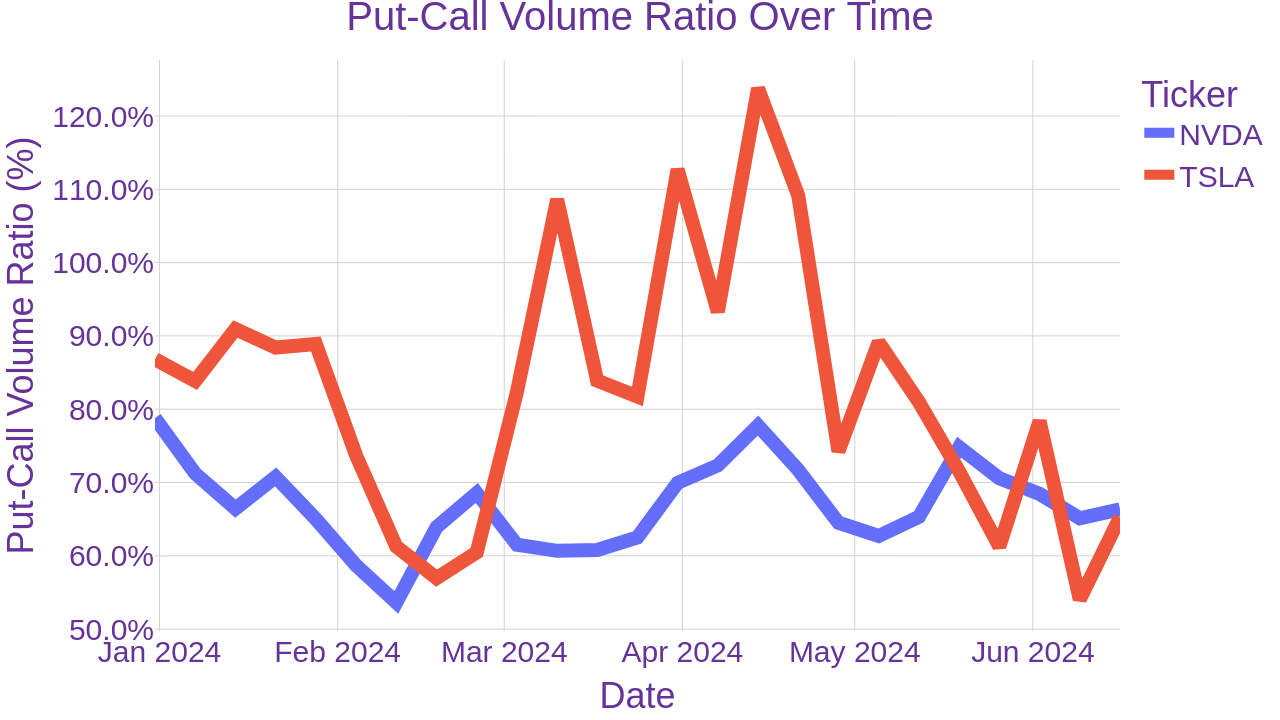

In [ ]:
import plotly.express as px

# Assuming df_pc_comparison is your DataFrame with 'put_call_ratio' and 'ticker' columns
fig = px.line(df_pc_comparison, y='put_call_ratio', color='ticker', height=720, width=1280)

# Update y-axis to percentage format and improve overall appearance
fig.update_yaxes(tickformat='.1%', title='Put-Call Volume Ratio (%)')
fig.update_xaxes(title='Date')

# Update layout for a nicer format
fig.update_layout(
    title={
        'text': 'Put-Call Volume Ratio Over Time',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 40}  # Increase the title font size
    },
    xaxis_title='Date',
    yaxis_title='Put-Call Volume Ratio (%)',
    legend_title='Ticker',
    font=dict(family="Arial", size=30, color="RebeccaPurple"),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

# Optionally, add grid lines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Increase the line thickness
fig.update_traces(line=dict(width=14))  # Adjust the width as desired

fig.show()
